In [2]:
## IMPORT AND INSTALL OF PACKAGES ##

import sys
sys.path.append(r'C:\Users\giaco\Documents\GitHub\python\custom_libraries')
import package_installer

# List of required packages
required_packages = ['scipy', 'numpy']

# Call the main function of package_installer
package_installer.main(required_packages)
from spcparser import SpcParser
import matplotlib.pyplot as plt
import numpy as np
import colour
from colour import (
    MSDS_CMFS,
    SDS_ILLUMINANTS,
    SpectralDistribution,
    SpectralShape,
)
from colour.colorimetry import whiteness_CIE2004
import sys
import os
from scipy.interpolate import interp1d
from datetime import datetime, date, timedelta


PC already verified. Skipping package installation.


C:\Users\giaco\anaconda3\Lib\site-packages\colour\utilities\verbose.py:265: ColourWarning: "vaab/colour" was detected in "sys.path", please define a "COLOUR_SCIENCE__COLOUR__IMPORT_VAAB_COLOUR=True" environment variable to import its objects into "colour" namespace!
  warn(*args, **kwargs)  # noqa: B028


In [30]:
from specio import specread
from specio.datasets import load_sp_path
import numpy as np

class SpParser:
    def __init__(self, filename, mode='A'):
        """
        Initializes the parser with the given filename and mode.

        Parameters:
            filename (str): The path to the spectral file.
            mode (str): The input type, can be 'A' (Absorbance), 'T' (Transmittance), or 'R' (Reflectance).
                        Default is 'A'.
        """
        self.filename = filename
        self.mode = mode.upper()  # Ensure uppercase input
        if self.mode not in {'A', 'T', 'R'}:
            raise ValueError("Invalid mode. Use 'A' for Absorbance, 'T' for Transmittance, or 'R' for Reflectance.")

        self.wavelengths = None
        self.absorbances = None
        self.transmittances = None
        self.spectrum = None

    def extract_data(self):
        # Read the data using specread
        spectra = specread(self.filename)
        self.wavelengths = spectra.wavelength
        amplitudes = spectra.amplitudes  # Raw input data

        # Convert input based on mode
        if self.mode == 'A':  # Absorbance
            self.absorbances = amplitudes
            self.transmittances = 10 ** (-np.array(amplitudes))
        elif self.mode == 'T':  # Transmittance
            self.transmittances = amplitudes
            self.absorbances = -np.log10(np.array(amplitudes))
        elif self.mode == 'R':  # Reflectance (assuming no transmission)
            self.absorbances = 1 - np.array(amplitudes)
            self.transmittances = 10 ** (-self.absorbances)

        # Process and store sorted data
        self.spectrum = sorted(
            [
                [wavelength, absorbance, transmittance]
                for wavelength, absorbance, transmittance in zip(self.wavelengths, self.absorbances, self.transmittances)
                if wavelength % 1 == 0 and 250 <= wavelength <= 800
            ],
            key=lambda x: x[0]  # Sort by wavelength
        )

    def get_absorbance(self):
        if self.spectrum is None:
            raise ValueError("Data has not been extracted. Call extract_data() first.")

        sorted_wavelengths = [data[0] for data in self.spectrum]
        sorted_absorbances = [data[1] for data in self.spectrum]
        return sorted_wavelengths, sorted_absorbances

    def get_transmittance(self):
        if self.spectrum is None:
            raise ValueError("Data has not been extracted. Call extract_data() first.")

        sorted_wavelengths = [data[0] for data in self.spectrum]
        sorted_transmittances = [data[2] for data in self.spectrum]
        return sorted_wavelengths, sorted_transmittances


In [8]:
#Loading the illuminants
Lambda_950 = np.array([[300, 1.0625], [305, 1.0437], [310, 1.0244], [315, 1.0004], [320, 0.0116], [325, 0.0176], [330, 0.0126], [335, 0.0215], [340, 0.0282], [345, 0.0175], [350, 0.0354], [355, 0.0355], [360, 0.0329], [365, 0.0381], [370, 0.0351], [375, 0.0205], [380, 0.1747], [385, 0.1961], [390, 0.2217], [395, 0.2526], [400, 0.2779], [405, 0.3152], [410, 0.3527], [415, 0.3886], [420, 0.4299], [425, 0.4653], [430, 0.5024], [435, 0.5421], [440, 0.5743], [445, 0.6073], [450, 0.603], [455, 0.5969], [460, 0.6058], [465, 0.6375], [470, 0.6931], [475, 0.7745], [480, 0.9694], [485, 1.1633], [490, 1.0029], [495, 0.7858], [500, 0.6585], [505, 0.5968], [510, 0.5853], [515, 0.614], [520, 0.6722], [525, 0.742], [530, 0.8364], [535, 0.9407], [540, 1.0515], [545, 1.174], [550, 1.2692], [555, 1.3623], [560, 1.4216], [565, 1.6226], [570, 1.7827], [575, 1.8924], [580, 1.9658], [585, 2.0166], [590, 2.0257], [595, 2.0286], [600, 2.0058], [605, 1.969], [610, 1.9188], [615, 1.8574], [620, 1.7907], [625, 1.7141], [630, 1.6345], [635, 1.5493], [640, 1.474], [645, 1.3829], [650, 1.3064], [655, 1.2224], [660, 1.1446], [665, 1.0779], [670, 1.0057], [675, 0.9301], [680, 0.877], [685, 0.807], [690, 0.7609], [695, 0.7143], [700, 0.6633], [705, 0.6259], [710, 0.577], [715, 0.5445], [720, 0.4987], [725, 0.46], [730, 0.4234], [735, 0.3782], [740, 0.3547], [745, 0.3333], [750, 0.3012], [755, 0.2851], [760, 0.2557], [765, 0.2286], [770, 0.2185], [775, 0.2048], [780, 0.1896]])
# Create the custom illuminant
Lambda_950 = colour.SpectralDistribution(Lambda_950[:, 1]/np.max(Lambda_950[:, 1]), Lambda_950[:, 0], name='Lambda950')

ShimadtzuTungsten = np.array([[200, 0.001],[200.5, 0.001],[201, 0.001],[201.5, 0.001],[202, 0.001],[202.5, 0.001],[203, 0.001],[203.5, 0.001],[204, 0.001],[204.5, 0.001],[205, 0.001],[205.5, 0.001],[206, 0.001],[206.5, 0.001],[207, 0.001],[207.5, 0.001],[208, 0.001],[208.5, 0.001],[209, 0.001],[209.5, 0.001],[210, 0.001],[210.5, 0.001],[211, 0.001],[211.5, 0.001],[212, 0.001],[212.5, 0.001],[213, 0.001],[213.5, 0.001],[214, 0.001],[214.5, 0.001],[215, 0.001],[215.5, 0.001],[216, 0.001],[216.5, 0.001],[217, 0.001],[217.5, 0.001],[218, 0.001],[218.5, 0.001],[219, 0.001],[219.5, 0.001],[220, 0.001],[220.5, 0.001],[221, 0.001],[221.5, 0.001],[222, 0.001],[222.5, 0.001],[223, 0.001],[223.5, 0.001],[224, 0.001],[224.5, 0.001],[225, 0.001],[225.5, 0.001],[226, 0.001],[226.5, 0.001],[227, 0.001],[227.5, 0.001],[228, 0.001],[228.5, 0.001],[229, 0.001],[229.5, 0.001],[230, 0.001],[230.5, 0.001],[231, 0.001],[231.5, 0.001],[232, 0.001],[232.5, 0.001],[233, 0.001],[233.5, 0.001],[234, 0.002],[234.5, 0.002],[235, 0.002],[235.5, 0.002],[236, 0.002],[236.5, 0.002],[237, 0.002],[237.5, 0.002],[238, 0.002],[238.5, 0.002],[239, 0.002],[239.5, 0.002],[240, 0.002],[240.5, 0.002],[241, 0.003],[241.5, 0.003],[242, 0.003],[242.5, 0.003],[243, 0.003],[243.5, 0.003],[244, 0.003],[244.5, 0.003],[245, 0.004],[245.5, 0.004],[246, 0.004],[246.5, 0.004],[247, 0.004],[247.5, 0.005],[248, 0.005],[248.5, 0.005],[249, 0.005],[249.5, 0.005],[250, 0.005],[250.5, 0.006],[251, 0.006],[251.5, 0.006],[252, 0.006],[252.5, 0.007],[253, 0.007],[253.5, 0.007],[254, 0.007],[254.5, 0.008],[255, 0.008],[255.5, 0.008],[256, 0.009],[256.5, 0.009],[257, 0.009],[257.5, 0.009],[258, 0.01],[258.5, 0.01],[259, 0.011],[259.5, 0.011],[260, 0.011],[260.5, 0.011],[261, 0.012],[261.5, 0.012],[262, 0.013],[262.5, 0.013],[263, 0.014],[263.5, 0.014],[264, 0.015],[264.5, 0.015],[265, 0.016],[265.5, 0.016],[266, 0.016],[266.5, 0.017],[267, 0.018],[267.5, 0.018],[268, 0.019],[268.5, 0.019],[269, 0.02],[269.5, 0.021],[270, 0.021],[270.5, 0.022],[271, 0.023],[271.5, 0.023],[272, 0.024],[272.5, 0.025],[273, 0.026],[273.5, 0.026],[274, 0.027],[274.5, 0.028],[275, 0.029],[275.5, 0.03],[276, 0.031],[276.5, 0.032],[277, 0.033],[277.5, 0.034],[278, 0.035],[278.5, 0.037],[279, 0.038],[279.5, 0.039],[280, 0.04],[280.5, 0.041],[281, 0.043],[281.5, 0.044],[282, 0.045],[282.5, 0.047],[283, 0.049],[283.5, 0.051],[284, 0.052],[284.5, 0.055],[285, 0.057],[285.5, 0.058],[286, 0.06],[286.5, 0.062],[287, 0.064],[287.5, 0.067],[288, 0.069],[288.5, 0.071],[289, 0.073],[289.5, 0.076],[290, 0.079],[290.5, 0.081],[291, 0.085],[291.5, 0.088],[292, 0.09],[292.5, 0.093],[293, 0.096],[293.5, 0.099],[294, 0.103],[294.5, 0.106],[295, 0.11],[295.5, 0.113],[296, 0.116],[296.5, 0.12],[297, 0.123],[297.5, 0.128],[298, 0.132],[298.5, 0.136],[299, 0.14],[299.5, 0.145],[300, 0.149],[300.5, 0.152],[301, 0.157],[301.5, 0.162],[302, 0.168],[302.5, 0.173],[303, 0.178],[303.5, 0.183],[304, 0.188],[304.5, 0.194],[305, 0.178],[305.5, 0.162],[306, 0.145],[306.5, 0.15],[307, 0.154],[307.5, 0.159],[308, 0.165],[308.5, 0.171],[309, 0.176],[309.5, 0.182],[310, 0.188],[310.5, 0.194],[311, 0.201],[311.5, 0.207],[312, 0.212],[312.5, 0.218],[313, 0.225],[313.5, 0.232],[314, 0.24],[314.5, 0.247],[315, 0.253],[315.5, 0.26],[316, 0.267],[316.5, 0.275],[317, 0.282],[317.5, 0.29],[318, 0.299],[318.5, 0.307],[319, 0.314],[319.5, 0.322],[320, 0.331],[320.5, 0.341],[321, 0.349],[321.5, 0.358],[322, 0.367],[322.5, 0.378],[323, 0.388],[323.5, 0.397],[324, 0.407],[324.5, 0.417],[325, 0.427],[325.5, 0.436],[326, 0.446],[326.5, 0.457],[327, 0.468],[327.5, 0.478],[328, 0.489],[328.5, 0.5],[329, 0.51],[329.5, 0.522],[330, 0.533],[330.5, 0.547],[331, 0.559],[331.5, 0.572],[332, 0.584],[332.5, 0.596],[333, 0.608],[333.5, 0.62],[334, 0.632],[334.5, 0.644],[335, 0.655],[335.5, 0.669],[336, 0.683],[336.5, 0.697],[337, 0.71],[337.5, 0.722],[338, 0.735],[338.5, 0.748],[339, 0.761],[339.5, 0.774],[340, 0.787],[340.5, 0.8],[341, 0.813],[341.5, 0.825],[342, 0.84],[342.5, 0.854],[343, 0.869],[343.5, 0.882],[344, 0.896],[344.5, 0.911],[345, 0.928],[345.5, 0.943],[346, 0.959],[346.5, 0.971],[347, 0.987],[347.5, 1.004],[348, 1.018],[348.5, 1.034],[349, 1.047],[349.5, 1.064],[350, 1.079],[350.5, 1.093],[351, 1.108],[351.5, 1.122],[352, 1.138],[352.5, 1.153],[353, 1.17],[353.5, 1.186],[354, 1.201],[354.5, 1.214],[355, 1.227],[355.5, 1.24],[356, 1.253],[356.5, 1.264],[357, 1.275],[357.5, 1.284],[358, 1.292],[358.5, 1.3],[359, 1.308],[359.5, 1.316],[360, 1.326],[360.5, 1.334],[361, 1.337],[361.5, 1.34],[362, 1.34],[362.5, 1.341],[363, 1.338],[363.5, 1.334],[364, 1.329],[364.5, 1.322],[365, 1.313],[365.5, 1.303],[366, 1.289],[366.5, 1.275],[367, 1.256],[367.5, 1.238],[368, 1.215],[368.5, 1.19],[369, 1.161],[369.5, 1.132],[370, 1.101],[370.5, 1.067],[371, 1.031],[371.5, 0.993],[372, 1.376],[372.5, 1.779],[373, 2.209],[373.5, 2.244],[374, 2.283],[374.5, 2.323],[375, 2.364],[375.5, 2.406],[376, 2.447],[376.5, 2.488],[377, 2.527],[377.5, 2.566],[378, 2.603],[378.5, 2.642],[379, 2.685],[379.5, 2.727],[380, 2.77],[380.5, 2.813],[381, 2.853],[381.5, 2.894],[382, 2.933],[382.5, 2.977],[383, 3.02],[383.5, 3.066],[384, 3.111],[384.5, 3.15],[385, 3.192],[385.5, 3.234],[386, 3.281],[386.5, 3.322],[387, 3.364],[387.5, 3.405],[388, 3.45],[388.5, 3.492],[389, 3.538],[389.5, 3.585],[390, 3.629],[390.5, 3.671],[391, 3.711],[391.5, 3.753],[392, 3.794],[392.5, 3.83],[393, 3.873],[393.5, 3.912],[394, 3.954],[394.5, 3.99],[395, 4.031],[395.5, 4.071],[396, 4.112],[396.5, 4.15],[397, 4.189],[397.5, 4.225],[398, 4.265],[398.5, 4.303],[399, 4.34],[399.5, 4.37],[400, 4.405],[400.5, 4.441],[401, 4.481],[401.5, 4.517],[402, 4.557],[402.5, 4.593],[403, 4.624],[403.5, 4.648],[404, 4.678],[404.5, 4.717],[405, 4.761],[405.5, 4.796],[406, 4.827],[406.5, 4.854],[407, 4.886],[407.5, 4.917],[408, 4.953],[408.5, 4.984],[409, 5.016],[409.5, 5.045],[410, 5.075],[410.5, 5.103],[411, 5.134],[411.5, 5.159],[412, 5.193],[412.5, 5.219],[413, 5.25],[413.5, 5.273],[414, 5.3],[414.5, 5.327],[415, 5.352],[415.5, 5.373],[416, 5.51],[416.5, 5.653],[417, 5.807],[417.5, 5.849],[418, 5.898],[418.5, 5.947],[419, 5.994],[419.5, 6.031],[420, 6.072],[420.5, 6.115],[421, 6.16],[421.5, 6.195],[422, 6.229],[422.5, 6.265],[423, 6.308],[423.5, 6.354],[424, 6.403],[424.5, 6.445],[425, 6.486],[425.5, 6.523],[426, 6.562],[426.5, 6.602],[427, 6.643],[427.5, 6.682],[428, 6.72],[428.5, 6.757],[429, 6.798],[429.5, 6.844],[430, 6.89],[430.5, 6.934],[431, 6.971],[431.5, 7.007],[432, 7.044],[432.5, 7.081],[433, 7.115],[433.5, 7.15],[434, 7.187],[434.5, 7.224],[435, 7.265],[435.5, 7.306],[436, 7.349],[436.5, 7.383],[437, 7.418],[437.5, 7.456],[438, 7.496],[438.5, 7.537],[439, 7.568],[439.5, 7.604],[440, 7.635],[440.5, 7.67],[441, 7.708],[441.5, 7.747],[442, 7.785],[442.5, 7.818],[443, 7.848],[443.5, 7.881],[444, 7.913],[444.5, 7.948],[445, 7.977],[445.5, 8.005],[446, 8.036],[446.5, 8.07],[447, 8.106],[447.5, 8.139],[448, 8.171],[448.5, 8.206],[449, 8.235],[449.5, 8.268],[450, 8.296],[450.5, 8.33],[451, 8.357],[451.5, 8.394],[452, 8.418],[452.5, 8.451],[453, 8.472],[453.5, 8.505],[454, 8.536],[454.5, 8.569],[455, 8.602],[455.5, 8.626],[456, 8.645],[456.5, 8.661],[457, 8.678],[457.5, 8.696],[458, 8.719],[458.5, 8.741],[459, 8.771],[459.5, 8.786],[460, 8.789],[460.5, 8.773],[461, 8.762],[461.5, 8.767],[462, 8.792],[462.5, 8.837],[463, 8.89],[463.5, 8.953],[464, 9.017],[464.5, 9.08],[465, 9.144],[465.5, 9.216],[466, 9.288],[466.5, 9.365],[467, 9.435],[467.5, 9.511],[468, 9.591],[468.5, 9.668],[469, 9.746],[469.5, 9.826],[470, 9.915],[470.5, 10.009],[471, 10.104],[471.5, 10.202],[472, 10.298],[472.5, 10.385],[473, 10.476],[473.5, 10.566],[474, 10.671],[474.5, 10.771],[475, 10.87],[475.5, 10.967],[476, 11.062],[476.5, 11.169],[477, 11.269],[477.5, 11.374],[478, 11.462],[478.5, 11.549],[479, 11.627],[479.5, 11.708],[480, 11.795],[480.5, 11.876],[481, 11.96],[481.5, 12.025],[482, 12.091],[482.5, 12.151],[483, 12.206],[483.5, 12.255],[484, 12.304],[484.5, 12.351],[485, 12.387],[485.5, 12.406],[486, 12.425],[486.5, 12.459],[487, 12.499],[487.5, 12.527],[488, 12.542],[488.5, 12.543],[489, 12.545],[489.5, 12.549],[490, 12.552],[490.5, 12.548],[491, 12.537],[491.5, 12.533],[492, 12.533],[492.5, 12.522],[493, 12.503],[493.5, 12.474],[494, 12.45],[494.5, 12.428],[495, 12.414],[495.5, 12.4],[496, 12.385],[496.5, 12.355],[497, 12.322],[497.5, 12.288],[498, 12.26],[498.5, 12.234],[499, 12.203],[499.5, 12.176],[500, 12.148],[500.5, 12.114],[501, 12.075],[501.5, 12.048],[502, 12.021],[502.5, 11.993],[503, 11.953],[503.5, 11.913],[504, 11.87],[504.5, 11.825],[505, 11.792],[505.5, 11.759],[506, 11.731],[506.5, 11.685],[507, 11.642],[507.5, 11.608],[508, 11.578],[508.5, 11.546],[509, 11.506],[509.5, 11.479],[510, 11.439],[510.5, 11.404],[511, 11.358],[511.5, 11.321],[512, 11.275],[512.5, 11.225],[513, 11.182],[513.5, 11.142],[514, 11.106],[514.5, 11.072],[515, 11.039],[515.5, 11.002],[516, 10.958],[516.5, 10.916],[517, 10.877],[517.5, 10.838],[518, 10.793],[518.5, 10.748],[519, 10.706],[519.5, 10.658],[520, 10.602],[520.5, 10.542],[521, 10.489],[521.5, 10.443],[522, 10.395],[522.5, 10.349],[523, 10.301],[523.5, 10.256],[524, 10.213],[524.5, 10.171],[525, 10.122],[525.5, 10.067],[526, 10.015],[526.5, 9.969],[527, 9.92],[527.5, 9.864],[528, 9.807],[528.5, 9.757],[529, 9.718],[529.5, 9.679],[530, 9.633],[530.5, 9.576],[531, 9.52],[531.5, 9.468],[532, 9.414],[532.5, 9.358],[533, 9.304],[533.5, 9.262],[534, 9.209],[534.5, 9.154],[535, 9.095],[535.5, 9.037],[536, 10.579],[536.5, 12.131],[537, 13.698],[537.5, 13.669],[538, 13.62],[538.5, 13.565],[539, 13.506],[539.5, 13.446],[540, 13.38],[540.5, 13.293],[541, 13.221],[541.5, 13.156],[542, 13.12],[542.5, 13.083],[543, 13.055],[543.5, 13.036],[544, 13.038],[544.5, 13.044],[545, 13.055],[545.5, 13.08],[546, 13.109],[546.5, 13.143],[547, 13.165],[547.5, 13.2],[548, 13.23],[548.5, 13.261],[549, 13.277],[549.5, 13.279],[550, 13.272],[550.5, 13.247],[551, 13.212],[551.5, 13.169],[552, 13.114],[552.5, 13.04],[553, 12.949],[553.5, 12.853],[554, 12.753],[554.5, 12.637],[555, 12.524],[555.5, 12.416],[556, 12.317],[556.5, 12.208],[557, 12.101],[557.5, 11.988],[558, 11.891],[558.5, 11.79],[559, 11.702],[559.5, 11.613],[560, 11.533],[560.5, 11.449],[561, 11.362],[561.5, 11.269],[562, 11.196],[562.5, 11.162],[563, 11.173],[563.5, 11.225],[564, 11.309],[564.5, 11.439],[565, 11.597],[565.5, 11.774],[566, 11.944],[566.5, 12.128],[567, 12.317],[567.5, 12.532],[568, 12.745],[568.5, 12.956],[569, 13.166],[569.5, 13.386],[570, 13.614],[570.5, 13.84],[571, 14.065],[571.5, 14.287],[572, 14.514],[572.5, 14.723],[573, 14.918],[573.5, 15.104],[574, 15.284],[574.5, 15.453],[575, 15.614],[575.5, 15.756],[576, 15.897],[576.5, 16.027],[577, 16.141],[577.5, 16.242],[578, 16.32],[578.5, 16.392],[579, 16.449],[579.5, 16.494],[580, 16.526],[580.5, 16.539],[581, 16.543],[581.5, 16.544],[582, 16.535],[582.5, 16.524],[583, 16.503],[583.5, 16.485],[584, 16.46],[584.5, 16.426],[585, 16.395],[585.5, 16.363],[586, 16.33],[586.5, 16.295],[587, 16.253],[587.5, 16.212],[588, 16.166],[588.5, 16.12],[589, 16.069],[589.5, 16.022],[590, 15.969],[590.5, 15.924],[591, 15.862],[591.5, 15.798],[592, 15.72],[592.5, 15.657],[593, 15.586],[593.5, 15.519],[594, 15.435],[594.5, 15.348],[595, 15.25],[595.5, 15.146],[596, 15.058],[596.5, 14.97],[597, 14.879],[597.5, 14.764],[598, 14.655],[598.5, 14.543],[599, 14.434],[599.5, 14.311],[600, 14.185],[600.5, 14.071],[601, 13.965],[601.5, 13.859],[602, 13.737],[602.5, 13.615],[603, 13.498],[603.5, 13.385],[604, 13.272],[604.5, 13.159],[605, 13.055],[605.5, 12.957],[606, 12.854],[606.5, 12.756],[607, 12.654],[607.5, 12.569],[608, 12.477],[608.5, 12.397],[609, 12.318],[609.5, 12.236],[610, 12.153],[610.5, 12.074],[611, 12.009],[611.5, 11.951],[612, 11.899],[612.5, 11.834],[613, 11.763],[613.5, 11.693],[614, 11.635],[614.5, 11.576],[615, 11.517],[615.5, 11.463],[616, 11.417],[616.5, 11.368],[617, 11.309],[617.5, 11.25],[618, 11.194],[618.5, 11.138],[619, 11.083],[619.5, 11.023],[620, 10.972],[620.5, 10.922],[621, 10.866],[621.5, 10.802],[622, 10.731],[622.5, 10.67],[623, 10.602],[623.5, 10.532],[624, 10.458],[624.5, 10.393],[625, 10.328],[625.5, 10.262],[626, 10.195],[626.5, 10.124],[627, 10.053],[627.5, 9.972],[628, 9.901],[628.5, 9.826],[629, 9.757],[629.5, 9.685],[630, 9.617],[630.5, 9.546],[631, 9.469],[631.5, 9.394],[632, 9.334],[632.5, 9.281],[633, 9.225],[633.5, 9.159],[634, 9.098],[634.5, 9.035],[635, 8.973],[635.5, 8.911],[636, 8.856],[636.5, 8.802],[637, 8.744],[637.5, 8.689],[638, 8.64],[638.5, 8.592],[639, 8.539],[639.5, 8.485],[640, 8.442],[640.5, 8.402],[641, 8.362],[641.5, 8.315],[642, 8.265],[642.5, 8.22],[643, 8.181],[643.5, 8.139],[644, 8.098],[644.5, 8.055],[645, 8.016],[645.5, 7.973],[646, 7.931],[646.5, 7.885],[647, 7.842],[647.5, 7.805],[648, 7.767],[648.5, 7.718],[649, 7.661],[649.5, 7.61],[650, 7.562],[650.5, 7.517],[651, 7.471],[651.5, 7.428],[652, 7.379],[652.5, 7.325],[653, 7.268],[653.5, 7.214],[654, 7.164],[654.5, 7.114],[655, 7.064],[655.5, 7.004],[656, 6.949],[656.5, 6.889],[657, 6.843],[657.5, 6.792],[658, 6.738],[658.5, 6.68],[659, 6.622],[659.5, 6.568],[660, 6.511],[660.5, 6.458],[661, 6.41],[661.5, 6.361],[662, 6.304],[662.5, 6.245],[663, 6.185],[663.5, 6.133],[664, 6.083],[664.5, 6.033],[665, 5.979],[665.5, 5.928],[666, 5.884],[666.5, 5.837],[667, 5.795],[667.5, 5.743],[668, 5.7],[668.5, 5.652],[669, 5.611],[669.5, 5.566],[670, 5.523],[670.5, 5.477],[671, 5.428],[671.5, 5.386],[672, 5.349],[672.5, 5.313],[673, 5.276],[673.5, 5.24],[674, 5.198],[674.5, 5.16],[675, 5.118],[675.5, 5.087],[676, 5.047],[676.5, 5.013],[677, 4.976],[677.5, 4.94],[678, 4.905],[678.5, 4.869],[679, 4.839],[679.5, 4.807],[680, 4.771],[680.5, 4.735],[681, 4.702],[681.5, 4.676],[682, 4.648],[682.5, 4.611],[683, 4.575],[683.5, 4.541],[684, 4.513],[684.5, 4.48],[685, 4.447],[685.5, 4.412],[686, 4.374],[686.5, 4.341],[687, 4.305],[687.5, 4.28],[688, 4.244],[688.5, 4.212],[689, 4.171],[689.5, 4.136],[690, 4.105],[690.5, 4.075],[691, 4.047],[691.5, 4.014],[692, 3.981],[692.5, 3.945],[693, 3.908],[693.5, 3.871],[694, 3.84],[694.5, 3.806],[695, 3.769],[695.5, 3.733],[696, 3.698],[696.5, 3.67],[697, 3.638],[697.5, 3.608],[698, 3.579],[698.5, 3.547],[699, 3.514],[699.5, 3.477],[700, 3.445],[700.5, 3.418],[701, 3.387],[701.5, 3.354],[702, 3.322],[702.5, 3.293],[703, 3.264],[703.5, 3.234],[704, 3.205],[704.5, 3.178],[705, 3.153],[705.5, 3.127],[706, 3.098],[706.5, 3.07],[707, 3.042],[707.5, 3.015],[708, 2.984],[708.5, 2.956],[709, 2.927],[709.5, 2.899],[710, 2.875],[710.5, 2.85],[711, 2.825],[711.5, 2.796],[712, 2.773],[712.5, 2.75],[713, 2.73],[713.5, 2.705],[714, 2.683],[714.5, 2.657],[715, 2.634],[715.5, 2.612],[716, 2.591],[716.5, 2.568],[717, 2.543],[717.5, 2.518],[718, 2.495],[718.5, 2.477],[719, 2.458],[719.5, 2.435],[720, 2.41],[720.5, 2.388],[721, 2.367],[721.5, 2.351],[722, 2.33],[722.5, 2.309],[723, 2.283],[723.5, 2.262],[724, 2.242],[724.5, 2.226],[725, 2.208],[725.5, 2.189],[726, 2.17],[726.5, 2.149],[727, 2.13],[727.5, 2.111],[728, 2.093],[728.5, 2.072],[729, 2.05],[729.5, 2.025],[730, 2.006],[730.5, 1.985],[731, 1.968],[731.5, 1.947],[732, 1.931],[732.5, 1.912],[733, 1.894],[733.5, 1.873],[734, 1.857],[734.5, 1.839],[735, 1.822],[735.5, 1.803],[736, 1.784],[736.5, 1.765],[737, 1.745],[737.5, 1.729],[738, 1.712],[738.5, 1.695],[739, 1.675],[739.5, 1.658],[740, 1.643],[740.5, 1.626],[741, 1.61],[741.5, 1.593],[742, 1.58],[742.5, 1.565],[743, 1.55],[743.5, 1.534],[744, 1.517],[744.5, 1.501],[745, 1.485],[745.5, 1.471],[746, 1.455],[746.5, 1.441],[747, 1.426],[747.5, 1.414],[748, 1.401],[748.5, 1.389],[749, 1.375],[749.5, 1.359],[750, 1.345],[750.5, 1.331],[751, 1.323],[751.5, 1.312],[752, 1.301],[752.5, 1.287],[753, 1.275],[753.5, 1.264],[754, 1.254],[754.5, 1.243],[755, 1.23],[755.5, 1.219],[756, 1.209],[756.5, 1.201],[757, 1.189],[757.5, 1.179],[758, 1.169],[758.5, 1.16],[759, 1.15],[759.5, 1.138],[760, 1.119],[760.5, 1.099],[761, 1.078],[761.5, 1.066],[762, 1.052],[762.5, 1.039],[763, 1.024],[763.5, 1.011],[764, 0.997],[764.5, 0.985],[765, 0.974],[765.5, 0.965],[766, 0.956],[766.5, 0.946],[767, 0.937],[767.5, 0.93],[768, 0.925],[768.5, 0.921],[769, 0.916],[769.5, 0.911],[770, 0.907],[770.5, 0.904],[771, 0.901],[771.5, 0.899],[772, 0.897],[772.5, 0.895],[773, 0.892],[773.5, 0.892],[774, 0.891],[774.5, 0.888],[775, 0.883],[775.5, 0.879],[776, 0.877],[776.5, 0.873],[777, 0.868],[777.5, 0.862],[778, 0.856],[778.5, 0.848],[779, 0.841],[779.5, 0.834],[780, 0.827],[780.5, 0.818],[781, 0.808],[781.5, 0.801],[782, 0.793],[782.5, 0.785],[783, 0.776],[783.5, 0.769],[784, 0.762],[784.5, 0.753],[785, 0.746],[785.5, 0.737],[786, 0.732],[786.5, 0.727],[787, 0.722],[787.5, 0.716],[788, 0.709],[788.5, 0.703],[789, 0.7],[789.5, 0.697],[790, 0.695],[790.5, 0.691],[791, 0.688],[791.5, 0.684],[792, 0.682],[792.5, 0.679],[793, 0.679],[793.5, 0.677],[794, 0.675],[794.5, 0.672],[795, 0.668],[795.5, 0.666],[796, 0.662],[796.5, 0.66],[797, 0.658],[797.5, 0.655],[798, 0.651],[798.5, 0.646],[799, 0.642],[799.5, 0.638],[800, 0.635]])
ShimadtzuTungsten = np.array([[200, 6.04448742746615E-05],[200.5, 6.04448742746615E-05],[201, 6.04448742746615E-05],[201.5, 6.04448742746615E-05],[202, 6.04448742746615E-05],[202.5, 6.04448742746615E-05],[203, 6.04448742746615E-05],[203.5, 6.04448742746615E-05],[204, 6.04448742746615E-05],[204.5, 6.04448742746615E-05],[205, 6.04448742746615E-05],[205.5, 6.04448742746615E-05],[206, 6.04448742746615E-05],[206.5, 6.04448742746615E-05],[207, 6.04448742746615E-05],[207.5, 6.04448742746615E-05],[208, 6.04448742746615E-05],[208.5, 6.04448742746615E-05],[209, 6.04448742746615E-05],[209.5, 6.04448742746615E-05],[210, 6.04448742746615E-05],[210.5, 6.04448742746615E-05],[211, 6.04448742746615E-05],[211.5, 6.04448742746615E-05],[212, 6.04448742746615E-05],[212.5, 6.04448742746615E-05],[213, 6.04448742746615E-05],[213.5, 6.04448742746615E-05],[214, 6.04448742746615E-05],[214.5, 6.04448742746615E-05],[215, 6.39386859447046E-05],[215.5, 6.39386859447046E-05],[216, 6.39386859447046E-05],[216.5, 6.39386859447046E-05],[217, 6.39386859447046E-05],[217.5, 6.39386859447046E-05],[218, 6.39386859447046E-05],[218.5, 6.39386859447046E-05],[219, 0.000064986861124126],[219.5, 6.60350363035474E-05],[220, 6.70832114829688E-05],[220.5, 6.81313866623902E-05],[221, 6.91795618418115E-05],[221.5, 7.02277370212329E-05],[222, 7.12759122006543E-05],[222.5, 7.23240873800757E-05],[223, 7.33722625594971E-05],[223.5, 7.44204377389185E-05],[224, 7.54686129183399E-05],[224.5, 7.65167880977613E-05],[225, 7.75649632771826E-05],[225.5, 0.000078613138456604],[226, 8.07094888154468E-05],[226.5, 8.28058391742896E-05],[227, 8.49021895331323E-05],[227.5, 8.69985398919751E-05],[228, 8.90948902508179E-05],[228.5, 9.11912406096607E-05],[229, 9.32875909685035E-05],[229.5, 9.53839413273462E-05],[230, 9.85284668656104E-05],[230.5, 0.000101672992403875],[231, 0.000104817517942139],[231.5, 0.000107962043480403],[232, 0.000111106569018667],[232.5, 0.000115299269736353],[233, 0.000119491970454038],[233.5, 0.000123684671171724],[234, 0.000127877371889409],[234.5, 0.000132070072607095],[235, 0.00013626277332478],[235.5, 0.000141503649221887],[236, 0.000146744525118994],[236.5, 0.000151985401016101],[237, 0.000157226276913208],[237.5, 0.000163515327989736],[238, 0.000169804379066265],[238.5, 0.000176093430142793],[239, 0.000182382481219321],[239.5, 0.000189719707475271],[240, 0.000197056933731221],[240.5, 0.00020439415998717],[241, 0.000212779561422542],[241.5, 0.000221164962857913],[242, 0.000229550364293284],[242.5, 0.000237935765728655],[243, 0.000247369342343447],[243.5, 0.00025680291895824],[244, 0.000267284670752454],[244.5, 0.000277766422546668],[245, 0.000288248174340881],[245.5, 0.000298729926135095],[246, 0.000310259853108731],[246.5, 0.000321789780082366],[247, 0.000334367882235422],[247.5, 0.000346945984388479],[248, 0.000360572261720957],[248.5, 0.000374198539053435],[249, 0.000388872991565335],[249.5, 0.000402499268897813],[250, 0.000417173721409712],[250.5, 0.000431848173921612],[251, 0.000446522626433511],[251.5, 0.000462245254124832],[252, 0.000479016056995574],[252.5, 0.000495786859866316],[253, 0.00051360583791648],[253.5, 0.000531424815966643],[254, 0.000550291969196228],[254.5, 0.000570207297605235],[255, 0.000590122626014241],[255.5, 0.000611086129602669],[256, 0.000633097808370518],[256.5, 0.000654061311958945],[257, 0.000676072990726795],[257.5, 0.000699132844674065],[258, 0.000723240873800757],[258.5, 0.000747348902927449],[259, 0.000772505107233562],[259.5, 0.000798709486719097],[260, 0.000825962041384053],[260.5, 0.000853214596049009],[261, 0.000881515325893387],[261.5, 0.000910864230917185],[262, 0.000941261311120406],[262.5, 0.000972706566503047],[263, 0.00100415182188569],[263.5, 0.00103769342762717],[264, 0.00107228320854808],[264.5, 0.00110792116464841],[265, 0.00114460729592815],[265.5, 0.00118234160238732],[266, 0.00122112408402592],[266.5, 0.00126095474084393],[267, 0.00130183357284136],[267.5, 0.00134480875519764],[268, 0.00138883211273334],[268.5, 0.00143495182062788],[269, 0.00148211970370184],[269.5, 0.00153243211231407],[270, 0.00158379269610572],[270.5, 0.00163620145507678],[271, 0.0016907065644067],[271.5, 0.00174625984891603],[272, 0.00180390948378421],[272.5, 0.00186470364419065],[273, 0.00192759415495593],[273.5, 0.00199153284090063],[274, 0.00205756787720418],[274.5, 0.00212569926386657],[275, 0.00219697517606723],[275.5, 0.00227034743862672],[276, 0.00234791240190391],[276.5, 0.00242757371553993],[277, 0.0025093313795348],[277.5, 0.00259318539388851],[278, 0.00268018393378049],[278.5, 0.0027692788240313],[279, 0.00286256641499981],[279.5, 0.00295795035632715],[280, 0.00305752699837218],[280.5, 0.00315919999077606],[281, 0.0032640175087182],[281.5, 0.00337302772737802],[282, 0.00348413429639669],[282.5, 0.00359943356613304],[283, 0.00371892553658708],[283.5, 0.00384156203257938],[284, 0.00396839122928937],[284.5, 0.00409941312671704],[285, 0.00423357954968298],[285.5, 0.00437089049818718],[286, 0.00451239414740907],[286.5, 0.00465809049734864],[287, 0.00481007589836474],[287.5, 0.00496625400009853],[288, 0.00512662480255],[288.5, 0.00529118830571916],[289, 0.00546099268478542],[289.5, 0.00563603793974879],[290, 0.005793264216662],[290.5, 0.00593267151552505],[291, 0.0060532116611585],[291.5, 0.00617794450750965],[292, 0.00630582187939906],[292.5, 0.00643789195200616],[293, 0.00657520290051036],[293.5, 0.00671775472491167],[294, 0.00686345107485124],[294.5, 0.00701438830068792],[295, 0.0071705664024217],[295.5, 0.0073319853800526],[296, 0.00749969340876002],[296.5, 0.00767159413818513],[297, 0.00784768756832792],[297.5, 0.00802902187436782],[298, 0.00821559705630483],[298.5, 0.00840741311413894],[299, 0.00860551822304958],[299.5, 0.00880991238303675],[300, 0.00901745106856219],[300.5, 0.00923023062998473],[301, 0.0094492992424838],[301.5, 0.0096746569060594],[302, 0.0099052554455321],[302.5, 0.0101421430360813],[303, 0.0103853196777071],[303.5, 0.0106347853704094],[304, 0.0108894919390088],[304.5, 0.0111504875586847],[305, 0.0114177722294372],[305.5, 0.0116923941264456],[306, 0.0119733050745305],[306.5, 0.0122594568985125],[307, 0.0125518977735711],[307.5, 0.0128537722252445],[308, 0.0131629839031738],[308.5, 0.0134784846321796],[309, 0.0138013225874414],[309.5, 0.0141304495937797],[310, 0.014466913826374],[310.5, 0.0148086189348653],[311, 0.0151576612696127],[311.5, 0.0155150890057954],[312, 0.015879853968234],[312.5, 0.0162519561569286],[313, 0.0166303473966997],[313.5, 0.0170160758627268],[314, 0.0174080933798304],[314.5, 0.0178084962983694],[315, 0.0182151882679848],[315.5, 0.0186323619893946],[316, 0.0190589692874191],[316.5, 0.0194939619868789],[317, 0.0199362919125948],[317.5, 0.0203849108893871],[318, 0.0208408670924354],[318.5, 0.0213041605217397],[319, 0.0217747911772999],[319.5, 0.022252759059116],[320, 0.0227359678168293],[320.5, 0.0232506218299252],[321, 0.0237967210984037],[321.5, 0.0243753137974443],[322, 0.0249622918979203],[322.5, 0.0255576553998317],[323, 0.0261614043031784],[323.5, 0.0267724904327811],[324, 0.0273909137886397],[324.5, 0.0280177225459337],[325, 0.0286518685294836],[325.5, 0.0292933517392895],[326, 0.0299421721753513],[326.5, 0.0305962334873103],[327, 0.031259728375884],[327.5, 0.0319326568410725],[328, 0.0326150188828759],[328.5, 0.0333036699757557],[329, 0.0339996582948915],[329.5, 0.0347029838402833],[330, 0.0354167911374692],[330.5, 0.03614003201127],[331, 0.0368727064616855],[331.5, 0.0376106217879982],[332, 0.0383569225157462],[332.5, 0.0391137049952884],[333, 0.0398767765259072],[333.5, 0.0406471852827819],[334, 0.0414228349155538],[334.5, 0.0422089663001198],[335, 0.0430024349109418],[335.5, 0.0438011443976609],[336, 0.0446050947602771],[336.5, 0.0454153341739698],[337, 0.0462329108139185],[337.5, 0.0470567765049437],[338, 0.0478869312470454],[338.5, 0.0487233750402237],[339, 0.0495661078844785],[339.5, 0.0504119852542716],[340, 0.0512610071496029],[340.5, 0.0521131735704725],[341, 0.0529695326920597],[341.5, 0.0538269399888264],[342, 0.0546843472855931],[342.5, 0.055539658232001],[343, 0.05639287282805],[343.5, 0.0572429428985607],[344, 0.0580898684435332],[344.5, 0.0589346976381469],[345, 0.0597774304824017],[345.5, 0.0606170188011182],[346, 0.0614450771928611],[346.5, 0.0622637020079892],[347, 0.0630687005457848],[347.5, 0.0638621691566068],[348, 0.0646399151397375],[348.5, 0.0654008903199974],[349, 0.0661440465222072],[349.5, 0.0668672873960079],[350, 0.0675685165910409],[350.5, 0.0682477341073059],[351, 0.0688976027185472],[351.5, 0.0695181224247646],[352, 0.0701040523500612],[352.5, 0.0706574888447957],[353, 0.0711742392082504],[353.5, 0.0716511589148871],[354, 0.0720840552639882],[354.5, 0.0724729282555535],[355, 0.0728156815392243],[355.5, 0.0731091705894623],[356, 0.0733512990559086],[356.5, 0.0735399705882045],[357, 0.0741175151120657],[357.5, 0.0751017516055423],[358, 0.0765220289736583],[358.5, 0.0779632698453627],[359, 0.0794317632717321],[359.5, 0.0809275092527664],[360, 0.0824505077884657],[360.5, 0.0839997107036505],[361, 0.0855761661735003],[361.5, 0.0871788260228356],[362, 0.0888097866020152],[362.5, 0.0904648552103216],[363, 0.0921408873222164],[363.5, 0.0938431238135967],[364, 0.0955736610348214],[364.5, 0.0973345953362494],[365, 0.0991227821923422],[365.5, 0.100940317953459],[366, 0.102785106269241],[366.5, 0.104657147139687],[367, 0.106555392389619],[367.5, 0.108482986544575],[368, 0.110439929604555],[368.5, 0.112427269744738],[369, 0.114445006965124],[369.5, 0.116487900389816],[370, 0.118561190894712],[370.5, 0.120664878479811],[371, 0.12280420402101],[371.5, 0.124972878467232],[372, 0.127174046344017],[372.5, 0.129406659476185],[373, 0.131677006914812],[373.5, 0.133982992309539],[374, 0.136328808361084],[374.5, 0.138715503244626],[375, 0.141139932434628],[375.5, 0.143597903230371],[376, 0.146089415631856],[376.5, 0.148621806865338],[377, 0.151194028755638],[377.5, 0.153803984952397],[378, 0.156457964506692],[378.5, 0.159155967418523],[379, 0.161902186388607],[379.5, 0.164691380541047],[380, 0.1675308871021],[380.5, 0.170421754246944],[381, 0.173366078325939],[381.5, 0.176364907514263],[382, 0.179419289987097],[382.5, 0.182531322094799],[383, 0.185704148362908],[383.5, 0.188940913316961],[384, 0.192242665132138],[384.5, 0.195606259282901],[385, 0.199036936645148],[385.5, 0.202537841744415],[386, 0.20611631180696],[386.5, 0.209770250482423],[387, 0.21350594682188],[387.5, 0.216877926374079],[388, 0.219859984759533],[388.5, 0.222416484022142],[389, 0.224967742408853],[389.5, 0.227519000795565],[390, 0.230074451882994],[390.5, 0.232623613919347],[391, 0.235161246028726],[391.5, 0.237684203685594],[392, 0.240197727765846],[392.5, 0.242702866444663],[393, 0.245204860597942],[393.5, 0.247700565700144],[394, 0.250188933576091],[394.5, 0.252662626999525],[395, 0.255123742320806],[395.5, 0.257569135014397],[396, 0.260001949605834],[396.5, 0.262419041569579],[397, 0.264828796307069],[397.5, 0.267224924767226],[398, 0.269607426950051],[398.5, 0.271968965629288],[399, 0.274310588980115],[399.5, 0.276633345177713],[400, 0.278941426922799],[400.5, 0.281227496989117],[401, 0.28361314369748],[401.5, 0.286099415223067],[402, 0.28870413054393],[402.5, 0.291308845864792],[403, 0.293921946587089],[403.5, 0.296539240010104],[404, 0.299161774309017],[404.5, 0.301774875031314],[405, 0.304381686702535],[405.5, 0.306987450198577],[406, 0.309596358220157],[406.5, 0.312200025365839],[407, 0.314795307110087],[407.5, 0.317385347978437],[408, 0.319982726073043],[408.5, 0.322583248693187],[409, 0.325194253065126],[409.5, 0.327805257437065],[410, 0.330421502684901],[410.5, 0.333033555232019],[411, 0.335644559603957],[411.5, 0.338254515800717],[412, 0.340867616523014],[412.5, 0.343480717245312],[413, 0.346095914317968],[413.5, 0.348707966865086],[414, 0.351323163937743],[414.5, 0.353947794587014],[415, 0.356589196039156],[415.5, 0.359240031067912],[416, 0.361891914271848],[416.5, 0.364539604775067],[417, 0.367188343453465],[417.5, 0.369833937606324],[418, 0.372477435408825],[418.5, 0.375125125912043],[419, 0.377786442692594],[419.5, 0.380455096699401],[420, 0.383125847056567],[420.5, 0.385793452888194],[421, 0.388469444121257],[421.5, 0.391148579879858],[422, 0.393836101039895],[422.5, 0.396529911251008],[423, 0.399233155038735],[423.5, 0.40194163970236],[424, 0.404650124365985],[424.5, 0.407362801730327],[425, 0.410077575445029],[425.5, 0.412797590035627],[426, 0.41552808637802],[426.5, 0.418266968121848],[427, 0.421019476143009],[427.5, 0.42377093598899],[428, 0.426526588535689],[428.5, 0.429284337432746],[429, 0.432051519906419],[429.5, 0.434827087781527],[430, 0.437604752006993],[430.5, 0.440385560757998],[431, 0.443176851260797],[431.5, 0.445860179720116],[432, 0.448431353435237],[432.5, 0.450875697953648],[433, 0.453309560720264],[433.5, 0.455728749034369],[434, 0.458126973844885],[434.5, 0.460510524202889],[435, 0.462884640984278],[435.5, 0.465251420539412],[436, 0.467601429291675],[436.5, 0.469943052642502],[437, 0.472273146066356],[437.5, 0.47460219131503],[438, 0.476915513936013],[438.5, 0.479218354805202],[439, 0.481505473046699],[439.5, 0.483775820485326],[440, 0.486036734347338],[440.5, 0.4882798292313],[441, 0.490504056962032],[441.5, 0.492704176663637],[442, 0.494880188336116],[442.5, 0.497032091979468],[443, 0.49916722481995],[443.5, 0.50128558685756],[444, 0.503396611668915],[444.5, 0.505480383925605],[445, 0.507519084649579],[445.5, 0.50949279851243],[446, 0.511408862740412],[446.5, 0.513291385362653],[447, 0.51516237805792],[447.5, 0.517041756154623],[448, 0.518937905054196],[448.5, 0.520864451033972],[449, 0.522821394093952],[449.5, 0.524805589708597],[450, 0.526818086053086],[450.5, 0.528863075828137],[451, 0.53094055903375],[451.5, 0.533053680195464],[452, 0.535204535663636],[452.5, 0.537398366314165],[453, 0.53963622032223],[453.5, 0.541912856811933],[454, 0.544228275783275],[454.5, 0.546595055338408],[455, 0.549017388178051],[455.5, 0.551505756053998],[456, 0.55405701444071],[456.5, 0.556671163338187],[457, 0.55934505822089],[457.5, 0.562070313687386],[458, 0.564856363314288],[458.5, 0.567705303451955],[459, 0.570629712202541],[459.5, 0.573625396865327],[460, 0.576688164739597],[460.5, 0.579822208526066],[461, 0.583026480049558],[461.5, 0.586310412886685],[462, 0.589663525285654],[462.5, 0.593088961772003],[463, 0.59657204789322],[463.5, 0.600112783649306],[464, 0.603698590938106],[464.5, 0.607338903336237],[465, 0.611035817194056],[465.5, 0.614788284336384],[466, 0.618593160237684],[466.5, 0.622437866795802],[467, 0.626312970434123],[467.5, 0.630225808378903],[468, 0.63416170617763],[468.5, 0.638126952881381],[469, 0.642108970388003],[469.5, 0.646107758697496],[470, 0.650109691532526],[470.5, 0.654096949915045],[471, 0.658078967421667],[471.5, 0.66207670755598],[472, 0.666099603894599],[472.5, 0.670134030160193],[473, 0.674165311900247],[473.5, 0.678173533786355],[474, 0.682160792168874],[474.5, 0.686120797996727],[475, 0.690068225722428],[475.5, 0.694008316221873],[476, 0.697953647597216],[476.5, 0.701906316198813],[477, 0.705853743924514],[477.5, 0.709763437343756],[478, 0.713606047551515],[478.5, 0.717362707394562],[479, 0.721028175996998],[479.5, 0.724603501534005],[480, 0.728098117582195],[480.5, 0.731510975966391],[481, 0.734832643109978],[481.5, 0.738047396385263],[482, 0.741146850390812],[482.5, 0.744137294177702],[483, 0.747018727745931],[483.5, 0.749789054745142],[484, 0.752446178824975],[484.5, 0.754993244510969],[485, 0.757427107277585],[485.5, 0.759732044497133],[486, 0.761897574417818],[486.5, 0.763935226966613],[487, 0.76584185761798],[487.5, 0.7676185145471],[488, 0.769262053228432],[488.5, 0.770768280961261],[489, 0.772135101395226],[489.5, 0.773344695552278],[490, 0.774414882410468],[490.5, 0.775346710144973],[491, 0.776147515982051],[491.5, 0.776800529118831],[492, 0.777296315978697],[492.5, 0.777651647364521],[493, 0.777865475101123],[493.5, 0.777953521816194],[494, 0.777908450283479],[494.5, 0.777753320356925],[495, 0.77747136123366],[495.5, 0.777061524738506],[496, 0.776518569995566],[496.5, 0.775848786055916],[497, 0.77506265467135],[497.5, 0.774154934965971],[498, 0.773139253217111],[498.5, 0.772023994826207],[499, 0.770819641545052],[499.5, 0.769528289724005],[500, 0.768153083888604],[500.5, 0.766701361265105],[501, 0.765183603605303],[501.5, 0.763601907259556],[502, 0.761943694125712],[502.5, 0.760202675152693],[503, 0.758385139391576],[503.5, 0.756504713119694],[504, 0.754579215315097],[504.5, 0.752601308751529],[505, 0.750560511677195],[505.5, 0.748453679566559],[506, 0.74629548687213],[506.5, 0.744100608046422],[507, 0.741859609512818],[507.5, 0.739570394920962],[508, 0.737242397847467],[508.5, 0.734887148219308],[509, 0.732517224138636],[509.5, 0.730128432904735],[510, 0.727711340940989],[510.5, 0.725251273794887],[511, 0.722751375991967],[511.5, 0.720218984758485],[512, 0.717666678196594],[512.5, 0.715090263605576],[513, 0.712489740985432],[513.5, 0.70986615851134],[514, 0.707228949759915],[514.5, 0.704583355607056],[515, 0.701917846125787],[515.5, 0.699221939564315],[516, 0.696502973148896],[516.5, 0.693770380456145],[517, 0.691009487033549],[517.5, 0.68821819653075],[518, 0.685399653473286],[518.5, 0.682579014065462],[519, 0.679744748380307],[519.5, 0.676897904592998],[520, 0.674036386353178],[520.5, 0.671148663733872],[521, 0.669911817022155],[521.5, 0.670331087093923],[522, 0.672441063730099],[522.5, 0.674565714818786],[523, 0.676674643279782],[523.5, 0.678757367361292],[524, 0.680811790712958],[524.5, 0.682845250561036],[525, 0.684837831577116],[525.5, 0.686781148359763],[526, 0.688685682660772],[526.5, 0.690570301633371],[527, 0.69245596878115],[527.5, 0.694351069505544],[528, 0.696269230083885],[528.5, 0.698212546866533],[529, 0.700199887006715],[529.5, 0.702231250504434],[530, 0.704309781885227],[530.5, 0.706449107426426],[531, 0.708657612529467],[531.5, 0.710947875296502],[532, 0.713305221275021],[532.5, 0.715740132216817],[533, 0.718247367245993],[533.5, 0.720834263588805],[534, 0.723485098617562],[534.5, 0.726182053354213],[535, 0.728921983273221],[535.5, 0.73169440662279],[536, 0.734493034351845],[536.5, 0.737302143832695],[537, 0.740101819736929],[537.5, 0.742874243086499],[538, 0.745599498552994],[538.5, 0.748274441610878],[539, 0.750891735033893],[539.5, 0.75343251166881],[540, 0.755898867865989],[540.5, 0.758303381727581],[541, 0.760661775881279],[541.5, 0.762960424049751],[542, 0.765195133532277],[542.5, 0.76736275980332],[543, 0.769487410892008],[543.5, 0.7715659422728],[544, 0.773604642996775],[544.5, 0.775590934961778],[545, 0.777534251744425],[545.5, 0.779437737870255],[546, 0.781309778740701],[546.5, 0.783143037129509],[547, 0.784954283839549],[547.5, 0.786786494053178],[548, 0.788688932003828],[548.5, 0.790702476523496],[549, 0.792848091115772],[549.5, 0.795185521765882],[550, 0.797746213729208],[550.5, 0.800554275034878],[551, 0.803601320281456],[551.5, 0.80522494363438],[552, 0.805419904217752],[552.5, 0.804197731958547],[553, 0.803229218092761],[553.5, 0.802533229773626],[554, 0.802115007877036],[554.5, 0.801989226855506],[555, 0.802165320285649],[555.5, 0.802647480868182],[556, 0.803456672106696],[556.5, 0.804574026847959],[557, 0.805997448741613],[557.5, 0.807677673554226],[558, 0.809601075008464],[558.5, 0.811748785951099],[559, 0.814105083754438],[559.5, 0.816636426812741],[560, 0.819330237023854],[560.5, 0.822161358183471],[561, 0.825114067663901],[561.5, 0.828172642837453],[562, 0.831315072025358],[562.5, 0.834540307052437],[563, 0.837810613612232],[563.5, 0.841124943529563],[564, 0.844466526001558],[564.5, 0.847838505553757],[565, 0.851241930361338],[565.5, 0.854666318672507],[566, 0.85812110406388],[566.5, 0.861613623761712],[567, 0.865141781415644],[567.5, 0.868716058777471],[568, 0.872345889423808],[568.5, 0.876052236858242],[569, 0.879833004730415],[569.5, 0.883682952164429],[570, 0.887621994488695],[570.5, 0.891645939002494],[571, 0.895748496654749],[571.5, 0.899918137518487],[572, 0.904158006119247],[572.5, 0.908467054281848],[573, 0.912846330181471],[573.5, 0.917279063015244],[574, 0.921764204607988],[574.5, 0.926292321383088],[575, 0.930858172464648],[575.5, 0.935460709677487],[576, 0.940086306744274],[576.5, 0.944736011840187],[577, 0.949401439563791],[577.5, 0.954077349039191],[578, 0.95871447603295],[578.5, 0.963269845362716],[579, 0.96768266286808],[579.5, 0.971916242417763],[580, 0.975910838026538],[580.5, 0.979630811738304],[581, 0.983073019027524],[581.5, 0.986244797120453],[582, 0.989128327039042],[582.5, 0.991693211703086],[583, 0.993918487608997],[583.5, 0.995803106581597],[584, 0.997352309496782],[584.5, 0.998552470077219],[585, 0.999389962045577],[585.5, 0.999868978102572],[586, 1],[586.5, 0.999784075913039],[587, 0.999207579564357],[587.5, 0.998265270078058],[588, 0.996981255483266],[588.5, 0.995374402933213],[589, 0.993454146004514],[589.5, 0.991226773748243],[590, 0.98871324966799],[590.5, 0.985928248216268],[591, 0.982886443845587],[591.5, 0.979594125607024],[592, 0.976058630726836],[592.5, 0.972314548985943],[593, 0.968368169435421],[593.5, 0.964256178206551],[594, 0.959985912525589],[594.5, 0.955569950494686],[595, 0.951019822040818],[595.5, 0.946353346142034],[596, 0.941605112579255],[596.5, 0.936791892155352],[597, 0.93192311844694],[597.5, 0.92699564692848],[598, 0.922005284899255],[598.5, 0.916963562286238],[599, 0.911879912666044],[599.5, 0.90676062508975],[600, 0.90161513313397],[600.5, 0.896445533149064],[601, 0.891261258711646],[601.5, 0.886060213471357],[602, 0.880834012026762],[602.5, 0.875589991604117],[603, 0.87033024855378],[603.5, 0.86506002375165],[604, 0.859780365372904],[604.5, 0.854491273417544],[605, 0.849197988761466],[605.5, 0.843907848630926],[606, 0.838606178573413],[606.5, 0.83330241216554],[607, 0.827991308531412],[607.5, 0.822698023875334],[608, 0.817399498343359],[608.5, 0.812102020986563],[609, 0.806797206403512],[609.5, 0.801512307148869],[610, 0.796250467748174],[610.5, 0.79102216995322],[611, 0.785832654639905],[611.5, 0.78066095830464],[612, 0.775507080947425],[612.5, 0.770363685342004],[613, 0.765266409444478],[613.5, 0.760204771503052],[614, 0.755188205094341],[614.5, 0.750210421167269],[615, 0.745290286875065],[615.5, 0.740427802217729],[616, 0.735604100042032],[616.5, 0.730812891296897],[617, 0.726069898610015],[617.5, 0.721399230010513],[618, 0.716797740972853],[618.5, 0.712249708869344],[619, 0.707756181875164],[619.5, 0.703315063639956],[620, 0.698927402338898],[620.5, 0.694583764395376],[621, 0.690285197984568],[621.5, 0.686037992157553],[622, 0.681832713337715],[622.5, 0.677676698751309],[623, 0.673558418471362],[623.5, 0.66948625789931],[624, 0.665442398057102],[624.5, 0.66142474259438],[625, 0.657447965963655],[625.5, 0.653516260865646],[626, 0.649625434599634],[626.5, 0.645753475486851],[627, 0.641889901775504],[627.5, 0.638033665290413],[628, 0.634204681359986],[628.5, 0.630406094509763],[629, 0.626637904739744],[629.5, 0.622885437597415],[630, 0.619153933958675],[630.5, 0.615439201122805],[631, 0.611737046389089],[631.5, 0.608034891655373],[632, 0.604339025972733],[632.5, 0.60066622014404],[633, 0.597015425994116],[633.5, 0.593371969070447],[634, 0.589727463971599],[634.5, 0.586087151573468],[635, 0.582459417277491],[635.5, 0.57883797203259],[636, 0.575220719488407],[636.5, 0.571617093221556],[637, 0.568029189582397],[637.5, 0.564459104921287],[638, 0.560893212960896],[638.5, 0.557341995453016],[639, 0.553811741448725],[639.5, 0.55030664364874],[640, 0.546817268476446],[640.5, 0.543333134180049],[641, 0.539860529810626],[641.5, 0.536395262667459],[642, 0.532956199903778],[642.5, 0.529538100643684],[643, 0.526148302113436],[643.5, 0.522772129860519],[644, 0.519413776585653],[644.5, 0.516071145938478],[645, 0.512744237918995],[645.5, 0.509433052527203],[646, 0.506145975164537],[646.5, 0.502888246706896],[647, 0.499649385402484],[647.5, 0.496411572273251],[648, 0.493166421917762],[648.5, 0.489925464262991],[649, 0.486701277411091],[649.5, 0.483488620486165],[650, 0.480285397137853],[650.5, 0.477093703716515],[651, 0.473920877448406],[651.5, 0.470756436581733],[652, 0.467604573817213],[652.5, 0.464459000103769],[653, 0.461326004492479],[653.5, 0.458194057056368],[654, 0.455069446846513],[654.5, 0.451953222038093],[655, 0.448848527156647],[655.5, 0.445740687749662],[656, 0.442623414766063],[656.5, 0.439504045432105],[657, 0.436395157849941],[657.5, 0.433300944720289],[658, 0.430215116992073],[658.5, 0.427132433789394],[659, 0.424049750586716],[659.5, 0.420970211909576],[660, 0.417891721407615],[660.5, 0.41482161630709],[661, 0.411754655732103],[661.5, 0.408696080558552],[662, 0.405646938961615],[662.5, 0.402605134590934],[663, 0.399565426570612],[663.5, 0.396527814900649],[664, 0.393510118559094],[664.5, 0.390518626597026],[665, 0.387542857262649],[665.5, 0.384579666030424],[666, 0.381629052900353],[666.5, 0.37869940327387],[667, 0.375785476275079],[667.5, 0.37288412737844],[668, 0.370001645635032],[668.5, 0.367143271920749],[669, 0.364312150761132],[669.5, 0.361498848579565],[670, 0.358703365376048],[670.5, 0.355923604800223],[671, 0.353166904078345],[671.5, 0.350433263210414],[672, 0.347724778546789],[672.5, 0.345038305561932],[673, 0.342367555204766],[673.5, 0.339719864701548],[674, 0.337089993176379],[674.5, 0.334484229680338],[675, 0.331902574213423],[675.5, 0.329349219476353],[676, 0.326822069118768],[676.5, 0.324310641388874],[677, 0.321815984461851],[677.5, 0.319343339213596],[678, 0.316893753819288],[678.5, 0.314468276454107],[679, 0.312064810767694],[679.5, 0.309678115884151],[680, 0.307305047277941],[680.5, 0.304950845824961],[681, 0.302613415174851],[681.5, 0.300292755327612],[682, 0.297987818108065],[682.5, 0.29569545899067],[683, 0.293427207902402],[683.5, 0.291170486741108],[684, 0.288929488207505],[684.5, 0.28669268237462],[685, 0.284469502819067],[685.5, 0.282263094066385],[686, 0.280072407941394],[686.5, 0.277898492619274],[687, 0.275735059048949],[687.5, 0.273580010880058],[688, 0.271432299937424],[688.5, 0.269291926221045],[689, 0.267158889730923],[689.5, 0.265041575868492],[690, 0.262937888283393],[690.5, 0.260850971501165],[691, 0.258766151069296],[691.5, 0.25669390873958],[692, 0.25462795546094],[692.5, 0.252572483934095],[693, 0.250522253283147],[693.5, 0.248479359858455],[694, 0.246443803660018],[694.5, 0.244410343811941],[695, 0.242385269365299],[695.5, 0.24037172484563],[696, 0.238369710252935],[696.5, 0.236371888360958],[697, 0.234377210994519],[697.5, 0.232387774503977],[698, 0.230416156991486],[698.5, 0.228456069405968],[699, 0.226508559922603],[699.5, 0.224563146789597],[700, 0.222628215408385],[700.5, 0.220704813954146],[701, 0.21879608695242],[701.5, 0.216903082578385],[702, 0.215018463605785],[702.5, 0.213145374560159],[703, 0.211274381864892],[703.5, 0.209422256322855],[704, 0.20758375705815],[704.5, 0.205764124946674],[705, 0.203954974586993],[705.5, 0.202155257803926],[706, 0.200364974597474],[706.5, 0.198587269493176],[707, 0.19682214249103],[707.5, 0.195069593591038],[708, 0.193327526442839],[708.5, 0.191602230097512],[709, 0.189894752730234],[709.5, 0.188202997990648],[710, 0.186528014053933],[710.5, 0.184871897270447],[711, 0.183233599465011],[711.5, 0.181609976112088],[712, 0.179995786335779],[712.5, 0.178395222836802],[713, 0.176807237439979],[713.5, 0.175227637444591],[714, 0.173658519200997],[714.5, 0.172097786358839],[715, 0.17055592066991],[715.5, 0.169025584907954],[716, 0.167505730897793],[716.5, 0.165996358639427],[717, 0.16450480535911],[717.5, 0.163026878356126],[718, 0.161560481280115],[718.5, 0.16010246960554],[719, 0.158659132383477],[719.5, 0.157227325088387],[720, 0.155805999545092],[720.5, 0.154390963052873],[721, 0.15298326378691],[721.5, 0.151586046272741],[722, 0.150197214160008],[722.5, 0.148820960149428],[723, 0.147455187890642],[723.5, 0.146104090084368],[724, 0.144761377679529],[724.5, 0.143431243376843],[725, 0.14211473535149],[725.5, 0.140805564552393],[726, 0.13950582732991],[726.5, 0.138214475508863],[727, 0.136939894490686],[727.5, 0.135673698873945],[728, 0.13441588865864],[728.5, 0.133162271144052],[729, 0.131917039030899],[729.5, 0.130678095968823],[730, 0.129449634658541],[730.5, 0.128230606924874],[731, 0.127017868242284],[731.5, 0.125812466785949],[732, 0.12461545073105],[732.5, 0.123432060953483],[733, 0.122261249278069],[733.5, 0.121101967529629],[734, 0.119946878481907],[734.5, 0.118794933959723],[735, 0.117652423014153],[735.5, 0.116521441995558],[736, 0.115405135429474],[736.5, 0.114299310615184],[737, 0.113198726676792],[737.5, 0.112105479964656],[738, 0.111021666829134],[738.5, 0.109953576321303],[739, 0.108897015740447],[739.5, 0.107849888736205],[740, 0.106805906257501],[740.5, 0.105769261005053],[741, 0.10474204932922],[741.5, 0.103726367580361],[742, 0.102720119408116],[742.5, 0.101723304812487],[743, 0.100735923793472],[743.5, 0.0997579763510715],[744, 0.098791558835645],[744.5, 0.0978356230720128],[745, 0.096885976359457],[745.5, 0.0959352814717218],[746, 0.0949845865839866],[746.5, 0.0940391325721485],[747, 0.0931010157865664],[747.5, 0.0921660435265225],[748, 0.0912352639671963],[748.5, 0.0903097252837672],[749, 0.0893915238265941],[749.5, 0.0884775150701387],[750, 0.0875708435399392],[750.5, 0.086672557411175],[751, 0.0857847530342052],[751.5, 0.08490638223385],[752, 0.0840384931852891],[752.5, 0.0831842304140607],[753, 0.0823414975698059],[753.5, 0.0815123910028835],[754, 0.0806958625381143],[754.5, 0.0798950567010363],[755, 0.0791078771412909],[755.5, 0.0783332756836985],[756, 0.077573348678618],[756.5, 0.0768280961260493],[757, 0.0760985662011721],[757.5, 0.0753805662032684],[758, 0.0746751443075178],[758.5, 0.0739854450394585],[759, 0.0733114683990906],[759.5, 0.0726521662112345],[760, 0.0720043939503521],[760.5, 0.0713691997916228],[761, 0.0707465837350465],[761.5, 0.0701365457806232],[762, 0.0695359414028148],[762.5, 0.0689447706016211],[763, 0.068359888851504],[763.5, 0.067780247977284],[764, 0.0672058479789611],[764.5, 0.0666387852068941],[765, 0.0660811560114419],[765.5, 0.0655287676918868],[766, 0.0649805720730494],[766.5, 0.0644334246293915],[767, 0.0638894217112718],[767.5, 0.0633485633186903],[768, 0.062812945802006],[768.5, 0.0622825691612188],[769, 0.0617563852211493],[769.5, 0.0612312494562591],[770, 0.0607103063920867],[770.5, 0.060193556028632],[771, 0.0596830947162537],[771.5, 0.0591778742797726],[772, 0.0586757983688298],[772.5, 0.0581800115089635],[773, 0.0576873691746354],[773.5, 0.0571989195410251],[774, 0.0567167589584912],[774.5, 0.0562419356022133],[775, 0.0557775939977297],[775.5, 0.0553289750209373],[776, 0.0548981750221951],[776.5, 0.0544851940015031],[777, 0.0540826947326053],[777.5, 0.0536917253906811],[778, 0.0533143823260894],[778.5, 0.0529506655388302],[779, 0.0525984786785446],[779.5, 0.0522578217452326],[780, 0.0519255502133561],[780.5, 0.0516027122580943],[781, 0.0512851151787296],[781.5, 0.0509748553256209],[782, 0.0506729808739475],[782.5, 0.0503773954733507],[783, 0.0500849545982921],[783.5, 0.0497925137232335],[784, 0.049500072848175],[784.5, 0.0492086801482958],[785, 0.0489193837987755],[785.5, 0.0487681670595577],[786, 0.0442456479690522],[786.5, 0.0439434235976789],[787, 0.0436411992263056],[787.5, 0.0432785299806576],[788, 0.042855415860735],[788.5, 0.042492746615087],[789, 0.042311411992263],[789.5, 0.0421300773694391],[790, 0.0420091876208897],[790.5, 0.0417674081237911],[791, 0.0415860735009671],[791.5, 0.0413442940038685],[792, 0.0412234042553192],[792.5, 0.0410420696324952],[793, 0.0410420696324952],[793.5, 0.0409211798839458],[794, 0.0408002901353965],[794.5, 0.0406189555125725],[795, 0.0403771760154739],[795.5, 0.0402562862669246],[796, 0.0400145067698259],[796.5, 0.0398936170212766],[797, 0.0397727272727273],[797.5, 0.0395913926499033],[798, 0.0393496131528046],[798.5, 0.0390473887814313],[799, 0.0388056092843327],[799.5, 0.038563829787234],[800, 0.0383824951644101]])
ShimadtzuTungsten = np.array([[200, 0.000175481060147646],[200.5, 0.000175043451518849],[201, 0.000174608020047409],[201.5, 0.0001741747495262],[202, 0.000173743623908561],[202.5, 0.000173314627306317],[203, 0.000172887743987829],[203.5, 0.000172462958376065],[204, 0.000172040255046712],[204.5, 0.000171619618726304],[205, 0.000171201034290386],[205.5, 0.000170784486761699],[206, 0.000170369961308394],[206.5, 0.000169957443242272],[207, 0.000169546918017049],[207.5, 0.000169138371226647],[208, 0.000168731788603506],[208.5, 0.000168327156016927],[209, 0.000167924459471432],[209.5, 0.000167523685105151],[210, 0.000167124819188234],[210.5, 0.000166727848121279],[211, 0.000166332758433788],[211.5, 0.000165939536782644],[212, 0.00016554816995061],[212.5, 0.000165158644844843],[213, 0.000164770948495442],[213.5, 0.000164385068054001],[214, 0.000164000990792193],[214.5, 0.000163618704100369],[215, 0.00017432383259625],[215.5, 0.000173918011534305],[216, 0.000173514078705001],[216.5, 0.000173112020938635],[217, 0.000172711825187894],[217.5, 0.00017231347852643],[218, 0.000171916968147462],[218.5, 0.000171522281362393],[219, 0.000173750724214505],[219.5, 0.000175975376466954],[220, 0.000178196249561281],[220.5, 0.000180413354900386],[221, 0.000182626703848519],[221.5, 0.000184836307731286],[222, 0.000187042177835647],[222.5, 0.000189244325409925],[223, 0.000191442761663816],[223.5, 0.000193637497768403],[224, 0.000195828544856176],[224.5, 0.000198015914021048],[225, 0.000200199616318388],[225.5, 0.000202379662765042],[226, 0.000207101245069336],[226.5, 0.00021181392391588],[227, 0.000216517731981056],[227.5, 0.000221212701768174],[228, 0.000225898865608634],[228.5, 0.000230576255663056],[229, 0.000235244903922424],[229.5, 0.00023990484220921],[230, 0.000247059728937356],[230.5, 0.000254200869800612],[231, 0.000261328316850368],[231.5, 0.000268442121847787],[232, 0.000275542336265913],[232.5, 0.000285107348891443],[233, 0.000294653876379347],[233.5, 0.000304181989457991],[234, 0.000313691758454733],[234.5, 0.000323183253298907],[235, 0.000332656543524782],[235.5, 0.00034456035518437],[236, 0.000356441222318097],[236.5, 0.000368299232687365],[237, 0.000380134473554635],[237.5, 0.000394376293294784],[238, 0.000408590715663694],[238.5, 0.000422777845387818],[239, 0.000436937786597586],[239.5, 0.000453480813975006],[240, 0.000469992133502979],[240.5, 0.000486471866046983],[241, 0.000505316180832352],[241.5, 0.000524124477648815],[242, 0.000542896893490926],[242.5, 0.00056163356457601],[243, 0.000582712101372962],[243.5, 0.000603750564941437],[244, 0.000627117402539823],[244.5, 0.000650439906214314],[245, 0.0006737182434841],[245.5, 0.000696952580923267],[246, 0.000722493231891721],[246.5, 0.000747985719780362],[247, 0.000775771403215625],[247.5, 0.000803504825033927],[248, 0.00083351845697836],[248.5, 0.000863475792368344],[249, 0.000895700483146964],[249.5, 0.000925243586328376],[250, 0.00095704690816423],[250.5, 0.000988791615413916],[251, 0.00102047792301361],[251.5, 0.00105440769033731],[252, 0.00109057250958337],[252.5, 0.00112667097879981],[253, 0.00116499210358581],[253.5, 0.00120324309955398],[254, 0.00124370447710212],[254.5, 0.0012863680293263],[255, 0.00132895378548214],[255.5, 0.00137372963832441],[256, 0.00142068750132168],[256.5, 0.00146501489388769],[257, 0.00151151767991402],[257.5, 0.00156018786899384],[258, 0.00161101751466877],[258.5, 0.00166175597715683],[259, 0.00171464222647034],[259.5, 0.00176966843116837],[260, 0.0018268268025703],[260.5, 0.00188360596768616],[261, 0.00194250694822152],[261.5, 0.00200352206119548],[262, 0.00206664366528735],[262.5, 0.00213186416053582],[263, 0.00219669765044137],[263.5, 0.00226582242349153],[264, 0.00233702456246256],[264.5, 0.00241029662401349],[265, 0.00248563120474382],[265.5, 0.00256302094090825],[266, 0.00264219272864723],[266.5, 0.00272340606274475],[267, 0.00280665369108871],[267.5, 0.0028940996870722],[268, 0.00298329994147343],[268.5, 0.00307667374783027],[269, 0.00317204657744114],[269.5, 0.0032737234358213],[270, 0.00337711977786101],[270.5, 0.00348248755067617],[271, 0.00359196456060255],[271.5, 0.00370314040004634],[272, 0.00381840150530387],[272.5, 0.00393986717481482],[273, 0.0040653860263576],[273.5, 0.00419256651866025],[274, 0.00432377673220165],[274.5, 0.00445875321913432],[275, 0.00459984766597917],[275.5, 0.00474492749991654],[276, 0.00489819473424676],[276.5, 0.00505516686523557],[277, 0.00521607713218465],[277.5, 0.00538066792711813],[278, 0.00555126431391811],[278.5, 0.00572551353181777],[279, 0.00590781825765461],[279.5, 0.00609374485902267],[280, 0.00628768027505709],[280.5, 0.00648520693871913],[281, 0.00668862390497951],[281.5, 0.0068999800448541],[282, 0.00711488167339756],[282.5, 0.00733744135073697],[283, 0.00756786892014895],[283.5, 0.00780384923079885],[284, 0.00804764905306119],[284.5, 0.00829901003479412],[285, 0.00855586317338482],[285.5, 0.00881842159888473],[286, 0.00908847438497547],[286.5, 0.0093659974882915],[287, 0.00965525732636703],[287.5, 0.00995193222879192],[288, 0.0102559985211459],[288.5, 0.0105674326416397],[289, 0.0108884538773566],[289.5, 0.0112188064724464],[290, 0.0115142161886324],[290.5, 0.0117747981764935],[291, 0.0119986624801881],[291.5, 0.0122299575466363],[292, 0.0124666619181294],[292.5, 0.0127107535127088],[293, 0.0129642006116524],[293.5, 0.0132269736284417],[294, 0.013494855567601],[294.5, 0.0137720118236325],[295, 0.0140584132018821],[295.5, 0.0143540306448678],[296, 0.0146608075418954],[296.5, 0.0149745567535515],[297, 0.0152954704046044],[297.5, 0.0156254891086755],[298, 0.0159643728887052],[298.5, 0.016312094900257],[299, 0.0166705818862989],[299.5, 0.0170400104894621],[300, 0.0174140873320559],[300.5, 0.0177968962279712],[301, 0.0181905594003119],[301.5, 0.0185948365271734],[302, 0.0190077605137248],[302.5, 0.0194312374162805],[303, 0.0198650307678369],[303.5, 0.0203093141814212],[304, 0.0207621332541237],[304.5, 0.0212253824297174],[305, 0.0216988284789079],[305.5, 0.0221843554330587],[306, 0.0226802173984684],[306.5, 0.0231840756789404],[307, 0.0236980123343457],[307.5, 0.0242279026647365],[308, 0.0247697024411949],[308.5, 0.0253214806690968],[309, 0.0258851016329193],[309.5, 0.0264584443766504],[310, 0.0270435643477996],[310.5, 0.0276364634997485],[311, 0.028241077809774],[311.5, 0.0288592519185631],[312, 0.0294888774257554],[312.5, 0.0301301141721118],[313, 0.030780675029997],[313.5, 0.0314425930452853],[314, 0.0321139717143626],[314.5, 0.0327985078763456],[315, 0.033492257252994],[315.5, 0.0342028074222813],[316, 0.0349284449338214],[316.5, 0.0356669006632212],[317, 0.0364162913931156],[317.5, 0.0371745560769164],[318, 0.0379436993215218],[318.5, 0.0387236913974686],[319, 0.0395145026945477],[319.5, 0.0403161037211844],[320, 0.0411246196808741],[320.5, 0.041989762645592],[321, 0.0429113543311872],[321.5, 0.043891221833732],[322, 0.044883333974687],[322.5, 0.045887837840345],[323, 0.04690451897012],[323.5, 0.0479313526399402],[324, 0.0489683122359772],[324.5, 0.0500173563220586],[325, 0.0510764702035686],[325.5, 0.0521456275798188],[326, 0.053224802250025],[326.5, 0.0543101996426007],[327, 0.0554091550847157],[327.5, 0.0565218072548733],[328, 0.0576479442935886],[328.5, 0.0587819989839689],[329, 0.0599257351021905],[329.5, 0.0610789552603845],[330, 0.0622471423951006],[330.5, 0.0634286533393325],[331, 0.0646232812557307],[331.5, 0.0658239108975352],[332, 0.0670356612450172],[332.5, 0.0682622044888169],[333, 0.0694962818626874],[333.5, 0.0707394670339983],[334, 0.0719883916133271],[334.5, 0.0732519861779272],[335, 0.0745247873155145],[335.5, 0.0758031058008033],[336, 0.0770867640271422],[336.5, 0.0783778283847318],[337, 0.0796778589457273],[337.5, 0.080985094500064],[338, 0.0822991902753032],[338.5, 0.0836202960129085],[339, 0.0849485600366503],[339.5, 0.0862786126242034],[340, 0.0876104534422171],[340.5, 0.0889440821370629],[341, 0.0902813827853303],[341.5, 0.0916170264830451],[342, 0.0929491437866219],[342.5, 0.0942743180720893],[343, 0.0955927333258228],[343.5, 0.0969025428248083],[344, 0.0982037755077111],[344.5, 0.0994983245727415],[345, 0.100785897581165],[345.5, 0.102064975006692],[346, 0.103321521723335],[346.5, 0.104559312572942],[347, 0.105771470956341],[347.5, 0.106961612946127],[348, 0.108123045290666],[348.5, 0.109254164688924],[349, 0.110353374423659],[349.5, 0.111417401503607],[350, 0.112442986365276],[350.5, 0.113430392027883],[351, 0.114367538825569],[351.5, 0.115254569787152],[352, 0.116083270538296],[352.5, 0.116857294857788],[353, 0.117570280034589],[353.5, 0.118217252713393],[354, 0.118791747878156],[354.5, 0.119293966935342],[355, 0.119720794837893],[355.5, 0.120067473557602],[356, 0.120330917619141],[356.5, 0.120508053982664],[357, 0.121295100285106],[357.5, 0.122717976844385],[358, 0.124821176623105],[358.5, 0.126952397879027],[359, 0.129121703236503],[359.5, 0.13132885074313],[360, 0.13357360002421],[360.5, 0.135853934332969],[361, 0.138171684949869],[361.5, 0.140524985372286],[362, 0.142917574275354],[362.5, 0.145342281197112],[363, 0.147794016572321],[363.5, 0.15028124434593],[364, 0.152806829574697],[364.5, 0.155374333451071],[365, 0.157978244307834],[365.5, 0.160621977770636],[366, 0.163302354920515],[366.5, 0.166019144959905],[367, 0.168770791503975],[367.5, 0.171561741323799],[368, 0.174392036042988],[368.5, 0.177262901370899],[369, 0.180174375474472],[369.5, 0.183118519318978],[370, 0.186103493441973],[370.5, 0.189129196287331],[371, 0.19220347212282],[371.5, 0.195316677382915],[372, 0.198473741915599],[372.5, 0.201672973102667],[373, 0.204924020890926],[373.5, 0.208223731403428],[374, 0.211578289205407],[374.5, 0.214989130604597],[375, 0.218451395210165],[375.5, 0.221958404354731],[376, 0.225510312064601],[376.5, 0.229118635134285],[377, 0.232781665300815],[377.5, 0.236496533064882],[378, 0.240272339241403],[378.5, 0.24410945255528],[379, 0.248014073582027],[379.5, 0.251978385135123],[380, 0.256013363715152],[380.5, 0.260120637620466],[381, 0.264303247636435],[381.5, 0.268563062275647],[382, 0.272901426582814],[382.5, 0.2773218648785],[383, 0.281828659343125],[383.5, 0.28642684202767],[384, 0.291117967149596],[384.5, 0.295897694347678],[385, 0.300773458971866],[385.5, 0.305749857952922],[386, 0.310837714558818],[386.5, 0.316033934863884],[387, 0.321347642259918],[387.5, 0.326078251458366],[388, 0.330186793321549],[388.5, 0.333619901422745],[389, 0.337037196896764],[389.5, 0.340445816843764],[390, 0.343851729368007],[390.5, 0.347239703532201],[391, 0.350602119159682],[391.5, 0.353934647337143],[392, 0.357244909256685],[392.5, 0.360534720570926],[393, 0.363811659921503],[393.5, 0.367071507886295],[394, 0.370312575568834],[394.5, 0.373523952707722],[395, 0.376708836630188],[395.5, 0.379862701353703],[396, 0.382990112045449],[396.5, 0.386087031468454],[397, 0.389165336402955],[397.5, 0.392216399007328],[398, 0.395239704019069],[398.5, 0.398225065255104],[399, 0.401173714512724],[399.5, 0.404087350617396],[400, 0.406972686100778],[400.5, 0.409819114989958],[401, 0.41279778333526],[401.5, 0.415909275943968],[402, 0.419178989881277],[402.5, 0.422440422455965],[403, 0.425705459727696],[403.5, 0.428967780387942],[404, 0.432229211670435],[404.5, 0.435468837543545],[405, 0.43869098911272],[405.5, 0.441903356165933],[406, 0.445112028954762],[406.5, 0.448305612121765],[407, 0.451479564589802],[407.5, 0.45463841195229],[408, 0.457800164831536],[408.5, 0.460958244932213],[409, 0.464123247014278],[409.5, 0.467280379215712],[410, 0.470437556377122],[410.5, 0.473581256437722],[411, 0.476715951815676],[411.5, 0.479841562628096],[412, 0.482964197685173],[412.5, 0.486079458355426],[413, 0.489190567418531],[413.5, 0.492289946854542],[414, 0.495386431270044],[414.5, 0.498488714390657],[415, 0.501607539090799],[415.5, 0.504732356612357],[416, 0.507851667268257],[416.5, 0.510957951937607],[417, 0.514058780891425],[417.5, 0.517148071526029],[418, 0.520227705649484],[418.5, 0.523306738855243],[419, 0.526398647097957],[419.5, 0.529494295838601],[420, 0.53258567550654],[420.5, 0.535665231914835],[421, 0.538749429912173],[421.5, 0.541831662496753],[422, 0.544919380112325],[422.5, 0.548009246270785],[423, 0.55110556887932],[423.5, 0.554202221445705],[424, 0.557292746292046],[424.5, 0.560382642239278],[425, 0.563469440656326],[425.5, 0.566557228220205],[426, 0.569653169903078],[426.5, 0.572754164753675],[427, 0.575867763482319],[427.5, 0.578973612073829],[428, 0.582079477061531],[428.5, 0.585182086464037],[429, 0.588291939447243],[429.5, 0.591407237203035],[430, 0.594519702141158],[430.5, 0.597630924884327],[431, 0.60075094373251],[431.5, 0.603712822785132],[432, 0.606510855492047],[432.5, 0.609125148202022],[433, 0.611719326933693],[433.5, 0.61428727578531],[434, 0.616820866448979],[434.5, 0.61932857159358],[435, 0.621818264646668],[435.5, 0.624292320266839],[436, 0.626738343200559],[436.5, 0.62916707552011],[437, 0.631575475089141],[437.5, 0.633977246797499],[438, 0.636353259131564],[438.5, 0.638709655649513],[439, 0.641039440454238],[439.5, 0.643341040099161],[440, 0.645624640779791],[440.5, 0.647879613478513],[441, 0.6501050690887],[441.5, 0.652294168120592],[442, 0.654446901204982],[442.5, 0.656563259315419],[443, 0.65865289535164],[443.5, 0.660715969892702],[444, 0.662764669861767],[444.5, 0.664773290191961],[445, 0.666718783153622],[445.5, 0.668575986101686],[446, 0.670354601353142],[446.5, 0.672086035194182],[447, 0.673798371195201],[447.5, 0.675516761735547],[448, 0.677251798490678],[448.5, 0.67902093541072],[449, 0.680824011539097],[449.5, 0.682656812333089],[450, 0.684520599118491],[450.5, 0.686420212669071],[451, 0.688355583030391],[451.5, 0.690330401108397],[452, 0.692348042644058],[452.5, 0.694414890132594],[453, 0.696531880527181],[453.5, 0.698692184306727],[454, 0.700895624687567],[454.5, 0.703158701855829],[455, 0.705486061031206],[455.5, 0.707891060018882],[456, 0.710369270939662],[456.5, 0.712920273974893],[457, 0.715539932434911],[457.5, 0.718217811322493],[458, 0.720965911622805],[458.5, 0.723786948346996],[459, 0.726696033713297],[459.5, 0.729687904975146],[460, 0.732756961259821],[460.5, 0.73590873586732],[461, 0.739141858587925],[461.5, 0.742467483882162],[462, 0.745872299339449],[462.5, 0.749359822471402],[463, 0.752912182552949],[463.5, 0.756529336023226],[464, 0.760195524087356],[464.5, 0.763922683902819],[465, 0.767712901228152],[465.5, 0.771565205467089],[466, 0.775475127419684],[466.5, 0.779427868280278],[467, 0.783411029616059],[467.5, 0.78743456772547],[468, 0.791479852026003],[468.5, 0.795555478862151],[469, 0.79964515694827],[469.5, 0.803749031822621],[470, 0.80785046717073],[470.5, 0.811927994339696],[471, 0.815993786543879],[471.5, 0.820073508637932],[472, 0.824178721956899],[472.5, 0.828292934408476],[473, 0.832398447920621],[473.5, 0.836471006272554],[474, 0.840513271505245],[474.5, 0.844517123087253],[475, 0.8485014148711],[475.5, 0.852473435396029],[476, 0.85644977173281],[476.5, 0.860432493665486],[477, 0.86440530553674],[477.5, 0.868327973000111],[478, 0.872164122044074],[478.5, 0.875890906407514],[479, 0.879501529688192],[479.5, 0.882997395071402],[480, 0.886389977806104],[480.5, 0.889678176532584],[481, 0.892850432894715],[481.5, 0.895888459834354],[482, 0.898782261269233],[482.5, 0.901540099990058],[483, 0.904161777189206],[483.5, 0.906644795612558],[484, 0.908987226677169],[484.5, 0.911192967373581],[485, 0.913258462862473],[485.5, 0.915164906097867],[486, 0.916899987693383],[486.5, 0.918477438377731],[487, 0.919893683523725],[487.5, 0.921150436968954],[488, 0.92224508006756],[488.5, 0.923172760218713],[489, 0.923931466271771],[489.5, 0.924499703501631],[490, 0.924898903626442],[490.5, 0.925130706958482],[491, 0.925204099794158],[491.5, 0.925100187507707],[492, 0.924807515559924],[492.5, 0.924346350696354],[493, 0.923715445784216],[493.5, 0.922934552183149],[494, 0.921995618008042],[494.5, 0.920926141247831],[495, 0.919706915327984],[495.5, 0.918336584917857],[496, 0.916809912912668],[496.5, 0.91513418289196],[497, 0.913323119392076],[497.5, 0.911370934733398],[498, 0.909293909851337],[498.5, 0.907102228634194],[499, 0.904808506064081],[499.5, 0.902415330529008],[500, 0.899926623862479],[500.5, 0.897351729021057],[501, 0.894703973529139],[501.5, 0.891985874582702],[502, 0.889182216221245],[502.5, 0.886285609865856],[503, 0.883304232998389],[503.5, 0.880254591679969],[504, 0.87715794256649],[504.5, 0.874006035612552],[505, 0.870787032523094],[505.5, 0.867497598854823],[506, 0.864154863390535],[506.5, 0.860775904085625],[507, 0.857349700702509],[507.5, 0.853873702177803],[508, 0.85035935623474],[508.5, 0.846820201319093],[509, 0.843271050652875],[509.5, 0.839706878282201],[510, 0.836117048117623],[510.5, 0.832484687116803],[511, 0.828813370698268],[511.5, 0.825111395867766],[512, 0.821393856435475],[512.5, 0.817656338594805],[513, 0.813898944892781],[513.5, 0.81012244043657],[514, 0.806337149438689],[514.5, 0.802549229229728],[515, 0.798745665263711],[515.5, 0.794914989560311],[516, 0.791065755986103],[516.5, 0.787208730903997],[517, 0.783326938541801],[517.5, 0.779418116154361],[518, 0.775485831345695],[518.5, 0.771558553003453],[519, 0.767623629223337],[519.5, 0.763682423089214],[520, 0.759732784389677],[520.5, 0.755761290966815],[521, 0.753598988094639],[521.5, 0.7532478694721],[522, 0.754743489294042],[522.5, 0.756257438378295],[523, 0.757755994910147],[523.5, 0.759227517100798],[524, 0.760669910031413],[524.5, 0.762091725608072],[525, 0.763470528909823],[525.5, 0.764798197874963],[526, 0.766085819565568],[526.5, 0.767354595183343],[527, 0.768626578872237],[527.5, 0.769911409933725],[528, 0.771224011298893],[528.5, 0.772566111368399],[529, 0.773957743900849],[529.5, 0.775398543918269],[530, 0.776891658135366],[530.5, 0.778451536133674],[531, 0.780087303238425],[531.5, 0.781812747579401],[532, 0.783611866601688],[532.5, 0.785495524168868],[533, 0.787457963077778],[533.5, 0.789507256585706],[534, 0.791626480199308],[534.5, 0.793796326313387],[535, 0.796013743385632],[535.5, 0.798268018111353],[536, 0.800552656848681],[536.5, 0.802850456705956],[537, 0.805139818028897],[537.5, 0.807402005359538],[538, 0.80961585631321],[538.5, 0.81177825595271],[539, 0.813881346089688],[539.5, 0.815905186541847],[540, 0.817852059766934],[540.5, 0.819735797554265],[541, 0.821573438734433],[541.5, 0.823350537608885],[542, 0.825062407692205],[542.5, 0.826706049556223],[543, 0.828307306377912],[543.5, 0.829863014787732],[544, 0.8313793888084],[544.5, 0.832842640564849],[545, 0.834262717196207],[545.5, 0.835643413920995],[546, 0.83699423294954],[546.5, 0.838307510054586],[547, 0.839600516858486],[547.5, 0.840918116471667],[548, 0.842311589144721],[548.5, 0.843823120868681],[549, 0.845473500251335],[549.5, 0.847325094603215],[550, 0.849410233839339],[550.5, 0.8517536926812],[551, 0.854346275411043],[551.5, 0.855371682767142],[552, 0.854826830608461],[552.5, 0.852725630997066],[553, 0.850890177752676],[553.5, 0.849340643301075],[554, 0.848082274546097],[554.5, 0.847129875264091],[555, 0.846492646505185],[555.5, 0.84617469273333],[556, 0.846198203687293],[556.5, 0.846542343788002],[557, 0.847203975564359],[557.5, 0.848130430586033],[558, 0.849307385201202],[558.5, 0.850714604544525],[559, 0.85233511399869],[559.5, 0.854133115680043],[560, 0.856095259638821],[560.5, 0.858195381702851],[561, 0.86041643498154],[561.5, 0.862742013578857],[562, 0.865149317176619],[562.5, 0.867637855184093],[563, 0.870168515463163],[563.5, 0.87274046243537],[564, 0.875336617525822],[564.5, 0.877960998492393],[565, 0.880615436457736],[565.5, 0.883289839379441],[566, 0.885994725450492],[566.5, 0.888738006081276],[567, 0.891517968753103],[567.5, 0.894345773169825],[568, 0.897231902887389],[568.5, 0.900198259034155],[569, 0.903242882215589],[569.5, 0.906360611263448],[570, 0.909572154392564],[570.5, 0.912872974888994],[571, 0.91625633973361],[571.5, 0.919710075223488],[572, 0.923237757699691],[572.5, 0.926838090552526],[573, 0.930512323741871],[573.5, 0.934242730833773],[574, 0.938028391554968],[574.5, 0.941859098069372],[575, 0.945729622502065],[575.5, 0.949638339424471],[576, 0.953571908534235],[576.5, 0.957531484473102],[577, 0.961509062211081],[577.5, 0.965498301096501],[578, 0.969448369848378],[578.5, 0.973314436627556],[579, 0.977034458198901],[579.5, 0.980570786885267],[580, 0.983862414937064],[580.5, 0.986873186833889],[581, 0.989599446157259],[581.5, 0.992049272293028],[582, 0.994204902757163],[582.5, 0.99603679956354],[583, 0.997523573424932],[583.5, 0.998664905973576],[584, 0.999466623422368],[584.5, 0.999916065216847],[585, 1],[585.5, 0.999722705041185],[586, 0.999095117348946],[586.5, 0.998118913962286],[587, 0.996781611450844],[587.5, 0.995078467278527],[588, 0.993034480189964],[588.5, 0.990669285860849],[589, 0.987993059234834],[589.5, 0.985012742830014],[590, 0.981749724309348],[590.5, 0.97821909739563],[591, 0.974436507372625],[591.5, 0.970408503328659],[592, 0.966143163145499],[592.5, 0.961675062081732],[593, 0.95701128871078],[593.5, 0.952188677212709],[594, 0.947214863337683],[594.5, 0.942102972221564],[595, 0.936864930328088],[595.5, 0.931518714390174],[596, 0.926098634253355],[596.5, 0.920621333931183],[597, 0.915096084122298],[597.5, 0.909520482380061],[598, 0.903890711005807],[598.5, 0.898218377095133],[599, 0.892512381198048],[599.5, 0.886779129290122],[600, 0.881028107022774],[600.5, 0.875261176257741],[601, 0.869487372543022],[601.5, 0.863704764836306],[602, 0.85790551348635],[602.5, 0.852096955824834],[603, 0.846281035552999],[603.5, 0.840462975661699],[604, 0.834643765319367],[604.5, 0.828823657536968],[605, 0.823007390073341],[605.5, 0.817202177871481],[606, 0.811393760820964],[606.5, 0.805591887443268],[607, 0.799791711647072],[607.5, 0.794017583502572],[608, 0.788247032548223],[608.5, 0.782486354023589],[609, 0.776727458913185],[609.5, 0.770996732309584],[610, 0.765297216231188],[610.5, 0.759639211645529],[611, 0.754027843269106],[611.5, 0.748442643739639],[612, 0.742883562867466],[612.5, 0.737343857842242],[613, 0.731857894698002],[613.5, 0.726415519082348],[614, 0.721025577326278],[614.5, 0.715681980554084],[615, 0.710402864050946],[615.5, 0.705188262769257],[616, 0.700019973021334],[616.5, 0.694891688877172],[617, 0.689817895670186],[617.5, 0.684821588816866],[618, 0.67989972797122],[618.5, 0.675037416098533],[619, 0.670235320777406],[619.5, 0.665491403603229],[620, 0.66080652891012],[620.5, 0.656171469022214],[621, 0.651586809352181],[621.5, 0.64705848665375],[622, 0.642577494877402],[622.5, 0.638150679754738],[623, 0.633766551183801],[623.5, 0.629433057450934],[624, 0.625133215213454],[624.5, 0.620864998349145],[625, 0.616641912175237],[625.5, 0.612467757562786],[626, 0.608338431958096],[626.5, 0.604233110544734],[627, 0.600141862171657],[627.5, 0.596063419496412],[628, 0.592016500355861],[628.5, 0.588004194159407],[629, 0.584026393577922],[629.5, 0.580069147433738],[630, 0.576137220819496],[630.5, 0.572226768245631],[631, 0.568333717906231],[631.5, 0.564446276828285],[632, 0.560570261140758],[632.5, 0.556721274149451],[633, 0.552898322386632],[633.5, 0.549087978506186],[634, 0.545282657141244],[634.5, 0.541487021136627],[635, 0.537708832486328],[635.5, 0.533941984026511],[636, 0.530184523098947],[636.5, 0.526445181874489],[637, 0.522726178653366],[637.5, 0.519029679661701],[638, 0.515342972890824],[638.5, 0.511675746084814],[639, 0.508033682996402],[639.5, 0.504420671388297],[640, 0.500827820997087],[640.5, 0.497245738132463],[641, 0.493680056886586],[641.5, 0.490127055068358],[642, 0.486603694890853],[642.5, 0.483105260987214],[643, 0.47963868827293],[643.5, 0.476190428637611],[644, 0.47276435243915],[644.5, 0.469358289334982],[645, 0.465972338591096],[645.5, 0.462606284222755],[646, 0.459267649170621],[646.5, 0.455961291663321],[647, 0.452677801754984],[647.5, 0.449400729079216],[648, 0.446122345535259],[648.5, 0.442852951693642],[649, 0.439604059655842],[649.5, 0.43637079598246],[650, 0.433151376300268],[650.5, 0.429947574031784],[651, 0.42676580794287],[651.5, 0.423596528103866],[652, 0.420443345923493],[652.5, 0.417300895463093],[653, 0.414174533862979],[653.5, 0.411053876457264],[654, 0.407944368333156],[654.5, 0.404847123927607],[655, 0.401764911034839],[655.5, 0.398684416015992],[656, 0.395600017497896],[656.5, 0.392518112353437],[657, 0.389449950873003],[657.5, 0.386399287408187],[658, 0.383360407276468],[658.5, 0.380328476583417],[659, 0.377300881160968],[659.5, 0.374280296467862],[660, 0.371264977518128],[660.5, 0.368261097835428],[661, 0.365264272087845],[661.5, 0.362278977319827],[662, 0.359306270327693],[662.5, 0.356344190309296],[663, 0.353387939150212],[663.5, 0.350437547980977],[664, 0.347508829939402],[664.5, 0.344607505150769],[665, 0.341724254647236],[665.5, 0.338856217138925],[666, 0.336003240091502],[666.5, 0.333172540732928],[667, 0.330359459749657],[667.5, 0.327561524221747],[668, 0.324784306827706],[668.5, 0.322032386286927],[669, 0.319308286342154],[669.5, 0.316603730369365],[670, 0.313918686294771],[670.5, 0.311251332513661],[671, 0.308608314827686],[671.5, 0.305989385931298],[672, 0.303396500049444],[672.5, 0.300826358714092],[673, 0.298273783107684],[673.5, 0.295745104413974],[674, 0.293235997883984],[674.5, 0.290751768866464],[675, 0.2882922129231],[675.5, 0.285860967102672],[676, 0.283456047258643],[676.5, 0.281068336674424],[677, 0.278698734480213],[677.5, 0.276351966476264],[678, 0.274028962526724],[678.5, 0.271730609619989],[679, 0.269454775548576],[679.5, 0.26719692724078],[680, 0.264954387765054],[680.5, 0.262731703281873],[681, 0.260526957926398],[681.5, 0.25833984026159],[682, 0.256169562841576],[682.5, 0.254013259125518],[683, 0.25188097442356],[683.5, 0.249761772294253],[684, 0.247659341461189],[684.5, 0.245563729123267],[685, 0.243482968943983],[685.5, 0.241419584001087],[686, 0.239372791097194],[686.5, 0.237343557240444],[687, 0.235326333829338],[687.5, 0.233319156599718],[688, 0.231321096744222],[688.5, 0.229332178468193],[689, 0.22735234692847],[689.5, 0.225388788668227],[690, 0.223439580445822],[690.5, 0.221507464940223],[691, 0.219579820247908],[691.5, 0.21766567264636],[692, 0.21575956025926],[692.5, 0.213865054648801],[693, 0.211977766233548],[693.5, 0.210099375113119],[694, 0.208229905411847],[694.5, 0.206364786601488],[695, 0.204509271757457],[695.5, 0.20266609018433],[696, 0.200835222287536],[696.5, 0.199010497941767],[697, 0.197190775061784],[697.5, 0.195377843757536],[698, 0.193582362249691],[698.5, 0.191799107280666],[699, 0.190028841933283],[699.5, 0.188262731388631],[700, 0.18650782230284],[700.5, 0.184764954282863],[701, 0.183036754790328],[701.5, 0.181324171506203],[702, 0.179621001874776],[702.5, 0.177929909327924],[703, 0.176242769271075],[703.5, 0.174573650274503],[704, 0.172918108389539],[704.5, 0.171280725072972],[705, 0.169654431156245],[705.5, 0.168038207309014],[706, 0.166432000134575],[706.5, 0.164838269379903],[707, 0.163257183445898],[707.5, 0.161688722886899],[708, 0.160131283612852],[708.5, 0.158589972452621],[709, 0.157065612209033],[709.5, 0.155556260826133],[710, 0.154062853313161],[710.5, 0.15258716797978],[711, 0.151128296357713],[711.5, 0.149683643326076],[712, 0.148248710068758],[712.5, 0.146827001765172],[713, 0.145417582164855],[713.5, 0.144017027933811],[714, 0.142627118290888],[714.5, 0.14124619184934],[715, 0.139882783573323],[715.5, 0.138530806701913],[716, 0.137189222012978],[716.5, 0.135858159701686],[717, 0.1345435422591],[717.5, 0.133241959453661],[718, 0.131951609089319],[718.5, 0.130669965486014],[719, 0.129402065472283],[719.5, 0.128145347163105],[720, 0.126898886936887],[720.5, 0.125659261287981],[721, 0.124427328975425],[721.5, 0.12320568458035],[722, 0.121992612069923],[722.5, 0.120791425141006],[723, 0.119600408029241],[723.5, 0.11842301096149],[724, 0.117254126490186],[724.5, 0.116097095125512],[725, 0.114952692557968],[725.5, 0.113815787827619],[726, 0.1126880606169],[726.5, 0.11156866997246],[727, 0.110464358414668],[727.5, 0.109368282864039],[728, 0.10828043099666],[728.5, 0.107197384637149],[729, 0.106122610243729],[729.5, 0.105054342008494],[730, 0.103996003967835],[730.5, 0.102946653350092],[731, 0.101903775129222],[731.5, 0.10086814615252],[732, 0.0998406466454556],[732.5, 0.0988254372701223],[733, 0.0978216802551237],[733.5, 0.0968284698882405],[734, 0.0958398844677431],[734.5, 0.094855133188667],[735, 0.0938792557246825],[735.5, 0.0929139429200176],[736, 0.0919615259877569],[736.5, 0.0910186872293647],[737, 0.0900811620374067],[737.5, 0.0891507449490117],[738, 0.0882290546327452],[738.5, 0.0873211344524947],[739, 0.0864235393127584],[739.5, 0.0855345942647838],[740, 0.0846492754142249],[740.5, 0.0837708930354012],[741, 0.0829010938645726],[741.5, 0.0820414872407405],[742, 0.0811905061963804],[742.5, 0.0803480703491416],[743, 0.079514167470007],[743.5, 0.0786887514757105],[744, 0.0778735280922409],[744.5, 0.0770677090265832],[745, 0.0762681536916641],[745.5, 0.075469004521995],[746, 0.0746711333806522],[746.5, 0.0738784306282522],[747, 0.0730926328366016],[747.5, 0.0723103445575474],[748, 0.0715324647368056],[748.5, 0.0707597566345209],[749, 0.0699939184842299],[749.5, 0.0692323665693593],[750, 0.068477566539106],[750.5, 0.0677302767416335],[751, 0.0669921544977048],[751.5, 0.0662623866884849],[752, 0.0655417612358358],[752.5, 0.0648326960044405],[753, 0.0641334455047283],[753.5, 0.0634456255100096],[754, 0.0627684227005863],[754.5, 0.0621043125452815],[755, 0.0614515853172483],[755.5, 0.0608093637231407],[756, 0.0601792901106322],[756.5, 0.0595613152083216],[757, 0.0589562498168426],[757.5, 0.0583607697518926],[758, 0.0577757207032138],[758.5, 0.0572034674928743],[759, 0.0566440253960968],[759.5, 0.0560966176143742],[760, 0.0555588210022236],[760.5, 0.0550314133846886],[761, 0.0545143159576701],[761.5, 0.0540075793866767],[762, 0.0535087567990952],[762.5, 0.0530178695817471],[763, 0.0525324450872975],[763.5, 0.0520517199585617],[764, 0.0515756554794642],[764.5, 0.051105883003833],[765, 0.0506440306212083],[765.5, 0.0501868799762986],[766, 0.0497336390258947],[766.5, 0.0492817562186938],[767, 0.0488328937138012],[767.5, 0.0483870471487729],[768, 0.047945874190829],[768.5, 0.0475093048277466],[769, 0.0470765185944446],[769.5, 0.0466451328892232],[770, 0.0462175212208663],[770.5, 0.0457937413817822],[771, 0.0453752856953017],[771.5, 0.0449613355394384],[772, 0.0445502630915353],[772.5, 0.0441445265810681],[773, 0.043741720787231],[773.5, 0.0433426194657967],[774, 0.0429487410666888],[774.5, 0.0425608867258025],[775, 0.042181440059807],[775.5, 0.0418144876409681],[776, 0.0414615948848106],[776.5, 0.0411227742410175],[777, 0.040792306513699],[777.5, 0.0404710165977363],[778, 0.0401604083902753],[778.5, 0.0398605296757966],[779, 0.0395697595260677],[779.5, 0.0392881167457974],[780, 0.0390132130263287],[780.5, 0.038745779718256],[781, 0.0384826632092599],[781.5, 0.0382253979034271],[782, 0.037974776320205],[782.5, 0.0377292208414062],[783, 0.0374863576715272],[783.5, 0.0372438175942848],[784, 0.0370015695148483],[784.5, 0.0367604105301809],[785, 0.0365211057933312],[785.5, 0.324943754023883],[786, 0.0326850218900959],[786.5, 0.0324411266948096],[787, 0.0321975414044728],[787.5, 0.0319096988103402],[788, 0.0315776831585485],[788.5, 0.0312905986769297],[789, 0.0311373237270855],[789.5, 0.0309842429190397],[790, 0.0308757814690162],[790.5, 0.0306786622547814],[791, 0.0305261616641164],[791.5, 0.0303295123540088],[792, 0.0302217381365391],[792.5, 0.030069814470726],[793, 0.0300508549407949],[793.5, 0.0299434600428372],[794, 0.0298362004029373],[794.5, 0.0296849018047119],[795, 0.0294896473405353],[795.5, 0.0293828751875128],[796, 0.0291880557331009],[796.5, 0.0290816069547888],[797, 0.0289752917383064],[797.5, 0.0288251020430616],[798, 0.0286311203398791],[798.5, 0.0283934288930193],[799, 0.028199960103827],[799.5, 0.0280067333018632],[800, 0.0278576182984388]])
ShimadtzuTungsten = np.array([[200, 0.000175481060147646],[200.5, 0.000175043451518849],[201, 0.000174608020047409],[201.5, 0.0001741747495262],[202, 0.000173743623908561],[202.5, 0.000173314627306317],[203, 0.000172887743987829],[203.5, 0.000172462958376065],[204, 0.000172040255046712],[204.5, 0.000171619618726304],[205, 0.000171201034290386],[205.5, 0.000170784486761699],[206, 0.000170369961308394],[206.5, 0.000169957443242272],[207, 0.000169546918017049],[207.5, 0.000169138371226647],[208, 0.000168731788603506],[208.5, 0.000168327156016927],[209, 0.000167924459471432],[209.5, 0.000167523685105151],[210, 0.000167124819188234],[210.5, 0.000166727848121279],[211, 0.000166332758433788],[211.5, 0.000165939536782644],[212, 0.00016554816995061],[212.5, 0.000165158644844843],[213, 0.000164770948495442],[213.5, 0.000164385068054001],[214, 0.000164000990792193],[214.5, 0.000163618704100369],[215, 0.000163238195486182],[215.5, 0.000162859452573221],[216, 0.000162482463099672],[216.5, 0.000162107214916994],[217, 0.000161733695988614],[217.5, 0.00016136189438864],[218, 0.000160991798300593],[218.5, 0.000160623396016152],[219, 0.000160256675933923],[219.5, 0.00015989162655822],[220, 0.00015952823649786],[220.5, 0.000159166494464985],[221, 0.000158806389273888],[221.5, 0.000158447909839861],[222, 0.00015809104517806],[222.5, 0.000157735784402379],[223, 0.000157382116724346],[223.5, 0.000157030031452032],[224, 0.00015667951798897],[224.5, 0.000156330565833092],[225, 0.000155983164575685],[225.5, 0.000155637303900351],[226, 0.000155292973581988],[226.5, 0.00015495016348578],[227, 0.000154608863566208],[227.5, 0.000154269063866063],[228, 0.000153930754515479],[228.5, 0.000153593925730981],[229, 0.000153258567814538],[229.5, 0.000152924671152633],[230, 0.000152592226215344],[230.5, 0.000152261223555441],[231, 0.000151931653807486],[231.5, 0.000151603507686951],[232, 0.00015127677598935],[232.5, 0.000150951449589373],[233, 0.00015062751944004],[233.5, 0.00015030497657186],[234, 0.000299967624184011],[234.5, 0.000299328034366987],[235, 0.000298691166208759],[235.5, 0.000298057002373921],[236, 0.000297425525673976],[236.5, 0.000296796719065786],[237, 0.000296170565650036],[237.5, 0.00029554704866972],[238, 0.000294926151508649],[238.5, 0.000294307857689973],[239, 0.000293692150874722],[239.5, 0.000293079014860369],[240, 0.00029246843357941],[240.5, 0.000291860391097956],[241, 0.000436882307421526],[241.5, 0.000435977789186698],[242, 0.000435077008630528],[242.5, 0.000434179942633351],[243, 0.000433286568265793],[243.5, 0.000432396862786808],[244, 0.000431510803641753],[244.5, 0.000430628368460481],[245, 0.000572999380073947],[245.5, 0.000571832375226545],[246, 0.000570670114301288],[246.5, 0.000569512568430495],[247, 0.00056835970898023],[247.5, 0.000709014384434934],[248, 0.000707584919950186],[248.5, 0.00070616120783761],[249, 0.000704743213444362],[249.5, 0.000703330902395375],[250, 0.000701924240590585],[250.5, 0.000840627833042616],[251, 0.000838953275606276],[251.5, 0.000837285376450001],[252, 0.000835624095941172],[252.5, 0.000972964293887939],[253, 0.000971041439552192],[253.5, 0.000969126170440649],[254, 0.000967218441758679],[254.5, 0.00110322081035848],[255, 0.00110105763229896],[255.5, 0.00109890292068976],[256, 0.00123385120416314],[256.5, 0.00123144603612383],[257, 0.00122905022671503],[257.5, 0.00122666372142044],[258, 0.00136031829571819],[258.5, 0.00135768711913072],[259, 0.00149057271167885],[259.5, 0.00148770070260047],[260, 0.00148483973971085],[260.5, 0.00148198975940431],[261, 0.0016136189438864],[261.5, 0.00161053363041817],[262, 0.00174141510070183],[262.5, 0.00173809811955764],[263, 0.00186823942362513],[263.5, 0.00186469437728049],[264, 0.00199410295622325],[264.5, 0.00199033338541754],[265, 0.0021190165753678],[265.5, 0.00211502596034828],[266, 0.00211105034764086],[266.5, 0.00223878275610505],[267, 0.00236603676603568],[267.5, 0.00236161426740757],[268, 0.00248816428567558],[268.5, 0.00248353083262963],[269, 0.00260938379401704],[269.5, 0.00273476976853475],[270, 0.0027297053800745],[270.5, 0.00285440541460127],[271, 0.00297864530139916],[271.5, 0.00297315976677412],[272, 0.00309672459084081],[272.5, 0.00321983596601186],[273, 0.00334249638376469],[273.5, 0.00333638578708505],[274, 0.00345838585692441],[274.5, 0.00357994148206491],[275, 0.00370105508675035],[275.5, 0.00382172907762569],[276, 0.0039419658438964],[276.5, 0.0040617677574862],[277, 0.00418113717319301],[277.5, 0.00430007642884322],[278, 0.00441858784544433],[278.5, 0.00466269244198413],[279, 0.00478012923699681],[279.5, 0.00489714586458547],[280, 0.00501374457564703],[280.5, 0.00512992760502923],[281, 0.00537059472337992],[281.5, 0.00548573118756407],[282, 0.00560045936641424],[282.5, 0.00583901580668274],[283, 0.00607672929133192],[283.5, 0.00631360428044441],[284, 0.00642606699132225],[284.5, 0.00678485645562076],[285, 0.00701924240590585],[285.5, 0.00712987845083256],[286, 0.00736284168451662],[286.5, 0.00759499178300458],[287, 0.00782633299613195],[287.5, 0.00817894332514246],[288, 0.00840846746540804],[288.5, 0.00863719602806438],[289, 0.00886513314240703],[289.5, 0.00921351334799386],[290, 0.00956069224252693],[290.5, 0.00978586290668457],[291, 0.0102514708677319],[291.5, 0.010595082876839],[292, 0.0108173256255398],[292.5, 0.0111587956196452],[293, 0.0114991001871495],[293.5, 0.0118382452842364],[294, 0.0122956116974201],[294.5, 0.0126322528866896],[295, 0.013086723129655],[295.5, 0.0134208864952176],[296, 0.0137539209304912],[296.5, 0.0142042004841265],[297, 0.0145347948809161],[297.5, 0.0151002189572428],[298, 0.0155459731137512],[298.5, 0.0159902339565024],[299, 0.0164330089770371],[299.5, 0.0169914882947637],[300, 0.0174311186413328],[300.5, 0.0177524932728401],[301, 0.0183059976366647],[301.5, 0.0188576661651202],[302, 0.0195237205992083],[302.5, 0.0200715526648217],[303, 0.0206175767038158],[303.5, 0.021161801652072],[304, 0.0217042363866825],[304.5, 0.0223601482224258],[305, 0.0204823794795285],[305.5, 0.0186107572791612],[306, 0.0166305579878488],[306.5, 0.0171759602102101],[307, 0.0176052659692101],[307.5, 0.018147309634781],[308, 0.0188015421586764],[308.5, 0.0194536539936775],[309, 0.0199900754601849],[309.5, 0.0206381602241497],[310, 0.0212841543921016],[310.5, 0.0219280680635384],[311, 0.0226827608293742],[311.5, 0.023322362408066],[312, 0.0238474261226288],[312.5, 0.0244831175117996],[313, 0.0252289064110034],[313.5, 0.0259723163982481],[314, 0.0268251302136529],[314.5, 0.027563638700457],[315, 0.0281883861697489],[315.5, 0.0289223934316247],[316, 0.0296540778857098],[316.5, 0.0304943390461944],[317, 0.0312212359379408],[317.5, 0.0320563826411448],[318, 0.0329992685434882],[318.5, 0.033829001862058],[319, 0.0345461146622952],[319.5, 0.0353708302770216],[320, 0.0363026443180443],[320.5, 0.0373410555446785],[321, 0.0381575638576502],[321.5, 0.0390806964434571],[322, 0.0400009621578796],[322.5, 0.041136025262518],[323, 0.04215891723671],[323.5, 0.043070158193889],[324, 0.0440869083210444],[324.5, 0.0451005251658357],[325, 0.0461110231895661],[325.5, 0.0470105943006905],[326, 0.0480150630833437],[326.5, 0.0491239476186673],[327, 0.0502294410697849],[327.5, 0.0512243949621831],[328, 0.0523233161049994],[328.5, 0.0534188919779745],[329, 0.0544044624165955],[329.5, 0.0556000688297853],[330, 0.056685700035573],[330.5, 0.0580866202122617],[331, 0.0592712462976037],[331.5, 0.0605581697764426],[332, 0.0617355054977261],[332.5, 0.0629093003596975],[333, 0.0640795703121735],[333.5, 0.0652463312093197],[334, 0.0664095988103667],[334.5, 0.0675693887803193],[335, 0.0686209518786318],[335.5, 0.069983206699717],[336, 0.0713414071909776],[336.5, 0.0726955714252061],[337, 0.0739415743055363],[337.5, 0.0750798965490966],[338, 0.0763186859222011],[338.5, 0.0775538156516628],[339, 0.0787853019305951],[339.5, 0.0800131608567176],[340, 0.0812374084330574],[340.5, 0.0824580605686443],[341, 0.0836751330792002],[341.5, 0.0847858709351731],[342, 0.0862012225286683],[342.5, 0.0875099710166948],[343, 0.0889172252293321],[343.5, 0.0901160378749484],[344, 0.0914133894722622],[344.5, 0.092808850969234],[345, 0.0944037239518931],[345.5, 0.0957908189402201],[346, 0.0972753391223079],[346.5, 0.0983504238980458],[347, 0.0998269777324073],[347.5, 0.101400278784597],[348, 0.102666505304772],[348.5, 0.104130511444859],[349, 0.105288636088588],[349.5, 0.106845120456135],[350, 0.108196607942463],[350.5, 0.109444107698361],[351, 0.110788042531961],[351.5, 0.112028306961968],[352, 0.113464458209103],[352.5, 0.114796971546233],[353, 0.116324555451981],[353.5, 0.117748535974602],[354, 0.119069352111482],[354.5, 0.120188438374749],[355, 0.121304372282345],[355.5, 0.122417167135348],[356, 0.123526836160113],[356.5, 0.124436499313674],[357, 0.125343614391176],[357.5, 0.126051849638925],[358, 0.126660072464111],[358.5, 0.127266598712379],[359, 0.127871435472491],[359.5, 0.12847458979377],[360, 0.129271047642099],[360.5, 0.129870587648799],[361, 0.129982369760334],[361.5, 0.13009384265441],[362, 0.129914155026434],[362.5, 0.1298317802251],[363, 0.12936289723281],[363.5, 0.128798753362839],[364, 0.128139741173748],[364.5, 0.127289965166084],[365, 0.126250209300745],[365.5, 0.125117275716762],[366, 0.123603872420938],[366.5, 0.12209459846562],[367, 0.120111286945746],[367.5, 0.118228872088591],[368, 0.115874721782277],[368.5, 0.113336478467136],[369, 0.110424667117299],[369.5, 0.107520736177069],[370, 0.104434944444626],[370.5, 0.101073301580318],[371, 0.0975315218394734],[371.5, 0.0938103325580687],[372, 0.129818246646861],[372.5, 0.167613855571899],[373, 0.20784861226067],[373.5, 0.210859169462553],[374, 0.214237037602714],[374.5, 0.217699600920151],[375, 0.221246520634152],[375.5, 0.224877459768435],[376, 0.228405401160261],[376.5, 0.231923972189824],[377, 0.235247023338516],[377.5, 0.238561271702707],[378, 0.241681057970541],[378.5, 0.244978050679039],[379, 0.248636752768565],[379.5, 0.252193333872269],[380, 0.255832914004726],[380.5, 0.259462928880593],[381, 0.262807068032144],[381.5, 0.266234436732523],[382, 0.269469083462328],[382.5, 0.273154047612833],[383, 0.276737755428664],[383.5, 0.280586665143511],[384, 0.284334155270483],[384.5, 0.287524233791982],[385, 0.290979503372097],[385.5, 0.294425809866401],[386, 0.298317802250998],[386.5, 0.301654893562991],[387, 0.305074049786399],[387.5, 0.308393811511089],[388, 0.312066833767721],[388.5, 0.315459388435305],[389, 0.319204108381682],[389.5, 0.323029319963703],[390, 0.326574752449132],[390.5, 0.329931355596419],[391, 0.33309985381479],[391.5, 0.336439549800315],[392, 0.339681195000086],[392.5, 0.342467495727636],[393, 0.345871830000933],[393.5, 0.348910753391406],[394, 0.352209193819184],[394.5, 0.354965490488775],[395, 0.358159065040588],[395.5, 0.361255825972727],[396, 0.364433393599556],[396.5, 0.367337402074518],[397, 0.37032249922342],[397.5, 0.37303520962204],[398, 0.376093829914427],[398.5, 0.37896863328247],[399, 0.381748271198388],[399.5, 0.383905998921258],[400, 0.386497034975191],[400.5, 0.389169232517202],[401, 0.392184853127981],[401.5, 0.394843311923745],[402, 0.397844373678022],[402.5, 0.400489197146901],[403, 0.402692020904574],[403.5, 0.40428052915304],[404, 0.406386336322123],[404.5, 0.409267817412335],[405, 0.412575470302688],[405.5, 0.415096012068119],[406, 0.417264570114625],[406.5, 0.419082443275117],[407, 0.421327007312727],[407.5, 0.423479937544037],[408, 0.426057691623182],[408.5, 0.428199561212175],[409, 0.430422003765571],[409.5, 0.432381904002381],[410, 0.434422624511856],[410.5, 0.436287381209958],[411, 0.438403777517282],[411.5, 0.440003299782117],[412, 0.442365604537246],[412.5, 0.44404152868391],[413, 0.446138288510965],[413.5, 0.447550969846935],[414, 0.449299332745181],[414.5, 0.451043477638847],[415, 0.452614281402507],[415.5, 0.453843434981132],[416, 0.464856077602659],[416.5, 0.476347866993826],[417, 0.488737897495147],[417.5, 0.491683219546626],[418, 0.495209230981252],[418.5, 0.498726817060001],[419, 0.502068484260139],[419.5, 0.504565565554448],[420, 0.50739095105548],[420.5, 0.510376543544759],[421, 0.513521772213539],[421.5, 0.515826888547885],[422, 0.518043376142032],[422.5, 0.520420753526629],[423, 0.523373299012459],[423.5, 0.52656748815969],[424, 0.530002466096876],[424.5, 0.532850616090261],[425, 0.535609485231827],[425.5, 0.538031941406861],[426, 0.540613482013547],[426.5, 0.543271258661083],[427, 0.546005003541364],[427.5, 0.548568160891963],[428, 0.551043329061767],[428.5, 0.553430816064245],[429, 0.556139975237155],[429.5, 0.55925139727613],[430, 0.562355583449899],[430.5, 0.565289510366447],[431, 0.567646621943963],[431.5, 0.569916935552517],[432, 0.572263235037046],[432.5, 0.574604109551668],[433, 0.576696417067207],[433.5, 0.578864858157172],[434, 0.581190036535084],[434.5, 0.583509863524325],[435, 0.586147081366735],[435.5, 0.588778243599863],[436, 0.591564362855528],[436.5, 0.593620466011488],[437, 0.595752175823908],[437.5, 0.598119672896388],[438, 0.600642021400345],[438.5, 0.603238654655785],[439, 0.605029914896303],[439.5, 0.607216373771423],[440, 0.608999042830581],[440.5, 0.611096359288284],[441, 0.613427669668053],[441.5, 0.61583319273559],[442, 0.618153870248609],[442.5, 0.620072735925106],[443, 0.621749598211615],[443.5, 0.623660083437925],[444, 0.625487220246993],[444.5, 0.627547116334529],[445, 0.629129176088887],[445.5, 0.63062890526685],[446, 0.632361344998423],[446.5, 0.634325713501234],[447, 0.636442717475087],[447.5, 0.638319708845449],[448, 0.640114170743936],[448.5, 0.64213938888365],[449, 0.643691104817758],[449.5, 0.645551682002553],[450, 0.647018166659943],[450.5, 0.648948826206389],[451, 0.650330474347618],[451.5, 0.652486387100484],[452, 0.653628125806586],[452.5, 0.65546538753934],[453, 0.656368892525765],[453.5, 0.658199081171215],[454, 0.659870629700576],[454.5, 0.661692939232202],[455, 0.663511243687935],[455.5, 0.66463210750103],[456, 0.665365686393158],[456.5, 0.665867015088177],[457, 0.666444043746728],[457.5, 0.66709652417221],[458, 0.668130726387479],[458.5, 0.669086127263064],[459, 0.670651145339871],[459.5, 0.671067070492805],[460, 0.670566538103331],[460.5, 0.668619040467014],[461, 0.667056420396388],[461.5, 0.666713956365943],[462, 0.667891550137708],[462.5, 0.670584271794486],[463, 0.673877591668499],[463.5, 0.677921006041802],[464, 0.682031344547985],[464.5, 0.68605727713267],[465, 0.690150027522613],[465.5, 0.694837142994933],[466, 0.699514200279544],[466.5, 0.704557396905769],[467, 0.709063726977748],[467.5, 0.714010850508775],[468, 0.719247370887211],[468.5, 0.724247978445013],[469, 0.729312755735164],[469.5, 0.734516250057836],[470, 0.740380728239962],[470.5, 0.746605709253046],[471, 0.752891987996525],[471.5, 0.759388239926314],[472, 0.765722015847652],[472.5, 0.771373887675473],[473, 0.777310607233294],[473.5, 0.783160668012684],[474, 0.790109026512883],[474.5, 0.796672918377364],[475, 0.803149104759963],[475.5, 0.809464053265714],[476, 0.815618271997169],[476.5, 0.822643425304957],[477, 0.829138812077075],[477.5, 0.835988095547362],[478, 0.841574858331515],[478.5, 0.847076599224729],[479, 0.851907426445379],[479.5, 0.856947759002561],[480, 0.862416293517286],[480.5, 0.867435200962933],[481, 0.872662569382889],[481.5, 0.876494184122718],[482, 0.880390663172278],[482.5, 0.883842637037947],[483, 0.886924149135474],[483.5, 0.889563760955286],[484, 0.892197919031669],[484.5, 0.894681764245027],[485, 0.896364491566554],[485.5, 0.896814843333346],[486, 0.897264268450413],[486.5, 0.898794872920667],[487, 0.900754731328718],[487.5, 0.901846662756744],[488, 0.90200141654581],[488.5, 0.901150025560665],[489, 0.900372147056123],[489.5, 0.899739253847931],[490, 0.899036027336022],[490.5, 0.897833371144817],[491, 0.8961328110269],[491.5, 0.894935555170071],[492, 0.894026067817256],[492.5, 0.892334552352822],[493, 0.890076955385809],[493.5, 0.887112763640015],[494, 0.884509797100483],[494.5, 0.882054040653163],[495, 0.880170456837527],[495.5, 0.878290674401942],[496, 0.876343923358305],[496.5, 0.873340784742867],[497, 0.870131840297503],[497.5, 0.86685880084192],[498, 0.864015179682788],[498.5, 0.861318070148968],[499, 0.858274700193076],[499.5, 0.855518473816913],[500, 0.852697567469442],[500.5, 0.849461563487946],[501, 0.845881756999132],[501.5, 0.843148878428251],[502, 0.840421443838587],[502.5, 0.837629593771431],[503, 0.834006008725572],[503.5, 0.830389620472258],[504, 0.826571501568476],[504.5, 0.82262181813515],[505, 0.819513925251898],[505.5, 0.816412180524697],[506, 0.813663366241912],[506.5, 0.809672729644717],[507, 0.805897634019288],[507.5, 0.802752372884286],[508, 0.799889651334428],[508.5, 0.796894521323391],[509, 0.793353665249044],[509.5, 0.790715246098069],[510, 0.787187390991735],[510.5, 0.784010189979924],[511, 0.780083710824644],[511.5, 0.77678243672786],[512, 0.772870684829965],[512.5, 0.768692643963835],[513, 0.765001643107594],[513.5, 0.761522871339853],[514, 0.758323989883174],[514.5, 0.755267754306992],[515, 0.752285601153346],[515.5, 0.749036905429448],[516, 0.745318394223995],[516.5, 0.74174298260279],[517, 0.738378139739244],[517.5, 0.735019798987513],[518, 0.731261421688627],[518.5, 0.727510292947695],[519, 0.723969260092755],[519.5, 0.720029697421987],[520, 0.715557769109748],[520.5, 0.71082472087473],[521, 0.706572299381444],[521.5, 0.702799122194389],[522, 0.698898705070797],[522.5, 0.695140092427939],[523, 0.691254455289064],[523.5, 0.687577364994941],[524, 0.684041247056454],[524.5, 0.680578784656514],[525, 0.676654967929323],[525.5, 0.672337900097566],[526, 0.668229208128774],[526.5, 0.664528276775645],[527, 0.660634579379374],[527.5, 0.656282531676353],[528, 0.651872256389381],[528.5, 0.647935176484611],[529, 0.644735327982921],[529.5, 0.64154152263232],[530, 0.637890208453689],[530.5, 0.633518051639532],[531, 0.629220223203612],[531.5, 0.625194610527907],[532, 0.621044624146594],[532.5, 0.61677061440814],[533, 0.612636316552983],[533.5, 0.609299186162136],[534, 0.605245349400627],[534.5, 0.601067773467372],[535, 0.596635604501997],[535.5, 0.592277251374147],[536, 0.692691841530578],[536.5, 0.793573435471051],[537, 0.895247509088438],[537.5, 0.892521157640251],[538, 0.888495181862803],[538.5, 0.884085638218317],[539, 0.879423821281673],[539.5, 0.874705592120575],[540, 0.869606142509446],[540.5, 0.863152537481095],[541, 0.857683954237349],[541.5, 0.85267916059185],[542, 0.849561442486021],[542.5, 0.846384777847614],[543, 0.843795668592089],[543.5, 0.84179249313145],[544, 0.841147816987136],[544.5, 0.840762148233571],[545, 0.840699170725696],[545.5, 0.841537036381746],[546, 0.842630482591756],[546.5, 0.844043027820865],[547, 0.844683055518743],[547.5, 0.846155248931115],[548, 0.847304534946481],[548.5, 0.848515711437716],[549, 0.848765768881711],[549.5, 0.848121200254993],[550, 0.84690350191984],[550.5, 0.844540455504403],[551, 0.841544742893176],[551.5, 0.838045360320708],[552, 0.833789356078345],[552.5, 0.828334126452599],[553, 0.821809854557638],[553.5, 0.814980331012717],[554, 0.807909732874704],[554.5, 0.799839191013816],[555, 0.791972899924007],[555.5, 0.78443666707225],[556, 0.777482092747683],[556.5, 0.769909355716968],[557, 0.762476232979054],[557.5, 0.754678726116585],[558, 0.747901536278014],[558.5, 0.740885120551745],[559, 0.734697447530503],[559.5, 0.728458105985564],[560, 0.722793952386715],[560.5, 0.716889440724496],[561, 0.710807773760269],[561.5, 0.704361911595307],[562, 0.699176494453041],[562.5, 0.69643363319752],[563, 0.696500847257425],[563.5, 0.699121526231527],[564, 0.703728833053096],[564.5, 0.711187899744526],[565, 0.720373045852125],[565.5, 0.730721132512249],[566, 0.740616884241514],[566.5, 0.75136250572662],[567, 0.762398665904253],[567.5, 0.775023311284688],[568, 0.787502151965405],[568.5, 0.799835572655375],[569, 0.812085637224573],[569.5, 0.824930455183983],[570, 0.838245316789493],[570.5, 0.851413802784723],[571, 0.864497762163448],[571.5, 0.877374595390873],[572, 0.890535701742285],[572.5, 0.902570357573378],[573, 0.913726511442438],[573.5, 0.924312443755901],[574, 0.934513074319381],[574.5, 0.944023959081489],[575, 0.953030008050555],[575.5, 0.96086171457387],[576, 0.968618893460809],[576.5, 0.975692957844345],[577, 0.981781556964699],[577.5, 0.987069568456474],[578, 0.990951869069061],[578.5, 0.994463453047611],[579, 0.997059743823361],[579.5, 0.998924799335729],[580, 1],[580.5, 0.999924635239249],[581, 0.999305741143721],[581.5, 0.998506847491886],[582, 0.997106298811453],[582.5, 0.995587652490886],[583, 0.99346961770724],[583.5, 0.991535656052767],[584, 0.989184332202142],[584.5, 0.986296627539858],[585, 0.98359383969937],[585.5, 0.980835725771455],[586, 0.978022427375789],[586.5, 0.975094245560407],[587, 0.971752528306539],[587.5, 0.968476237315281],[588, 0.964907081070356],[588.5, 0.961343989661871],[589, 0.957489017151961],[589.5, 0.953878726271615],[590, 0.949917643897546],[590.5, 0.946438747431369],[591, 0.941956201713016],[591.5, 0.937362565752329],[592, 0.931946711324661],[592.5, 0.927428509276522],[593, 0.922444453106648],[593.5, 0.917705331906089],[594, 0.911969751979434],[594.5, 0.906066715272018],[595, 0.899524762101379],[595.5, 0.892640180351385],[596, 0.886709330101764],[596.5, 0.880788422601932],[597, 0.874701069995587],[597.5, 0.867214183102878],[598, 0.860091951994566],[598.5, 0.852805700159471],[599, 0.845707386367654],[599.5, 0.837801318356285],[600, 0.829732946064787],[600.5, 0.822379349654464],[601, 0.815505159721091],[601.5, 0.808642398199909],[602, 0.800858246926317],[602.5, 0.793087015405876],[603, 0.785619684866642],[603.5, 0.77839734550994],[604, 0.771186963668728],[604.5, 0.763988509671754],[605, 0.757324046356205],[605.5, 0.7510183637764],[606, 0.744433513906879],[606.5, 0.738148855150329],[607, 0.7316432735118],[607.5, 0.726130516871034],[608, 0.720222759033612],[608.5, 0.715016829137344],[609, 0.709877076814025],[609.5, 0.704573011309794],[610, 0.699220106221096],[610.5, 0.69410591981087],[611, 0.689804272115575],[611.5, 0.685911414496981],[612, 0.682368998266942],[612.5, 0.678087466379508],[613, 0.673469399842337],[613.5, 0.668916067255559],[614, 0.665056069973245],[614.5, 0.661145240771083],[615, 0.657240770640794],[615.5, 0.653627747350924],[616, 0.650476384320025],[616.5, 0.647159348502333],[617, 0.643278868463446],[617.5, 0.639404672602759],[618, 0.635707115628722],[618.5, 0.6320155369198],[619, 0.628386620231458],[619.5, 0.624480298953189],[620, 0.621089739335475],[620.5, 0.617761205135404],[621, 0.614098937057753],[621.5, 0.609990800230048],[622, 0.605494294676653],[622.5, 0.601568806996107],[623, 0.597255280797863],[623.5, 0.592836094779474],[624, 0.588199015071821],[624.5, 0.584075150717209],[625, 0.579957884545565],[625.5, 0.575791091681901],[626, 0.5715748908004],[626.5, 0.567141341719001],[627, 0.562714863688768],[627.5, 0.557736137623053],[628, 0.553324196344536],[628.5, 0.548695909947739],[629, 0.544409762753763],[629.5, 0.539963166808563],[630, 0.535746462044417],[630.5, 0.531369452868971],[631, 0.526665660392412],[631.5, 0.522080468417098],[632, 0.518335511208269],[632.5, 0.514984891456223],[633, 0.511473232183898],[633.5, 0.507413111252499],[634, 0.503636178303875],[634.5, 0.499754571610396],[635, 0.495934347308608],[635.5, 0.492120134374721],[636, 0.488698197694199],[636.5, 0.485336776565461],[637, 0.481760248016018],[637.5, 0.478354488352282],[638, 0.475284125290176],[638.5, 0.47227353760018],[639, 0.468993043067527],[639.5, 0.465662797608374],[640, 0.462940971802009],[640.5, 0.460387780596572],[641, 0.457838572528742],[641.5, 0.454910371045262],[642, 0.451822729632491],[642.5, 0.449013016159891],[643, 0.446535164251289],[643.5, 0.443897544224302],[644, 0.441318517104236],[644.5, 0.43863458168791],[645, 0.436172458339079],[645.5, 0.433496666942582],[646, 0.430879346139623],[646.5, 0.428048927846617],[647, 0.425385617829317],[647.5, 0.423051636896487],[648, 0.420667096965052],[648.5, 0.417690924354521],[649, 0.414286718579697],[649.5, 0.411211968506108],[650, 0.408303931334308],[650.5, 0.405562222637927],[651, 0.402770814243645],[651.5, 0.400145300008201],[652, 0.397200841358736],[652.5, 0.39399195879893],[653, 0.390626751961131],[653.5, 0.38742780961136],[654, 0.384448414341816],[654.5, 0.381473571242278],[655, 0.37850326988793],[655.5, 0.37500208856571],[656, 0.371773746026217],[656.5, 0.368283023109561],[657, 0.365545477805279],[657.5, 0.362545204721768],[658, 0.359389478199039],[658.5, 0.356025355136303],[659, 0.352666336964404],[659.5, 0.349525277649656],[660, 0.346229449279189],[660.5, 0.343151154105526],[661, 0.340342994113892],[661.5, 0.337486023763924],[662, 0.334209245670925],[662.5, 0.330831462829298],[663, 0.327405839219666],[663.5, 0.324408543145596],[664, 0.321521472553654],[664.5, 0.318638746687961],[665, 0.315549250713617],[665.5, 0.312622606928699],[666, 0.310069236609234],[666.5, 0.307361724855757],[667, 0.30492136238549],[667.5, 0.301958869940953],[668, 0.299473665521432],[668.5, 0.296729678969184],[669, 0.294357018980102],[669.5, 0.291778216813084],[670, 0.289308028416552],[670.5, 0.286684494087594],[671, 0.283907956626356],[671.5, 0.281501411751369],[672, 0.279359580574333],[672.5, 0.277273121952251],[673, 0.275137614662401],[673.5, 0.273057388321801],[674, 0.270667819183224],[674.5, 0.268489924495731],[675, 0.266107278766119],[675.5, 0.264299675194989],[676, 0.262027488332891],[676.5, 0.260069934817487],[677, 0.257959750456333],[677.5, 0.255904483285423],[678, 0.25390401180655],[678.5, 0.251854762522885],[679, 0.250118659809856],[679.5, 0.248281811958715],[680, 0.246241217048359],[680.5, 0.244203620807966],[681, 0.242323625496103],[681.5, 0.240806878136579],[682, 0.239189433303888],[682.5, 0.237111551162138],[683, 0.235088096683889],[683.5, 0.233170298209352],[684, 0.231563165042786],[684.5, 0.22970201591277],[685, 0.227843583788783],[685.5, 0.22588546677503],[686, 0.22377672218245],[686.5, 0.221926666307628],[687, 0.219926044813862],[687.5, 0.218489872707469],[688, 0.216494656763549],[688.5, 0.214706238298296],[689, 0.21246197441969],[689.5, 0.210526371217017],[690, 0.208797029537996],[690.5, 0.207121019580495],[691, 0.205549016039804],[691.5, 0.203725517117181],[692, 0.201904653308607],[692.5, 0.199934377554502],[693, 0.197916301026552],[693.5, 0.195901134486384],[694, 0.194192297108634],[694.5, 0.192334316752179],[695, 0.190327515308339],[695.5, 0.188374061116078],[696, 0.186473839202872],[696.5, 0.184929071282659],[697, 0.183185106690714],[697.5, 0.181544276706153],[698, 0.179956078586941],[698.5, 0.178219418852885],[699, 0.176435034437433],[699.5, 0.174452507829411],[700, 0.17272350063104],[700.5, 0.171247469974205],[701, 0.169573281232547],[701.5, 0.167801418598776],[702, 0.16608207458988],[702.5, 0.164515055107815],[703, 0.162950264671954],[703.5, 0.161337810523806],[704, 0.159777499367388],[704.5, 0.158319037373803],[705, 0.156962207842703],[705.5, 0.155557554948743],[706, 0.154005757602665],[706.5, 0.152505832881323],[707, 0.15100802969424],[707.5, 0.149561949496863],[708, 0.147919628101858],[708.5, 0.146428232546631],[709, 0.144889439506956],[709.5, 0.143402281428619],[710, 0.142114943077319],[710.5, 0.140780020104375],[711, 0.139446974660225],[711.5, 0.137918494496927],[712, 0.136687915671186],[712.5, 0.135459063973622],[713, 0.134379605667061],[713.5, 0.133055716243695],[714, 0.131881144082951],[714.5, 0.130511735986647],[715, 0.129291499980112],[715.5, 0.128122020714368],[716, 0.127003191855461],[716.5, 0.125787958816233],[717, 0.124476523279069],[717.5, 0.123166915526627],[718, 0.121956892776707],[718.5, 0.120992786634856],[719, 0.119981208857556],[719.5, 0.118775922573876],[720, 0.117474820821063],[720.5, 0.116321657635692],[721, 0.115218770976277],[721.5, 0.114360629911882],[722, 0.113260628848758],[722.5, 0.112162150278454],[723, 0.11082247864926],[723.5, 0.109727203332129],[724, 0.108681916257189],[724.5, 0.107831839858843],[725, 0.106886118843035],[725.5, 0.105893326164906],[726, 0.104901900969805],[726.5, 0.1038152231954],[727, 0.102826590953091],[727.5, 0.101839317655445],[728, 0.100901609584897],[728.5, 0.0998206607071854],[729, 0.0986930516605417],[729.5, 0.0974226584781312],[730, 0.0964424675770351],[730.5, 0.0953675302924237],[731, 0.0944861084461197],[731.5, 0.0934139778831079],[732, 0.0925830402035805],[732.5, 0.0916094981576244],[733, 0.0906851645074057],[733.5, 0.0896185482362757],[734, 0.0887924601346536],[734.5, 0.0878719318207001],[735, 0.0870004058745609],[735.5, 0.0860346298969969],[736, 0.0850701661150545],[736.5, 0.0841070118562377],[737, 0.0830975440861988],[737.5, 0.0822797974224489],[738, 0.0814156029736505],[738.5, 0.0805525787272201],[739, 0.0795482478341833],[739.5, 0.0786876532048133],[740, 0.0779230761682656],[740.5, 0.0770647410668663],[741, 0.0762549276215143],[741.5, 0.0753988749332974],[742, 0.074733173863418],[742.5, 0.0739738341093781],[743, 0.0732155163469318],[743.5, 0.0724110144630771],[744, 0.0715604215709621],[744.5, 0.0707581118285069],[745, 0.0699568790118804],[745.5, 0.0692508757819416],[746, 0.0684517272157708],[746.5, 0.0677476778761576],[747, 0.0669975881581107],[747.5, 0.0663893562672299],[748, 0.06573501745103],[748.5, 0.0651284415618117],[749, 0.0644289606683614],[749.5, 0.0636367607046434],[750, 0.0629392069062891],[750.5, 0.0622425825600312],[751, 0.0618272816445635],[751.5, 0.0612724287195507],[752, 0.0607183136308744],[752.5, 0.0600250164544905],[753, 0.0594258570221112],[753.5, 0.0588740703454876],[754, 0.0583695621817369],[754.5, 0.0578192068292973],[755, 0.0571766103262529],[755.5, 0.0566277729503589],[756, 0.0561260851107154],[756.5, 0.055717846196252],[757, 0.0551246976263015],[757.5, 0.0546249953568514],[758, 0.0541259523252238],[758.5, 0.0536738377775266],[759, 0.05317607883262],[759.5, 0.0525865560100122],[760, 0.0516745542908463],[760.5, 0.0507176029197273],[761, 0.0497157904964948],[761.5, 0.0491300880150731],[762, 0.0484530381300062],[762.5, 0.04782290399827],[763, 0.0471016004170877],[763.5, 0.0464731766363511],[764, 0.0457996379495296],[764.5, 0.045218795093638],[765, 0.0446845889107993],[765.5, 0.0442427754519865],[766, 0.0438015387731461],[766.5, 0.0433150901238547],[767, 0.0428750334702332],[767.5, 0.0425270061074426],[768, 0.0422708282907741],[768.5, 0.0420606522826238],[769, 0.0418051108180088],[769.5, 0.0415499014410671],[770, 0.0413406030010169],[770.5, 0.0411771261190064],[771, 0.0410138612692683],[771.5, 0.0408962989171053],[772, 0.040778888847782],[772.5, 0.0406616307656034],[773, 0.0404991217727556],[773.5, 0.0404729426378023],[774, 0.0404014533828302],[774.5, 0.040239427091313],[775, 0.0399870389962249],[775.5, 0.0397802325905302],[776, 0.0396641468426509],[776.5, 0.0394578146835531],[777, 0.0392065792041588],[777.5, 0.0389105270346678],[778, 0.0386148553949576],[778.5, 0.0382293998728848],[779, 0.0378894920626882],[779.5, 0.0375500203112603],[780, 0.0372109837800265],[780.5, 0.0367824489944329],[781, 0.0363095253775411],[781.5, 0.0359719332509954],[782, 0.0355898927614024],[782.5, 0.035208340502467],[783, 0.0347824527904402],[783.5, 0.0344466969377256],[784, 0.0341113693450271],[784.5, 0.0336869951029133],[785, 0.0333525785656418],[785.5, 0.0329292275821299],[786, 0.0326850218900959],[786.5, 0.0324411266948096],[787, 0.0321975414044728],[787.5, 0.0319096988103402],[788, 0.0315776831585485],[788.5, 0.0312905986769297],[789, 0.0311373237270855],[789.5, 0.0309842429190397],[790, 0.0308757814690162],[790.5, 0.0306786622547814],[791, 0.0305261616641164],[791.5, 0.0303295123540088],[792, 0.0302217381365391],[792.5, 0.030069814470726],[793, 0.0300508549407949],[793.5, 0.0299434600428372],[794, 0.0298362004029373],[794.5, 0.0296849018047119],[795, 0.0294896473405353],[795.5, 0.0293828751875128],[796, 0.0291880557331009],[796.5, 0.0290816069547888],[797, 0.0289752917383064],[797.5, 0.0288251020430616],[798, 0.0286311203398791],[798.5, 0.0283934288930193],[799, 0.028199960103827],[799.5, 0.0280067333018632],[800, 0.0278576182984388]])
# Create the custom illuminant
ShimadtzuTungsten = colour.SpectralDistribution(100*ShimadtzuTungsten[:, 1], ShimadtzuTungsten[:, 0], name='ShimadtzuTungsten')
ShimadtzuTungsten = ShimadtzuTungsten.normalise()

# Define the tungsten illuminant temperature (e.g., 2856K for Tungsten)
K_temperature = 6504  # in Kelvin

# Generate the blackbody spectrum for the given temperature
blackbody_spectrum = colour.sd_blackbody(K_temperature, shape=SpectralShape(400, 700, 1))
# Create a SpectralDistribution object for the blackbody spectrum
K_illuminant = colour.SpectralDistribution(blackbody_spectrum,name=f'Illuminant ({K_temperature}K)')


Halo_Globe_BR25 = np.array([[300, 0.00013767], [300.5, 0.0003942], [301, 0.00037869], [301.5, 0.00041947], [302, 0.00044512], [302.5, 0.00044662], [303, 0.00049878], [303.5, 0.00053022], [304, 0.00057363], [304.5, 0.00058594], [305, 0.00057244], [305.5, 0.00056715], [306, 0.00057189], [306.5, 0.00056597], [307, 0.00055924], [307.5, 0.00059416], [308, 0.00057296], [308.5, 0.00060379], [309, 0.00063517], [309.5, 0.00057444], [310, 0.00056224], [310.5, 0.00055208], [311, 0.0005753], [311.5, 0.00063452], [312, 0.00070146], [312.5, 0.00071556], [313, 0.00070986], [313.5, 0.00071026], [314, 0.00068947], [314.5, 0.00070986], [315, 0.00070632], [315.5, 0.00071116], [316, 0.00073219], [316.5, 0.0007532], [317, 0.00076137], [317.5, 0.00077009], [318, 0.00075615], [318.5, 0.00077642], [319, 0.00080053], [319.5, 0.00085589], [320, 0.00096504], [320.5, 0.0010083], [321, 0.0010818], [321.5, 0.0011242], [322, 0.0011001], [322.5, 0.0010787], [323, 0.0010299], [323.5, 0.0010079], [324, 0.0010656], [324.5, 0.0011255], [325, 0.0012219], [325.5, 0.0012839], [326, 0.0012913], [326.5, 0.0013129], [327, 0.0012977], [327.5, 0.0013417], [328, 0.0014197], [328.5, 0.0014702], [329, 0.0015419], [329.5, 0.0015673], [330, 0.0016443], [330.5, 0.001764], [331, 0.0018786], [331.5, 0.0019701], [332, 0.0020293], [332.5, 0.0020812], [333, 0.0021651], [333.5, 0.0023278], [334, 0.0024077], [334.5, 0.0024623], [335, 0.0024932], [335.5, 0.0025356], [336, 0.0026467], [336.5, 0.0027587], [337, 0.0028904], [337.5, 0.0029926], [338, 0.0031233], [338.5, 0.0032883], [339, 0.0034062], [339.5, 0.0034919], [340, 0.0036038], [340.5, 0.0036673], [341, 0.0037972], [341.5, 0.0039086], [342, 0.0040129], [342.5, 0.0041692], [343, 0.0043496], [343.5, 0.0045201], [344, 0.0046273], [344.5, 0.004754], [345, 0.0049023], [345.5, 0.0050685], [346, 0.0052458], [346.5, 0.0053453], [347, 0.0054622], [347.5, 0.0056158], [348, 0.0057203], [348.5, 0.0058182], [349, 0.0059527], [349.5, 0.0059765], [350, 0.0060988], [350.5, 0.0061709], [351, 0.0062389], [351.5, 0.0063898], [352, 0.0065725], [352.5, 0.006724], [353, 0.006893], [353.5, 0.007007], [354, 0.0070693], [354.5, 0.0071687], [355, 0.0072636], [355.5, 0.007429], [356, 0.0076348], [356.5, 0.0078213], [357, 0.0079456], [357.5, 0.0080477], [358, 0.008109], [358.5, 0.008175], [359, 0.0083145], [359.5, 0.0084617], [360, 0.0086289], [360.5, 0.0088157], [361, 0.0089446], [361.5, 0.0091134], [362, 0.0092609], [362.5, 0.0093957], [363, 0.0095406], [363.5, 0.0096515], [364, 0.0098392], [364.5, 0.0099373], [365, 0.010001], [365.5, 0.010099], [366, 0.010145], [366.5, 0.010285], [367, 0.010417], [367.5, 0.010596], [368, 0.01084], [368.5, 0.011135], [369, 0.011373], [369.5, 0.011595], [370, 0.011713], [370.5, 0.011771], [371, 0.011866], [371.5, 0.011992], [372, 0.012173], [372.5, 0.012309], [373, 0.012434], [373.5, 0.012528], [374, 0.012594], [374.5, 0.012738], [375, 0.012909], [375.5, 0.013061], [376, 0.013338], [376.5, 0.013495], [377, 0.013657], [377.5, 0.013857], [378, 0.013953], [378.5, 0.014069], [379, 0.014113], [379.5, 0.014256], [380, 0.014561], [380.5, 0.014932], [381, 0.015218], [381.5, 0.015366], [382, 0.015494], [382.5, 0.015631], [383, 0.015807], [383.5, 0.016011], [384, 0.016168], [384.5, 0.016409], [385, 0.016687], [385.5, 0.016857], [386, 0.016954], [386.5, 0.017033], [387, 0.017155], [387.5, 0.017415], [388, 0.017658], [388.5, 0.017875], [389, 0.018014], [389.5, 0.018214], [390, 0.018453], [390.5, 0.018772], [391, 0.019003], [391.5, 0.019211], [392, 0.019309], [392.5, 0.019414], [393, 0.019547], [393.5, 0.019738], [394, 0.020032], [394.5, 0.020325], [395, 0.020622], [395.5, 0.020825], [396, 0.020919], [396.5, 0.02101], [397, 0.02116], [397.5, 0.021419], [398, 0.021645], [398.5, 0.02189], [399, 0.02205], [399.5, 0.022246], [400, 0.022482], [400.5, 0.022711], [401, 0.02294], [401.5, 0.023134], [402, 0.023285], [402.5, 0.023465], [403, 0.023773], [403.5, 0.024223], [404, 0.024557], [404.5, 0.024815], [405, 0.024907], [405.5, 0.025102], [406, 0.025351], [406.5, 0.025577], [407, 0.025759], [407.5, 0.025851], [408, 0.026074], [408.5, 0.026367], [409, 0.026741], [409.5, 0.027034], [410, 0.0273], [410.5, 0.027508], [411, 0.027753], [411.5, 0.028088], [412, 0.028416], [412.5, 0.028763], [413, 0.028995], [413.5, 0.029201], [414, 0.029447], [414.5, 0.029589], [415, 0.029813], [415.5, 0.030102], [416, 0.030442], [416.5, 0.030854], [417, 0.031134], [417.5, 0.031375], [418, 0.031594], [418.5, 0.031816], [419, 0.03206], [419.5, 0.032312], [420, 0.032589], [420.5, 0.032875], [421, 0.033162], [421.5, 0.033381], [422, 0.033639], [422.5, 0.033838], [423, 0.034177], [423.5, 0.034481], [424, 0.034866], [424.5, 0.035191], [425, 0.035515], [425.5, 0.035777], [426, 0.03599], [426.5, 0.0362], [427, 0.036538], [427.5, 0.037035], [428, 0.037642], [428.5, 0.038], [429, 0.038236], [429.5, 0.038407], [430, 0.038598], [430.5, 0.038876], [431, 0.039078], [431.5, 0.039266], [432, 0.039611], [432.5, 0.039956], [433, 0.04034], [433.5, 0.04066], [434, 0.040916], [434.5, 0.041234], [435, 0.041551], [435.5, 0.041918], [436, 0.042305], [436.5, 0.042685], [437, 0.04313], [437.5, 0.043477], [438, 0.043855], [438.5, 0.044092], [439, 0.04436], [439.5, 0.044666], [440, 0.044974], [440.5, 0.045328], [441, 0.045564], [441.5, 0.045747], [442, 0.046072], [442.5, 0.046422], [443, 0.046984], [443.5, 0.047444], [444, 0.047845], [444.5, 0.048205], [445, 0.048528], [445.5, 0.048767], [446, 0.049093], [446.5, 0.04939], [447, 0.049673], [447.5, 0.050023], [448, 0.050302], [448.5, 0.050593], [449, 0.051033], [449.5, 0.051485], [450, 0.052051], [450.5, 0.052582], [451, 0.053009], [451.5, 0.053294], [452, 0.053545], [452.5, 0.053849], [453, 0.054102], [453.5, 0.054261], [454, 0.054562], [454.5, 0.054949], [455, 0.055539], [455.5, 0.056119], [456, 0.056455], [456.5, 0.05689], [457, 0.057245], [457.5, 0.05764], [458, 0.05801], [458.5, 0.058202], [459, 0.05857], [459.5, 0.058953], [460, 0.059466], [460.5, 0.060082], [461, 0.060569], [461.5, 0.060966], [462, 0.061256], [462.5, 0.061628], [463, 0.062069], [463.5, 0.062547], [464, 0.062954], [464.5, 0.063192], [465, 0.063535], [465.5, 0.063849], [466, 0.064194], [466.5, 0.064596], [467, 0.064918], [467.5, 0.065258], [468, 0.065635], [468.5, 0.066012], [469, 0.066416], [469.5, 0.066797], [470, 0.067318], [470.5, 0.06784], [471, 0.068282], [471.5, 0.068707], [472, 0.069049], [472.5, 0.069547], [473, 0.070177], [473.5, 0.070751], [474, 0.071232], [474.5, 0.071445], [475, 0.071512], [475.5, 0.07185], [476, 0.072329], [476.5, 0.073109], [477, 0.073615], [477.5, 0.073961], [478, 0.074136], [478.5, 0.074465], [479, 0.075018], [479.5, 0.07558], [480, 0.076107], [480.5, 0.076422], [481, 0.076756], [481.5, 0.077158], [482, 0.077675], [482.5, 0.078217], [483, 0.07876], [483.5, 0.079304], [484, 0.07991], [484.5, 0.080304], [485, 0.080617], [485.5, 0.080895], [486, 0.081167], [486.5, 0.081655], [487, 0.082112], [487.5, 0.082588], [488, 0.083049], [488.5, 0.083487], [489, 0.084061], [489.5, 0.084681], [490, 0.08517], [490.5, 0.085546], [491, 0.085894], [491.5, 0.086247], [492, 0.086747], [492.5, 0.087202], [493, 0.087707], [493.5, 0.088252], [494, 0.088721], [494.5, 0.089229], [495, 0.08961], [495.5, 0.090158], [496, 0.090636], [496.5, 0.091219], [497, 0.091779], [497.5, 0.092318], [498, 0.092847], [498.5, 0.09322], [499, 0.093685], [499.5, 0.094087], [500, 0.094615], [500.5, 0.095076], [501, 0.095547], [501.5, 0.096042], [502, 0.096622], [502.5, 0.097211], [503, 0.097779], [503.5, 0.098304], [504, 0.098825], [504.5, 0.099412], [505, 0.099978], [505.5, 0.10053], [506, 0.10105], [506.5, 0.10148], [507, 0.10201], [507.5, 0.10253], [508, 0.10306], [508.5, 0.10355], [509, 0.10404], [509.5, 0.10459], [510, 0.10523], [510.5, 0.10581], [511, 0.10636], [511.5, 0.10683], [512, 0.10737], [512.5, 0.10785], [513, 0.10837], [513.5, 0.10893], [514, 0.10947], [514.5, 0.11012], [515, 0.11066], [515.5, 0.11114], [516, 0.11161], [516.5, 0.11204], [517, 0.11261], [517.5, 0.11314], [518, 0.11369], [518.5, 0.1143], [519, 0.11487], [519.5, 0.11539], [520, 0.11579], [520.5, 0.11624], [521, 0.11667], [521.5, 0.11711], [522, 0.11758], [522.5, 0.11808], [523, 0.11862], [523.5, 0.11915], [524, 0.11966], [524.5, 0.12016], [525, 0.12061], [525.5, 0.12102], [526, 0.12151], [526.5, 0.12205], [527, 0.12263], [527.5, 0.12315], [528, 0.12358], [528.5, 0.12407], [529, 0.12457], [529.5, 0.1251], [530, 0.1256], [530.5, 0.12602], [531, 0.12647], [531.5, 0.12695], [532, 0.12749], [532.5, 0.12803], [533, 0.12858], [533.5, 0.12907], [534, 0.12948], [534.5, 0.12988], [535, 0.13031], [535.5, 0.13075], [536, 0.13123], [536.5, 0.13168], [537, 0.13222], [537.5, 0.1328], [538, 0.13334], [538.5, 0.13382], [539, 0.13427], [539.5, 0.13467], [540, 0.13512], [540.5, 0.13564], [541, 0.13614], [541.5, 0.13667], [542, 0.13715], [542.5, 0.13767], [543, 0.13824], [543.5, 0.13873], [544, 0.13915], [544.5, 0.13951], [545, 0.13988], [545.5, 0.14025], [546, 0.14068], [546.5, 0.14116], [547, 0.14173], [547.5, 0.14232], [548, 0.14281], [548.5, 0.14329], [549, 0.14375], [549.5, 0.14418], [550, 0.14457], [550.5, 0.14492], [551, 0.14535], [551.5, 0.14583], [552, 0.14636], [552.5, 0.14691], [553, 0.14746], [553.5, 0.14796], [554, 0.14839], [554.5, 0.14878], [555, 0.14919], [555.5, 0.14976], [556, 0.15033], [556.5, 0.15082], [557, 0.15128], [557.5, 0.15183], [558, 0.15244], [558.5, 0.15302], [559, 0.1535], [559.5, 0.154], [560, 0.1545], [560.5, 0.15498], [561, 0.15543], [561.5, 0.15588], [562, 0.15641], [562.5, 0.15685], [563, 0.15722], [563.5, 0.15757], [564, 0.15797], [564.5, 0.15848], [565, 0.15898], [565.5, 0.15945], [566, 0.1599], [566.5, 0.16031], [567, 0.1607], [567.5, 0.16111], [568, 0.16158], [568.5, 0.16208], [569, 0.16254], [569.5, 0.163], [570, 0.16345], [570.5, 0.16398], [571, 0.16445], [571.5, 0.16492], [572, 0.16543], [572.5, 0.16589], [573, 0.16633], [573.5, 0.1667], [574, 0.16717], [574.5, 0.16769], [575, 0.16821], [575.5, 0.16874], [576, 0.16926], [576.5, 0.16975], [577, 0.17029], [577.5, 0.17077], [578, 0.17129], [578.5, 0.17174], [579, 0.17215], [579.5, 0.17258], [580, 0.17301], [580.5, 0.17353], [581, 0.17395], [581.5, 0.17432], [582, 0.17466], [582.5, 0.1751], [583, 0.17559], [583.5, 0.17614], [584, 0.17658], [584.5, 0.17699], [585, 0.17732], [585.5, 0.17774], [586, 0.17823], [586.5, 0.17883], [587, 0.1793], [587.5, 0.17969], [588, 0.18018], [588.5, 0.18078], [589, 0.18142], [589.5, 0.18184], [590, 0.18222], [590.5, 0.18266], [591, 0.18321], [591.5, 0.18368], [592, 0.18404], [592.5, 0.18434], [593, 0.18475], [593.5, 0.18521], [594, 0.18575], [594.5, 0.18626], [595, 0.18673], [595.5, 0.18705], [596, 0.18746], [596.5, 0.18785], [597, 0.18836], [597.5, 0.18878], [598, 0.1892], [598.5, 0.18964], [599, 0.1901], [599.5, 0.19048], [600, 0.19087], [600.5, 0.19129], [601, 0.19172], [601.5, 0.19215], [602, 0.19254], [602.5, 0.19302], [603, 0.19344], [603.5, 0.19385], [604, 0.19428], [604.5, 0.19481], [605, 0.19532], [605.5, 0.19574], [606, 0.19615], [606.5, 0.19665], [607, 0.19721], [607.5, 0.19769], [608, 0.19812], [608.5, 0.19859], [609, 0.19905], [609.5, 0.19957], [610, 0.20003], [610.5, 0.20048], [611, 0.2009], [611.5, 0.20133], [612, 0.2019], [612.5, 0.20248], [613, 0.20308], [613.5, 0.2036], [614, 0.20416], [614.5, 0.20468], [615, 0.20523], [615.5, 0.20563], [616, 0.20589], [616.5, 0.20616], [617, 0.20658], [617.5, 0.20705], [618, 0.20756], [618.5, 0.20799], [619, 0.20839], [619.5, 0.20874], [620, 0.20919], [620.5, 0.20981], [621, 0.21044], [621.5, 0.21099], [622, 0.21139], [622.5, 0.2118], [623, 0.21217], [623.5, 0.2126], [624, 0.21307], [624.5, 0.21362], [625, 0.21411], [625.5, 0.21467], [626, 0.21498], [626.5, 0.21526], [627, 0.21562], [627.5, 0.21614], [628, 0.21673], [628.5, 0.21707], [629, 0.21752], [629.5, 0.21792], [630, 0.21858], [630.5, 0.21911], [631, 0.21955], [631.5, 0.21986], [632, 0.22006], [632.5, 0.22038], [633, 0.22077], [633.5, 0.22132], [634, 0.22192], [634.5, 0.22239], [635, 0.22275], [635.5, 0.22304], [636, 0.22336], [636.5, 0.22383], [637, 0.2244], [637.5, 0.22493], [638, 0.22535], [638.5, 0.22576], [639, 0.22618], [639.5, 0.22663], [640, 0.22707], [640.5, 0.22744], [641, 0.22774], [641.5, 0.22805], [642, 0.22844], [642.5, 0.22901], [643, 0.22945], [643.5, 0.22987], [644, 0.23026], [644.5, 0.23079], [645, 0.23128], [645.5, 0.23164], [646, 0.23192], [646.5, 0.23215], [647, 0.23255], [647.5, 0.23304], [648, 0.23361], [648.5, 0.23418], [649, 0.23465], [649.5, 0.23503], [650, 0.23533], [650.5, 0.23572], [651, 0.23596], [651.5, 0.23616], [652, 0.23643], [652.5, 0.23717], [653, 0.23795], [653.5, 0.2385], [654, 0.23893], [654.5, 0.23926], [655, 0.23977], [655.5, 0.24024], [656, 0.24081], [656.5, 0.24116], [657, 0.2415], [657.5, 0.24186], [658, 0.24249], [658.5, 0.24305], [659, 0.24356], [659.5, 0.24398], [660, 0.24449], [660.5, 0.24503], [661, 0.24538], [661.5, 0.24574], [662, 0.24599], [662.5, 0.24651], [663, 0.24702], [663.5, 0.24758], [664, 0.24795], [664.5, 0.2482], [665, 0.24852], [665.5, 0.2489], [666, 0.24933], [666.5, 0.24973], [667, 0.25039], [667.5, 0.25119], [668, 0.25189], [668.5, 0.25244], [669, 0.25289], [669.5, 0.25334], [670, 0.25366], [670.5, 0.25407], [671, 0.25455], [671.5, 0.25502], [672, 0.25547], [672.5, 0.25597], [673, 0.25656], [673.5, 0.2572], [674, 0.25773], [674.5, 0.25831], [675, 0.25883], [675.5, 0.2594], [676, 0.25976], [676.5, 0.26034], [677, 0.26083], [677.5, 0.26152], [678, 0.26192], [678.5, 0.26237], [679, 0.26282], [679.5, 0.26353], [680, 0.2642], [680.5, 0.26483], [681, 0.26518], [681.5, 0.26571], [682, 0.26671], [682.5, 0.26762], [683, 0.26827], [683.5, 0.26832], [684, 0.26844], [684.5, 0.26859], [685, 0.26914], [685.5, 0.27], [686, 0.27089], [686.5, 0.27161], [687, 0.27233], [687.5, 0.27301], [688, 0.27331], [688.5, 0.27355], [689, 0.27359], [689.5, 0.27387], [690, 0.27448], [690.5, 0.27516], [691, 0.27581], [691.5, 0.27624], [692, 0.27665], [692.5, 0.27693], [693, 0.27711], [693.5, 0.27781], [694, 0.27863], [694.5, 0.27957], [695, 0.28001], [695.5, 0.28049], [696, 0.28087], [696.5, 0.28145], [697, 0.28179], [697.5, 0.28227], [698, 0.28232], [698.5, 0.28257], [699, 0.28285], [699.5, 0.28345], [700, 0.28403], [700.5, 0.2845], [701, 0.2853], [701.5, 0.28589], [702, 0.28629], [702.5, 0.2868], [703, 0.28736], [703.5, 0.28779], [704, 0.28804], [704.5, 0.2885], [705, 0.28909], [705.5, 0.28902], [706, 0.28907], [706.5, 0.28958], [707, 0.29023], [707.5, 0.29089], [708, 0.291], [708.5, 0.29132], [709, 0.2915], [709.5, 0.29215], [710, 0.2927], [710.5, 0.29292], [711, 0.29308], [711.5, 0.29308], [712, 0.29347], [712.5, 0.2941], [713, 0.29505], [713.5, 0.29571], [714, 0.29613], [714.5, 0.29635], [715, 0.29664], [715.5, 0.29704], [716, 0.29782], [716.5, 0.29809], [717, 0.2979], [717.5, 0.29825], [718, 0.29901], [718.5, 0.29955], [719, 0.29964], [719.5, 0.30012], [720, 0.30072], [720.5, 0.30116], [721, 0.3013], [721.5, 0.30143], [722, 0.30126], [722.5, 0.3015], [723, 0.30198], [723.5, 0.30244], [724, 0.30254], [724.5, 0.30291], [725, 0.30372], [725.5, 0.30484], [726, 0.30489], [726.5, 0.30465], [727, 0.30447], [727.5, 0.30471], [728, 0.30493], [728.5, 0.30553], [729, 0.30619], [729.5, 0.3062], [730, 0.30635], [730.5, 0.30682], [731, 0.30745], [731.5, 0.30746], [732, 0.30785], [732.5, 0.30792], [733, 0.30829], [733.5, 0.30871], [734, 0.3097], [734.5, 0.31026], [735, 0.3106], [735.5, 0.3108], [736, 0.31068], [736.5, 0.3103], [737, 0.30997], [737.5, 0.31037], [738, 0.31092], [738.5, 0.3114], [739, 0.31148], [739.5, 0.31181], [740, 0.31216], [740.5, 0.3125], [741, 0.31301], [741.5, 0.31327], [742, 0.31351], [742.5, 0.3136], [743, 0.31431], [743.5, 0.31513], [744, 0.3153], [744.5, 0.31498], [745, 0.31491], [745.5, 0.31499], [746, 0.31543], [746.5, 0.31514], [747, 0.31521], [747.5, 0.31517], [748, 0.31554], [748.5, 0.31563], [749, 0.31584], [749.5, 0.31624], [750, 0.31705], [750.5, 0.31774], [751, 0.3181], [751.5, 0.31756], [752, 0.31698], [752.5, 0.31688], [753, 0.31711], [753.5, 0.3175], [754, 0.31854], [754.5, 0.3193], [755, 0.31942], [755.5, 0.319], [756, 0.31876], [756.5, 0.31847], [757, 0.31844], [757.5, 0.31821], [758, 0.31865], [758.5, 0.31906], [759, 0.31957], [759.5, 0.31947], [760, 0.31982], [760.5, 0.3199], [761, 0.31985], [761.5, 0.32], [762, 0.32084], [762.5, 0.32206], [763, 0.3219], [763.5, 0.32145], [764, 0.32162], [764.5, 0.32215], [765, 0.32209], [765.5, 0.32165], [766, 0.32174], [766.5, 0.32167], [767, 0.32124], [767.5, 0.32071], [768, 0.32113], [768.5, 0.32131], [769, 0.32161], [769.5, 0.32172], [770, 0.32188], [770.5, 0.32211], [771, 0.32249], [771.5, 0.32265], [772, 0.32303], [772.5, 0.3234], [773, 0.32367], [773.5, 0.32369], [774, 0.32325], [774.5, 0.32352], [775, 0.32428], [775.5, 0.32551], [776, 0.32608], [776.5, 0.32578], [777, 0.32499], [777.5, 0.32445], [778, 0.32383], [778.5, 0.32385], [779, 0.32348], [779.5, 0.32323], [780, 0.32368], [780.5, 0.32426], [781, 0.32512], [781.5, 0.32581], [782, 0.32646], [782.5, 0.32547], [783, 0.3248], [783.5, 0.3252], [784, 0.32609], [784.5, 0.32748], [785, 0.32809], [785.5, 0.32739], [786, 0.3267], [786.5, 0.32669], [787, 0.32679], [787.5, 0.32716], [788, 0.32759], [788.5, 0.32777], [789, 0.32823], [789.5, 0.32868], [790, 0.32884], [790.5, 0.32879], [791, 0.3281], [791.5, 0.32687], [792, 0.32608], [792.5, 0.32698], [793, 0.32833], [793.5, 0.32853], [794, 0.32764], [794.5, 0.3276], [795, 0.32842], [795.5, 0.32841], [796, 0.32837], [796.5, 0.32837], [797, 0.32898], [797.5, 0.32918], [798, 0.32926], [798.5, 0.32986], [799, 0.33073], [799.5, 0.33136], [800, 0.33166], [800.5, 0.33175], [801, 0.33171], [801.5, 0.33109], [802, 0.33116], [802.5, 0.33146], [803, 0.33136], [803.5, 0.33044], [804, 0.33055], [804.5, 0.33178], [805, 0.33353], [805.5, 0.33373], [806, 0.33253], [806.5, 0.33119], [807, 0.33167], [807.5, 0.33205], [808, 0.33237], [808.5, 0.33222], [809, 0.33334], [809.5, 0.33359], [810, 0.33378], [810.5, 0.3339], [811, 0.33343], [811.5, 0.33296], [812, 0.33252], [812.5, 0.33282], [813, 0.3341], [813.5, 0.3354], [814, 0.33547], [814.5, 0.335], [815, 0.33495], [815.5, 0.33502], [816, 0.33512], [816.5, 0.33615], [817, 0.33682], [817.5, 0.33529], [818, 0.33404], [818.5, 0.33408], [819, 0.33429], [819.5, 0.33457], [820, 0.33448], [820.5, 0.33383], [821, 0.33388], [821.5, 0.33386], [822, 0.33521], [822.5, 0.33648], [823, 0.33757], [823.5, 0.33647], [824, 0.33558], [824.5, 0.33481], [825, 0.33496], [825.5, 0.33484], [826, 0.33638], [826.5, 0.33699], [827, 0.33675], [827.5, 0.33668], [828, 0.33675], [828.5, 0.33559], [829, 0.3347], [829.5, 0.33541], [830, 0.33571], [830.5, 0.33555], [831, 0.33526], [831.5, 0.33521], [832, 0.33563], [832.5, 0.33664], [833, 0.33739], [833.5, 0.33593], [834, 0.33458], [834.5, 0.33664], [835, 0.33857], [835.5, 0.33949], [836, 0.33915], [836.5, 0.33767], [837, 0.33648], [837.5, 0.33712], [838, 0.33781], [838.5, 0.33753], [839, 0.33764], [839.5, 0.33778], [840, 0.33787], [840.5, 0.3374], [841, 0.33718], [841.5, 0.33755], [842, 0.33748], [842.5, 0.33738], [843, 0.33773], [843.5, 0.33924], [844, 0.33987], [844.5, 0.34005], [845, 0.34113], [845.5, 0.34089], [846, 0.33875], [846.5, 0.33962], [847, 0.34104], [847.5, 0.34058], [848, 0.34089], [848.5, 0.34208], [849, 0.34192], [849.5, 0.3419], [850, 0.34196], [850.5, 0.34276], [851, 0.344], [851.5, 0.34222], [852, 0.34099], [852.5, 0.34079], [853, 0.34235], [853.5, 0.343], [854, 0.34156], [854.5, 0.33947], [855, 0.34037], [855.5, 0.3431], [856, 0.34507], [856.5, 0.34424], [857, 0.3441], [857.5, 0.34482], [858, 0.34561], [858.5, 0.34548], [859, 0.34509], [859.5, 0.3448], [860, 0.3454], [860.5, 0.34707], [861, 0.34809], [861.5, 0.34784], [862, 0.34711], [862.5, 0.34719], [863, 0.34829], [863.5, 0.34837], [864, 0.34741], [864.5, 0.34758], [865, 0.34827], [865.5, 0.3494], [866, 0.35228], [866.5, 0.35297], [867, 0.35158], [867.5, 0.34957], [868, 0.34946], [868.5, 0.35122], [869, 0.35082], [869.5, 0.35016], [870, 0.35165], [870.5, 0.35367], [871, 0.35456], [871.5, 0.35559], [872, 0.35591], [872.5, 0.35528], [873, 0.35413], [873.5, 0.35407], [874, 0.35497], [874.5, 0.35456], [875, 0.35564], [875.5, 0.35656], [876, 0.35565], [876.5, 0.35551], [877, 0.35843], [877.5, 0.35957], [878, 0.36016], [878.5, 0.36027], [879, 0.3611], [879.5, 0.35953], [880, 0.35497], [880.5, 0.35355], [881, 0.35704], [881.5, 0.35918], [882, 0.35949], [882.5, 0.36131], [883, 0.36233], [883.5, 0.36023], [884, 0.36046], [884.5, 0.36232], [885, 0.36205], [885.5, 0.36124], [886, 0.36378], [886.5, 0.36365], [887, 0.36368], [887.5, 0.36457], [888, 0.36408], [888.5, 0.36377], [889, 0.3655], [889.5, 0.36618], [890, 0.36398], [890.5, 0.3636], [891, 0.36446], [891.5, 0.36564], [892, 0.36718], [892.5, 0.36687], [893, 0.36405], [893.5, 0.36182], [894, 0.3614], [894.5, 0.36173], [895, 0.36158], [895.5, 0.36353], [896, 0.36684], [896.5, 0.36804], [897, 0.36512], [897.5, 0.36234], [898, 0.36541], [898.5, 0.36879], [899, 0.3671], [899.5, 0.0072298]])

Halo_Globe_BR25 = colour.SpectralDistribution(Halo_Globe_BR25[:, 1], Halo_Globe_BR25[:, 0], name='Halo_Globe_BR25')
Halo_Globe_BR25 = Halo_Globe_BR25.normalise()

[[  3.60000000e+02   1.06498814e+00]
 [  3.61000000e+02   1.05621970e+00]
 [  3.62000000e+02   1.05338156e+00]
 [  3.63000000e+02   1.04717743e+00]
 [  3.64000000e+02   1.04469061e+00]
 [  3.65000000e+02   1.03995979e+00]
 [  3.66000000e+02   1.03225553e+00]
 [  3.67000000e+02   1.02922547e+00]
 [  3.68000000e+02   1.02320945e+00]
 [  3.69000000e+02   1.01988590e+00]
 [  3.70000000e+02   1.01534843e+00]
 [  3.71000000e+02   1.01127541e+00]
 [  3.72000000e+02   1.00649297e+00]
 [  3.73000000e+02   1.00080526e+00]
 [  3.74000000e+02   9.97855186e-01]
 [  3.75000000e+02   9.92805779e-01]
 [  3.76000000e+02   9.90177155e-01]
 [  3.77000000e+02   9.85428333e-01]
 [  3.78000000e+02   9.80403721e-01]
 [  3.79000000e+02   9.76005733e-01]
 [  3.80000000e+02   9.72748756e-01]
 [  3.81000000e+02   9.69361305e-01]
 [  3.82000000e+02   9.64236259e-01]
 [  3.83000000e+02   9.56803560e-01]
 [  3.84000000e+02   9.55346763e-01]
 [  3.85000000e+02   9.50634778e-01]
 [  3.86000000e+02   9.46906269e-01]
 

C:\Users\giaco\anaconda3\Lib\site-packages\colour\utilities\verbose.py:265: ColourUsageWarning: "colour.utilities.normalise_maximum" object access is deprecated and will change to "colour.algebra.normalise_maximum" in a future release.
  warn(*args, **kwargs)  # noqa: B028


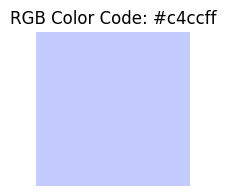

RGB Color Code: [196, 204, 255]
RGB Values (normalized): [ 0.59465882  0.35209702  0.16389437]
RGB Values (normalized): [ 151.63799999   89.78474032   41.79306387]


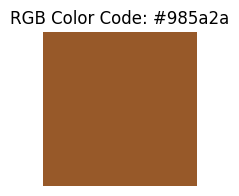

Calculated XYZ values for HPS lamp: (106.38606001467232, 93.883964230240508, 3.5500123049595138)
Chromatic adaptation matrix: 
[[ 0.00608012  0.00320387  0.00079937]
 [ 0.00127275  0.00937938 -0.00450027]
 [ 0.01654243 -0.00338719 -0.09945072]]
XYZ to RGB conversion matrix for HPS lamp: 
[[ 9.84871438 -4.67182611 -1.51518693]
 [-2.94589134  5.70176002  0.1263014 ]
 [ 0.16911705 -0.62009578  3.21322444]]
RGB Values (normalized): [ 1.          1.          0.49816777]
RGB Values (normalized): [ 255.          255.          127.03278137]


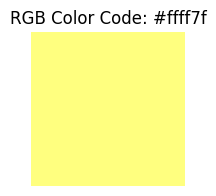

In [32]:
# CIE 1931 color matching functions data (sampled)
cie_data = np.array([[360, 0.0001299, 0.000003917, 0.0006061] , [361, 0.000145847, 0.000004393581, 0.0006808792] , [362, 0.0001638021, 0.000004929604, 0.0007651456] , [363, 0.0001840037, 0.000005532136, 0.0008600124] , [364, 0.0002066902, 0.000006208245, 0.0009665928] , [365, 0.0002321, 0.000006965, 0.001086] , [366, 0.000260728, 0.000007813219, 0.001220586] , [367, 0.000293075, 0.000008767336, 0.001372729] , [368, 0.000329388, 0.000009839844, 0.001543579] , [369, 0.000369914, 0.00001104323, 0.001734286] , [370, 0.0004149, 0.00001239, 0.001946] , [371, 0.0004641587, 0.00001388641, 0.002177777] , [372, 0.000518986, 0.00001555728, 0.002435809] , [373, 0.000581854, 0.00001744296, 0.002731953] , [374, 0.0006552347, 0.00001958375, 0.003078064] , [375, 0.0007416, 0.00002202, 0.003486] , [376, 0.0008450296, 0.00002483965, 0.003975227] , [377, 0.0009645268, 0.00002804126, 0.00454088] , [378, 0.001094949, 0.00003153104, 0.00515832] , [379, 0.001231154, 0.00003521521, 0.005802907] , [380, 0.001368, 0.000039, 0.006450001] , [381, 0.00150205, 0.0000428264, 0.007083216] , [382, 0.001642328, 0.0000469146, 0.007745488] , [383, 0.001802382, 0.0000515896, 0.008501152] , [384, 0.001995757, 0.0000571764, 0.009414544] , [385, 0.002236, 0.000064, 0.01054999] , [386, 0.002535385, 0.00007234421, 0.0119658] , [387, 0.002892603, 0.00008221224, 0.01365587] , [388, 0.003300829, 0.00009350816, 0.01558805] , [389, 0.003753236, 0.0001061361, 0.01773015] , [390, 0.004243, 0.00012, 0.02005001] , [391, 0.004762389, 0.000134984, 0.02251136] , [392, 0.005330048, 0.000151492, 0.02520288] , [393, 0.005978712, 0.000170208, 0.02827972] , [394, 0.006741117, 0.000191816, 0.03189704] , [395, 0.00765, 0.000217, 0.03621] , [396, 0.008751373, 0.0002469067, 0.04143771] , [397, 0.01002888, 0.00028124, 0.04750372] , [398, 0.0114217, 0.00031852, 0.05411988] , [399, 0.01286901, 0.0003572667, 0.06099803] , [400, 0.01431, 0.000396, 0.06785001] , [401, 0.01570443, 0.0004337147, 0.07448632] , [402, 0.01714744, 0.000473024, 0.08136156] , [403, 0.01878122, 0.000517876, 0.08915364] , [404, 0.02074801, 0.0005722187, 0.09854048] , [405, 0.02319, 0.00064, 0.1102] , [406, 0.02620736, 0.00072456, 0.1246133] , [407, 0.02978248, 0.0008255, 0.1417017] , [408, 0.03388092, 0.00094116, 0.1613035] , [409, 0.03846824, 0.00106988, 0.1832568] , [410, 0.04351, 0.00121, 0.2074] , [411, 0.0489956, 0.001362091, 0.2336921] , [412, 0.0550226, 0.001530752, 0.2626114] , [413, 0.0617188, 0.001720368, 0.2947746] , [414, 0.069212, 0.001935323, 0.3307985] , [415, 0.07763, 0.00218, 0.3713] , [416, 0.08695811, 0.0024548, 0.4162091] , [417, 0.09717672, 0.002764, 0.4654642] , [418, 0.1084063, 0.0031178, 0.5196948] , [419, 0.1207672, 0.0035264, 0.5795303] , [420, 0.13438, 0.004, 0.6456] , [421, 0.1493582, 0.00454624, 0.7184838] , [422, 0.1653957, 0.00515932, 0.7967133] , [423, 0.1819831, 0.00582928, 0.8778459] , [424, 0.198611, 0.00654616, 0.959439] , [425, 0.21477, 0.0073, 1.0390501] , [426, 0.2301868, 0.008086507, 1.1153673] , [427, 0.2448797, 0.00890872, 1.1884971] , [428, 0.2587773, 0.00976768, 1.2581233] , [429, 0.2718079, 0.01066443, 1.3239296] , [430, 0.2839, 0.0116, 1.3856] , [431, 0.2949438, 0.01257317, 1.4426352] , [432, 0.3048965, 0.01358272, 1.4948035] , [433, 0.3137873, 0.01462968, 1.5421903] , [434, 0.3216454, 0.01571509, 1.5848807] , [435, 0.3285, 0.01684, 1.62296] , [436, 0.3343513, 0.01800736, 1.6564048] , [437, 0.3392101, 0.01921448, 1.6852959] , [438, 0.3431213, 0.02045392, 1.7098745] , [439, 0.3461296, 0.02171824, 1.7303821] , [440, 0.34828, 0.023, 1.74706] , [441, 0.3495999, 0.02429461, 1.7600446] , [442, 0.3501474, 0.02561024, 1.7696233] , [443, 0.350013, 0.02695857, 1.7762637] , [444, 0.349287, 0.02835125, 1.7804334] , [445, 0.34806, 0.0298, 1.7826] , [446, 0.3463733, 0.03131083, 1.7829682] , [447, 0.3442624, 0.03288368, 1.7816998] , [448, 0.3418088, 0.03452112, 1.7791982] , [449, 0.3390941, 0.03622571, 1.7758671] , [450, 0.3362, 0.038, 1.77211] , [451, 0.3331977, 0.03984667, 1.7682589] , [452, 0.3300411, 0.041768, 1.764039] , [453, 0.3266357, 0.043766, 1.7589438] , [454, 0.3228868, 0.04584267, 1.7524663] , [455, 0.3187, 0.048, 1.7441] , [456, 0.3140251, 0.05024368, 1.7335595] , [457, 0.308884, 0.05257304, 1.7208581] , [458, 0.3032904, 0.05498056, 1.7059369] , [459, 0.2972579, 0.05745872, 1.6887372] , [460, 0.2908, 0.06, 1.6692] , [461, 0.2839701, 0.06260197, 1.6475287] , [462, 0.2767214, 0.06527752, 1.6234127] , [463, 0.2689178, 0.06804208, 1.5960223] , [464, 0.2604227, 0.07091109, 1.564528] , [465, 0.2511, 0.0739, 1.5281] , [466, 0.2408475, 0.077016, 1.4861114] , [467, 0.2298512, 0.0802664, 1.4395215] , [468, 0.2184072, 0.0836668, 1.3898799] , [469, 0.2068115, 0.0872328, 1.3387362] , [470, 0.19536, 0.09098, 1.28764] , [471, 0.1842136, 0.09491755, 1.2374223] , [472, 0.1733273, 0.09904584, 1.1878243] , [473, 0.1626881, 0.1033674, 1.1387611] , [474, 0.1522833, 0.1078846, 1.090148] , [475, 0.1421, 0.1126, 1.0419] , [476, 0.1321786, 0.117532, 0.9941976] , [477, 0.1225696, 0.1226744, 0.9473473] , [478, 0.1132752, 0.1279928, 0.9014531] , [479, 0.1042979, 0.1334528, 0.8566193] , [480, 0.09564, 0.13902, 0.8129501] , [481, 0.08729955, 0.1446764, 0.7705173] , [482, 0.07930804, 0.1504693, 0.7294448] , [483, 0.07171776, 0.1564619, 0.6899136] , [484, 0.06458099, 0.1627177, 0.6521049] , [485, 0.05795001, 0.1693, 0.6162] , [486, 0.05186211, 0.1762431, 0.5823286] , [487, 0.04628152, 0.1835581, 0.5504162] , [488, 0.04115088, 0.1912735, 0.5203376] , [489, 0.03641283, 0.199418, 0.4919673] , [490, 0.03201, 0.20802, 0.46518] , [491, 0.0279172, 0.2171199, 0.4399246] , [492, 0.0241444, 0.2267345, 0.4161836] , [493, 0.020687, 0.2368571, 0.3938822] , [494, 0.0175404, 0.2474812, 0.3729459] , [495, 0.0147, 0.2586, 0.3533] , [496, 0.01216179, 0.2701849, 0.3348578] , [497, 0.00991996, 0.2822939, 0.3175521] , [498, 0.00796724, 0.2950505, 0.3013375] , [499, 0.006296346, 0.308578, 0.2861686] , [500, 0.0049, 0.323, 0.272] , [501, 0.003777173, 0.3384021, 0.2588171] , [502, 0.00294532, 0.3546858, 0.2464838] , [503, 0.00242488, 0.3716986, 0.2347718] , [504, 0.002236293, 0.3892875, 0.2234533] , [505, 0.0024, 0.4073, 0.2123] , [506, 0.00292552, 0.4256299, 0.2011692] , [507, 0.00383656, 0.4443096, 0.1901196] , [508, 0.00517484, 0.4633944, 0.1792254] , [509, 0.00698208, 0.4829395, 0.1685608] , [510, 0.0093, 0.503, 0.1582] , [511, 0.01214949, 0.5235693, 0.1481383] , [512, 0.01553588, 0.544512, 0.1383758] , [513, 0.01947752, 0.56569, 0.1289942] , [514, 0.02399277, 0.5869653, 0.1200751] , [515, 0.0291, 0.6082, 0.1117] , [516, 0.03481485, 0.6293456, 0.1039048] , [517, 0.04112016, 0.6503068, 0.09666748] , [518, 0.04798504, 0.6708752, 0.08998272] , [519, 0.05537861, 0.6908424, 0.08384531] , [520, 0.06327, 0.71, 0.07824999] , [521, 0.07163501, 0.7281852, 0.07320899] , [522, 0.08046224, 0.7454636, 0.06867816] , [523, 0.08973996, 0.7619694, 0.06456784] , [524, 0.09945645, 0.7778368, 0.06078835] , [525, 0.1096, 0.7932, 0.05725001] , [526, 0.1201674, 0.8081104, 0.05390435] , [527, 0.1311145, 0.8224962, 0.05074664] , [528, 0.1423679, 0.8363068, 0.04775276] , [529, 0.1538542, 0.8494916, 0.04489859] , [530, 0.1655, 0.862, 0.04216] , [531, 0.1772571, 0.8738108, 0.03950728] , [532, 0.18914, 0.8849624, 0.03693564] , [533, 0.2011694, 0.8954936, 0.03445836] , [534, 0.2133658, 0.9054432, 0.03208872] , [535, 0.2257499, 0.9148501, 0.02984] , [536, 0.2383209, 0.9237348, 0.02771181] , [537, 0.2510668, 0.9320924, 0.02569444] , [538, 0.2639922, 0.9399226, 0.02378716] , [539, 0.2771017, 0.9472252, 0.02198925] , [540, 0.2904, 0.954, 0.0203] , [541, 0.3038912, 0.9602561, 0.01871805] , [542, 0.3175726, 0.9660074, 0.01724036] , [543, 0.3314384, 0.9712606, 0.01586364] , [544, 0.3454828, 0.9760225, 0.01458461] , [545, 0.3597, 0.9803, 0.0134] , [546, 0.3740839, 0.9840924, 0.01230723] , [547, 0.3886396, 0.9874182, 0.01130188] , [548, 0.4033784, 0.9903128, 0.01037792] , [549, 0.4183115, 0.9928116, 0.009529306] , [550, 0.4334499, 0.9949501, 0.008749999] , [551, 0.4487953, 0.9967108, 0.0080352] , [552, 0.464336, 0.9980983, 0.0073816] , [553, 0.480064, 0.999112, 0.0067854] , [554, 0.4959713, 0.9997482, 0.0062428] , [555, 0.5120501, 1, 0.005749999] , [556, 0.5282959, 0.9998567, 0.0053036] , [557, 0.5446916, 0.9993046, 0.0048998] , [558, 0.5612094, 0.9983255, 0.0045342] , [559, 0.5778215, 0.9968987, 0.0042024] , [560, 0.5945, 0.995, 0.0039] , [561, 0.6112209, 0.9926005, 0.0036232] , [562, 0.6279758, 0.9897426, 0.0033706] , [563, 0.6447602, 0.9864444, 0.0031414] , [564, 0.6615697, 0.9827241, 0.0029348] , [565, 0.6784, 0.9786, 0.002749999] , [566, 0.6952392, 0.9740837, 0.0025852] , [567, 0.7120586, 0.9691712, 0.0024386] , [568, 0.7288284, 0.9638568, 0.0023094] , [569, 0.7455188, 0.9581349, 0.0021968] , [570, 0.7621, 0.952, 0.0021] , [571, 0.7785432, 0.9454504, 0.002017733] , [572, 0.7948256, 0.9384992, 0.0019482] , [573, 0.8109264, 0.9311628, 0.0018898] , [574, 0.8268248, 0.9234576, 0.001840933] , [575, 0.8425, 0.9154, 0.0018] , [576, 0.8579325, 0.9070064, 0.001766267] , [577, 0.8730816, 0.8982772, 0.0017378] , [578, 0.8878944, 0.8892048, 0.0017112] , [579, 0.9023181, 0.8797816, 0.001683067] , [580, 0.9163, 0.87, 0.001650001] , [581, 0.9297995, 0.8598613, 0.001610133] , [582, 0.9427984, 0.849392, 0.0015644] , [583, 0.9552776, 0.838622, 0.0015136] , [584, 0.9672179, 0.8275813, 0.001458533] , [585, 0.9786, 0.8163, 0.0014] , [586, 0.9893856, 0.8047947, 0.001336667] , [587, 0.9995488, 0.793082, 0.00127] , [588, 1.0090892, 0.781192, 0.001205] , [589, 1.0180064, 0.7691547, 0.001146667] , [590, 1.0263, 0.757, 0.0011] , [591, 1.0339827, 0.7447541, 0.0010688] , [592, 1.040986, 0.7324224, 0.0010494] , [593, 1.047188, 0.7200036, 0.0010356] , [594, 1.0524667, 0.7074965, 0.0010212] , [595, 1.0567, 0.6949, 0.001] , [596, 1.0597944, 0.6822192, 0.00096864] , [597, 1.0617992, 0.6694716, 0.00092992] , [598, 1.0628068, 0.6566744, 0.00088688] , [599, 1.0629096, 0.6438448, 0.00084256] , [600, 1.0622, 0.631, 0.0008] , [601, 1.0607352, 0.6181555, 0.00076096] , [602, 1.0584436, 0.6053144, 0.00072368] , [603, 1.0552244, 0.5924756, 0.00068592] , [604, 1.0509768, 0.5796379, 0.00064544] , [605, 1.0456, 0.5668, 0.0006] , [606, 1.0390369, 0.5539611, 0.0005478667] , [607, 1.0313608, 0.5411372, 0.0004916] , [608, 1.0226662, 0.5283528, 0.0004354] , [609, 1.0130477, 0.5156323, 0.0003834667] , [610, 1.0026, 0.503, 0.00034] , [611, 0.9913675, 0.4904688, 0.0003072533] , [612, 0.9793314, 0.4780304, 0.00028316] , [613, 0.9664916, 0.4656776, 0.00026544] , [614, 0.9528479, 0.4534032, 0.0002518133] , [615, 0.9384, 0.4412, 0.00024] , [616, 0.923194, 0.42908, 0.0002295467] , [617, 0.907244, 0.417036, 0.00022064] , [618, 0.890502, 0.405032, 0.00021196] , [619, 0.87292, 0.393032, 0.0002021867] , [620, 0.8544499, 0.381, 0.00019] , [621, 0.835084, 0.3689184, 0.0001742133] , [622, 0.814946, 0.3568272, 0.00015564] , [623, 0.794186, 0.3447768, 0.00013596] , [624, 0.772954, 0.3328176, 0.0001168533] , [625, 0.7514, 0.321, 0.0001] , [626, 0.7295836, 0.3093381, 0.00008613333] , [627, 0.7075888, 0.2978504, 0.0000746] , [628, 0.6856022, 0.2865936, 0.000065] , [629, 0.6638104, 0.2756245, 0.00005693333] , [630, 0.6424, 0.265, 0.00004999999] , [631, 0.6215149, 0.2547632, 0.00004416] , [632, 0.6011138, 0.2448896, 0.00003948] , [633, 0.5811052, 0.2353344, 0.00003572] , [634, 0.5613977, 0.2260528, 0.00003264] , [635, 0.5419, 0.217, 0.00003] , [636, 0.5225995, 0.2081616, 0.00002765333] , [637, 0.5035464, 0.1995488, 0.00002556] , [638, 0.4847436, 0.1911552, 0.00002364] , [639, 0.4661939, 0.1829744, 0.00002181333] , [640, 0.4479, 0.175, 0.00002] , [641, 0.4298613, 0.1672235, 0.00001813333] , [642, 0.412098, 0.1596464, 0.0000162] , [643, 0.394644, 0.1522776, 0.0000142] , [644, 0.3775333, 0.1451259, 0.00001213333] , [645, 0.3608, 0.1382, 0.00001] , [646, 0.3444563, 0.1315003, 0.000007733333] , [647, 0.3285168, 0.1250248, 0.0000054] , [648, 0.3130192, 0.1187792, 0.0000032] , [649, 0.2980011, 0.1127691, 0.000001333333] , [650, 0.2835, 0.107, 0] , [651, 0.2695448, 0.1014762, 0] , [652, 0.2561184, 0.09618864, 0] , [653, 0.2431896, 0.09112296, 0] , [654, 0.2307272, 0.08626485, 0] , [655, 0.2187, 0.0816, 0] , [656, 0.2070971, 0.07712064, 0] , [657, 0.1959232, 0.07282552, 0] , [658, 0.1851708, 0.06871008, 0] , [659, 0.1748323, 0.06476976, 0] , [660, 0.1649, 0.061, 0] , [661, 0.1553667, 0.05739621, 0] , [662, 0.14623, 0.05395504, 0] , [663, 0.13749, 0.05067376, 0] , [664, 0.1291467, 0.04754965, 0] , [665, 0.1212, 0.04458, 0] , [666, 0.1136397, 0.04175872, 0] , [667, 0.106465, 0.03908496, 0] , [668, 0.09969044, 0.03656384, 0] , [669, 0.09333061, 0.03420048, 0] , [670, 0.0874, 0.032, 0] , [671, 0.08190096, 0.02996261, 0] , [672, 0.07680428, 0.02807664, 0] , [673, 0.07207712, 0.02632936, 0] , [674, 0.06768664, 0.02470805, 0] , [675, 0.0636, 0.0232, 0] , [676, 0.05980685, 0.02180077, 0] , [677, 0.05628216, 0.02050112, 0] , [678, 0.05297104, 0.01928108, 0] , [679, 0.04981861, 0.01812069, 0] , [680, 0.04677, 0.017, 0] , [681, 0.04378405, 0.01590379, 0] , [682, 0.04087536, 0.01483718, 0] , [683, 0.03807264, 0.01381068, 0] , [684, 0.03540461, 0.01283478, 0] , [685, 0.0329, 0.01192, 0] , [686, 0.03056419, 0.01106831, 0] , [687, 0.02838056, 0.01027339, 0] , [688, 0.02634484, 0.009533311, 0] , [689, 0.02445275, 0.008846157, 0] , [690, 0.0227, 0.00821, 0] , [691, 0.02108429, 0.007623781, 0] , [692, 0.01959988, 0.007085424, 0] , [693, 0.01823732, 0.006591476, 0] , [694, 0.01698717, 0.006138485, 0] , [695, 0.01584, 0.005723, 0] , [696, 0.01479064, 0.005343059, 0] , [697, 0.01383132, 0.004995796, 0] , [698, 0.01294868, 0.004676404, 0] , [699, 0.0121292, 0.004380075, 0] , [700, 0.01135916, 0.004102, 0] , [701, 0.01062935, 0.003838453, 0] , [702, 0.009938846, 0.003589099, 0] , [703, 0.009288422, 0.003354219, 0] , [704, 0.008678854, 0.003134093, 0] , [705, 0.008110916, 0.002929, 0] , [706, 0.007582388, 0.002738139, 0] , [707, 0.007088746, 0.002559876, 0] , [708, 0.006627313, 0.002393244, 0] , [709, 0.006195408, 0.002237275, 0] , [710, 0.005790346, 0.002091, 0] , [711, 0.005409826, 0.001953587, 0] , [712, 0.005052583, 0.00182458, 0] , [713, 0.004717512, 0.00170358, 0] , [714, 0.004403507, 0.001590187, 0] , [715, 0.004109457, 0.001484, 0] , [716, 0.003833913, 0.001384496, 0] , [717, 0.003575748, 0.001291268, 0] , [718, 0.003334342, 0.001204092, 0] , [719, 0.003109075, 0.001122744, 0] , [720, 0.002899327, 0.001047, 0] , [721, 0.002704348, 0.0009765896, 0] , [722, 0.00252302, 0.0009111088, 0] , [723, 0.002354168, 0.0008501332, 0] , [724, 0.002196616, 0.0007932384, 0] , [725, 0.00204919, 0.00074, 0] , [726, 0.00191096, 0.0006900827, 0] , [727, 0.001781438, 0.00064331, 0] , [728, 0.00166011, 0.000599496, 0] , [729, 0.001546459, 0.0005584547, 0] , [730, 0.001439971, 0.00052, 0] , [731, 0.001340042, 0.0004839136, 0] , [732, 0.001246275, 0.0004500528, 0] , [733, 0.001158471, 0.0004183452, 0] , [734, 0.00107643, 0.0003887184, 0] , [735, 0.0009999493, 0.0003611, 0] , [736, 0.0009287358, 0.0003353835, 0] , [737, 0.0008624332, 0.0003114404, 0] , [738, 0.0008007503, 0.0002891656, 0] , [739, 0.000743396, 0.0002684539, 0] , [740, 0.0006900786, 0.0002492, 0] , [741, 0.0006405156, 0.0002313019, 0] , [742, 0.0005945021, 0.0002146856, 0] , [743, 0.0005518646, 0.0001992884, 0] , [744, 0.000512429, 0.0001850475, 0] , [745, 0.0004760213, 0.0001719, 0] , [746, 0.0004424536, 0.0001597781, 0] , [747, 0.0004115117, 0.0001486044, 0] , [748, 0.0003829814, 0.0001383016, 0] , [749, 0.0003566491, 0.0001287925, 0] , [750, 0.0003323011, 0.00012, 0] , [751, 0.0003097586, 0.0001118595, 0] , [752, 0.0002888871, 0.0001043224, 0] , [753, 0.0002695394, 0.0000973356, 0] , [754, 0.0002515682, 0.00009084587, 0] , [755, 0.0002348261, 0.0000848, 0] , [756, 0.000219171, 0.00007914667, 0] , [757, 0.0002045258, 0.000073858, 0] , [758, 0.0001908405, 0.000068916, 0] , [759, 0.0001780654, 0.00006430267, 0] , [760, 0.0001661505, 0.00006, 0] , [761, 0.0001550236, 0.00005598187, 0] , [762, 0.0001446219, 0.0000522256, 0] , [763, 0.0001349098, 0.0000487184, 0] , [764, 0.000125852, 0.00004544747, 0] , [765, 0.000117413, 0.0000424, 0] , [766, 0.0001095515, 0.00003956104, 0] , [767, 0.0001022245, 0.00003691512, 0] , [768, 0.00009539445, 0.00003444868, 0] , [769, 0.0000890239, 0.00003214816, 0] , [770, 0.00008307527, 0.00003, 0] , [771, 0.00007751269, 0.00002799125, 0] , [772, 0.00007231304, 0.00002611356, 0] , [773, 0.00006745778, 0.00002436024, 0] , [774, 0.00006292844, 0.00002272461, 0] , [775, 0.00005870652, 0.0000212, 0] , [776, 0.00005477028, 0.00001977855, 0] , [777, 0.00005109918, 0.00001845285, 0] , [778, 0.00004767654, 0.00001721687, 0] , [779, 0.00004448567, 0.00001606459, 0] , [780, 0.00004150994, 0.00001499, 0] , [781, 0.00003873324, 0.00001398728, 0] , [782, 0.00003614203, 0.00001305155, 0] , [783, 0.00003372352, 0.00001217818, 0] , [784, 0.00003146487, 0.00001136254, 0] , [785, 0.00002935326, 0.0000106, 0] , [786, 0.00002737573, 0.000009885877, 0] , [787, 0.00002552433, 0.000009217304, 0] , [788, 0.00002379376, 0.000008592362, 0] , [789, 0.0000221787, 0.000008009133, 0] , [790, 0.00002067383, 0.0000074657, 0] , [791, 0.00001927226, 0.000006959567, 0] , [792, 0.0000179664, 0.000006487995, 0] , [793, 0.00001674991, 0.000006048699, 0] , [794, 0.00001561648, 0.000005639396, 0] , [795, 0.00001455977, 0.0000052578, 0] , [796, 0.00001357387, 0.000004901771, 0] , [797, 0.00001265436, 0.00000456972, 0] , [798, 0.00001179723, 0.000004260194, 0] , [799, 0.00001099844, 0.000003971739, 0] , [800, 0.00001025398, 0.0000037029, 0] , [801, 0.000009559646, 0.000003452163, 0] , [802, 0.000008912044, 0.000003218302, 0] , [803, 0.000008308358, 0.0000030003, 0] , [804, 0.000007745769, 0.000002797139, 0] , [805, 0.000007221456, 0.0000026078, 0] , [806, 0.000006732475, 0.00000243122, 0] , [807, 0.000006276423, 0.000002266531, 0] , [808, 0.000005851304, 0.000002113013, 0] , [809, 0.000005455118, 0.000001969943, 0] , [810, 0.000005085868, 0.0000018366, 0] , [811, 0.000004741466, 0.00000171223, 0] , [812, 0.000004420236, 0.000001596228, 0] , [813, 0.000004120783, 0.00000148809, 0] , [814, 0.000003841716, 0.000001387314, 0] , [815, 0.000003581652, 0.0000012934, 0] , [816, 0.000003339127, 0.00000120582, 0] , [817, 0.000003112949, 0.000001124143, 0] , [818, 0.000002902121, 0.000001048009, 0] , [819, 0.000002705645, 0.0000009770578, 0] , [820, 0.000002522525, 0.00000091093, 0] , [821, 0.000002351726, 0.0000008492513, 0] , [822, 0.000002192415, 0.0000007917212, 0] , [823, 0.000002043902, 0.0000007380904, 0] , [824, 0.000001905497, 0.0000006881098, 0] , [825, 0.000001776509, 0.00000064153, 0] , [826, 0.000001656215, 0.0000005980895, 0] , [827, 0.000001544022, 0.0000005575746, 0] , [828, 0.00000143944, 0.000000519808, 0] , [829, 0.000001341977, 0.0000004846123, 0] , [830, 0.000001251141, 0.00000045181, 0] ])

data = [(800.0, 799.5, 799.0, 798.5, 798.0, 797.5, 797.0, 796.5, 796.0, 795.5, 795.0, 794.5, 794.0, 793.5, 793.0, 792.5, 792.0, 791.5, 791.0, 790.5, 790.0, 789.5, 789.0, 788.5, 788.0, 787.5, 787.0, 786.5, 786.0, 785.5, 785.0, 784.5, 784.0, 783.5, 783.0, 782.5, 782.0, 781.5, 781.0, 780.5, 780.0, 779.5, 779.0, 778.5, 778.0, 777.5, 777.0, 776.5, 776.0, 775.5, 775.0, 774.5, 774.0, 773.5, 773.0, 772.5, 772.0, 771.5, 771.0, 770.5, 770.0, 769.5, 769.0, 768.5, 768.0, 767.5, 767.0, 766.5, 766.0, 765.5, 765.0, 764.5, 764.0, 763.5, 763.0, 762.5, 762.0, 761.5, 761.0, 760.5, 760.0, 759.5, 759.0, 758.5, 758.0, 757.5, 757.0, 756.5, 756.0, 755.5, 755.0, 754.5, 754.0, 753.5, 753.0, 752.5, 752.0, 751.5, 751.0, 750.5, 750.0, 749.5, 749.0, 748.5, 748.0, 747.5, 747.0, 746.5, 746.0, 745.5, 745.0, 744.5, 744.0, 743.5, 743.0, 742.5, 742.0, 741.5, 741.0, 740.5, 740.0, 739.5, 739.0, 738.5, 738.0, 737.5, 737.0, 736.5, 736.0, 735.5, 735.0, 734.5, 734.0, 733.5, 733.0, 732.5, 732.0, 731.5, 731.0, 730.5, 730.0, 729.5, 729.0, 728.5, 728.0, 727.5, 727.0, 726.5, 726.0, 725.5, 725.0, 724.5, 724.0, 723.5, 723.0, 722.5, 722.0, 721.5, 721.0, 720.5, 720.0, 719.5, 719.0, 718.5, 718.0, 717.5, 717.0, 716.5, 716.0, 715.5, 715.0, 714.5, 714.0, 713.5, 713.0, 712.5, 712.0, 711.5, 711.0, 710.5, 710.0, 709.5, 709.0, 708.5, 708.0, 707.5, 707.0, 706.5, 706.0, 705.5, 705.0, 704.5, 704.0, 703.5, 703.0, 702.5, 702.0, 701.5, 701.0, 700.5, 700.0, 699.5, 699.0, 698.5, 698.0, 697.5, 697.0, 696.5, 696.0, 695.5, 695.0, 694.5, 694.0, 693.5, 693.0, 692.5, 692.0, 691.5, 691.0, 690.5, 690.0, 689.5, 689.0, 688.5, 688.0, 687.5, 687.0, 686.5, 686.0, 685.5, 685.0, 684.5, 684.0, 683.5, 683.0, 682.5, 682.0, 681.5, 681.0, 680.5, 680.0, 679.5, 679.0, 678.5, 678.0, 677.5, 677.0, 676.5, 676.0, 675.5, 675.0, 674.5, 674.0, 673.5, 673.0, 672.5, 672.0, 671.5, 671.0, 670.5, 670.0, 669.5, 669.0, 668.5, 668.0, 667.5, 667.0, 666.5, 666.0, 665.5, 665.0, 664.5, 664.0, 663.5, 663.0, 662.5, 662.0, 661.5, 661.0, 660.5, 660.0, 659.5, 659.0, 658.5, 658.0, 657.5, 657.0, 656.5, 656.0, 655.5, 655.0, 654.5, 654.0, 653.5, 653.0, 652.5, 652.0, 651.5, 651.0, 650.5, 650.0, 649.5, 649.0, 648.5, 648.0, 647.5, 647.0, 646.5, 646.0, 645.5, 645.0, 644.5, 644.0, 643.5, 643.0, 642.5, 642.0, 641.5, 641.0, 640.5, 640.0, 639.5, 639.0, 638.5, 638.0, 637.5, 637.0, 636.5, 636.0, 635.5, 635.0, 634.5, 634.0, 633.5, 633.0, 632.5, 632.0, 631.5, 631.0, 630.5, 630.0, 629.5, 629.0, 628.5, 628.0, 627.5, 627.0, 626.5, 626.0, 625.5, 625.0, 624.5, 624.0, 623.5, 623.0, 622.5, 622.0, 621.5, 621.0, 620.5, 620.0, 619.5, 619.0, 618.5, 618.0, 617.5, 617.0, 616.5, 616.0, 615.5, 615.0, 614.5, 614.0, 613.5, 613.0, 612.5, 612.0, 611.5, 611.0, 610.5, 610.0, 609.5, 609.0, 608.5, 608.0, 607.5, 607.0, 606.5, 606.0, 605.5, 605.0, 604.5, 604.0, 603.5, 603.0, 602.5, 602.0, 601.5, 601.0, 600.5, 600.0, 599.5, 599.0, 598.5, 598.0, 597.5, 597.0, 596.5, 596.0, 595.5, 595.0, 594.5, 594.0, 593.5, 593.0, 592.5, 592.0, 591.5, 591.0, 590.5, 590.0, 589.5, 589.0, 588.5, 588.0, 587.5, 587.0, 586.5, 586.0, 585.5, 585.0, 584.5, 584.0, 583.5, 583.0, 582.5, 582.0, 581.5, 581.0, 580.5, 580.0, 579.5, 579.0, 578.5, 578.0, 577.5, 577.0, 576.5, 576.0, 575.5, 575.0, 574.5, 574.0, 573.5, 573.0, 572.5, 572.0, 571.5, 571.0, 570.5, 570.0, 569.5, 569.0, 568.5, 568.0, 567.5, 567.0, 566.5, 566.0, 565.5, 565.0, 564.5, 564.0, 563.5, 563.0, 562.5, 562.0, 561.5, 561.0, 560.5, 560.0, 559.5, 559.0, 558.5, 558.0, 557.5, 557.0, 556.5, 556.0, 555.5, 555.0, 554.5, 554.0, 553.5, 553.0, 552.5, 552.0, 551.5, 551.0, 550.5, 550.0, 549.5, 549.0, 548.5, 548.0, 547.5, 547.0, 546.5, 546.0, 545.5, 545.0, 544.5, 544.0, 543.5, 543.0, 542.5, 542.0, 541.5, 541.0, 540.5, 540.0, 539.5, 539.0, 538.5, 538.0, 537.5, 537.0, 536.5, 536.0, 535.5, 535.0, 534.5, 534.0, 533.5, 533.0, 532.5, 532.0, 531.5, 531.0, 530.5, 530.0, 529.5, 529.0, 528.5, 528.0, 527.5, 527.0, 526.5, 526.0, 525.5, 525.0, 524.5, 524.0, 523.5, 523.0, 522.5, 522.0, 521.5, 521.0, 520.5, 520.0, 519.5, 519.0, 518.5, 518.0, 517.5, 517.0, 516.5, 516.0, 515.5, 515.0, 514.5, 514.0, 513.5, 513.0, 512.5, 512.0, 511.5, 511.0, 510.5, 510.0, 509.5, 509.0, 508.5, 508.0, 507.5, 507.0, 506.5, 506.0, 505.5, 505.0, 504.5, 504.0, 503.5, 503.0, 502.5, 502.0, 501.5, 501.0, 500.5, 500.0, 499.5, 499.0, 498.5, 498.0, 497.5, 497.0, 496.5, 496.0, 495.5, 495.0, 494.5, 494.0, 493.5, 493.0, 492.5, 492.0, 491.5, 491.0, 490.5, 490.0, 489.5, 489.0, 488.5, 488.0, 487.5, 487.0, 486.5, 486.0, 485.5, 485.0, 484.5, 484.0, 483.5, 483.0, 482.5, 482.0, 481.5, 481.0, 480.5, 480.0, 479.5, 479.0, 478.5, 478.0, 477.5, 477.0, 476.5, 476.0, 475.5, 475.0, 474.5, 474.0, 473.5, 473.0, 472.5, 472.0, 471.5, 471.0, 470.5, 470.0, 469.5, 469.0, 468.5, 468.0, 467.5, 467.0, 466.5, 466.0, 465.5, 465.0, 464.5, 464.0, 463.5, 463.0, 462.5, 462.0, 461.5, 461.0, 460.5, 460.0, 459.5, 459.0, 458.5, 458.0, 457.5, 457.0, 456.5, 456.0, 455.5, 455.0, 454.5, 454.0, 453.5, 453.0, 452.5, 452.0, 451.5, 451.0, 450.5, 450.0, 449.5, 449.0, 448.5, 448.0, 447.5, 447.0, 446.5, 446.0, 445.5, 445.0, 444.5, 444.0, 443.5, 443.0, 442.5, 442.0, 441.5, 441.0, 440.5, 440.0, 439.5, 439.0, 438.5, 438.0, 437.5, 437.0, 436.5, 436.0, 435.5, 435.0, 434.5, 434.0, 433.5, 433.0, 432.5, 432.0, 431.5, 431.0, 430.5, 430.0, 429.5, 429.0, 428.5, 428.0, 427.5, 427.0, 426.5, 426.0, 425.5, 425.0, 424.5, 424.0, 423.5, 423.0, 422.5, 422.0, 421.5, 421.0, 420.5, 420.0, 419.5, 419.0, 418.5, 418.0, 417.5, 417.0, 416.5, 416.0, 415.5, 415.0, 414.5, 414.0, 413.5, 413.0, 412.5, 412.0, 411.5, 411.0, 410.5, 410.0, 409.5, 409.0, 408.5, 408.0, 407.5, 407.0, 406.5, 406.0, 405.5, 405.0, 404.5, 404.0, 403.5, 403.0, 402.5, 402.0, 401.5, 401.0, 400.5, 400.0, 399.5, 399.0, 398.5, 398.0, 397.5, 397.0, 396.5, 396.0, 395.5, 395.0, 394.5, 394.0, 393.5, 393.0, 392.5, 392.0, 391.5, 391.0, 390.5, 390.0, 389.5, 389.0, 388.5, 388.0, 387.5, 387.0, 386.5, 386.0, 385.5, 385.0, 384.5, 384.0, 383.5, 383.0, 382.5, 382.0, 381.5, 381.0, 380.5, 380.0, 379.5, 379.0, 378.5, 378.0, 377.5, 377.0, 376.5, 376.0, 375.5, 375.0, 374.5, 374.0, 373.5, 373.0, 372.5, 372.0, 371.5, 371.0, 370.5, 370.0, 369.5, 369.0, 368.5, 368.0, 367.5, 367.0, 366.5, 366.0, 365.5, 365.0, 364.5, 364.0, 363.5, 363.0, 362.5, 362.0, 361.5, 361.0, 360.5, 360.0, 359.5, 359.0, 358.5, 358.0, 357.5, 357.0, 356.5, 356.0, 355.5, 355.0, 354.5, 354.0, 353.5, 353.0, 352.5, 352.0, 351.5, 351.0, 350.5, 350.0, 349.5, 349.0, 348.5, 348.0, 347.5, 347.0, 346.5, 346.0, 345.5, 345.0, 344.5, 344.0, 343.5, 343.0, 342.5, 342.0, 341.5, 341.0, 340.5, 340.0, 339.5, 339.0, 338.5, 338.0, 337.5, 337.0, 336.5, 336.0, 335.5, 335.0, 334.5, 334.0, 333.5, 333.0, 332.5, 332.0, 331.5, 331.0, 330.5, 330.0, 329.5, 329.0, 328.5, 328.0, 327.5, 327.0, 326.5, 326.0, 325.5, 325.0, 324.5, 324.0, 323.5, 323.0, 322.5, 322.0, 321.5, 321.0, 320.5, 320.0, 319.5, 319.0, 318.5, 318.0, 317.5, 317.0, 316.5, 316.0, 315.5, 315.0, 314.5, 314.0, 313.5, 313.0, 312.5, 312.0, 311.5, 311.0, 310.5, 310.0, 309.5, 309.0, 308.5, 308.0, 307.5, 307.0, 306.5, 306.0, 305.5, 305.0, 304.5, 304.0, 303.5, 303.0, 302.5, 302.0, 301.5, 301.0, 300.5, 300.0, 299.5, 299.0, 298.5, 298.0, 297.5, 297.0, 296.5, 296.0, 295.5, 295.0, 294.5, 294.0, 293.5, 293.0, 292.5, 292.0, 291.5, 291.0, 290.5, 290.0, 289.5, 289.0, 288.5, 288.0, 287.5, 287.0, 286.5, 286.0, 285.5, 285.0, 284.5, 284.0, 283.5, 283.0, 282.5, 282.0, 281.5, 281.0, 280.5, 280.0, 279.5, 279.0, 278.5, 278.0, 277.5, 277.0, 276.5, 276.0, 275.5, 275.0, 274.5, 274.0, 273.5, 273.0, 272.5, 272.0, 271.5, 271.0, 270.5, 270.0, 269.5, 269.0, 268.5, 268.0, 267.5, 267.0, 266.5, 266.0, 265.5, 265.0, 264.5, 264.0, 263.5, 263.0, 262.5, 262.0, 261.5, 261.0, 260.5, 260.0, 259.5, 259.0, 258.5, 258.0, 257.5, 257.0, 256.5, 256.0, 255.5, 255.0, 254.5, 254.0, 253.5, 253.0, 252.5, 252.0, 251.5, 251.0, 250.5, 250.0, 249.5, 249.0, 248.5, 248.0, 247.5, 247.0, 246.5, 246.0, 245.5, 245.0, 244.5, 244.0, 243.5, 243.0, 242.5, 242.0, 241.5, 241.0, 240.5, 240.0, 239.5, 239.0, 238.5, 238.0, 237.5, 237.0, 236.5, 236.0, 235.5, 235.0, 234.5, 234.0, 233.5, 233.0, 232.5, 232.0, 231.5, 231.0, 230.5, 230.0, 229.5, 229.0, 228.5, 228.0, 227.5, 227.0, 226.5, 226.0, 225.5, 225.0, 224.5, 224.0, 223.5, 223.0, 222.5, 222.0, 221.5, 221.0, 220.5, 220.0, 219.5, 219.0, 218.5, 218.0, 217.5, 217.0, 216.5, 216.0, 215.5, 215.0, 214.5, 214.0, 213.5, 213.0, 212.5, 212.0, 211.5, 211.0, 210.5, 210.0, 209.5, 209.0, 208.5, 208.0, 207.5, 207.0, 206.5, 206.0, 205.5, 205.0, 204.5, 204.0, 203.5, 203.0, 202.5, 202.0, 201.5, 201.0, 200.5, 200.0), (0.0942046046257019, 0.09488464146852493, 0.09555435925722122, 0.09457355737686157, 0.09547871351242065, 0.09562567621469498, 0.09644222259521484, 0.09555360674858093, 0.09516233205795288, 0.09608491510152817, 0.09620600193738937, 0.0978948101401329, 0.09791506081819534, 0.09990835189819336, 0.10052329301834106, 0.10170157998800278, 0.101434625685215, 0.10089554637670517, 0.10148081183433533, 0.10228287428617477, 0.10339751094579697, 0.103115014731884, 0.10216223448514938, 0.10195948928594589, 0.10263428092002869, 0.1042083129286766, 0.10516496747732162, 0.10525020956993103, 0.10665620118379593, 0.10747126489877701, 0.10787729173898697, 0.10777568817138672, 0.10768342763185501, 0.1079515740275383, 0.10755392163991928, 0.10743392258882523, 0.10792482644319534, 0.10791078954935074, 0.10901402682065964, 0.11093637347221375, 0.11300244927406311, 0.11389990895986557, 0.11342648416757584, 0.11271669715642929, 0.11240305751562119, 0.11291161924600601, 0.11371279507875443, 0.11606625467538834, 0.11748545616865158, 0.11847937852144241, 0.1176765188574791, 0.11883756518363953, 0.1199561357498169, 0.12150219827890396, 0.12096812576055527, 0.12110387533903122, 0.12138710170984268, 0.12251555919647217, 0.12371400743722916, 0.12501271069049835, 0.1254393309354782, 0.12570834159851074, 0.1256968230009079, 0.12750573456287384, 0.12844954431056976, 0.12942835688591003, 0.129334956407547, 0.1293715238571167, 0.1306881159543991, 0.1312527358531952, 0.1326388120651245, 0.13321207463741302, 0.1338338702917099, 0.13416729867458344, 0.1355084776878357, 0.13720209896564484, 0.13891100883483887, 0.13808512687683105, 0.1392696648836136, 0.14023390412330627, 0.14218507707118988, 0.14247621595859528, 0.1424504965543747, 0.1432010680437088, 0.14484715461730957, 0.14700405299663544, 0.14835871756076813, 0.14899766445159912, 0.1493971198797226, 0.15052177011966705, 0.1508159339427948, 0.15253202617168427, 0.1526244431734085, 0.15397298336029053, 0.15359584987163544, 0.15561114251613617, 0.1568058282136917, 0.15912099182605743, 0.16050119698047638, 0.16226769983768463, 0.16232679784297943, 0.16286446154117584, 0.16383104026317596, 0.1663346141576767, 0.16807103157043457, 0.16843773424625397, 0.168643519282341, 0.16899921000003815, 0.17015540599822998, 0.17173133790493011, 0.1732180118560791, 0.17509335279464722, 0.17699389159679413, 0.17832231521606445, 0.17927385866641998, 0.1800335794687271, 0.18207649886608124, 0.1841949224472046, 0.18561749160289764, 0.1864015907049179, 0.18737930059432983, 0.18994353711605072, 0.19277815520763397, 0.19459259510040283, 0.19569461047649384, 0.19625909626483917, 0.197876438498497, 0.19967053830623627, 0.20205248892307281, 0.2046394944190979, 0.20705163478851318, 0.20917649567127228, 0.2112000435590744, 0.21266739070415497, 0.21318300068378448, 0.21476246416568756, 0.216811403632164, 0.22036223113536835, 0.22250111401081085, 0.22573812305927277, 0.2276834100484848, 0.2300012856721878, 0.23077230155467987, 0.2322167158126831, 0.23440657556056976, 0.2368675321340561, 0.23972946405410767, 0.24208785593509674, 0.24431289732456207, 0.24649442732334137, 0.24835674464702606, 0.25022125244140625, 0.25252842903137207, 0.2546103596687317, 0.2570643723011017, 0.2594732642173767, 0.2619730234146118, 0.2655136287212372, 0.26862001419067383, 0.2714724838733673, 0.27326706051826477, 0.2752859890460968, 0.27821311354637146, 0.280355304479599, 0.2834759056568146, 0.285696417093277, 0.28930994868278503, 0.2908174693584442, 0.2938239276409149, 0.29601821303367615, 0.29905378818511963, 0.30128827691078186, 0.3044312298297882, 0.3074701428413391, 0.3113609552383423, 0.3139550983905792, 0.3170118033885956, 0.3194226920604706, 0.3222247064113617, 0.32494911551475525, 0.3278718888759613, 0.33085790276527405, 0.33416152000427246, 0.3365604877471924, 0.33946001529693604, 0.3431548774242401, 0.3465397357940674, 0.3496500253677368, 0.3518831431865692, 0.35433265566825867, 0.3576233685016632, 0.35961058735847473, 0.3631253242492676, 0.36547431349754333, 0.36885032057762146, 0.37166789174079895, 0.37497854232788086, 0.37796905636787415, 0.3805905282497406, 0.38287243247032166, 0.38612332940101624, 0.38861802220344543, 0.391430139541626, 0.3939565122127533, 0.39726659655570984, 0.4008129835128784, 0.4038853347301483, 0.40768077969551086, 0.4104231894016266, 0.41337624192237854, 0.4157063663005829, 0.4189833700656891, 0.42183157801628113, 0.42441144585609436, 0.4266875982284546, 0.4290339946746826, 0.4319781959056854, 0.4351291358470917, 0.43856081366539, 0.44193652272224426, 0.44577518105506897, 0.44898340106010437, 0.45147132873535156, 0.4537915289402008, 0.45676329731941223, 0.4601958990097046, 0.463731050491333, 0.46733811497688293, 0.47120997309684753, 0.4744897186756134, 0.47797298431396484, 0.48132431507110596, 0.4848196804523468, 0.4891975224018097, 0.49261924624443054, 0.496852844953537, 0.5002458095550537, 0.5050088763237, 0.509303092956543, 0.5136669874191284, 0.5176517367362976, 0.5225102305412292, 0.5275547504425049, 0.5327593684196472, 0.53737872838974, 0.5421562194824219, 0.5469409823417664, 0.5516638159751892, 0.5558357238769531, 0.560704231262207, 0.5655774474143982, 0.5708292126655579, 0.5761333107948303, 0.5819660425186157, 0.5872993469238281, 0.5920925736427307, 0.5969538688659668, 0.6015041470527649, 0.6060654520988464, 0.6112295985221863, 0.6163149476051331, 0.6217934489250183, 0.6260856986045837, 0.6311495900154114, 0.6348375678062439, 0.6388080716133118, 0.6425741314888, 0.6460402607917786, 0.6481783986091614, 0.6505496501922607, 0.6542271971702576, 0.6574513912200928, 0.660261332988739, 0.6608073115348816, 0.6626487374305725, 0.6631062030792236, 0.6650441288948059, 0.6652778387069702, 0.6660619974136353, 0.6657869815826416, 0.6659734845161438, 0.6652681231498718, 0.6653766632080078, 0.6647242903709412, 0.6644580364227295, 0.6634050011634827, 0.6624988317489624, 0.6620402336120605, 0.6615775227546692, 0.6606736183166504, 0.6595174074172974, 0.6577432751655579, 0.657162606716156, 0.656765341758728, 0.6570499539375305, 0.6575412154197693, 0.6578760743141174, 0.657421886920929, 0.6567773818969727, 0.6561183929443359, 0.6568785309791565, 0.658385694026947, 0.6598396301269531, 0.6611770987510681, 0.6623079776763916, 0.6634330153465271, 0.6649381518363953, 0.6657379865646362, 0.6670907139778137, 0.6682672500610352, 0.6701610088348389, 0.6718185544013977, 0.6740415096282959, 0.6764174103736877, 0.6786813735961914, 0.6806073784828186, 0.6830368041992188, 0.6859378814697266, 0.6888599395751953, 0.6906945705413818, 0.6923151016235352, 0.6934611797332764, 0.6953464150428772, 0.697868824005127, 0.700516402721405, 0.7031359076499939, 0.7050186991691589, 0.7075335383415222, 0.7100014686584473, 0.7124974131584167, 0.7149390578269958, 0.7172223925590515, 0.7194773554801941, 0.7214012145996094, 0.7235760688781738, 0.7257930636405945, 0.7285203337669373, 0.7298402786254883, 0.7320765852928162, 0.733906090259552, 0.7369514107704163, 0.7387418150901794, 0.7398293614387512, 0.7415865063667297, 0.7438936829566956, 0.7464564442634583, 0.7478005290031433, 0.7491074204444885, 0.7507185339927673, 0.7529518008232117, 0.7551324367523193, 0.7572720050811768, 0.7583353519439697, 0.7598226070404053, 0.7616621851921082, 0.7640237808227539, 0.7653653025627136, 0.7668852806091309, 0.7679047584533691, 0.769097626209259, 0.7697033882141113, 0.771077573299408, 0.7732743620872498, 0.7753984928131104, 0.7774427533149719, 0.7789424061775208, 0.779789388179779, 0.7805739045143127, 0.7818992137908936, 0.7839138507843018, 0.7855093479156494, 0.7866461873054504, 0.7871572971343994, 0.7879448533058167, 0.7887408137321472, 0.7899063229560852, 0.7909558415412903, 0.7917906641960144, 0.7925601005554199, 0.7935994267463684, 0.7948885560035706, 0.7959602475166321, 0.7969151139259338, 0.7976934909820557, 0.7982239127159119, 0.7990095615386963, 0.8000245094299316, 0.8012339472770691, 0.8022260665893555, 0.8031315207481384, 0.8042524456977844, 0.8044540286064148, 0.8047041296958923, 0.8045656085014343, 0.8051986694335938, 0.8058128356933594, 0.8072530627250671, 0.8079224228858948, 0.808211624622345, 0.8083291053771973, 0.809204638004303, 0.810034453868866, 0.8102989196777344, 0.8105507493019104, 0.8108287453651428, 0.8115816712379456, 0.8129346966743469, 0.8134531378746033, 0.815090000629425, 0.8151854872703552, 0.8159223198890686, 0.8158164024353027, 0.8163482546806335, 0.8172321915626526, 0.8179326057434082, 0.818272590637207, 0.8184153437614441, 0.8181953430175781, 0.818964958190918, 0.8193967938423157, 0.8198341727256775, 0.8202362656593323, 0.820277988910675, 0.8207619190216064, 0.8209333419799805, 0.8220821022987366, 0.8226783871650696, 0.8229327201843262, 0.8229873776435852, 0.8227178454399109, 0.8231825828552246, 0.8230085968971252, 0.8231091499328613, 0.8225021958351135, 0.8227402567863464, 0.8229871392250061, 0.8238406181335449, 0.8236044049263, 0.8237864375114441, 0.8233556747436523, 0.8232536911964417, 0.8231606483459473, 0.8234054446220398, 0.8241527676582336, 0.824282169342041, 0.8241913318634033, 0.8235265612602234, 0.8229439854621887, 0.8223044276237488, 0.8216332793235779, 0.821803629398346, 0.8213638663291931, 0.8211546540260315, 0.8203943371772766, 0.8201353549957275, 0.8197059631347656, 0.8195644021034241, 0.8192084431648254, 0.819343090057373, 0.8190316557884216, 0.8188144564628601, 0.8174168467521667, 0.816929817199707, 0.8164291977882385, 0.8168246150016785, 0.815923273563385, 0.815148651599884, 0.8143957257270813, 0.8141374588012695, 0.8136232495307922, 0.8128929734230042, 0.8127923011779785, 0.8120630383491516, 0.8117901682853699, 0.8104695677757263, 0.8092734217643738, 0.807905912399292, 0.8064916729927063, 0.8058345913887024, 0.8049615025520325, 0.8048346042633057, 0.8042209148406982, 0.8035268187522888, 0.8018519282341003, 0.8012110590934753, 0.8008177876472473, 0.8007189631462097, 0.7994177937507629, 0.7983821034431458, 0.7973337769508362, 0.796821117401123, 0.7958250045776367, 0.7947092652320862, 0.7932114601135254, 0.7919484972953796, 0.7908938527107239, 0.7907721400260925, 0.7902718186378479, 0.7893968224525452, 0.788022518157959, 0.7866191864013672, 0.7851371169090271, 0.7835021018981934, 0.7827413082122803, 0.7819727063179016, 0.7813875675201416, 0.779975414276123, 0.7783933281898499, 0.7774115204811096, 0.776003897190094, 0.7754873633384705, 0.7735651135444641, 0.7729440331459045, 0.7717930674552917, 0.7707700729370117, 0.7694122195243835, 0.768000066280365, 0.7667181491851807, 0.765458881855011, 0.7641698718070984, 0.763416051864624, 0.7621073126792908, 0.7606210708618164, 0.7595402598381042, 0.7589640021324158, 0.7580464482307434, 0.756034791469574, 0.7546150088310242, 0.753365695476532, 0.7529623508453369, 0.7516059875488281, 0.7505752444267273, 0.7494962811470032, 0.7487816214561462, 0.747211217880249, 0.745932400226593, 0.7439649701118469, 0.7431361675262451, 0.7416588664054871, 0.7398836612701416, 0.7373884320259094, 0.7351904511451721, 0.7343197464942932, 0.7341690063476562, 0.7335924506187439, 0.7317679524421692, 0.730414867401123, 0.7292657494544983, 0.7286188006401062, 0.7268733978271484, 0.7251551747322083, 0.7238633036613464, 0.7226641178131104, 0.7217029929161072, 0.7197331786155701, 0.7187414765357971, 0.7169738411903381, 0.7161669731140137, 0.7150106430053711, 0.7141336798667908, 0.7122676968574524, 0.7107022404670715, 0.7093941569328308, 0.7086937427520752, 0.7075021862983704, 0.7062639594078064, 0.7044346928596497, 0.7025384902954102, 0.7004785537719727, 0.6995680928230286, 0.6982626914978027, 0.6972560882568359, 0.6959158778190613, 0.6953234672546387, 0.69431072473526, 0.6929998397827148, 0.6909236907958984, 0.689561128616333, 0.6882984638214111, 0.6868584156036377, 0.6851980090141296, 0.6833335757255554, 0.6818723082542419, 0.6807020306587219, 0.6797944903373718, 0.678900420665741, 0.6767933964729309, 0.6756672859191895, 0.6745296120643616, 0.6737265586853027, 0.6718478798866272, 0.6708442568778992, 0.6698966026306152, 0.6686895489692688, 0.6672294735908508, 0.6658098101615906, 0.6649667620658875, 0.6636167168617249, 0.6628907322883606, 0.6617208123207092, 0.6607798933982849, 0.6588907837867737, 0.6574316024780273, 0.656005322933197, 0.6551982760429382, 0.6539326310157776, 0.6527397036552429, 0.6518714427947998, 0.6508369445800781, 0.6500325798988342, 0.6485453844070435, 0.6475808024406433, 0.6463544964790344, 0.6458259224891663, 0.6451888680458069, 0.644368588924408, 0.6432507634162903, 0.6420561075210571, 0.6415449976921082, 0.6408252120018005, 0.640763521194458, 0.6397264003753662, 0.6386573314666748, 0.6372550129890442, 0.636497974395752, 0.6359193325042725, 0.6357000470161438, 0.6358742713928223, 0.636256992816925, 0.6356136798858643, 0.6346622109413147, 0.6339848637580872, 0.6340861916542053, 0.6336670517921448, 0.6326397061347961, 0.6312732696533203, 0.6307823657989502, 0.6306409239768982, 0.6308336853981018, 0.6303910613059998, 0.6303249001502991, 0.6298820376396179, 0.6300956606864929, 0.6302710771560669, 0.6308570504188538, 0.6310457587242126, 0.6307294368743896, 0.6313132643699646, 0.6314508318901062, 0.6318420767784119, 0.6311111450195312, 0.6313881874084473, 0.6314948201179504, 0.6323499083518982, 0.6323349475860596, 0.6329477429389954, 0.6336348056793213, 0.6344238519668579, 0.634991466999054, 0.6345183253288269, 0.6342601180076599, 0.6347582340240479, 0.6357840895652771, 0.6368257403373718, 0.6367180943489075, 0.6374004483222961, 0.6382264494895935, 0.6400904059410095, 0.6415597796440125, 0.6423770785331726, 0.6431880593299866, 0.644412100315094, 0.6453625559806824, 0.6457468867301941, 0.646170437335968, 0.6474652886390686, 0.6487842202186584, 0.6498879790306091, 0.6512753963470459, 0.6528342962265015, 0.6536059379577637, 0.6554157137870789, 0.6570682525634766, 0.6592581868171692, 0.6604614853858948, 0.6607295870780945, 0.6623928546905518, 0.6639519333839417, 0.6670486330986023, 0.6689274907112122, 0.6706803441047668, 0.6720901131629944, 0.673987627029419, 0.6764972805976868, 0.6794235706329346, 0.6820829510688782, 0.6846613883972168, 0.6867263913154602, 0.6881933212280273, 0.6908466219902039, 0.6939612030982971, 0.6980574131011963, 0.7007956504821777, 0.7035560607910156, 0.7053744196891785, 0.7090889811515808, 0.7129732966423035, 0.7174463272094727, 0.7204925417900085, 0.7242076396942139, 0.7279762625694275, 0.7321717143058777, 0.7355443835258484, 0.740125834941864, 0.7439996600151062, 0.7491931319236755, 0.7530851364135742, 0.7569442391395569, 0.7603861689567566, 0.7642741203308105, 0.7684733271598816, 0.7725870609283447, 0.7762793898582458, 0.7800967693328857, 0.7832769751548767, 0.7875922322273254, 0.7913482189178467, 0.7943570017814636, 0.796602725982666, 0.7992512583732605, 0.8021404147148132, 0.804358959197998, 0.8058340549468994, 0.8079023361206055, 0.8097273707389832, 0.8121556639671326, 0.8139874339103699, 0.8153610229492188, 0.8165267109870911, 0.8169777393341064, 0.81833416223526, 0.8198921084403992, 0.8214149475097656, 0.8227154612541199, 0.8236749172210693, 0.8264979720115662, 0.8288046717643738, 0.8309056162834167, 0.8325581550598145, 0.8344469666481018, 0.8361009955406189, 0.8368924260139465, 0.8383946418762207, 0.8403213620185852, 0.8426420092582703, 0.844473659992218, 0.8463274836540222, 0.8476806282997131, 0.8493255972862244, 0.8515567779541016, 0.8542008399963379, 0.8563410639762878, 0.8572047352790833, 0.8579900860786438, 0.8595330119132996, 0.8619787096977234, 0.864388644695282, 0.8669053912162781, 0.869182825088501, 0.8711451888084412, 0.8731560707092285, 0.874880850315094, 0.8767091631889343, 0.8782756328582764, 0.8791718482971191, 0.8816852569580078, 0.88336181640625, 0.8862659335136414, 0.887502133846283, 0.8891485333442688, 0.8908230662345886, 0.8915174603462219, 0.8923719525337219, 0.8927261233329773, 0.894043505191803, 0.8946480751037598, 0.8946605324745178, 0.8951582312583923, 0.8958891034126282, 0.8968214988708496, 0.8962483406066895, 0.8960006237030029, 0.8959267139434814, 0.897054135799408, 0.8981709480285645, 0.8987653851509094, 0.8992806077003479, 0.8987320065498352, 0.8986256718635559, 0.8982366919517517, 0.8991098403930664, 0.9000118374824524, 0.9001532196998596, 0.8999514579772949, 0.9002460837364197, 0.9004409909248352, 0.9014496803283691, 0.901538610458374, 0.9032160639762878, 0.9051699042320251, 0.9081471562385559, 0.9097548127174377, 0.9107348918914795, 0.9122026562690735, 0.9160106778144836, 0.9198244214057922, 0.9218246340751648, 0.9235851764678955, 0.9259953498840332, 0.9294504523277283, 0.9328455924987793, 0.9351789951324463, 0.9380837082862854, 0.9417399764060974, 0.9460382461547852, 0.9511411786079407, 0.9551517367362976, 0.9583894610404968, 0.9619436264038086, 0.9661149382591248, 0.9715558886528015, 0.9750234484672546, 0.9782354235649109, 0.9807455539703369, 0.9851393699645996, 0.9890825152397156, 0.9935660362243652, 0.9966928362846375, 0.998881995677948, 1.0019344091415405, 1.0053073167800903, 1.009198546409607, 1.0128222703933716, 1.0153037309646606, 1.0188263654708862, 1.0222549438476562, 1.0252577066421509, 1.0297510623931885, 1.0313761234283447, 1.0349653959274292, 1.0357075929641724, 1.039513111114502, 1.0417636632919312, 1.0440205335617065, 1.045506238937378, 1.049416422843933, 1.0545727014541626, 1.058366298675537, 1.0603028535842896, 1.0616217851638794, 1.0634853839874268, 1.0654923915863037, 1.0691872835159302, 1.0718659162521362, 1.076383352279663, 1.0783931016921997, 1.0802963972091675, 1.0821497440338135, 1.0833860635757446, 1.0853685140609741, 1.0866971015930176, 1.088943600654602, 1.0911788940429688, 1.0923696756362915, 1.0958133935928345, 1.0968135595321655, 1.0982218980789185, 1.0979124307632446, 1.0995534658432007, 1.0987694263458252, 1.09919273853302, 1.0992425680160522, 1.102120041847229, 1.1020283699035645, 1.10373854637146, 1.1049233675003052, 1.106832504272461, 1.1057305335998535, 1.1041871309280396, 1.1040219068527222, 1.1044808626174927, 1.1045466661453247, 1.1045650243759155, 1.1056054830551147, 1.1060514450073242, 1.1061269044876099, 1.1057391166687012, 1.1069155931472778, 1.1065177917480469, 1.1064810752868652, 1.1058775186538696, 1.1081622838974, 1.1073611974716187, 1.1051658391952515, 1.1043126583099365, 1.1063061952590942, 1.10979425907135, 1.1101031303405762, 1.1075000762939453, 1.106905221939087, 1.1071820259094238, 1.109627604484558, 1.1101654767990112, 1.1071820259094238, 1.1051568984985352, 1.1035617589950562, 1.1020541191101074, 1.1022332906723022, 1.1007221937179565, 1.097941279411316, 1.0962390899658203, 1.0936990976333618, 1.093705654144287, 1.0938096046447754, 1.0944629907608032, 1.0976287126541138, 1.0971425771713257, 1.0959250926971436, 1.0947929620742798, 1.093978762626648, 1.0915920734405518, 1.0885939598083496, 1.08208167552948, 1.0838371515274048, 1.0818060636520386, 1.0855562686920166, 1.0819320678710938, 1.080247402191162, 1.0775331258773804, 1.0776169300079346, 1.0767865180969238, 1.0747746229171753, 1.071690320968628, 1.0678893327713013, 1.067671298980713, 1.0627697706222534, 1.0634199380874634, 1.0610276460647583, 1.0634733438491821, 1.0594640970230103, 1.0561342239379883, 1.0556896924972534, 1.0588942766189575, 1.0564409494400024, 1.0538231134414673, 1.0488896369934082, 1.0479995012283325, 1.0465998649597168, 1.0436550378799438, 1.0411959886550903, 1.037103533744812, 1.0361522436141968, 1.0369189977645874, 1.037070631980896, 1.0379308462142944, 1.0365732908248901, 1.0337294340133667, 1.0307341814041138, 1.0283564329147339, 1.0299091339111328, 1.0290940999984741, 1.0278414487838745, 1.0219918489456177, 1.0205645561218262, 1.0164016485214233, 1.0187205076217651, 1.0148037672042847, 1.0169376134872437, 1.0167964696884155, 1.0188874006271362, 1.0213478803634644, 1.0188730955123901, 1.0203797817230225, 1.0207024812698364, 1.0241507291793823, 1.027237057685852, 1.0327051877975464, 1.0341075658798218, 1.035875678062439, 1.0337966680526733, 1.0402594804763794, 1.042154312133789, 1.0469361543655396, 1.0510954856872559, 1.0575975179672241, 1.0609499216079712, 1.0655418634414673, 1.0707756280899048, 1.079999566078186, 1.085842251777649, 1.0993086099624634, 1.1027464866638184, 1.1084665060043335, 1.111554741859436, 1.1243369579315186, 1.1375439167022705, 1.1479963064193726, 1.1515294313430786, 1.1569339036941528, 1.167261004447937, 1.1786391735076904, 1.1908574104309082, 1.2002018690109253, 1.2108649015426636, 1.221414566040039, 1.2330033779144287, 1.2422984838485718, 1.250830054283142, 1.2516136169433594, 1.2614156007766724, 1.2596379518508911, 1.2619668245315552, 1.2609362602233887, 1.2699542045593262, 1.2769851684570312, 1.2787834405899048, 1.2803810834884644, 1.2859619855880737, 1.28876531124115, 1.2959723472595215, 1.2963656187057495, 1.3029519319534302, 1.3005744218826294, 1.3018466234207153, 1.3011265993118286, 1.3020365238189697, 1.3039813041687012, 1.3022609949111938, 1.3055590391159058, 1.3082823753356934, 1.315808892250061, 1.3180691003799438, 1.318008303642273, 1.3236180543899536, 1.3217408657073975, 1.3230892419815063, 1.3160322904586792, 1.3233669996261597, 1.326694130897522, 1.3317551612854004, 1.3281117677688599, 1.3248971700668335, 1.3230962753295898, 1.3294349908828735, 1.334630012512207, 1.344612956047058, 1.3449063301086426, 1.344933032989502, 1.3426876068115234, 1.344439148902893, 1.3505048751831055, 1.3516755104064941, 1.3461939096450806, 1.3423019647598267, 1.344614863395691, 1.3443413972854614, 1.3431224822998047, 1.3375784158706665, 1.3426238298416138, 1.3438587188720703, 1.340849757194519, 1.3401142358779907, 1.3377596139907837, 1.3390321731567383, 1.3390792608261108, 1.3367034196853638, 1.3405122756958008, 1.339414119720459, 1.3466895818710327, 1.3500080108642578, 1.3463882207870483, 1.3418039083480835, 1.3348995447158813, 1.334736943244934, 1.3320446014404297, 1.3389310836791992, 1.3422759771347046, 1.3433070182800293, 1.3376988172531128, 1.336816668510437, 1.3354142904281616, 1.3314642906188965, 1.3276748657226562, 1.3296412229537964, 1.3314238786697388, 1.3325061798095703, 1.3242570161819458, 1.3198641538619995, 1.3107432126998901, 1.3102999925613403, 1.303164005279541, 1.306161880493164, 1.3024901151657104, 1.3024739027023315, 1.2984331846237183, 1.3028950691223145, 1.3009663820266724, 1.2949525117874146, 1.286226749420166, 1.2886643409729004, 1.2913132905960083, 1.293160319328308, 1.285839319229126, 1.287602424621582, 1.290149450302124, 1.2900651693344116, 1.291214108467102, 1.2868213653564453, 1.294333577156067, 1.294896125793457, 1.2961513996124268, 1.2909082174301147, 1.288123369216919, 1.2910720109939575, 1.297256588935852, 1.2977674007415771, 1.2964082956314087, 1.2900277376174927, 1.2923351526260376, 1.296911358833313, 1.2947086095809937, 1.289293885231018, 1.2859697341918945, 1.2916780710220337, 1.2929339408874512, 1.292765736579895, 1.2899020910263062, 1.2977436780929565, 1.2945806980133057, 1.2997320890426636, 1.290516972541809, 1.2880359888076782, 1.2860780954360962, 1.289021611213684, 1.2962411642074585, 1.2931432723999023, 1.2989078760147095, 1.3013999462127686, 1.2972995042800903, 1.285870909690857, 1.2890900373458862, 1.307097315788269, 1.3155654668807983, 1.3197764158248901, 1.3105686902999878, 1.3161879777908325, 1.3061975240707397, 1.3002046346664429, 1.3062423467636108, 1.2983983755111694, 1.3057879209518433, 1.3059002161026, 1.3138909339904785, 1.329379677772522, 1.3184633255004883, 1.3248077630996704, 1.3097809553146362, 1.304976463317871, 1.3018916845321655, 1.3052464723587036, 1.316165804862976, 1.3116754293441772, 1.3178938627243042, 1.3126215934753418, 1.332028865814209, 1.3152252435684204, 1.310438632965088, 1.2896188497543335, 1.2991979122161865, 1.2948224544525146, 1.298473834991455, 1.3073185682296753, 1.3178635835647583, 1.317181944847107, 1.2996395826339722, 1.2856721878051758, 1.288391351699829, 1.306294560432434, 1.2925928831100464, 1.2857459783554077, 1.2546371221542358, 1.2474082708358765, 1.2529906034469604, 1.2462574243545532, 1.2589353322982788, 1.238486409187317, 1.2353335618972778, 1.2208133935928345, 1.235363483428955, 1.2262557744979858, 1.2223916053771973)]
data = [(800.0, 799.5, 799.0, 798.5, 798.0, 797.5, 797.0, 796.5, 796.0, 795.5, 795.0, 794.5, 794.0, 793.5, 793.0, 792.5, 792.0, 791.5, 791.0, 790.5, 790.0, 789.5, 789.0, 788.5, 788.0, 787.5, 787.0, 786.5, 786.0, 785.5, 785.0, 784.5, 784.0, 783.5, 783.0, 782.5, 782.0, 781.5, 781.0, 780.5, 780.0, 779.5, 779.0, 778.5, 778.0, 777.5, 777.0, 776.5, 776.0, 775.5, 775.0, 774.5, 774.0, 773.5, 773.0, 772.5, 772.0, 771.5, 771.0, 770.5, 770.0, 769.5, 769.0, 768.5, 768.0, 767.5, 767.0, 766.5, 766.0, 765.5, 765.0, 764.5, 764.0, 763.5, 763.0, 762.5, 762.0, 761.5, 761.0, 760.5, 760.0, 759.5, 759.0, 758.5, 758.0, 757.5, 757.0, 756.5, 756.0, 755.5, 755.0, 754.5, 754.0, 753.5, 753.0, 752.5, 752.0, 751.5, 751.0, 750.5, 750.0, 749.5, 749.0, 748.5, 748.0, 747.5, 747.0, 746.5, 746.0, 745.5, 745.0, 744.5, 744.0, 743.5, 743.0, 742.5, 742.0, 741.5, 741.0, 740.5, 740.0, 739.5, 739.0, 738.5, 738.0, 737.5, 737.0, 736.5, 736.0, 735.5, 735.0, 734.5, 734.0, 733.5, 733.0, 732.5, 732.0, 731.5, 731.0, 730.5, 730.0, 729.5, 729.0, 728.5, 728.0, 727.5, 727.0, 726.5, 726.0, 725.5, 725.0, 724.5, 724.0, 723.5, 723.0, 722.5, 722.0, 721.5, 721.0, 720.5, 720.0, 719.5, 719.0, 718.5, 718.0, 717.5, 717.0, 716.5, 716.0, 715.5, 715.0, 714.5, 714.0, 713.5, 713.0, 712.5, 712.0, 711.5, 711.0, 710.5, 710.0, 709.5, 709.0, 708.5, 708.0, 707.5, 707.0, 706.5, 706.0, 705.5, 705.0, 704.5, 704.0, 703.5, 703.0, 702.5, 702.0, 701.5, 701.0, 700.5, 700.0, 699.5, 699.0, 698.5, 698.0, 697.5, 697.0, 696.5, 696.0, 695.5, 695.0, 694.5, 694.0, 693.5, 693.0, 692.5, 692.0, 691.5, 691.0, 690.5, 690.0, 689.5, 689.0, 688.5, 688.0, 687.5, 687.0, 686.5, 686.0, 685.5, 685.0, 684.5, 684.0, 683.5, 683.0, 682.5, 682.0, 681.5, 681.0, 680.5, 680.0, 679.5, 679.0, 678.5, 678.0, 677.5, 677.0, 676.5, 676.0, 675.5, 675.0, 674.5, 674.0, 673.5, 673.0, 672.5, 672.0, 671.5, 671.0, 670.5, 670.0, 669.5, 669.0, 668.5, 668.0, 667.5, 667.0, 666.5, 666.0, 665.5, 665.0, 664.5, 664.0, 663.5, 663.0, 662.5, 662.0, 661.5, 661.0, 660.5, 660.0, 659.5, 659.0, 658.5, 658.0, 657.5, 657.0, 656.5, 656.0, 655.5, 655.0, 654.5, 654.0, 653.5, 653.0, 652.5, 652.0, 651.5, 651.0, 650.5, 650.0, 649.5, 649.0, 648.5, 648.0, 647.5, 647.0, 646.5, 646.0, 645.5, 645.0, 644.5, 644.0, 643.5, 643.0, 642.5, 642.0, 641.5, 641.0, 640.5, 640.0, 639.5, 639.0, 638.5, 638.0, 637.5, 637.0, 636.5, 636.0, 635.5, 635.0, 634.5, 634.0, 633.5, 633.0, 632.5, 632.0, 631.5, 631.0, 630.5, 630.0, 629.5, 629.0, 628.5, 628.0, 627.5, 627.0, 626.5, 626.0, 625.5, 625.0, 624.5, 624.0, 623.5, 623.0, 622.5, 622.0, 621.5, 621.0, 620.5, 620.0, 619.5, 619.0, 618.5, 618.0, 617.5, 617.0, 616.5, 616.0, 615.5, 615.0, 614.5, 614.0, 613.5, 613.0, 612.5, 612.0, 611.5, 611.0, 610.5, 610.0, 609.5, 609.0, 608.5, 608.0, 607.5, 607.0, 606.5, 606.0, 605.5, 605.0, 604.5, 604.0, 603.5, 603.0, 602.5, 602.0, 601.5, 601.0, 600.5, 600.0, 599.5, 599.0, 598.5, 598.0, 597.5, 597.0, 596.5, 596.0, 595.5, 595.0, 594.5, 594.0, 593.5, 593.0, 592.5, 592.0, 591.5, 591.0, 590.5, 590.0, 589.5, 589.0, 588.5, 588.0, 587.5, 587.0, 586.5, 586.0, 585.5, 585.0, 584.5, 584.0, 583.5, 583.0, 582.5, 582.0, 581.5, 581.0, 580.5, 580.0, 579.5, 579.0, 578.5, 578.0, 577.5, 577.0, 576.5, 576.0, 575.5, 575.0, 574.5, 574.0, 573.5, 573.0, 572.5, 572.0, 571.5, 571.0, 570.5, 570.0, 569.5, 569.0, 568.5, 568.0, 567.5, 567.0, 566.5, 566.0, 565.5, 565.0, 564.5, 564.0, 563.5, 563.0, 562.5, 562.0, 561.5, 561.0, 560.5, 560.0, 559.5, 559.0, 558.5, 558.0, 557.5, 557.0, 556.5, 556.0, 555.5, 555.0, 554.5, 554.0, 553.5, 553.0, 552.5, 552.0, 551.5, 551.0, 550.5, 550.0, 549.5, 549.0, 548.5, 548.0, 547.5, 547.0, 546.5, 546.0, 545.5, 545.0, 544.5, 544.0, 543.5, 543.0, 542.5, 542.0, 541.5, 541.0, 540.5, 540.0, 539.5, 539.0, 538.5, 538.0, 537.5, 537.0, 536.5, 536.0, 535.5, 535.0, 534.5, 534.0, 533.5, 533.0, 532.5, 532.0, 531.5, 531.0, 530.5, 530.0, 529.5, 529.0, 528.5, 528.0, 527.5, 527.0, 526.5, 526.0, 525.5, 525.0, 524.5, 524.0, 523.5, 523.0, 522.5, 522.0, 521.5, 521.0, 520.5, 520.0, 519.5, 519.0, 518.5, 518.0, 517.5, 517.0, 516.5, 516.0, 515.5, 515.0, 514.5, 514.0, 513.5, 513.0, 512.5, 512.0, 511.5, 511.0, 510.5, 510.0, 509.5, 509.0, 508.5, 508.0, 507.5, 507.0, 506.5, 506.0, 505.5, 505.0, 504.5, 504.0, 503.5, 503.0, 502.5, 502.0, 501.5, 501.0, 500.5, 500.0, 499.5, 499.0, 498.5, 498.0, 497.5, 497.0, 496.5, 496.0, 495.5, 495.0, 494.5, 494.0, 493.5, 493.0, 492.5, 492.0, 491.5, 491.0, 490.5, 490.0, 489.5, 489.0, 488.5, 488.0, 487.5, 487.0, 486.5, 486.0, 485.5, 485.0, 484.5, 484.0, 483.5, 483.0, 482.5, 482.0, 481.5, 481.0, 480.5, 480.0, 479.5, 479.0, 478.5, 478.0, 477.5, 477.0, 476.5, 476.0, 475.5, 475.0, 474.5, 474.0, 473.5, 473.0, 472.5, 472.0, 471.5, 471.0, 470.5, 470.0, 469.5, 469.0, 468.5, 468.0, 467.5, 467.0, 466.5, 466.0, 465.5, 465.0, 464.5, 464.0, 463.5, 463.0, 462.5, 462.0, 461.5, 461.0, 460.5, 460.0, 459.5, 459.0, 458.5, 458.0, 457.5, 457.0, 456.5, 456.0, 455.5, 455.0, 454.5, 454.0, 453.5, 453.0, 452.5, 452.0, 451.5, 451.0, 450.5, 450.0, 449.5, 449.0, 448.5, 448.0, 447.5, 447.0, 446.5, 446.0, 445.5, 445.0, 444.5, 444.0, 443.5, 443.0, 442.5, 442.0, 441.5, 441.0, 440.5, 440.0, 439.5, 439.0, 438.5, 438.0, 437.5, 437.0, 436.5, 436.0, 435.5, 435.0, 434.5, 434.0, 433.5, 433.0, 432.5, 432.0, 431.5, 431.0, 430.5, 430.0, 429.5, 429.0, 428.5, 428.0, 427.5, 427.0, 426.5, 426.0, 425.5, 425.0, 424.5, 424.0, 423.5, 423.0, 422.5, 422.0, 421.5, 421.0, 420.5, 420.0, 419.5, 419.0, 418.5, 418.0, 417.5, 417.0, 416.5, 416.0, 415.5, 415.0, 414.5, 414.0, 413.5, 413.0, 412.5, 412.0, 411.5, 411.0, 410.5, 410.0, 409.5, 409.0, 408.5, 408.0, 407.5, 407.0, 406.5, 406.0, 405.5, 405.0, 404.5, 404.0, 403.5, 403.0, 402.5, 402.0, 401.5, 401.0, 400.5, 400.0, 399.5, 399.0, 398.5, 398.0, 397.5, 397.0, 396.5, 396.0, 395.5, 395.0, 394.5, 394.0, 393.5, 393.0, 392.5, 392.0, 391.5, 391.0, 390.5, 390.0, 389.5, 389.0, 388.5, 388.0, 387.5, 387.0, 386.5, 386.0, 385.5, 385.0, 384.5, 384.0, 383.5, 383.0, 382.5, 382.0, 381.5, 381.0, 380.5, 380.0, 379.5, 379.0, 378.5, 378.0, 377.5, 377.0, 376.5, 376.0, 375.5, 375.0, 374.5, 374.0, 373.5, 373.0, 372.5, 372.0, 371.5, 371.0, 370.5, 370.0, 369.5, 369.0, 368.5, 368.0, 367.5, 367.0, 366.5, 366.0, 365.5, 365.0, 364.5, 364.0, 363.5, 363.0, 362.5, 362.0, 361.5, 361.0, 360.5, 360.0, 359.5, 359.0, 358.5, 358.0, 357.5, 357.0, 356.5, 356.0, 355.5, 355.0, 354.5, 354.0, 353.5, 353.0, 352.5, 352.0, 351.5, 351.0, 350.5, 350.0, 349.5, 349.0, 348.5, 348.0, 347.5, 347.0, 346.5, 346.0, 345.5, 345.0, 344.5, 344.0, 343.5, 343.0, 342.5, 342.0, 341.5, 341.0, 340.5, 340.0, 339.5, 339.0, 338.5, 338.0, 337.5, 337.0, 336.5, 336.0, 335.5, 335.0, 334.5, 334.0, 333.5, 333.0, 332.5, 332.0, 331.5, 331.0, 330.5, 330.0, 329.5, 329.0, 328.5, 328.0, 327.5, 327.0, 326.5, 326.0, 325.5, 325.0, 324.5, 324.0, 323.5, 323.0, 322.5, 322.0, 321.5, 321.0, 320.5, 320.0, 319.5, 319.0, 318.5, 318.0, 317.5, 317.0, 316.5, 316.0, 315.5, 315.0, 314.5, 314.0, 313.5, 313.0, 312.5, 312.0, 311.5, 311.0, 310.5, 310.0, 309.5, 309.0, 308.5, 308.0, 307.5, 307.0, 306.5, 306.0, 305.5, 305.0, 304.5, 304.0, 303.5, 303.0, 302.5, 302.0, 301.5, 301.0, 300.5, 300.0, 299.5, 299.0, 298.5, 298.0, 297.5, 297.0, 296.5, 296.0, 295.5, 295.0, 294.5, 294.0, 293.5, 293.0, 292.5, 292.0, 291.5, 291.0, 290.5, 290.0, 289.5, 289.0, 288.5, 288.0, 287.5, 287.0, 286.5, 286.0, 285.5, 285.0, 284.5, 284.0, 283.5, 283.0, 282.5, 282.0, 281.5, 281.0, 280.5, 280.0, 279.5, 279.0, 278.5, 278.0, 277.5, 277.0, 276.5, 276.0, 275.5, 275.0, 274.5, 274.0, 273.5, 273.0, 272.5, 272.0, 271.5, 271.0, 270.5, 270.0, 269.5, 269.0, 268.5, 268.0, 267.5, 267.0, 266.5, 266.0, 265.5, 265.0, 264.5, 264.0, 263.5, 263.0, 262.5, 262.0, 261.5, 261.0, 260.5, 260.0, 259.5, 259.0, 258.5, 258.0, 257.5, 257.0, 256.5, 256.0, 255.5, 255.0, 254.5, 254.0, 253.5, 253.0, 252.5, 252.0, 251.5, 251.0, 250.5, 250.0, 249.5, 249.0, 248.5, 248.0, 247.5, 247.0, 246.5, 246.0, 245.5, 245.0, 244.5, 244.0, 243.5, 243.0, 242.5, 242.0, 241.5, 241.0, 240.5, 240.0, 239.5, 239.0, 238.5, 238.0, 237.5, 237.0, 236.5, 236.0, 235.5, 235.0, 234.5, 234.0, 233.5, 233.0, 232.5, 232.0, 231.5, 231.0, 230.5, 230.0, 229.5, 229.0, 228.5, 228.0, 227.5, 227.0, 226.5, 226.0, 225.5, 225.0, 224.5, 224.0, 223.5, 223.0, 222.5, 222.0, 221.5, 221.0, 220.5, 220.0, 219.5, 219.0, 218.5, 218.0, 217.5, 217.0, 216.5, 216.0, 215.5, 215.0, 214.5, 214.0, 213.5, 213.0, 212.5, 212.0, 211.5, 211.0, 210.5, 210.0, 209.5, 209.0, 208.5, 208.0, 207.5, 207.0, 206.5, 206.0, 205.5, 205.0, 204.5, 204.0, 203.5, 203.0, 202.5, 202.0, 201.5, 201.0, 200.5, 200.0), (0.061003219336271286, 0.06153391674160957, 0.0620318166911602, 0.06277777999639511, 0.06237440183758736, 0.06213337182998657, 0.061451736837625504, 0.06114652752876282, 0.0609809011220932, 0.06287180632352829, 0.06358923763036728, 0.06434478610754013, 0.06328651309013367, 0.0635196641087532, 0.0637897327542305, 0.06490170955657959, 0.06599656492471695, 0.06540035456418991, 0.0649867057800293, 0.06487978249788284, 0.06687887758016586, 0.06766775995492935, 0.06728258728981018, 0.06547507643699646, 0.06569957733154297, 0.06629467755556107, 0.06724945455789566, 0.0675964280962944, 0.06848403066396713, 0.06938879936933517, 0.06870400905609131, 0.06831058114767075, 0.06753752380609512, 0.06812074780464172, 0.0683780089020729, 0.06950993090867996, 0.06961371004581451, 0.0690692737698555, 0.06865645200014114, 0.06924685090780258, 0.07122591882944107, 0.07150834053754807, 0.07112608104944229, 0.07048048824071884, 0.07085148245096207, 0.07146673649549484, 0.07106456905603409, 0.07201477140188217, 0.07348737120628357, 0.0747845470905304, 0.07436612248420715, 0.07373375445604324, 0.07330796867609024, 0.07374251633882523, 0.07353121787309647, 0.07415961474180222, 0.07456988841295242, 0.07606581598520279, 0.07569067925214767, 0.07676500082015991, 0.07695368677377701, 0.07742616534233093, 0.07746218889951706, 0.07793527096509933, 0.07865165919065475, 0.07915385067462921, 0.0794813483953476, 0.07955892384052277, 0.07940589636564255, 0.07903271913528442, 0.0797203853726387, 0.0807543694972992, 0.08141002058982849, 0.08254662901163101, 0.08226656168699265, 0.082320936024189, 0.082097627222538, 0.08238303661346436, 0.08391027897596359, 0.08499956876039505, 0.08570533990859985, 0.08579111099243164, 0.08435384184122086, 0.08486198633909225, 0.08550795912742615, 0.08710571378469467, 0.08743283152580261, 0.08827247470617294, 0.08863555639982224, 0.08976731449365616, 0.08899404853582382, 0.09040067344903946, 0.09041538089513779, 0.09188872575759888, 0.0910191535949707, 0.09138846397399902, 0.091825932264328, 0.09316480159759521, 0.0941118374466896, 0.09466209262609482, 0.09449242800474167, 0.09520929306745529, 0.09640726447105408, 0.09765136241912842, 0.09802529960870743, 0.09775078296661377, 0.09819561243057251, 0.09878335148096085, 0.09935682266950607, 0.10000771284103394, 0.10014485567808151, 0.10094591230154037, 0.10224214941263199, 0.10316737741231918, 0.10403165221214294, 0.10455643385648727, 0.10565929859876633, 0.10643807053565979, 0.1071581244468689, 0.10792195796966553, 0.10850582271814346, 0.10961230844259262, 0.1112046018242836, 0.11222109943628311, 0.11196979880332947, 0.111470066010952, 0.11234825849533081, 0.11362975835800171, 0.11545806378126144, 0.11617124080657959, 0.11758968979120255, 0.11825668066740036, 0.11902882903814316, 0.11967135220766068, 0.119423508644104, 0.12020961195230484, 0.12101868540048599, 0.12378809601068497, 0.12442267686128616, 0.12602098286151886, 0.12611007690429688, 0.12761926651000977, 0.12803643941879272, 0.12880805134773254, 0.12892112135887146, 0.12949177622795105, 0.13061833381652832, 0.1327574998140335, 0.1340225487947464, 0.13491661846637726, 0.13550399243831635, 0.13626019656658173, 0.13747413456439972, 0.13827712833881378, 0.14019830524921417, 0.1414710134267807, 0.1424046903848648, 0.14348305761814117, 0.14481426775455475, 0.14636756479740143, 0.14723652601242065, 0.14791858196258545, 0.14912866055965424, 0.15043117105960846, 0.15133599936962128, 0.1520354151725769, 0.15292608737945557, 0.1537971943616867, 0.1547420471906662, 0.15552429854869843, 0.1568661332130432, 0.15853743255138397, 0.16017308831214905, 0.16117990016937256, 0.16200728714466095, 0.16240839660167694, 0.1636238545179367, 0.1652807593345642, 0.16687984764575958, 0.16827718913555145, 0.16956742107868195, 0.1705770343542099, 0.17207098007202148, 0.17239601910114288, 0.17417395114898682, 0.17535525560379028, 0.17714452743530273, 0.17836934328079224, 0.17840106785297394, 0.17847710847854614, 0.17963258922100067, 0.18162941932678223, 0.18427674472332, 0.18533508479595184, 0.18625693023204803, 0.18690373003482819, 0.1881038099527359, 0.18967878818511963, 0.19108827412128448, 0.1915494203567505, 0.192887544631958, 0.1934794783592224, 0.19451804459095, 0.1954888552427292, 0.19709056615829468, 0.1987430900335312, 0.20008690655231476, 0.20215551555156708, 0.2036820650100708, 0.20439688861370087, 0.20549607276916504, 0.2073216438293457, 0.20980870723724365, 0.21043823659420013, 0.21094977855682373, 0.21166716516017914, 0.2129669338464737, 0.2149786502122879, 0.21634440124034882, 0.2181464582681656, 0.21976399421691895, 0.2219013124704361, 0.22306345403194427, 0.22479386627674103, 0.22620148956775665, 0.22781531512737274, 0.22860974073410034, 0.2297309786081314, 0.23169438540935516, 0.23351240158081055, 0.23470307886600494, 0.2363486886024475, 0.23836851119995117, 0.24059128761291504, 0.24200670421123505, 0.2440420538187027, 0.24568401277065277, 0.2487235814332962, 0.25031188130378723, 0.25290024280548096, 0.2545226514339447, 0.25659260153770447, 0.2587295472621918, 0.2613109052181244, 0.26351991295814514, 0.2666090428829193, 0.26885756850242615, 0.2723900377750397, 0.27423250675201416, 0.2765989303588867, 0.2785853445529938, 0.280940979719162, 0.2837657034397125, 0.2864164412021637, 0.28881362080574036, 0.2910747528076172, 0.2937615215778351, 0.29636815190315247, 0.2992272675037384, 0.30166390538215637, 0.30490270256996155, 0.3070469796657562, 0.3091105818748474, 0.3107028901576996, 0.31249919533729553, 0.31421875953674316, 0.3162814676761627, 0.317923903465271, 0.3193010985851288, 0.31999993324279785, 0.3215048015117645, 0.3231530487537384, 0.3251422941684723, 0.3258953094482422, 0.3264751136302948, 0.3264959752559662, 0.3273613452911377, 0.32777902483940125, 0.32818683981895447, 0.3279699385166168, 0.3280661106109619, 0.3282777965068817, 0.328060120344162, 0.3272724151611328, 0.32664987444877625, 0.32636168599128723, 0.32557809352874756, 0.32541897892951965, 0.3251063823699951, 0.3252643048763275, 0.3238910734653473, 0.32286977767944336, 0.3218699097633362, 0.32159292697906494, 0.32117271423339844, 0.3213764727115631, 0.3206748962402344, 0.3196372091770172, 0.3181515634059906, 0.3172352612018585, 0.3167051374912262, 0.316683828830719, 0.31677550077438354, 0.31688401103019714, 0.3171707093715668, 0.3170565068721771, 0.31665682792663574, 0.31592926383018494, 0.31538721919059753, 0.3152059316635132, 0.315206915140152, 0.315098375082016, 0.3149602711200714, 0.3145289719104767, 0.31442806124687195, 0.3147695064544678, 0.3147476613521576, 0.3154069185256958, 0.31556764245033264, 0.3162120282649994, 0.31548455357551575, 0.31483927369117737, 0.3143397867679596, 0.31448185443878174, 0.31416183710098267, 0.3137926161289215, 0.3135356903076172, 0.31374600529670715, 0.31389227509498596, 0.31396403908729553, 0.3139568567276001, 0.31388914585113525, 0.3145369291305542, 0.31450796127319336, 0.3142286241054535, 0.3137660324573517, 0.31376394629478455, 0.3135499656200409, 0.3133026361465454, 0.3128946125507355, 0.31299617886543274, 0.3130052983760834, 0.3128601312637329, 0.312989205121994, 0.31330350041389465, 0.314043790102005, 0.3140331208705902, 0.3136044442653656, 0.3132137358188629, 0.3130502700805664, 0.31253358721733093, 0.312700092792511, 0.31272295117378235, 0.3133569657802582, 0.3134114444255829, 0.3137291371822357, 0.3138037621974945, 0.31403324007987976, 0.31431886553764343, 0.3145151436328888, 0.3150463104248047, 0.3154216706752777, 0.3164050877094269, 0.31673720479011536, 0.31730541586875916, 0.31757816672325134, 0.31761378049850464, 0.31794947385787964, 0.3185642659664154, 0.31969502568244934, 0.3205265998840332, 0.3211672306060791, 0.3214694559574127, 0.32180261611938477, 0.3221462070941925, 0.32283246517181396, 0.3232911229133606, 0.3235669434070587, 0.32396307587623596, 0.3242993652820587, 0.3253142535686493, 0.32538196444511414, 0.32602420449256897, 0.3260691165924072, 0.3267115652561188, 0.327161580324173, 0.32765552401542664, 0.3283361494541168, 0.32907769083976746, 0.3297470808029175, 0.3304525911808014, 0.3304608166217804, 0.33038827776908875, 0.33016908168792725, 0.33053839206695557, 0.3306797444820404, 0.33127787709236145, 0.33179205656051636, 0.33263713121414185, 0.33317723870277405, 0.33363035321235657, 0.3345060646533966, 0.3347987234592438, 0.3350360095500946, 0.33490514755249023, 0.33523452281951904, 0.3360470235347748, 0.33663058280944824, 0.3370644748210907, 0.33760690689086914, 0.337930291891098, 0.3386324644088745, 0.33868733048439026, 0.33906272053718567, 0.3394937515258789, 0.3401072025299072, 0.34022507071495056, 0.3403042256832123, 0.34043362736701965, 0.34138253331184387, 0.34178581833839417, 0.34198060631752014, 0.3417789936065674, 0.34207311272621155, 0.34257712960243225, 0.3433844745159149, 0.3441201150417328, 0.34490808844566345, 0.34520038962364197, 0.3453925848007202, 0.3453017473220825, 0.34553179144859314, 0.3458375930786133, 0.3465389907360077, 0.347345232963562, 0.3479260504245758, 0.34846067428588867, 0.34866300225257874, 0.3489135801792145, 0.3494738042354584, 0.35010990500450134, 0.3509969711303711, 0.3513988256454468, 0.3516307771205902, 0.35182157158851624, 0.3520849049091339, 0.3528650999069214, 0.3536124527454376, 0.3537949025630951, 0.3537001609802246, 0.35387077927589417, 0.354453444480896, 0.3550091087818146, 0.35509952902793884, 0.3549143075942993, 0.35499107837677, 0.35543155670166016, 0.35624203085899353, 0.3574170172214508, 0.3582761585712433, 0.3592182695865631, 0.3592618405818939, 0.35922351479530334, 0.35958656668663025, 0.3599679172039032, 0.36058661341667175, 0.36096397042274475, 0.36136534810066223, 0.3616691529750824, 0.36163198947906494, 0.36150217056274414, 0.3617009222507477, 0.36190807819366455, 0.3625776469707489, 0.362628310918808, 0.3624860346317291, 0.36285853385925293, 0.3633463680744171, 0.36433613300323486, 0.36424389481544495, 0.36484506726264954, 0.36480915546417236, 0.3649609386920929, 0.3644997179508209, 0.36442384123802185, 0.3649124205112457, 0.36548566818237305, 0.36610639095306396, 0.3660440742969513, 0.36649927496910095, 0.36704421043395996, 0.3676271140575409, 0.3677027225494385, 0.36719775199890137, 0.3671487271785736, 0.36683592200279236, 0.36731991171836853, 0.36737093329429626, 0.36765286326408386, 0.36770641803741455, 0.36861124634742737, 0.3690464496612549, 0.369465708732605, 0.3692333698272705, 0.3697946071624756, 0.3698004186153412, 0.3700579106807709, 0.36974337697029114, 0.36988893151283264, 0.36996957659721375, 0.370450884103775, 0.3706169128417969, 0.37111565470695496, 0.371445894241333, 0.37181106209754944, 0.3711691200733185, 0.3709442913532257, 0.37046971917152405, 0.3712412118911743, 0.3715757429599762, 0.37228575348854065, 0.3724088966846466, 0.3726581037044525, 0.37308192253112793, 0.373123437166214, 0.37298092246055603, 0.3729983866214752, 0.3733355700969696, 0.3731297552585602, 0.3734770715236664, 0.3738996088504791, 0.37506794929504395, 0.3748722970485687, 0.3747483789920807, 0.3747337758541107, 0.3753221333026886, 0.375429630279541, 0.37553271651268005, 0.37585029006004333, 0.3760327398777008, 0.37559089064598083, 0.37523508071899414, 0.3755541145801544, 0.37682846188545227, 0.3777013123035431, 0.3779921233654022, 0.3780697286128998, 0.37825122475624084, 0.37913310527801514, 0.3793982267379761, 0.37967658042907715, 0.37990593910217285, 0.3803063929080963, 0.3809111416339874, 0.38113918900489807, 0.3811435401439667, 0.38064292073249817, 0.3809894621372223, 0.3819983899593353, 0.3828675448894501, 0.38325372338294983, 0.3832137882709503, 0.38371291756629944, 0.38404789566993713, 0.3848513066768646, 0.38513073325157166, 0.38537585735321045, 0.38510069251060486, 0.3855280876159668, 0.3861572742462158, 0.3870450556278229, 0.38738349080085754, 0.3874272406101227, 0.3877652585506439, 0.3881262242794037, 0.3886038064956665, 0.38849779963493347, 0.38914451003074646, 0.3891754448413849, 0.38971707224845886, 0.3892892897129059, 0.38971802592277527, 0.3897441327571869, 0.3902352750301361, 0.3904446065425873, 0.390731543302536, 0.3911682665348053, 0.391958624124527, 0.39293089509010315, 0.39331111311912537, 0.39305809140205383, 0.3929325342178345, 0.3934258222579956, 0.39401623606681824, 0.3944348096847534, 0.3942738473415375, 0.39435306191444397, 0.3943502902984619, 0.395006388425827, 0.39611199498176575, 0.39674291014671326, 0.39714065194129944, 0.3965478837490082, 0.3966774642467499, 0.3971599042415619, 0.39792880415916443, 0.3983403742313385, 0.3986935317516327, 0.3990964889526367, 0.3998425006866455, 0.3997516334056854, 0.39995309710502625, 0.3996776044368744, 0.4001340866088867, 0.40029892325401306, 0.4010508060455322, 0.40154528617858887, 0.4023328721523285, 0.402950257062912, 0.40330609679222107, 0.4038628041744232, 0.40394845604896545, 0.4047328233718872, 0.4047081172466278, 0.40544864535331726, 0.40599456429481506, 0.40724360942840576, 0.4082106649875641, 0.40880653262138367, 0.4091418981552124, 0.40951409935951233, 0.41026926040649414, 0.41132983565330505, 0.41229915618896484, 0.4126252233982086, 0.4128842353820801, 0.4133738577365875, 0.4140342175960541, 0.41496869921684265, 0.415583997964859, 0.4165564775466919, 0.4172566831111908, 0.4180504381656647, 0.41903257369995117, 0.42007413506507874, 0.4217022955417633, 0.42263272404670715, 0.42324209213256836, 0.42360761761665344, 0.4247229993343353, 0.42597511410713196, 0.42694076895713806, 0.4273444414138794, 0.42832866311073303, 0.42890843749046326, 0.43031516671180725, 0.4316513240337372, 0.4331553876399994, 0.4346354901790619, 0.4351066052913666, 0.43541717529296875, 0.43642792105674744, 0.4380350112915039, 0.4395095407962799, 0.43993261456489563, 0.4399515390396118, 0.4406982660293579, 0.4419340193271637, 0.44378694891929626, 0.4455597400665283, 0.4470929801464081, 0.4479961395263672, 0.4489850699901581, 0.44972434639930725, 0.45098984241485596, 0.4526783525943756, 0.45388785004615784, 0.4553428888320923, 0.4565424621105194, 0.4580214321613312, 0.4585982859134674, 0.45975205302238464, 0.4610775411128998, 0.46304115653038025, 0.46397724747657776, 0.46468427777290344, 0.46596166491508484, 0.4674704372882843, 0.46985164284706116, 0.47166669368743896, 0.473237007856369, 0.474343866109848, 0.4759204089641571, 0.4780160188674927, 0.48001232743263245, 0.4818510115146637, 0.48340344429016113, 0.48544058203697205, 0.4867384433746338, 0.48870599269866943, 0.48996269702911377, 0.4918481409549713, 0.4935554265975952, 0.49566254019737244, 0.49786293506622314, 0.5004141926765442, 0.5032444000244141, 0.5059362053871155, 0.5081433653831482, 0.510587751865387, 0.5133979320526123, 0.5163560509681702, 0.5191413164138794, 0.5215402245521545, 0.523658812046051, 0.5260151028633118, 0.5288230776786804, 0.5315703749656677, 0.534437358379364, 0.5367761850357056, 0.5394948124885559, 0.5417051911354065, 0.5444781184196472, 0.5466305613517761, 0.5492608547210693, 0.5516552329063416, 0.5542406439781189, 0.5564088225364685, 0.5593703389167786, 0.5618301630020142, 0.5640423893928528, 0.5651956796646118, 0.5679001212120056, 0.5705551505088806, 0.5726010203361511, 0.5737858414649963, 0.5755742192268372, 0.5783572793006897, 0.5805580019950867, 0.5816180109977722, 0.5834701657295227, 0.5856876969337463, 0.5881183743476868, 0.589126467704773, 0.5908293128013611, 0.5931959748268127, 0.5966078042984009, 0.5988327860832214, 0.6009175777435303, 0.6024253964424133, 0.6050340533256531, 0.6076226830482483, 0.6106363534927368, 0.6130215525627136, 0.6156365871429443, 0.6170954704284668, 0.6191989779472351, 0.6199092268943787, 0.6219062805175781, 0.6235684752464294, 0.6264336705207825, 0.6285547614097595, 0.6294991374015808, 0.6311524510383606, 0.6323363184928894, 0.6345158219337463, 0.6353035569190979, 0.636542022228241, 0.6372383236885071, 0.6382250785827637, 0.6390383839607239, 0.64065021276474, 0.6419811844825745, 0.6431782245635986, 0.6436423063278198, 0.6445145606994629, 0.6453327536582947, 0.646013081073761, 0.646665096282959, 0.6475648283958435, 0.648536741733551, 0.6487271189689636, 0.648959755897522, 0.6488679647445679, 0.6505444645881653, 0.6506356000900269, 0.6513728499412537, 0.6508758664131165, 0.6512609720230103, 0.6516091823577881, 0.6514866352081299, 0.6519350409507751, 0.6526327729225159, 0.6545236110687256, 0.6558913588523865, 0.6567621827125549, 0.6563742756843567, 0.6568243503570557, 0.657468318939209, 0.6580659747123718, 0.6590263843536377, 0.6599259376525879, 0.6615261435508728, 0.6621976494789124, 0.6623294949531555, 0.662745475769043, 0.6635527610778809, 0.6641886830329895, 0.6648449301719666, 0.665492594242096, 0.6672586798667908, 0.6690270304679871, 0.6707755923271179, 0.6715379357337952, 0.6728119850158691, 0.67403244972229, 0.6755394339561462, 0.6763405799865723, 0.677600622177124, 0.6787078380584717, 0.6799562573432922, 0.6803457140922546, 0.6820926666259766, 0.6841843724250793, 0.6863024830818176, 0.6885542273521423, 0.6890891194343567, 0.6902115941047668, 0.6909235119819641, 0.6929893493652344, 0.6946887969970703, 0.6961331367492676, 0.6976011395454407, 0.6990548968315125, 0.7010876536369324, 0.703744113445282, 0.7059267163276672, 0.7083156704902649, 0.7096258997917175, 0.7113218307495117, 0.7115485072135925, 0.7124249339103699, 0.7146026492118835, 0.715599775314331, 0.7170385718345642, 0.7179085612297058, 0.7198998332023621, 0.721838653087616, 0.7229633331298828, 0.7258387207984924, 0.7274729609489441, 0.729511022567749, 0.7309019565582275, 0.7331361770629883, 0.7346085906028748, 0.7369673848152161, 0.7383289933204651, 0.7425159811973572, 0.7445147037506104, 0.7483991980552673, 0.7475324273109436, 0.7493603825569153, 0.7500119805335999, 0.7527135014533997, 0.7545337080955505, 0.7550780177116394, 0.7572898864746094, 0.759864866733551, 0.7641374468803406, 0.7672765851020813, 0.7689955830574036, 0.7700183987617493, 0.7702972292900085, 0.7702913284301758, 0.773172914981842, 0.7766625285148621, 0.7799263596534729, 0.7817003130912781, 0.783160388469696, 0.785511314868927, 0.7868383526802063, 0.7887749671936035, 0.7897617220878601, 0.7910322546958923, 0.7917870879173279, 0.7937809824943542, 0.7959422469139099, 0.7981154322624207, 0.799848735332489, 0.8011928200721741, 0.8031408786773682, 0.8044038414955139, 0.80740886926651, 0.8095836639404297, 0.8122956156730652, 0.8135440945625305, 0.816669225692749, 0.8198836445808411, 0.8199038505554199, 0.8207406997680664, 0.8212778568267822, 0.8249102234840393, 0.8259508013725281, 0.8273008465766907, 0.8306670188903809, 0.8332062363624573, 0.8374125361442566, 0.839716374874115, 0.8426682949066162, 0.8436333537101746, 0.842765748500824, 0.8451982140541077, 0.8457910418510437, 0.8480208516120911, 0.8500415682792664, 0.853851854801178, 0.8568081855773926, 0.8563783168792725, 0.8578354716300964, 0.8595790863037109, 0.8638412356376648, 0.864919126033783, 0.8657819628715515, 0.8646296858787537, 0.8655900359153748, 0.8675012588500977, 0.8701634407043457, 0.872566282749176, 0.8739979267120361, 0.8745708465576172, 0.8771064877510071, 0.8797586560249329, 0.880784273147583, 0.8822601437568665, 0.8829320073127747, 0.8870193362236023, 0.8876195549964905, 0.8888041377067566, 0.8902816772460938, 0.8913801312446594, 0.8933351635932922, 0.8942208886146545, 0.8968893885612488, 0.8966562151908875, 0.8975450396537781, 0.8964946866035461, 0.8976630568504333, 0.898249626159668, 0.900348424911499, 0.90215665102005, 0.9043213725090027, 0.903856098651886, 0.9034330248832703, 0.9010046124458313, 0.9035562872886658, 0.9072200655937195, 0.9120714068412781, 0.9139170050621033, 0.9116625189781189, 0.9121703505516052, 0.9115731716156006, 0.9169368743896484, 0.9187307357788086, 0.9234085083007812, 0.9203703999519348, 0.9186452031135559, 0.9160189032554626, 0.9162192344665527, 0.9180716872215271, 0.9242704510688782, 0.9297240376472473, 0.933085024356842, 0.9325299859046936, 0.9351903796195984, 0.9346387982368469, 0.9331120848655701, 0.9330618977546692, 0.9359075427055359, 0.9397066235542297, 0.9432476162910461, 0.9468376636505127, 0.9493387341499329, 0.9499594569206238, 0.9519162178039551, 0.9532592296600342, 0.9585912823677063, 0.9571525454521179, 0.9604461193084717, 0.9620364308357239, 0.9688272476196289, 0.9728999137878418, 0.9783585071563721, 0.9849154949188232, 0.9930488467216492, 1.0010863542556763, 1.0072094202041626, 1.0123212337493896, 1.0140180587768555, 1.0190279483795166, 1.0238326787948608, 1.0347700119018555, 1.0449546575546265, 1.0588651895523071, 1.0699526071548462, 1.0796564817428589, 1.0886553525924683, 1.0932745933532715, 1.1029008626937866, 1.1127914190292358, 1.1333223581314087, 1.1452864408493042, 1.1558527946472168, 1.1573268175125122, 1.1716457605361938, 1.1870113611221313, 1.2076655626296997, 1.2139650583267212, 1.2196294069290161, 1.2288589477539062, 1.2419843673706055, 1.2540264129638672, 1.2597237825393677, 1.26710844039917, 1.2750192880630493, 1.282038688659668, 1.2839088439941406, 1.2897530794143677, 1.2955571413040161, 1.3019295930862427, 1.3056563138961792, 1.3038893938064575, 1.3078473806381226, 1.3104058504104614, 1.3220391273498535, 1.3304262161254883, 1.3319450616836548, 1.3335437774658203, 1.3361579179763794, 1.3372589349746704, 1.340389609336853, 1.3462915420532227, 1.3501495122909546, 1.3475931882858276, 1.3435784578323364, 1.3536934852600098, 1.359458088874817, 1.3615232706069946, 1.358106017112732, 1.3591632843017578, 1.3602076768875122, 1.369521975517273, 1.3677315711975098, 1.3709707260131836, 1.363574504852295, 1.3737555742263794, 1.3775073289871216, 1.3823755979537964, 1.3878755569458008, 1.3893691301345825, 1.3920921087265015, 1.3855451345443726, 1.3898992538452148, 1.394265055656433, 1.3903051614761353, 1.3916295766830444, 1.386489987373352, 1.3900212049484253, 1.3902145624160767, 1.392660140991211, 1.390980839729309, 1.3890037536621094, 1.3896002769470215, 1.3988763093948364, 1.4010305404663086, 1.4055023193359375, 1.3926482200622559, 1.3900609016418457, 1.3889981508255005, 1.402136206626892, 1.405647873878479, 1.399440884590149, 1.399657130241394, 1.3937453031539917, 1.393846869468689, 1.3893146514892578, 1.3898643255233765, 1.3901761770248413, 1.3871530294418335, 1.3895765542984009, 1.3909235000610352, 1.3948131799697876, 1.3929675817489624, 1.3857511281967163, 1.3780382871627808, 1.3765474557876587, 1.3751174211502075, 1.372092366218567, 1.364357352256775, 1.367423415184021, 1.3672393560409546, 1.374266505241394, 1.370618224143982, 1.3736610412597656, 1.3786368370056152, 1.380129337310791, 1.3819118738174438, 1.3679407835006714, 1.3679003715515137, 1.3547521829605103, 1.3575472831726074, 1.3527750968933105, 1.3533023595809937, 1.354562759399414, 1.3531907796859741, 1.354391098022461, 1.3562546968460083, 1.3545767068862915, 1.3630447387695312, 1.3570462465286255, 1.3634506464004517, 1.3650485277175903, 1.3732523918151855, 1.3781388998031616, 1.375156044960022, 1.3700767755508423, 1.3671711683273315, 1.3648802042007446, 1.3653253316879272, 1.3664363622665405, 1.3730922937393188, 1.3708691596984863, 1.3746447563171387, 1.368215560913086, 1.3723335266113281, 1.3685625791549683, 1.3749924898147583, 1.3731170892715454, 1.366398811340332, 1.3601150512695312, 1.358637809753418, 1.360959529876709, 1.3663238286972046, 1.3747104406356812, 1.3803447484970093, 1.3833093643188477, 1.3760093450546265, 1.3774560689926147, 1.3701056241989136, 1.3780250549316406, 1.3864259719848633, 1.3881945610046387, 1.3920068740844727, 1.3813401460647583, 1.3816269636154175, 1.3804296255111694, 1.377274990081787, 1.383544921875, 1.3720065355300903, 1.394194483757019, 1.3969818353652954, 1.4158363342285156, 1.3880428075790405, 1.3676729202270508, 1.3573145866394043, 1.3715745210647583, 1.3863515853881836, 1.394046664237976, 1.3992048501968384, 1.4137940406799316, 1.4088797569274902, 1.4012012481689453, 1.393048644065857, 1.3825947046279907, 1.371557593345642, 1.3686046600341797, 1.3676505088806152, 1.3615307807922363, 1.3488783836364746, 1.3596428632736206, 1.3746341466903687, 1.3866915702819824, 1.383784294128418, 1.367439866065979, 1.349390983581543, 1.3537157773971558, 1.3652147054672241, 1.3667198419570923, 1.3518003225326538, 1.3663476705551147, 1.363340973854065, 1.370787262916565, 1.3470693826675415, 1.3400945663452148, 1.3143424987792969, 1.308315634727478, 1.2871488332748413, 1.3369280099868774, 1.3684543371200562, 1.3935362100601196, 1.340064525604248, 1.2985714673995972)]
data = [(800.0, 799.5, 799.0, 798.5, 798.0, 797.5, 797.0, 796.5, 796.0, 795.5, 795.0, 794.5, 794.0, 793.5, 793.0, 792.5, 792.0, 791.5, 791.0, 790.5, 790.0, 789.5, 789.0, 788.5, 788.0, 787.5, 787.0, 786.5, 786.0, 785.5, 785.0, 784.5, 784.0, 783.5, 783.0, 782.5, 782.0, 781.5, 781.0, 780.5, 780.0, 779.5, 779.0, 778.5, 778.0, 777.5, 777.0, 776.5, 776.0, 775.5, 775.0, 774.5, 774.0, 773.5, 773.0, 772.5, 772.0, 771.5, 771.0, 770.5, 770.0, 769.5, 769.0, 768.5, 768.0, 767.5, 767.0, 766.5, 766.0, 765.5, 765.0, 764.5, 764.0, 763.5, 763.0, 762.5, 762.0, 761.5, 761.0, 760.5, 760.0, 759.5, 759.0, 758.5, 758.0, 757.5, 757.0, 756.5, 756.0, 755.5, 755.0, 754.5, 754.0, 753.5, 753.0, 752.5, 752.0, 751.5, 751.0, 750.5, 750.0, 749.5, 749.0, 748.5, 748.0, 747.5, 747.0, 746.5, 746.0, 745.5, 745.0, 744.5, 744.0, 743.5, 743.0, 742.5, 742.0, 741.5, 741.0, 740.5, 740.0, 739.5, 739.0, 738.5, 738.0, 737.5, 737.0, 736.5, 736.0, 735.5, 735.0, 734.5, 734.0, 733.5, 733.0, 732.5, 732.0, 731.5, 731.0, 730.5, 730.0, 729.5, 729.0, 728.5, 728.0, 727.5, 727.0, 726.5, 726.0, 725.5, 725.0, 724.5, 724.0, 723.5, 723.0, 722.5, 722.0, 721.5, 721.0, 720.5, 720.0, 719.5, 719.0, 718.5, 718.0, 717.5, 717.0, 716.5, 716.0, 715.5, 715.0, 714.5, 714.0, 713.5, 713.0, 712.5, 712.0, 711.5, 711.0, 710.5, 710.0, 709.5, 709.0, 708.5, 708.0, 707.5, 707.0, 706.5, 706.0, 705.5, 705.0, 704.5, 704.0, 703.5, 703.0, 702.5, 702.0, 701.5, 701.0, 700.5, 700.0, 699.5, 699.0, 698.5, 698.0, 697.5, 697.0, 696.5, 696.0, 695.5, 695.0, 694.5, 694.0, 693.5, 693.0, 692.5, 692.0, 691.5, 691.0, 690.5, 690.0, 689.5, 689.0, 688.5, 688.0, 687.5, 687.0, 686.5, 686.0, 685.5, 685.0, 684.5, 684.0, 683.5, 683.0, 682.5, 682.0, 681.5, 681.0, 680.5, 680.0, 679.5, 679.0, 678.5, 678.0, 677.5, 677.0, 676.5, 676.0, 675.5, 675.0, 674.5, 674.0, 673.5, 673.0, 672.5, 672.0, 671.5, 671.0, 670.5, 670.0, 669.5, 669.0, 668.5, 668.0, 667.5, 667.0, 666.5, 666.0, 665.5, 665.0, 664.5, 664.0, 663.5, 663.0, 662.5, 662.0, 661.5, 661.0, 660.5, 660.0, 659.5, 659.0, 658.5, 658.0, 657.5, 657.0, 656.5, 656.0, 655.5, 655.0, 654.5, 654.0, 653.5, 653.0, 652.5, 652.0, 651.5, 651.0, 650.5, 650.0, 649.5, 649.0, 648.5, 648.0, 647.5, 647.0, 646.5, 646.0, 645.5, 645.0, 644.5, 644.0, 643.5, 643.0, 642.5, 642.0, 641.5, 641.0, 640.5, 640.0, 639.5, 639.0, 638.5, 638.0, 637.5, 637.0, 636.5, 636.0, 635.5, 635.0, 634.5, 634.0, 633.5, 633.0, 632.5, 632.0, 631.5, 631.0, 630.5, 630.0, 629.5, 629.0, 628.5, 628.0, 627.5, 627.0, 626.5, 626.0, 625.5, 625.0, 624.5, 624.0, 623.5, 623.0, 622.5, 622.0, 621.5, 621.0, 620.5, 620.0, 619.5, 619.0, 618.5, 618.0, 617.5, 617.0, 616.5, 616.0, 615.5, 615.0, 614.5, 614.0, 613.5, 613.0, 612.5, 612.0, 611.5, 611.0, 610.5, 610.0, 609.5, 609.0, 608.5, 608.0, 607.5, 607.0, 606.5, 606.0, 605.5, 605.0, 604.5, 604.0, 603.5, 603.0, 602.5, 602.0, 601.5, 601.0, 600.5, 600.0, 599.5, 599.0, 598.5, 598.0, 597.5, 597.0, 596.5, 596.0, 595.5, 595.0, 594.5, 594.0, 593.5, 593.0, 592.5, 592.0, 591.5, 591.0, 590.5, 590.0, 589.5, 589.0, 588.5, 588.0, 587.5, 587.0, 586.5, 586.0, 585.5, 585.0, 584.5, 584.0, 583.5, 583.0, 582.5, 582.0, 581.5, 581.0, 580.5, 580.0, 579.5, 579.0, 578.5, 578.0, 577.5, 577.0, 576.5, 576.0, 575.5, 575.0, 574.5, 574.0, 573.5, 573.0, 572.5, 572.0, 571.5, 571.0, 570.5, 570.0, 569.5, 569.0, 568.5, 568.0, 567.5, 567.0, 566.5, 566.0, 565.5, 565.0, 564.5, 564.0, 563.5, 563.0, 562.5, 562.0, 561.5, 561.0, 560.5, 560.0, 559.5, 559.0, 558.5, 558.0, 557.5, 557.0, 556.5, 556.0, 555.5, 555.0, 554.5, 554.0, 553.5, 553.0, 552.5, 552.0, 551.5, 551.0, 550.5, 550.0, 549.5, 549.0, 548.5, 548.0, 547.5, 547.0, 546.5, 546.0, 545.5, 545.0, 544.5, 544.0, 543.5, 543.0, 542.5, 542.0, 541.5, 541.0, 540.5, 540.0, 539.5, 539.0, 538.5, 538.0, 537.5, 537.0, 536.5, 536.0, 535.5, 535.0, 534.5, 534.0, 533.5, 533.0, 532.5, 532.0, 531.5, 531.0, 530.5, 530.0, 529.5, 529.0, 528.5, 528.0, 527.5, 527.0, 526.5, 526.0, 525.5, 525.0, 524.5, 524.0, 523.5, 523.0, 522.5, 522.0, 521.5, 521.0, 520.5, 520.0, 519.5, 519.0, 518.5, 518.0, 517.5, 517.0, 516.5, 516.0, 515.5, 515.0, 514.5, 514.0, 513.5, 513.0, 512.5, 512.0, 511.5, 511.0, 510.5, 510.0, 509.5, 509.0, 508.5, 508.0, 507.5, 507.0, 506.5, 506.0, 505.5, 505.0, 504.5, 504.0, 503.5, 503.0, 502.5, 502.0, 501.5, 501.0, 500.5, 500.0, 499.5, 499.0, 498.5, 498.0, 497.5, 497.0, 496.5, 496.0, 495.5, 495.0, 494.5, 494.0, 493.5, 493.0, 492.5, 492.0, 491.5, 491.0, 490.5, 490.0, 489.5, 489.0, 488.5, 488.0, 487.5, 487.0, 486.5, 486.0, 485.5, 485.0, 484.5, 484.0, 483.5, 483.0, 482.5, 482.0, 481.5, 481.0, 480.5, 480.0, 479.5, 479.0, 478.5, 478.0, 477.5, 477.0, 476.5, 476.0, 475.5, 475.0, 474.5, 474.0, 473.5, 473.0, 472.5, 472.0, 471.5, 471.0, 470.5, 470.0, 469.5, 469.0, 468.5, 468.0, 467.5, 467.0, 466.5, 466.0, 465.5, 465.0, 464.5, 464.0, 463.5, 463.0, 462.5, 462.0, 461.5, 461.0, 460.5, 460.0, 459.5, 459.0, 458.5, 458.0, 457.5, 457.0, 456.5, 456.0, 455.5, 455.0, 454.5, 454.0, 453.5, 453.0, 452.5, 452.0, 451.5, 451.0, 450.5, 450.0, 449.5, 449.0, 448.5, 448.0, 447.5, 447.0, 446.5, 446.0, 445.5, 445.0, 444.5, 444.0, 443.5, 443.0, 442.5, 442.0, 441.5, 441.0, 440.5, 440.0, 439.5, 439.0, 438.5, 438.0, 437.5, 437.0, 436.5, 436.0, 435.5, 435.0, 434.5, 434.0, 433.5, 433.0, 432.5, 432.0, 431.5, 431.0, 430.5, 430.0, 429.5, 429.0, 428.5, 428.0, 427.5, 427.0, 426.5, 426.0, 425.5, 425.0, 424.5, 424.0, 423.5, 423.0, 422.5, 422.0, 421.5, 421.0, 420.5, 420.0, 419.5, 419.0, 418.5, 418.0, 417.5, 417.0, 416.5, 416.0, 415.5, 415.0, 414.5, 414.0, 413.5, 413.0, 412.5, 412.0, 411.5, 411.0, 410.5, 410.0, 409.5, 409.0, 408.5, 408.0, 407.5, 407.0, 406.5, 406.0, 405.5, 405.0, 404.5, 404.0, 403.5, 403.0, 402.5, 402.0, 401.5, 401.0, 400.5, 400.0, 399.5, 399.0, 398.5, 398.0, 397.5, 397.0, 396.5, 396.0, 395.5, 395.0, 394.5, 394.0, 393.5, 393.0, 392.5, 392.0, 391.5, 391.0, 390.5, 390.0, 389.5, 389.0, 388.5, 388.0, 387.5, 387.0, 386.5, 386.0, 385.5, 385.0, 384.5, 384.0, 383.5, 383.0, 382.5, 382.0, 381.5, 381.0, 380.5, 380.0, 379.5, 379.0, 378.5, 378.0, 377.5, 377.0, 376.5, 376.0, 375.5, 375.0, 374.5, 374.0, 373.5, 373.0, 372.5, 372.0, 371.5, 371.0, 370.5, 370.0, 369.5, 369.0, 368.5, 368.0, 367.5, 367.0, 366.5, 366.0, 365.5, 365.0, 364.5, 364.0, 363.5, 363.0, 362.5, 362.0, 361.5, 361.0, 360.5, 360.0, 359.5, 359.0, 358.5, 358.0, 357.5, 357.0, 356.5, 356.0, 355.5, 355.0, 354.5, 354.0, 353.5, 353.0, 352.5, 352.0, 351.5, 351.0, 350.5, 350.0, 349.5, 349.0, 348.5, 348.0, 347.5, 347.0, 346.5, 346.0, 345.5, 345.0, 344.5, 344.0, 343.5, 343.0, 342.5, 342.0, 341.5, 341.0, 340.5, 340.0, 339.5, 339.0, 338.5, 338.0, 337.5, 337.0, 336.5, 336.0, 335.5, 335.0, 334.5, 334.0, 333.5, 333.0, 332.5, 332.0, 331.5, 331.0, 330.5, 330.0, 329.5, 329.0, 328.5, 328.0, 327.5, 327.0, 326.5, 326.0, 325.5, 325.0, 324.5, 324.0, 323.5, 323.0, 322.5, 322.0, 321.5, 321.0, 320.5, 320.0, 319.5, 319.0, 318.5, 318.0, 317.5, 317.0, 316.5, 316.0, 315.5, 315.0, 314.5, 314.0, 313.5, 313.0, 312.5, 312.0, 311.5, 311.0, 310.5, 310.0, 309.5, 309.0, 308.5, 308.0, 307.5, 307.0, 306.5, 306.0, 305.5, 305.0, 304.5, 304.0, 303.5, 303.0, 302.5, 302.0, 301.5, 301.0, 300.5, 300.0, 299.5, 299.0, 298.5, 298.0, 297.5, 297.0, 296.5, 296.0, 295.5, 295.0, 294.5, 294.0, 293.5, 293.0, 292.5, 292.0, 291.5, 291.0, 290.5, 290.0, 289.5, 289.0, 288.5, 288.0, 287.5, 287.0, 286.5, 286.0, 285.5, 285.0, 284.5, 284.0, 283.5, 283.0, 282.5, 282.0, 281.5, 281.0, 280.5, 280.0, 279.5, 279.0, 278.5, 278.0, 277.5, 277.0, 276.5, 276.0, 275.5, 275.0, 274.5, 274.0, 273.5, 273.0, 272.5, 272.0, 271.5, 271.0, 270.5, 270.0, 269.5, 269.0, 268.5, 268.0, 267.5, 267.0, 266.5, 266.0, 265.5, 265.0, 264.5, 264.0, 263.5, 263.0, 262.5, 262.0, 261.5, 261.0, 260.5, 260.0, 259.5, 259.0, 258.5, 258.0, 257.5, 257.0, 256.5, 256.0, 255.5, 255.0, 254.5, 254.0, 253.5, 253.0, 252.5, 252.0, 251.5, 251.0, 250.5, 250.0, 249.5, 249.0, 248.5, 248.0, 247.5, 247.0, 246.5, 246.0, 245.5, 245.0, 244.5, 244.0, 243.5, 243.0, 242.5, 242.0, 241.5, 241.0, 240.5, 240.0, 239.5, 239.0, 238.5, 238.0, 237.5, 237.0, 236.5, 236.0, 235.5, 235.0, 234.5, 234.0, 233.5, 233.0, 232.5, 232.0, 231.5, 231.0, 230.5, 230.0, 229.5, 229.0, 228.5, 228.0, 227.5, 227.0, 226.5, 226.0, 225.5, 225.0, 224.5, 224.0, 223.5, 223.0, 222.5, 222.0, 221.5, 221.0, 220.5, 220.0, 219.5, 219.0, 218.5, 218.0, 217.5, 217.0, 216.5, 216.0, 215.5, 215.0, 214.5, 214.0, 213.5, 213.0, 212.5, 212.0, 211.5, 211.0, 210.5, 210.0, 209.5, 209.0, 208.5, 208.0, 207.5, 207.0, 206.5, 206.0, 205.5, 205.0, 204.5, 204.0, 203.5, 203.0, 202.5, 202.0, 201.5, 201.0, 200.5, 200.0), (0.1543855220079422, 0.15362975001335144, 0.153100848197937, 0.1534394770860672, 0.15308555960655212, 0.1527480036020279, 0.15235589444637299, 0.1530059427022934, 0.1527443677186966, 0.1530296355485916, 0.1536474972963333, 0.15418818593025208, 0.15370333194732666, 0.15294474363327026, 0.15325352549552917, 0.15406809747219086, 0.1558609902858734, 0.1549871563911438, 0.15544305741786957, 0.1533336192369461, 0.15515369176864624, 0.15515628457069397, 0.15547822415828705, 0.15549202263355255, 0.15564380586147308, 0.15694792568683624, 0.1569555252790451, 0.1571025401353836, 0.157399520277977, 0.15695981681346893, 0.1562473028898239, 0.15474729239940643, 0.1550753265619278, 0.1547735184431076, 0.15699930489063263, 0.1582893282175064, 0.15966151654720306, 0.158977210521698, 0.15938632190227509, 0.15925799310207367, 0.1599186509847641, 0.16003160178661346, 0.16080975532531738, 0.16152513027191162, 0.16091693937778473, 0.16039802134037018, 0.16002117097377777, 0.16088320314884186, 0.16237370669841766, 0.1629590392112732, 0.16333743929862976, 0.16391797363758087, 0.16466273367404938, 0.1654796451330185, 0.16593541204929352, 0.16648153960704803, 0.16733784973621368, 0.16833710670471191, 0.16994690895080566, 0.1699821501970291, 0.16942273080348969, 0.16912472248077393, 0.17053015530109406, 0.17025919258594513, 0.17051000893115997, 0.1698482483625412, 0.17174763977527618, 0.1722651869058609, 0.1727948635816574, 0.17270082235336304, 0.17332901060581207, 0.17435692250728607, 0.1764879822731018, 0.17702150344848633, 0.17868737876415253, 0.1789536476135254, 0.18009169399738312, 0.18051864206790924, 0.18119364976882935, 0.18170779943466187, 0.18252743780612946, 0.18325550854206085, 0.1846601516008377, 0.18549001216888428, 0.18620653450489044, 0.18778912723064423, 0.1878686398267746, 0.18928736448287964, 0.18985730409622192, 0.19146592915058136, 0.19314081966876984, 0.1935693472623825, 0.19586987793445587, 0.19620339572429657, 0.19742798805236816, 0.19665251672267914, 0.19844824075698853, 0.20012350380420685, 0.2033725529909134, 0.2044631689786911, 0.20680882036685944, 0.2078285813331604, 0.21030063927173615, 0.21204756200313568, 0.2147877812385559, 0.21494106948375702, 0.21674025058746338, 0.21793168783187866, 0.22142498195171356, 0.22278368473052979, 0.2244173288345337, 0.22565804421901703, 0.2280573695898056, 0.2307259887456894, 0.23296694457530975, 0.23551161587238312, 0.23758064210414886, 0.24212324619293213, 0.24493657052516937, 0.2479248046875, 0.24921166896820068, 0.2517131567001343, 0.25528115034103394, 0.2582641541957855, 0.26129740476608276, 0.26421046257019043, 0.26924875378608704, 0.273225337266922, 0.2764480710029602, 0.27840641140937805, 0.28150418400764465, 0.28526413440704346, 0.2892521917819977, 0.293841689825058, 0.2987630069255829, 0.30321308970451355, 0.30663642287254333, 0.3104739189147949, 0.31436634063720703, 0.31886371970176697, 0.32276156544685364, 0.327344685792923, 0.3315092623233795, 0.33806583285331726, 0.34356674551963806, 0.35012829303741455, 0.35493549704551697, 0.36058565974235535, 0.36599692702293396, 0.36981257796287537, 0.3753456771373749, 0.38098499178886414, 0.3873913586139679, 0.39233478903770447, 0.39899787306785583, 0.4057305157184601, 0.4132256805896759, 0.4186420142650604, 0.42546510696411133, 0.4314115345478058, 0.4391718804836273, 0.4463536739349365, 0.4537360668182373, 0.4599389135837555, 0.46662405133247375, 0.47355690598487854, 0.48131462931632996, 0.4886719882488251, 0.496528297662735, 0.5049321055412292, 0.5128353238105774, 0.5200406908988953, 0.5272985100746155, 0.5353339314460754, 0.5445368885993958, 0.5532999634742737, 0.561760425567627, 0.5699966549873352, 0.578568160533905, 0.5873512625694275, 0.5967216491699219, 0.6050832271575928, 0.6149852275848389, 0.6255292296409607, 0.6367037892341614, 0.6467465162277222, 0.6561904549598694, 0.6668916344642639, 0.6770782470703125, 0.6875579357147217, 0.6975610852241516, 0.7072967886924744, 0.7188517451286316, 0.7305453419685364, 0.7447611689567566, 0.7574825882911682, 0.7712573409080505, 0.7849133610725403, 0.7999789118766785, 0.8142457008361816, 0.8283180594444275, 0.8428001999855042, 0.8592402935028076, 0.8760652542114258, 0.8928284645080566, 0.9082185626029968, 0.9248258471488953, 0.9412325024604797, 0.9599599838256836, 0.9767055511474609, 0.9933886528015137, 1.009433388710022, 1.028159737586975, 1.0462608337402344, 1.064829707145691, 1.0815510749816895, 1.0990272760391235, 1.114744782447815, 1.1304931640625, 1.1464587450027466, 1.1618372201919556, 1.1773470640182495, 1.1934117078781128, 1.2087804079055786, 1.223907709121704, 1.2356138229370117, 1.2483519315719604, 1.2620790004730225, 1.2753442525863647, 1.2876263856887817, 1.2974456548690796, 1.3085079193115234, 1.3173110485076904, 1.3261961936950684, 1.3340911865234375, 1.3430250883102417, 1.350789189338684, 1.3577278852462769, 1.3640003204345703, 1.3704625368118286, 1.3754749298095703, 1.3813515901565552, 1.3847137689590454, 1.3900660276412964, 1.3937221765518188, 1.397290825843811, 1.3992143869400024, 1.3996883630752563, 1.4040985107421875, 1.4054350852966309, 1.4079571962356567, 1.4073781967163086, 1.4094020128250122, 1.410943865776062, 1.4120315313339233, 1.4137468338012695, 1.415514349937439, 1.4159502983093262, 1.4143109321594238, 1.4120069742202759, 1.4108861684799194, 1.411683201789856, 1.4111262559890747, 1.4104986190795898, 1.4077171087265015, 1.4065841436386108, 1.404128074645996, 1.401502251625061, 1.3975019454956055, 1.3936847448349, 1.3911052942276, 1.3878669738769531, 1.3846406936645508, 1.379704475402832, 1.3757835626602173, 1.3706620931625366, 1.3648263216018677, 1.3580375909805298, 1.352299690246582, 1.3479294776916504, 1.3445714712142944, 1.3407411575317383, 1.3360592126846313, 1.3309258222579956, 1.3257845640182495, 1.3201462030410767, 1.3148761987686157, 1.3100988864898682, 1.3064367771148682, 1.3020528554916382, 1.2969911098480225, 1.292859673500061, 1.2901312112808228, 1.2881382703781128, 1.2865954637527466, 1.283583641052246, 1.2805148363113403, 1.2775577306747437, 1.2750496864318848, 1.2740726470947266, 1.2710552215576172, 1.2701808214187622, 1.2691348791122437, 1.2709283828735352, 1.2714184522628784, 1.272782325744629, 1.2726119756698608, 1.2723642587661743, 1.2719508409500122, 1.2721774578094482, 1.273581862449646, 1.2742267847061157, 1.2759895324707031, 1.2777116298675537, 1.278713345527649, 1.2794971466064453, 1.2802375555038452, 1.2823119163513184, 1.2841230630874634, 1.2863868474960327, 1.2869971990585327, 1.2886658906936646, 1.2898350954055786, 1.2931008338928223, 1.2947922945022583, 1.2970449924468994, 1.2980514764785767, 1.3004776239395142, 1.301207423210144, 1.302834153175354, 1.3035714626312256, 1.3045549392700195, 1.3057152032852173, 1.3075307607650757, 1.3097389936447144, 1.3106383085250854, 1.3108221292495728, 1.3115335702896118, 1.3119784593582153, 1.3129419088363647, 1.3139594793319702, 1.3168798685073853, 1.3180965185165405, 1.3195732831954956, 1.3202842473983765, 1.3215526342391968, 1.321702003479004, 1.3208810091018677, 1.3206828832626343, 1.3211493492126465, 1.321474552154541, 1.3213001489639282, 1.3211003541946411, 1.3218384981155396, 1.3217700719833374, 1.322057843208313, 1.3220453262329102, 1.322804570198059, 1.3222397565841675, 1.3204587697982788, 1.3189115524291992, 1.3177590370178223, 1.3168926239013672, 1.3161349296569824, 1.3142647743225098, 1.313641905784607, 1.312268853187561, 1.3119349479675293, 1.3101696968078613, 1.3091627359390259, 1.3081060647964478, 1.3075318336486816, 1.3061827421188354, 1.3047236204147339, 1.3038865327835083, 1.3027770519256592, 1.3016091585159302, 1.3006439208984375, 1.2991862297058105, 1.2966063022613525, 1.29318368434906, 1.2906209230422974, 1.2903728485107422, 1.2891756296157837, 1.2878271341323853, 1.284952163696289, 1.2828704118728638, 1.2810477018356323, 1.2794749736785889, 1.2788928747177124, 1.2778383493423462, 1.2767096757888794, 1.274612545967102, 1.2724405527114868, 1.269374966621399, 1.2680593729019165, 1.2668241262435913, 1.2666703462600708, 1.2633222341537476, 1.2613295316696167, 1.2590330839157104, 1.2582383155822754, 1.2565730810165405, 1.2560290098190308, 1.2561835050582886, 1.2552002668380737, 1.2526713609695435, 1.2502058744430542, 1.248510718345642, 1.2475663423538208, 1.2465686798095703, 1.2437657117843628, 1.2418650388717651, 1.2392247915267944, 1.2396888732910156, 1.2387460470199585, 1.2370376586914062, 1.2352209091186523, 1.2337595224380493, 1.233040452003479, 1.2313224077224731, 1.2296990156173706, 1.227715015411377, 1.2267040014266968, 1.2249833345413208, 1.2230666875839233, 1.2200603485107422, 1.2184374332427979, 1.216740608215332, 1.2156730890274048, 1.2130707502365112, 1.2111610174179077, 1.2083336114883423, 1.2069300413131714, 1.2053176164627075, 1.2032990455627441, 1.2007304430007935, 1.1986621618270874, 1.1958657503128052, 1.1938538551330566, 1.1912730932235718, 1.1898471117019653, 1.1874538660049438, 1.1849756240844727, 1.1819511651992798, 1.1792994737625122, 1.1768229007720947, 1.1745134592056274, 1.1708890199661255, 1.1671589612960815, 1.164103388786316, 1.162331223487854, 1.1605170965194702, 1.1577668190002441, 1.1550068855285645, 1.151370882987976, 1.1486948728561401, 1.1454659700393677, 1.1426353454589844, 1.1393059492111206, 1.1360105276107788, 1.1328798532485962, 1.130191683769226, 1.1272469758987427, 1.1250659227371216, 1.1220773458480835, 1.119864821434021, 1.1166168451309204, 1.1140692234039307, 1.110914707183838, 1.1086968183517456, 1.1062339544296265, 1.1038628816604614, 1.1011691093444824, 1.0980699062347412, 1.0955171585083008, 1.0927295684814453, 1.090258240699768, 1.087239384651184, 1.0849744081497192, 1.083388328552246, 1.0827614068984985, 1.0814040899276733, 1.0797573328018188, 1.078275442123413, 1.0772614479064941, 1.0765395164489746, 1.075109839439392, 1.0734100341796875, 1.071295976638794, 1.070184350013733, 1.0697396993637085, 1.0698479413986206, 1.0687894821166992, 1.0672909021377563, 1.066996455192566, 1.066198468208313, 1.0660518407821655, 1.0647153854370117, 1.0653057098388672, 1.0647989511489868, 1.0647687911987305, 1.0641151666641235, 1.064131259918213, 1.0637646913528442, 1.0636554956436157, 1.0638045072555542, 1.064300298690796, 1.0643383264541626, 1.065136432647705, 1.0650807619094849, 1.0652052164077759, 1.0653661489486694, 1.0665274858474731, 1.0679055452346802, 1.0691944360733032, 1.0693334341049194, 1.0700665712356567, 1.0708560943603516, 1.0719019174575806, 1.0728679895401, 1.0739628076553345, 1.0755047798156738, 1.075549602508545, 1.0763736963272095, 1.0773930549621582, 1.079698085784912, 1.0803097486495972, 1.0816963911056519, 1.0829825401306152, 1.0854768753051758, 1.0874805450439453, 1.0890384912490845, 1.0898951292037964, 1.0913777351379395, 1.093091368675232, 1.0947812795639038, 1.0965150594711304, 1.0986963510513306, 1.1016656160354614, 1.1037944555282593, 1.1047333478927612, 1.1051682233810425, 1.106650710105896, 1.108700156211853, 1.1109429597854614, 1.1120392084121704, 1.1141518354415894, 1.1155763864517212, 1.1183710098266602, 1.1192370653152466, 1.1210527420043945, 1.1220024824142456, 1.1244643926620483, 1.126452088356018, 1.1288622617721558, 1.1311267614364624, 1.1337701082229614, 1.1344488859176636, 1.1360985040664673, 1.1368937492370605, 1.1383137702941895, 1.1388707160949707, 1.1397446393966675, 1.1411323547363281, 1.1427927017211914, 1.1437433958053589, 1.1457747220993042, 1.147193431854248, 1.1495381593704224, 1.150712013244629, 1.1520406007766724, 1.1538619995117188, 1.1558606624603271, 1.1576099395751953, 1.158772349357605, 1.1596287488937378, 1.1616201400756836, 1.1631065607070923, 1.165427803993225, 1.1665592193603516, 1.1690250635147095, 1.1702178716659546, 1.1726020574569702, 1.1744722127914429, 1.177736520767212, 1.1794663667678833, 1.180859088897705, 1.181792140007019, 1.1835051774978638, 1.185773491859436, 1.1885403394699097, 1.1909579038619995, 1.1926240921020508, 1.1945223808288574, 1.1961992979049683, 1.199130654335022, 1.2014565467834473, 1.204558253288269, 1.2058178186416626, 1.2070857286453247, 1.2083204984664917, 1.2109640836715698, 1.212830662727356, 1.2149285078048706, 1.2171608209609985, 1.2192951440811157, 1.2203339338302612, 1.2218419313430786, 1.2232571840286255, 1.2262879610061646, 1.2268662452697754, 1.2278205156326294, 1.2289329767227173, 1.2301640510559082, 1.2314677238464355, 1.2315548658370972, 1.232851266860962, 1.233899474143982, 1.235224723815918, 1.236809253692627, 1.237876296043396, 1.2376269102096558, 1.2373155355453491, 1.2380356788635254, 1.2387371063232422, 1.2386749982833862, 1.2386436462402344, 1.239092230796814, 1.2394042015075684, 1.2389984130859375, 1.238007664680481, 1.2372006177902222, 1.2365983724594116, 1.2371588945388794, 1.2377296686172485, 1.2376612424850464, 1.2369383573532104, 1.2356715202331543, 1.2360426187515259, 1.2364373207092285, 1.2372769117355347, 1.2368730306625366, 1.236544132232666, 1.2358916997909546, 1.2368420362472534, 1.2371898889541626, 1.2379047870635986, 1.2372976541519165, 1.2366217374801636, 1.237324595451355, 1.2368077039718628, 1.2371858358383179, 1.236672282218933, 1.2373526096343994, 1.2380648851394653, 1.2385846376419067, 1.2399262189865112, 1.2408210039138794, 1.2412720918655396, 1.240801453590393, 1.2417105436325073, 1.242881417274475, 1.2452212572097778, 1.245848298072815, 1.2465375661849976, 1.2476164102554321, 1.249315857887268, 1.250124216079712, 1.2513576745986938, 1.2515488862991333, 1.2538491487503052, 1.2537742853164673, 1.2558666467666626, 1.2572102546691895, 1.2595866918563843, 1.2608293294906616, 1.262017846107483, 1.263169527053833, 1.265877604484558, 1.2680346965789795, 1.2709702253341675, 1.2729482650756836, 1.2755578756332397, 1.2785954475402832, 1.2820789813995361, 1.286040186882019, 1.2889957427978516, 1.2917059659957886, 1.2957078218460083, 1.300288200378418, 1.3046430349349976, 1.3099005222320557, 1.3148618936538696, 1.3211207389831543, 1.3266319036483765, 1.3323677778244019, 1.3364778757095337, 1.3408927917480469, 1.3465296030044556, 1.3544526100158691, 1.3610538244247437, 1.367282509803772, 1.3728634119033813, 1.3785829544067383, 1.384203553199768, 1.3899067640304565, 1.395339012145996, 1.399896264076233, 1.403931975364685, 1.408495306968689, 1.4142565727233887, 1.4194403886795044, 1.4237836599349976, 1.4274578094482422, 1.4308017492294312, 1.434338927268982, 1.4372142553329468, 1.4410468339920044, 1.4438649415969849, 1.445703148841858, 1.4474411010742188, 1.4472426176071167, 1.4487314224243164, 1.448248267173767, 1.4486058950424194, 1.4483331441879272, 1.4486722946166992, 1.4496523141860962, 1.450461983680725, 1.4497638940811157, 1.4479068517684937, 1.4450098276138306, 1.4433797597885132, 1.4420915842056274, 1.4404882192611694, 1.4386993646621704, 1.4378248453140259, 1.437697410583496, 1.4364835023880005, 1.4356980323791504, 1.4327589273452759, 1.4342875480651855, 1.4327945709228516, 1.4334734678268433, 1.431726336479187, 1.4304472208023071, 1.4282790422439575, 1.4263349771499634, 1.425134539604187, 1.4266828298568726, 1.426034927368164, 1.4255751371383667, 1.4229100942611694, 1.4214614629745483, 1.421822190284729, 1.422782063484192, 1.4214612245559692, 1.4202181100845337, 1.4190144538879395, 1.419695496559143, 1.418961524963379, 1.4181532859802246, 1.4177426099777222, 1.4174633026123047, 1.4173372983932495, 1.4172115325927734, 1.4161810874938965, 1.4148043394088745, 1.4126826524734497, 1.41236412525177, 1.4117904901504517, 1.4113837480545044, 1.4116439819335938, 1.409936785697937, 1.4080710411071777, 1.4036809206008911, 1.402172565460205, 1.4010604619979858, 1.4007148742675781, 1.3987373113632202, 1.3983536958694458, 1.3977346420288086, 1.3949360847473145, 1.3905014991760254, 1.3879265785217285, 1.387232780456543, 1.3854255676269531, 1.383510708808899, 1.3807443380355835, 1.379966378211975, 1.3780096769332886, 1.376283049583435, 1.3722378015518188, 1.3698617219924927, 1.3675884008407593, 1.3667160272598267, 1.3642410039901733, 1.3631361722946167, 1.3610509634017944, 1.3600555658340454, 1.3587099313735962, 1.3589228391647339, 1.3572807312011719, 1.3554226160049438, 1.35423743724823, 1.353274941444397, 1.3531988859176636, 1.3517764806747437, 1.3507179021835327, 1.3501900434494019, 1.34996497631073, 1.3490523099899292, 1.3485356569290161, 1.347772240638733, 1.3479814529418945, 1.3462237119674683, 1.3457220792770386, 1.3436251878738403, 1.3441871404647827, 1.3427314758300781, 1.345259666442871, 1.3432387113571167, 1.345286250114441, 1.3425579071044922, 1.3426591157913208, 1.3410190343856812, 1.342042326927185, 1.3418928384780884, 1.3432308435440063, 1.342839241027832, 1.3424166440963745, 1.337894082069397, 1.3361455202102661, 1.335300326347351, 1.337304711341858, 1.3389886617660522, 1.3382056951522827, 1.336081624031067, 1.3327823877334595, 1.3322733640670776, 1.332217812538147, 1.3328684568405151, 1.3323734998703003, 1.3299803733825684, 1.3287547826766968, 1.3270971775054932, 1.3259596824645996, 1.3245683908462524, 1.324788212776184, 1.3247345685958862, 1.3222750425338745, 1.317992091178894, 1.3159104585647583, 1.3143010139465332, 1.316303014755249, 1.3131508827209473, 1.3103588819503784, 1.304918885231018, 1.3055893182754517, 1.3065297603607178, 1.308375358581543, 1.3068437576293945, 1.3036357164382935, 1.3022823333740234, 1.3018132448196411, 1.3002738952636719, 1.298316478729248, 1.2965304851531982, 1.2967228889465332, 1.2980188131332397, 1.2977267503738403, 1.2965232133865356, 1.2933117151260376, 1.2926115989685059, 1.2928060293197632, 1.2916553020477295, 1.2872604131698608, 1.2855390310287476, 1.2846962213516235, 1.284459114074707, 1.2833036184310913, 1.2807129621505737, 1.2797682285308838, 1.276529312133789, 1.2778574228286743, 1.277406096458435, 1.2782779932022095, 1.2750244140625, 1.2756675481796265, 1.2757854461669922, 1.272924780845642, 1.2724443674087524, 1.271807074546814, 1.2739115953445435, 1.2727360725402832, 1.2746052742004395, 1.2728949785232544, 1.272801399230957, 1.2707123756408691, 1.273711085319519, 1.2716506719589233, 1.2714858055114746, 1.269147276878357, 1.2713161706924438, 1.2705646753311157, 1.274193286895752, 1.2735992670059204, 1.2773457765579224, 1.2748216390609741, 1.276751160621643, 1.277031421661377, 1.278398871421814, 1.2782959938049316, 1.2788519859313965, 1.2799291610717773, 1.2775287628173828, 1.2772001028060913, 1.2780592441558838, 1.2823904752731323, 1.2807726860046387, 1.2795621156692505, 1.2770582437515259, 1.2764960527420044, 1.2744444608688354, 1.2725187540054321, 1.272119164466858, 1.2710050344467163, 1.2745212316513062, 1.2719935178756714, 1.2704588174819946, 1.2645773887634277, 1.2662125825881958, 1.2676730155944824, 1.2665364742279053, 1.2648897171020508, 1.263036847114563, 1.2599202394485474, 1.2553132772445679, 1.2554559707641602, 1.2554820775985718, 1.2528620958328247, 1.2477915287017822, 1.2477543354034424, 1.2456315755844116, 1.2444239854812622, 1.2434831857681274, 1.2416304349899292, 1.2393759489059448, 1.2354203462600708, 1.2353991270065308, 1.2340078353881836, 1.2310868501663208, 1.2313987016677856, 1.224185824394226, 1.2233299016952515, 1.220799446105957, 1.2230867147445679, 1.2181944847106934, 1.2151817083358765, 1.213735580444336, 1.2166827917099, 1.2119532823562622, 1.2089554071426392, 1.2055805921554565, 1.204455018043518, 1.202661395072937, 1.2004055976867676, 1.2027188539505005, 1.2037676572799683, 1.202041745185852, 1.199613094329834, 1.197421669960022, 1.1981823444366455, 1.1976650953292847, 1.1975797414779663, 1.1963673830032349, 1.1979349851608276, 1.198438048362732, 1.1968766450881958, 1.1927212476730347, 1.1869895458221436, 1.1872771978378296, 1.1914106607437134, 1.1983468532562256, 1.2005877494812012, 1.2012791633605957, 1.1989110708236694, 1.2060686349868774, 1.204654335975647, 1.2068696022033691, 1.2029523849487305, 1.2038806676864624, 1.2046587467193604, 1.2039412260055542, 1.2030270099639893, 1.209445834159851, 1.2105305194854736, 1.218610405921936, 1.2211006879806519, 1.226483702659607, 1.2270662784576416, 1.224936842918396, 1.2299416065216064, 1.230153203010559, 1.2414379119873047, 1.2363245487213135, 1.242916226387024, 1.2423862218856812, 1.2495290040969849, 1.2581411600112915, 1.2591497898101807, 1.2657541036605835, 1.262663722038269, 1.2715973854064941, 1.2803690433502197, 1.2960952520370483, 1.2972711324691772, 1.3004589080810547, 1.2999829053878784, 1.3043556213378906, 1.3040250539779663, 1.3042925596237183, 1.3082133531570435, 1.3111029863357544, 1.3182984590530396, 1.322698712348938, 1.3285781145095825, 1.3240238428115845, 1.3332067728042603, 1.3374031782150269, 1.3401285409927368, 1.3326958417892456, 1.3335771560668945, 1.3354606628417969, 1.3394895792007446, 1.3413435220718384, 1.3423949480056763, 1.3408867120742798, 1.338570237159729, 1.3420495986938477, 1.3433033227920532, 1.3389393091201782, 1.33519446849823, 1.3346800804138184, 1.3410730361938477, 1.3428850173950195, 1.3475228548049927, 1.3468245267868042, 1.346396565437317, 1.3445329666137695, 1.3491487503051758, 1.3522783517837524, 1.351125717163086, 1.3486194610595703, 1.3494963645935059, 1.352425456047058, 1.3540915250778198, 1.3541723489761353, 1.3546007871627808, 1.3603755235671997, 1.3635352849960327, 1.355404257774353, 1.3476252555847168, 1.344619631767273, 1.3509410619735718, 1.3533495664596558, 1.3524259328842163, 1.3503869771957397, 1.353796124458313, 1.3514362573623657, 1.352000117301941, 1.3486261367797852, 1.3503419160842896, 1.3505090475082397, 1.3516188859939575, 1.3546851873397827, 1.3522311449050903, 1.3472886085510254, 1.3428211212158203, 1.3389860391616821, 1.3339571952819824, 1.3365240097045898, 1.3402032852172852, 1.3421040773391724, 1.3398345708847046, 1.3373823165893555, 1.331276297569275, 1.3254512548446655, 1.3188470602035522, 1.3255776166915894, 1.3246263265609741, 1.3368606567382812, 1.3313020467758179, 1.3303334712982178, 1.3221416473388672, 1.3219175338745117, 1.3182958364486694, 1.3126055002212524, 1.3103981018066406, 1.3097187280654907, 1.3152214288711548, 1.3124688863754272, 1.3112624883651733, 1.3026350736618042, 1.3037694692611694, 1.3064683675765991, 1.3065738677978516, 1.3092260360717773, 1.3013907670974731, 1.302163004875183, 1.2958450317382812, 1.3014472723007202, 1.298595905303955, 1.298218846321106, 1.2940406799316406, 1.302610993385315, 1.3097820281982422, 1.3188481330871582, 1.3142129182815552, 1.3120352029800415, 1.312442660331726, 1.3108285665512085, 1.316928505897522, 1.3128386735916138, 1.3234410285949707, 1.3170806169509888, 1.3221241235733032, 1.3246225118637085, 1.3277522325515747, 1.3275079727172852, 1.3221020698547363, 1.3220065832138062, 1.3228954076766968, 1.3294570446014404, 1.333219051361084, 1.3289512395858765, 1.3274353742599487, 1.33262300491333, 1.3343857526779175, 1.3380221128463745, 1.3229550123214722, 1.3339229822158813, 1.3355215787887573, 1.3497346639633179, 1.3542741537094116, 1.3483539819717407, 1.3415437936782837, 1.3369768857955933, 1.3398631811141968, 1.3491182327270508, 1.3486441373825073, 1.3477896451950073, 1.3399419784545898, 1.3396235704421997, 1.3429632186889648, 1.3505884408950806, 1.35057532787323, 1.347731590270996, 1.346239686012268, 1.346142292022705, 1.3565268516540527, 1.3525716066360474, 1.3511592149734497, 1.3443127870559692, 1.3559592962265015, 1.3602997064590454, 1.3570133447647095, 1.357045292854309, 1.354459285736084, 1.3387422561645508, 1.3472199440002441, 1.3495513200759888, 1.3698601722717285, 1.3457359075546265, 1.3448184728622437, 1.3542900085449219, 1.3651529550552368, 1.3603363037109375, 1.348026156425476, 1.3428035974502563, 1.3379462957382202, 1.33307683467865, 1.3224002122879028, 1.3187068700790405, 1.3286075592041016, 1.3380900621414185, 1.355373501777649, 1.329978346824646, 1.3269034624099731, 1.3134700059890747, 1.3497344255447388, 1.363939642906189, 1.3620367050170898, 1.3733686208724976, 1.3763071298599243, 1.3887624740600586, 1.3725318908691406, 1.3617719411849976, 1.346159815788269, 1.3224714994430542)]
data = [(800.0, 799.5, 799.0, 798.5, 798.0, 797.5, 797.0, 796.5, 796.0, 795.5, 795.0, 794.5, 794.0, 793.5, 793.0, 792.5, 792.0, 791.5, 791.0, 790.5, 790.0, 789.5, 789.0, 788.5, 788.0, 787.5, 787.0, 786.5, 786.0, 785.5, 785.0, 784.5, 784.0, 783.5, 783.0, 782.5, 782.0, 781.5, 781.0, 780.5, 780.0, 779.5, 779.0, 778.5, 778.0, 777.5, 777.0, 776.5, 776.0, 775.5, 775.0, 774.5, 774.0, 773.5, 773.0, 772.5, 772.0, 771.5, 771.0, 770.5, 770.0, 769.5, 769.0, 768.5, 768.0, 767.5, 767.0, 766.5, 766.0, 765.5, 765.0, 764.5, 764.0, 763.5, 763.0, 762.5, 762.0, 761.5, 761.0, 760.5, 760.0, 759.5, 759.0, 758.5, 758.0, 757.5, 757.0, 756.5, 756.0, 755.5, 755.0, 754.5, 754.0, 753.5, 753.0, 752.5, 752.0, 751.5, 751.0, 750.5, 750.0, 749.5, 749.0, 748.5, 748.0, 747.5, 747.0, 746.5, 746.0, 745.5, 745.0, 744.5, 744.0, 743.5, 743.0, 742.5, 742.0, 741.5, 741.0, 740.5, 740.0, 739.5, 739.0, 738.5, 738.0, 737.5, 737.0, 736.5, 736.0, 735.5, 735.0, 734.5, 734.0, 733.5, 733.0, 732.5, 732.0, 731.5, 731.0, 730.5, 730.0, 729.5, 729.0, 728.5, 728.0, 727.5, 727.0, 726.5, 726.0, 725.5, 725.0, 724.5, 724.0, 723.5, 723.0, 722.5, 722.0, 721.5, 721.0, 720.5, 720.0, 719.5, 719.0, 718.5, 718.0, 717.5, 717.0, 716.5, 716.0, 715.5, 715.0, 714.5, 714.0, 713.5, 713.0, 712.5, 712.0, 711.5, 711.0, 710.5, 710.0, 709.5, 709.0, 708.5, 708.0, 707.5, 707.0, 706.5, 706.0, 705.5, 705.0, 704.5, 704.0, 703.5, 703.0, 702.5, 702.0, 701.5, 701.0, 700.5, 700.0, 699.5, 699.0, 698.5, 698.0, 697.5, 697.0, 696.5, 696.0, 695.5, 695.0, 694.5, 694.0, 693.5, 693.0, 692.5, 692.0, 691.5, 691.0, 690.5, 690.0, 689.5, 689.0, 688.5, 688.0, 687.5, 687.0, 686.5, 686.0, 685.5, 685.0, 684.5, 684.0, 683.5, 683.0, 682.5, 682.0, 681.5, 681.0, 680.5, 680.0, 679.5, 679.0, 678.5, 678.0, 677.5, 677.0, 676.5, 676.0, 675.5, 675.0, 674.5, 674.0, 673.5, 673.0, 672.5, 672.0, 671.5, 671.0, 670.5, 670.0, 669.5, 669.0, 668.5, 668.0, 667.5, 667.0, 666.5, 666.0, 665.5, 665.0, 664.5, 664.0, 663.5, 663.0, 662.5, 662.0, 661.5, 661.0, 660.5, 660.0, 659.5, 659.0, 658.5, 658.0, 657.5, 657.0, 656.5, 656.0, 655.5, 655.0, 654.5, 654.0, 653.5, 653.0, 652.5, 652.0, 651.5, 651.0, 650.5, 650.0, 649.5, 649.0, 648.5, 648.0, 647.5, 647.0, 646.5, 646.0, 645.5, 645.0, 644.5, 644.0, 643.5, 643.0, 642.5, 642.0, 641.5, 641.0, 640.5, 640.0, 639.5, 639.0, 638.5, 638.0, 637.5, 637.0, 636.5, 636.0, 635.5, 635.0, 634.5, 634.0, 633.5, 633.0, 632.5, 632.0, 631.5, 631.0, 630.5, 630.0, 629.5, 629.0, 628.5, 628.0, 627.5, 627.0, 626.5, 626.0, 625.5, 625.0, 624.5, 624.0, 623.5, 623.0, 622.5, 622.0, 621.5, 621.0, 620.5, 620.0, 619.5, 619.0, 618.5, 618.0, 617.5, 617.0, 616.5, 616.0, 615.5, 615.0, 614.5, 614.0, 613.5, 613.0, 612.5, 612.0, 611.5, 611.0, 610.5, 610.0, 609.5, 609.0, 608.5, 608.0, 607.5, 607.0, 606.5, 606.0, 605.5, 605.0, 604.5, 604.0, 603.5, 603.0, 602.5, 602.0, 601.5, 601.0, 600.5, 600.0, 599.5, 599.0, 598.5, 598.0, 597.5, 597.0, 596.5, 596.0, 595.5, 595.0, 594.5, 594.0, 593.5, 593.0, 592.5, 592.0, 591.5, 591.0, 590.5, 590.0, 589.5, 589.0, 588.5, 588.0, 587.5, 587.0, 586.5, 586.0, 585.5, 585.0, 584.5, 584.0, 583.5, 583.0, 582.5, 582.0, 581.5, 581.0, 580.5, 580.0, 579.5, 579.0, 578.5, 578.0, 577.5, 577.0, 576.5, 576.0, 575.5, 575.0, 574.5, 574.0, 573.5, 573.0, 572.5, 572.0, 571.5, 571.0, 570.5, 570.0, 569.5, 569.0, 568.5, 568.0, 567.5, 567.0, 566.5, 566.0, 565.5, 565.0, 564.5, 564.0, 563.5, 563.0, 562.5, 562.0, 561.5, 561.0, 560.5, 560.0, 559.5, 559.0, 558.5, 558.0, 557.5, 557.0, 556.5, 556.0, 555.5, 555.0, 554.5, 554.0, 553.5, 553.0, 552.5, 552.0, 551.5, 551.0, 550.5, 550.0, 549.5, 549.0, 548.5, 548.0, 547.5, 547.0, 546.5, 546.0, 545.5, 545.0, 544.5, 544.0, 543.5, 543.0, 542.5, 542.0, 541.5, 541.0, 540.5, 540.0, 539.5, 539.0, 538.5, 538.0, 537.5, 537.0, 536.5, 536.0, 535.5, 535.0, 534.5, 534.0, 533.5, 533.0, 532.5, 532.0, 531.5, 531.0, 530.5, 530.0, 529.5, 529.0, 528.5, 528.0, 527.5, 527.0, 526.5, 526.0, 525.5, 525.0, 524.5, 524.0, 523.5, 523.0, 522.5, 522.0, 521.5, 521.0, 520.5, 520.0, 519.5, 519.0, 518.5, 518.0, 517.5, 517.0, 516.5, 516.0, 515.5, 515.0, 514.5, 514.0, 513.5, 513.0, 512.5, 512.0, 511.5, 511.0, 510.5, 510.0, 509.5, 509.0, 508.5, 508.0, 507.5, 507.0, 506.5, 506.0, 505.5, 505.0, 504.5, 504.0, 503.5, 503.0, 502.5, 502.0, 501.5, 501.0, 500.5, 500.0, 499.5, 499.0, 498.5, 498.0, 497.5, 497.0, 496.5, 496.0, 495.5, 495.0, 494.5, 494.0, 493.5, 493.0, 492.5, 492.0, 491.5, 491.0, 490.5, 490.0, 489.5, 489.0, 488.5, 488.0, 487.5, 487.0, 486.5, 486.0, 485.5, 485.0, 484.5, 484.0, 483.5, 483.0, 482.5, 482.0, 481.5, 481.0, 480.5, 480.0, 479.5, 479.0, 478.5, 478.0, 477.5, 477.0, 476.5, 476.0, 475.5, 475.0, 474.5, 474.0, 473.5, 473.0, 472.5, 472.0, 471.5, 471.0, 470.5, 470.0, 469.5, 469.0, 468.5, 468.0, 467.5, 467.0, 466.5, 466.0, 465.5, 465.0, 464.5, 464.0, 463.5, 463.0, 462.5, 462.0, 461.5, 461.0, 460.5, 460.0, 459.5, 459.0, 458.5, 458.0, 457.5, 457.0, 456.5, 456.0, 455.5, 455.0, 454.5, 454.0, 453.5, 453.0, 452.5, 452.0, 451.5, 451.0, 450.5, 450.0, 449.5, 449.0, 448.5, 448.0, 447.5, 447.0, 446.5, 446.0, 445.5, 445.0, 444.5, 444.0, 443.5, 443.0, 442.5, 442.0, 441.5, 441.0, 440.5, 440.0, 439.5, 439.0, 438.5, 438.0, 437.5, 437.0, 436.5, 436.0, 435.5, 435.0, 434.5, 434.0, 433.5, 433.0, 432.5, 432.0, 431.5, 431.0, 430.5, 430.0, 429.5, 429.0, 428.5, 428.0, 427.5, 427.0, 426.5, 426.0, 425.5, 425.0, 424.5, 424.0, 423.5, 423.0, 422.5, 422.0, 421.5, 421.0, 420.5, 420.0, 419.5, 419.0, 418.5, 418.0, 417.5, 417.0, 416.5, 416.0, 415.5, 415.0, 414.5, 414.0, 413.5, 413.0, 412.5, 412.0, 411.5, 411.0, 410.5, 410.0, 409.5, 409.0, 408.5, 408.0, 407.5, 407.0, 406.5, 406.0, 405.5, 405.0, 404.5, 404.0, 403.5, 403.0, 402.5, 402.0, 401.5, 401.0, 400.5, 400.0, 399.5, 399.0, 398.5, 398.0, 397.5, 397.0, 396.5, 396.0, 395.5, 395.0, 394.5, 394.0, 393.5, 393.0, 392.5, 392.0, 391.5, 391.0, 390.5, 390.0, 389.5, 389.0, 388.5, 388.0, 387.5, 387.0, 386.5, 386.0, 385.5, 385.0, 384.5, 384.0, 383.5, 383.0, 382.5, 382.0, 381.5, 381.0, 380.5, 380.0, 379.5, 379.0, 378.5, 378.0, 377.5, 377.0, 376.5, 376.0, 375.5, 375.0, 374.5, 374.0, 373.5, 373.0, 372.5, 372.0, 371.5, 371.0, 370.5, 370.0, 369.5, 369.0, 368.5, 368.0, 367.5, 367.0, 366.5, 366.0, 365.5, 365.0, 364.5, 364.0, 363.5, 363.0, 362.5, 362.0, 361.5, 361.0, 360.5, 360.0, 359.5, 359.0, 358.5, 358.0, 357.5, 357.0, 356.5, 356.0, 355.5, 355.0, 354.5, 354.0, 353.5, 353.0, 352.5, 352.0, 351.5, 351.0, 350.5, 350.0, 349.5, 349.0, 348.5, 348.0, 347.5, 347.0, 346.5, 346.0, 345.5, 345.0, 344.5, 344.0, 343.5, 343.0, 342.5, 342.0, 341.5, 341.0, 340.5, 340.0, 339.5, 339.0, 338.5, 338.0, 337.5, 337.0, 336.5, 336.0, 335.5, 335.0, 334.5, 334.0, 333.5, 333.0, 332.5, 332.0, 331.5, 331.0, 330.5, 330.0, 329.5, 329.0, 328.5, 328.0, 327.5, 327.0, 326.5, 326.0, 325.5, 325.0, 324.5, 324.0, 323.5, 323.0, 322.5, 322.0, 321.5, 321.0, 320.5, 320.0, 319.5, 319.0, 318.5, 318.0, 317.5, 317.0, 316.5, 316.0, 315.5, 315.0, 314.5, 314.0, 313.5, 313.0, 312.5, 312.0, 311.5, 311.0, 310.5, 310.0, 309.5, 309.0, 308.5, 308.0, 307.5, 307.0, 306.5, 306.0, 305.5, 305.0, 304.5, 304.0, 303.5, 303.0, 302.5, 302.0, 301.5, 301.0, 300.5, 300.0, 299.5, 299.0, 298.5, 298.0, 297.5, 297.0, 296.5, 296.0, 295.5, 295.0, 294.5, 294.0, 293.5, 293.0, 292.5, 292.0, 291.5, 291.0, 290.5, 290.0, 289.5, 289.0, 288.5, 288.0, 287.5, 287.0, 286.5, 286.0, 285.5, 285.0, 284.5, 284.0, 283.5, 283.0, 282.5, 282.0, 281.5, 281.0, 280.5, 280.0, 279.5, 279.0, 278.5, 278.0, 277.5, 277.0, 276.5, 276.0, 275.5, 275.0, 274.5, 274.0, 273.5, 273.0, 272.5, 272.0, 271.5, 271.0, 270.5, 270.0, 269.5, 269.0, 268.5, 268.0, 267.5, 267.0, 266.5, 266.0, 265.5, 265.0, 264.5, 264.0, 263.5, 263.0, 262.5, 262.0, 261.5, 261.0, 260.5, 260.0, 259.5, 259.0, 258.5, 258.0, 257.5, 257.0, 256.5, 256.0, 255.5, 255.0, 254.5, 254.0, 253.5, 253.0, 252.5, 252.0, 251.5, 251.0, 250.5, 250.0, 249.5, 249.0, 248.5, 248.0, 247.5, 247.0, 246.5, 246.0, 245.5, 245.0, 244.5, 244.0, 243.5, 243.0, 242.5, 242.0, 241.5, 241.0, 240.5, 240.0, 239.5, 239.0, 238.5, 238.0, 237.5, 237.0, 236.5, 236.0, 235.5, 235.0, 234.5, 234.0, 233.5, 233.0, 232.5, 232.0, 231.5, 231.0, 230.5, 230.0, 229.5, 229.0, 228.5, 228.0, 227.5, 227.0, 226.5, 226.0, 225.5, 225.0, 224.5, 224.0, 223.5, 223.0, 222.5, 222.0, 221.5, 221.0, 220.5, 220.0, 219.5, 219.0, 218.5, 218.0, 217.5, 217.0, 216.5, 216.0, 215.5, 215.0, 214.5, 214.0, 213.5, 213.0, 212.5, 212.0, 211.5, 211.0, 210.5, 210.0, 209.5, 209.0, 208.5, 208.0, 207.5, 207.0, 206.5, 206.0, 205.5, 205.0, 204.5, 204.0, 203.5, 203.0, 202.5, 202.0, 201.5, 201.0, 200.5, 200.0), (0.2077087014913559, 0.2084406614303589, 0.2101060003042221, 0.21249979734420776, 0.2123216837644577, 0.21118147671222687, 0.21055562794208527, 0.21198725700378418, 0.2131342887878418, 0.21559898555278778, 0.21661333739757538, 0.21699784696102142, 0.21726496517658234, 0.2182481437921524, 0.22025853395462036, 0.2213621288537979, 0.22321689128875732, 0.22329211235046387, 0.22493107616901398, 0.22493807971477509, 0.22591979801654816, 0.22796952724456787, 0.22812606394290924, 0.23002922534942627, 0.22957609593868256, 0.23206859827041626, 0.23322777450084686, 0.2358872890472412, 0.23701803386211395, 0.2383185625076294, 0.238738015294075, 0.23952823877334595, 0.2400963306427002, 0.240969717502594, 0.2426140308380127, 0.24593938887119293, 0.2478117197751999, 0.24999885261058807, 0.24991722404956818, 0.2506185472011566, 0.25182485580444336, 0.25372257828712463, 0.25540873408317566, 0.256487637758255, 0.2578083574771881, 0.26040399074554443, 0.26158249378204346, 0.2636960446834564, 0.2654567360877991, 0.2676626741886139, 0.26877108216285706, 0.2705441415309906, 0.27358362078666687, 0.27643999457359314, 0.27712297439575195, 0.27780023217201233, 0.27890950441360474, 0.2819547653198242, 0.2841722071170807, 0.28596362471580505, 0.2868708670139313, 0.287712961435318, 0.29093071818351746, 0.292914479970932, 0.29491493105888367, 0.2959901988506317, 0.29870155453681946, 0.3013462722301483, 0.30288922786712646, 0.3037383258342743, 0.30462729930877686, 0.3079575002193451, 0.31103476881980896, 0.3146064281463623, 0.31442511081695557, 0.3167257308959961, 0.3171100914478302, 0.3202597498893738, 0.32087308168411255, 0.32341504096984863, 0.32622310519218445, 0.32865002751350403, 0.33135223388671875, 0.3333551585674286, 0.33622995018959045, 0.3374577760696411, 0.33908262848854065, 0.3402934968471527, 0.34306201338768005, 0.3461572825908661, 0.3486722409725189, 0.35183000564575195, 0.35310426354408264, 0.3552732467651367, 0.35631513595581055, 0.3577364981174469, 0.35942158102989197, 0.36090683937072754, 0.36467626690864563, 0.3670445382595062, 0.3709903061389923, 0.37268754839897156, 0.37586772441864014, 0.3775062561035156, 0.3807072639465332, 0.38261985778808594, 0.3853217363357544, 0.3865438997745514, 0.38865944743156433, 0.39056599140167236, 0.39210963249206543, 0.39388415217399597, 0.3966510593891144, 0.39878466725349426, 0.40151798725128174, 0.40328702330589294, 0.40658536553382874, 0.4084286391735077, 0.40980246663093567, 0.41110822558403015, 0.4132768213748932, 0.4144466817378998, 0.4161560535430908, 0.4170551002025604, 0.41968944668769836, 0.42241063714027405, 0.4258835017681122, 0.4284389913082123, 0.4304717481136322, 0.43279537558555603, 0.4339759349822998, 0.4363704025745392, 0.4376899302005768, 0.4410451352596283, 0.44299474358558655, 0.44500961899757385, 0.44556984305381775, 0.4477180242538452, 0.45015859603881836, 0.45313790440559387, 0.4543817341327667, 0.4563637673854828, 0.4584876596927643, 0.4613845646381378, 0.4641590118408203, 0.4666456878185272, 0.46925652027130127, 0.47091519832611084, 0.47364187240600586, 0.4757198393344879, 0.4789201319217682, 0.48235371708869934, 0.4858368933200836, 0.4892514944076538, 0.49226948618888855, 0.49485084414482117, 0.49774083495140076, 0.50078284740448, 0.5039703845977783, 0.507347583770752, 0.5091502070426941, 0.5123488903045654, 0.5145836472511292, 0.5193819999694824, 0.5225675106048584, 0.5258920788764954, 0.5283814668655396, 0.5317639708518982, 0.5356171131134033, 0.5406041145324707, 0.5449332594871521, 0.5485914349555969, 0.5515260696411133, 0.5555381178855896, 0.5592097640037537, 0.5623584389686584, 0.5656821131706238, 0.5699451565742493, 0.5740891098976135, 0.5778002142906189, 0.5806019902229309, 0.5847387313842773, 0.5884355902671814, 0.593372106552124, 0.596859872341156, 0.6017186045646667, 0.606228768825531, 0.6102116107940674, 0.6135618686676025, 0.617602527141571, 0.6222631931304932, 0.625987708568573, 0.6301143169403076, 0.6348714232444763, 0.6404900550842285, 0.6452241539955139, 0.6507565379142761, 0.6562483906745911, 0.661813497543335, 0.6667508482933044, 0.6715466976165771, 0.6762409806251526, 0.6817931532859802, 0.6865496635437012, 0.6929824948310852, 0.6984280943870544, 0.7050570845603943, 0.7093169689178467, 0.7155382037162781, 0.7214438319206238, 0.728294849395752, 0.7338866591453552, 0.7395984530448914, 0.7475501894950867, 0.7537438869476318, 0.7618821263313293, 0.7675995826721191, 0.775407075881958, 0.7823082804679871, 0.7916150093078613, 0.7997345328330994, 0.8074591755867004, 0.8141550421714783, 0.8219998478889465, 0.8296287655830383, 0.8383139967918396, 0.8463987708091736, 0.8558759689331055, 0.8637397289276123, 0.8725504875183105, 0.8799017071723938, 0.8886289596557617, 0.8966372013092041, 0.9047330021858215, 0.9113826751708984, 0.9184620380401611, 0.9262866377830505, 0.9355936050415039, 0.9439253211021423, 0.9534616470336914, 0.9603541493415833, 0.9679665565490723, 0.9741215705871582, 0.9810202121734619, 0.988027036190033, 0.9950286746025085, 1.0015430450439453, 1.0073264837265015, 1.0120058059692383, 1.0173912048339844, 1.0233489274978638, 1.0287867784500122, 1.0333980321884155, 1.0382699966430664, 1.0425716638565063, 1.0461831092834473, 1.0488508939743042, 1.0525609254837036, 1.0562618970870972, 1.0592325925827026, 1.0614806413650513, 1.0642331838607788, 1.0667600631713867, 1.0691295862197876, 1.070721983909607, 1.0718659162521362, 1.0727931261062622, 1.0738252401351929, 1.0750638246536255, 1.0750190019607544, 1.07447350025177, 1.0731966495513916, 1.0719677209854126, 1.0711274147033691, 1.0697522163391113, 1.0684758424758911, 1.0663930177688599, 1.0643795728683472, 1.0629925727844238, 1.0605884790420532, 1.0579348802566528, 1.053970217704773, 1.0502419471740723, 1.0466203689575195, 1.0427616834640503, 1.0399211645126343, 1.036877989768982, 1.0348553657531738, 1.032124638557434, 1.029218316078186, 1.0259029865264893, 1.0218020677566528, 1.0174685716629028, 1.0140882730484009, 1.0114644765853882, 1.0096873044967651, 1.0066736936569214, 1.0050032138824463, 1.0029429197311401, 1.0011955499649048, 0.9987282752990723, 0.9965140223503113, 0.99497389793396, 0.9940710663795471, 0.9932581782341003, 0.9928240776062012, 0.9912919998168945, 0.9910888671875, 0.9918475151062012, 0.9939165115356445, 0.9953091740608215, 0.9959347248077393, 0.9961798787117004, 0.9972392916679382, 0.9975330829620361, 0.9990760684013367, 0.9995854496955872, 1.0010366439819336, 1.0013099908828735, 1.0016430616378784, 1.0028157234191895, 1.0038502216339111, 1.006386399269104, 1.0083736181259155, 1.0105451345443726, 1.0116918087005615, 1.0131548643112183, 1.0142018795013428, 1.0163506269454956, 1.018398642539978, 1.0204237699508667, 1.0213676691055298, 1.0227972269058228, 1.0247701406478882, 1.027888298034668, 1.0289701223373413, 1.0305237770080566, 1.0312484502792358, 1.0335291624069214, 1.0350658893585205, 1.0361748933792114, 1.0370464324951172, 1.0378732681274414, 1.039832592010498, 1.0419260263442993, 1.0442126989364624, 1.045547366142273, 1.047050952911377, 1.0482450723648071, 1.0499372482299805, 1.0499353408813477, 1.050963044166565, 1.0515156984329224, 1.052003026008606, 1.0526317358016968, 1.0531879663467407, 1.0544005632400513, 1.0556793212890625, 1.0572012662887573, 1.0585300922393799, 1.0593138933181763, 1.0591312646865845, 1.0597785711288452, 1.0606049299240112, 1.061514139175415, 1.0626368522644043, 1.0629557371139526, 1.0633372068405151, 1.0634198188781738, 1.0643247365951538, 1.064286231994629, 1.0647238492965698, 1.0644539594650269, 1.0661673545837402, 1.066419005393982, 1.06702721118927, 1.0664883852005005, 1.0665334463119507, 1.0661309957504272, 1.0656872987747192, 1.0650758743286133, 1.064483642578125, 1.0639716386795044, 1.063761591911316, 1.0644255876541138, 1.0645357370376587, 1.065063238143921, 1.0646284818649292, 1.0640895366668701, 1.0642000436782837, 1.0645793676376343, 1.0656501054763794, 1.065442442893982, 1.0646456480026245, 1.0642222166061401, 1.0644569396972656, 1.0650297403335571, 1.0649968385696411, 1.064907431602478, 1.0647355318069458, 1.0648906230926514, 1.0648458003997803, 1.064336895942688, 1.0642008781433105, 1.0638209581375122, 1.06441068649292, 1.064876914024353, 1.0648393630981445, 1.0652565956115723, 1.0658572912216187, 1.0670281648635864, 1.066440224647522, 1.0656709671020508, 1.065244436264038, 1.0668399333953857, 1.068104863166809, 1.0686392784118652, 1.0678468942642212, 1.0676885843276978, 1.0677834749221802, 1.0683836936950684, 1.0690184831619263, 1.0696715116500854, 1.070177674293518, 1.0699700117111206, 1.0704089403152466, 1.0702333450317383, 1.071097493171692, 1.0703744888305664, 1.0706453323364258, 1.0699665546417236, 1.0695562362670898, 1.0701295137405396, 1.0705691576004028, 1.0711464881896973, 1.0705175399780273, 1.0702773332595825, 1.0694445371627808, 1.0688436031341553, 1.0678919553756714, 1.068010926246643, 1.0686941146850586, 1.068999171257019, 1.0689376592636108, 1.067481517791748, 1.0664881467819214, 1.0661156177520752, 1.0660542249679565, 1.0653787851333618, 1.0647121667861938, 1.0640324354171753, 1.0638285875320435, 1.06371009349823, 1.0630230903625488, 1.063318133354187, 1.0624829530715942, 1.0626214742660522, 1.0616644620895386, 1.0612043142318726, 1.0595002174377441, 1.0590654611587524, 1.0581382513046265, 1.0582274198532104, 1.0569391250610352, 1.0559972524642944, 1.055341124534607, 1.0552436113357544, 1.0564099550247192, 1.0563877820968628, 1.055912971496582, 1.0558182001113892, 1.0549367666244507, 1.0543041229248047, 1.0521341562271118, 1.0521676540374756, 1.05292809009552, 1.0529650449752808, 1.0525039434432983, 1.0517007112503052, 1.0515762567520142, 1.0511417388916016, 1.050282597541809, 1.0498676300048828, 1.0492548942565918, 1.0490094423294067, 1.0486692190170288, 1.0492911338806152, 1.0500537157058716, 1.0508595705032349, 1.0508633852005005, 1.050810694694519, 1.050160527229309, 1.0500563383102417, 1.0498610734939575, 1.0502398014068604, 1.0517042875289917, 1.051924228668213, 1.0525485277175903, 1.0517452955245972, 1.0521684885025024, 1.0525940656661987, 1.052520990371704, 1.0526081323623657, 1.052820086479187, 1.053411602973938, 1.0540019273757935, 1.053889274597168, 1.0548063516616821, 1.0552430152893066, 1.056207537651062, 1.0568960905075073, 1.0580955743789673, 1.0592902898788452, 1.0592118501663208, 1.059221625328064, 1.0588855743408203, 1.0600730180740356, 1.0598819255828857, 1.0600500106811523, 1.0600696802139282, 1.0617561340332031, 1.062254786491394, 1.0622098445892334, 1.0616480112075806, 1.0620325803756714, 1.062437891960144, 1.0634822845458984, 1.063903570175171, 1.0641640424728394, 1.0637761354446411, 1.0643686056137085, 1.064428687095642, 1.0649372339248657, 1.0654231309890747, 1.0658646821975708, 1.066428780555725, 1.0669044256210327, 1.0682052373886108, 1.068735122680664, 1.0688396692276, 1.0682530403137207, 1.068466305732727, 1.0686883926391602, 1.069313883781433, 1.0703214406967163, 1.0696210861206055, 1.0701451301574707, 1.0696371793746948, 1.0705493688583374, 1.0705534219741821, 1.0706746578216553, 1.070947289466858, 1.070813775062561, 1.0710452795028687, 1.0710275173187256, 1.0711510181427002, 1.0717147588729858, 1.0716811418533325, 1.0723023414611816, 1.0718168020248413, 1.0726345777511597, 1.0729087591171265, 1.0728663206100464, 1.0724108219146729, 1.0723669528961182, 1.0720994472503662, 1.071932315826416, 1.0714391469955444, 1.0712004899978638, 1.0713611841201782, 1.0717991590499878, 1.0732194185256958, 1.0740723609924316, 1.074716329574585, 1.0751924514770508, 1.0745000839233398, 1.0743813514709473, 1.0735260248184204, 1.0737361907958984, 1.0736286640167236, 1.0729429721832275, 1.0732016563415527, 1.0731757879257202, 1.0743204355239868, 1.0751475095748901, 1.0750688314437866, 1.074699878692627, 1.0740779638290405, 1.0752993822097778, 1.076127290725708, 1.0767477750778198, 1.077014446258545, 1.0770273208618164, 1.077717900276184, 1.0776160955429077, 1.0787242650985718, 1.0787955522537231, 1.0797771215438843, 1.0797656774520874, 1.0801490545272827, 1.0799074172973633, 1.0806595087051392, 1.0818922519683838, 1.0827233791351318, 1.083450198173523, 1.0836576223373413, 1.0838432312011719, 1.083629846572876, 1.0844048261642456, 1.0852078199386597, 1.086292028427124, 1.0859689712524414, 1.0857983827590942, 1.0859094858169556, 1.0866799354553223, 1.087517499923706, 1.0880427360534668, 1.0889827013015747, 1.0892740488052368, 1.0895746946334839, 1.0891278982162476, 1.0894050598144531, 1.0906848907470703, 1.0915292501449585, 1.0924654006958008, 1.090775728225708, 1.090234398841858, 1.0903873443603516, 1.0915757417678833, 1.0926636457443237, 1.0934094190597534, 1.093038558959961, 1.0926729440689087, 1.0918058156967163, 1.0927457809448242, 1.0928587913513184, 1.0932618379592896, 1.0927886962890625, 1.093533992767334, 1.09357488155365, 1.094436526298523, 1.0949113368988037, 1.0951770544052124, 1.0954009294509888, 1.095300316810608, 1.0969055891036987, 1.0971559286117554, 1.0982012748718262, 1.0980688333511353, 1.0993801355361938, 1.0996544361114502, 1.1005159616470337, 1.1007989645004272, 1.101935625076294, 1.1027989387512207, 1.1045233011245728, 1.1053112745285034, 1.1063576936721802, 1.1068511009216309, 1.1079449653625488, 1.1078964471817017, 1.1093034744262695, 1.110178828239441, 1.1122910976409912, 1.1129170656204224, 1.1145823001861572, 1.1167187690734863, 1.1188433170318604, 1.1198792457580566, 1.121001124382019, 1.1214803457260132, 1.123009204864502, 1.1247764825820923, 1.1271222829818726, 1.1286592483520508, 1.1294887065887451, 1.13174569606781, 1.1331301927566528, 1.1346646547317505, 1.1353466510772705, 1.138086199760437, 1.140027403831482, 1.14276123046875, 1.1443527936935425, 1.1463408470153809, 1.1472597122192383, 1.1488221883773804, 1.1504530906677246, 1.1528931856155396, 1.155037760734558, 1.1578072309494019, 1.1594475507736206, 1.1624704599380493, 1.1645498275756836, 1.1683164834976196, 1.1715253591537476, 1.1751600503921509, 1.1773642301559448, 1.1791125535964966, 1.1817039251327515, 1.1842128038406372, 1.1874480247497559, 1.1899160146713257, 1.1937334537506104, 1.196792721748352, 1.2005664110183716, 1.203576683998108, 1.2065287828445435, 1.209924340248108, 1.2133513689041138, 1.2172294855117798, 1.2200031280517578, 1.2231322526931763, 1.2247910499572754, 1.2274290323257446, 1.2308197021484375, 1.2349982261657715, 1.2383207082748413, 1.2401349544525146, 1.242587685585022, 1.2452365159988403, 1.2481993436813354, 1.2511852979660034, 1.253139615058899, 1.2541813850402832, 1.2545522451400757, 1.2562754154205322, 1.2580885887145996, 1.2606884241104126, 1.2619737386703491, 1.2627167701721191, 1.263082504272461, 1.2624149322509766, 1.2630523443222046, 1.2635884284973145, 1.2646050453186035, 1.2649414539337158, 1.264294981956482, 1.2655149698257446, 1.2671537399291992, 1.269107460975647, 1.2699838876724243, 1.269964575767517, 1.2708967924118042, 1.2710727453231812, 1.2710522413253784, 1.2700552940368652, 1.2698019742965698, 1.2701929807662964, 1.271157145500183, 1.271069049835205, 1.2721421718597412, 1.2728904485702515, 1.2747498750686646, 1.2756013870239258, 1.2766796350479126, 1.277574896812439, 1.278995394706726, 1.2792736291885376, 1.278523325920105, 1.2779598236083984, 1.2785141468048096, 1.27975594997406, 1.280441164970398, 1.2820905447006226, 1.28292977809906, 1.283265471458435, 1.2832680940628052, 1.2834250926971436, 1.2849382162094116, 1.2849993705749512, 1.2853854894638062, 1.286636233329773, 1.2875133752822876, 1.2889933586120605, 1.288199782371521, 1.2879770994186401, 1.2876182794570923, 1.2866853475570679, 1.2872081995010376, 1.2880504131317139, 1.289934515953064, 1.2900333404541016, 1.2888320684432983, 1.2865731716156006, 1.2850743532180786, 1.285194993019104, 1.2860349416732788, 1.286751627922058, 1.2867250442504883, 1.2865262031555176, 1.28563392162323, 1.28519868850708, 1.2834416627883911, 1.282516360282898, 1.2819652557373047, 1.2813457250595093, 1.2798608541488647, 1.2775614261627197, 1.277147889137268, 1.2763030529022217, 1.277300238609314, 1.276163935661316, 1.2766132354736328, 1.2764352560043335, 1.2769126892089844, 1.2768617868423462, 1.2767513990402222, 1.2771512269973755, 1.2762192487716675, 1.2752405405044556, 1.2748308181762695, 1.2767187356948853, 1.277958631515503, 1.2807201147079468, 1.2816342115402222, 1.2822481393814087, 1.2818318605422974, 1.2819799184799194, 1.2828093767166138, 1.2839292287826538, 1.2868952751159668, 1.2888821363449097, 1.2902272939682007, 1.290714144706726, 1.292374610900879, 1.2940926551818848, 1.294021725654602, 1.2936002016067505, 1.295418620109558, 1.2981945276260376, 1.2999252080917358, 1.3006985187530518, 1.3019999265670776, 1.303501009941101, 1.3035873174667358, 1.3045196533203125, 1.3070909976959229, 1.3088637590408325, 1.3116188049316406, 1.3119221925735474, 1.3140031099319458, 1.3139498233795166, 1.31391441822052, 1.3152567148208618, 1.3165544271469116, 1.3193992376327515, 1.31918203830719, 1.3207019567489624, 1.3219456672668457, 1.3240653276443481, 1.3248800039291382, 1.326606273651123, 1.326356291770935, 1.3273037672042847, 1.3261386156082153, 1.3276830911636353, 1.3280200958251953, 1.3281068801879883, 1.3268111944198608, 1.3304673433303833, 1.3318537473678589, 1.3360050916671753, 1.3336119651794434, 1.33408784866333, 1.3340216875076294, 1.3357411623001099, 1.3367563486099243, 1.3367658853530884, 1.3362408876419067, 1.337419033050537, 1.3383551836013794, 1.33853018283844, 1.337600827217102, 1.3387256860733032, 1.3374980688095093, 1.3383411169052124, 1.3375706672668457, 1.340457797050476, 1.3411327600479126, 1.3413654565811157, 1.3399955034255981, 1.3395090103149414, 1.3374766111373901, 1.3375717401504517, 1.3397852182388306, 1.3443717956542969, 1.3471513986587524, 1.3431073427200317, 1.3422694206237793, 1.3397775888442993, 1.3450111150741577, 1.3440089225769043, 1.345810890197754, 1.3468399047851562, 1.3464984893798828, 1.3479194641113281, 1.3451989889144897, 1.3454526662826538, 1.3436874151229858, 1.3405977487564087, 1.33745539188385, 1.3398839235305786, 1.3419195413589478, 1.3455179929733276, 1.3415722846984863, 1.3412739038467407, 1.3411318063735962, 1.341610074043274, 1.3432849645614624, 1.3407926559448242, 1.3392562866210938, 1.338861107826233, 1.3428653478622437, 1.343780517578125, 1.3400131464004517, 1.3383857011795044, 1.3359699249267578, 1.339171051979065, 1.336815357208252, 1.3382724523544312, 1.3360486030578613, 1.3357596397399902, 1.3333481550216675, 1.3331794738769531, 1.3306459188461304, 1.332491159439087, 1.3314913511276245, 1.332135558128357, 1.331839680671692, 1.3324521780014038, 1.33187735080719, 1.3319305181503296, 1.3311835527420044, 1.332582950592041, 1.3296318054199219, 1.32987642288208, 1.32693350315094, 1.323686957359314, 1.3197212219238281, 1.321823000907898, 1.3211318254470825, 1.3196107149124146, 1.3136130571365356, 1.3111921548843384, 1.3106715679168701, 1.313625693321228, 1.3136545419692993, 1.3108850717544556, 1.3073352575302124, 1.307742953300476, 1.311672329902649, 1.3108147382736206, 1.311651587486267, 1.306307315826416, 1.304841160774231, 1.2999215126037598, 1.3014498949050903, 1.2988051176071167, 1.3007858991622925, 1.2991411685943604, 1.2970176935195923, 1.295210361480713, 1.2879327535629272, 1.2863792181015015, 1.2901721000671387, 1.2940094470977783, 1.29893159866333, 1.2912368774414062, 1.2921921014785767, 1.2890545129776, 1.291232943534851, 1.2883282899856567, 1.2846503257751465, 1.2870203256607056, 1.2841092348098755, 1.2862473726272583, 1.2822123765945435, 1.2861517667770386, 1.2890980243682861, 1.2896417379379272, 1.2888211011886597, 1.287157416343689, 1.2870060205459595, 1.2847318649291992, 1.2855290174484253, 1.2918096780776978, 1.2980061769485474, 1.2970609664916992, 1.292446494102478, 1.2910345792770386, 1.299483299255371, 1.3036818504333496, 1.3074276447296143, 1.3071012496948242, 1.312247395515442, 1.3195372819900513, 1.3263667821884155, 1.3324023485183716, 1.3297568559646606, 1.3307291269302368, 1.3341774940490723, 1.3455551862716675, 1.3505582809448242, 1.3505525588989258, 1.3516521453857422, 1.358494758605957, 1.3670597076416016, 1.3825913667678833, 1.3839049339294434, 1.3914886713027954, 1.387175440788269, 1.3938703536987305, 1.398411750793457, 1.4110465049743652, 1.4210033416748047, 1.4279085397720337, 1.4274039268493652, 1.4161080121994019, 1.418723225593567, 1.4182878732681274, 1.4347457885742188, 1.4366017580032349, 1.440172791481018, 1.4457851648330688, 1.44715416431427, 1.448668360710144, 1.4489827156066895, 1.4489134550094604, 1.4598475694656372, 1.4590319395065308, 1.4603132009506226, 1.4540659189224243, 1.4579013586044312, 1.4544836282730103, 1.4619168043136597, 1.4653648138046265, 1.4781371355056763, 1.4740123748779297, 1.4720932245254517, 1.4681557416915894, 1.4619451761245728, 1.4605011940002441, 1.4644837379455566, 1.4763578176498413, 1.4686689376831055, 1.460431694984436, 1.4522117376327515, 1.460670828819275, 1.4662514925003052, 1.4677581787109375, 1.467687964439392, 1.4667234420776367, 1.4704033136367798, 1.4726967811584473, 1.4776254892349243, 1.4846709966659546, 1.4856475591659546, 1.484904170036316, 1.4736284017562866, 1.4714730978012085, 1.4683421850204468, 1.4779462814331055, 1.4785937070846558, 1.4809471368789673, 1.479358196258545, 1.4740132093429565, 1.4681326150894165, 1.4656782150268555, 1.4740022420883179, 1.487409234046936, 1.4865550994873047, 1.486099362373352, 1.4814478158950806, 1.4854711294174194, 1.4832671880722046, 1.4752508401870728, 1.4738212823867798, 1.4677543640136719, 1.4671063423156738, 1.4647417068481445, 1.4640601873397827, 1.4630995988845825, 1.4629310369491577, 1.461234211921692, 1.459297776222229, 1.4618324041366577, 1.4677057266235352, 1.4699311256408691, 1.465628743171692, 1.4659758806228638, 1.4619340896606445, 1.462667465209961, 1.4546061754226685, 1.4555855989456177, 1.4545904397964478, 1.4539467096328735, 1.4571529626846313, 1.4377964735031128, 1.4380968809127808, 1.4291960000991821, 1.4417558908462524, 1.4407917261123657, 1.4419946670532227, 1.4361462593078613, 1.4274159669876099, 1.4206773042678833, 1.4179013967514038, 1.4224721193313599, 1.4212833642959595, 1.4322792291641235, 1.425268292427063, 1.4200114011764526, 1.4084006547927856, 1.4082547426223755, 1.4215912818908691, 1.4174141883850098, 1.417745590209961, 1.4084892272949219, 1.4130243062973022, 1.4088249206542969, 1.4156423807144165, 1.415073037147522, 1.4265403747558594, 1.42225980758667, 1.4238295555114746, 1.4207606315612793, 1.4268344640731812, 1.4209918975830078, 1.4222503900527954, 1.4149246215820312, 1.4199270009994507, 1.4168552160263062, 1.419602870941162, 1.4194374084472656, 1.422469973564148, 1.4180864095687866, 1.4145479202270508, 1.4145501852035522, 1.4189823865890503, 1.4225791692733765, 1.4236615896224976, 1.4295870065689087, 1.4304046630859375, 1.4203459024429321, 1.415234088897705, 1.4182215929031372, 1.4225093126296997, 1.4233746528625488, 1.420627236366272, 1.4280997514724731, 1.4127079248428345, 1.4190406799316406, 1.4046845436096191, 1.4086664915084839, 1.404571533203125, 1.4189609289169312, 1.4374570846557617, 1.4369741678237915, 1.4383430480957031, 1.4342631101608276, 1.4331302642822266, 1.4316195249557495, 1.4264448881149292, 1.4318480491638184, 1.4323068857192993, 1.4296531677246094, 1.4231706857681274, 1.4161882400512695, 1.4123142957687378, 1.425644874572754, 1.413702368736267, 1.4195901155471802, 1.4009605646133423, 1.4167073965072632, 1.4134639501571655, 1.4155484437942505, 1.4158717393875122, 1.4184023141860962, 1.4412188529968262, 1.4320818185806274, 1.4185250997543335, 1.3918566703796387, 1.4025222063064575, 1.4279769659042358, 1.434666633605957, 1.4254029989242554, 1.4065204858779907, 1.414233684539795, 1.4104925394058228, 1.406545639038086, 1.3880034685134888, 1.3944710493087769, 1.405678391456604, 1.4009567499160767, 1.3523410558700562, 1.361007571220398, 1.3600906133651733, 1.397202968597412, 1.3595930337905884, 1.3459936380386353)]
data = [(800.0, 799.5, 799.0, 798.5, 798.0, 797.5, 797.0, 796.5, 796.0, 795.5, 795.0, 794.5, 794.0, 793.5, 793.0, 792.5, 792.0, 791.5, 791.0, 790.5, 790.0, 789.5, 789.0, 788.5, 788.0, 787.5, 787.0, 786.5, 786.0, 785.5, 785.0, 784.5, 784.0, 783.5, 783.0, 782.5, 782.0, 781.5, 781.0, 780.5, 780.0, 779.5, 779.0, 778.5, 778.0, 777.5, 777.0, 776.5, 776.0, 775.5, 775.0, 774.5, 774.0, 773.5, 773.0, 772.5, 772.0, 771.5, 771.0, 770.5, 770.0, 769.5, 769.0, 768.5, 768.0, 767.5, 767.0, 766.5, 766.0, 765.5, 765.0, 764.5, 764.0, 763.5, 763.0, 762.5, 762.0, 761.5, 761.0, 760.5, 760.0, 759.5, 759.0, 758.5, 758.0, 757.5, 757.0, 756.5, 756.0, 755.5, 755.0, 754.5, 754.0, 753.5, 753.0, 752.5, 752.0, 751.5, 751.0, 750.5, 750.0, 749.5, 749.0, 748.5, 748.0, 747.5, 747.0, 746.5, 746.0, 745.5, 745.0, 744.5, 744.0, 743.5, 743.0, 742.5, 742.0, 741.5, 741.0, 740.5, 740.0, 739.5, 739.0, 738.5, 738.0, 737.5, 737.0, 736.5, 736.0, 735.5, 735.0, 734.5, 734.0, 733.5, 733.0, 732.5, 732.0, 731.5, 731.0, 730.5, 730.0, 729.5, 729.0, 728.5, 728.0, 727.5, 727.0, 726.5, 726.0, 725.5, 725.0, 724.5, 724.0, 723.5, 723.0, 722.5, 722.0, 721.5, 721.0, 720.5, 720.0, 719.5, 719.0, 718.5, 718.0, 717.5, 717.0, 716.5, 716.0, 715.5, 715.0, 714.5, 714.0, 713.5, 713.0, 712.5, 712.0, 711.5, 711.0, 710.5, 710.0, 709.5, 709.0, 708.5, 708.0, 707.5, 707.0, 706.5, 706.0, 705.5, 705.0, 704.5, 704.0, 703.5, 703.0, 702.5, 702.0, 701.5, 701.0, 700.5, 700.0, 699.5, 699.0, 698.5, 698.0, 697.5, 697.0, 696.5, 696.0, 695.5, 695.0, 694.5, 694.0, 693.5, 693.0, 692.5, 692.0, 691.5, 691.0, 690.5, 690.0, 689.5, 689.0, 688.5, 688.0, 687.5, 687.0, 686.5, 686.0, 685.5, 685.0, 684.5, 684.0, 683.5, 683.0, 682.5, 682.0, 681.5, 681.0, 680.5, 680.0, 679.5, 679.0, 678.5, 678.0, 677.5, 677.0, 676.5, 676.0, 675.5, 675.0, 674.5, 674.0, 673.5, 673.0, 672.5, 672.0, 671.5, 671.0, 670.5, 670.0, 669.5, 669.0, 668.5, 668.0, 667.5, 667.0, 666.5, 666.0, 665.5, 665.0, 664.5, 664.0, 663.5, 663.0, 662.5, 662.0, 661.5, 661.0, 660.5, 660.0, 659.5, 659.0, 658.5, 658.0, 657.5, 657.0, 656.5, 656.0, 655.5, 655.0, 654.5, 654.0, 653.5, 653.0, 652.5, 652.0, 651.5, 651.0, 650.5, 650.0, 649.5, 649.0, 648.5, 648.0, 647.5, 647.0, 646.5, 646.0, 645.5, 645.0, 644.5, 644.0, 643.5, 643.0, 642.5, 642.0, 641.5, 641.0, 640.5, 640.0, 639.5, 639.0, 638.5, 638.0, 637.5, 637.0, 636.5, 636.0, 635.5, 635.0, 634.5, 634.0, 633.5, 633.0, 632.5, 632.0, 631.5, 631.0, 630.5, 630.0, 629.5, 629.0, 628.5, 628.0, 627.5, 627.0, 626.5, 626.0, 625.5, 625.0, 624.5, 624.0, 623.5, 623.0, 622.5, 622.0, 621.5, 621.0, 620.5, 620.0, 619.5, 619.0, 618.5, 618.0, 617.5, 617.0, 616.5, 616.0, 615.5, 615.0, 614.5, 614.0, 613.5, 613.0, 612.5, 612.0, 611.5, 611.0, 610.5, 610.0, 609.5, 609.0, 608.5, 608.0, 607.5, 607.0, 606.5, 606.0, 605.5, 605.0, 604.5, 604.0, 603.5, 603.0, 602.5, 602.0, 601.5, 601.0, 600.5, 600.0, 599.5, 599.0, 598.5, 598.0, 597.5, 597.0, 596.5, 596.0, 595.5, 595.0, 594.5, 594.0, 593.5, 593.0, 592.5, 592.0, 591.5, 591.0, 590.5, 590.0, 589.5, 589.0, 588.5, 588.0, 587.5, 587.0, 586.5, 586.0, 585.5, 585.0, 584.5, 584.0, 583.5, 583.0, 582.5, 582.0, 581.5, 581.0, 580.5, 580.0, 579.5, 579.0, 578.5, 578.0, 577.5, 577.0, 576.5, 576.0, 575.5, 575.0, 574.5, 574.0, 573.5, 573.0, 572.5, 572.0, 571.5, 571.0, 570.5, 570.0, 569.5, 569.0, 568.5, 568.0, 567.5, 567.0, 566.5, 566.0, 565.5, 565.0, 564.5, 564.0, 563.5, 563.0, 562.5, 562.0, 561.5, 561.0, 560.5, 560.0, 559.5, 559.0, 558.5, 558.0, 557.5, 557.0, 556.5, 556.0, 555.5, 555.0, 554.5, 554.0, 553.5, 553.0, 552.5, 552.0, 551.5, 551.0, 550.5, 550.0, 549.5, 549.0, 548.5, 548.0, 547.5, 547.0, 546.5, 546.0, 545.5, 545.0, 544.5, 544.0, 543.5, 543.0, 542.5, 542.0, 541.5, 541.0, 540.5, 540.0, 539.5, 539.0, 538.5, 538.0, 537.5, 537.0, 536.5, 536.0, 535.5, 535.0, 534.5, 534.0, 533.5, 533.0, 532.5, 532.0, 531.5, 531.0, 530.5, 530.0, 529.5, 529.0, 528.5, 528.0, 527.5, 527.0, 526.5, 526.0, 525.5, 525.0, 524.5, 524.0, 523.5, 523.0, 522.5, 522.0, 521.5, 521.0, 520.5, 520.0, 519.5, 519.0, 518.5, 518.0, 517.5, 517.0, 516.5, 516.0, 515.5, 515.0, 514.5, 514.0, 513.5, 513.0, 512.5, 512.0, 511.5, 511.0, 510.5, 510.0, 509.5, 509.0, 508.5, 508.0, 507.5, 507.0, 506.5, 506.0, 505.5, 505.0, 504.5, 504.0, 503.5, 503.0, 502.5, 502.0, 501.5, 501.0, 500.5, 500.0, 499.5, 499.0, 498.5, 498.0, 497.5, 497.0, 496.5, 496.0, 495.5, 495.0, 494.5, 494.0, 493.5, 493.0, 492.5, 492.0, 491.5, 491.0, 490.5, 490.0, 489.5, 489.0, 488.5, 488.0, 487.5, 487.0, 486.5, 486.0, 485.5, 485.0, 484.5, 484.0, 483.5, 483.0, 482.5, 482.0, 481.5, 481.0, 480.5, 480.0, 479.5, 479.0, 478.5, 478.0, 477.5, 477.0, 476.5, 476.0, 475.5, 475.0, 474.5, 474.0, 473.5, 473.0, 472.5, 472.0, 471.5, 471.0, 470.5, 470.0, 469.5, 469.0, 468.5, 468.0, 467.5, 467.0, 466.5, 466.0, 465.5, 465.0, 464.5, 464.0, 463.5, 463.0, 462.5, 462.0, 461.5, 461.0, 460.5, 460.0, 459.5, 459.0, 458.5, 458.0, 457.5, 457.0, 456.5, 456.0, 455.5, 455.0, 454.5, 454.0, 453.5, 453.0, 452.5, 452.0, 451.5, 451.0, 450.5, 450.0, 449.5, 449.0, 448.5, 448.0, 447.5, 447.0, 446.5, 446.0, 445.5, 445.0, 444.5, 444.0, 443.5, 443.0, 442.5, 442.0, 441.5, 441.0, 440.5, 440.0, 439.5, 439.0, 438.5, 438.0, 437.5, 437.0, 436.5, 436.0, 435.5, 435.0, 434.5, 434.0, 433.5, 433.0, 432.5, 432.0, 431.5, 431.0, 430.5, 430.0, 429.5, 429.0, 428.5, 428.0, 427.5, 427.0, 426.5, 426.0, 425.5, 425.0, 424.5, 424.0, 423.5, 423.0, 422.5, 422.0, 421.5, 421.0, 420.5, 420.0, 419.5, 419.0, 418.5, 418.0, 417.5, 417.0, 416.5, 416.0, 415.5, 415.0, 414.5, 414.0, 413.5, 413.0, 412.5, 412.0, 411.5, 411.0, 410.5, 410.0, 409.5, 409.0, 408.5, 408.0, 407.5, 407.0, 406.5, 406.0, 405.5, 405.0, 404.5, 404.0, 403.5, 403.0, 402.5, 402.0, 401.5, 401.0, 400.5, 400.0, 399.5, 399.0, 398.5, 398.0, 397.5, 397.0, 396.5, 396.0, 395.5, 395.0, 394.5, 394.0, 393.5, 393.0, 392.5, 392.0, 391.5, 391.0, 390.5, 390.0, 389.5, 389.0, 388.5, 388.0, 387.5, 387.0, 386.5, 386.0, 385.5, 385.0, 384.5, 384.0, 383.5, 383.0, 382.5, 382.0, 381.5, 381.0, 380.5, 380.0, 379.5, 379.0, 378.5, 378.0, 377.5, 377.0, 376.5, 376.0, 375.5, 375.0, 374.5, 374.0, 373.5, 373.0, 372.5, 372.0, 371.5, 371.0, 370.5, 370.0, 369.5, 369.0, 368.5, 368.0, 367.5, 367.0, 366.5, 366.0, 365.5, 365.0, 364.5, 364.0, 363.5, 363.0, 362.5, 362.0, 361.5, 361.0, 360.5, 360.0, 359.5, 359.0, 358.5, 358.0, 357.5, 357.0, 356.5, 356.0, 355.5, 355.0, 354.5, 354.0, 353.5, 353.0, 352.5, 352.0, 351.5, 351.0, 350.5, 350.0, 349.5, 349.0, 348.5, 348.0, 347.5, 347.0, 346.5, 346.0, 345.5, 345.0, 344.5, 344.0, 343.5, 343.0, 342.5, 342.0, 341.5, 341.0, 340.5, 340.0, 339.5, 339.0, 338.5, 338.0, 337.5, 337.0, 336.5, 336.0, 335.5, 335.0, 334.5, 334.0, 333.5, 333.0, 332.5, 332.0, 331.5, 331.0, 330.5, 330.0, 329.5, 329.0, 328.5, 328.0, 327.5, 327.0, 326.5, 326.0, 325.5, 325.0, 324.5, 324.0, 323.5, 323.0, 322.5, 322.0, 321.5, 321.0, 320.5, 320.0, 319.5, 319.0, 318.5, 318.0, 317.5, 317.0, 316.5, 316.0, 315.5, 315.0, 314.5, 314.0, 313.5, 313.0, 312.5, 312.0, 311.5, 311.0, 310.5, 310.0, 309.5, 309.0, 308.5, 308.0, 307.5, 307.0, 306.5, 306.0, 305.5, 305.0, 304.5, 304.0, 303.5, 303.0, 302.5, 302.0, 301.5, 301.0, 300.5, 300.0, 299.5, 299.0, 298.5, 298.0, 297.5, 297.0, 296.5, 296.0, 295.5, 295.0, 294.5, 294.0, 293.5, 293.0, 292.5, 292.0, 291.5, 291.0, 290.5, 290.0, 289.5, 289.0, 288.5, 288.0, 287.5, 287.0, 286.5, 286.0, 285.5, 285.0, 284.5, 284.0, 283.5, 283.0, 282.5, 282.0, 281.5, 281.0, 280.5, 280.0, 279.5, 279.0, 278.5, 278.0, 277.5, 277.0, 276.5, 276.0, 275.5, 275.0, 274.5, 274.0, 273.5, 273.0, 272.5, 272.0, 271.5, 271.0, 270.5, 270.0, 269.5, 269.0, 268.5, 268.0, 267.5, 267.0, 266.5, 266.0, 265.5, 265.0, 264.5, 264.0, 263.5, 263.0, 262.5, 262.0, 261.5, 261.0, 260.5, 260.0, 259.5, 259.0, 258.5, 258.0, 257.5, 257.0, 256.5, 256.0, 255.5, 255.0, 254.5, 254.0, 253.5, 253.0, 252.5, 252.0, 251.5, 251.0, 250.5, 250.0, 249.5, 249.0, 248.5, 248.0, 247.5, 247.0, 246.5, 246.0, 245.5, 245.0, 244.5, 244.0, 243.5, 243.0, 242.5, 242.0, 241.5, 241.0, 240.5, 240.0, 239.5, 239.0, 238.5, 238.0, 237.5, 237.0, 236.5, 236.0, 235.5, 235.0, 234.5, 234.0, 233.5, 233.0, 232.5, 232.0, 231.5, 231.0, 230.5, 230.0, 229.5, 229.0, 228.5, 228.0, 227.5, 227.0, 226.5, 226.0, 225.5, 225.0, 224.5, 224.0, 223.5, 223.0, 222.5, 222.0, 221.5, 221.0, 220.5, 220.0, 219.5, 219.0, 218.5, 218.0, 217.5, 217.0, 216.5, 216.0, 215.5, 215.0, 214.5, 214.0, 213.5, 213.0, 212.5, 212.0, 211.5, 211.0, 210.5, 210.0, 209.5, 209.0, 208.5, 208.0, 207.5, 207.0, 206.5, 206.0, 205.5, 205.0, 204.5, 204.0, 203.5, 203.0, 202.5, 202.0, 201.5, 201.0, 200.5, 200.0), (0.12031960487365723, 0.11911787837743759, 0.11749759316444397, 0.11806326359510422, 0.1183425784111023, 0.11936876177787781, 0.12111916393041611, 0.12050148099660873, 0.11972630023956299, 0.11897619813680649, 0.11988091468811035, 0.120553158223629, 0.12111634016036987, 0.12124044448137283, 0.12143657356500626, 0.12163857370615005, 0.12237095832824707, 0.12338671088218689, 0.12447147816419601, 0.12422861903905869, 0.12306017428636551, 0.12273093312978745, 0.1227443739771843, 0.12384556978940964, 0.12265823036432266, 0.12401044368743896, 0.1236458420753479, 0.12463685125112534, 0.12483462691307068, 0.12630872428417206, 0.12716175615787506, 0.12681804597377777, 0.12622810900211334, 0.12502971291542053, 0.12583409249782562, 0.12641124427318573, 0.12780897319316864, 0.1279267519712448, 0.12805210053920746, 0.12804551422595978, 0.128007709980011, 0.128690704703331, 0.12897545099258423, 0.129621222615242, 0.12878908216953278, 0.12992072105407715, 0.12995488941669464, 0.1311405450105667, 0.13128776848316193, 0.13096944987773895, 0.1312408447265625, 0.13198977708816528, 0.133403480052948, 0.13408075273036957, 0.1318642646074295, 0.13192135095596313, 0.13209153711795807, 0.13515512645244598, 0.13548479974269867, 0.13666947185993195, 0.1363685429096222, 0.13643303513526917, 0.1357932835817337, 0.13553746044635773, 0.13541929423809052, 0.1365262120962143, 0.13758938014507294, 0.13853226602077484, 0.13796694576740265, 0.13681523501873016, 0.13693611323833466, 0.1375061273574829, 0.13948345184326172, 0.1398867964744568, 0.14028401672840118, 0.1400490701198578, 0.14107374846935272, 0.14167098701000214, 0.14195603132247925, 0.14180870354175568, 0.14136461913585663, 0.1417713761329651, 0.14144407212734222, 0.14190800487995148, 0.14218777418136597, 0.1440952569246292, 0.1452195942401886, 0.14569814503192902, 0.1450641006231308, 0.14580164849758148, 0.14691364765167236, 0.14773114025592804, 0.14840874075889587, 0.14865511655807495, 0.14823676645755768, 0.14655624330043793, 0.14595073461532593, 0.14573825895786285, 0.14779967069625854, 0.1485602706670761, 0.1503618359565735, 0.15012069046497345, 0.15089352428913116, 0.15071403980255127, 0.15162818133831024, 0.15101058781147003, 0.15278972685337067, 0.15292997658252716, 0.15414674580097198, 0.15280425548553467, 0.15270522236824036, 0.1527789831161499, 0.1547585129737854, 0.15528224408626556, 0.15609748661518097, 0.15567772090435028, 0.15622997283935547, 0.15770605206489563, 0.15749777853488922, 0.15794961154460907, 0.15730665624141693, 0.15827389061450958, 0.15851132571697235, 0.15830658376216888, 0.1589423269033432, 0.16056321561336517, 0.16249608993530273, 0.16326330602169037, 0.16336128115653992, 0.16276051104068756, 0.16205239295959473, 0.16227762401103973, 0.16306866705417633, 0.1643834263086319, 0.16526256501674652, 0.16620135307312012, 0.16641183197498322, 0.16624559462070465, 0.16597436368465424, 0.16650831699371338, 0.16684941947460175, 0.16691099107265472, 0.1673247218132019, 0.16856245696544647, 0.16959522664546967, 0.17073677480220795, 0.17096269130706787, 0.17228512465953827, 0.17267179489135742, 0.17237825691699982, 0.1718330830335617, 0.17224335670471191, 0.17387831211090088, 0.1750086545944214, 0.17598004639148712, 0.1765080839395523, 0.17765028774738312, 0.1782218962907791, 0.17913417518138885, 0.1795426607131958, 0.1794673353433609, 0.17996720969676971, 0.18038220703601837, 0.18166816234588623, 0.1821117252111435, 0.1833178848028183, 0.18403618037700653, 0.18494318425655365, 0.18494188785552979, 0.18555308878421783, 0.18598730862140656, 0.18700923025608063, 0.1878984421491623, 0.18884296715259552, 0.18973706662654877, 0.19053854048252106, 0.19071944057941437, 0.19126057624816895, 0.19204770028591156, 0.19309721887111664, 0.1940675526857376, 0.1942671537399292, 0.19552916288375854, 0.1963038593530655, 0.19718162715435028, 0.19745522737503052, 0.19842755794525146, 0.1999080926179886, 0.2012767344713211, 0.2023664265871048, 0.20305784046649933, 0.20380420982837677, 0.204484760761261, 0.20523281395435333, 0.2064293622970581, 0.2071152925491333, 0.2091052085161209, 0.21027834713459015, 0.21170245110988617, 0.21227817237377167, 0.21304196119308472, 0.21435213088989258, 0.21534353494644165, 0.21693934500217438, 0.21821212768554688, 0.22003354132175446, 0.2208930253982544, 0.22142882645130157, 0.22183604538440704, 0.22256523370742798, 0.22415544092655182, 0.22529476881027222, 0.226780965924263, 0.22800596058368683, 0.2289326786994934, 0.23021721839904785, 0.23198233544826508, 0.23383130133152008, 0.23535364866256714, 0.23679673671722412, 0.23807132244110107, 0.23938851058483124, 0.24064354598522186, 0.24206356704235077, 0.2438398003578186, 0.24479423463344574, 0.24643506109714508, 0.2481406182050705, 0.24944035708904266, 0.25044962763786316, 0.25180280208587646, 0.2540479898452759, 0.25611865520477295, 0.2571777105331421, 0.2582172155380249, 0.25960591435432434, 0.2611073851585388, 0.26306480169296265, 0.26449960470199585, 0.2666924297809601, 0.2690674364566803, 0.27126622200012207, 0.2729555666446686, 0.2738170623779297, 0.2757692039012909, 0.27790597081184387, 0.28002986311912537, 0.281886488199234, 0.28392288088798523, 0.285600870847702, 0.287738561630249, 0.2892504632472992, 0.29113224148750305, 0.2930087745189667, 0.2947610318660736, 0.29716673493385315, 0.2993433475494385, 0.3018936812877655, 0.30319949984550476, 0.3043242394924164, 0.3059447109699249, 0.3086497485637665, 0.3117440640926361, 0.3136542737483978, 0.3159681260585785, 0.3179458677768707, 0.32107171416282654, 0.32288143038749695, 0.3252915143966675, 0.32737743854522705, 0.32966360449790955, 0.33137109875679016, 0.3329443633556366, 0.33531269431114197, 0.33772745728492737, 0.33989810943603516, 0.34205999970436096, 0.3436598777770996, 0.34601202607154846, 0.3483661711215973, 0.3510180711746216, 0.3527393043041229, 0.354511022567749, 0.35629013180732727, 0.35878777503967285, 0.3604237139225006, 0.3625269830226898, 0.36424580216407776, 0.3666791021823883, 0.3684159815311432, 0.37030529975891113, 0.37175607681274414, 0.37274086475372314, 0.37367913126945496, 0.37461015582084656, 0.37613484263420105, 0.37754425406455994, 0.3789018392562866, 0.3798753023147583, 0.38074302673339844, 0.38125595450401306, 0.3818698227405548, 0.38260114192962646, 0.3832693099975586, 0.3841306269168854, 0.38414716720581055, 0.3840683400630951, 0.3841507136821747, 0.38458505272865295, 0.3858538568019867, 0.38584402203559875, 0.3856869637966156, 0.38389191031455994, 0.38270679116249084, 0.3813772201538086, 0.3809037208557129, 0.379957914352417, 0.37899908423423767, 0.37762948870658875, 0.3768866956233978, 0.37581920623779297, 0.3748798370361328, 0.37339556217193604, 0.3714958727359772, 0.3693467080593109, 0.36739468574523926, 0.36607423424720764, 0.36471232771873474, 0.3628000020980835, 0.36049315333366394, 0.3586135804653168, 0.3566603660583496, 0.3547697365283966, 0.35274040699005127, 0.35095033049583435, 0.3493255078792572, 0.3474372327327728, 0.3452310264110565, 0.34320080280303955, 0.3409208357334137, 0.33873340487480164, 0.336384654045105, 0.3343258202075958, 0.3328114449977875, 0.33213990926742554, 0.3316803276538849, 0.3306722342967987, 0.32963791489601135, 0.3283222019672394, 0.32706305384635925, 0.32511499524116516, 0.32363271713256836, 0.3229634165763855, 0.32268470525741577, 0.3228429853916168, 0.3228567838668823, 0.32296594977378845, 0.322617769241333, 0.3225952684879303, 0.3224506676197052, 0.3225375711917877, 0.3228365480899811, 0.3222217857837677, 0.3218107223510742, 0.3215145766735077, 0.32234302163124084, 0.32330799102783203, 0.3242360055446625, 0.324713796377182, 0.3254810571670532, 0.3256518840789795, 0.3264845311641693, 0.3267264664173126, 0.32771310210227966, 0.3282124102115631, 0.32910439372062683, 0.32972872257232666, 0.33093246817588806, 0.3312609791755676, 0.33145928382873535, 0.3319273293018341, 0.3329748213291168, 0.33360111713409424, 0.3340073525905609, 0.3345557451248169, 0.3356398642063141, 0.33636942505836487, 0.33679553866386414, 0.33729088306427, 0.33823004364967346, 0.33946216106414795, 0.34056225419044495, 0.3408024311065674, 0.3408665359020233, 0.3410562574863434, 0.341558575630188, 0.3421216309070587, 0.34244462847709656, 0.3428676128387451, 0.3430742025375366, 0.3433772325515747, 0.34361734986305237, 0.3438059389591217, 0.3445150852203369, 0.3452827036380768, 0.34594154357910156, 0.3458373546600342, 0.3457730710506439, 0.34579598903656006, 0.3459235727787018, 0.34594592452049255, 0.3459567725658417, 0.3460615575313568, 0.34579455852508545, 0.3461008071899414, 0.3463815450668335, 0.3464035093784332, 0.3462103605270386, 0.34592095017433167, 0.34626901149749756, 0.3464542329311371, 0.34675994515419006, 0.3471159040927887, 0.347646564245224, 0.3478308618068695, 0.34780624508857727, 0.3476203382015228, 0.34766626358032227, 0.348173052072525, 0.34873607754707336, 0.3496323525905609, 0.3500250577926636, 0.35060834884643555, 0.3512336313724518, 0.35215434432029724, 0.35263657569885254, 0.35304996371269226, 0.35376647114753723, 0.3547457158565521, 0.3555043935775757, 0.35581937432289124, 0.3565560579299927, 0.35754314064979553, 0.3587990999221802, 0.359459787607193, 0.3600800037384033, 0.36112427711486816, 0.36223456263542175, 0.3631066083908081, 0.36383602023124695, 0.36453723907470703, 0.36611589789390564, 0.3679307699203491, 0.3697341978549957, 0.37075647711753845, 0.37140128016471863, 0.37254443764686584, 0.373563677072525, 0.37481531500816345, 0.3758763074874878, 0.3771682679653168, 0.3783860206604004, 0.37965941429138184, 0.3813687860965729, 0.38236939907073975, 0.3838273286819458, 0.38437482714653015, 0.3860611021518707, 0.3879450857639313, 0.3899417817592621, 0.39172792434692383, 0.39248958230018616, 0.39354899525642395, 0.39440393447875977, 0.39514827728271484, 0.3965393006801605, 0.3973546326160431, 0.3990652859210968, 0.39962875843048096, 0.4007943570613861, 0.40189433097839355, 0.40370091795921326, 0.40568602085113525, 0.406455397605896, 0.40770864486694336, 0.40879738330841064, 0.4107497036457062, 0.41223156452178955, 0.4137873351573944, 0.4150207042694092, 0.4161332845687866, 0.4172029495239258, 0.4183513820171356, 0.4192389249801636, 0.4201096296310425, 0.42125412821769714, 0.42283883690834045, 0.4242062270641327, 0.42531976103782654, 0.4266558587551117, 0.4278610944747925, 0.4288349449634552, 0.4300466477870941, 0.4312385320663452, 0.43329110741615295, 0.43470096588134766, 0.4364549219608307, 0.438117116689682, 0.43973860144615173, 0.4409741461277008, 0.44196608662605286, 0.44289466738700867, 0.444256991147995, 0.4455925524234772, 0.4470582902431488, 0.44832372665405273, 0.44978591799736023, 0.45096078515052795, 0.4521775245666504, 0.45325684547424316, 0.45485496520996094, 0.4563835561275482, 0.4576403796672821, 0.4582839906215668, 0.4592824876308441, 0.4605892598628998, 0.46237146854400635, 0.46351027488708496, 0.4643738269805908, 0.4654426574707031, 0.4664008319377899, 0.4676975905895233, 0.4693256616592407, 0.47128555178642273, 0.4729331433773041, 0.4739040434360504, 0.4747341573238373, 0.47556090354919434, 0.4765288531780243, 0.4777202606201172, 0.47923800349235535, 0.4801749885082245, 0.48114970326423645, 0.48231664299964905, 0.4835735261440277, 0.48486194014549255, 0.4856845438480377, 0.4868931472301483, 0.48780104517936707, 0.48868271708488464, 0.4894179403781891, 0.4900225102901459, 0.49089157581329346, 0.49169468879699707, 0.4933799207210541, 0.49473193287849426, 0.4963226318359375, 0.49719253182411194, 0.4983181059360504, 0.4994645118713379, 0.5005266070365906, 0.5014163851737976, 0.5016205906867981, 0.5020134449005127, 0.5023577213287354, 0.503544807434082, 0.5045628547668457, 0.5056679844856262, 0.5065118670463562, 0.5075677633285522, 0.5085221529006958, 0.509814441204071, 0.5107791423797607, 0.5115249752998352, 0.5124654173851013, 0.5133293271064758, 0.514566957950592, 0.5154207348823547, 0.5164332389831543, 0.5181906223297119, 0.5195033550262451, 0.5214603543281555, 0.5222430229187012, 0.5231384634971619, 0.5235587954521179, 0.524573564529419, 0.5254030823707581, 0.5268128514289856, 0.5277316570281982, 0.5295491218566895, 0.5306372046470642, 0.531751811504364, 0.5326724648475647, 0.5337474346160889, 0.5357769131660461, 0.5376313328742981, 0.538710355758667, 0.5396721959114075, 0.5403327345848083, 0.541435956954956, 0.5421363711357117, 0.5436443090438843, 0.5456699728965759, 0.5473743081092834, 0.5482454299926758, 0.5493083000183105, 0.5508811473846436, 0.5524465441703796, 0.5538301467895508, 0.5547942519187927, 0.5562059879302979, 0.5572887063026428, 0.5585315227508545, 0.5600722432136536, 0.5619580745697021, 0.5632348656654358, 0.5642213225364685, 0.5649802684783936, 0.5668408274650574, 0.5686078667640686, 0.5705810189247131, 0.5716543197631836, 0.5726134777069092, 0.5729138255119324, 0.5741844177246094, 0.5754328370094299, 0.5768489241600037, 0.5781603455543518, 0.5793047547340393, 0.5814356803894043, 0.5825197696685791, 0.5841700434684753, 0.5849665999412537, 0.5858004093170166, 0.5864763855934143, 0.5875144600868225, 0.5892940759658813, 0.5906315445899963, 0.5919816493988037, 0.5932050347328186, 0.595038115978241, 0.5968992114067078, 0.5985283851623535, 0.5997466444969177, 0.6009742617607117, 0.6021252274513245, 0.6034201383590698, 0.6045520305633545, 0.6055808067321777, 0.6065362095832825, 0.6076597571372986, 0.6093553900718689, 0.6108340620994568, 0.6126335263252258, 0.6135781407356262, 0.6148045063018799, 0.616022527217865, 0.6177114844322205, 0.6196786761283875, 0.6204845309257507, 0.6220495700836182, 0.6227716207504272, 0.6243094801902771, 0.6254927515983582, 0.6268613934516907, 0.6288325190544128, 0.6304001212120056, 0.6318585872650146, 0.6326739192008972, 0.6340516209602356, 0.6358127593994141, 0.6374687552452087, 0.6389528512954712, 0.6409592032432556, 0.6427879929542542, 0.6442713141441345, 0.6451261639595032, 0.6462586522102356, 0.6483574509620667, 0.6510658860206604, 0.6528258919715881, 0.6541428565979004, 0.654924750328064, 0.6567478775978088, 0.6582231521606445, 0.6606459617614746, 0.6624746918678284, 0.6636128425598145, 0.6645928621292114, 0.6662879586219788, 0.6683680415153503, 0.6704744696617126, 0.6726676821708679, 0.6750919818878174, 0.676994800567627, 0.6787762641906738, 0.6806142330169678, 0.6819462776184082, 0.6842448115348816, 0.6870021820068359, 0.6898466944694519, 0.6920631527900696, 0.6940008997917175, 0.6968209743499756, 0.6989810466766357, 0.7015321850776672, 0.7033340930938721, 0.7059274315834045, 0.7079898715019226, 0.7104640007019043, 0.7132453918457031, 0.7165957093238831, 0.7202470898628235, 0.7229171395301819, 0.7254931926727295, 0.7282494902610779, 0.7318722605705261, 0.7355194687843323, 0.738946259021759, 0.7423779964447021, 0.7466776371002197, 0.750504195690155, 0.7537810802459717, 0.7562081217765808, 0.7590259909629822, 0.7618479132652283, 0.765246570110321, 0.7688047289848328, 0.7727973461151123, 0.7766857147216797, 0.7804600596427917, 0.7841260433197021, 0.7865263819694519, 0.7897712588310242, 0.793179988861084, 0.7971668839454651, 0.8007206916809082, 0.8040294647216797, 0.8079368472099304, 0.8118048310279846, 0.8157475590705872, 0.8198184370994568, 0.823693573474884, 0.8273377418518066, 0.8306736946105957, 0.8326804637908936, 0.8350986838340759, 0.8371850848197937, 0.8399918079376221, 0.8418717384338379, 0.8441947102546692, 0.8468009829521179, 0.8492536544799805, 0.8506514430046082, 0.852148711681366, 0.8537218570709229, 0.8555264472961426, 0.8563652634620667, 0.8577876091003418, 0.8585677146911621, 0.8592326045036316, 0.8593955039978027, 0.859241247177124, 0.860074520111084, 0.8609206080436707, 0.8623854517936707, 0.8626706004142761, 0.8625208735466003, 0.8622031807899475, 0.8620655536651611, 0.8617040514945984, 0.8606398105621338, 0.8603382110595703, 0.860632598400116, 0.8620531558990479, 0.8626187443733215, 0.8632328510284424, 0.8624865412712097, 0.8625742793083191, 0.8615472912788391, 0.8627317547798157, 0.864600419998169, 0.8669757843017578, 0.8673776984214783, 0.8666691780090332, 0.8665412068367004, 0.8679599761962891, 0.8703793883323669, 0.8714065551757812, 0.8725259304046631, 0.8734602928161621, 0.8765851855278015, 0.8775410056114197, 0.8789646029472351, 0.8796729445457458, 0.8819441795349121, 0.8837716579437256, 0.8845089077949524, 0.8872783780097961, 0.8888187408447266, 0.8914579749107361, 0.8930122256278992, 0.8943701386451721, 0.8960970044136047, 0.8977877497673035, 0.9007470011711121, 0.9026780724525452, 0.904132068157196, 0.9051434993743896, 0.9068303108215332, 0.9085922241210938, 0.9112769961357117, 0.9134044647216797, 0.9154089093208313, 0.9174742698669434, 0.920219361782074, 0.9216732978820801, 0.9235774874687195, 0.9246811866760254, 0.9263760447502136, 0.927409827709198, 0.9303787350654602, 0.9330465793609619, 0.9351043701171875, 0.9365504384040833, 0.9385376572608948, 0.9423932433128357, 0.9448011517524719, 0.9469062685966492, 0.9477207660675049, 0.950634777545929, 0.9538601040840149, 0.9553467631340027, 0.9558172821998596, 0.956803560256958, 0.9603729248046875, 0.9642362594604492, 0.9676901698112488, 0.9693613052368164, 0.9710286259651184, 0.9727487564086914, 0.9749972224235535, 0.9760057330131531, 0.9789252281188965, 0.98040372133255, 0.9832429885864258, 0.9854283332824707, 0.9881317019462585, 0.9901771545410156, 0.9911713600158691, 0.9928057789802551, 0.9959656596183777, 0.9978551864624023, 0.9986810088157654, 1.0008052587509155, 1.0030182600021362, 1.0064929723739624, 1.0092577934265137, 1.0112754106521606, 1.0133332014083862, 1.0153484344482422, 1.017748236656189, 1.0198858976364136, 1.0200356245040894, 1.0232094526290894, 1.0267373323440552, 1.029225468635559, 1.0300445556640625, 1.0322555303573608, 1.0355693101882935, 1.0399597883224487, 1.0428193807601929, 1.0446906089782715, 1.0453792810440063, 1.0471774339675903, 1.0506798028945923, 1.0533815622329712, 1.0537835359573364, 1.0562196969985962, 1.060387372970581, 1.064988136291504, 1.0682785511016846, 1.0713229179382324, 1.0741032361984253, 1.0768859386444092, 1.0779353380203247, 1.0809077024459839, 1.0818591117858887, 1.084378957748413, 1.0863618850708008, 1.0904682874679565, 1.0939658880233765, 1.0981134176254272, 1.0999860763549805, 1.1036378145217896, 1.1058896780014038, 1.10687255859375, 1.108403205871582, 1.108691692352295, 1.1139823198318481, 1.1169627904891968, 1.1241768598556519, 1.126505970954895, 1.1291066408157349, 1.1278787851333618, 1.1322201490402222, 1.1363078355789185, 1.1420845985412598, 1.1411105394363403, 1.1432852745056152, 1.1450444459915161, 1.148818016052246, 1.1496920585632324, 1.1509150266647339, 1.1521395444869995, 1.1540560722351074, 1.1587411165237427, 1.161641240119934, 1.1659544706344604, 1.1662100553512573, 1.1708111763000488, 1.1739683151245117, 1.1794285774230957, 1.1815437078475952, 1.1842756271362305, 1.1860718727111816, 1.1864604949951172, 1.1868505477905273, 1.1907870769500732, 1.1990100145339966, 1.2049027681350708, 1.2049330472946167, 1.204079031944275, 1.2074717283248901, 1.210730791091919, 1.2126741409301758, 1.2130404710769653, 1.2166800498962402, 1.2201703786849976, 1.2236742973327637, 1.2259496450424194, 1.2283352613449097, 1.2289737462997437, 1.229345679283142, 1.2298837900161743, 1.2346230745315552, 1.238031029701233, 1.2416465282440186, 1.2405134439468384, 1.2433542013168335, 1.2436622381210327, 1.2475543022155762, 1.2476625442504883, 1.2508105039596558, 1.2529364824295044, 1.2565703392028809, 1.2592095136642456, 1.2615832090377808, 1.263132095336914, 1.2632752656936646, 1.2651634216308594, 1.2684698104858398, 1.278448462486267, 1.2842421531677246, 1.284307837486267, 1.2784883975982666, 1.2754786014556885, 1.279739260673523, 1.2921613454818726, 1.2945846319198608, 1.291867733001709, 1.2872530221939087, 1.289784550666809, 1.2944618463516235, 1.3001394271850586, 1.3055601119995117, 1.309388518333435, 1.309890866279602, 1.306660532951355, 1.3153022527694702, 1.3113503456115723, 1.3180056810379028, 1.3160532712936401, 1.3237876892089844, 1.3262358903884888, 1.3222954273223877, 1.3240818977355957, 1.3256462812423706, 1.3282040357589722, 1.3350661993026733, 1.337678074836731, 1.3478621244430542, 1.3472976684570312, 1.3478151559829712, 1.3460882902145386, 1.349603295326233, 1.3547654151916504, 1.3626636266708374, 1.3653713464736938, 1.367997169494629, 1.3708895444869995, 1.3699275255203247, 1.3772646188735962, 1.3766926527023315, 1.380226492881775, 1.3773564100265503, 1.3807350397109985, 1.3833719491958618, 1.3874634504318237, 1.3884183168411255, 1.3973945379257202, 1.4004755020141602, 1.4053789377212524, 1.4021449089050293, 1.4100193977355957, 1.4148348569869995, 1.4240926504135132, 1.422864317893982, 1.4248952865600586, 1.4355254173278809, 1.4386307001113892, 1.4405670166015625, 1.4376832246780396, 1.446428656578064, 1.455061435699463, 1.4609531164169312, 1.4628311395645142, 1.4648321866989136, 1.4702430963516235, 1.476375937461853, 1.4793519973754883, 1.476901888847351, 1.4760009050369263, 1.4914785623550415, 1.4981592893600464, 1.504965901374817, 1.4990519285202026, 1.5024176836013794, 1.506435513496399, 1.5103225708007812, 1.5084799528121948, 1.5073108673095703, 1.505867600440979, 1.5128226280212402, 1.5201343297958374, 1.523995280265808, 1.5243700742721558, 1.5261694192886353, 1.5273112058639526, 1.5209579467773438, 1.523134708404541, 1.5332145690917969, 1.545522689819336, 1.5515966415405273, 1.5523592233657837, 1.544891357421875, 1.5392214059829712, 1.538642406463623, 1.543200135231018, 1.5444703102111816, 1.5429033041000366, 1.5531092882156372, 1.5498675107955933, 1.5488613843917847, 1.5385512113571167, 1.5407663583755493, 1.5418630838394165, 1.5456148386001587, 1.551649570465088, 1.5528277158737183, 1.5529102087020874, 1.5482935905456543, 1.5424472093582153, 1.5368785858154297, 1.5247721672058105, 1.5180984735488892, 1.5205053091049194, 1.5265135765075684, 1.530794620513916, 1.5308583974838257, 1.537156581878662, 1.5351587533950806, 1.5375466346740723, 1.5332989692687988, 1.5400309562683105, 1.5408986806869507, 1.5377826690673828, 1.5320115089416504, 1.5240974426269531, 1.524420142173767, 1.5252132415771484, 1.5337833166122437, 1.5315359830856323, 1.5265825986862183, 1.5181077718734741, 1.520861268043518, 1.5279897451400757, 1.525942325592041, 1.5222272872924805, 1.514959454536438, 1.522879958152771, 1.517966628074646, 1.516435980796814, 1.5082931518554688, 1.5165613889694214, 1.5141288042068481, 1.5090479850769043, 1.493787407875061, 1.4886547327041626, 1.4874271154403687, 1.4921965599060059, 1.4960438013076782, 1.4996566772460938, 1.4982470273971558, 1.4963440895080566, 1.4911962747573853, 1.490471363067627, 1.4924310445785522, 1.4966306686401367, 1.490005612373352, 1.4844437837600708, 1.4779572486877441, 1.4815282821655273, 1.4832319021224976, 1.491982102394104, 1.4922345876693726, 1.4918805360794067, 1.4769150018692017, 1.4770822525024414, 1.4775310754776, 1.47845458984375, 1.4766188859939575, 1.4749795198440552, 1.4799216985702515, 1.4841111898422241, 1.48579740524292, 1.4838873147964478, 1.4876621961593628, 1.4887317419052124, 1.4873476028442383, 1.468440055847168, 1.4625587463378906, 1.4563013315200806, 1.4732586145401, 1.4759303331375122, 1.4884036779403687, 1.4845317602157593, 1.480908751487732, 1.479390025138855, 1.4874248504638672, 1.5052601099014282, 1.487397313117981, 1.4738785028457642, 1.459324836730957, 1.4864282608032227, 1.4870983362197876, 1.4847673177719116, 1.4785938262939453, 1.4765968322753906, 1.4830412864685059, 1.4857205152511597, 1.4829192161560059, 1.4812315702438354, 1.4631834030151367, 1.4909473657608032, 1.487770676612854, 1.4892328977584839, 1.4823808670043945, 1.488925576210022, 1.5100879669189453, 1.5059198141098022, 1.4982260465621948, 1.4953237771987915, 1.4884189367294312, 1.4904046058654785, 1.4853624105453491, 1.4833879470825195, 1.4744162559509277, 1.4600235223770142, 1.4665522575378418, 1.487752079963684, 1.5013556480407715, 1.4813766479492188, 1.4760736227035522, 1.44485342502594, 1.4734021425247192, 1.456907868385315, 1.4743577241897583, 1.4755781888961792, 1.4751240015029907, 1.4644075632095337, 1.4193154573440552, 1.3932085037231445, 1.4640816450119019, 1.515275001525879, 1.5522838830947876, 1.4909448623657227, 1.4792474508285522, 1.481540322303772, 1.4698619842529297, 1.438062071800232)]

# Initialize empty lists to hold the limited data
data1_limited = []
data2_limited = []

# Loop through each tuple in data and limit to 10 values
for i in range(len(data[0])):
    data1_limited.append(data[0][i])
    data2_limited.append(data[1][i])

# UV-Vis spectrum data (example)
wavelengths = data1_limited
absorbances = data2_limited

# Filter and sort data for valid wavelengths
sorted_data = sorted(
    [
        [wavelength, absorbance]
        for wavelength, absorbance in zip(wavelengths, absorbances)
        if wavelength % 1 == 0 and 360 <= wavelength <= 800
    ],
    key=lambda x: x[0]  # Sort by wavelength
)

# Separate sorted data into wavelengths and absorbances
sorted_wavelengths = [data[0] for data in sorted_data]
sorted_absorbances = [data[1] for data in sorted_data]

# Create a SpectralDistribution object
spd = colour.SpectralDistribution(sorted_absorbances, sorted_wavelengths)
print (spd)

# Get the CIE 1931 2 Degree Standard Observer CMFs
cmfs = colour.MSDS_CMFS["CIE 1931 2 Degree Standard Observer"]
print (cmfs)
# Convert the spectral distribution to CIE XYZ color matching functions
xyz = colour.sd_to_XYZ(spd, cmfs)
# Assuming you have a standard illuminant, for example, D65:
illuminant = SDS_ILLUMINANTS['D65']

print("Illuminant")
print(illuminant)

#xyz /= illuminant[1]  # Normalize by the illuminant's Y value

# Convert XYZ to sRGB (assuming D65 as the reference white point)
rgb = colour.XYZ_to_sRGB(xyz / 100.0)  # Divide by 100 because XYZ_to_sRGB expects XYZ scaled to 0-1 range

# Ensure the RGB values are in the 0-1 range
rgb = colour.utilities.normalise_maximum(rgb, axis=-1)

# Calculate RGB values as integers (0-255)
RGB_int = [int(round(val * 255)) for val in rgb]

# Calculate RGB values as percentages
RGB_percent = rgb

# Calculate RGB color code in hexadecimal format
hex_color = "#{:02x}{:02x}{:02x}".format(RGB_int[0], RGB_int[1], RGB_int[2])

# Plot the color
plt.figure(figsize=(2, 2))
plt.imshow([[np.array(RGB_int) / 255]])  # Normalize RGB values for display
plt.axis('off')  # Turn off the axis
plt.title(f"RGB Color Code: {hex_color}")
plt.show()

print("RGB Color Code:", [int(i) for i in RGB_int])


from scipy.integrate import simps
# Example data (replace with your actual data)
data_pairs = spd

cie_data = cmfs

# Conversion matrix for sRGB (D65 illuminant)
xyz_to_rgb_matrix = np.array([[3.2406, -1.5372, -0.4986],
                              [-0.9689, 1.8758, 0.0415],
                              [0.0557, -0.2040, 1.0570]])

# Extract wavelengths and absorbances
wavelengths = np.array([pair[0] for pair in data_pairs])
absorbance = np.array([pair[1] for pair in data_pairs])

# Extract wavelengths and CIE values
cie_wavelengths = np.array([item[0] for item in cie_data])
cie_x = np.array([item[1] for item in cie_data])
cie_y = np.array([item[2] for item in cie_data])
cie_z = np.array([item[3] for item in cie_data])

# Calculate XYZ tristimulus values
xyz_values = np.zeros(3)
for i in range(len(wavelengths)):
    wavelength = wavelengths[i]
    T = 10**(-absorbance[i])  # Convert absorbance to transmittance
    
    # Find corresponding CIE values for the wavelength
    idx = np.where(cie_wavelengths == wavelength)[0]
    if len(idx) > 0:
        cie_x_value = cie_x[idx[0]]
        cie_y_value = cie_y[idx[0]]
        cie_z_value = cie_z[idx[0]]
        xyz_values[0] += T * cie_x_value
        xyz_values[1] += T * cie_y_value
        xyz_values[2] += T * cie_z_value

# Normalize XYZ values
xyz_values /= np.sum(xyz_values)

# Calculate RGB values
rgb_values = np.dot(xyz_to_rgb_matrix, xyz_values)

# Clip RGB values to [0, 1] range (assuming linear RGB)
rgb_values = np.clip(rgb_values, 0, 1)

print("RGB Values (normalized):", rgb_values)
print("RGB Values (normalized):", rgb_values*255)

RGB_int = [int(round(val * 255)) for val in rgb_values]


# Calculate RGB color code in hexadecimal format
hex_color = "#{:02x}{:02x}{:02x}".format(RGB_int[0], RGB_int[1], RGB_int[2])

# Plot the color
plt.figure(figsize=(2, 2))
plt.imshow([[rgb_values]])  # Normalize RGB values for display
plt.axis('off')  # Turn off the axis
plt.title(f"RGB Color Code: {hex_color}")
plt.show()


import numpy as np
from scipy.integrate import simps

def calculate_xyz(spd, cie):
    # Extract the SPD data
    wavelengths_spd = np.array([pair[0] for pair in spd])
    power = np.array([pair[1] for pair in spd])

    # Extract the CIE data
    wavelengths_cie = np.array([entry[0] for entry in cie])
    x_cie = np.array([entry[1] for entry in cie])
    y_cie = np.array([entry[2] for entry in cie])
    z_cie = np.array([entry[3] for entry in cie])

    # Interpolate CIE functions to match SPD wavelengths
    x_interp = np.interp(wavelengths_spd, wavelengths_cie, x_cie)
    y_interp = np.interp(wavelengths_spd, wavelengths_cie, y_cie)
    z_interp = np.interp(wavelengths_spd, wavelengths_cie, z_cie)

    # Calculate X, Y, Z by integrating the product of SPD and color matching functions
    X = simps(power * x_interp, wavelengths_spd)
    Y = simps(power * y_interp, wavelengths_spd)
    Z = simps(power * z_interp, wavelengths_spd)

    return X, Y, Z

def chromatic_adaptation(source_wp, target_wp):
    # Von Kries chromatic adaptation model using Bradford transform
    M = np.array([[0.8951, -0.7502, 0.0389],
                  [0.2664, 1.7135, -0.0685],
                  [-0.1614, 0.0367, 1.0296]])

    source_cone_response = np.dot(M, source_wp)
    target_cone_response = np.dot(M, target_wp)
    
    # Scaling factors for the source to target adaptation
    scaling_factors = target_cone_response / source_cone_response
    
    # Construct diagonal scaling matrix
    S = np.diag(scaling_factors)
    
    # Compute the complete chromatic adaptation matrix
    adaptation_matrix = np.dot(np.linalg.inv(M), np.dot(S, M))
    
    return adaptation_matrix

def xyz_to_rgb_conversion_matrix(xyz, adaptation_matrix):
    # Define the standard sRGB to XYZ conversion matrix
    M_sRGB_to_XYZ = np.array([[0.4124564, 0.3575761, 0.1804375],
                              [0.2126729, 0.7151522, 0.0721750],
                              [0.0193339, 0.1191920, 0.9503041]])

    # Adapted white point XYZ values
    adapted_xyz = np.dot(adaptation_matrix, xyz)

    # Compute the RGB to XYZ conversion matrix using adapted white point
    M_RGB_to_XYZ = M_sRGB_to_XYZ / np.sum(adapted_xyz)

    # Invert the RGB to XYZ matrix to get XYZ to RGB conversion matrix
    M_XYZ_to_RGB = np.linalg.inv(M_RGB_to_XYZ)

    return M_XYZ_to_RGB

# Example data (replace this with the actual data provided)
spd = [[380, 0.000016409], [380.5, 0.000081624], [381, 0.00016088], [381.5, 0.00018646], [382, 0.000144], [382.5, 0.00010069], [383, 0.000041132], [383.5, 0.000046739], [384, 0.00010894], [384.5, 0.00015132], [385, 0.00018354], [385.5, 0.0001903], [386, 0.00018703], [386.5, 0.0000798], [387, 0.000044969], [387.5, 0.0000050162], [388, 0.000021334], [388.5, 0.00021228], [389, 0.0004602], [389.5, 0.00064531], [390, 0.00078092], [390.5, 0.00069997], [391, 0.00049589], [391.5, 0.00040438], [392, 0.00036288], [392.5, 0.0004248], [393, 0.00047969], [393.5, 0.00064346], [394, 0.00075845], [394.5, 0.00080342], [395, 0.00067253], [395.5, 0.00011513], [396, 0.0000076114], [396.5, 0.00025412], [397, 0.00093822], [397.5, 0.0013018], [398, 0.0015379], [398.5, 0.0012685], [399, 0.0012395], [399.5, 0.0012419], [400, 0.0011794], [400.5, 0.0014284], [401, 0.0016808], [401.5, 0.0015024], [402, 0.0013315], [402.5, 0.001026], [403, 0.00068552], [403.5, 0.00063534], [404, 0.00037209], [404.5, 0.00065582], [405, 0.0015656], [405.5, 0.0028052], [406, 0.0040635], [406.5, 0.0047513], [407, 0.005246], [407.5, 0.0055757], [408, 0.0054499], [408.5, 0.00433], [409, 0.0026869], [409.5, 0.0011535], [410, 0.0012499], [410.5, 0.0019516], [411, 0.0024117], [411.5, 0.0019963], [412, 0.00054801], [412.5, 0.00091075], [413, 0.00097197], [413.5, 0.0029977], [414, 0.0044448], [414.5, 0.0048983], [415, 0.0056998], [415.5, 0.0047013], [416, 0.0043583], [416.5, 0.0045219], [417, 0.0037518], [417.5, 0.0045333], [418, 0.0060314], [418.5, 0.0077823], [419, 0.0078035], [419.5, 0.008619], [420, 0.0082346], [420.5, 0.0091656], [421, 0.01035], [421.5, 0.0096148], [422, 0.0097802], [422.5, 0.011597], [423, 0.01115], [423.5, 0.0080985], [424, 0.0025971], [425.5, 0.00060402], [426, 0.0018412], [426.5, 0.0037124], [427, 0.0060311], [427.5, 0.0071242], [428, 0.0075963], [428.5, 0.0079982], [429, 0.0073948], [429.5, 0.009196], [430, 0.011113], [430.5, 0.01173], [431, 0.014733], [431.5, 0.0185], [432, 0.018395], [432.5, 0.01679], [433, 0.011918], [433.5, 0.0074463], [434, 0.0069283], [434.5, 0.0056291], [435, 0.0090561], [435.5, 0.0098091], [436, 0.0094612], [436.5, 0.0087846], [437, 0.0018152], [437.5, 0.0013354], [438, 0.00447], [438.5, 0.011489], [439, 0.01978], [439.5, 0.022285], [440, 0.0206], [440.5, 0.020423], [441, 0.023998], [441.5, 0.027523], [442, 0.031263], [442.5, 0.025413], [443, 0.020162], [443.5, 0.016396], [444, 0.0129], [444.5, 0.015833], [445, 0.018388], [445.5, 0.020931], [446, 0.028048], [446.5, 0.028984], [447, 0.026839], [447.5, 0.02536], [448, 0.018166], [448.5, 0.019085], [449, 0.017768], [449.5, 0.019299], [450, 0.019494], [450.5, 0.020663], [451, 0.021846], [451.5, 0.020093], [452, 0.016748], [452.5, 0.0164], [453, 0.021292], [453.5, 0.025774], [454, 0.022852], [454.5, 0.013923], [455, 0.0019253], [456, 0.00064499], [456.5, 0.0077523], [457, 0.0138], [457.5, 0.017875], [458, 0.022634], [458.5, 0.031582], [459, 0.033306], [459.5, 0.029922], [460, 0.031558], [460.5, 0.034891], [461, 0.043549], [461.5, 0.037262], [462, 0.02317], [462.5, 0.017306], [463, 0.019513], [463.5, 0.035785], [464, 0.045756], [464.5, 0.044044], [465, 0.039222], [465.5, 0.034588], [466, 0.039735], [466.5, 0.051768], [467, 0.055214], [467.5, 0.051385], [468, 0.051136], [468.5, 0.051241], [469, 0.055172], [469.5, 0.058948], [470, 0.050324], [470.5, 0.044979], [471, 0.035611], [471.5, 0.030892], [472, 0.04001], [472.5, 0.049347], [473, 0.056379], [473.5, 0.058306], [474, 0.058655], [474.5, 0.050043], [475, 0.032979], [475.5, 0.021762], [476, 0.032537], [476.5, 0.046242], [477, 0.063953], [477.5, 0.0562], [478, 0.054213], [478.5, 0.061451], [479, 0.058065], [479.5, 0.054347], [480, 0.033712], [480.5, 0.022601], [481, 0.016696], [481.5, 0.025218], [482, 0.045283], [482.5, 0.056307], [483, 0.049957], [483.5, 0.032751], [484, 0.032647], [484.5, 0.042077], [485, 0.061075], [485.5, 0.065593], [486, 0.056633], [486.5, 0.050916], [487, 0.039084], [487.5, 0.036211], [488, 0.037595], [488.5, 0.041506], [489, 0.043776], [489.5, 0.056342], [490, 0.070039], [490.5, 0.085165], [491, 0.087765], [491.5, 0.078931], [492, 0.057602], [492.5, 0.052271], [493, 0.054706], [493.5, 0.068327], [494, 0.067973], [494.5, 0.040712], [495, 0.041938], [495.5, 0.046503], [496, 0.1122], [496.5, 0.18688], [497, 0.2833], [497.5, 0.36471], [498, 0.37951], [498.5, 0.33042], [499, 0.21821], [499.5, 0.13593], [500, 0.071882], [500.5, 0.051691], [501, 0.054146], [501.5, 0.069064], [502, 0.10129], [502.5, 0.11185], [503, 0.11541], [503.5, 0.10292], [504, 0.10562], [504.5, 0.10508], [505, 0.11952], [505.5, 0.10316], [506, 0.11555], [506.5, 0.11978], [507, 0.14019], [507.5, 0.13208], [508, 0.12361], [508.5, 0.095244], [509, 0.085102], [509.5, 0.075811], [510, 0.069578], [510.5, 0.090256], [511, 0.070222], [511.5, 0.047067], [512, 0.056044], [512.5, 0.081535], [513, 0.14015], [513.5, 0.19002], [514, 0.23931], [514.5, 0.28305], [515, 0.29712], [515.5, 0.26972], [516, 0.21898], [516.5, 0.17269], [517, 0.15763], [517.5, 0.16907], [518, 0.19318], [518.5, 0.18369], [519, 0.12197], [519.5, 0.085756], [520, 0.07545], [520.5, 0.10085], [521, 0.11273], [521.5, 0.085445], [522, 0.063408], [522.5, 0.09915], [523, 0.13309], [523.5, 0.19226], [524, 0.24547], [524.5, 0.27996], [525, 0.31296], [525.5, 0.27537], [526, 0.18818], [526.5, 0.13], [527, 0.14023], [527.5, 0.20441], [528, 0.25812], [528.5, 0.29135], [529, 0.28858], [529.5, 0.32191], [530, 0.333], [530.5, 0.28186], [531, 0.19677], [531.5, 0.13372], [532, 0.10843], [532.5, 0.18158], [533, 0.16715], [533.5, 0.12364], [534, 0.10758], [534.5, 0.11437], [535, 0.1567], [535.5, 0.16124], [536, 0.18674], [536.5, 0.24657], [537, 0.22185], [537.5, 0.16923], [538, 0.19512], [538.5, 0.25241], [539, 0.30104], [539.5, 0.27832], [540, 0.25736], [540.5, 0.2575], [541, 0.26076], [541.5, 0.28372], [542, 0.29318], [542.5, 0.28034], [543, 0.24875], [543.5, 0.25125], [544, 0.26454], [544.5, 0.25387], [545, 0.25434], [545.5, 0.22867], [546, 0.22438], [546.5, 0.23562], [547, 0.24701], [547.5, 0.28691], [548, 0.23498], [548.5, 0.18609], [549, 0.26266], [549.5, 0.34225], [550, 0.39001], [550.5, 0.31903], [551, 0.21492], [551.5, 0.19595], [552, 0.23968], [552.5, 0.26337], [553, 0.29268], [553.5, 0.38461], [554, 0.48834], [554.5, 0.57451], [555, 0.59565], [555.5, 0.58671], [556, 0.51511], [556.5, 0.47095], [557, 0.43937], [557.5, 0.4709], [558, 0.4541], [558.5, 0.39786], [559, 0.37944], [559.5, 0.45102], [560, 0.51747], [560.5, 0.60889], [561, 0.56742], [561.5, 0.57092], [562, 0.59157], [562.5, 0.66526], [563, 0.71204], [563.5, 0.67823], [564, 0.65267], [564.5, 0.71259], [565, 0.72537], [565.5, 0.8615], [566, 1.0315], [566.5, 1.6207], [567, 2.7279], [567.5, 4.0771], [568, 5.1812], [568.5, 5.1229], [569, 4.0941], [569.5, 2.6496], [570, 1.5131], [570.5, 0.96438], [571, 0.70792], [571.5, 0.63225], [572, 0.56291], [572.5, 0.64023], [573, 0.70763], [573.5, 0.74926], [574, 0.74182], [574.5, 0.75321], [575, 0.7841], [575.5, 0.87209], [576, 0.94255], [576.5, 1.0084], [577, 1.0135], [577.5, 0.92919], [578, 0.81874], [578.5, 0.77343], [579, 0.83188], [579.5, 1.0567], [580, 1.2953], [580.5, 1.4336], [581, 1.504], [581.5, 1.5449], [582, 1.6649], [582.5, 1.8333], [583, 2.1213], [583.5, 2.5135], [584, 2.9987], [584.5, 3.4535], [585, 4.0108], [585.5, 4.6691], [586, 5.3799], [586.5, 5.7505], [587, 5.5656], [587.5, 4.6914], [588, 3.4338], [588.5, 2.276], [589, 1.9563], [589.5, 2.5938], [590, 3.8802], [590.5, 5.0666], [591, 5.7107], [591.5, 5.8479], [592, 5.6363], [592.5, 5.1839], [593, 4.5619], [593.5, 3.9318], [594, 3.4723], [594.5, 3.2078], [595, 3.0332], [595.5, 2.8001], [596, 2.5768], [596.5, 2.3975], [597, 2.2134], [597.5, 2.0244], [598, 1.7113], [598.5, 1.5264], [599, 1.4115], [599.5, 1.4098], [600, 1.4244], [600.5, 1.3266], [601, 1.2684], [601.5, 1.1883], [602, 1.1524], [602.5, 1.1125], [603, 1.0724], [603.5, 0.96315], [604, 0.89563], [604.5, 0.83312], [605, 0.8741], [605.5, 0.86215], [606, 0.83403], [606.5, 0.71699], [607, 0.64882], [607.5, 0.63922], [608, 0.70686], [608.5, 0.77016], [609, 0.73283], [609.5, 0.56826], [610, 0.44734], [610.5, 0.37767], [611, 0.43254], [611.5, 0.49188], [612, 0.49707], [612.5, 0.42371], [613, 0.36474], [613.5, 0.39685], [614, 0.51503], [614.5, 0.77642], [615, 0.96769], [615.5, 1.0628], [616, 0.95553], [616.5, 0.73582], [617, 0.49804], [617.5, 0.33058], [618, 0.28402], [618.5, 0.31614], [619, 0.32756], [619.5, 0.28506], [620, 0.26213], [620.5, 0.26416], [621, 0.27512], [621.5, 0.2856], [622, 0.26614], [622.5, 0.23962], [623, 0.22855], [623.5, 0.23354], [624, 0.25008], [624.5, 0.2413], [625, 0.23628], [625.5, 0.24539], [626, 0.26519], [626.5, 0.26154], [627, 0.26194], [627.5, 0.27154], [628, 0.26149], [628.5, 0.22348], [629, 0.17097], [629.5, 0.16062], [630, 0.21064], [630.5, 0.22917], [631, 0.22314], [631.5, 0.18603], [632, 0.14658], [632.5, 0.14131], [633, 0.15528], [633.5, 0.18705], [634, 0.1813], [634.5, 0.16586], [635, 0.1757], [635.5, 0.18085], [636, 0.17275], [636.5, 0.12814], [637, 0.091016], [637.5, 0.07613], [638, 0.062676], [638.5, 0.059243], [639, 0.042985], [639.5, 0.054981], [640, 0.087889], [640.5, 0.11113], [641, 0.10464], [641.5, 0.081688], [642, 0.066702], [642.5, 0.069363], [643, 0.06306], [643.5, 0.076273], [644, 0.058383], [644.5, 0.056038], [645, 0.038025], [645.5, 0.044679], [646, 0.053633], [646.5, 0.056815], [647, 0.063525], [647.5, 0.049692], [648, 0.035727], [648.5, 0.02379], [649, 0.040353], [649.5, 0.055481], [650, 0.062022], [650.5, 0.05603], [651, 0.04415], [651.5, 0.04598], [652, 0.042831], [652.5, 0.054294], [653, 0.058683], [653.5, 0.056688], [654, 0.037019], [654.5, 0.033114], [655, 0.043482], [655.5, 0.059466], [656, 0.053429], [656.5, 0.039058], [657, 0.027815], [657.5, 0.028336], [658, 0.028561], [658.5, 0.039742], [659, 0.049496], [659.5, 0.053364], [660, 0.043946], [660.5, 0.030795], [661, 0.035277], [661.5, 0.039719], [662, 0.0413], [662.5, 0.035524], [663, 0.02986], [663.5, 0.026402], [664, 0.0166], [664.5, 0.015662], [665, 0.010639], [665.5, 0.015582], [666, 0.011426], [666.5, 0.013538], [667, 0.010003], [667.5, 0.011124], [668, 0.015234], [668.5, 0.018502], [669, 0.016279], [669.5, 0.010126], [670, 0.0077214], [670.5, 0.0082133], [671, 0.007489], [671.5, 0.0065645], [672, 0.0048484], [672.5, 0.0053618], [673, 0.0050258], [673.5, 0.0086457], [674, 0.011356], [674.5, 0.011834], [675, 0.0096097], [675.5, 0.0091045], [676, 0.011311], [676.5, 0.012399], [677, 0.0070088], [677.5, 0.0017031], [678, 0.00020914], [678.5, 0.0040193], [679, 0.0065068], [679.5, 0.0076795], [680, 0.008644], [680.5, 0.008596], [681, 0.0092496], [681.5, 0.0090648], [682, 0.010839], [682.5, 0.0089738], [683, 0.0061872], [683.5, 0.0048761], [684, 0.0047361], [684.5, 0.0056488], [685, 0.0044382], [685.5, 0.0054393], [686, 0.0049578], [686.5, 0.0048385], [687, 0.0043102], [687.5, 0.0043027], [688, 0.0036925], [688.5, 0.0031109], [689, 0.0024722], [689.5, 0.004252], [690, 0.0057955], [690.5, 0.005382], [691, 0.0038576], [691.5, 0.0026511], [692, 0.0041989], [692.5, 0.0050215], [693, 0.0050919], [693.5, 0.0027892], [694, 0.0013574], [694.5, 0.00073705], [695, 0.0024409], [695.5, 0.0036374], [696, 0.0038174], [696.5, 0.0018555], [697, 0.00033378], [697.5, 0.0004576], [698, 0.000088094], [699, 0.000055038], [699.5, 0.0012367], [700, 0.0016363], [700.5, 0.0020137], [701, 0.0021934], [701.5, 0.0015531], [702, 0.001037], [702.5, 0.00093275], [703, 0.0014462], [703.5, 0.0012021], [704, 0.0014066], [704.5, 0.0018943], [705, 0.0024903], [705.5, 0.0027534], [706, 0.0025461], [706.5, 0.002105], [707, 0.0013685], [707.5, 0.00053751], [708, 0.00027148], [708.5, 0.00060362], [709, 0.00098862], [709.5, 0.00089385], [710, 0.00052578], [710.5, 0.00039163], [711, 0.0010847], [711.5, 0.0017383], [712, 0.0022456], [712.5, 0.0017696], [713, 0.0014852], [713.5, 0.000848], [714, 0.0005982], [714.5, 0.00052293], [715, 0.0003902], [715.5, 0.00028902], [716, 0.00032315], [716.5, 0.00067219], [717, 0.00078734], [717.5, 0.00065524], [718, 0.00092638], [718.5, 0.00092496], [719, 0.00085037], [719.5, 0.00071022], [720, 0.00066259], [720.5, 0.00048032], [721, 0.00025319], [721.5, 0.00025353], [722, 0.00038007], [722.5, 0.00037132], [723, 0.00040706], [723.5, 0.00042229], [724, 0.00040042], [724.5, 0.00059277], [725, 0.00063448], [725.5, 0.00069813], [726, 0.00041894], [726.5, 0.00047789], [727, 0.00061691], [727.5, 0.0007364], [728, 0.00073445], [728.5, 0.00038934], [729, 0.000083014], [729.5, 0.000024917], [730, 0.00022796], [730.5, 0.00030231], [731, 0.00024786], [731.5, 0.00027058], [732, 0.00033768], [732.5, 0.0003771], [733, 0.00035416], [733.5, 0.00018215], [734, 0.0001023], [734.5, 0.000093746], [735, 0.00015588], [735.5, 0.00014715], [736, 0.00007956], [736.5, 0.000068701], [737, 0.0000032275], [737.5, 0.000013144], [738.5, 0.000062325], [739, 0.0002144], [739.5, 0.00028264], [740, 0.00022618], [740.5, 0.00012116], [741, 0.000067815], [741.5, 0.000042475], [742, 0.000077848], [742.5, 0.00013771], [743, 0.00010989], [743.5, 0.000047015], [744, 0.000071317], [744.5, 0.00012259], [745, 0.00017935], [745.5, 0.00017673], [746, 0.00019654], [746.5, 0.00022638], [747, 0.00020456], [747.5, 0.00013762], [748, 0.000062843], [748.5, 0.000066451], [749, 0.00010557], [749.5, 0.00012963], [750, 0.00011625], [750.5, 0.0001282], [751, 0.00015781], [751.5, 0.0001757], [752, 0.00012119], [752.5, 0.000053613], [753, 0.0000037842], [753.5, 0.0000072729], [754, 0.000049954], [754.5, 0.000078309], [755, 0.000058937], [755.5, 0.000054988], [756, 0.000070928], [756.5, 0.000064715], [757, 0.000049272], [757.5, 0.000050914], [758, 0.000063647], [758.5, 0.000062367], [759, 0.000065001], [759.5, 0.000062992], [760, 0.000064993], [760.5, 0.000078738], [761, 0.000078824], [761.5, 0.000065097], [762, 0.000049286], [762.5, 0.000025173], [763, 0.000016114], [763.5, 0.000012498], [764, 0.000031974], [764.5, 0.000022439], [765, 0.000018004], [765.5, 0.000036074], [766, 0.000050506], [766.5, 0.000056879], [767, 0.000054523], [767.5, 0.00005133], [768, 0.000039308], [768.5, 0.000023912], [769, 0.000037142], [769.5, 0.000064866], [770, 0.000068296], [770.5, 0.000056111], [771, 0.000034898], [771.5, 0.000023743], [772, 0.000011048], [772.5, 0.000021676], [773, 0.000026827], [773.5, 0.000022477], [774, 0.0000099412], [774.5, 0.0000034745], [775, 0.000009012], [775.5, 0.000010002], [776, 0.0000078295], [776.5, 0.000000277], [777, 0.0000026806], [777.5, 0.000016989], [778, 0.000027336], [778.5, 0.000025386], [779, 0.000017422], [779.5, 0.0000078141], [780, 0.0000047112]]

# Calculate XYZ tristimulus values for HPS lamp
xyz = calculate_xyz(spd, cmfs)
print(f"Calculated XYZ values for HPS lamp: {xyz}")

# D65 white point (standard)
D65_white_point = np.array([0.95047, 1.00000, 1.08883])

# Chromatic adaptation from HPS to D65
adaptation_matrix = chromatic_adaptation(xyz, D65_white_point)
print(f"Chromatic adaptation matrix: \n{adaptation_matrix}")

# Calculate the XYZ to RGB conversion matrix
xyz_to_rgb_matrix = xyz_to_rgb_conversion_matrix(xyz, adaptation_matrix)
print(f"XYZ to RGB conversion matrix for HPS lamp: \n{xyz_to_rgb_matrix}")


# Extract wavelengths and absorbances
wavelengths = np.array([pair[0] for pair in data_pairs])
absorbance = np.array([pair[1] for pair in data_pairs])

# Extract wavelengths and CIE values
cie_wavelengths = np.array([item[0] for item in cie_data])
cie_x = np.array([item[1] for item in cie_data])
cie_y = np.array([item[2] for item in cie_data])
cie_z = np.array([item[3] for item in cie_data])

# Calculate XYZ tristimulus values
xyz_values = np.zeros(3)
for i in range(len(wavelengths)):
    wavelength = wavelengths[i]
    T = 10**(-absorbance[i])  # Convert absorbance to transmittance
    
    # Find corresponding CIE values for the wavelength
    idx = np.where(cie_wavelengths == wavelength)[0]
    if len(idx) > 0:
        cie_x_value = cie_x[idx[0]]
        cie_y_value = cie_y[idx[0]]
        cie_z_value = cie_z[idx[0]]
        xyz_values[0] += T * cie_x_value
        xyz_values[1] += T * cie_y_value
        xyz_values[2] += T * cie_z_value

# Normalize XYZ values
xyz_values /= np.sum(xyz_values)

# Calculate RGB values
rgb_values = np.dot(xyz_to_rgb_matrix, xyz_values)

# Clip RGB values to [0, 1] range (assuming linear RGB)
rgb_values = np.clip(rgb_values, 0, 1)

print("RGB Values (normalized):", rgb_values)
print("RGB Values (normalized):", rgb_values*255)

RGB_int = [int(round(val * 255)) for val in rgb_values]


# Calculate RGB color code in hexadecimal format
hex_color = "#{:02x}{:02x}{:02x}".format(RGB_int[0], RGB_int[1], RGB_int[2])

# Plot the color
plt.figure(figsize=(2, 2))
plt.imshow([[rgb_values]])  # Normalize RGB values for display
plt.axis('off')  # Turn off the axis
plt.title(f"RGB Color Code: {hex_color}")
plt.show()

RGB Color Code (Percentage): [0.061863539418477317, 0.054665156671557746, 0.052262568092255428]
RGB Color Code (Hexadecimal): #100e0d


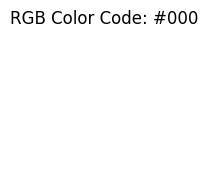

In [31]:
def process_data_and_get_color(data):
    # Initialize empty lists to hold the limited data
    data1_limited = []
    data2_limited = []

    # Loop through each tuple in data and limit to 10 values
    for i in range(len(data[0])):
        data1_limited.append(data[0][i])
        data2_limited.append(data[1][i])

    # UV-Vis spectrum data (example)
    wavelengths = data1_limited
    absorbances = data2_limited

    # Filter and sort data for valid wavelengths
    sorted_data = sorted(
        [
            [wavelength, absorbance / np.max(absorbances)]
            for wavelength, absorbance in zip(wavelengths, absorbances)
            if wavelength % 1 == 0 and 360 <= wavelength <= 800
        ],
        key=lambda x: x[0]  # Sort by wavelength
    )

    # Separate sorted data into wavelengths and absorbances
    sorted_wavelengths = [data[0] for data in sorted_data]
    sorted_absorbances = [data[1] for data in sorted_data]

    # Create a SpectralDistribution object
    spd = colour.SpectralDistribution(sorted_absorbances, sorted_wavelengths)

    # Get the CIE 1931 2 Degree Standard Observer CMFs
    cmfs = MSDS_CMFS["CIE 1931 2 Degree Standard Observer"]

    # Convert the spectral distribution to CIE XYZ color matching functions
    xyz = colour.sd_to_XYZ(spd, cmfs)

    # Convert XYZ to RGB
    RGB = colour.XYZ_to_sRGB(xyz)

    # Calculate RGB values as integers (0-255)
    RGB_int = [int(round(val * 2.55)) for val in RGB]

    # Calculate RGB values as percentages
    RGB_percent = [val / 100 for val in RGB]

    # Calculate RGB color code in hexadecimal format
    hex_color = "#{:02x}{:02x}{:02x}".format(RGB_int[0], RGB_int[1], RGB_int[2])

    return RGB_percent, hex_color


def plot_color_square(RGB):
    # Plot the color
    plt.figure(figsize=(2, 2))
    plt.imshow([[1 - np.array(RGB) / 255]])  # Normalize RGB values for display
    plt.axis('off')  # Turn off the axis
    plt.title(f"RGB Color Code: #{RGB[0]:.0f}{RGB[1]:.0f}{RGB[2]:.0f}")
    plt.show()


# Example usage:

# Assuming data is defined and filled with actual data as per original code
data = [(800.0, 799.5, 799.0, 798.5, 798.0, 797.5, 797.0, 796.5, 796.0, 795.5, 795.0, 794.5, 794.0, 793.5, 793.0, 792.5, 792.0, 791.5, 791.0, 790.5, 790.0, 789.5, 789.0, 788.5, 788.0, 787.5, 787.0, 786.5, 786.0, 785.5, 785.0, 784.5, 784.0, 783.5, 783.0, 782.5, 782.0, 781.5, 781.0, 780.5, 780.0, 779.5, 779.0, 778.5, 778.0, 777.5, 777.0, 776.5, 776.0, 775.5, 775.0, 774.5, 774.0, 773.5, 773.0, 772.5, 772.0, 771.5, 771.0, 770.5, 770.0, 769.5, 769.0, 768.5, 768.0, 767.5, 767.0, 766.5, 766.0, 765.5, 765.0, 764.5, 764.0, 763.5, 763.0, 762.5, 762.0, 761.5, 761.0, 760.5, 760.0, 759.5, 759.0, 758.5, 758.0, 757.5, 757.0, 756.5, 756.0, 755.5, 755.0, 754.5, 754.0, 753.5, 753.0, 752.5, 752.0, 751.5, 751.0, 750.5, 750.0, 749.5, 749.0, 748.5, 748.0, 747.5, 747.0, 746.5, 746.0, 745.5, 745.0, 744.5, 744.0, 743.5, 743.0, 742.5, 742.0, 741.5, 741.0, 740.5, 740.0, 739.5, 739.0, 738.5, 738.0, 737.5, 737.0, 736.5, 736.0, 735.5, 735.0, 734.5, 734.0, 733.5, 733.0, 732.5, 732.0, 731.5, 731.0, 730.5, 730.0, 729.5, 729.0, 728.5, 728.0, 727.5, 727.0, 726.5, 726.0, 725.5, 725.0, 724.5, 724.0, 723.5, 723.0, 722.5, 722.0, 721.5, 721.0, 720.5, 720.0, 719.5, 719.0, 718.5, 718.0, 717.5, 717.0, 716.5, 716.0, 715.5, 715.0, 714.5, 714.0, 713.5, 713.0, 712.5, 712.0, 711.5, 711.0, 710.5, 710.0, 709.5, 709.0, 708.5, 708.0, 707.5, 707.0, 706.5, 706.0, 705.5, 705.0, 704.5, 704.0, 703.5, 703.0, 702.5, 702.0, 701.5, 701.0, 700.5, 700.0, 699.5, 699.0, 698.5, 698.0, 697.5, 697.0, 696.5, 696.0, 695.5, 695.0, 694.5, 694.0, 693.5, 693.0, 692.5, 692.0, 691.5, 691.0, 690.5, 690.0, 689.5, 689.0, 688.5, 688.0, 687.5, 687.0, 686.5, 686.0, 685.5, 685.0, 684.5, 684.0, 683.5, 683.0, 682.5, 682.0, 681.5, 681.0, 680.5, 680.0, 679.5, 679.0, 678.5, 678.0, 677.5, 677.0, 676.5, 676.0, 675.5, 675.0, 674.5, 674.0, 673.5, 673.0, 672.5, 672.0, 671.5, 671.0, 670.5, 670.0, 669.5, 669.0, 668.5, 668.0, 667.5, 667.0, 666.5, 666.0, 665.5, 665.0, 664.5, 664.0, 663.5, 663.0, 662.5, 662.0, 661.5, 661.0, 660.5, 660.0, 659.5, 659.0, 658.5, 658.0, 657.5, 657.0, 656.5, 656.0, 655.5, 655.0, 654.5, 654.0, 653.5, 653.0, 652.5, 652.0, 651.5, 651.0, 650.5, 650.0, 649.5, 649.0, 648.5, 648.0, 647.5, 647.0, 646.5, 646.0, 645.5, 645.0, 644.5, 644.0, 643.5, 643.0, 642.5, 642.0, 641.5, 641.0, 640.5, 640.0, 639.5, 639.0, 638.5, 638.0, 637.5, 637.0, 636.5, 636.0, 635.5, 635.0, 634.5, 634.0, 633.5, 633.0, 632.5, 632.0, 631.5, 631.0, 630.5, 630.0, 629.5, 629.0, 628.5, 628.0, 627.5, 627.0, 626.5, 626.0, 625.5, 625.0, 624.5, 624.0, 623.5, 623.0, 622.5, 622.0, 621.5, 621.0, 620.5, 620.0, 619.5, 619.0, 618.5, 618.0, 617.5, 617.0, 616.5, 616.0, 615.5, 615.0, 614.5, 614.0, 613.5, 613.0, 612.5, 612.0, 611.5, 611.0, 610.5, 610.0, 609.5, 609.0, 608.5, 608.0, 607.5, 607.0, 606.5, 606.0, 605.5, 605.0, 604.5, 604.0, 603.5, 603.0, 602.5, 602.0, 601.5, 601.0, 600.5, 600.0, 599.5, 599.0, 598.5, 598.0, 597.5, 597.0, 596.5, 596.0, 595.5, 595.0, 594.5, 594.0, 593.5, 593.0, 592.5, 592.0, 591.5, 591.0, 590.5, 590.0, 589.5, 589.0, 588.5, 588.0, 587.5, 587.0, 586.5, 586.0, 585.5, 585.0, 584.5, 584.0, 583.5, 583.0, 582.5, 582.0, 581.5, 581.0, 580.5, 580.0, 579.5, 579.0, 578.5, 578.0, 577.5, 577.0, 576.5, 576.0, 575.5, 575.0, 574.5, 574.0, 573.5, 573.0, 572.5, 572.0, 571.5, 571.0, 570.5, 570.0, 569.5, 569.0, 568.5, 568.0, 567.5, 567.0, 566.5, 566.0, 565.5, 565.0, 564.5, 564.0, 563.5, 563.0, 562.5, 562.0, 561.5, 561.0, 560.5, 560.0, 559.5, 559.0, 558.5, 558.0, 557.5, 557.0, 556.5, 556.0, 555.5, 555.0, 554.5, 554.0, 553.5, 553.0, 552.5, 552.0, 551.5, 551.0, 550.5, 550.0, 549.5, 549.0, 548.5, 548.0, 547.5, 547.0, 546.5, 546.0, 545.5, 545.0, 544.5, 544.0, 543.5, 543.0, 542.5, 542.0, 541.5, 541.0, 540.5, 540.0, 539.5, 539.0, 538.5, 538.0, 537.5, 537.0, 536.5, 536.0, 535.5, 535.0, 534.5, 534.0, 533.5, 533.0, 532.5, 532.0, 531.5, 531.0, 530.5, 530.0, 529.5, 529.0, 528.5, 528.0, 527.5, 527.0, 526.5, 526.0, 525.5, 525.0, 524.5, 524.0, 523.5, 523.0, 522.5, 522.0, 521.5, 521.0, 520.5, 520.0, 519.5, 519.0, 518.5, 518.0, 517.5, 517.0, 516.5, 516.0, 515.5, 515.0, 514.5, 514.0, 513.5, 513.0, 512.5, 512.0, 511.5, 511.0, 510.5, 510.0, 509.5, 509.0, 508.5, 508.0, 507.5, 507.0, 506.5, 506.0, 505.5, 505.0, 504.5, 504.0, 503.5, 503.0, 502.5, 502.0, 501.5, 501.0, 500.5, 500.0, 499.5, 499.0, 498.5, 498.0, 497.5, 497.0, 496.5, 496.0, 495.5, 495.0, 494.5, 494.0, 493.5, 493.0, 492.5, 492.0, 491.5, 491.0, 490.5, 490.0, 489.5, 489.0, 488.5, 488.0, 487.5, 487.0, 486.5, 486.0, 485.5, 485.0, 484.5, 484.0, 483.5, 483.0, 482.5, 482.0, 481.5, 481.0, 480.5, 480.0, 479.5, 479.0, 478.5, 478.0, 477.5, 477.0, 476.5, 476.0, 475.5, 475.0, 474.5, 474.0, 473.5, 473.0, 472.5, 472.0, 471.5, 471.0, 470.5, 470.0, 469.5, 469.0, 468.5, 468.0, 467.5, 467.0, 466.5, 466.0, 465.5, 465.0, 464.5, 464.0, 463.5, 463.0, 462.5, 462.0, 461.5, 461.0, 460.5, 460.0, 459.5, 459.0, 458.5, 458.0, 457.5, 457.0, 456.5, 456.0, 455.5, 455.0, 454.5, 454.0, 453.5, 453.0, 452.5, 452.0, 451.5, 451.0, 450.5, 450.0, 449.5, 449.0, 448.5, 448.0, 447.5, 447.0, 446.5, 446.0, 445.5, 445.0, 444.5, 444.0, 443.5, 443.0, 442.5, 442.0, 441.5, 441.0, 440.5, 440.0, 439.5, 439.0, 438.5, 438.0, 437.5, 437.0, 436.5, 436.0, 435.5, 435.0, 434.5, 434.0, 433.5, 433.0, 432.5, 432.0, 431.5, 431.0, 430.5, 430.0, 429.5, 429.0, 428.5, 428.0, 427.5, 427.0, 426.5, 426.0, 425.5, 425.0, 424.5, 424.0, 423.5, 423.0, 422.5, 422.0, 421.5, 421.0, 420.5, 420.0, 419.5, 419.0, 418.5, 418.0, 417.5, 417.0, 416.5, 416.0, 415.5, 415.0, 414.5, 414.0, 413.5, 413.0, 412.5, 412.0, 411.5, 411.0, 410.5, 410.0, 409.5, 409.0, 408.5, 408.0, 407.5, 407.0, 406.5, 406.0, 405.5, 405.0, 404.5, 404.0, 403.5, 403.0, 402.5, 402.0, 401.5, 401.0, 400.5, 400.0, 399.5, 399.0, 398.5, 398.0, 397.5, 397.0, 396.5, 396.0, 395.5, 395.0, 394.5, 394.0, 393.5, 393.0, 392.5, 392.0, 391.5, 391.0, 390.5, 390.0, 389.5, 389.0, 388.5, 388.0, 387.5, 387.0, 386.5, 386.0, 385.5, 385.0, 384.5, 384.0, 383.5, 383.0, 382.5, 382.0, 381.5, 381.0, 380.5, 380.0, 379.5, 379.0, 378.5, 378.0, 377.5, 377.0, 376.5, 376.0, 375.5, 375.0, 374.5, 374.0, 373.5, 373.0, 372.5, 372.0, 371.5, 371.0, 370.5, 370.0, 369.5, 369.0, 368.5, 368.0, 367.5, 367.0, 366.5, 366.0, 365.5, 365.0, 364.5, 364.0, 363.5, 363.0, 362.5, 362.0, 361.5, 361.0, 360.5, 360.0, 359.5, 359.0, 358.5, 358.0, 357.5, 357.0, 356.5, 356.0, 355.5, 355.0, 354.5, 354.0, 353.5, 353.0, 352.5, 352.0, 351.5, 351.0, 350.5, 350.0, 349.5, 349.0, 348.5, 348.0, 347.5, 347.0, 346.5, 346.0, 345.5, 345.0, 344.5, 344.0, 343.5, 343.0, 342.5, 342.0, 341.5, 341.0, 340.5, 340.0, 339.5, 339.0, 338.5, 338.0, 337.5, 337.0, 336.5, 336.0, 335.5, 335.0, 334.5, 334.0, 333.5, 333.0, 332.5, 332.0, 331.5, 331.0, 330.5, 330.0, 329.5, 329.0, 328.5, 328.0, 327.5, 327.0, 326.5, 326.0, 325.5, 325.0, 324.5, 324.0, 323.5, 323.0, 322.5, 322.0, 321.5, 321.0, 320.5, 320.0, 319.5, 319.0, 318.5, 318.0, 317.5, 317.0, 316.5, 316.0, 315.5, 315.0, 314.5, 314.0, 313.5, 313.0, 312.5, 312.0, 311.5, 311.0, 310.5, 310.0, 309.5, 309.0, 308.5, 308.0, 307.5, 307.0, 306.5, 306.0, 305.5, 305.0, 304.5, 304.0, 303.5, 303.0, 302.5, 302.0, 301.5, 301.0, 300.5, 300.0, 299.5, 299.0, 298.5, 298.0, 297.5, 297.0, 296.5, 296.0, 295.5, 295.0, 294.5, 294.0, 293.5, 293.0, 292.5, 292.0, 291.5, 291.0, 290.5, 290.0, 289.5, 289.0, 288.5, 288.0, 287.5, 287.0, 286.5, 286.0, 285.5, 285.0, 284.5, 284.0, 283.5, 283.0, 282.5, 282.0, 281.5, 281.0, 280.5, 280.0, 279.5, 279.0, 278.5, 278.0, 277.5, 277.0, 276.5, 276.0, 275.5, 275.0, 274.5, 274.0, 273.5, 273.0, 272.5, 272.0, 271.5, 271.0, 270.5, 270.0, 269.5, 269.0, 268.5, 268.0, 267.5, 267.0, 266.5, 266.0, 265.5, 265.0, 264.5, 264.0, 263.5, 263.0, 262.5, 262.0, 261.5, 261.0, 260.5, 260.0, 259.5, 259.0, 258.5, 258.0, 257.5, 257.0, 256.5, 256.0, 255.5, 255.0, 254.5, 254.0, 253.5, 253.0, 252.5, 252.0, 251.5, 251.0, 250.5, 250.0, 249.5, 249.0, 248.5, 248.0, 247.5, 247.0, 246.5, 246.0, 245.5, 245.0, 244.5, 244.0, 243.5, 243.0, 242.5, 242.0, 241.5, 241.0, 240.5, 240.0, 239.5, 239.0, 238.5, 238.0, 237.5, 237.0, 236.5, 236.0, 235.5, 235.0, 234.5, 234.0, 233.5, 233.0, 232.5, 232.0, 231.5, 231.0, 230.5, 230.0, 229.5, 229.0, 228.5, 228.0, 227.5, 227.0, 226.5, 226.0, 225.5, 225.0, 224.5, 224.0, 223.5, 223.0, 222.5, 222.0, 221.5, 221.0, 220.5, 220.0, 219.5, 219.0, 218.5, 218.0, 217.5, 217.0, 216.5, 216.0, 215.5, 215.0, 214.5, 214.0, 213.5, 213.0, 212.5, 212.0, 211.5, 211.0, 210.5, 210.0, 209.5, 209.0, 208.5, 208.0, 207.5, 207.0, 206.5, 206.0, 205.5, 205.0, 204.5, 204.0, 203.5, 203.0, 202.5, 202.0, 201.5, 201.0, 200.5, 200.0), (0.061003219336271286, 0.06153391674160957, 0.0620318166911602, 0.06277777999639511, 0.06237440183758736, 0.06213337182998657, 0.061451736837625504, 0.06114652752876282, 0.0609809011220932, 0.06287180632352829, 0.06358923763036728, 0.06434478610754013, 0.06328651309013367, 0.0635196641087532, 0.0637897327542305, 0.06490170955657959, 0.06599656492471695, 0.06540035456418991, 0.0649867057800293, 0.06487978249788284, 0.06687887758016586, 0.06766775995492935, 0.06728258728981018, 0.06547507643699646, 0.06569957733154297, 0.06629467755556107, 0.06724945455789566, 0.0675964280962944, 0.06848403066396713, 0.06938879936933517, 0.06870400905609131, 0.06831058114767075, 0.06753752380609512, 0.06812074780464172, 0.0683780089020729, 0.06950993090867996, 0.06961371004581451, 0.0690692737698555, 0.06865645200014114, 0.06924685090780258, 0.07122591882944107, 0.07150834053754807, 0.07112608104944229, 0.07048048824071884, 0.07085148245096207, 0.07146673649549484, 0.07106456905603409, 0.07201477140188217, 0.07348737120628357, 0.0747845470905304, 0.07436612248420715, 0.07373375445604324, 0.07330796867609024, 0.07374251633882523, 0.07353121787309647, 0.07415961474180222, 0.07456988841295242, 0.07606581598520279, 0.07569067925214767, 0.07676500082015991, 0.07695368677377701, 0.07742616534233093, 0.07746218889951706, 0.07793527096509933, 0.07865165919065475, 0.07915385067462921, 0.0794813483953476, 0.07955892384052277, 0.07940589636564255, 0.07903271913528442, 0.0797203853726387, 0.0807543694972992, 0.08141002058982849, 0.08254662901163101, 0.08226656168699265, 0.082320936024189, 0.082097627222538, 0.08238303661346436, 0.08391027897596359, 0.08499956876039505, 0.08570533990859985, 0.08579111099243164, 0.08435384184122086, 0.08486198633909225, 0.08550795912742615, 0.08710571378469467, 0.08743283152580261, 0.08827247470617294, 0.08863555639982224, 0.08976731449365616, 0.08899404853582382, 0.09040067344903946, 0.09041538089513779, 0.09188872575759888, 0.0910191535949707, 0.09138846397399902, 0.091825932264328, 0.09316480159759521, 0.0941118374466896, 0.09466209262609482, 0.09449242800474167, 0.09520929306745529, 0.09640726447105408, 0.09765136241912842, 0.09802529960870743, 0.09775078296661377, 0.09819561243057251, 0.09878335148096085, 0.09935682266950607, 0.10000771284103394, 0.10014485567808151, 0.10094591230154037, 0.10224214941263199, 0.10316737741231918, 0.10403165221214294, 0.10455643385648727, 0.10565929859876633, 0.10643807053565979, 0.1071581244468689, 0.10792195796966553, 0.10850582271814346, 0.10961230844259262, 0.1112046018242836, 0.11222109943628311, 0.11196979880332947, 0.111470066010952, 0.11234825849533081, 0.11362975835800171, 0.11545806378126144, 0.11617124080657959, 0.11758968979120255, 0.11825668066740036, 0.11902882903814316, 0.11967135220766068, 0.119423508644104, 0.12020961195230484, 0.12101868540048599, 0.12378809601068497, 0.12442267686128616, 0.12602098286151886, 0.12611007690429688, 0.12761926651000977, 0.12803643941879272, 0.12880805134773254, 0.12892112135887146, 0.12949177622795105, 0.13061833381652832, 0.1327574998140335, 0.1340225487947464, 0.13491661846637726, 0.13550399243831635, 0.13626019656658173, 0.13747413456439972, 0.13827712833881378, 0.14019830524921417, 0.1414710134267807, 0.1424046903848648, 0.14348305761814117, 0.14481426775455475, 0.14636756479740143, 0.14723652601242065, 0.14791858196258545, 0.14912866055965424, 0.15043117105960846, 0.15133599936962128, 0.1520354151725769, 0.15292608737945557, 0.1537971943616867, 0.1547420471906662, 0.15552429854869843, 0.1568661332130432, 0.15853743255138397, 0.16017308831214905, 0.16117990016937256, 0.16200728714466095, 0.16240839660167694, 0.1636238545179367, 0.1652807593345642, 0.16687984764575958, 0.16827718913555145, 0.16956742107868195, 0.1705770343542099, 0.17207098007202148, 0.17239601910114288, 0.17417395114898682, 0.17535525560379028, 0.17714452743530273, 0.17836934328079224, 0.17840106785297394, 0.17847710847854614, 0.17963258922100067, 0.18162941932678223, 0.18427674472332, 0.18533508479595184, 0.18625693023204803, 0.18690373003482819, 0.1881038099527359, 0.18967878818511963, 0.19108827412128448, 0.1915494203567505, 0.192887544631958, 0.1934794783592224, 0.19451804459095, 0.1954888552427292, 0.19709056615829468, 0.1987430900335312, 0.20008690655231476, 0.20215551555156708, 0.2036820650100708, 0.20439688861370087, 0.20549607276916504, 0.2073216438293457, 0.20980870723724365, 0.21043823659420013, 0.21094977855682373, 0.21166716516017914, 0.2129669338464737, 0.2149786502122879, 0.21634440124034882, 0.2181464582681656, 0.21976399421691895, 0.2219013124704361, 0.22306345403194427, 0.22479386627674103, 0.22620148956775665, 0.22781531512737274, 0.22860974073410034, 0.2297309786081314, 0.23169438540935516, 0.23351240158081055, 0.23470307886600494, 0.2363486886024475, 0.23836851119995117, 0.24059128761291504, 0.24200670421123505, 0.2440420538187027, 0.24568401277065277, 0.2487235814332962, 0.25031188130378723, 0.25290024280548096, 0.2545226514339447, 0.25659260153770447, 0.2587295472621918, 0.2613109052181244, 0.26351991295814514, 0.2666090428829193, 0.26885756850242615, 0.2723900377750397, 0.27423250675201416, 0.2765989303588867, 0.2785853445529938, 0.280940979719162, 0.2837657034397125, 0.2864164412021637, 0.28881362080574036, 0.2910747528076172, 0.2937615215778351, 0.29636815190315247, 0.2992272675037384, 0.30166390538215637, 0.30490270256996155, 0.3070469796657562, 0.3091105818748474, 0.3107028901576996, 0.31249919533729553, 0.31421875953674316, 0.3162814676761627, 0.317923903465271, 0.3193010985851288, 0.31999993324279785, 0.3215048015117645, 0.3231530487537384, 0.3251422941684723, 0.3258953094482422, 0.3264751136302948, 0.3264959752559662, 0.3273613452911377, 0.32777902483940125, 0.32818683981895447, 0.3279699385166168, 0.3280661106109619, 0.3282777965068817, 0.328060120344162, 0.3272724151611328, 0.32664987444877625, 0.32636168599128723, 0.32557809352874756, 0.32541897892951965, 0.3251063823699951, 0.3252643048763275, 0.3238910734653473, 0.32286977767944336, 0.3218699097633362, 0.32159292697906494, 0.32117271423339844, 0.3213764727115631, 0.3206748962402344, 0.3196372091770172, 0.3181515634059906, 0.3172352612018585, 0.3167051374912262, 0.316683828830719, 0.31677550077438354, 0.31688401103019714, 0.3171707093715668, 0.3170565068721771, 0.31665682792663574, 0.31592926383018494, 0.31538721919059753, 0.3152059316635132, 0.315206915140152, 0.315098375082016, 0.3149602711200714, 0.3145289719104767, 0.31442806124687195, 0.3147695064544678, 0.3147476613521576, 0.3154069185256958, 0.31556764245033264, 0.3162120282649994, 0.31548455357551575, 0.31483927369117737, 0.3143397867679596, 0.31448185443878174, 0.31416183710098267, 0.3137926161289215, 0.3135356903076172, 0.31374600529670715, 0.31389227509498596, 0.31396403908729553, 0.3139568567276001, 0.31388914585113525, 0.3145369291305542, 0.31450796127319336, 0.3142286241054535, 0.3137660324573517, 0.31376394629478455, 0.3135499656200409, 0.3133026361465454, 0.3128946125507355, 0.31299617886543274, 0.3130052983760834, 0.3128601312637329, 0.312989205121994, 0.31330350041389465, 0.314043790102005, 0.3140331208705902, 0.3136044442653656, 0.3132137358188629, 0.3130502700805664, 0.31253358721733093, 0.312700092792511, 0.31272295117378235, 0.3133569657802582, 0.3134114444255829, 0.3137291371822357, 0.3138037621974945, 0.31403324007987976, 0.31431886553764343, 0.3145151436328888, 0.3150463104248047, 0.3154216706752777, 0.3164050877094269, 0.31673720479011536, 0.31730541586875916, 0.31757816672325134, 0.31761378049850464, 0.31794947385787964, 0.3185642659664154, 0.31969502568244934, 0.3205265998840332, 0.3211672306060791, 0.3214694559574127, 0.32180261611938477, 0.3221462070941925, 0.32283246517181396, 0.3232911229133606, 0.3235669434070587, 0.32396307587623596, 0.3242993652820587, 0.3253142535686493, 0.32538196444511414, 0.32602420449256897, 0.3260691165924072, 0.3267115652561188, 0.327161580324173, 0.32765552401542664, 0.3283361494541168, 0.32907769083976746, 0.3297470808029175, 0.3304525911808014, 0.3304608166217804, 0.33038827776908875, 0.33016908168792725, 0.33053839206695557, 0.3306797444820404, 0.33127787709236145, 0.33179205656051636, 0.33263713121414185, 0.33317723870277405, 0.33363035321235657, 0.3345060646533966, 0.3347987234592438, 0.3350360095500946, 0.33490514755249023, 0.33523452281951904, 0.3360470235347748, 0.33663058280944824, 0.3370644748210907, 0.33760690689086914, 0.337930291891098, 0.3386324644088745, 0.33868733048439026, 0.33906272053718567, 0.3394937515258789, 0.3401072025299072, 0.34022507071495056, 0.3403042256832123, 0.34043362736701965, 0.34138253331184387, 0.34178581833839417, 0.34198060631752014, 0.3417789936065674, 0.34207311272621155, 0.34257712960243225, 0.3433844745159149, 0.3441201150417328, 0.34490808844566345, 0.34520038962364197, 0.3453925848007202, 0.3453017473220825, 0.34553179144859314, 0.3458375930786133, 0.3465389907360077, 0.347345232963562, 0.3479260504245758, 0.34846067428588867, 0.34866300225257874, 0.3489135801792145, 0.3494738042354584, 0.35010990500450134, 0.3509969711303711, 0.3513988256454468, 0.3516307771205902, 0.35182157158851624, 0.3520849049091339, 0.3528650999069214, 0.3536124527454376, 0.3537949025630951, 0.3537001609802246, 0.35387077927589417, 0.354453444480896, 0.3550091087818146, 0.35509952902793884, 0.3549143075942993, 0.35499107837677, 0.35543155670166016, 0.35624203085899353, 0.3574170172214508, 0.3582761585712433, 0.3592182695865631, 0.3592618405818939, 0.35922351479530334, 0.35958656668663025, 0.3599679172039032, 0.36058661341667175, 0.36096397042274475, 0.36136534810066223, 0.3616691529750824, 0.36163198947906494, 0.36150217056274414, 0.3617009222507477, 0.36190807819366455, 0.3625776469707489, 0.362628310918808, 0.3624860346317291, 0.36285853385925293, 0.3633463680744171, 0.36433613300323486, 0.36424389481544495, 0.36484506726264954, 0.36480915546417236, 0.3649609386920929, 0.3644997179508209, 0.36442384123802185, 0.3649124205112457, 0.36548566818237305, 0.36610639095306396, 0.3660440742969513, 0.36649927496910095, 0.36704421043395996, 0.3676271140575409, 0.3677027225494385, 0.36719775199890137, 0.3671487271785736, 0.36683592200279236, 0.36731991171836853, 0.36737093329429626, 0.36765286326408386, 0.36770641803741455, 0.36861124634742737, 0.3690464496612549, 0.369465708732605, 0.3692333698272705, 0.3697946071624756, 0.3698004186153412, 0.3700579106807709, 0.36974337697029114, 0.36988893151283264, 0.36996957659721375, 0.370450884103775, 0.3706169128417969, 0.37111565470695496, 0.371445894241333, 0.37181106209754944, 0.3711691200733185, 0.3709442913532257, 0.37046971917152405, 0.3712412118911743, 0.3715757429599762, 0.37228575348854065, 0.3724088966846466, 0.3726581037044525, 0.37308192253112793, 0.373123437166214, 0.37298092246055603, 0.3729983866214752, 0.3733355700969696, 0.3731297552585602, 0.3734770715236664, 0.3738996088504791, 0.37506794929504395, 0.3748722970485687, 0.3747483789920807, 0.3747337758541107, 0.3753221333026886, 0.375429630279541, 0.37553271651268005, 0.37585029006004333, 0.3760327398777008, 0.37559089064598083, 0.37523508071899414, 0.3755541145801544, 0.37682846188545227, 0.3777013123035431, 0.3779921233654022, 0.3780697286128998, 0.37825122475624084, 0.37913310527801514, 0.3793982267379761, 0.37967658042907715, 0.37990593910217285, 0.3803063929080963, 0.3809111416339874, 0.38113918900489807, 0.3811435401439667, 0.38064292073249817, 0.3809894621372223, 0.3819983899593353, 0.3828675448894501, 0.38325372338294983, 0.3832137882709503, 0.38371291756629944, 0.38404789566993713, 0.3848513066768646, 0.38513073325157166, 0.38537585735321045, 0.38510069251060486, 0.3855280876159668, 0.3861572742462158, 0.3870450556278229, 0.38738349080085754, 0.3874272406101227, 0.3877652585506439, 0.3881262242794037, 0.3886038064956665, 0.38849779963493347, 0.38914451003074646, 0.3891754448413849, 0.38971707224845886, 0.3892892897129059, 0.38971802592277527, 0.3897441327571869, 0.3902352750301361, 0.3904446065425873, 0.390731543302536, 0.3911682665348053, 0.391958624124527, 0.39293089509010315, 0.39331111311912537, 0.39305809140205383, 0.3929325342178345, 0.3934258222579956, 0.39401623606681824, 0.3944348096847534, 0.3942738473415375, 0.39435306191444397, 0.3943502902984619, 0.395006388425827, 0.39611199498176575, 0.39674291014671326, 0.39714065194129944, 0.3965478837490082, 0.3966774642467499, 0.3971599042415619, 0.39792880415916443, 0.3983403742313385, 0.3986935317516327, 0.3990964889526367, 0.3998425006866455, 0.3997516334056854, 0.39995309710502625, 0.3996776044368744, 0.4001340866088867, 0.40029892325401306, 0.4010508060455322, 0.40154528617858887, 0.4023328721523285, 0.402950257062912, 0.40330609679222107, 0.4038628041744232, 0.40394845604896545, 0.4047328233718872, 0.4047081172466278, 0.40544864535331726, 0.40599456429481506, 0.40724360942840576, 0.4082106649875641, 0.40880653262138367, 0.4091418981552124, 0.40951409935951233, 0.41026926040649414, 0.41132983565330505, 0.41229915618896484, 0.4126252233982086, 0.4128842353820801, 0.4133738577365875, 0.4140342175960541, 0.41496869921684265, 0.415583997964859, 0.4165564775466919, 0.4172566831111908, 0.4180504381656647, 0.41903257369995117, 0.42007413506507874, 0.4217022955417633, 0.42263272404670715, 0.42324209213256836, 0.42360761761665344, 0.4247229993343353, 0.42597511410713196, 0.42694076895713806, 0.4273444414138794, 0.42832866311073303, 0.42890843749046326, 0.43031516671180725, 0.4316513240337372, 0.4331553876399994, 0.4346354901790619, 0.4351066052913666, 0.43541717529296875, 0.43642792105674744, 0.4380350112915039, 0.4395095407962799, 0.43993261456489563, 0.4399515390396118, 0.4406982660293579, 0.4419340193271637, 0.44378694891929626, 0.4455597400665283, 0.4470929801464081, 0.4479961395263672, 0.4489850699901581, 0.44972434639930725, 0.45098984241485596, 0.4526783525943756, 0.45388785004615784, 0.4553428888320923, 0.4565424621105194, 0.4580214321613312, 0.4585982859134674, 0.45975205302238464, 0.4610775411128998, 0.46304115653038025, 0.46397724747657776, 0.46468427777290344, 0.46596166491508484, 0.4674704372882843, 0.46985164284706116, 0.47166669368743896, 0.473237007856369, 0.474343866109848, 0.4759204089641571, 0.4780160188674927, 0.48001232743263245, 0.4818510115146637, 0.48340344429016113, 0.48544058203697205, 0.4867384433746338, 0.48870599269866943, 0.48996269702911377, 0.4918481409549713, 0.4935554265975952, 0.49566254019737244, 0.49786293506622314, 0.5004141926765442, 0.5032444000244141, 0.5059362053871155, 0.5081433653831482, 0.510587751865387, 0.5133979320526123, 0.5163560509681702, 0.5191413164138794, 0.5215402245521545, 0.523658812046051, 0.5260151028633118, 0.5288230776786804, 0.5315703749656677, 0.534437358379364, 0.5367761850357056, 0.5394948124885559, 0.5417051911354065, 0.5444781184196472, 0.5466305613517761, 0.5492608547210693, 0.5516552329063416, 0.5542406439781189, 0.5564088225364685, 0.5593703389167786, 0.5618301630020142, 0.5640423893928528, 0.5651956796646118, 0.5679001212120056, 0.5705551505088806, 0.5726010203361511, 0.5737858414649963, 0.5755742192268372, 0.5783572793006897, 0.5805580019950867, 0.5816180109977722, 0.5834701657295227, 0.5856876969337463, 0.5881183743476868, 0.589126467704773, 0.5908293128013611, 0.5931959748268127, 0.5966078042984009, 0.5988327860832214, 0.6009175777435303, 0.6024253964424133, 0.6050340533256531, 0.6076226830482483, 0.6106363534927368, 0.6130215525627136, 0.6156365871429443, 0.6170954704284668, 0.6191989779472351, 0.6199092268943787, 0.6219062805175781, 0.6235684752464294, 0.6264336705207825, 0.6285547614097595, 0.6294991374015808, 0.6311524510383606, 0.6323363184928894, 0.6345158219337463, 0.6353035569190979, 0.636542022228241, 0.6372383236885071, 0.6382250785827637, 0.6390383839607239, 0.64065021276474, 0.6419811844825745, 0.6431782245635986, 0.6436423063278198, 0.6445145606994629, 0.6453327536582947, 0.646013081073761, 0.646665096282959, 0.6475648283958435, 0.648536741733551, 0.6487271189689636, 0.648959755897522, 0.6488679647445679, 0.6505444645881653, 0.6506356000900269, 0.6513728499412537, 0.6508758664131165, 0.6512609720230103, 0.6516091823577881, 0.6514866352081299, 0.6519350409507751, 0.6526327729225159, 0.6545236110687256, 0.6558913588523865, 0.6567621827125549, 0.6563742756843567, 0.6568243503570557, 0.657468318939209, 0.6580659747123718, 0.6590263843536377, 0.6599259376525879, 0.6615261435508728, 0.6621976494789124, 0.6623294949531555, 0.662745475769043, 0.6635527610778809, 0.6641886830329895, 0.6648449301719666, 0.665492594242096, 0.6672586798667908, 0.6690270304679871, 0.6707755923271179, 0.6715379357337952, 0.6728119850158691, 0.67403244972229, 0.6755394339561462, 0.6763405799865723, 0.677600622177124, 0.6787078380584717, 0.6799562573432922, 0.6803457140922546, 0.6820926666259766, 0.6841843724250793, 0.6863024830818176, 0.6885542273521423, 0.6890891194343567, 0.6902115941047668, 0.6909235119819641, 0.6929893493652344, 0.6946887969970703, 0.6961331367492676, 0.6976011395454407, 0.6990548968315125, 0.7010876536369324, 0.703744113445282, 0.7059267163276672, 0.7083156704902649, 0.7096258997917175, 0.7113218307495117, 0.7115485072135925, 0.7124249339103699, 0.7146026492118835, 0.715599775314331, 0.7170385718345642, 0.7179085612297058, 0.7198998332023621, 0.721838653087616, 0.7229633331298828, 0.7258387207984924, 0.7274729609489441, 0.729511022567749, 0.7309019565582275, 0.7331361770629883, 0.7346085906028748, 0.7369673848152161, 0.7383289933204651, 0.7425159811973572, 0.7445147037506104, 0.7483991980552673, 0.7475324273109436, 0.7493603825569153, 0.7500119805335999, 0.7527135014533997, 0.7545337080955505, 0.7550780177116394, 0.7572898864746094, 0.759864866733551, 0.7641374468803406, 0.7672765851020813, 0.7689955830574036, 0.7700183987617493, 0.7702972292900085, 0.7702913284301758, 0.773172914981842, 0.7766625285148621, 0.7799263596534729, 0.7817003130912781, 0.783160388469696, 0.785511314868927, 0.7868383526802063, 0.7887749671936035, 0.7897617220878601, 0.7910322546958923, 0.7917870879173279, 0.7937809824943542, 0.7959422469139099, 0.7981154322624207, 0.799848735332489, 0.8011928200721741, 0.8031408786773682, 0.8044038414955139, 0.80740886926651, 0.8095836639404297, 0.8122956156730652, 0.8135440945625305, 0.816669225692749, 0.8198836445808411, 0.8199038505554199, 0.8207406997680664, 0.8212778568267822, 0.8249102234840393, 0.8259508013725281, 0.8273008465766907, 0.8306670188903809, 0.8332062363624573, 0.8374125361442566, 0.839716374874115, 0.8426682949066162, 0.8436333537101746, 0.842765748500824, 0.8451982140541077, 0.8457910418510437, 0.8480208516120911, 0.8500415682792664, 0.853851854801178, 0.8568081855773926, 0.8563783168792725, 0.8578354716300964, 0.8595790863037109, 0.8638412356376648, 0.864919126033783, 0.8657819628715515, 0.8646296858787537, 0.8655900359153748, 0.8675012588500977, 0.8701634407043457, 0.872566282749176, 0.8739979267120361, 0.8745708465576172, 0.8771064877510071, 0.8797586560249329, 0.880784273147583, 0.8822601437568665, 0.8829320073127747, 0.8870193362236023, 0.8876195549964905, 0.8888041377067566, 0.8902816772460938, 0.8913801312446594, 0.8933351635932922, 0.8942208886146545, 0.8968893885612488, 0.8966562151908875, 0.8975450396537781, 0.8964946866035461, 0.8976630568504333, 0.898249626159668, 0.900348424911499, 0.90215665102005, 0.9043213725090027, 0.903856098651886, 0.9034330248832703, 0.9010046124458313, 0.9035562872886658, 0.9072200655937195, 0.9120714068412781, 0.9139170050621033, 0.9116625189781189, 0.9121703505516052, 0.9115731716156006, 0.9169368743896484, 0.9187307357788086, 0.9234085083007812, 0.9203703999519348, 0.9186452031135559, 0.9160189032554626, 0.9162192344665527, 0.9180716872215271, 0.9242704510688782, 0.9297240376472473, 0.933085024356842, 0.9325299859046936, 0.9351903796195984, 0.9346387982368469, 0.9331120848655701, 0.9330618977546692, 0.9359075427055359, 0.9397066235542297, 0.9432476162910461, 0.9468376636505127, 0.9493387341499329, 0.9499594569206238, 0.9519162178039551, 0.9532592296600342, 0.9585912823677063, 0.9571525454521179, 0.9604461193084717, 0.9620364308357239, 0.9688272476196289, 0.9728999137878418, 0.9783585071563721, 0.9849154949188232, 0.9930488467216492, 1.0010863542556763, 1.0072094202041626, 1.0123212337493896, 1.0140180587768555, 1.0190279483795166, 1.0238326787948608, 1.0347700119018555, 1.0449546575546265, 1.0588651895523071, 1.0699526071548462, 1.0796564817428589, 1.0886553525924683, 1.0932745933532715, 1.1029008626937866, 1.1127914190292358, 1.1333223581314087, 1.1452864408493042, 1.1558527946472168, 1.1573268175125122, 1.1716457605361938, 1.1870113611221313, 1.2076655626296997, 1.2139650583267212, 1.2196294069290161, 1.2288589477539062, 1.2419843673706055, 1.2540264129638672, 1.2597237825393677, 1.26710844039917, 1.2750192880630493, 1.282038688659668, 1.2839088439941406, 1.2897530794143677, 1.2955571413040161, 1.3019295930862427, 1.3056563138961792, 1.3038893938064575, 1.3078473806381226, 1.3104058504104614, 1.3220391273498535, 1.3304262161254883, 1.3319450616836548, 1.3335437774658203, 1.3361579179763794, 1.3372589349746704, 1.340389609336853, 1.3462915420532227, 1.3501495122909546, 1.3475931882858276, 1.3435784578323364, 1.3536934852600098, 1.359458088874817, 1.3615232706069946, 1.358106017112732, 1.3591632843017578, 1.3602076768875122, 1.369521975517273, 1.3677315711975098, 1.3709707260131836, 1.363574504852295, 1.3737555742263794, 1.3775073289871216, 1.3823755979537964, 1.3878755569458008, 1.3893691301345825, 1.3920921087265015, 1.3855451345443726, 1.3898992538452148, 1.394265055656433, 1.3903051614761353, 1.3916295766830444, 1.386489987373352, 1.3900212049484253, 1.3902145624160767, 1.392660140991211, 1.390980839729309, 1.3890037536621094, 1.3896002769470215, 1.3988763093948364, 1.4010305404663086, 1.4055023193359375, 1.3926482200622559, 1.3900609016418457, 1.3889981508255005, 1.402136206626892, 1.405647873878479, 1.399440884590149, 1.399657130241394, 1.3937453031539917, 1.393846869468689, 1.3893146514892578, 1.3898643255233765, 1.3901761770248413, 1.3871530294418335, 1.3895765542984009, 1.3909235000610352, 1.3948131799697876, 1.3929675817489624, 1.3857511281967163, 1.3780382871627808, 1.3765474557876587, 1.3751174211502075, 1.372092366218567, 1.364357352256775, 1.367423415184021, 1.3672393560409546, 1.374266505241394, 1.370618224143982, 1.3736610412597656, 1.3786368370056152, 1.380129337310791, 1.3819118738174438, 1.3679407835006714, 1.3679003715515137, 1.3547521829605103, 1.3575472831726074, 1.3527750968933105, 1.3533023595809937, 1.354562759399414, 1.3531907796859741, 1.354391098022461, 1.3562546968460083, 1.3545767068862915, 1.3630447387695312, 1.3570462465286255, 1.3634506464004517, 1.3650485277175903, 1.3732523918151855, 1.3781388998031616, 1.375156044960022, 1.3700767755508423, 1.3671711683273315, 1.3648802042007446, 1.3653253316879272, 1.3664363622665405, 1.3730922937393188, 1.3708691596984863, 1.3746447563171387, 1.368215560913086, 1.3723335266113281, 1.3685625791549683, 1.3749924898147583, 1.3731170892715454, 1.366398811340332, 1.3601150512695312, 1.358637809753418, 1.360959529876709, 1.3663238286972046, 1.3747104406356812, 1.3803447484970093, 1.3833093643188477, 1.3760093450546265, 1.3774560689926147, 1.3701056241989136, 1.3780250549316406, 1.3864259719848633, 1.3881945610046387, 1.3920068740844727, 1.3813401460647583, 1.3816269636154175, 1.3804296255111694, 1.377274990081787, 1.383544921875, 1.3720065355300903, 1.394194483757019, 1.3969818353652954, 1.4158363342285156, 1.3880428075790405, 1.3676729202270508, 1.3573145866394043, 1.3715745210647583, 1.3863515853881836, 1.394046664237976, 1.3992048501968384, 1.4137940406799316, 1.4088797569274902, 1.4012012481689453, 1.393048644065857, 1.3825947046279907, 1.371557593345642, 1.3686046600341797, 1.3676505088806152, 1.3615307807922363, 1.3488783836364746, 1.3596428632736206, 1.3746341466903687, 1.3866915702819824, 1.383784294128418, 1.367439866065979, 1.349390983581543, 1.3537157773971558, 1.3652147054672241, 1.3667198419570923, 1.3518003225326538, 1.3663476705551147, 1.363340973854065, 1.370787262916565, 1.3470693826675415, 1.3400945663452148, 1.3143424987792969, 1.308315634727478, 1.2871488332748413, 1.3369280099868774, 1.3684543371200562, 1.3935362100601196, 1.340064525604248, 1.2985714673995972)]
data = [(800.0, 799.5, 799.0, 798.5, 798.0, 797.5, 797.0, 796.5, 796.0, 795.5, 795.0, 794.5, 794.0, 793.5, 793.0, 792.5, 792.0, 791.5, 791.0, 790.5, 790.0, 789.5, 789.0, 788.5, 788.0, 787.5, 787.0, 786.5, 786.0, 785.5, 785.0, 784.5, 784.0, 783.5, 783.0, 782.5, 782.0, 781.5, 781.0, 780.5, 780.0, 779.5, 779.0, 778.5, 778.0, 777.5, 777.0, 776.5, 776.0, 775.5, 775.0, 774.5, 774.0, 773.5, 773.0, 772.5, 772.0, 771.5, 771.0, 770.5, 770.0, 769.5, 769.0, 768.5, 768.0, 767.5, 767.0, 766.5, 766.0, 765.5, 765.0, 764.5, 764.0, 763.5, 763.0, 762.5, 762.0, 761.5, 761.0, 760.5, 760.0, 759.5, 759.0, 758.5, 758.0, 757.5, 757.0, 756.5, 756.0, 755.5, 755.0, 754.5, 754.0, 753.5, 753.0, 752.5, 752.0, 751.5, 751.0, 750.5, 750.0, 749.5, 749.0, 748.5, 748.0, 747.5, 747.0, 746.5, 746.0, 745.5, 745.0, 744.5, 744.0, 743.5, 743.0, 742.5, 742.0, 741.5, 741.0, 740.5, 740.0, 739.5, 739.0, 738.5, 738.0, 737.5, 737.0, 736.5, 736.0, 735.5, 735.0, 734.5, 734.0, 733.5, 733.0, 732.5, 732.0, 731.5, 731.0, 730.5, 730.0, 729.5, 729.0, 728.5, 728.0, 727.5, 727.0, 726.5, 726.0, 725.5, 725.0, 724.5, 724.0, 723.5, 723.0, 722.5, 722.0, 721.5, 721.0, 720.5, 720.0, 719.5, 719.0, 718.5, 718.0, 717.5, 717.0, 716.5, 716.0, 715.5, 715.0, 714.5, 714.0, 713.5, 713.0, 712.5, 712.0, 711.5, 711.0, 710.5, 710.0, 709.5, 709.0, 708.5, 708.0, 707.5, 707.0, 706.5, 706.0, 705.5, 705.0, 704.5, 704.0, 703.5, 703.0, 702.5, 702.0, 701.5, 701.0, 700.5, 700.0, 699.5, 699.0, 698.5, 698.0, 697.5, 697.0, 696.5, 696.0, 695.5, 695.0, 694.5, 694.0, 693.5, 693.0, 692.5, 692.0, 691.5, 691.0, 690.5, 690.0, 689.5, 689.0, 688.5, 688.0, 687.5, 687.0, 686.5, 686.0, 685.5, 685.0, 684.5, 684.0, 683.5, 683.0, 682.5, 682.0, 681.5, 681.0, 680.5, 680.0, 679.5, 679.0, 678.5, 678.0, 677.5, 677.0, 676.5, 676.0, 675.5, 675.0, 674.5, 674.0, 673.5, 673.0, 672.5, 672.0, 671.5, 671.0, 670.5, 670.0, 669.5, 669.0, 668.5, 668.0, 667.5, 667.0, 666.5, 666.0, 665.5, 665.0, 664.5, 664.0, 663.5, 663.0, 662.5, 662.0, 661.5, 661.0, 660.5, 660.0, 659.5, 659.0, 658.5, 658.0, 657.5, 657.0, 656.5, 656.0, 655.5, 655.0, 654.5, 654.0, 653.5, 653.0, 652.5, 652.0, 651.5, 651.0, 650.5, 650.0, 649.5, 649.0, 648.5, 648.0, 647.5, 647.0, 646.5, 646.0, 645.5, 645.0, 644.5, 644.0, 643.5, 643.0, 642.5, 642.0, 641.5, 641.0, 640.5, 640.0, 639.5, 639.0, 638.5, 638.0, 637.5, 637.0, 636.5, 636.0, 635.5, 635.0, 634.5, 634.0, 633.5, 633.0, 632.5, 632.0, 631.5, 631.0, 630.5, 630.0, 629.5, 629.0, 628.5, 628.0, 627.5, 627.0, 626.5, 626.0, 625.5, 625.0, 624.5, 624.0, 623.5, 623.0, 622.5, 622.0, 621.5, 621.0, 620.5, 620.0, 619.5, 619.0, 618.5, 618.0, 617.5, 617.0, 616.5, 616.0, 615.5, 615.0, 614.5, 614.0, 613.5, 613.0, 612.5, 612.0, 611.5, 611.0, 610.5, 610.0, 609.5, 609.0, 608.5, 608.0, 607.5, 607.0, 606.5, 606.0, 605.5, 605.0, 604.5, 604.0, 603.5, 603.0, 602.5, 602.0, 601.5, 601.0, 600.5, 600.0, 599.5, 599.0, 598.5, 598.0, 597.5, 597.0, 596.5, 596.0, 595.5, 595.0, 594.5, 594.0, 593.5, 593.0, 592.5, 592.0, 591.5, 591.0, 590.5, 590.0, 589.5, 589.0, 588.5, 588.0, 587.5, 587.0, 586.5, 586.0, 585.5, 585.0, 584.5, 584.0, 583.5, 583.0, 582.5, 582.0, 581.5, 581.0, 580.5, 580.0, 579.5, 579.0, 578.5, 578.0, 577.5, 577.0, 576.5, 576.0, 575.5, 575.0, 574.5, 574.0, 573.5, 573.0, 572.5, 572.0, 571.5, 571.0, 570.5, 570.0, 569.5, 569.0, 568.5, 568.0, 567.5, 567.0, 566.5, 566.0, 565.5, 565.0, 564.5, 564.0, 563.5, 563.0, 562.5, 562.0, 561.5, 561.0, 560.5, 560.0, 559.5, 559.0, 558.5, 558.0, 557.5, 557.0, 556.5, 556.0, 555.5, 555.0, 554.5, 554.0, 553.5, 553.0, 552.5, 552.0, 551.5, 551.0, 550.5, 550.0, 549.5, 549.0, 548.5, 548.0, 547.5, 547.0, 546.5, 546.0, 545.5, 545.0, 544.5, 544.0, 543.5, 543.0, 542.5, 542.0, 541.5, 541.0, 540.5, 540.0, 539.5, 539.0, 538.5, 538.0, 537.5, 537.0, 536.5, 536.0, 535.5, 535.0, 534.5, 534.0, 533.5, 533.0, 532.5, 532.0, 531.5, 531.0, 530.5, 530.0, 529.5, 529.0, 528.5, 528.0, 527.5, 527.0, 526.5, 526.0, 525.5, 525.0, 524.5, 524.0, 523.5, 523.0, 522.5, 522.0, 521.5, 521.0, 520.5, 520.0, 519.5, 519.0, 518.5, 518.0, 517.5, 517.0, 516.5, 516.0, 515.5, 515.0, 514.5, 514.0, 513.5, 513.0, 512.5, 512.0, 511.5, 511.0, 510.5, 510.0, 509.5, 509.0, 508.5, 508.0, 507.5, 507.0, 506.5, 506.0, 505.5, 505.0, 504.5, 504.0, 503.5, 503.0, 502.5, 502.0, 501.5, 501.0, 500.5, 500.0, 499.5, 499.0, 498.5, 498.0, 497.5, 497.0, 496.5, 496.0, 495.5, 495.0, 494.5, 494.0, 493.5, 493.0, 492.5, 492.0, 491.5, 491.0, 490.5, 490.0, 489.5, 489.0, 488.5, 488.0, 487.5, 487.0, 486.5, 486.0, 485.5, 485.0, 484.5, 484.0, 483.5, 483.0, 482.5, 482.0, 481.5, 481.0, 480.5, 480.0, 479.5, 479.0, 478.5, 478.0, 477.5, 477.0, 476.5, 476.0, 475.5, 475.0, 474.5, 474.0, 473.5, 473.0, 472.5, 472.0, 471.5, 471.0, 470.5, 470.0, 469.5, 469.0, 468.5, 468.0, 467.5, 467.0, 466.5, 466.0, 465.5, 465.0, 464.5, 464.0, 463.5, 463.0, 462.5, 462.0, 461.5, 461.0, 460.5, 460.0, 459.5, 459.0, 458.5, 458.0, 457.5, 457.0, 456.5, 456.0, 455.5, 455.0, 454.5, 454.0, 453.5, 453.0, 452.5, 452.0, 451.5, 451.0, 450.5, 450.0, 449.5, 449.0, 448.5, 448.0, 447.5, 447.0, 446.5, 446.0, 445.5, 445.0, 444.5, 444.0, 443.5, 443.0, 442.5, 442.0, 441.5, 441.0, 440.5, 440.0, 439.5, 439.0, 438.5, 438.0, 437.5, 437.0, 436.5, 436.0, 435.5, 435.0, 434.5, 434.0, 433.5, 433.0, 432.5, 432.0, 431.5, 431.0, 430.5, 430.0, 429.5, 429.0, 428.5, 428.0, 427.5, 427.0, 426.5, 426.0, 425.5, 425.0, 424.5, 424.0, 423.5, 423.0, 422.5, 422.0, 421.5, 421.0, 420.5, 420.0, 419.5, 419.0, 418.5, 418.0, 417.5, 417.0, 416.5, 416.0, 415.5, 415.0, 414.5, 414.0, 413.5, 413.0, 412.5, 412.0, 411.5, 411.0, 410.5, 410.0, 409.5, 409.0, 408.5, 408.0, 407.5, 407.0, 406.5, 406.0, 405.5, 405.0, 404.5, 404.0, 403.5, 403.0, 402.5, 402.0, 401.5, 401.0, 400.5, 400.0, 399.5, 399.0, 398.5, 398.0, 397.5, 397.0, 396.5, 396.0, 395.5, 395.0, 394.5, 394.0, 393.5, 393.0, 392.5, 392.0, 391.5, 391.0, 390.5, 390.0, 389.5, 389.0, 388.5, 388.0, 387.5, 387.0, 386.5, 386.0, 385.5, 385.0, 384.5, 384.0, 383.5, 383.0, 382.5, 382.0, 381.5, 381.0, 380.5, 380.0, 379.5, 379.0, 378.5, 378.0, 377.5, 377.0, 376.5, 376.0, 375.5, 375.0, 374.5, 374.0, 373.5, 373.0, 372.5, 372.0, 371.5, 371.0, 370.5, 370.0, 369.5, 369.0, 368.5, 368.0, 367.5, 367.0, 366.5, 366.0, 365.5, 365.0, 364.5, 364.0, 363.5, 363.0, 362.5, 362.0, 361.5, 361.0, 360.5, 360.0, 359.5, 359.0, 358.5, 358.0, 357.5, 357.0, 356.5, 356.0, 355.5, 355.0, 354.5, 354.0, 353.5, 353.0, 352.5, 352.0, 351.5, 351.0, 350.5, 350.0, 349.5, 349.0, 348.5, 348.0, 347.5, 347.0, 346.5, 346.0, 345.5, 345.0, 344.5, 344.0, 343.5, 343.0, 342.5, 342.0, 341.5, 341.0, 340.5, 340.0, 339.5, 339.0, 338.5, 338.0, 337.5, 337.0, 336.5, 336.0, 335.5, 335.0, 334.5, 334.0, 333.5, 333.0, 332.5, 332.0, 331.5, 331.0, 330.5, 330.0, 329.5, 329.0, 328.5, 328.0, 327.5, 327.0, 326.5, 326.0, 325.5, 325.0, 324.5, 324.0, 323.5, 323.0, 322.5, 322.0, 321.5, 321.0, 320.5, 320.0, 319.5, 319.0, 318.5, 318.0, 317.5, 317.0, 316.5, 316.0, 315.5, 315.0, 314.5, 314.0, 313.5, 313.0, 312.5, 312.0, 311.5, 311.0, 310.5, 310.0, 309.5, 309.0, 308.5, 308.0, 307.5, 307.0, 306.5, 306.0, 305.5, 305.0, 304.5, 304.0, 303.5, 303.0, 302.5, 302.0, 301.5, 301.0, 300.5, 300.0, 299.5, 299.0, 298.5, 298.0, 297.5, 297.0, 296.5, 296.0, 295.5, 295.0, 294.5, 294.0, 293.5, 293.0, 292.5, 292.0, 291.5, 291.0, 290.5, 290.0, 289.5, 289.0, 288.5, 288.0, 287.5, 287.0, 286.5, 286.0, 285.5, 285.0, 284.5, 284.0, 283.5, 283.0, 282.5, 282.0, 281.5, 281.0, 280.5, 280.0, 279.5, 279.0, 278.5, 278.0, 277.5, 277.0, 276.5, 276.0, 275.5, 275.0, 274.5, 274.0, 273.5, 273.0, 272.5, 272.0, 271.5, 271.0, 270.5, 270.0, 269.5, 269.0, 268.5, 268.0, 267.5, 267.0, 266.5, 266.0, 265.5, 265.0, 264.5, 264.0, 263.5, 263.0, 262.5, 262.0, 261.5, 261.0, 260.5, 260.0, 259.5, 259.0, 258.5, 258.0, 257.5, 257.0, 256.5, 256.0, 255.5, 255.0, 254.5, 254.0, 253.5, 253.0, 252.5, 252.0, 251.5, 251.0, 250.5, 250.0, 249.5, 249.0, 248.5, 248.0, 247.5, 247.0, 246.5, 246.0, 245.5, 245.0, 244.5, 244.0, 243.5, 243.0, 242.5, 242.0, 241.5, 241.0, 240.5, 240.0, 239.5, 239.0, 238.5, 238.0, 237.5, 237.0, 236.5, 236.0, 235.5, 235.0, 234.5, 234.0, 233.5, 233.0, 232.5, 232.0, 231.5, 231.0, 230.5, 230.0, 229.5, 229.0, 228.5, 228.0, 227.5, 227.0, 226.5, 226.0, 225.5, 225.0, 224.5, 224.0, 223.5, 223.0, 222.5, 222.0, 221.5, 221.0, 220.5, 220.0, 219.5, 219.0, 218.5, 218.0, 217.5, 217.0, 216.5, 216.0, 215.5, 215.0, 214.5, 214.0, 213.5, 213.0, 212.5, 212.0, 211.5, 211.0, 210.5, 210.0, 209.5, 209.0, 208.5, 208.0, 207.5, 207.0, 206.5, 206.0, 205.5, 205.0, 204.5, 204.0, 203.5, 203.0, 202.5, 202.0, 201.5, 201.0, 200.5, 200.0), (0.0942046046257019, 0.09488464146852493, 0.09555435925722122, 0.09457355737686157, 0.09547871351242065, 0.09562567621469498, 0.09644222259521484, 0.09555360674858093, 0.09516233205795288, 0.09608491510152817, 0.09620600193738937, 0.0978948101401329, 0.09791506081819534, 0.09990835189819336, 0.10052329301834106, 0.10170157998800278, 0.101434625685215, 0.10089554637670517, 0.10148081183433533, 0.10228287428617477, 0.10339751094579697, 0.103115014731884, 0.10216223448514938, 0.10195948928594589, 0.10263428092002869, 0.1042083129286766, 0.10516496747732162, 0.10525020956993103, 0.10665620118379593, 0.10747126489877701, 0.10787729173898697, 0.10777568817138672, 0.10768342763185501, 0.1079515740275383, 0.10755392163991928, 0.10743392258882523, 0.10792482644319534, 0.10791078954935074, 0.10901402682065964, 0.11093637347221375, 0.11300244927406311, 0.11389990895986557, 0.11342648416757584, 0.11271669715642929, 0.11240305751562119, 0.11291161924600601, 0.11371279507875443, 0.11606625467538834, 0.11748545616865158, 0.11847937852144241, 0.1176765188574791, 0.11883756518363953, 0.1199561357498169, 0.12150219827890396, 0.12096812576055527, 0.12110387533903122, 0.12138710170984268, 0.12251555919647217, 0.12371400743722916, 0.12501271069049835, 0.1254393309354782, 0.12570834159851074, 0.1256968230009079, 0.12750573456287384, 0.12844954431056976, 0.12942835688591003, 0.129334956407547, 0.1293715238571167, 0.1306881159543991, 0.1312527358531952, 0.1326388120651245, 0.13321207463741302, 0.1338338702917099, 0.13416729867458344, 0.1355084776878357, 0.13720209896564484, 0.13891100883483887, 0.13808512687683105, 0.1392696648836136, 0.14023390412330627, 0.14218507707118988, 0.14247621595859528, 0.1424504965543747, 0.1432010680437088, 0.14484715461730957, 0.14700405299663544, 0.14835871756076813, 0.14899766445159912, 0.1493971198797226, 0.15052177011966705, 0.1508159339427948, 0.15253202617168427, 0.1526244431734085, 0.15397298336029053, 0.15359584987163544, 0.15561114251613617, 0.1568058282136917, 0.15912099182605743, 0.16050119698047638, 0.16226769983768463, 0.16232679784297943, 0.16286446154117584, 0.16383104026317596, 0.1663346141576767, 0.16807103157043457, 0.16843773424625397, 0.168643519282341, 0.16899921000003815, 0.17015540599822998, 0.17173133790493011, 0.1732180118560791, 0.17509335279464722, 0.17699389159679413, 0.17832231521606445, 0.17927385866641998, 0.1800335794687271, 0.18207649886608124, 0.1841949224472046, 0.18561749160289764, 0.1864015907049179, 0.18737930059432983, 0.18994353711605072, 0.19277815520763397, 0.19459259510040283, 0.19569461047649384, 0.19625909626483917, 0.197876438498497, 0.19967053830623627, 0.20205248892307281, 0.2046394944190979, 0.20705163478851318, 0.20917649567127228, 0.2112000435590744, 0.21266739070415497, 0.21318300068378448, 0.21476246416568756, 0.216811403632164, 0.22036223113536835, 0.22250111401081085, 0.22573812305927277, 0.2276834100484848, 0.2300012856721878, 0.23077230155467987, 0.2322167158126831, 0.23440657556056976, 0.2368675321340561, 0.23972946405410767, 0.24208785593509674, 0.24431289732456207, 0.24649442732334137, 0.24835674464702606, 0.25022125244140625, 0.25252842903137207, 0.2546103596687317, 0.2570643723011017, 0.2594732642173767, 0.2619730234146118, 0.2655136287212372, 0.26862001419067383, 0.2714724838733673, 0.27326706051826477, 0.2752859890460968, 0.27821311354637146, 0.280355304479599, 0.2834759056568146, 0.285696417093277, 0.28930994868278503, 0.2908174693584442, 0.2938239276409149, 0.29601821303367615, 0.29905378818511963, 0.30128827691078186, 0.3044312298297882, 0.3074701428413391, 0.3113609552383423, 0.3139550983905792, 0.3170118033885956, 0.3194226920604706, 0.3222247064113617, 0.32494911551475525, 0.3278718888759613, 0.33085790276527405, 0.33416152000427246, 0.3365604877471924, 0.33946001529693604, 0.3431548774242401, 0.3465397357940674, 0.3496500253677368, 0.3518831431865692, 0.35433265566825867, 0.3576233685016632, 0.35961058735847473, 0.3631253242492676, 0.36547431349754333, 0.36885032057762146, 0.37166789174079895, 0.37497854232788086, 0.37796905636787415, 0.3805905282497406, 0.38287243247032166, 0.38612332940101624, 0.38861802220344543, 0.391430139541626, 0.3939565122127533, 0.39726659655570984, 0.4008129835128784, 0.4038853347301483, 0.40768077969551086, 0.4104231894016266, 0.41337624192237854, 0.4157063663005829, 0.4189833700656891, 0.42183157801628113, 0.42441144585609436, 0.4266875982284546, 0.4290339946746826, 0.4319781959056854, 0.4351291358470917, 0.43856081366539, 0.44193652272224426, 0.44577518105506897, 0.44898340106010437, 0.45147132873535156, 0.4537915289402008, 0.45676329731941223, 0.4601958990097046, 0.463731050491333, 0.46733811497688293, 0.47120997309684753, 0.4744897186756134, 0.47797298431396484, 0.48132431507110596, 0.4848196804523468, 0.4891975224018097, 0.49261924624443054, 0.496852844953537, 0.5002458095550537, 0.5050088763237, 0.509303092956543, 0.5136669874191284, 0.5176517367362976, 0.5225102305412292, 0.5275547504425049, 0.5327593684196472, 0.53737872838974, 0.5421562194824219, 0.5469409823417664, 0.5516638159751892, 0.5558357238769531, 0.560704231262207, 0.5655774474143982, 0.5708292126655579, 0.5761333107948303, 0.5819660425186157, 0.5872993469238281, 0.5920925736427307, 0.5969538688659668, 0.6015041470527649, 0.6060654520988464, 0.6112295985221863, 0.6163149476051331, 0.6217934489250183, 0.6260856986045837, 0.6311495900154114, 0.6348375678062439, 0.6388080716133118, 0.6425741314888, 0.6460402607917786, 0.6481783986091614, 0.6505496501922607, 0.6542271971702576, 0.6574513912200928, 0.660261332988739, 0.6608073115348816, 0.6626487374305725, 0.6631062030792236, 0.6650441288948059, 0.6652778387069702, 0.6660619974136353, 0.6657869815826416, 0.6659734845161438, 0.6652681231498718, 0.6653766632080078, 0.6647242903709412, 0.6644580364227295, 0.6634050011634827, 0.6624988317489624, 0.6620402336120605, 0.6615775227546692, 0.6606736183166504, 0.6595174074172974, 0.6577432751655579, 0.657162606716156, 0.656765341758728, 0.6570499539375305, 0.6575412154197693, 0.6578760743141174, 0.657421886920929, 0.6567773818969727, 0.6561183929443359, 0.6568785309791565, 0.658385694026947, 0.6598396301269531, 0.6611770987510681, 0.6623079776763916, 0.6634330153465271, 0.6649381518363953, 0.6657379865646362, 0.6670907139778137, 0.6682672500610352, 0.6701610088348389, 0.6718185544013977, 0.6740415096282959, 0.6764174103736877, 0.6786813735961914, 0.6806073784828186, 0.6830368041992188, 0.6859378814697266, 0.6888599395751953, 0.6906945705413818, 0.6923151016235352, 0.6934611797332764, 0.6953464150428772, 0.697868824005127, 0.700516402721405, 0.7031359076499939, 0.7050186991691589, 0.7075335383415222, 0.7100014686584473, 0.7124974131584167, 0.7149390578269958, 0.7172223925590515, 0.7194773554801941, 0.7214012145996094, 0.7235760688781738, 0.7257930636405945, 0.7285203337669373, 0.7298402786254883, 0.7320765852928162, 0.733906090259552, 0.7369514107704163, 0.7387418150901794, 0.7398293614387512, 0.7415865063667297, 0.7438936829566956, 0.7464564442634583, 0.7478005290031433, 0.7491074204444885, 0.7507185339927673, 0.7529518008232117, 0.7551324367523193, 0.7572720050811768, 0.7583353519439697, 0.7598226070404053, 0.7616621851921082, 0.7640237808227539, 0.7653653025627136, 0.7668852806091309, 0.7679047584533691, 0.769097626209259, 0.7697033882141113, 0.771077573299408, 0.7732743620872498, 0.7753984928131104, 0.7774427533149719, 0.7789424061775208, 0.779789388179779, 0.7805739045143127, 0.7818992137908936, 0.7839138507843018, 0.7855093479156494, 0.7866461873054504, 0.7871572971343994, 0.7879448533058167, 0.7887408137321472, 0.7899063229560852, 0.7909558415412903, 0.7917906641960144, 0.7925601005554199, 0.7935994267463684, 0.7948885560035706, 0.7959602475166321, 0.7969151139259338, 0.7976934909820557, 0.7982239127159119, 0.7990095615386963, 0.8000245094299316, 0.8012339472770691, 0.8022260665893555, 0.8031315207481384, 0.8042524456977844, 0.8044540286064148, 0.8047041296958923, 0.8045656085014343, 0.8051986694335938, 0.8058128356933594, 0.8072530627250671, 0.8079224228858948, 0.808211624622345, 0.8083291053771973, 0.809204638004303, 0.810034453868866, 0.8102989196777344, 0.8105507493019104, 0.8108287453651428, 0.8115816712379456, 0.8129346966743469, 0.8134531378746033, 0.815090000629425, 0.8151854872703552, 0.8159223198890686, 0.8158164024353027, 0.8163482546806335, 0.8172321915626526, 0.8179326057434082, 0.818272590637207, 0.8184153437614441, 0.8181953430175781, 0.818964958190918, 0.8193967938423157, 0.8198341727256775, 0.8202362656593323, 0.820277988910675, 0.8207619190216064, 0.8209333419799805, 0.8220821022987366, 0.8226783871650696, 0.8229327201843262, 0.8229873776435852, 0.8227178454399109, 0.8231825828552246, 0.8230085968971252, 0.8231091499328613, 0.8225021958351135, 0.8227402567863464, 0.8229871392250061, 0.8238406181335449, 0.8236044049263, 0.8237864375114441, 0.8233556747436523, 0.8232536911964417, 0.8231606483459473, 0.8234054446220398, 0.8241527676582336, 0.824282169342041, 0.8241913318634033, 0.8235265612602234, 0.8229439854621887, 0.8223044276237488, 0.8216332793235779, 0.821803629398346, 0.8213638663291931, 0.8211546540260315, 0.8203943371772766, 0.8201353549957275, 0.8197059631347656, 0.8195644021034241, 0.8192084431648254, 0.819343090057373, 0.8190316557884216, 0.8188144564628601, 0.8174168467521667, 0.816929817199707, 0.8164291977882385, 0.8168246150016785, 0.815923273563385, 0.815148651599884, 0.8143957257270813, 0.8141374588012695, 0.8136232495307922, 0.8128929734230042, 0.8127923011779785, 0.8120630383491516, 0.8117901682853699, 0.8104695677757263, 0.8092734217643738, 0.807905912399292, 0.8064916729927063, 0.8058345913887024, 0.8049615025520325, 0.8048346042633057, 0.8042209148406982, 0.8035268187522888, 0.8018519282341003, 0.8012110590934753, 0.8008177876472473, 0.8007189631462097, 0.7994177937507629, 0.7983821034431458, 0.7973337769508362, 0.796821117401123, 0.7958250045776367, 0.7947092652320862, 0.7932114601135254, 0.7919484972953796, 0.7908938527107239, 0.7907721400260925, 0.7902718186378479, 0.7893968224525452, 0.788022518157959, 0.7866191864013672, 0.7851371169090271, 0.7835021018981934, 0.7827413082122803, 0.7819727063179016, 0.7813875675201416, 0.779975414276123, 0.7783933281898499, 0.7774115204811096, 0.776003897190094, 0.7754873633384705, 0.7735651135444641, 0.7729440331459045, 0.7717930674552917, 0.7707700729370117, 0.7694122195243835, 0.768000066280365, 0.7667181491851807, 0.765458881855011, 0.7641698718070984, 0.763416051864624, 0.7621073126792908, 0.7606210708618164, 0.7595402598381042, 0.7589640021324158, 0.7580464482307434, 0.756034791469574, 0.7546150088310242, 0.753365695476532, 0.7529623508453369, 0.7516059875488281, 0.7505752444267273, 0.7494962811470032, 0.7487816214561462, 0.747211217880249, 0.745932400226593, 0.7439649701118469, 0.7431361675262451, 0.7416588664054871, 0.7398836612701416, 0.7373884320259094, 0.7351904511451721, 0.7343197464942932, 0.7341690063476562, 0.7335924506187439, 0.7317679524421692, 0.730414867401123, 0.7292657494544983, 0.7286188006401062, 0.7268733978271484, 0.7251551747322083, 0.7238633036613464, 0.7226641178131104, 0.7217029929161072, 0.7197331786155701, 0.7187414765357971, 0.7169738411903381, 0.7161669731140137, 0.7150106430053711, 0.7141336798667908, 0.7122676968574524, 0.7107022404670715, 0.7093941569328308, 0.7086937427520752, 0.7075021862983704, 0.7062639594078064, 0.7044346928596497, 0.7025384902954102, 0.7004785537719727, 0.6995680928230286, 0.6982626914978027, 0.6972560882568359, 0.6959158778190613, 0.6953234672546387, 0.69431072473526, 0.6929998397827148, 0.6909236907958984, 0.689561128616333, 0.6882984638214111, 0.6868584156036377, 0.6851980090141296, 0.6833335757255554, 0.6818723082542419, 0.6807020306587219, 0.6797944903373718, 0.678900420665741, 0.6767933964729309, 0.6756672859191895, 0.6745296120643616, 0.6737265586853027, 0.6718478798866272, 0.6708442568778992, 0.6698966026306152, 0.6686895489692688, 0.6672294735908508, 0.6658098101615906, 0.6649667620658875, 0.6636167168617249, 0.6628907322883606, 0.6617208123207092, 0.6607798933982849, 0.6588907837867737, 0.6574316024780273, 0.656005322933197, 0.6551982760429382, 0.6539326310157776, 0.6527397036552429, 0.6518714427947998, 0.6508369445800781, 0.6500325798988342, 0.6485453844070435, 0.6475808024406433, 0.6463544964790344, 0.6458259224891663, 0.6451888680458069, 0.644368588924408, 0.6432507634162903, 0.6420561075210571, 0.6415449976921082, 0.6408252120018005, 0.640763521194458, 0.6397264003753662, 0.6386573314666748, 0.6372550129890442, 0.636497974395752, 0.6359193325042725, 0.6357000470161438, 0.6358742713928223, 0.636256992816925, 0.6356136798858643, 0.6346622109413147, 0.6339848637580872, 0.6340861916542053, 0.6336670517921448, 0.6326397061347961, 0.6312732696533203, 0.6307823657989502, 0.6306409239768982, 0.6308336853981018, 0.6303910613059998, 0.6303249001502991, 0.6298820376396179, 0.6300956606864929, 0.6302710771560669, 0.6308570504188538, 0.6310457587242126, 0.6307294368743896, 0.6313132643699646, 0.6314508318901062, 0.6318420767784119, 0.6311111450195312, 0.6313881874084473, 0.6314948201179504, 0.6323499083518982, 0.6323349475860596, 0.6329477429389954, 0.6336348056793213, 0.6344238519668579, 0.634991466999054, 0.6345183253288269, 0.6342601180076599, 0.6347582340240479, 0.6357840895652771, 0.6368257403373718, 0.6367180943489075, 0.6374004483222961, 0.6382264494895935, 0.6400904059410095, 0.6415597796440125, 0.6423770785331726, 0.6431880593299866, 0.644412100315094, 0.6453625559806824, 0.6457468867301941, 0.646170437335968, 0.6474652886390686, 0.6487842202186584, 0.6498879790306091, 0.6512753963470459, 0.6528342962265015, 0.6536059379577637, 0.6554157137870789, 0.6570682525634766, 0.6592581868171692, 0.6604614853858948, 0.6607295870780945, 0.6623928546905518, 0.6639519333839417, 0.6670486330986023, 0.6689274907112122, 0.6706803441047668, 0.6720901131629944, 0.673987627029419, 0.6764972805976868, 0.6794235706329346, 0.6820829510688782, 0.6846613883972168, 0.6867263913154602, 0.6881933212280273, 0.6908466219902039, 0.6939612030982971, 0.6980574131011963, 0.7007956504821777, 0.7035560607910156, 0.7053744196891785, 0.7090889811515808, 0.7129732966423035, 0.7174463272094727, 0.7204925417900085, 0.7242076396942139, 0.7279762625694275, 0.7321717143058777, 0.7355443835258484, 0.740125834941864, 0.7439996600151062, 0.7491931319236755, 0.7530851364135742, 0.7569442391395569, 0.7603861689567566, 0.7642741203308105, 0.7684733271598816, 0.7725870609283447, 0.7762793898582458, 0.7800967693328857, 0.7832769751548767, 0.7875922322273254, 0.7913482189178467, 0.7943570017814636, 0.796602725982666, 0.7992512583732605, 0.8021404147148132, 0.804358959197998, 0.8058340549468994, 0.8079023361206055, 0.8097273707389832, 0.8121556639671326, 0.8139874339103699, 0.8153610229492188, 0.8165267109870911, 0.8169777393341064, 0.81833416223526, 0.8198921084403992, 0.8214149475097656, 0.8227154612541199, 0.8236749172210693, 0.8264979720115662, 0.8288046717643738, 0.8309056162834167, 0.8325581550598145, 0.8344469666481018, 0.8361009955406189, 0.8368924260139465, 0.8383946418762207, 0.8403213620185852, 0.8426420092582703, 0.844473659992218, 0.8463274836540222, 0.8476806282997131, 0.8493255972862244, 0.8515567779541016, 0.8542008399963379, 0.8563410639762878, 0.8572047352790833, 0.8579900860786438, 0.8595330119132996, 0.8619787096977234, 0.864388644695282, 0.8669053912162781, 0.869182825088501, 0.8711451888084412, 0.8731560707092285, 0.874880850315094, 0.8767091631889343, 0.8782756328582764, 0.8791718482971191, 0.8816852569580078, 0.88336181640625, 0.8862659335136414, 0.887502133846283, 0.8891485333442688, 0.8908230662345886, 0.8915174603462219, 0.8923719525337219, 0.8927261233329773, 0.894043505191803, 0.8946480751037598, 0.8946605324745178, 0.8951582312583923, 0.8958891034126282, 0.8968214988708496, 0.8962483406066895, 0.8960006237030029, 0.8959267139434814, 0.897054135799408, 0.8981709480285645, 0.8987653851509094, 0.8992806077003479, 0.8987320065498352, 0.8986256718635559, 0.8982366919517517, 0.8991098403930664, 0.9000118374824524, 0.9001532196998596, 0.8999514579772949, 0.9002460837364197, 0.9004409909248352, 0.9014496803283691, 0.901538610458374, 0.9032160639762878, 0.9051699042320251, 0.9081471562385559, 0.9097548127174377, 0.9107348918914795, 0.9122026562690735, 0.9160106778144836, 0.9198244214057922, 0.9218246340751648, 0.9235851764678955, 0.9259953498840332, 0.9294504523277283, 0.9328455924987793, 0.9351789951324463, 0.9380837082862854, 0.9417399764060974, 0.9460382461547852, 0.9511411786079407, 0.9551517367362976, 0.9583894610404968, 0.9619436264038086, 0.9661149382591248, 0.9715558886528015, 0.9750234484672546, 0.9782354235649109, 0.9807455539703369, 0.9851393699645996, 0.9890825152397156, 0.9935660362243652, 0.9966928362846375, 0.998881995677948, 1.0019344091415405, 1.0053073167800903, 1.009198546409607, 1.0128222703933716, 1.0153037309646606, 1.0188263654708862, 1.0222549438476562, 1.0252577066421509, 1.0297510623931885, 1.0313761234283447, 1.0349653959274292, 1.0357075929641724, 1.039513111114502, 1.0417636632919312, 1.0440205335617065, 1.045506238937378, 1.049416422843933, 1.0545727014541626, 1.058366298675537, 1.0603028535842896, 1.0616217851638794, 1.0634853839874268, 1.0654923915863037, 1.0691872835159302, 1.0718659162521362, 1.076383352279663, 1.0783931016921997, 1.0802963972091675, 1.0821497440338135, 1.0833860635757446, 1.0853685140609741, 1.0866971015930176, 1.088943600654602, 1.0911788940429688, 1.0923696756362915, 1.0958133935928345, 1.0968135595321655, 1.0982218980789185, 1.0979124307632446, 1.0995534658432007, 1.0987694263458252, 1.09919273853302, 1.0992425680160522, 1.102120041847229, 1.1020283699035645, 1.10373854637146, 1.1049233675003052, 1.106832504272461, 1.1057305335998535, 1.1041871309280396, 1.1040219068527222, 1.1044808626174927, 1.1045466661453247, 1.1045650243759155, 1.1056054830551147, 1.1060514450073242, 1.1061269044876099, 1.1057391166687012, 1.1069155931472778, 1.1065177917480469, 1.1064810752868652, 1.1058775186538696, 1.1081622838974, 1.1073611974716187, 1.1051658391952515, 1.1043126583099365, 1.1063061952590942, 1.10979425907135, 1.1101031303405762, 1.1075000762939453, 1.106905221939087, 1.1071820259094238, 1.109627604484558, 1.1101654767990112, 1.1071820259094238, 1.1051568984985352, 1.1035617589950562, 1.1020541191101074, 1.1022332906723022, 1.1007221937179565, 1.097941279411316, 1.0962390899658203, 1.0936990976333618, 1.093705654144287, 1.0938096046447754, 1.0944629907608032, 1.0976287126541138, 1.0971425771713257, 1.0959250926971436, 1.0947929620742798, 1.093978762626648, 1.0915920734405518, 1.0885939598083496, 1.08208167552948, 1.0838371515274048, 1.0818060636520386, 1.0855562686920166, 1.0819320678710938, 1.080247402191162, 1.0775331258773804, 1.0776169300079346, 1.0767865180969238, 1.0747746229171753, 1.071690320968628, 1.0678893327713013, 1.067671298980713, 1.0627697706222534, 1.0634199380874634, 1.0610276460647583, 1.0634733438491821, 1.0594640970230103, 1.0561342239379883, 1.0556896924972534, 1.0588942766189575, 1.0564409494400024, 1.0538231134414673, 1.0488896369934082, 1.0479995012283325, 1.0465998649597168, 1.0436550378799438, 1.0411959886550903, 1.037103533744812, 1.0361522436141968, 1.0369189977645874, 1.037070631980896, 1.0379308462142944, 1.0365732908248901, 1.0337294340133667, 1.0307341814041138, 1.0283564329147339, 1.0299091339111328, 1.0290940999984741, 1.0278414487838745, 1.0219918489456177, 1.0205645561218262, 1.0164016485214233, 1.0187205076217651, 1.0148037672042847, 1.0169376134872437, 1.0167964696884155, 1.0188874006271362, 1.0213478803634644, 1.0188730955123901, 1.0203797817230225, 1.0207024812698364, 1.0241507291793823, 1.027237057685852, 1.0327051877975464, 1.0341075658798218, 1.035875678062439, 1.0337966680526733, 1.0402594804763794, 1.042154312133789, 1.0469361543655396, 1.0510954856872559, 1.0575975179672241, 1.0609499216079712, 1.0655418634414673, 1.0707756280899048, 1.079999566078186, 1.085842251777649, 1.0993086099624634, 1.1027464866638184, 1.1084665060043335, 1.111554741859436, 1.1243369579315186, 1.1375439167022705, 1.1479963064193726, 1.1515294313430786, 1.1569339036941528, 1.167261004447937, 1.1786391735076904, 1.1908574104309082, 1.2002018690109253, 1.2108649015426636, 1.221414566040039, 1.2330033779144287, 1.2422984838485718, 1.250830054283142, 1.2516136169433594, 1.2614156007766724, 1.2596379518508911, 1.2619668245315552, 1.2609362602233887, 1.2699542045593262, 1.2769851684570312, 1.2787834405899048, 1.2803810834884644, 1.2859619855880737, 1.28876531124115, 1.2959723472595215, 1.2963656187057495, 1.3029519319534302, 1.3005744218826294, 1.3018466234207153, 1.3011265993118286, 1.3020365238189697, 1.3039813041687012, 1.3022609949111938, 1.3055590391159058, 1.3082823753356934, 1.315808892250061, 1.3180691003799438, 1.318008303642273, 1.3236180543899536, 1.3217408657073975, 1.3230892419815063, 1.3160322904586792, 1.3233669996261597, 1.326694130897522, 1.3317551612854004, 1.3281117677688599, 1.3248971700668335, 1.3230962753295898, 1.3294349908828735, 1.334630012512207, 1.344612956047058, 1.3449063301086426, 1.344933032989502, 1.3426876068115234, 1.344439148902893, 1.3505048751831055, 1.3516755104064941, 1.3461939096450806, 1.3423019647598267, 1.344614863395691, 1.3443413972854614, 1.3431224822998047, 1.3375784158706665, 1.3426238298416138, 1.3438587188720703, 1.340849757194519, 1.3401142358779907, 1.3377596139907837, 1.3390321731567383, 1.3390792608261108, 1.3367034196853638, 1.3405122756958008, 1.339414119720459, 1.3466895818710327, 1.3500080108642578, 1.3463882207870483, 1.3418039083480835, 1.3348995447158813, 1.334736943244934, 1.3320446014404297, 1.3389310836791992, 1.3422759771347046, 1.3433070182800293, 1.3376988172531128, 1.336816668510437, 1.3354142904281616, 1.3314642906188965, 1.3276748657226562, 1.3296412229537964, 1.3314238786697388, 1.3325061798095703, 1.3242570161819458, 1.3198641538619995, 1.3107432126998901, 1.3102999925613403, 1.303164005279541, 1.306161880493164, 1.3024901151657104, 1.3024739027023315, 1.2984331846237183, 1.3028950691223145, 1.3009663820266724, 1.2949525117874146, 1.286226749420166, 1.2886643409729004, 1.2913132905960083, 1.293160319328308, 1.285839319229126, 1.287602424621582, 1.290149450302124, 1.2900651693344116, 1.291214108467102, 1.2868213653564453, 1.294333577156067, 1.294896125793457, 1.2961513996124268, 1.2909082174301147, 1.288123369216919, 1.2910720109939575, 1.297256588935852, 1.2977674007415771, 1.2964082956314087, 1.2900277376174927, 1.2923351526260376, 1.296911358833313, 1.2947086095809937, 1.289293885231018, 1.2859697341918945, 1.2916780710220337, 1.2929339408874512, 1.292765736579895, 1.2899020910263062, 1.2977436780929565, 1.2945806980133057, 1.2997320890426636, 1.290516972541809, 1.2880359888076782, 1.2860780954360962, 1.289021611213684, 1.2962411642074585, 1.2931432723999023, 1.2989078760147095, 1.3013999462127686, 1.2972995042800903, 1.285870909690857, 1.2890900373458862, 1.307097315788269, 1.3155654668807983, 1.3197764158248901, 1.3105686902999878, 1.3161879777908325, 1.3061975240707397, 1.3002046346664429, 1.3062423467636108, 1.2983983755111694, 1.3057879209518433, 1.3059002161026, 1.3138909339904785, 1.329379677772522, 1.3184633255004883, 1.3248077630996704, 1.3097809553146362, 1.304976463317871, 1.3018916845321655, 1.3052464723587036, 1.316165804862976, 1.3116754293441772, 1.3178938627243042, 1.3126215934753418, 1.332028865814209, 1.3152252435684204, 1.310438632965088, 1.2896188497543335, 1.2991979122161865, 1.2948224544525146, 1.298473834991455, 1.3073185682296753, 1.3178635835647583, 1.317181944847107, 1.2996395826339722, 1.2856721878051758, 1.288391351699829, 1.306294560432434, 1.2925928831100464, 1.2857459783554077, 1.2546371221542358, 1.2474082708358765, 1.2529906034469604, 1.2462574243545532, 1.2589353322982788, 1.238486409187317, 1.2353335618972778, 1.2208133935928345, 1.235363483428955, 1.2262557744979858, 1.2223916053771973)]
# Process data and get color information
RGB_percent, hex_color = process_data_and_get_color(data)
print("RGB Color Code (Percentage):", RGB_percent)
print("RGB Color Code (Hexadecimal):", hex_color)

# Plot the color square
plot_color_square([int(val * 255 / 100) for val in RGB_percent])


Sample: 240417_EtOH_Ac_soxhlet_#1, RGB: [0 0 0]


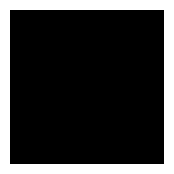

Sample: 240417_EtOH_Ac_soxhlet_#2, RGB: [0 0 0]


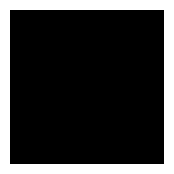

Sample: 240417_EtOH_Ac_soxhlet_#3, RGB: [0 0 0]


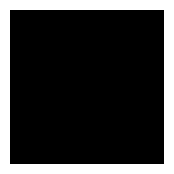

Sample: 240417_EtOH_Ac_soxhlet_#4, RGB: [0 0 0]


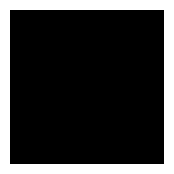

Sample: 240417_EtOH_macerate, RGB: [0 0 0]


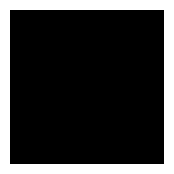

Sample: 240417_EtOH_soxhlet_#1, RGB: [0 0 0]


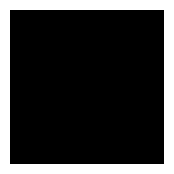

Sample: 240417_EtOH_soxhlet_#2, RGB: [0 0 0]


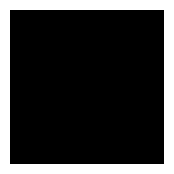

Sample: 240417_EtOH_soxhlet_#3, RGB: [0 0 0]


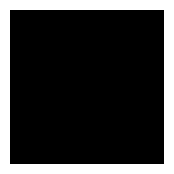

Sample: 240417_MeOH_macerate, RGB: [0 0 0]


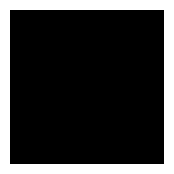

Sample: 240417_MeOH_soxhlet_#1, RGB: [0 0 0]


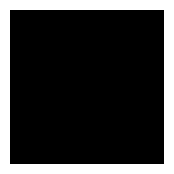

Sample: 240417_MeOH_soxhlet_#2, RGB: [0 0 0]


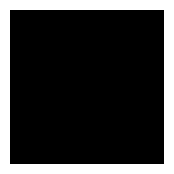

Sample: 240417_MeOH_soxhlet_#3, RGB: [0 0 0]


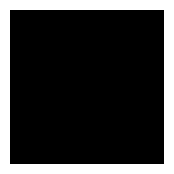

Sample: 240514_biomass_baseline, RGB: [0 0 0]


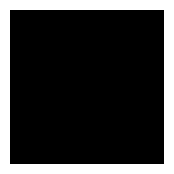

Sample: 240514_EtOH-NaOH_10.1_MeOH_clean, RGB: [0 0 0]


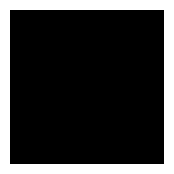

Sample: 240514_powderised_MeOH_soxhlet, RGB: [0 0 0]


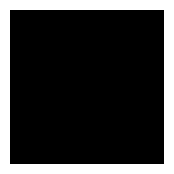

Sample: 240701_EtOH.Ac_5x1h_1400, RGB: [0 0 0]


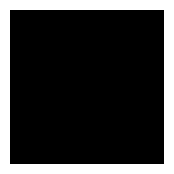

Sample: 240701_EtOH.Ac_5x24h_1400, RGB: [0 0 0]


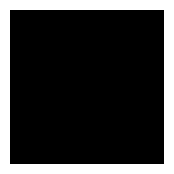

Sample: 240701_EtOH_5x1h_1400, RGB: [0 0 0]


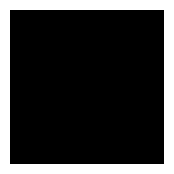

Sample: 240701_EtOH_5x24h_1400, RGB: [0 0 0]


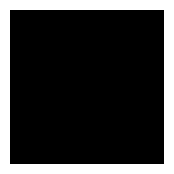

Sample: 240701_EtOH_5x24_EtOH_10%_ChMeSO3, RGB: [0 0 0]


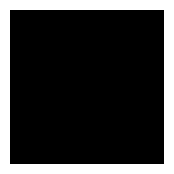

Sample: 240701_EtOH_5x24_EtOH_12..5%_ChMeSO3, RGB: [0 0 0]


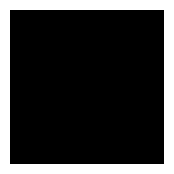

Sample: 240701_EtOH_5x24_EtOH_15%_ChMeSO3, RGB: [0 0 0]


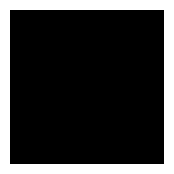

Sample: 240701_EtOH_5x24_EtOH_5%_ChMeSO3, RGB: [0 0 0]


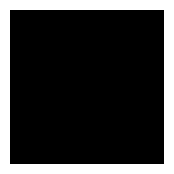

Sample: 240701_EtOH_5x24_EtOH_7.5%_ChMeSO3, RGB: [0 0 0]


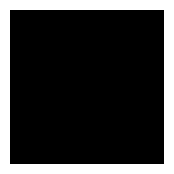

Sample: 240701_EtOH_5x24_MeOH_12.5%_ChMeSO3, RGB: [0 0 0]


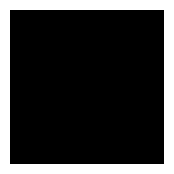

Sample: 240701_EtOH_5x24_MeOH_50%_ChMeSO3, RGB: [0 0 0]


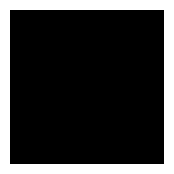

Sample: 240701_EtOH_5x24_MeOH_6.25%_ChMeSO3, RGB: [0 0 0]


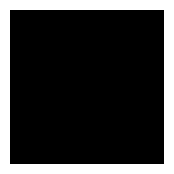

Sample: 240701_MeOH_48h_soxhlet, RGB: [0 0 0]


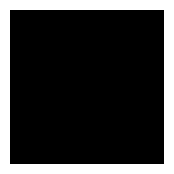

Sample: 240701_MeOH_5x1h_1400, RGB: [0 0 0]


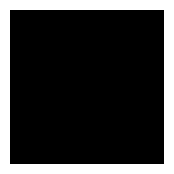

Sample: 240701_MeOH_5x24h_1400, RGB: [0 0 0]


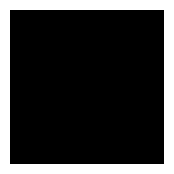

Sample: 240701_MeOH_5x24_MeOH_12.5%_ChMeSO3, RGB: [0 0 0]


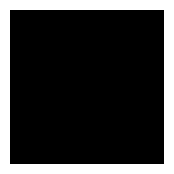

Sample: 240712_BaSO4_direct, RGB: [0 0 0]


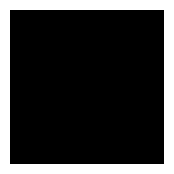

Sample: 240712_EtOH.Ac_5x2h_1400, RGB: [0 0 0]


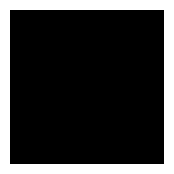

Sample: 240712_EtOH.Ac_5x2h_1400_2, RGB: [0 0 0]


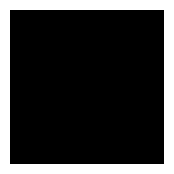

Sample: 240712_EtOH_5x2h_1400, RGB: [0 0 0]


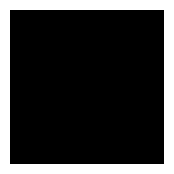

Sample: 240712_MeOH_5x2h_1400, RGB: [0 0 0]


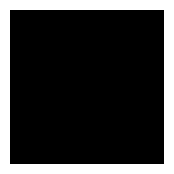

Sample: 240730_ChCl1M_1x20m_EtOH_5x24h_1400_RT, RGB: [0 0 0]


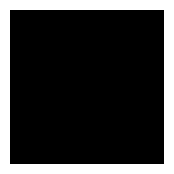

In [4]:
# Define the CIE 1931 color matching functions
cie_data = np.array([[360, 0.0001299, 0.000003917, 0.0006061] , [361, 0.000145847, 0.000004393581, 0.0006808792] , [362, 0.0001638021, 0.000004929604, 0.0007651456] , [363, 0.0001840037, 0.000005532136, 0.0008600124] , [364, 0.0002066902, 0.000006208245, 0.0009665928] , [365, 0.0002321, 0.000006965, 0.001086] , [366, 0.000260728, 0.000007813219, 0.001220586] , [367, 0.000293075, 0.000008767336, 0.001372729] , [368, 0.000329388, 0.000009839844, 0.001543579] , [369, 0.000369914, 0.00001104323, 0.001734286] , [370, 0.0004149, 0.00001239, 0.001946] , [371, 0.0004641587, 0.00001388641, 0.002177777] , [372, 0.000518986, 0.00001555728, 0.002435809] , [373, 0.000581854, 0.00001744296, 0.002731953] , [374, 0.0006552347, 0.00001958375, 0.003078064] , [375, 0.0007416, 0.00002202, 0.003486] , [376, 0.0008450296, 0.00002483965, 0.003975227] , [377, 0.0009645268, 0.00002804126, 0.00454088] , [378, 0.001094949, 0.00003153104, 0.00515832] , [379, 0.001231154, 0.00003521521, 0.005802907] , [380, 0.001368, 0.000039, 0.006450001] , [381, 0.00150205, 0.0000428264, 0.007083216] , [382, 0.001642328, 0.0000469146, 0.007745488] , [383, 0.001802382, 0.0000515896, 0.008501152] , [384, 0.001995757, 0.0000571764, 0.009414544] , [385, 0.002236, 0.000064, 0.01054999] , [386, 0.002535385, 0.00007234421, 0.0119658] , [387, 0.002892603, 0.00008221224, 0.01365587] , [388, 0.003300829, 0.00009350816, 0.01558805] , [389, 0.003753236, 0.0001061361, 0.01773015] , [390, 0.004243, 0.00012, 0.02005001] , [391, 0.004762389, 0.000134984, 0.02251136] , [392, 0.005330048, 0.000151492, 0.02520288] , [393, 0.005978712, 0.000170208, 0.02827972] , [394, 0.006741117, 0.000191816, 0.03189704] , [395, 0.00765, 0.000217, 0.03621] , [396, 0.008751373, 0.0002469067, 0.04143771] , [397, 0.01002888, 0.00028124, 0.04750372] , [398, 0.0114217, 0.00031852, 0.05411988] , [399, 0.01286901, 0.0003572667, 0.06099803] , [400, 0.01431, 0.000396, 0.06785001] , [401, 0.01570443, 0.0004337147, 0.07448632] , [402, 0.01714744, 0.000473024, 0.08136156] , [403, 0.01878122, 0.000517876, 0.08915364] , [404, 0.02074801, 0.0005722187, 0.09854048] , [405, 0.02319, 0.00064, 0.1102] , [406, 0.02620736, 0.00072456, 0.1246133] , [407, 0.02978248, 0.0008255, 0.1417017] , [408, 0.03388092, 0.00094116, 0.1613035] , [409, 0.03846824, 0.00106988, 0.1832568] , [410, 0.04351, 0.00121, 0.2074] , [411, 0.0489956, 0.001362091, 0.2336921] , [412, 0.0550226, 0.001530752, 0.2626114] , [413, 0.0617188, 0.001720368, 0.2947746] , [414, 0.069212, 0.001935323, 0.3307985] , [415, 0.07763, 0.00218, 0.3713] , [416, 0.08695811, 0.0024548, 0.4162091] , [417, 0.09717672, 0.002764, 0.4654642] , [418, 0.1084063, 0.0031178, 0.5196948] , [419, 0.1207672, 0.0035264, 0.5795303] , [420, 0.13438, 0.004, 0.6456] , [421, 0.1493582, 0.00454624, 0.7184838] , [422, 0.1653957, 0.00515932, 0.7967133] , [423, 0.1819831, 0.00582928, 0.8778459] , [424, 0.198611, 0.00654616, 0.959439] , [425, 0.21477, 0.0073, 1.0390501] , [426, 0.2301868, 0.008086507, 1.1153673] , [427, 0.2448797, 0.00890872, 1.1884971] , [428, 0.2587773, 0.00976768, 1.2581233] , [429, 0.2718079, 0.01066443, 1.3239296] , [430, 0.2839, 0.0116, 1.3856] , [431, 0.2949438, 0.01257317, 1.4426352] , [432, 0.3048965, 0.01358272, 1.4948035] , [433, 0.3137873, 0.01462968, 1.5421903] , [434, 0.3216454, 0.01571509, 1.5848807] , [435, 0.3285, 0.01684, 1.62296] , [436, 0.3343513, 0.01800736, 1.6564048] , [437, 0.3392101, 0.01921448, 1.6852959] , [438, 0.3431213, 0.02045392, 1.7098745] , [439, 0.3461296, 0.02171824, 1.7303821] , [440, 0.34828, 0.023, 1.74706] , [441, 0.3495999, 0.02429461, 1.7600446] , [442, 0.3501474, 0.02561024, 1.7696233] , [443, 0.350013, 0.02695857, 1.7762637] , [444, 0.349287, 0.02835125, 1.7804334] , [445, 0.34806, 0.0298, 1.7826] , [446, 0.3463733, 0.03131083, 1.7829682] , [447, 0.3442624, 0.03288368, 1.7816998] , [448, 0.3418088, 0.03452112, 1.7791982] , [449, 0.3390941, 0.03622571, 1.7758671] , [450, 0.3362, 0.038, 1.77211] , [451, 0.3331977, 0.03984667, 1.7682589] , [452, 0.3300411, 0.041768, 1.764039] , [453, 0.3266357, 0.043766, 1.7589438] , [454, 0.3228868, 0.04584267, 1.7524663] , [455, 0.3187, 0.048, 1.7441] , [456, 0.3140251, 0.05024368, 1.7335595] , [457, 0.308884, 0.05257304, 1.7208581] , [458, 0.3032904, 0.05498056, 1.7059369] , [459, 0.2972579, 0.05745872, 1.6887372] , [460, 0.2908, 0.06, 1.6692] , [461, 0.2839701, 0.06260197, 1.6475287] , [462, 0.2767214, 0.06527752, 1.6234127] , [463, 0.2689178, 0.06804208, 1.5960223] , [464, 0.2604227, 0.07091109, 1.564528] , [465, 0.2511, 0.0739, 1.5281] , [466, 0.2408475, 0.077016, 1.4861114] , [467, 0.2298512, 0.0802664, 1.4395215] , [468, 0.2184072, 0.0836668, 1.3898799] , [469, 0.2068115, 0.0872328, 1.3387362] , [470, 0.19536, 0.09098, 1.28764] , [471, 0.1842136, 0.09491755, 1.2374223] , [472, 0.1733273, 0.09904584, 1.1878243] , [473, 0.1626881, 0.1033674, 1.1387611] , [474, 0.1522833, 0.1078846, 1.090148] , [475, 0.1421, 0.1126, 1.0419] , [476, 0.1321786, 0.117532, 0.9941976] , [477, 0.1225696, 0.1226744, 0.9473473] , [478, 0.1132752, 0.1279928, 0.9014531] , [479, 0.1042979, 0.1334528, 0.8566193] , [480, 0.09564, 0.13902, 0.8129501] , [481, 0.08729955, 0.1446764, 0.7705173] , [482, 0.07930804, 0.1504693, 0.7294448] , [483, 0.07171776, 0.1564619, 0.6899136] , [484, 0.06458099, 0.1627177, 0.6521049] , [485, 0.05795001, 0.1693, 0.6162] , [486, 0.05186211, 0.1762431, 0.5823286] , [487, 0.04628152, 0.1835581, 0.5504162] , [488, 0.04115088, 0.1912735, 0.5203376] , [489, 0.03641283, 0.199418, 0.4919673] , [490, 0.03201, 0.20802, 0.46518] , [491, 0.0279172, 0.2171199, 0.4399246] , [492, 0.0241444, 0.2267345, 0.4161836] , [493, 0.020687, 0.2368571, 0.3938822] , [494, 0.0175404, 0.2474812, 0.3729459] , [495, 0.0147, 0.2586, 0.3533] , [496, 0.01216179, 0.2701849, 0.3348578] , [497, 0.00991996, 0.2822939, 0.3175521] , [498, 0.00796724, 0.2950505, 0.3013375] , [499, 0.006296346, 0.308578, 0.2861686] , [500, 0.0049, 0.323, 0.272] , [501, 0.003777173, 0.3384021, 0.2588171] , [502, 0.00294532, 0.3546858, 0.2464838] , [503, 0.00242488, 0.3716986, 0.2347718] , [504, 0.002236293, 0.3892875, 0.2234533] , [505, 0.0024, 0.4073, 0.2123] , [506, 0.00292552, 0.4256299, 0.2011692] , [507, 0.00383656, 0.4443096, 0.1901196] , [508, 0.00517484, 0.4633944, 0.1792254] , [509, 0.00698208, 0.4829395, 0.1685608] , [510, 0.0093, 0.503, 0.1582] , [511, 0.01214949, 0.5235693, 0.1481383] , [512, 0.01553588, 0.544512, 0.1383758] , [513, 0.01947752, 0.56569, 0.1289942] , [514, 0.02399277, 0.5869653, 0.1200751] , [515, 0.0291, 0.6082, 0.1117] , [516, 0.03481485, 0.6293456, 0.1039048] , [517, 0.04112016, 0.6503068, 0.09666748] , [518, 0.04798504, 0.6708752, 0.08998272] , [519, 0.05537861, 0.6908424, 0.08384531] , [520, 0.06327, 0.71, 0.07824999] , [521, 0.07163501, 0.7281852, 0.07320899] , [522, 0.08046224, 0.7454636, 0.06867816] , [523, 0.08973996, 0.7619694, 0.06456784] , [524, 0.09945645, 0.7778368, 0.06078835] , [525, 0.1096, 0.7932, 0.05725001] , [526, 0.1201674, 0.8081104, 0.05390435] , [527, 0.1311145, 0.8224962, 0.05074664] , [528, 0.1423679, 0.8363068, 0.04775276] , [529, 0.1538542, 0.8494916, 0.04489859] , [530, 0.1655, 0.862, 0.04216] , [531, 0.1772571, 0.8738108, 0.03950728] , [532, 0.18914, 0.8849624, 0.03693564] , [533, 0.2011694, 0.8954936, 0.03445836] , [534, 0.2133658, 0.9054432, 0.03208872] , [535, 0.2257499, 0.9148501, 0.02984] , [536, 0.2383209, 0.9237348, 0.02771181] , [537, 0.2510668, 0.9320924, 0.02569444] , [538, 0.2639922, 0.9399226, 0.02378716] , [539, 0.2771017, 0.9472252, 0.02198925] , [540, 0.2904, 0.954, 0.0203] , [541, 0.3038912, 0.9602561, 0.01871805] , [542, 0.3175726, 0.9660074, 0.01724036] , [543, 0.3314384, 0.9712606, 0.01586364] , [544, 0.3454828, 0.9760225, 0.01458461] , [545, 0.3597, 0.9803, 0.0134] , [546, 0.3740839, 0.9840924, 0.01230723] , [547, 0.3886396, 0.9874182, 0.01130188] , [548, 0.4033784, 0.9903128, 0.01037792] , [549, 0.4183115, 0.9928116, 0.009529306] , [550, 0.4334499, 0.9949501, 0.008749999] , [551, 0.4487953, 0.9967108, 0.0080352] , [552, 0.464336, 0.9980983, 0.0073816] , [553, 0.480064, 0.999112, 0.0067854] , [554, 0.4959713, 0.9997482, 0.0062428] , [555, 0.5120501, 1, 0.005749999] , [556, 0.5282959, 0.9998567, 0.0053036] , [557, 0.5446916, 0.9993046, 0.0048998] , [558, 0.5612094, 0.9983255, 0.0045342] , [559, 0.5778215, 0.9968987, 0.0042024] , [560, 0.5945, 0.995, 0.0039] , [561, 0.6112209, 0.9926005, 0.0036232] , [562, 0.6279758, 0.9897426, 0.0033706] , [563, 0.6447602, 0.9864444, 0.0031414] , [564, 0.6615697, 0.9827241, 0.0029348] , [565, 0.6784, 0.9786, 0.002749999] , [566, 0.6952392, 0.9740837, 0.0025852] , [567, 0.7120586, 0.9691712, 0.0024386] , [568, 0.7288284, 0.9638568, 0.0023094] , [569, 0.7455188, 0.9581349, 0.0021968] , [570, 0.7621, 0.952, 0.0021] , [571, 0.7785432, 0.9454504, 0.002017733] , [572, 0.7948256, 0.9384992, 0.0019482] , [573, 0.8109264, 0.9311628, 0.0018898] , [574, 0.8268248, 0.9234576, 0.001840933] , [575, 0.8425, 0.9154, 0.0018] , [576, 0.8579325, 0.9070064, 0.001766267] , [577, 0.8730816, 0.8982772, 0.0017378] , [578, 0.8878944, 0.8892048, 0.0017112] , [579, 0.9023181, 0.8797816, 0.001683067] , [580, 0.9163, 0.87, 0.001650001] , [581, 0.9297995, 0.8598613, 0.001610133] , [582, 0.9427984, 0.849392, 0.0015644] , [583, 0.9552776, 0.838622, 0.0015136] , [584, 0.9672179, 0.8275813, 0.001458533] , [585, 0.9786, 0.8163, 0.0014] , [586, 0.9893856, 0.8047947, 0.001336667] , [587, 0.9995488, 0.793082, 0.00127] , [588, 1.0090892, 0.781192, 0.001205] , [589, 1.0180064, 0.7691547, 0.001146667] , [590, 1.0263, 0.757, 0.0011] , [591, 1.0339827, 0.7447541, 0.0010688] , [592, 1.040986, 0.7324224, 0.0010494] , [593, 1.047188, 0.7200036, 0.0010356] , [594, 1.0524667, 0.7074965, 0.0010212] , [595, 1.0567, 0.6949, 0.001] , [596, 1.0597944, 0.6822192, 0.00096864] , [597, 1.0617992, 0.6694716, 0.00092992] , [598, 1.0628068, 0.6566744, 0.00088688] , [599, 1.0629096, 0.6438448, 0.00084256] , [600, 1.0622, 0.631, 0.0008] , [601, 1.0607352, 0.6181555, 0.00076096] , [602, 1.0584436, 0.6053144, 0.00072368] , [603, 1.0552244, 0.5924756, 0.00068592] , [604, 1.0509768, 0.5796379, 0.00064544] , [605, 1.0456, 0.5668, 0.0006] , [606, 1.0390369, 0.5539611, 0.0005478667] , [607, 1.0313608, 0.5411372, 0.0004916] , [608, 1.0226662, 0.5283528, 0.0004354] , [609, 1.0130477, 0.5156323, 0.0003834667] , [610, 1.0026, 0.503, 0.00034] , [611, 0.9913675, 0.4904688, 0.0003072533] , [612, 0.9793314, 0.4780304, 0.00028316] , [613, 0.9664916, 0.4656776, 0.00026544] , [614, 0.9528479, 0.4534032, 0.0002518133] , [615, 0.9384, 0.4412, 0.00024] , [616, 0.923194, 0.42908, 0.0002295467] , [617, 0.907244, 0.417036, 0.00022064] , [618, 0.890502, 0.405032, 0.00021196] , [619, 0.87292, 0.393032, 0.0002021867] , [620, 0.8544499, 0.381, 0.00019] , [621, 0.835084, 0.3689184, 0.0001742133] , [622, 0.814946, 0.3568272, 0.00015564] , [623, 0.794186, 0.3447768, 0.00013596] , [624, 0.772954, 0.3328176, 0.0001168533] , [625, 0.7514, 0.321, 0.0001] , [626, 0.7295836, 0.3093381, 0.00008613333] , [627, 0.7075888, 0.2978504, 0.0000746] , [628, 0.6856022, 0.2865936, 0.000065] , [629, 0.6638104, 0.2756245, 0.00005693333] , [630, 0.6424, 0.265, 0.00004999999] , [631, 0.6215149, 0.2547632, 0.00004416] , [632, 0.6011138, 0.2448896, 0.00003948] , [633, 0.5811052, 0.2353344, 0.00003572] , [634, 0.5613977, 0.2260528, 0.00003264] , [635, 0.5419, 0.217, 0.00003] , [636, 0.5225995, 0.2081616, 0.00002765333] , [637, 0.5035464, 0.1995488, 0.00002556] , [638, 0.4847436, 0.1911552, 0.00002364] , [639, 0.4661939, 0.1829744, 0.00002181333] , [640, 0.4479, 0.175, 0.00002] , [641, 0.4298613, 0.1672235, 0.00001813333] , [642, 0.412098, 0.1596464, 0.0000162] , [643, 0.394644, 0.1522776, 0.0000142] , [644, 0.3775333, 0.1451259, 0.00001213333] , [645, 0.3608, 0.1382, 0.00001] , [646, 0.3444563, 0.1315003, 0.000007733333] , [647, 0.3285168, 0.1250248, 0.0000054] , [648, 0.3130192, 0.1187792, 0.0000032] , [649, 0.2980011, 0.1127691, 0.000001333333] , [650, 0.2835, 0.107, 0] , [651, 0.2695448, 0.1014762, 0] , [652, 0.2561184, 0.09618864, 0] , [653, 0.2431896, 0.09112296, 0] , [654, 0.2307272, 0.08626485, 0] , [655, 0.2187, 0.0816, 0] , [656, 0.2070971, 0.07712064, 0] , [657, 0.1959232, 0.07282552, 0] , [658, 0.1851708, 0.06871008, 0] , [659, 0.1748323, 0.06476976, 0] , [660, 0.1649, 0.061, 0] , [661, 0.1553667, 0.05739621, 0] , [662, 0.14623, 0.05395504, 0] , [663, 0.13749, 0.05067376, 0] , [664, 0.1291467, 0.04754965, 0] , [665, 0.1212, 0.04458, 0] , [666, 0.1136397, 0.04175872, 0] , [667, 0.106465, 0.03908496, 0] , [668, 0.09969044, 0.03656384, 0] , [669, 0.09333061, 0.03420048, 0] , [670, 0.0874, 0.032, 0] , [671, 0.08190096, 0.02996261, 0] , [672, 0.07680428, 0.02807664, 0] , [673, 0.07207712, 0.02632936, 0] , [674, 0.06768664, 0.02470805, 0] , [675, 0.0636, 0.0232, 0] , [676, 0.05980685, 0.02180077, 0] , [677, 0.05628216, 0.02050112, 0] , [678, 0.05297104, 0.01928108, 0] , [679, 0.04981861, 0.01812069, 0] , [680, 0.04677, 0.017, 0] , [681, 0.04378405, 0.01590379, 0] , [682, 0.04087536, 0.01483718, 0] , [683, 0.03807264, 0.01381068, 0] , [684, 0.03540461, 0.01283478, 0] , [685, 0.0329, 0.01192, 0] , [686, 0.03056419, 0.01106831, 0] , [687, 0.02838056, 0.01027339, 0] , [688, 0.02634484, 0.009533311, 0] , [689, 0.02445275, 0.008846157, 0] , [690, 0.0227, 0.00821, 0] , [691, 0.02108429, 0.007623781, 0] , [692, 0.01959988, 0.007085424, 0] , [693, 0.01823732, 0.006591476, 0] , [694, 0.01698717, 0.006138485, 0] , [695, 0.01584, 0.005723, 0] , [696, 0.01479064, 0.005343059, 0] , [697, 0.01383132, 0.004995796, 0] , [698, 0.01294868, 0.004676404, 0] , [699, 0.0121292, 0.004380075, 0] , [700, 0.01135916, 0.004102, 0] , [701, 0.01062935, 0.003838453, 0] , [702, 0.009938846, 0.003589099, 0] , [703, 0.009288422, 0.003354219, 0] , [704, 0.008678854, 0.003134093, 0] , [705, 0.008110916, 0.002929, 0] , [706, 0.007582388, 0.002738139, 0] , [707, 0.007088746, 0.002559876, 0] , [708, 0.006627313, 0.002393244, 0] , [709, 0.006195408, 0.002237275, 0] , [710, 0.005790346, 0.002091, 0] , [711, 0.005409826, 0.001953587, 0] , [712, 0.005052583, 0.00182458, 0] , [713, 0.004717512, 0.00170358, 0] , [714, 0.004403507, 0.001590187, 0] , [715, 0.004109457, 0.001484, 0] , [716, 0.003833913, 0.001384496, 0] , [717, 0.003575748, 0.001291268, 0] , [718, 0.003334342, 0.001204092, 0] , [719, 0.003109075, 0.001122744, 0] , [720, 0.002899327, 0.001047, 0] , [721, 0.002704348, 0.0009765896, 0] , [722, 0.00252302, 0.0009111088, 0] , [723, 0.002354168, 0.0008501332, 0] , [724, 0.002196616, 0.0007932384, 0] , [725, 0.00204919, 0.00074, 0] , [726, 0.00191096, 0.0006900827, 0] , [727, 0.001781438, 0.00064331, 0] , [728, 0.00166011, 0.000599496, 0] , [729, 0.001546459, 0.0005584547, 0] , [730, 0.001439971, 0.00052, 0] , [731, 0.001340042, 0.0004839136, 0] , [732, 0.001246275, 0.0004500528, 0] , [733, 0.001158471, 0.0004183452, 0] , [734, 0.00107643, 0.0003887184, 0] , [735, 0.0009999493, 0.0003611, 0] , [736, 0.0009287358, 0.0003353835, 0] , [737, 0.0008624332, 0.0003114404, 0] , [738, 0.0008007503, 0.0002891656, 0] , [739, 0.000743396, 0.0002684539, 0] , [740, 0.0006900786, 0.0002492, 0] , [741, 0.0006405156, 0.0002313019, 0] , [742, 0.0005945021, 0.0002146856, 0] , [743, 0.0005518646, 0.0001992884, 0] , [744, 0.000512429, 0.0001850475, 0] , [745, 0.0004760213, 0.0001719, 0] , [746, 0.0004424536, 0.0001597781, 0] , [747, 0.0004115117, 0.0001486044, 0] , [748, 0.0003829814, 0.0001383016, 0] , [749, 0.0003566491, 0.0001287925, 0] , [750, 0.0003323011, 0.00012, 0] , [751, 0.0003097586, 0.0001118595, 0] , [752, 0.0002888871, 0.0001043224, 0] , [753, 0.0002695394, 0.0000973356, 0] , [754, 0.0002515682, 0.00009084587, 0] , [755, 0.0002348261, 0.0000848, 0] , [756, 0.000219171, 0.00007914667, 0] , [757, 0.0002045258, 0.000073858, 0] , [758, 0.0001908405, 0.000068916, 0] , [759, 0.0001780654, 0.00006430267, 0] , [760, 0.0001661505, 0.00006, 0] , [761, 0.0001550236, 0.00005598187, 0] , [762, 0.0001446219, 0.0000522256, 0] , [763, 0.0001349098, 0.0000487184, 0] , [764, 0.000125852, 0.00004544747, 0] , [765, 0.000117413, 0.0000424, 0] , [766, 0.0001095515, 0.00003956104, 0] , [767, 0.0001022245, 0.00003691512, 0] , [768, 0.00009539445, 0.00003444868, 0] , [769, 0.0000890239, 0.00003214816, 0] , [770, 0.00008307527, 0.00003, 0] , [771, 0.00007751269, 0.00002799125, 0] , [772, 0.00007231304, 0.00002611356, 0] , [773, 0.00006745778, 0.00002436024, 0] , [774, 0.00006292844, 0.00002272461, 0] , [775, 0.00005870652, 0.0000212, 0] , [776, 0.00005477028, 0.00001977855, 0] , [777, 0.00005109918, 0.00001845285, 0] , [778, 0.00004767654, 0.00001721687, 0] , [779, 0.00004448567, 0.00001606459, 0] , [780, 0.00004150994, 0.00001499, 0] , [781, 0.00003873324, 0.00001398728, 0] , [782, 0.00003614203, 0.00001305155, 0] , [783, 0.00003372352, 0.00001217818, 0] , [784, 0.00003146487, 0.00001136254, 0] , [785, 0.00002935326, 0.0000106, 0] , [786, 0.00002737573, 0.000009885877, 0] , [787, 0.00002552433, 0.000009217304, 0] , [788, 0.00002379376, 0.000008592362, 0] , [789, 0.0000221787, 0.000008009133, 0] , [790, 0.00002067383, 0.0000074657, 0] , [791, 0.00001927226, 0.000006959567, 0] , [792, 0.0000179664, 0.000006487995, 0] , [793, 0.00001674991, 0.000006048699, 0] , [794, 0.00001561648, 0.000005639396, 0] , [795, 0.00001455977, 0.0000052578, 0] , [796, 0.00001357387, 0.000004901771, 0] , [797, 0.00001265436, 0.00000456972, 0] , [798, 0.00001179723, 0.000004260194, 0] , [799, 0.00001099844, 0.000003971739, 0] , [800, 0.00001025398, 0.0000037029, 0] , [801, 0.000009559646, 0.000003452163, 0] , [802, 0.000008912044, 0.000003218302, 0] , [803, 0.000008308358, 0.0000030003, 0] , [804, 0.000007745769, 0.000002797139, 0] , [805, 0.000007221456, 0.0000026078, 0] , [806, 0.000006732475, 0.00000243122, 0] , [807, 0.000006276423, 0.000002266531, 0] , [808, 0.000005851304, 0.000002113013, 0] , [809, 0.000005455118, 0.000001969943, 0] , [810, 0.000005085868, 0.0000018366, 0] , [811, 0.000004741466, 0.00000171223, 0] , [812, 0.000004420236, 0.000001596228, 0] , [813, 0.000004120783, 0.00000148809, 0] , [814, 0.000003841716, 0.000001387314, 0] , [815, 0.000003581652, 0.0000012934, 0] , [816, 0.000003339127, 0.00000120582, 0] , [817, 0.000003112949, 0.000001124143, 0] , [818, 0.000002902121, 0.000001048009, 0] , [819, 0.000002705645, 0.0000009770578, 0] , [820, 0.000002522525, 0.00000091093, 0] , [821, 0.000002351726, 0.0000008492513, 0] , [822, 0.000002192415, 0.0000007917212, 0] , [823, 0.000002043902, 0.0000007380904, 0] , [824, 0.000001905497, 0.0000006881098, 0] , [825, 0.000001776509, 0.00000064153, 0] , [826, 0.000001656215, 0.0000005980895, 0] , [827, 0.000001544022, 0.0000005575746, 0] , [828, 0.00000143944, 0.000000519808, 0] , [829, 0.000001341977, 0.0000004846123, 0] , [830, 0.000001251141, 0.00000045181, 0] ])


# Interpolating the CIE 1931 color matching functions
interp_x = interp1d(cie_data[:, 0], cie_data[:, 1], kind='linear', bounds_error=False, fill_value=0.0)
interp_y = interp1d(cie_data[:, 0], cie_data[:, 2], kind='linear', bounds_error=False, fill_value=0.0)
interp_z = interp1d(cie_data[:, 0], cie_data[:, 3], kind='linear', bounds_error=False, fill_value=0.0)

def spectrum_to_xyz(wavelengths, intensities):
    X = np.trapz(intensities * interp_x(wavelengths), wavelengths)
    Y = np.trapz(intensities * interp_y(wavelengths), wavelengths)
    Z = np.trapz(intensities * interp_z(wavelengths), wavelengths)
    return np.array([X, Y, Z])

def xyz_to_rgb(XYZ):
    # Conversion matrix from XYZ to sRGB
    M = np.array([
        [3.2406, -1.5372, -0.4986],
        [-0.9689, 1.8758, 0.0415],
        [0.0557, -0.2040, 1.0570]
    ])
    RGB = np.dot(M, XYZ)
    # Normalize the values to be between 0 and 1
    RGB = np.clip(RGB, 0, 1)
    # Convert to the range 0-255
    return (RGB * 255).astype(int)

def display_color(rgb):
    plt.figure(figsize=(2, 2))
    plt.imshow([[rgb / 255.0]])
    plt.axis('off')
    plt.show()

# Example usage
folder_path = "./UV_spectra/spc_datasets/"
data_dict = {}

# Iterate over files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".spc"):
        key = os.path.splitext(filename)[0]
        parser = SpcParser(os.path.join(folder_path, filename))
        parser.extract_data()
        x_array, y_array = parser.get_data()
        data_dict[key] = [x_array, y_array]

# Convert the UV-vis data to RGB and display the color
for key, (x_array, y_array) in data_dict.items():
    xyz = spectrum_to_xyz(x_array, y_array)
    rgb = xyz_to_rgb(xyz)
    print(f"Sample: {key}, RGB: {rgb}")
    display_color(rgb)


In [15]:
## LOAD OF DATAFILED FROM SPECIFIC FOLDER ##


# # Example usage:
# filename = "./UV_spectra/240417_EtOH_Ac_sohxlet_#1.spc"
# parser = SpcParser(filename)
# parser.extract_data()
# x_array, y_array = parser.get_data()
# print(x_array)
# print(y_array)

# Current date only
today = date.today()

# Formatting current date
formatted_today = today.strftime("%y%m%d")


# Define the folder path
folder_path = "./UV_spectra/spc_datasets/"

# Create a dictionary to store data from .spc files
data_dict = {}

# Iterate over files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".spc"):
        # Remove the file extension to use as dictionary key
        key = os.path.splitext(filename)[0]
        
        # Create parser instance for the current file
        parser = SpcParser(os.path.join(folder_path, filename))
        
        # Extract data from the file
        parser.extract_data()
        x_array, y_array = parser.get_data()
        
        # Store data in the dictionary
        data_dict[key] = [x_array, y_array]


# Create a new dictionary to store averaged data
data_dict_ave = {}

# Iterate through the keys
for key in data_dict.keys():
    if key[-2] == '#':  # If the penultimate character is '#'
        shared_key = key[:-3]  # Extract the shared part of the key name
        
        if shared_key not in data_dict_ave:  # If the shared key is not yet in data_dict_ave
            data_dict_ave[shared_key] = [[],[]]
            data_dict_ave[shared_key][0] = data_dict[key][0]  # Initialize with the x_array
            data_dict_ave[shared_key][1] = data_dict[key][1]  # Initialize with the y_array

        else:
            # Example tuples
            tuple1 = data_dict_ave[shared_key][1]
            tuple2 = data_dict[key][1]

            # Convert tuples to lists for easy manipulation
            list1 = list(tuple1)
            list2 = list(tuple2)

            # Perform element-wise addition
            for i in range(len(tuple1)):
                list1[i] += list2[i]
                list1[i] /= 2
            data_dict_ave[shared_key][1] = tuple(list1)

    else:
        # Directly append keys without '#' as penultimate character
        data_dict_ave[key] = data_dict[key]

# Now data_dict_ave contains the averaged datasets

# Print keys of the data_dict
print("Keys in data_dict:")
for key in data_dict.keys():
    print(key)

print()    

# Print keys of the data_dict
print("Keys in data_dict_ave:")
for key in data_dict_ave.keys():
    print(key)
    #print(data_dict_ave[key][0])
    

all_data = data_dict        
#del(data_dict)

averaged_data = data_dict_ave
del(data_dict_ave)

# List of keys to keep
keys_to_keep = [
    "240514_biomass_baseline",
    "240417_MeOH_soxhlet_#1",
    "240417_MeOH_soxhlet_#2",
    "240417_MeOH_soxhlet_#3"
]

# Create a new dictionary with only the specified keys
MeOH_data = {key: all_data[key] for key in keys_to_keep}

# List of keys to keep
keys_to_keep = [
    "240514_biomass_baseline",
    "240417_EtOH_soxhlet_#1",
    "240417_EtOH_soxhlet_#2",
    "240417_EtOH_soxhlet_#3"
]

# Create a new dictionary with only the specified keys
EtOH_data = {key: all_data[key] for key in keys_to_keep}

# List of keys to keep
keys_to_keep = [
    "240514_biomass_baseline",
    "240417_EtOH_Ac_soxhlet_#1",
    "240417_EtOH_Ac_soxhlet_#2",
    "240417_EtOH_Ac_soxhlet_#3",
    "240417_EtOH_Ac_soxhlet_#4"
]

# Create a new dictionary with only the specified keys
EtOH_Ac_data = {key: all_data[key] for key in keys_to_keep}

# List of keys to keep
keys_to_keep = [
    "240514_biomass_baseline",
    "240417_MeOH_macerate",
    "240514_powderised_MeOH_soxhlet",
    "240417_MeOH_soxhlet"
]

# Create a new dictionary with only the specified keys
MeOH_clean_data = {key: averaged_data[key] for key in keys_to_keep}

# List of keys to keep
keys_to_keep = [
    "240514_biomass_baseline",
    "240417_MeOH_macerate",
    "240514_powderised_MeOH_soxhlet",
    "240514_EtOH-NaOH_10.1_MeOH_clean",
    "240417_EtOH_macerate"
]

# Create a new dictionary with only the specified keys
clean_data = {key: all_data[key] for key in keys_to_keep}
clean_data["240417_EtOH_Ac_soxhlet"] = averaged_data["240417_EtOH_Ac_soxhlet"]

# List of keys to keep
keys_to_keep = [
    "240514_biomass_baseline",
    "240417_MeOH_macerate",
    "240417_EtOH_macerate"
]

# Create a new dictionary with only the specified keys
acetone_ethanol_data = {key: all_data[key] for key in keys_to_keep}
acetone_ethanol_data["240417_EtOH_Ac_soxhlet"] = averaged_data["240417_EtOH_Ac_soxhlet"]
acetone_ethanol_data["240417_EtOH_soxhlet"] = averaged_data["240417_EtOH_soxhlet"]

# List of keys to keep
keys_to_keep = [
    "240514_biomass_baseline",
    "240417_MeOH_macerate",
    "240514_powderised_MeOH_soxhlet"
]

# Create a new dictionary with only the specified keys
acetone_methanol_data = {key: all_data[key] for key in keys_to_keep}
acetone_methanol_data["240417_EtOH_Ac_soxhlet"] = averaged_data["240417_EtOH_Ac_soxhlet"]
acetone_methanol_data["240417_MeOH_soxhlet"] = averaged_data["240417_MeOH_soxhlet"]

# List of keys to keep
keys_to_keep = [
    "240514_biomass_baseline",
    "240514_powderised_MeOH_soxhlet"
]

# Create a new dictionary with only the specified keys
soxhlet_data = {key: all_data[key] for key in keys_to_keep}
soxhlet_data["240417_EtOH_Ac_soxhlet"] = averaged_data["240417_EtOH_Ac_soxhlet"]
soxhlet_data["240417_MeOH_soxhlet"] = averaged_data["240417_MeOH_soxhlet"]
soxhlet_data["240417_EtOH_soxhlet"] = averaged_data["240417_EtOH_soxhlet"]

# List of keys to keep
keys_to_keep = [
    "240701_EtOH.Ac_5x1h_1400",
    "240701_EtOH.Ac_5x24h_1400",
    "240701_EtOH_5x1h_1400",
    "240701_EtOH_5x24h_1400",
    "240701_MeOH_5x1h_1400",
    "240701_MeOH_5x24h_1400",
    "240712_EtOH_5x2h_1400",
    "240712_MeOH_5x2h_1400",
    "240712_EtOH.Ac_5x2h_1400_2"
]

# Create a new dictionary with only the specified keys
maceration_data = {key: all_data[key] for key in keys_to_keep}

# List of keys to keep
keys_to_keep = [
    "240701_MeOH_5x24_MeOH_12.5%_ChMeSO3",
    "240701_EtOH_5x24_EtOH_5%_ChMeSO3",
    "240701_EtOH_5x24_EtOH_7.5%_ChMeSO3",
    "240701_EtOH_5x24_EtOH_10%_ChMeSO3",
    "240701_EtOH_5x24_EtOH_12..5%_ChMeSO3",
    "240701_EtOH_5x24_EtOH_15%_ChMeSO3",
    "240701_EtOH_5x24_MeOH_50%_ChMeSO3",
    "240701_EtOH_5x24_MeOH_12.5%_ChMeSO3",
    "240701_EtOH_5x24_MeOH_6.25%_ChMeSO3"
]

# Create a new dictionary with only the specified keys
IL_maceration_data = {key: all_data[key] for key in keys_to_keep}

# List of keys to keep
keys_to_keep = [
    "240712_BaSO4_direct",
    "240730_ChCl1M_1x20m_EtOH_5x24h_1400_RT"
]

# Create a new dictionary with only the specified keys
calibration_data = {key: all_data[key] for key in keys_to_keep}

print(len(averaged_data["240417_EtOH_soxhlet"][0]))
# LGBT rainbow colors
rainbow_colors = ['#FF0000', '#FF7F00', '#00FF00', '#0000FF', '#8B00FF']

./UV_spectra/spc_datasets/240417_EtOH_Ac_soxhlet_#1.spc
./UV_spectra/spc_datasets/240417_EtOH_Ac_soxhlet_#2.spc
./UV_spectra/spc_datasets/240417_EtOH_Ac_soxhlet_#3.spc
./UV_spectra/spc_datasets/240417_EtOH_Ac_soxhlet_#4.spc
./UV_spectra/spc_datasets/240417_EtOH_macerate.spc
./UV_spectra/spc_datasets/240417_EtOH_soxhlet_#1.spc
./UV_spectra/spc_datasets/240417_EtOH_soxhlet_#2.spc
./UV_spectra/spc_datasets/240417_EtOH_soxhlet_#3.spc
./UV_spectra/spc_datasets/240417_MeOH_macerate.spc
./UV_spectra/spc_datasets/240417_MeOH_soxhlet_#1.spc
./UV_spectra/spc_datasets/240417_MeOH_soxhlet_#2.spc
./UV_spectra/spc_datasets/240417_MeOH_soxhlet_#3.spc
./UV_spectra/spc_datasets/240514_biomass_baseline.spc
./UV_spectra/spc_datasets/240514_EtOH-NaOH_10.1_MeOH_clean.spc
./UV_spectra/spc_datasets/240514_powderised_MeOH_soxhlet.spc
./UV_spectra/spc_datasets/240701_EtOH.Ac_5x1h_1400.spc
./UV_spectra/spc_datasets/240701_EtOH.Ac_5x24h_1400.spc
./UV_spectra/spc_datasets/240701_EtOH_5x1h_1400.spc
./UV_spectra/sp

In [6]:
## LOAD OF DATAFILED FROM SPECIFIC FOLDER ##


# # Example usage:
# filename = "./UV_spectra/240417_EtOH_Ac_sohxlet_#1.spc"
# parser = SpcParser(filename)
# parser.extract_data()
# x_array, y_array = parser.get_data()
# print(x_array)
# print(y_array)

# Current date only
today = date.today()

# Formatting current date
formatted_today = today.strftime("%y%m%d")


# Define the folder path
folder_path = r"E:\repeatability_colorimetry\Scan - Lambda 950 13 March 2025 13_11 GMT Standard Time"

# Create a dictionary to store data from .spc files
data_dict = {}

# Iterate over files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".sp"):
        # Remove the file extension to use as dictionary key
        key = os.path.splitext(filename)[0]
        
        # Create parser instance for the current file
        parser = SpParser(os.path.join(folder_path, filename))
        
        # Extract data from the file
        parser.extract_data()
        x_array, y_array = parser.get_transmittance()
        
        # Store data in the dictionary
        data_dict[key] = [x_array, y_array]


# Create a new dictionary to store averaged data
data_dict_ave = {}

# Iterate through the keys
for key in data_dict.keys():
    if key[-2] == '#':  # If the penultimate character is '#'
        shared_key = key[:-3]  # Extract the shared part of the key name
        
        if shared_key not in data_dict_ave:  # If the shared key is not yet in data_dict_ave
            data_dict_ave[shared_key] = [[],[]]
            data_dict_ave[shared_key][0] = data_dict[key][0]  # Initialize with the x_array
            data_dict_ave[shared_key][1] = data_dict[key][1]  # Initialize with the y_array

        else:
            # Example tuples
            tuple1 = data_dict_ave[shared_key][1]
            tuple2 = data_dict[key][1]

            # Convert tuples to lists for easy manipulation
            list1 = list(tuple1)
            list2 = list(tuple2)

            # Perform element-wise addition
            for i in range(len(tuple1)):
                list1[i] += list2[i]
                list1[i] /= 2
            data_dict_ave[shared_key][1] = tuple(list1)

    else:
        # Directly append keys without '#' as penultimate character
        data_dict_ave[key] = data_dict[key]

# Now data_dict_ave contains the averaged datasets

# Print keys of the data_dict
print("Keys in data_dict:")
for key in data_dict.keys():
    print(key)

# LGBT rainbow colors
rainbow_colors = ['#FF0000', '#FF7F00', '#00FF00', '#0000FF', '#8B00FF']

Keys in data_dict:
100% or 0 Absorbance Baseline.Correction.Raw
Batch 2-repeat.Sample.Raw
Batch 2.Sample.Raw
Batch 3.Sample.Raw
Batch 4.Sample.Raw
Blank.Blank.Raw
Sample Homo + Cl.Sample.Raw
Sample Homo.Sample.Raw
Sample Stir 1.Sample.Raw
Sample Stir 10-repeat.Sample.Raw
Sample Stir 10.Sample.Raw
Sample Stir 11.Sample.Raw
Sample Stir 12.Sample.Raw
Sample Stir 2-redo.Sample.Raw
Sample Stir 2.Sample.Raw
Sample Stir 3.Sample.Raw
Sample Stir 4.Sample.Raw
Sample Stir 5.Sample.Raw
Sample Stir 6.Sample.Raw
Sample Stir 7-redo.Sample.Raw
Sample Stir 7.Sample.Raw
Sample Stir 8.Sample.Raw
Sample Stir 9.Sample.Raw

Keys in data_dict_ave:
100% or 0 Absorbance Baseline.Correction.Raw
Batch 2-repeat.Sample.Raw
Batch 2.Sample.Raw
Batch 3.Sample.Raw
Batch 4.Sample.Raw
Blank.Blank.Raw
Sample Homo + Cl.Sample.Raw
Sample Homo.Sample.Raw
Sample Stir 1.Sample.Raw
Sample Stir 10-repeat.Sample.Raw
Sample Stir 10.Sample.Raw
Sample Stir 11.Sample.Raw
Sample Stir 12.Sample.Raw
Sample Stir 2-redo.Sample.Raw
Sampl

In [33]:
## LOAD OF DATAFILED FROM SPECIFIC FOLDER ##


# # Example usage:
# filename = "./UV_spectra/240417_EtOH_Ac_sohxlet_#1.spc"
# parser = SpcParser(filename)
# parser.extract_data()
# x_array, y_array = parser.get_data()
# print(x_array)
# print(y_array)

# Current date only
today = date.today()

# Formatting current date
formatted_today = today.strftime("%y%m%d")


# Define the folder path
folder_path = r'C:\Users\giaco\OneDrive - Imperial College London\Brandt-Talbot Group Folder\Current members\Giacomo\UV-vis\UV_phycocyanin\CPC_scale-up'
# Create a dictionary to store data from .spc files
data_dict = {}

# Iterate over files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".sp"):
        print(filename)
        # Remove the file extension to use as dictionary key
        key = os.path.splitext(filename)[0]
        
        # Create parser instance for the current file
        parser = SpParser(os.path.join(folder_path, filename))
        
        # Extract data from the file
        parser.extract_data()
        x_array, y_array = parser.get_transmittance()
        
        # Store data in the dictionary
        data_dict[key] = [x_array, y_array]


# Create a new dictionary to store averaged data
data_dict_ave = {}

# Iterate through the keys
for key in data_dict.keys():
    if key[-2] == '#':  # If the penultimate character is '#'
        shared_key = key[:-3]  # Extract the shared part of the key name
        
        if shared_key not in data_dict_ave:  # If the shared key is not yet in data_dict_ave
            data_dict_ave[shared_key] = [[],[]]
            data_dict_ave[shared_key][0] = data_dict[key][0]  # Initialize with the x_array
            data_dict_ave[shared_key][1] = data_dict[key][1]  # Initialize with the y_array

        else:
            # Example tuples
            tuple1 = data_dict_ave[shared_key][1]
            tuple2 = data_dict[key][1]

            # Convert tuples to lists for easy manipulation
            list1 = list(tuple1)
            list2 = list(tuple2)

            # Perform element-wise addition
            for i in range(len(tuple1)):
                list1[i] += list2[i]
                list1[i] /= 2
            data_dict_ave[shared_key][1] = tuple(list1)

    else:
        # Directly append keys without '#' as penultimate character
        data_dict_ave[key] = data_dict[key]

# Now data_dict_ave contains the averaged datasets

# Print keys of the data_dict
print("Keys in data_dict:")
for key in data_dict.keys():
    print(key)

# LGBT rainbow colors
rainbow_colors = ['#FF0000', '#FF7F00', '#00FF00', '#0000FF', '#8B00FF']

Phycocyanin_Batch_1.Sample.Raw.sp
Phycocyanin_Batch_2.Sample.Raw.sp
Phycocyanin_Batch_3.Sample.Raw.sp
Keys in data_dict:
Phycocyanin_Batch_1.Sample.Raw
Phycocyanin_Batch_2.Sample.Raw
Phycocyanin_Batch_3.Sample.Raw


In [34]:
## LOAD OF DATAFILED FROM SPECIFIC FOLDER ##


# # Example usage:
# filename = "./UV_spectra/240417_EtOH_Ac_sohxlet_#1.spc"
# parser = SpcParser(filename)
# parser.extract_data()
# x_array, y_array = parser.get_data()
# print(x_array)
# print(y_array)

# Current date only
today = date.today()

# Formatting current date
formatted_today = today.strftime("%y%m%d")


# Define the folder path
folder_path = '''C:/Users/giaco/OneDrive - Imperial College London/Collaborations/Agi/ISABEL_article/data/'''

# Create a dictionary to store data from .spc files
data_dict = {}

# Iterate over files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".spc"):
        # Remove the file extension to use as dictionary key
        key = os.path.splitext(filename)[0]
        
        # Create parser instance for the current file
        parser = SpcParser(os.path.join(folder_path, filename))
        # Extract data from the file
        parser.extract_data()
        x_array, y_array = parser.get_data()
        
        # Store data in the dictionary
        data_dict[key] = [x_array, y_array]


# Create a new dictionary to store averaged data
data_dict_ave = {}

# Iterate through the keys
for key in data_dict.keys():
    if key[-2] == '#':  # If the penultimate character is '#'
        shared_key = key[:-3]  # Extract the shared part of the key name
        
        if shared_key not in data_dict_ave:  # If the shared key is not yet in data_dict_ave
            data_dict_ave[shared_key] = [[],[]]
            data_dict_ave[shared_key][0] = data_dict[key][0]  # Initialize with the x_array
            data_dict_ave[shared_key][1] = data_dict[key][1]  # Initialize with the y_array

        else:
            # Example tuples
            tuple1 = data_dict_ave[shared_key][1]
            tuple2 = data_dict[key][1]

            # Convert tuples to lists for easy manipulation
            list1 = list(tuple1)
            list2 = list(tuple2)

            # Perform element-wise addition
            for i in range(len(tuple1)):
                list1[i] += list2[i]
                list1[i] /= 2
            data_dict_ave[shared_key][1] = tuple(list1)

    else:
        # Directly append keys without '#' as penultimate character
        data_dict_ave[key] = data_dict[key]

# Now data_dict_ave contains the averaged datasets

# Print keys of the data_dict
print("Keys in data_dict:")
for key in data_dict.keys():
    print(key)

print()    

# Print keys of the data_dict
print("Keys in data_dict_ave:")
for key in data_dict_ave.keys():
    print(key)
    #print(data_dict_ave[key][0])
    

all_data = data_dict        
del(data_dict)

averaged_data = data_dict_ave
del(data_dict_ave)

# LGBT rainbow colors
rainbow_colors = ['#FF0000', '#FF7F00', '#00FF00', '#0000FF', '#8B00FF']

C:/Users/giaco/OneDrive - Imperial College London/Collaborations/Agi/ISABEL_article/data/240801_ISABEL_IF1_170C_45_0LAS.spc
C:/Users/giaco/OneDrive - Imperial College London/Collaborations/Agi/ISABEL_article/data/240801_ISABEL_IF2_150C_45_2LAS.spc
C:/Users/giaco/OneDrive - Imperial College London/Collaborations/Agi/ISABEL_article/data/240801_ISABEL_IF2_150C_45_4LAS.spc
C:/Users/giaco/OneDrive - Imperial College London/Collaborations/Agi/ISABEL_article/data/240801_ISABEL_IF2_170C_45_2LAS.spc
C:/Users/giaco/OneDrive - Imperial College London/Collaborations/Agi/ISABEL_article/data/240801_ISABEL_IF2_170C_45_4LAS.spc
C:/Users/giaco/OneDrive - Imperial College London/Collaborations/Agi/ISABEL_article/data/240801_ISABEL_IF3_170C_45_0LAS.spc
C:/Users/giaco/OneDrive - Imperial College London/Collaborations/Agi/ISABEL_article/data/240801_ISABEL_IF4_150C_45_10LAS.spc
C:/Users/giaco/OneDrive - Imperial College London/Collaborations/Agi/ISABEL_article/data/240912_ISABEL_IF1_150C_45_0LAS.spc
C:/User

In [11]:
def uv_to_srgb(spectrum, absorbance=True, illuminant = colour.SDS_ILLUMINANTS['D65']):
    """
    Convert UV absorption or transmittance spectrum to sRGB color.
    
    Parameters:
    - spectrum: array-like, shape (n, 2)
        The input spectrum as [[wavelength, value], [wavelength, value], ...].
        If absorbance=True, the values are absorbance. Otherwise, they are transmittance.
    - absorbance: bool
        Whether the input values are absorbance (True) or transmittance (False).
    
    Returns:
    - rgb: array-like, shape (3,)
        The corresponding sRGB color.
    """
    # Convert input spectrum to numpy array
    spectrum = np.array(spectrum)
    wavelengths = spectrum[:, 0]
    values = spectrum[:, 1]

    # Remove values outside the visible range [380, 700] nm
    visible_indices = (wavelengths >= 360) & (wavelengths <= 700)
    wavelengths = wavelengths[visible_indices]
    values = values[visible_indices]

    # Convert absorbance to transmittance if necessary
    if absorbance:
        transmittance = 10 ** (-values)
    else:
        transmittance = values

    # Create a spectral distribution for the transmittance
    sd_transmittance = colour.SpectralDistribution(dict(zip(wavelengths, transmittance)), name='Transmittance')

    # Calculate the color matching functions for the given wavelengths
    cmfs = colour.MSDS_CMFS['CIE 1931 2 Degree Standard Observer']
    

    # Compute the XYZ tristimulus values
    xyz = colour.sd_to_XYZ(sd_transmittance, cmfs, method="Integration", illuminant = illuminant)

    # Convert XYZ to sRGB
    rgb = colour.XYZ_to_sRGB(xyz/100)
    
    # Ensure the RGB values are within the [0, 1] range
    rgb = np.clip(rgb, 0, 1)
    
    # Convert spectral distribution to Lab
    lab = colour.XYZ_to_Lab(xyz/100)

    return rgb, lab, xyz

def tristimulus_to_whiteness_tint(XYZ):
    XYZ = np.array(XYZ)
    xy = colour.XYZ_to_xy(XYZ)
    
    # Assuming XYZ values are in the domain [0, 100]
    Y = XYZ[1]  # Extracting Y value from XYZ
    
    # Assuming xy_n is the chromaticity coordinates of a perfect diffuser
    xy_n = np.array([0.3139, 0.3311])  # Example value, replace with actual values
    
    # Compute whiteness and tint using CIE 2004 method
    result = colour.colorimetry.whiteness_CIE2004(xy, Y, xy_n)
    
    # Return the result directly, which is already in the form of [W, T]
    return result

In [18]:
import numpy as np
import colour
import matplotlib.pyplot as plt

from specio import specread
from specio.datasets import load_sp_path

def uv_to_srgb(spectrum, absorbance=True, illuminant = colour.SDS_ILLUMINANTS['D65']):
    """
    Convert UV absorption or transmittance spectrum to sRGB color.
    
    Parameters:
    - spectrum: array-like, shape (n, 2)
        The input spectrum as [[wavelength, value], [wavelength, value], ...].
        If absorbance=True, the values are absorbance. Otherwise, they are transmittance.
    - absorbance: bool
        Whether the input values are absorbance (True) or transmittance (False).
    
    Returns:
    - rgb: array-like, shape (3,)
        The corresponding sRGB color.
    """
    # Convert input spectrum to numpy array
    spectrum = np.array(spectrum)
    wavelengths = spectrum[:, 0]
    values = spectrum[:, 1]

    # Remove values outside the visible range [380, 700] nm
    visible_indices = (wavelengths >= 360) & (wavelengths <= 700)
    wavelengths = wavelengths[visible_indices]
    values = values[visible_indices]

    # Convert absorbance to transmittance if necessary
    if absorbance:
        transmittance = 10 ** (-values)
    else:
        transmittance = values

    # Create a spectral distribution for the transmittance
    sd_transmittance = colour.SpectralDistribution(dict(zip(wavelengths, transmittance)), name='Transmittance')

    # Calculate the color matching functions for the given wavelengths
    cmfs = colour.MSDS_CMFS['CIE 1931 2 Degree Standard Observer']

    # Compute the XYZ tristimulus values
    xyz = colour.sd_to_XYZ(sd_transmittance, cmfs, method="Integration", illuminant=illuminant)/100
    
    # Convert XYZ to Lab
    lab = colour.XYZ_to_Lab(xyz)

    # Convert XYZ to sRGB
    rgb = colour.XYZ_to_sRGB(xyz)
    
    # Ensure the RGB values are within the [0, 1] range
    rgb = np.clip(rgb, 0, 1)

    return rgb,lab,xyz

print(__doc__)

# Find the path to the SP toy data
sp_filename = r'C:\Users\giaco\OneDrive - Imperial College London\Brandt-Talbot Group Folder\Current members\Giacomo\UV-vis\UV_phycocyanin\test.Sample.sp'
key = "PC-Phycocyanin"
print(sp_filename)

# Read the data
spectra = specread(sp_filename)

# UV-Vis spectrum data (example)
wavelengths = spectra.wavelength
absorbances =  spectra.amplitudes

# Filter and sort data for valid wavelengths
sorted_data = sorted(
    [
        [wavelength, absorbance]
        for wavelength, absorbance in zip(wavelengths, absorbances)
        if wavelength % 1 == 0 and 360 <= wavelength <= 800
    ],
    key=lambda x: x[0]  # Sort by wavelength
)

# Separate sorted data into wavelengths and absorbances
sorted_wavelengths = [data[0] for data in sorted_data]
sorted_absorbances = [data[1] for data in sorted_data]
spectrum = sorted_data
rgb_color, xyz_color = uv_to_srgb(spectrum, absorbance=True, illuminant=Lambda_950)
whiteness_index, tint = tristimulus_to_whiteness_tint(xyz_color)

print(f"Whiteness Index: {whiteness_index}")
print(f"Tint: {tint}")
print(f"{key},\n sRGB Color: {[int(colour) for colour in rgb_color*255]}")


# Display the resulting sRGB color
import matplotlib.pyplot as plt

plt.figure(figsize=(2, 2))
plt.title(f"{key},\n sRGB Color: {[int(colour) for colour in (1-rgb_color)*255]}")
plt.imshow([[1-rgb_color]], aspect='auto')
plt.axis('off')
plt.show()
decolouring_percent = (rgb_color[0] + rgb_color[1] + rgb_color[2]-68/255-77/255-55/255)/(3-68/255-77/255-55/255)
white_distance = 1-(rgb_color[0] + rgb_color[1] + rgb_color[2])/3
decolouring_percent = int(decolouring_percent * 100)
white_distance = int(white_distance * 100)

print(f"Decolouring: {decolouring_percent}%")
print(f"White distance: {white_distance}%")

color = {'name': 'PC-Phycocyanin', 'code': 'PC-Phycocyanin','rgb': [int(colour) for colour in (1-rgb_color)*255]}

# Loop through each color and create a separate plot
# Create the plot
fig, ax = plt.subplots(figsize=(3, 4.5))

# Main color swatch
ax.imshow([[color["rgb"]]], aspect='auto')

# Bottom overlay bar
ax.add_patch(plt.Rectangle((0, 0), 1, 0.25, transform=ax.transAxes, color='white'))
ax.text(0.5, 0.125, f"{color['name']}\nAthrospira Platensis\n{color['rgb']}",
        transform=ax.transAxes, ha='center', va='center', color='black', fontsize=12, weight='bold')

# Remove axes
ax.axis('off')

# Save the plot to a file
plt.savefig(f"pantone_{color['code']}.png", bbox_inches='tight', pad_inches=0)

# Show the plot (optional)
plt.show()

# Close the plot to avoid overlap in the next iteration
plt.close()


Automatically created module for IPython interactive environment
C:\Users\giaco\OneDrive - Imperial College London\Brandt-Talbot Group Folder\Current members\Giacomo\UV-vis\UV_phycocyanin\test.Sample.sp


IndexError: list index out of range

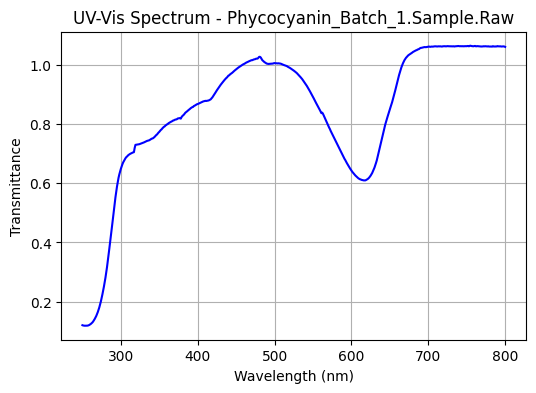

Whiteness Index: 48.819776132116246
Tint: 25.802776729061677
Phycocyanin_Batch_1.Sample.Raw,
 sRGB Color: [200, 244, 254]
Phycocyanin_Batch_1.Sample.Raw,
 XYZ Color: [ 0.74442611  0.84726541  1.06607036]
Phycocyanin_Batch_1.Sample.Raw,
 Lab Color: [ 93.76515136 -12.23290393  -9.3325474 ]


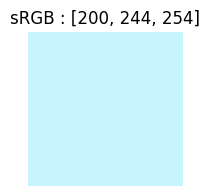

Decolouring: 88%
White distance: 8%


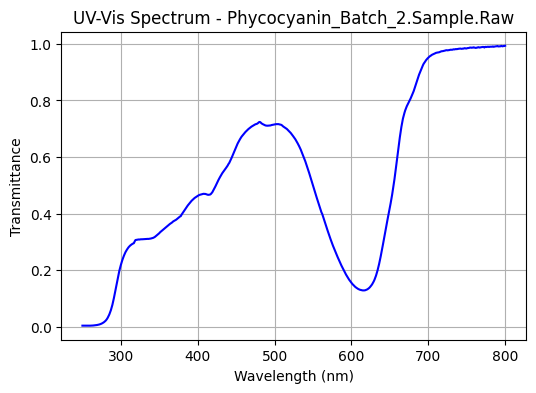

Whiteness Index: 115.22375996310431
Tint: 72.02531132162038
Phycocyanin_Batch_2.Sample.Raw,
 sRGB Color: [55, 195, 211]
Phycocyanin_Batch_2.Sample.Raw,
 XYZ Color: [ 0.33090568  0.44880293  0.69006744]
Phycocyanin_Batch_2.Sample.Raw,
 Lab Color: [ 72.81300213 -31.07008295 -18.65582443]


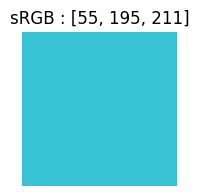

Decolouring: 46%
White distance: 39%


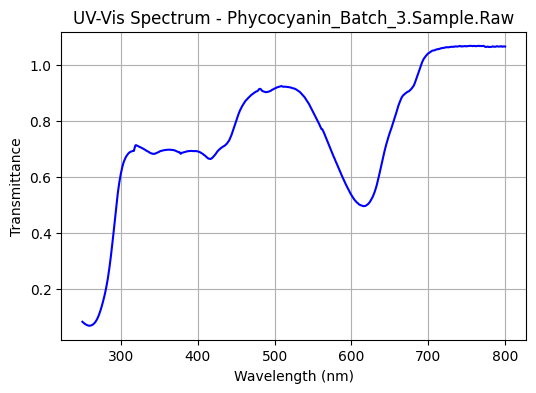

Whiteness Index: 21.94351430817173
Tint: 36.38884879792656
Phycocyanin_Batch_3.Sample.Raw,
 sRGB Color: [180, 237, 232]
Phycocyanin_Batch_3.Sample.Raw,
 XYZ Color: [ 0.64082523  0.76640912  0.88278351]
Phycocyanin_Batch_3.Sample.Raw,
 Lab Color: [ 90.15608097 -19.13364828  -3.45177414]


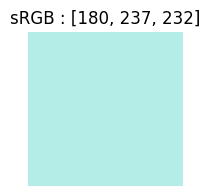

Decolouring: 79%
White distance: 14%


In [38]:
for key in data_dict.keys():
    data = data_dict[key]
    # Initialize empty lists to hold the limited data
    data1_limited = []
    data2_limited = []

    # Loop through each tuple in data and limit to 10 values
    for i in range(len(data[0])):
        data1_limited.append(data[0][i])
        data2_limited.append(data[1][i])

    # UV-Vis spectrum data (example)
    wavelengths = data1_limited
    absorbances = data2_limited

    # Filter and sort data for valid wavelengths
    sorted_data = sorted(
        [
            [wavelength, absorbance]
            for wavelength, absorbance in zip(wavelengths, absorbances)
            if wavelength % 1 == 0 and 250 <= wavelength <= 800
        ],
        key=lambda x: x[0]  # Sort by wavelength
    )

    # Separate sorted data into wavelengths and absorbances
    sorted_wavelengths = [data[0] for data in sorted_data]
    sorted_absorbances = [data[1] for data in sorted_data]
    spectrum = sorted_data
    
     # Plot the UV-Vis spectrum
    plt.figure(figsize=(6, 4))
    plt.plot(sorted_wavelengths, sorted_absorbances, linestyle='-', color='b', label=f"Spectrum {key}")
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Transmittance")
    plt.title(f"UV-Vis Spectrum - {key}")
    plt.grid(True)

    plt.show()
    
    rgb_color, Lab_color, xyz_color = uv_to_srgb(spectrum, absorbance=False)
    whiteness_index, tint = tristimulus_to_whiteness_tint(xyz_color)
    
    print(f"Whiteness Index: {whiteness_index}")
    print(f"Tint: {tint}")
    print(f"{key},\n sRGB Color: {[int(colour) for colour in rgb_color*255]}")
    print(f"{key},\n XYZ Color: {xyz_color}")
    print(f"{key},\n Lab Color: {Lab_color}")
    

    # Display the resulting sRGB color
    import matplotlib.pyplot as plt

    plt.figure(figsize=(2, 2))
    plt.title(f"sRGB : {[int(colour) for colour in rgb_color*255]}")
    plt.imshow([[rgb_color]], aspect='auto')
    plt.axis('off')
    plt.savefig(f"{key}.jpg")
    plt.show()
    decolouring_percent = (rgb_color[0] + rgb_color[1] + rgb_color[2]-68/255-77/255-55/255)/(3-68/255-77/255-55/255)
    white_distance = 1-(rgb_color[0] + rgb_color[1] + rgb_color[2])/3
    decolouring_percent = int(decolouring_percent * 100)
    white_distance = int(white_distance * 100)

    print(f"Decolouring: {decolouring_percent}%")
    print(f"White distance: {white_distance}%")

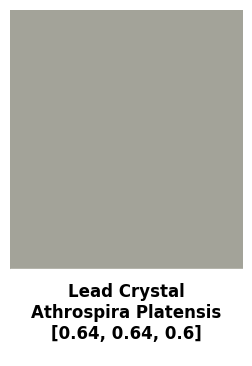

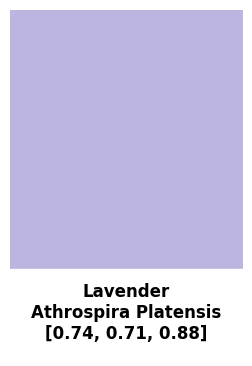

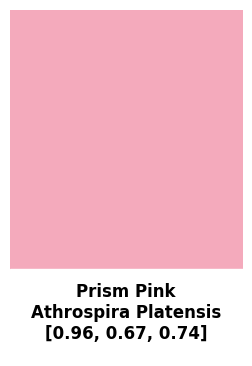

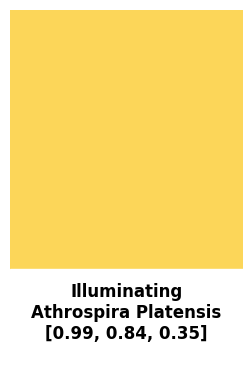

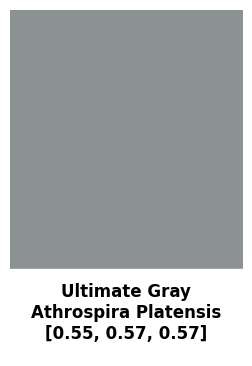

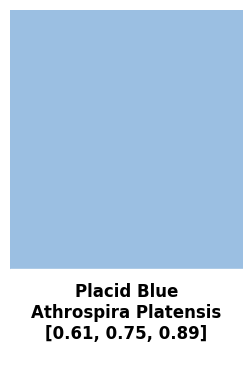

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Define color information
colors = [
    {"name": "Lead Crystal", "code": "20-0087", "rgb": [0.64, 0.64, 0.60]},
    {"name": "Lavender", "code": "15-3817", "rgb": [0.74, 0.71, 0.88]},
    {"name": "Prism Pink", "code": "14-2311", "rgb": [0.96, 0.67, 0.74]},
    {"name": "Illuminating", "code": "13-0647", "rgb": [0.99, 0.84, 0.35]},
    {"name": "Ultimate Gray", "code": "17-5104", "rgb": [0.55, 0.57, 0.57]},
    {"name": "Placid Blue", "code": "15-3920", "rgb": [0.61, 0.75, 0.89]}
]

# Loop through each color and create a separate plot
for color in colors:
    # Create the plot
    fig, ax = plt.subplots(figsize=(3, 4.5))
    
    # Main color swatch
    ax.imshow([[color["rgb"]]], aspect='auto')
    
    # Bottom overlay bar
    ax.add_patch(plt.Rectangle((0, 0), 1, 0.25, transform=ax.transAxes, color='white'))
    ax.text(0.5, 0.125, f"{color['name']}\nAthrospira Platensis\n{color['rgb']}",
            transform=ax.transAxes, ha='center', va='center', color='black', fontsize=12, weight='bold')
    
    # Remove axes
    ax.axis('off')
    
    # Save the plot to a file
    plt.savefig(f"pantone_{color['code']}.png", bbox_inches='tight', pad_inches=0)
    
    # Show the plot (optional)
    plt.show()

    # Close the plot to avoid overlap in the next iteration
    plt.close()


Whiteness Index: -94.79080840505549
Tint: 1.714561276733825
240417_EtOH_Ac_soxhlet_#1,
 sRGB Color: [123, 122, 94]
XYZ Color: [ 17.27754523  19.13001241  13.53588115]
Lab Color: [ 50.83896862  -4.85980461  15.42933737]
Lightness: 50.83896862457276, Chroma: 16.176592736813333
ΔC (Chroma Difference from BaSO4 white standard): 23.84204930186322
ΔE (Color Difference from BaSO4 white standard): 54.439486201788895
Decolouring: 24%
White distance: 55%


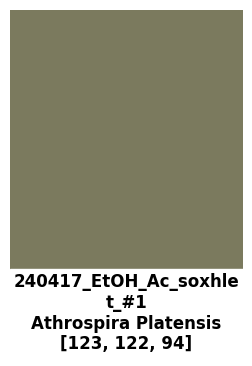

Whiteness Index: -103.20843957472906
Tint: 4.46854718368261
240417_EtOH_Ac_soxhlet_#2,
 sRGB Color: [125, 126, 95]
XYZ Color: [ 18.11291968  20.29202767  13.84815227]
Lab Color: [ 52.16578982  -6.08561843  16.95525108]
Lightness: 52.16578982064239, Chroma: 18.014307946020804
ΔC (Chroma Difference from BaSO4 white standard): 25.602556320474932
ΔE (Color Difference from BaSO4 white standard): 54.061020789786866
Decolouring: 26%
White distance: 54%


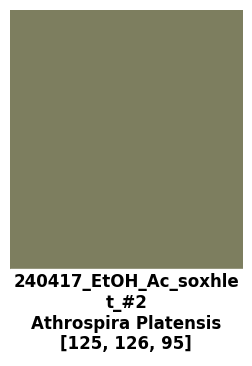

Whiteness Index: -144.97215054260695
Tint: -9.085509051805275
240417_EtOH_Ac_soxhlet_#3,
 sRGB Color: [148, 139, 93]
XYZ Color: [ 23.67846672  25.84275923  14.32437783]
Lab Color: [ 57.88749614  -3.867197    25.6803704 ]
Lightness: 57.88749614494432, Chroma: 25.969917912556966
ΔC (Chroma Difference from BaSO4 white standard): 33.81092667493618
ΔE (Color Difference from BaSO4 white standard): 53.834486187743444
Decolouring: 32%
White distance: 50%


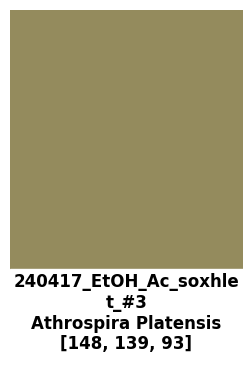

Whiteness Index: -105.36422548423884
Tint: -1.8142199776501542
240417_EtOH_Ac_soxhlet_#4,
 sRGB Color: [119, 116, 88]
XYZ Color: [ 15.6868461   17.22721635  11.75449792]
Lab Color: [ 48.54506243  -3.94595012  16.06030547]
Lightness: 48.54506242900051, Chroma: 16.537954351652957
ΔC (Chroma Difference from BaSO4 white standard): 24.29344477246553
ΔE (Color Difference from BaSO4 white standard): 56.70255372749934
Decolouring: 21%
White distance: 57%


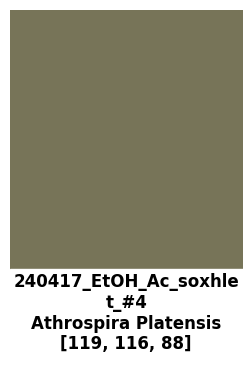

Whiteness Index: 93.34450754542362
Tint: 12.741470947669434
240417_EtOH_macerate,
 sRGB Color: [104, 117, 131]
XYZ Color: [ 16.34988243  17.48588176  24.1564936 ]
Lab Color: [ 48.86650542  -1.52054921  -9.22779141]
Lightness: 48.866505423905735, Chroma: 9.352229902670931
ΔC (Chroma Difference from BaSO4 white standard): 2.044216775176322
ΔE (Color Difference from BaSO4 white standard): 50.95441228814048
Decolouring: 27%
White distance: 53%


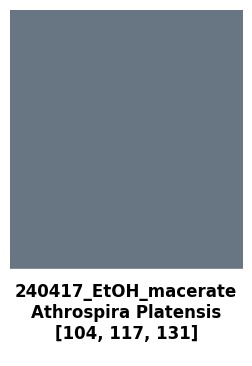

Whiteness Index: -3.177844606982106
Tint: 13.862671555015199
240417_EtOH_soxhlet_#1,
 sRGB Color: [89, 98, 92]
XYZ Color: [ 10.51324687  11.71474824  11.94532419]
Lab Color: [ 40.75911856  -4.6364211    2.12372748]
Lightness: 40.75911856470089, Chroma: 5.0996685189250375
ΔC (Chroma Difference from BaSO4 white standard): 11.063768525771277
ΔE (Color Difference from BaSO4 white standard): 60.048806046802405
Decolouring: 14%
White distance: 63%


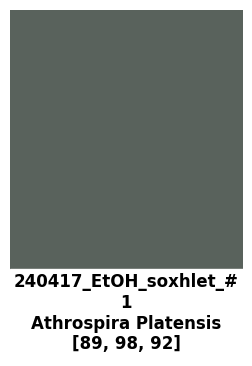

Whiteness Index: 16.405850781890198
Tint: 13.842800776073918
240417_EtOH_soxhlet_#2,
 sRGB Color: [87, 96, 94]
XYZ Color: [ 10.1910288   11.27089898  12.30599067]
Lab Color: [ 40.03303868  -3.98430695  -0.08212729]
Lightness: 40.03303867753163, Chroma: 3.9851532941831755
ΔC (Chroma Difference from BaSO4 white standard): 8.795529631518123
ΔE (Color Difference from BaSO4 white standard): 60.39079619910795
Decolouring: 13%
White distance: 63%


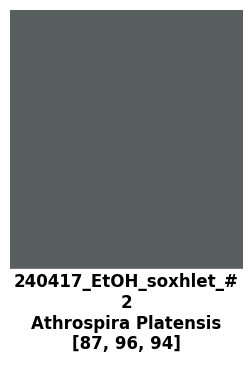

Whiteness Index: -10.965117893085372
Tint: 9.61842546317408
240417_EtOH_soxhlet_#3,
 sRGB Color: [81, 86, 80]
XYZ Color: [ 8.26644749  9.09184825  9.10220458]
Lab Color: [ 36.16053638  -3.30001748   2.48825306]
Lightness: 36.16053637965213, Chroma: 4.132979390865693
ΔC (Chroma Difference from BaSO4 white standard): 10.91533333258458
ΔE (Color Difference from BaSO4 white standard): 64.54895337720795
Decolouring: 8%
White distance: 67%


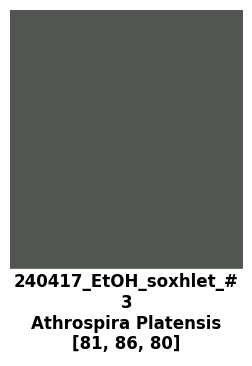

Whiteness Index: 0.22475994946592692
Tint: -1.6781991253949773
240417_MeOH_macerate,
 sRGB Color: [178, 176, 160]
XYZ Color: [ 40.53841883  43.27117435  39.86278489]
Lab Color: [ 71.73863694  -1.81382672   8.20779655]
Lightness: 71.73863694202865, Chroma: 8.405824863833727
ΔC (Chroma Difference from BaSO4 white standard): 16.21813914659171
ΔE (Color Difference from BaSO4 white standard): 32.39352142187872
Decolouring: 55%
White distance: 32%


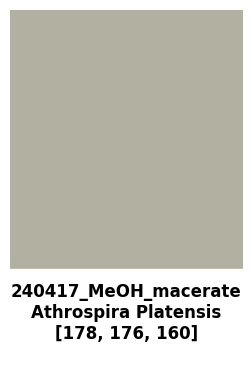

Whiteness Index: -38.431765852275745
Tint: 3.5833091265161308
240417_MeOH_soxhlet_#1,
 sRGB Color: [73, 74, 66]
XYZ Color: [ 6.30989356  6.8618068   6.27820761]
Lab Color: [ 31.4902167   -2.24195021   4.6190531 ]
Lightness: 31.49021669743677, Chroma: 5.134393080483269
ΔC (Chroma Difference from BaSO4 white standard): 12.729135904713653
ΔE (Color Difference from BaSO4 white standard): 69.46589925390582
Decolouring: 2%
White distance: 71%


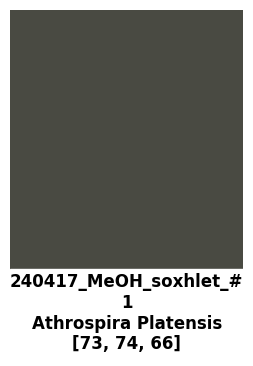

Whiteness Index: -57.998877264968684
Tint: -0.3719909306418465
240417_MeOH_soxhlet_#2,
 sRGB Color: [67, 67, 57]
XYZ Color: [ 5.154975    5.57015254  4.76470147]
Lab Color: [ 28.30101588  -1.68857482   5.90771066]
Lightness: 28.301015883382618, Chroma: 6.1442924874265765
ΔC (Chroma Difference from BaSO4 white standard): 13.91947504766936
ΔE (Color Difference from BaSO4 white standard): 72.82157678491397
Decolouring: -1%
White distance: 74%


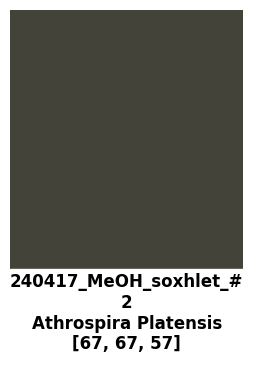

Whiteness Index: -61.44711319711817
Tint: 2.2146525319269514
240417_MeOH_soxhlet_#3,
 sRGB Color: [71, 72, 61]
XYZ Color: [ 5.84402907  6.37881911  5.37630735]
Lab Color: [ 30.34875627  -2.43230198   6.54347284]
Lightness: 30.348756265707657, Chroma: 6.980911811823788
ΔC (Chroma Difference from BaSO4 white standard): 14.657380972254426
ΔE (Color Difference from BaSO4 white standard): 70.96141162709455
Decolouring: 0%
White distance: 73%


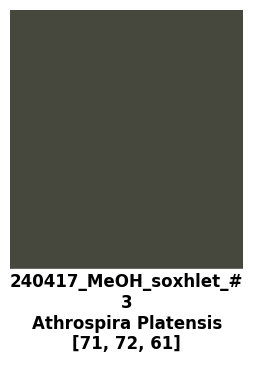

Whiteness Index: -65.51082065630128
Tint: 43.70766684109257
240514_biomass_baseline,
 sRGB Color: [58, 79, 63]
XYZ Color: [ 5.54181484  6.97199701  5.85770103]
Lab Color: [ 31.74307492 -11.90450177   6.81996786]
Lightness: 31.7430749208076, Chroma: 13.719661949341676
ΔC (Chroma Difference from BaSO4 white standard): 18.958240700309663
ΔE (Color Difference from BaSO4 white standard): 70.62877510045622
Decolouring: 0%
White distance: 73%


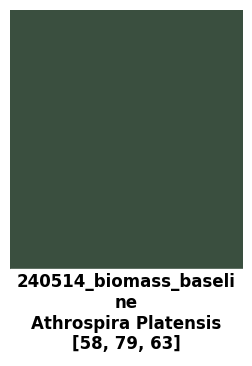

Whiteness Index: -84.50607791748914
Tint: -19.150619925654734
240514_EtOH-NaOH_10.1_MeOH_clean,
 sRGB Color: [182, 163, 127]
XYZ Color: [ 36.3432165   37.8314606   25.56398526]
Lab Color: [ 67.89621324   1.28966828  21.27495614]
Lightness: 67.8962132402435, Chroma: 21.314009550962442
ΔC (Chroma Difference from BaSO4 white standard): 29.206152312996082
ΔE (Color Difference from BaSO4 white standard): 43.238507607507806
Decolouring: 48%
White distance: 38%


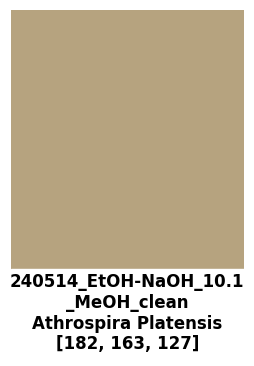

Whiteness Index: -24.169096325800048
Tint: 5.901661970239588
240514_powderised_MeOH_soxhlet,
 sRGB Color: [81, 83, 76]
XYZ Color: [ 7.90588326  8.62504221  8.25375979]
Lab Color: [ 35.25210795  -2.65325754   3.72804602]
Lightness: 35.252107947575546, Chroma: 4.575817161506268
ΔC (Chroma Difference from BaSO4 white standard): 11.939520823414762
ΔE (Color Difference from BaSO4 white standard): 65.62307177902214
Decolouring: 7%
White distance: 68%


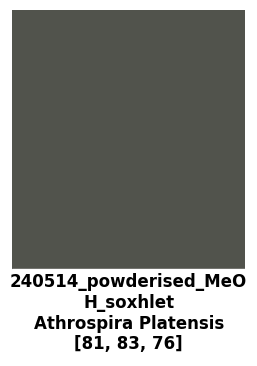

Whiteness Index: -36.476695532980706
Tint: 2.6935442491897508
240701_EtOH.Ac_5x1h_1400,
 sRGB Color: [119, 120, 106]
XYZ Color: [ 16.99700063  18.49490788  16.33885562]
Lab Color: [ 50.09095795  -3.17702862   7.67758899]
Lightness: 50.09095794982365, Chroma: 8.30896404638046
ΔC (Chroma Difference from BaSO4 white standard): 15.910034388694418
ΔE (Color Difference from BaSO4 white standard): 52.17393725789093
Decolouring: 25%
White distance: 54%


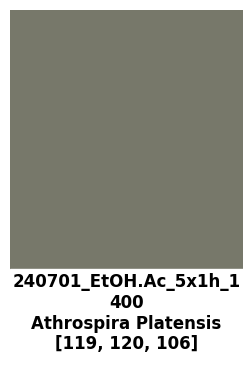

Whiteness Index: -69.5592327319363
Tint: -12.45426029392953
240701_EtOH.Ac_5x24h_1400,
 sRGB Color: [212, 197, 151]
XYZ Color: [ 53.18577706  56.58958089  37.81019766]
Lab Color: [ 79.94819632  -1.54391538  24.86115168]
Lightness: 79.94819631548535, Chroma: 24.90904529330525
ΔC (Chroma Difference from BaSO4 white standard): 32.80362763841873
ΔE (Color Difference from BaSO4 white standard): 38.33241822162786
Decolouring: 64%
White distance: 26%


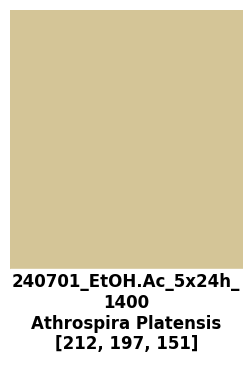

Whiteness Index: 54.10930454504319
Tint: 8.169014549153047
240701_EtOH_5x1h_1400,
 sRGB Color: [89, 95, 101]
XYZ Color: [ 10.68775721  11.39990914  14.1249016 ]
Lab Color: [ 40.24601856  -1.10405405  -4.26162706]
Lightness: 40.24601855654068, Chroma: 4.402317632653169
ΔC (Chroma Difference from BaSO4 white standard): 3.8173718574731526
ΔE (Color Difference from BaSO4 white standard): 59.65613845725128
Decolouring: 15%
White distance: 62%


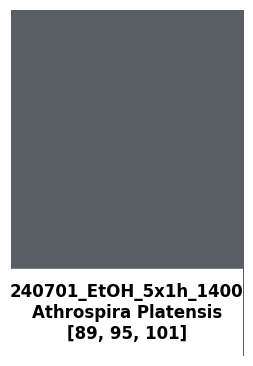

Whiteness Index: -55.53454023890837
Tint: -6.432975121186512
240701_EtOH_5x24h_1400,
 sRGB Color: [171, 164, 135]
XYZ Color: [ 34.79074908  37.26291651  28.49862663]
Lab Color: [ 67.47381651  -2.13250755  15.99569424]
Lightness: 67.4738165133673, Chroma: 16.137218549482885
ΔC (Chroma Difference from BaSO4 white standard): 23.998337038512837
ΔE (Color Difference from BaSO4 white standard): 40.2442906885814
Decolouring: 48%
White distance: 38%


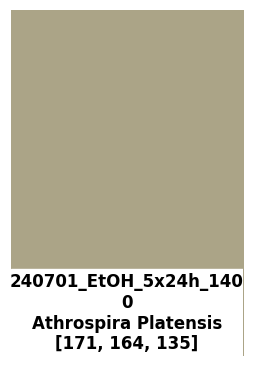

Whiteness Index: -56.9675434596194
Tint: -2.3024840355277476
240701_EtOH_5x24_EtOH_10%_ChMeSO3,
 sRGB Color: [170, 166, 136]
XYZ Color: [ 35.03069118  38.04817739  28.90778826]
Lab Color: [ 68.05610759  -3.82201946  16.39033601]
Lightness: 68.05610758857311, Chroma: 16.83006081822659
ΔC (Chroma Difference from BaSO4 white standard): 24.599319928315513
ΔE (Color Difference from BaSO4 white standard): 40.143807406302784
Decolouring: 48%
White distance: 38%


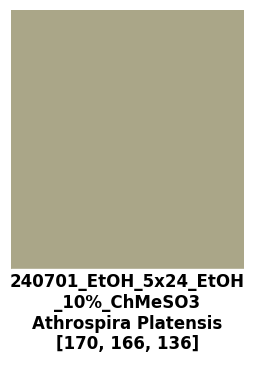

Whiteness Index: -56.657652101274024
Tint: -2.3536376858151407
240701_EtOH_5x24_EtOH_12..5%_ChMeSO3,
 sRGB Color: [178, 174, 141]
XYZ Color: [ 38.66586737  42.04441876  31.49426682]
Lab Color: [ 70.9015335   -4.09231026  17.5717504 ]
Lightness: 70.90153349527408, Chroma: 18.041990341692134
ΔC (Chroma Difference from BaSO4 white standard): 25.808638876951576
ΔE (Color Difference from BaSO4 white standard): 38.73042272307699
Decolouring: 52%
White distance: 35%


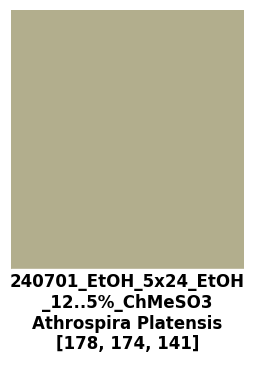

Whiteness Index: -52.241931733294756
Tint: -2.4206575848791942
240701_EtOH_5x24_EtOH_15%_ChMeSO3,
 sRGB Color: [179, 175, 143]
XYZ Color: [ 38.9520152   42.28394188  32.18453049]
Lab Color: [ 71.06624441  -3.89059245  16.89646737]
Lightness: 71.06624440622603, Chroma: 17.338607762020402
ΔC (Chroma Difference from BaSO4 white standard): 25.109944506958122
ΔE (Color Difference from BaSO4 white standard): 38.14424050578231
Decolouring: 52%
White distance: 34%


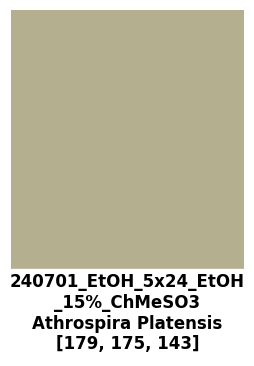

Whiteness Index: -51.44556213705544
Tint: -4.938787948201934
240701_EtOH_5x24_EtOH_5%_ChMeSO3,
 sRGB Color: [179, 172, 142]
XYZ Color: [ 38.54426614  41.48228106  31.73141574]
Lab Color: [ 70.5125007   -2.80423325  16.56986924]
Lightness: 70.51250070358734, Chroma: 16.805483953415145
ΔC (Chroma Difference from BaSO4 white standard): 24.638625760878128
ΔE (Color Difference from BaSO4 white standard): 38.257578193877464
Decolouring: 52%
White distance: 35%


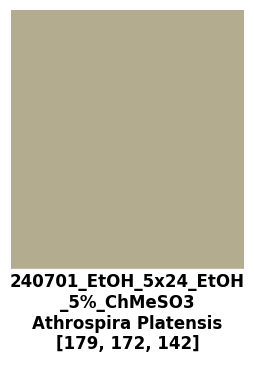

Whiteness Index: -65.81004505225806
Tint: -4.781385521074348
240701_EtOH_5x24_EtOH_7.5%_ChMeSO3,
 sRGB Color: [177, 170, 136]
XYZ Color: [ 37.16985426  40.21194091  29.24310152]
Lab Color: [ 69.62021903  -3.41048282  18.59201634]
Lightness: 69.6202190265495, Chroma: 18.902234379216445
ΔC (Chroma Difference from BaSO4 white standard): 26.71974746541865
ΔE (Color Difference from BaSO4 white standard): 40.29331212078277
Decolouring: 50%
White distance: 36%


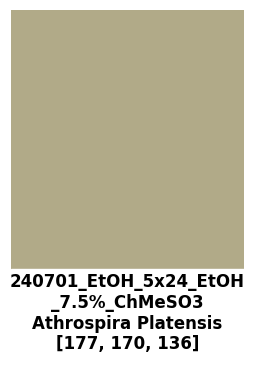

Whiteness Index: -85.5844249522329
Tint: -7.261432194986625
240701_EtOH_5x24_MeOH_12.5%_ChMeSO3,
 sRGB Color: [174, 165, 127]
XYZ Color: [ 34.97105917  37.77114437  25.60764286]
Lab Color: [ 67.85160315  -3.1440663   21.12785053]
Lightness: 67.85160314842132, Chroma: 21.36050609853594
ΔC (Chroma Difference from BaSO4 white standard): 29.205990836701105
ΔE (Color Difference from BaSO4 white standard): 43.27130418663925
Decolouring: 47%
White distance: 38%


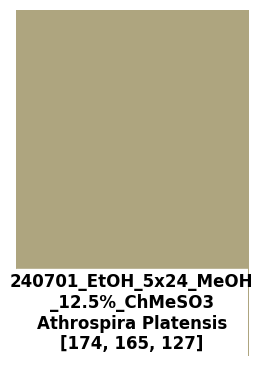

Whiteness Index: -54.737496529837095
Tint: -6.005558737878076
240701_EtOH_5x24_MeOH_50%_ChMeSO3,
 sRGB Color: [178, 171, 140]
XYZ Color: [ 37.88878297  40.67542219  30.80342722]
Lab Color: [ 69.94791501  -2.48062063  16.90178682]
Lightness: 69.94791501012206, Chroma: 17.08285328843788
ΔC (Chroma Difference from BaSO4 white standard): 24.93360018156824
ΔE (Color Difference from BaSO4 white standard): 38.87970537305485
Decolouring: 51%
White distance: 35%


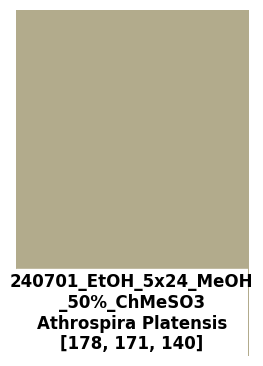

Whiteness Index: -35.089555513337174
Tint: -5.416750241563708
240701_EtOH_5x24_MeOH_6.25%_ChMeSO3,
 sRGB Color: [164, 158, 137]
XYZ Color: [ 32.09283886  34.18169476  28.58205853]
Lab Color: [ 65.10653594  -1.42389812  11.78946122]
Lightness: 65.10653594316162, Chroma: 11.875137122746231
ΔC (Chroma Difference from BaSO4 white standard): 19.747942107483684
ΔE (Color Difference from BaSO4 white standard): 39.902670265380316
Decolouring: 45%
White distance: 39%


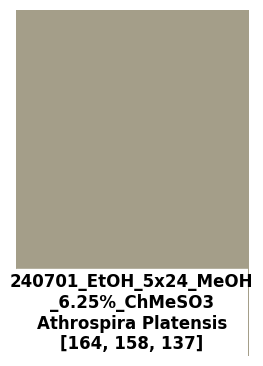

Whiteness Index: -67.78924229430484
Tint: -2.252156011101647
240701_MeOH_48h_soxhlet,
 sRGB Color: [82, 80, 67]
XYZ Color: [ 7.49260952  8.0831135   6.60229185]
Lab Color: [ 34.15538266  -1.79739626   7.90699662]
Lightness: 34.15538265534931, Chroma: 8.108713142852165
ΔC (Chroma Difference from BaSO4 white standard): 15.91743998502971
ΔE (Color Difference from BaSO4 white standard): 67.52733970788832
Decolouring: 5%
White distance: 69%


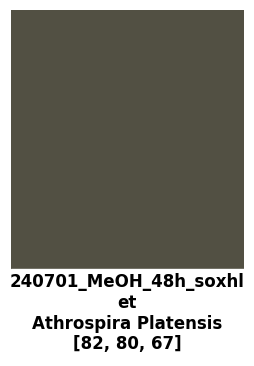

Whiteness Index: 31.18718696185896
Tint: 9.441804974781594
240701_MeOH_5x1h_1400,
 sRGB Color: [96, 103, 104]
XYZ Color: [ 12.19623666  13.20777208  15.06053089]
Lab Color: [ 43.07465281  -2.43819723  -1.57237016]
Lightness: 43.07465281013813, Chroma: 2.9012331201348025
ΔC (Chroma Difference from BaSO4 white standard): 6.798716333103741
ΔE (Color Difference from BaSO4 white standard): 57.111357145284515
Decolouring: 18%
White distance: 60%


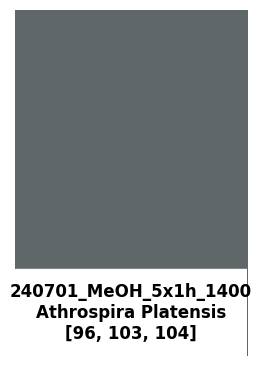

Whiteness Index: -57.23709276085672
Tint: 0.6995773361881383
240701_MeOH_5x24h_1400,
 sRGB Color: [178, 177, 142]
XYZ Color: [ 39.38666755  43.27418794  32.23833137]
Lab Color: [ 71.74067373  -5.42129856  17.98508725]
Lightness: 71.74067372716041, Chroma: 18.784404210478897
ΔC (Chroma Difference from BaSO4 white standard): 26.458648098945233
ΔE (Color Difference from BaSO4 white standard): 38.55201717246438
Decolouring: 53%
White distance: 34%


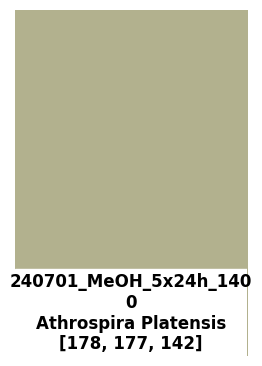

Whiteness Index: -64.15703733624474
Tint: 3.43789684731194
240701_MeOH_5x24_MeOH_12.5%_ChMeSO3,
 sRGB Color: [170, 172, 136]
XYZ Color: [ 36.02627788  39.97819539  29.41029044]
Lab Color: [ 69.4539977   -6.48294937  18.05999962]
Lightness: 69.45399769637467, Chroma: 19.1883354859717
ΔC (Chroma Difference from BaSO4 white standard): 26.770546755080808
ΔE (Color Difference from BaSO4 white standard): 40.451480359713095
Decolouring: 49%
White distance: 37%


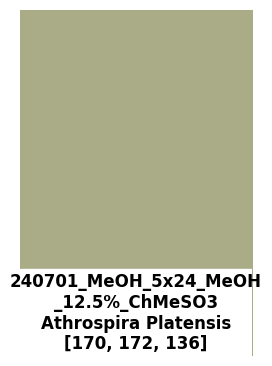

Whiteness Index: 138.2759711229244
Tint: 3.964595581219996
240712_BaSO4_direct,
 sRGB Color: [246, 254, 255]
XYZ Color: [  94.52685067   99.4318441   121.66656241]
Lab Color: [  9.97798957e+01   3.74284143e-02  -7.90433837e+00]
Lightness: 99.77989568091452, Chroma: 7.904426986560228
ΔC (Chroma Difference from BaSO4 white standard): 2.037488145095546e-09
ΔE (Color Difference from BaSO4 white standard): 1.9193925183211938e-08
Decolouring: 98%
White distance: 1%


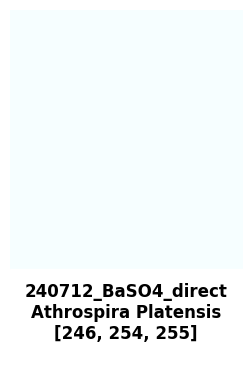

Whiteness Index: -114.79942200034567
Tint: -12.937819925293269
240712_EtOH.Ac_5x2h_1400,
 sRGB Color: [147, 136, 100]
XYZ Color: [ 23.37572787  24.95646759  15.75885633]
Lab Color: [ 57.03298093  -1.53051718  20.91926502]
Lightness: 57.03298093024385, Chroma: 20.975178947633854
ΔC (Chroma Difference from BaSO4 white standard): 28.866218420011656
ΔE (Color Difference from BaSO4 white standard): 51.58059022737736
Decolouring: 32%
White distance: 49%


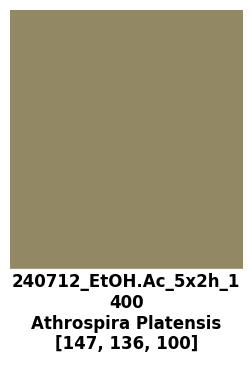

Whiteness Index: -106.07414427875145
Tint: -12.494239990277059
240712_EtOH.Ac_5x2h_1400_2,
 sRGB Color: [161, 149, 111]
XYZ Color: [ 28.47803612  30.409403    19.47183159]
Lab Color: [ 62.00587043  -1.65524685  21.82106412]
Lightness: 62.00587042606351, Chroma: 21.88375382584034
ΔC (Chroma Difference from BaSO4 white standard): 29.773557107032666
ΔE (Color Difference from BaSO4 white standard): 48.09721081519934
Decolouring: 39%
White distance: 44%


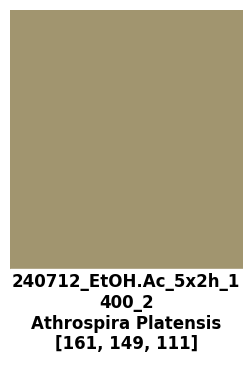

Whiteness Index: -14.749396695495195
Tint: 5.8396607643050675
240712_EtOH_5x2h_1400,
 sRGB Color: [107, 111, 103]
XYZ Color: [ 14.38095173  15.67172012  15.1228177 ]
Lab Color: [ 46.54081621  -3.13915372   4.26138896]
Lightness: 46.540816212793935, Chroma: 5.2927990677650465
ΔC (Chroma Difference from BaSO4 white standard): 12.573607101668218
ΔE (Color Difference from BaSO4 white standard): 54.7037035326875
Decolouring: 21%
White distance: 57%


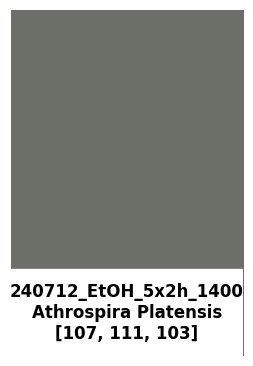

Whiteness Index: -29.026697651408043
Tint: 9.206517434734428
240712_MeOH_5x2h_1400,
 sRGB Color: [122, 129, 114]
XYZ Color: [ 19.09811596  21.20579185  19.08859763]
Lab Color: [ 53.17398902  -5.3063573    7.33776723]
Lightness: 53.17398901585712, Chroma: 9.055399256661333
ΔC (Chroma Difference from BaSO4 white standard): 16.151712876287185
ΔE (Color Difference from BaSO4 white standard): 49.32533189639026
Decolouring: 29%
White distance: 52%


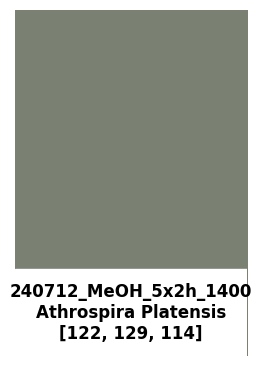

Whiteness Index: 74.96441741419459
Tint: 12.314803858678307
240730_ChCl1M_1x20m_EtOH_5x24h_1400_RT,
 sRGB Color: [152, 167, 175]
XYZ Color: [ 34.8726927   37.86808558  46.03210329]
Lab Color: [ 67.92327807  -3.78925322  -5.39983357]
Lightness: 67.92327806799865, Chroma: 6.596714528113059
ΔC (Chroma Difference from BaSO4 white standard): 4.573405361505335
ΔE (Color Difference from BaSO4 white standard): 32.18322736383324
Decolouring: 52%
White distance: 35%


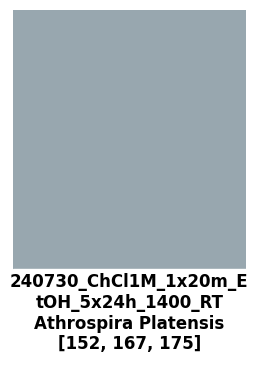

In [16]:
X = 21  # Maximum number of characters to fit the width of the color square

# Function to insert a break line at the character limit X
def insert_break_line(text, limit):
    if len(text) > limit:
        return text[:limit] + '\n' + text[limit:]
    return text

def calculate_delta_E(Lab_sample, Lab_reference):
    """
    Calculates the total color difference (ΔE) between a sample color and a reference color in the Lab color space.
    
    Parameters:
    - Lab_sample: tuple or list of (L*, a*, b*) values of the sample color in the Lab color space.
    - Lab_reference: tuple or list of (L*, a*, b*) values of the reference color in the Lab color space.
    
    Returns:
    - delta_E: The color difference between the sample and reference.
    """
    L_sample, a_sample, b_sample = Lab_sample
    L_reference, a_reference, b_reference = Lab_reference
    
    # Calculate the Euclidean distance (CIE76 ΔE formula)
    delta_E = np.sqrt((L_sample - L_reference)**2 + (a_sample - a_reference)**2 + (b_sample - b_reference)**2)
    
    return delta_E


def calculate_delta_C(Lab_sample, Lab_reference):
    """
    Calculates the total color difference (ΔE) between a sample color and a reference color in the Lab color space.
    
    Parameters:
    - Lab_sample: tuple or list of (L*, a*, b*) values of the sample color in the Lab color space.
    - Lab_reference: tuple or list of (L*, a*, b*) values of the reference color in the Lab color space.
    
    Returns:
    - delta_E: The color difference between the sample and reference.
    """
    L_sample, a_sample, b_sample = Lab_sample
    L_reference, a_reference, b_reference = Lab_reference
    
    # Calculate the Euclidean distance (CIE76 ΔE formula)
    delta_C = np.sqrt((a_sample - a_reference)**2 + (b_sample - b_reference)**2)
    
    return delta_C

def calculate_lightness_chroma(Lab_color):
    """
    Calculates the Lightness (L*) and Chroma (C*) from a Lab color value.
    
    Parameters:
    - Lab_color: tuple or list of (L*, a*, b*) values of the color in the Lab color space.
    
    Returns:
    - lightness: L* value (Lightness).
    - chroma: C* value (Chroma).
    """
    L, a, b = Lab_color
    
    # Lightness is just the L* value in Lab space
    lightness = L
    
    # Chroma is calculated as the Euclidean distance in the a* and b* plane
    chroma = np.sqrt(a**2 + b**2)
    
    return lightness, chroma
colourimetry_dict = {}

for key in data_dict.keys():
    data = data_dict[key]
    # Initialize empty lists to hold the limited data
    data1_limited = []
    data2_limited = []

    # Loop through each tuple in data and limit to 10 values
    for i in range(len(data[0])):
        data1_limited.append(data[0][i])
        data2_limited.append(data[1][i])

    # UV-Vis spectrum data (example)
    wavelengths = data1_limited
    absorbances = data2_limited

    # Filter and sort data for valid wavelengths
    sorted_data = sorted(
        [
            [wavelength, absorbance]
            for wavelength, absorbance in zip(wavelengths, absorbances)
            if wavelength % 1 == 0 and 360 <= wavelength <= 800
        ],
        key=lambda x: x[0]  # Sort by wavelength
    )

    # Separate sorted data into wavelengths and absorbances
    sorted_wavelengths = [data[0] for data in sorted_data]
    sorted_absorbances = [data[1] for data in sorted_data]
    spectrum = sorted_data
    rgb_color, Lab_color, xyz_color = uv_to_srgb(spectrum, absorbance=True, illuminant=colour.SDS_ILLUMINANTS['D75'])
    whiteness_index, tint = tristimulus_to_whiteness_tint(xyz_color)
    lightness, chroma = calculate_lightness_chroma(Lab_color)
    delta_E = calculate_delta_E(Lab_color, [9.97798957e+01, 3.74284143e-02, -7.90433837e+00])
    delta_C = calculate_delta_C(Lab_color, [9.97798957e+01, 3.74284143e-02, -7.90433837e+00])
    
    print(f"Whiteness Index: {whiteness_index}")
    print(f"Tint: {tint}")
    print(f"{key},\n sRGB Color: {[int(colour) for colour in rgb_color*255]}")
    print(f"XYZ Color: {xyz_color}")
    print(f"Lab Color: {Lab_color}")
    print(f"Lightness: {lightness}, Chroma: {chroma}")
    print(f"ΔC (Chroma Difference from BaSO4 white standard): {delta_C}")
    print(f"ΔE (Color Difference from BaSO4 white standard): {delta_E}")
    decolouring_percent = (rgb_color[0] + rgb_color[1] + rgb_color[2]-68/255-77/255-55/255)/(3-68/255-77/255-55/255)
    white_distance = 1-(rgb_color[0] + rgb_color[1] + rgb_color[2])/3
    decolouring_percent = int(decolouring_percent * 100)
    white_distance = int(white_distance * 100)
    print(f"Decolouring: {decolouring_percent}%")
    print(f"White distance: {white_distance}%")

    
    # Define color information
    color = {
        "name": insert_break_line(f"{key}", X),
        "code": f"{key}",
        "rgb": [int(colour) for colour in rgb_color*255]
    }

    import matplotlib.pyplot as plt
    import numpy as np

    # Create the plot
    fig, ax = plt.subplots(figsize=(3, 4.5))
    
    # Main color swatch
    ax.imshow([[color["rgb"]]], aspect='auto')
    
    # Bottom overlay bar
    ax.add_patch(plt.Rectangle((0, 0), 1, 0.25, transform=ax.transAxes, color='white'))
    ax.text(0.5, 0.125, f"{color['name']}\nAthrospira Platensis\n{color['rgb']}",
            transform=ax.transAxes, ha='center', va='center', color='black', fontsize=12, weight='bold')
    
    # Remove axes
    ax.axis('off')
    
    # Save the plot to a file
    plt.savefig(f"{key}.png", bbox_inches='tight', pad_inches=0)
    
    # Show the plot (optional)
    plt.show()

    # Close the plot to avoid overlap in the next iteration
    plt.close()
    
    if key not in colourimetry_dict:
        colourimetry_dict[key] = {
            "Whiteness Index": whiteness_index,
            "Tint": tint,
            "sRGB Color": rgb_color,
            "RGB Color": [int(colour * 255) for colour in rgb_color],
            "XYZ Color": xyz_color,
            "Lab Color": Lab_color,
            "Lightness": lightness,
            "Chroma": chroma,
            "White Distance": delta_E, #ΔE (Color Difference from BaSO4 white standard)
            "Chroma Distance": delta_C, #ΔC (Chroma Difference from BaSO4 white standard)
            "Decolouring Percentage": int((rgb_color[0] + rgb_color[1] + rgb_color[2] - 68/255 - 77/255 - 55/255) / (3 - 68/255 - 77/255 - 55/255) * 100)
        }

In [17]:
import csv

# Create a CSV file
with open('colourimetry_results.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Key", "RGB Color", "Lab Color"])  # Writing headers
    
    # Loop through each sample in the dictionary
    for key, value in colourimetry_dict.items():
        rgb_color = value["RGB Color"]
        lab_color = value["Lab Color"]
        
        # Write the row for the current sample
        writer.writerow([key, rgb_color, lab_color])

print("CSV file has been created.")

CSV file has been created.


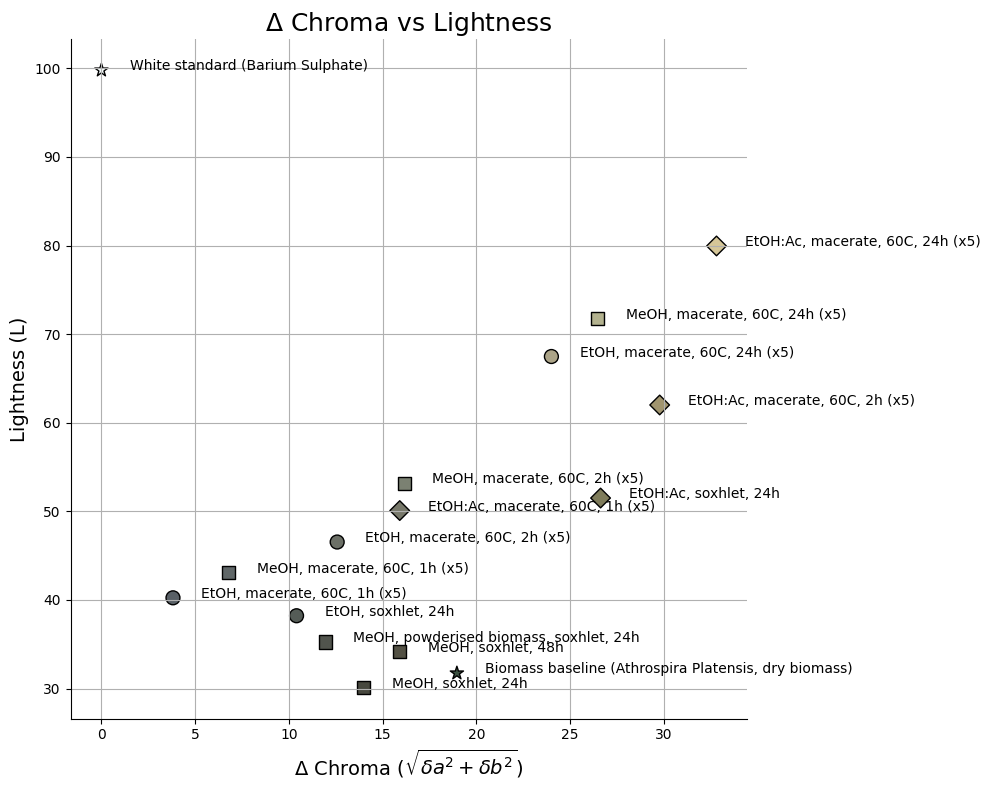

In [80]:
label_keys = {
'240514_biomass_baseline': 'Biomass baseline (Athrospira Platensis, dry biomass)',
'240417_EtOH_Ac_soxhlet': 'EtOH:Ac, soxhlet, 24h',
'240417_EtOH_soxhlet': 'EtOH, soxhlet, 24h',
'240417_MeOH_soxhlet': 'MeOH, soxhlet, 24h',
'240514_powderised_MeOH_soxhlet': 'MeOH, powderised biomass, soxhlet, 24h',
'240701_MeOH_48h_soxhlet': 'MeOH, soxhlet, 48h',
'240417_EtOH_macerate': 'EtOH, macerate, RT, weeks',
'240417_MeOH_macerate': 'MeOH, macerate, RT, weeks',
'240514_EtOH-NaOH_10.1_MeOH_clean': 'EtOH, NaOH, macerate, 24h (x5)',
'240701_EtOH.Ac_5x1h_1400': 'EtOH:Ac, macerate, 60C, 1h (x5)',
'240712_EtOH.Ac_5x2h_1400': 'EtOH:Ac, macerate, 60C, 2h (x5)',
'240712_EtOH.Ac_5x2h_1400_2': 'EtOH:Ac, macerate, 60C, 2h (x5)',
'240701_EtOH.Ac_5x24h_1400': 'EtOH:Ac, macerate, 60C, 24h (x5)',
'240701_EtOH_5x1h_1400': 'EtOH, macerate, 60C, 1h (x5)',
'240712_EtOH_5x2h_1400': 'EtOH, macerate, 60C, 2h (x5)',
'240701_EtOH_5x24h_1400': 'EtOH, macerate, 60C, 24h (x5)',
'240701_MeOH_5x1h_1400': 'MeOH, macerate, 60C, 1h (x5)',
'240712_MeOH_5x2h_1400': 'MeOH, macerate, 60C, 2h (x5)',
'240701_MeOH_5x24h_1400': 'MeOH, macerate, 60C, 24h (x5)',
'240701_MeOH_5x24_MeOH_12.5%_ChMeSO3': 'MeOH, ChMeSO3(12.5%), macerate, 60C, 24h (x5)',
'240712_BaSO4_direct': 'White standard (Barium Sulphate)',
'240730_ChCl1M_1x20m_EtOH_5x24h_1400_RT': None,
'240701_EtOH_5x24_EtOH_10%_ChMeSO3': 'EtOH, ChMeSO3(10%), macerate, 60C, 24h (x5)',
'240701_EtOH_5x24_EtOH_12..5%_ChMeSO3': 'EtOH, ChMeSO3(12.5%), macerate, 60C, 24h (x5)',
'240701_EtOH_5x24_EtOH_15%_ChMeSO3': 'EtOH, ChMeSO3(15%), macerate, 60C, 24h (x5)',
'240701_EtOH_5x24_EtOH_5%_ChMeSO3': 'EtOH, ChMeSO3(5%), macerate, 60C, 24h (x5)',
'240701_EtOH_5x24_EtOH_7.5%_ChMeSO3': 'EtOH, ChMeSO3(7.5%), macerate, 60C, 24h (x5)',
'240701_EtOH_5x24_MeOH_12.5%_ChMeSO3': 'MeOH, ChMeSO3(12.5%), macerate, 60C, 24h (x5)',
'240701_EtOH_5x24_MeOH_50%_ChMeSO3': 'MeOH, ChMeSO3(50%), macerate, 60C, 24h (x5)',
'240701_EtOH_5x24_MeOH_6.25%_ChMeSO3': 'MeOH, ChMeSO3(6.25%), macerate, 60C, 24h (x5)'
}
        
# Prepare lists to store Lightness, White Distance, and sRGB color values
lightness_values = []
white_distance_values = []
rgb_colors = []
key_values = []
Ac_lightness_values = []
Ac_white_distance_values = []
Ac_rgb_colors = []
Ac_key_values = []
Et_lightness_values = []
Et_white_distance_values = []
Et_rgb_colors = []
Et_key_values = []
Me_lightness_values = []
Me_white_distance_values = []
Me_rgb_colors = []
Me_key_values = []


# Extract Lightness, White Distance, and sRGB from eachsample in the dictionary
for key, sample in colourimetry_dict.items():
    if not('240514_EtOH-NaOH_10.1_MeOH_clean' == key) and not('240712_EtOH.Ac_5x2h_1400' == key) and not('240417_EtOH_macerate' == key) and not('240417_MeOH_macerate' == key) and 'ChMeSO3' not in key and '240417_MeOH_macerate' not in key and '240417_EtOH_macerate' not in key and 'ChCl' not in key:
        rgb_colors_normalized = tuple(sample["sRGB Color"])
        if 'Ac' in key:
            Ac_key_values.append(key)
            Ac_lightness_values.append(sample["Lightness"])
            Ac_white_distance_values.append(sample["Chroma Distance"])
            Ac_rgb_colors.append(rgb_colors_normalized)
        elif 'EtOH' in key:
            Et_key_values.append(key)
            Et_lightness_values.append(sample["Lightness"])
            Et_white_distance_values.append(sample["Chroma Distance"])
            Et_rgb_colors.append(rgb_colors_normalized)
        elif 'MeOH' in key:
            Me_key_values.append(key)
            Me_lightness_values.append(sample["Lightness"])
            Me_white_distance_values.append(sample["Chroma Distance"])
            Me_rgb_colors.append(rgb_colors_normalized)
        else:
            key_values.append(key)
            lightness_values.append(sample["Lightness"])
            white_distance_values.append(sample["Chroma Distance"])
            rgb_colors.append(rgb_colors_normalized)

# Create the plot
plt.figure(figsize=(10, 8))

# Use 'color' instead of 'c' to avoid the warning
scatter = plt.scatter(Et_white_distance_values, Et_lightness_values, marker='o', s=100, color=Et_rgb_colors, edgecolors='black')
scatter = plt.scatter(Me_white_distance_values, Me_lightness_values, marker='s', s=90, color=Me_rgb_colors, edgecolors='black')
scatter = plt.scatter(Ac_white_distance_values, Ac_lightness_values, marker='D', s=100, color=Ac_rgb_colors, edgecolors='black')
scatter = plt.scatter(white_distance_values, lightness_values, marker='*', s=100, color=rgb_colors, edgecolors='black')

# Labeling the plot
plt.title('$\Delta$ Chroma vs Lightness', fontsize=18)
plt.ylabel('Lightness (L)', fontsize=14)
plt.xlabel('$\Delta$ Chroma $(\sqrt{\delta a^2 + \delta b^2}$)', fontsize=14)
plt.grid(True)

# Optionally, add sample labels (key names) on the plot for clarity
for i, key in enumerate(Et_key_values):
    plt.text(Et_white_distance_values[i] + 1.5, Et_lightness_values[i], label_keys[key], fontsize=10)
for i, key in enumerate(Ac_key_values):
    plt.text(Ac_white_distance_values[i] + 1.5, Ac_lightness_values[i], label_keys[key], fontsize=10)
for i, key in enumerate(Me_key_values):
    plt.text(Me_white_distance_values[i] + 1.5, Me_lightness_values[i], label_keys[key], fontsize=10)
for i, key in enumerate(key_values):
    plt.text(white_distance_values[i] + 1.5, lightness_values[i], label_keys[key], fontsize=10)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Show the plot
plt.tight_layout()
plt.show()

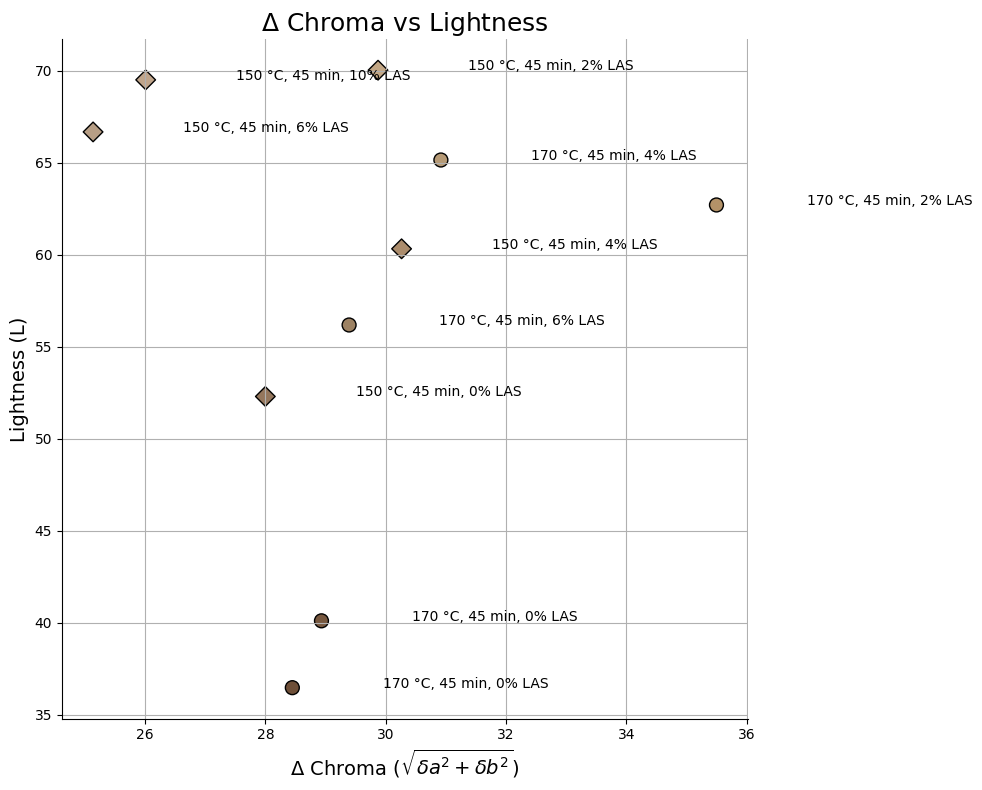

In [26]:
label_keys = {
    '240801_ISABEL_IF1_170C_45_0LAS': '170 °C, 45 min, 0% LAS',
    '240801_ISABEL_IF2_150C_45_2LAS': '150 °C, 45 min, 2% LAS',
    '240801_ISABEL_IF2_150C_45_4LAS': '150 °C, 45 min, 4% LAS',
    '240801_ISABEL_IF2_170C_45_2LAS': '170 °C, 45 min, 2% LAS',
    '240801_ISABEL_IF2_170C_45_4LAS': '170 °C, 45 min, 4% LAS',
    '240801_ISABEL_IF3_170C_45_0LAS': '170 °C, 45 min, 0% LAS',
    '240801_ISABEL_IF4_150C_45_10LAS': '150 °C, 45 min, 10% LAS',
    '240912_ISABEL_IF1_150C_45_0LAS': '150 °C, 45 min, 0% LAS',
    '240912_ISABEL_IF3_150C_45_6LAS': '150 °C, 45 min, 6% LAS',
    '240912_ISABEL_IF3_170C_45_6LAS': '170 °C, 45 min, 6% LAS'
}
        
# Prepare lists to store Lightness, White Distance, and sRGB color values
lightness_values = []
white_distance_values = []
rgb_colors = []
key_values = []
Ac_lightness_values = []
Ac_white_distance_values = []
Ac_rgb_colors = []
Ac_key_values = []
Et_lightness_values = []
Et_white_distance_values = []
Et_rgb_colors = []
Et_key_values = []
Me_lightness_values = []
Me_white_distance_values = []
Me_rgb_colors = []
Me_key_values = []
x_min = colourimetry_dict['240801_ISABEL_IF1_170C_45_0LAS']["Lab Color"][1]
x_max = colourimetry_dict['240801_ISABEL_IF1_170C_45_0LAS']["Lab Color"][1]
y_min = colourimetry_dict['240801_ISABEL_IF1_170C_45_0LAS']["Lab Color"][2]
y_max = colourimetry_dict['240801_ISABEL_IF1_170C_45_0LAS']["Lab Color"][2]


# Extract Lightness, White Distance, and sRGB from eachsample in the dictionary
for key, sample in colourimetry_dict.items():
    if not('240514_EtOH-NaOH_10.1_MeOH_clean' == key) and not('240712_EtOH.Ac_5x2h_1400' == key) and not('240417_EtOH_macerate' == key) and not('240417_MeOH_macerate' == key) and 'ChMeSO3' not in key and '240417_MeOH_macerate' not in key and '240417_EtOH_macerate' not in key and 'ChCl' not in key:
        rgb_colors_normalized = tuple(sample["sRGB Color"])
        if '150' in key:
            Ac_key_values.append(key)
            Ac_lightness_values.append(sample["Lightness"])
            Ac_white_distance_values.append(sample["Chroma Distance"])
            Ac_rgb_colors.append(rgb_colors_normalized)
        elif '170' in key:
            Et_key_values.append(key)
            Et_lightness_values.append(sample["Lightness"])
            Et_white_distance_values.append(sample["Chroma Distance"])
            Et_rgb_colors.append(rgb_colors_normalized)
        else:
            key_values.append(key)
            lightness_values.append(sample["Lightness"])
            white_distance_values.append(sample["Chroma Distance"])
            rgb_colors.append(rgb_colors_normalized)
        
        x_min = min(sample["Chroma Distance"], x_min)
        x_max = max(sample["Chroma Distance"], x_max)
        y_min = min(sample["Lightness"], y_min)
        y_max = max(sample["Lightness"], y_max)

# Create the plot
plt.figure(figsize=(10, 8))

# Use 'color' instead of 'c' to avoid the warning
scatter = plt.scatter(Et_white_distance_values, Et_lightness_values, marker='o', s=100, color=Et_rgb_colors, edgecolors='black')
scatter = plt.scatter(Me_white_distance_values, Me_lightness_values, marker='s', s=90, color=Me_rgb_colors, edgecolors='black')
scatter = plt.scatter(Ac_white_distance_values, Ac_lightness_values, marker='D', s=100, color=Ac_rgb_colors, edgecolors='black')
scatter = plt.scatter(white_distance_values, lightness_values, marker='*', s=100, color=rgb_colors, edgecolors='black')

# Labeling the plot
plt.title('$\Delta$ Chroma vs Lightness', fontsize=18)
plt.ylabel('Lightness (L)', fontsize=14)
plt.xlabel('$\Delta$ Chroma $(\sqrt{\delta a^2 + \delta b^2}$)', fontsize=14)
plt.grid(True)

# Optionally, add sample labels (key names) on the plot for clarity
for i, key in enumerate(Et_key_values):
    plt.text(Et_white_distance_values[i] + 1.5, Et_lightness_values[i], label_keys[key], fontsize=10)
for i, key in enumerate(Ac_key_values):
    plt.text(Ac_white_distance_values[i] + 1.5, Ac_lightness_values[i], label_keys[key], fontsize=10)
for i, key in enumerate(Me_key_values):
    plt.text(Me_white_distance_values[i] + 1.5, Me_lightness_values[i], label_keys[key], fontsize=10)
for i, key in enumerate(key_values):
    plt.text(white_distance_values[i] + 1.5, lightness_values[i], label_keys[key], fontsize=10)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Show the plot
plt.tight_layout()
plt.show()

In [40]:
import numpy as np
import matplotlib.pyplot as plt

def generate_gradient(param, x_range, y_range):
    """
    Generate a gradient based on the Y-axis parameter.
    - For Lightness: L values for a, b = 0
    - For a: a values for L = 100, b = 0
    - For b: b values for L = 100, a = 0
    """
    x = np.linspace(x_range[0], x_range[1], 300)  # Horizontal axis (e.g., LAS %)
    y = np.linspace(y_range[0], y_range[1], 300)  # Vertical axis (e.g., a, b)
    xx, yy = np.meshgrid(x, y)

    if param == "Lightness":
        gradient = 100 - np.sqrt(xx**2 + yy**2)  # Example: Decreasing Lightness with distance
    elif param == "a":
        gradient = yy  # Example: a value increases with y
    elif param == "b":
        gradient = yy  # Example: b value increases with y
    else:
        raise ValueError(f"Unknown parameter: {param}")

    gradient = np.clip(gradient, 0, 100)  # Clip to realistic values
    return gradient

def plot_param_with_gradient(data_150C, data_170C, param, ylabel, output_path, x_range, y_range):
    """
    Plot the parameter data with a gradient background.
    """
    plt.figure(figsize=(8, 6))

    # Generate gradient for background
    gradient = generate_gradient(param, x_range, y_range)

    if param == "a":
        gradient = np.rot90(gradient)  # Rotate 90 degrees for correct alignment

    plt.imshow(
        gradient, extent=(x_range[0], x_range[1], y_range[0], y_range[1]),
        origin='lower', aspect='auto', cmap='coolwarm', alpha=0.3
    )

    # Plot data for 150 °C
    plt.plot(
        data_150C["LAS %"], data_150C[param],
        marker='o', markersize=6, linestyle='-', linewidth=1.5,
        label='150 °C, 45 min', color='#0072B2'
    )

    # Plot data for 170 °C
    plt.plot(
        data_170C["LAS %"], data_170C[param],
        marker='s', markersize=6, linestyle='--', linewidth=1.5,
        label='170 °C, 45 min', color='#D55E00'
    )

    # Set dynamic y-limits based on data
    y_min, y_max = min(np.min(data_150C[param]), np.min(data_170C[param])), max(np.max(data_150C[param]), np.max(data_170C[param]))
    y_margin = (y_max - y_min) * 0.05  # 5% margin

    plt.ylim(y_min - y_margin, y_max + y_margin)

    # Add titles and labels
    plt.title(f'{ylabel} vs LAS %', fontsize=16, pad=15)
    plt.xlabel('LAS %', fontsize=14)
    plt.ylabel(ylabel, fontsize=14)

    # Add grid and ticks
    plt.grid(visible=True, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tick_params(axis='both', labelsize=12)

    # Add legend
    plt.legend(fontsize=12, loc='lower right', frameon=False)

    # Save the plot
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Plot saved as '{output_path}'")

# Define ranges for the gradient
x_range = [0, 10]  # LAS % range
y_range_L = [0, 100]  # Lightness range
y_range_a = [-100, 100]  # a parameter range
y_range_b = [-100, 100]  # b parameter range

# Generate and save plots with gradients
plot_param_with_gradient(data_150C, data_170C, "Lightness", "Lightness",
                         r"C:\Users\giaco\OneDrive - Imperial College London\Collaborations\Agi\ISABEL_article\data\particle_analysis\lightness_vs_las_gradient.png",
                         x_range, y_range_L)

plot_param_with_gradient(data_150C, data_170C, "a", "a parameter",
                         r"C:\Users\giaco\OneDrive - Imperial College London\Collaborations\Agi\ISABEL_article\data\particle_analysis\a_vs_las_gradient.png",
                         x_range, y_range_a)

plot_param_with_gradient(data_150C, data_170C, "b", "b parameter",
                         r"C:\Users\giaco\OneDrive - Imperial College London\Collaborations\Agi\ISABEL_article\data\particle_analysis\b_vs_las_gradient.png",
                         x_range, y_range_b)


NameError: name 'data_150C' is not defined

In [41]:
import numpy as np
import matplotlib.pyplot as plt

def generate_gradient(param, x_range, y_range):
    """
    Generate a gradient based on the Y-axis parameter.
    - For Lightness: L values for a, b = 0
    - For a: a values for L = 100, b = 0
    - For b: b values for L = 100, a = 0
    """
    x = np.linspace(x_range[0], x_range[1], 300)  # Horizontal axis (e.g., LAS %)
    y = np.linspace(y_range[0], y_range[1], 300)  # Vertical axis (e.g., a, b)
    xx, yy = np.meshgrid(x, y)

    if param == "Lightness":
        gradient = 100 - np.sqrt(xx**2 + yy**2)  # Example: Decreasing Lightness with distance
    elif param == "a":
        gradient = yy  # Example: a value increases with y
    elif param == "b":
        gradient = yy  # Example: b value increases with y
    else:
        raise ValueError(f"Unknown parameter: {param}")

    gradient = np.clip(gradient, 0, 100)  # Clip to realistic values
    return gradient

def plot_param_with_gradient(data_150C, data_170C, param, ylabel, output_path, x_range, y_range):
    """
    Plot the parameter data with a gradient background.
    """
    plt.figure(figsize=(8, 6))

    # Generate gradient for background
    gradient = generate_gradient(param, x_range, y_range)
    print(gradient)

    if param == "a":
        gradient = np.transpose(generate_gradient(param, y_range, x_range))
        gradienta = np.transpose(gradient[0])
        gradientb = np.transpose(gradient[1])
        print(gradient)
        print(gradienta)
        print(gradientb)

    plt.imshow(
        gradient, extent=(x_range[0], x_range[1], y_range[0], y_range[1]),
        origin='lower', aspect='auto', cmap='coolwarm', alpha=0.3
    )

    # Plot data for 150 °C
    plt.plot(
        data_150C["LAS %"], data_150C[param],
        marker='o', markersize=6, linestyle='-', linewidth=1.5,
        label='150 °C, 45 min', color='#0072B2'
    )

    # Plot data for 170 °C
    plt.plot(
        data_170C["LAS %"], data_170C[param],
        marker='s', markersize=6, linestyle='--', linewidth=1.5,
        label='170 °C, 45 min', color='#D55E00'
    )

    # Add titles and labels
    plt.title(f'{ylabel} vs LAS %', fontsize=16, pad=15)
    plt.xlabel('LAS %', fontsize=14)
    plt.ylabel(ylabel, fontsize=14)

    # Add grid and ticks
    plt.grid(visible=True, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tick_params(axis='both', labelsize=12)

    # Add legend
    if param == "Lightness":
        plt.legend(fontsize=12, loc='lower right', frameon=False)
    else:
        plt.legend(fontsize=12, loc='upper right', frameon=False)

    # Save the plot
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Plot saved as '{output_path}'")

# Define ranges for the gradient
x_range = [0, 10]  # LAS % range
y_range_L = [0, 100]  # Lightness range
y_range_a = [-100, 100]  # a parameter range
y_range_b = [-100, 100]  # b parameter range

# Generate and save plots with gradients
plot_param_with_gradient(data_150C, data_170C, "Lightness", "Lightness",
                         r"C:\Users\giaco\OneDrive - Imperial College London\Collaborations\Agi\ISABEL_article\data\particle_analysis\lightness_vs_las_gradient.png",
                         x_range, y_range_L)

plot_param_with_gradient(data_150C, data_170C, "a", "a parameter",
                         r"C:\Users\giaco\OneDrive - Imperial College London\Collaborations\Agi\ISABEL_article\data\particle_analysis\a_vs_las_gradient.png",
                         x_range, y_range_a)

plot_param_with_gradient(data_150C, data_170C, "b", "b parameter",
                         r"C:\Users\giaco\OneDrive - Imperial College London\Collaborations\Agi\ISABEL_article\data\particle_analysis\b_vs_las_gradient.png",
                         x_range, y_range_b)


NameError: name 'data_150C' is not defined

[[   0.            0.            0.        ]
 [   0.39215686    0.            0.        ]
 [   0.78431373    0.            0.        ]
 [   1.17647059    0.            0.        ]
 [   1.56862745    0.            0.        ]
 [   1.96078431    0.            0.        ]
 [   2.35294118    0.            0.        ]
 [   2.74509804    0.            0.        ]
 [   3.1372549     0.            0.        ]
 [   3.52941176    0.            0.        ]
 [   3.92156863    0.            0.        ]
 [   4.31372549    0.            0.        ]
 [   4.70588235    0.            0.        ]
 [   5.09803922    0.            0.        ]
 [   5.49019608    0.            0.        ]
 [   5.88235294    0.            0.        ]
 [   6.2745098     0.            0.        ]
 [   6.66666667    0.            0.        ]
 [   7.05882353    0.            0.        ]
 [   7.45098039    0.            0.        ]
 [   7.84313725    0.            0.        ]
 [   8.23529412    0.            0.        ]
 [   8.627

[[ 0.05700793  1.11575405  1.15697721]
 [ 0.06152035  1.11436236  1.15699432]
 [ 0.06605147  1.11296491  1.15701149]
 [ 0.07060134  1.11156167  1.15702874]
 [ 0.07516999  1.11015264  1.15704606]
 [ 0.07975745  1.1087378   1.15706345]
 [ 0.08436378  1.10731715  1.15708091]
 [ 0.088989    1.10589067  1.15709845]
 [ 0.09363315  1.10445835  1.15711605]
 [ 0.09829628  1.10302018  1.15713373]
 [ 0.10297843  1.10157615  1.15715148]
 [ 0.10767962  1.10012623  1.1571693 ]
 [ 0.11239991  1.09867044  1.1571872 ]
 [ 0.11713932  1.09720874  1.15720517]
 [ 0.12189791  1.09574113  1.1572232 ]
 [ 0.12667569  1.0942676   1.15724132]
 [ 0.13147273  1.09278813  1.1572595 ]
 [ 0.13628904  1.09130271  1.15727776]
 [ 0.14112468  1.08981134  1.15729609]
 [ 0.14597968  1.08831399  1.1573145 ]
 [ 0.15085408  1.08681066  1.15733298]
 [ 0.15574792  1.08530134  1.15735153]
 [ 0.16066124  1.083786    1.15737016]
 [ 0.16559407  1.08226465  1.15738886]
 [ 0.17054646  1.08073727  1.15740763]
 [ 0.17551844  1.07920385

[[ 0.18415782  0.94010349  4.12019207]
 [ 0.19103591  0.9395154   4.08692441]
 [ 0.19787696  0.93893047  4.05383584]
 [ 0.2046811   0.9383487   4.02092589]
 [ 0.2114484   0.93777008  3.98819406]
 [ 0.21817897  0.9371946   3.95563988]
 [ 0.22487292  0.93662225  3.92326286]
 [ 0.23153034  0.93605302  3.89106251]
 [ 0.23815133  0.93548691  3.85903836]
 [ 0.24473599  0.9349239   3.82718992]
 [ 0.25128443  0.934364    3.79551671]
 [ 0.25779674  0.93380718  3.76401824]
 [ 0.26427301  0.93325344  3.73269404]
 [ 0.27071336  0.93270277  3.70154361]
 [ 0.27711788  0.93215517  3.67056647]
 [ 0.28348668  0.93161062  3.63976215]
 [ 0.28981984  0.93106912  3.60913015]
 [ 0.29611747  0.93053066  3.57866999]
 [ 0.30237968  0.92999522  3.5483812 ]
 [ 0.30860656  0.92946281  3.51826329]
 [ 0.3147982   0.92893341  3.48831576]
 [ 0.32095472  0.92840701  3.45853815]
 [ 0.32707621  0.92788361  3.42892997]
 [ 0.33316278  0.92736319  3.39949073]
 [ 0.33921451  0.92684575  3.37021995]
 [ 0.34523151  0.92633128

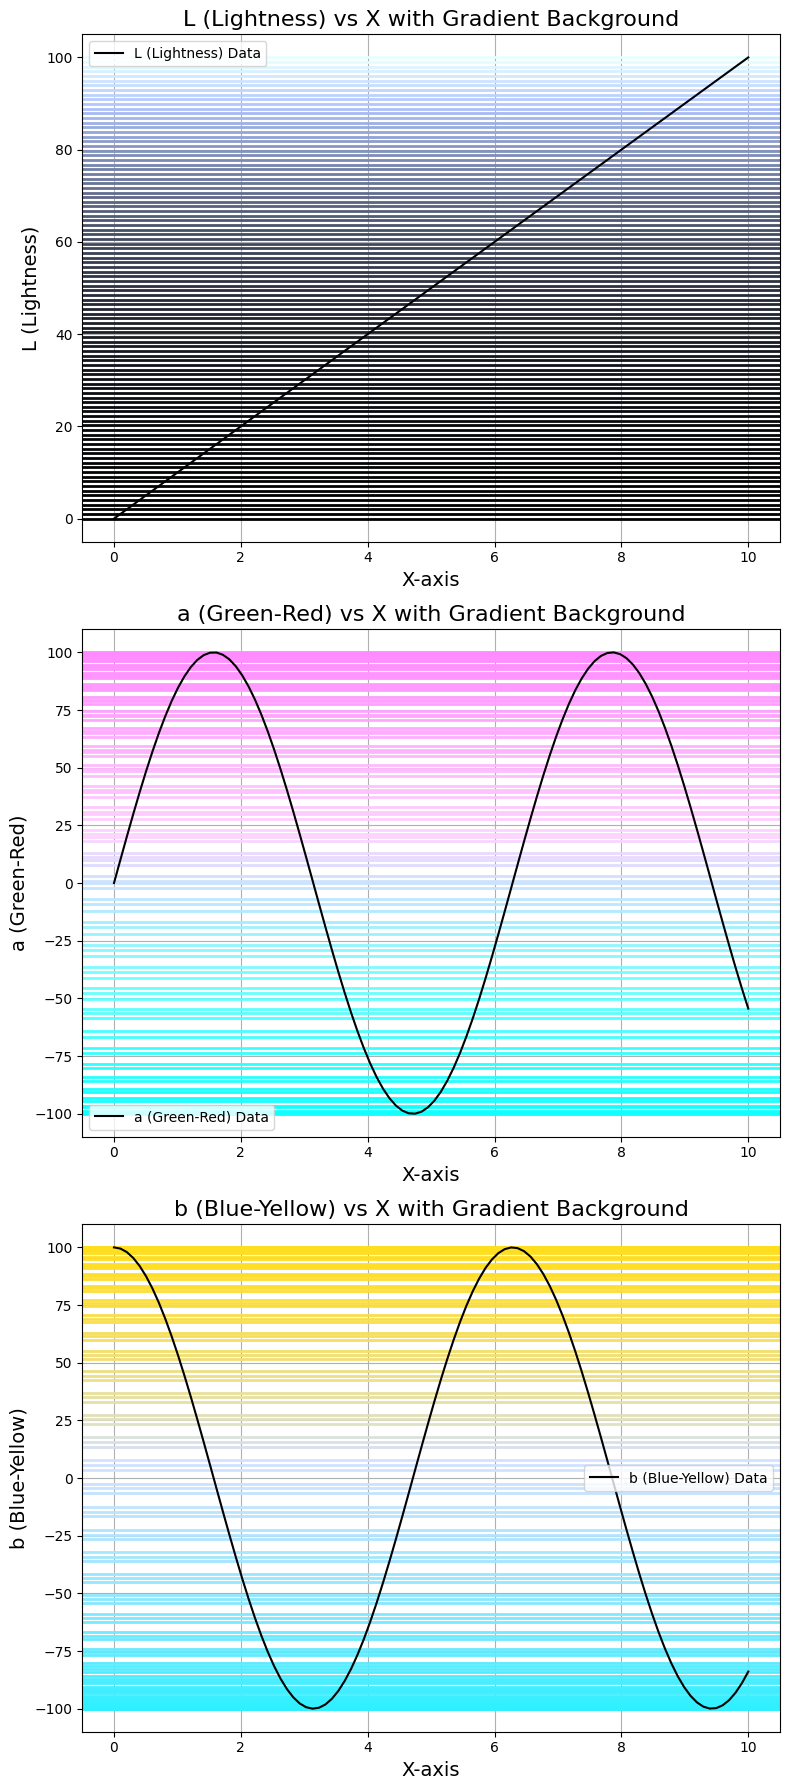

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import colour
from matplotlib import colors

# Function to create the colormap
def create_lab_colormap(L_vals, a_vals, b_vals):
    # Create the Lab color space values
    lab_values = np.array([[L, a, b] for L, a, b in zip(L_vals, a_vals, b_vals)])
    print(lab_values)
    
    # Convert Lab values to XYZ using the correct function from the 'colour' library
    xyz_values = np.array([colour.Lab_to_XYZ(lab) for lab in lab_values])
    
    # Convert XYZ to RGB using the 'colour' library with the 'sRGB' color space
    rgb_values = np.array([colour.XYZ_to_RGB(xyz, 'Best RGB') for xyz in xyz_values])
    print(rgb_values)
    
    # Clip RGB values to [0, 1] range and avoid 0.0 by adding a small epsilon
    rgb_values = np.clip(rgb_values, 0 + 1e-5, 1)  # Avoid 0.0 and ensure all values are valid
    
    return rgb_values

# Example data: X-axis and Y-axis values (for demonstration)
x_vals = np.linspace(0, 10, 100)  # X-axis: 100 points from 0 to 10
y_vals_L = np.linspace(0, 100, 100)  # Y-axis for L: 100 points from 0 to 100
y_vals_a = np.sin(np.linspace(0, 10, 100)) * 100  # Example sine wave for 'a'
y_vals_b = np.cos(np.linspace(0, 10, 100)) * 100  # Example cosine wave for 'b'

# Create colormaps for L, a, and b
L_values = np.linspace(0, 100, 256)  # L range for the colormap
a_vals = np.zeros(256)  # Fix 'a' to 0 for this colormap
b_vals = np.zeros(256)  # Fix 'b' to 0 for this colormap
rgb_values_L = create_lab_colormap(L_values, a_vals, b_vals)  # Generate the colormap for L

L_values = np.full(256,95)  # Fix 'L' to 0 for this colormap
a_vals = np.linspace(-100, 100, 256)  # 'a' values for the colormap
b_vals = np.zeros(256)  # Fix 'b' to 0 for this colormap
rgb_values_a = create_lab_colormap(L_values, a_vals, b_vals)  # Generate the colormap for a

L_values = np.full(256,95)  # Fix 'L' to 0 for this colormap
a_vals = np.zeros(256)  # Fix 'b' to 0 for this colormap
b_vals = np.linspace(-100, 100, 256)  # 'b' values for the colormap
rgb_values_b = create_lab_colormap(L_values, a_vals, b_vals)  # Generate the colormap for b

# Normalize y-values (L, a, b) to the range [0, 1]
norm_L = colors.Normalize(vmin=min(y_vals_L), vmax=max(y_vals_L))
norm_a = colors.Normalize(vmin=min(y_vals_a), vmax=max(y_vals_a))
norm_b = colors.Normalize(vmin=min(y_vals_b), vmax=max(y_vals_b))

cmap_L = colors.ListedColormap(rgb_values_L)
cmap_a = colors.ListedColormap(rgb_values_a)
cmap_b = colors.ListedColormap(rgb_values_b)

# Plotting
fig, axes = plt.subplots(3, 1, figsize=(8, 18))

# Plot for L-values
for i, y in enumerate(y_vals_L):
    color = cmap_L(norm_L(y))  # Get color from colormap based on y-value (L)
    axes[0].axhline(y=y, color=color, lw=2)  # Draw horizontal line with the background color
axes[0].plot(x_vals, y_vals_L, color='k', label='L (Lightness) Data')
axes[0].set_title('L (Lightness) vs X with Gradient Background', fontsize=16)
axes[0].set_xlabel('X-axis', fontsize=14)
axes[0].set_ylabel('L (Lightness)', fontsize=14)
axes[0].grid(True)
axes[0].legend()

# Plot for a-values
for i, y in enumerate(y_vals_a):
    color = cmap_a(norm_a(y))  # Get color from colormap based on y-value (a)
    axes[1].axhline(y=y, color=color, lw=2)  # Draw horizontal line with the background color
axes[1].plot(x_vals, y_vals_a, color='k', label='a (Green-Red) Data')
axes[1].set_title('a (Green-Red) vs X with Gradient Background', fontsize=16)
axes[1].set_xlabel('X-axis', fontsize=14)
axes[1].set_ylabel('a (Green-Red)', fontsize=14)
axes[1].grid(True)
axes[1].legend()

# Plot for b-values
for i, y in enumerate(y_vals_b):
    color = cmap_b(norm_b(y))  # Get color from colormap based on y-value (b)
    axes[2].axhline(y=y, color=color, lw=2)  # Draw horizontal line with the background color
axes[2].plot(x_vals, y_vals_b, color='k', label='b (Blue-Yellow) Data')
axes[2].set_title('b (Blue-Yellow) vs X with Gradient Background', fontsize=16)
axes[2].set_xlabel('X-axis', fontsize=14)
axes[2].set_ylabel('b (Blue-Yellow)', fontsize=14)
axes[2].grid(True)
axes[2].legend()

# Show the plot
plt.tight_layout()
plt.show()



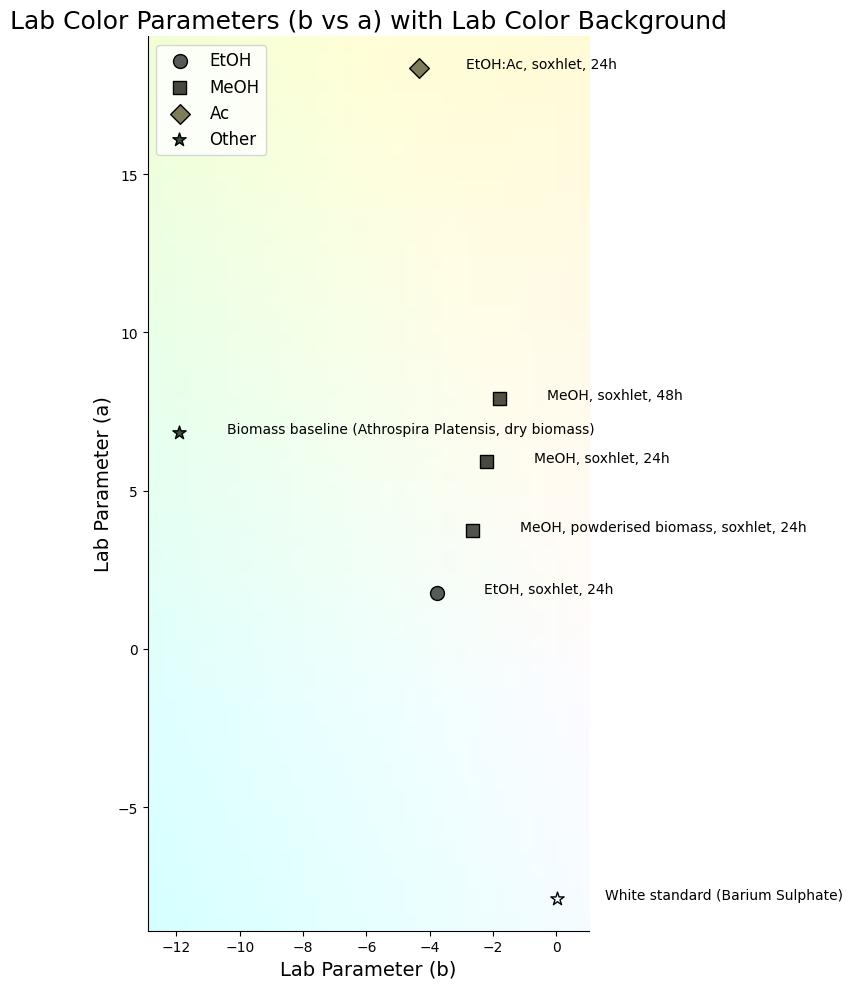

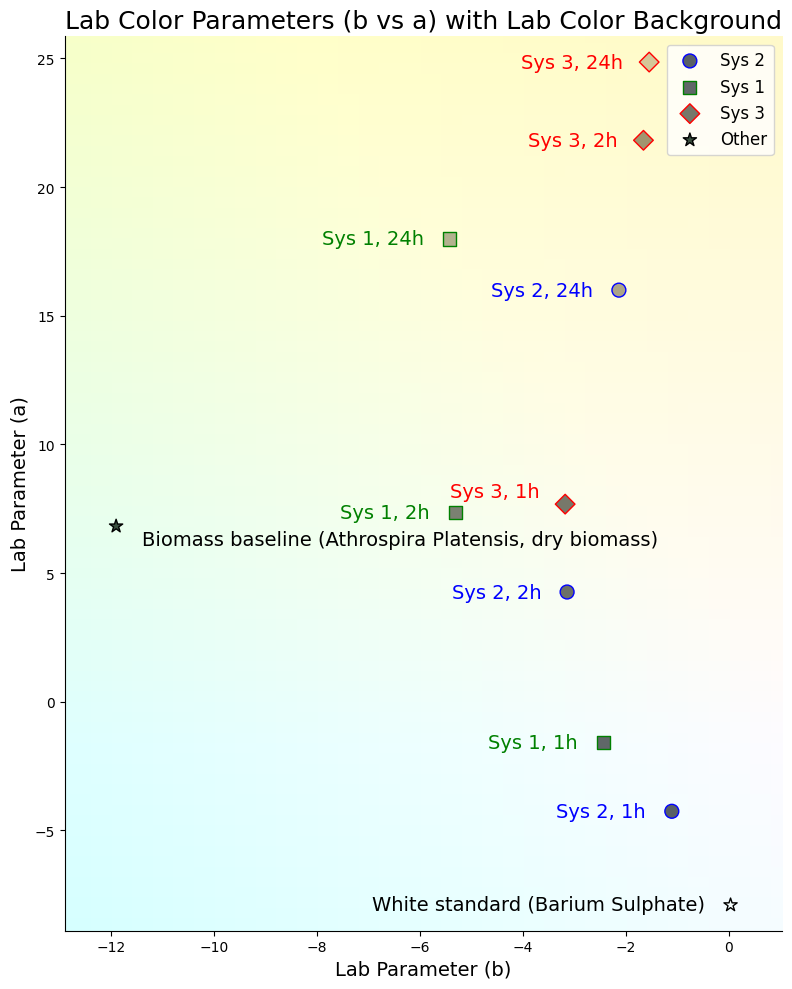

In [178]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgb
from skimage.color import lab2rgb

# Updated label_keys dictionary
label_keys = {
'240514_biomass_baseline': 'Biomass baseline (Athrospira Platensis, dry biomass)',
'240417_EtOH_Ac_soxhlet': 'EtOH:Ac, soxhlet, 24h',
'240417_EtOH_soxhlet': 'EtOH, soxhlet, 24h',
'240417_MeOH_soxhlet': 'MeOH, soxhlet, 24h',
'240514_powderised_MeOH_soxhlet': 'MeOH, powderised biomass, soxhlet, 24h',
'240701_MeOH_48h_soxhlet': 'MeOH, soxhlet, 48h',
'240417_EtOH_macerate': 'EtOH, macerate, RT, weeks',
'240417_MeOH_macerate': 'MeOH, macerate, RT, weeks',
'240514_EtOH-NaOH_10.1_MeOH_clean': 'EtOH, NaOH, macerate, 24h (x5)',
'240701_EtOH.Ac_5x1h_1400': 'EtOH:Ac, macerate, 60C, 1h (x5)',
'240712_EtOH.Ac_5x2h_1400': 'EtOH:Ac, macerate, 60C, 2h (x5)',
'240712_EtOH.Ac_5x2h_1400_2': 'EtOH:Ac, macerate, 60C, 2h (x5)',
'240701_EtOH.Ac_5x24h_1400': 'EtOH:Ac, macerate, 60C, 24h (x5)',
'240701_EtOH_5x1h_1400': 'EtOH, macerate, 60C, 1h (x5)',
'240712_EtOH_5x2h_1400': 'EtOH, macerate, 60C, 2h (x5)',
'240701_EtOH_5x24h_1400': 'EtOH, macerate, 60C, 24h (x5)',
'240701_MeOH_5x1h_1400': 'MeOH, macerate, 60C, 1h (x5)',
'240712_MeOH_5x2h_1400': 'MeOH, macerate, 60C, 2h (x5)',
'240701_MeOH_5x24h_1400': 'MeOH, macerate, 60C, 24h (x5)',
'240701_MeOH_5x24_MeOH_12.5%_ChMeSO3': 'MeOH, ChMeSO3(12.5%), macerate, 60C, 24h (x5)',
'240712_BaSO4_direct': 'White standard (Barium Sulphate)',
'240730_ChCl1M_1x20m_EtOH_5x24h_1400_RT': None,
'240701_EtOH_5x24_EtOH_10%_ChMeSO3': 'EtOH, ChMeSO3(10%), macerate, 60C, 24h (x5)',
'240701_EtOH_5x24_EtOH_12..5%_ChMeSO3': 'EtOH, ChMeSO3(12.5%), macerate, 60C, 24h (x5)',
'240701_EtOH_5x24_EtOH_15%_ChMeSO3': 'EtOH, ChMeSO3(15%), macerate, 60C, 24h (x5)',
'240701_EtOH_5x24_EtOH_5%_ChMeSO3': 'EtOH, ChMeSO3(5%), macerate, 60C, 24h (x5)',
'240701_EtOH_5x24_EtOH_7.5%_ChMeSO3': 'EtOH, ChMeSO3(7.5%), macerate, 60C, 24h (x5)',
'240701_EtOH_5x24_MeOH_12.5%_ChMeSO3': 'MeOH, ChMeSO3(12.5%), macerate, 60C, 24h (x5)',
'240701_EtOH_5x24_MeOH_50%_ChMeSO3': 'MeOH, ChMeSO3(50%), macerate, 60C, 24h (x5)',
'240701_EtOH_5x24_MeOH_6.25%_ChMeSO3': 'MeOH, ChMeSO3(6.25%), macerate, 60C, 24h (x5)'
}

# Prepare lists to store the Lab color parameters a and b
a_values, b_values, rgb_colors, keys = [], [], [], []
Ac_a_values, Ac_b_values, Ac_rgb_colors, Ac_keys = [], [], [], []
Et_a_values, Et_b_values, Et_rgb_colors, Et_keys = [], [], [], []
Me_a_values, Me_b_values, Me_rgb_colors, Me_keys = [], [], [], []
x_min_a,y_min_a = colourimetry_dict['240514_biomass_baseline']["Lab Color"][1:3]
x_max_a,y_max_a = colourimetry_dict['240514_biomass_baseline']["Lab Color"][1:3]
x_min,y_min = colourimetry_dict['240514_biomass_baseline']["Lab Color"][1:3]
x_max,y_max = colourimetry_dict['240514_biomass_baseline']["Lab Color"][1:3]
# Extract data from colourimetry_dict
for key, sample in colourimetry_dict.items():
    # Apply exclusions
    if not ('240514_EtOH-NaOH_10.1_MeOH_clean' == key or 
            '240712_EtOH.Ac_5x2h_1400' == key or 
            '240417_EtOH_macerate' == key or 
            '240417_MeOH_macerate' == key or 
            'macerate' in key or 
            'weeks' in key or 
            '5x' in key or 
            'ChMeSO3' in key or 
            'ChCl' in key):
        
        rgb_colors_normalized = tuple(sample["sRGB Color"])
        a, b = sample["Lab Color"][1:3]  # Extract Lab parameters a and b

        # Categorize data
        if 'Ac' in key:
            Ac_a_values.append(a)
            Ac_b_values.append(b)
            Ac_rgb_colors.append(rgb_colors_normalized)
            Ac_keys.append(key)
        elif 'EtOH' in key:
            Et_a_values.append(a)
            Et_b_values.append(b)
            Et_rgb_colors.append(rgb_colors_normalized)
            Et_keys.append(key)
        elif 'MeOH' in key:
            Me_a_values.append(a)
            Me_b_values.append(b)
            Me_rgb_colors.append(rgb_colors_normalized)
            Me_keys.append(key)
        else:
            a_values.append(a)
            b_values.append(b)
            rgb_colors.append(rgb_colors_normalized)
            keys.append(key)

            
        x_min = min(a, x_min)
        x_max = max(a, x_max)
        y_min = min(b, y_min)
        y_max = max(b, y_max)


# Create the background of Lab colors
def create_lab_background(a_range, b_range, L_value=70, resolution=500):
    """
    Generate an RGB image representing the Lab color space background for given ranges of a and b.
    
    Parameters:
        a_range (tuple): Min and max values for Lab a*.
        b_range (tuple): Min and max values for Lab b*.
        L_value (float): Fixed lightness (L*) value to visualize the Lab color plane.
        resolution (int): Resolution of the grid for the color representation.
    
    Returns:
        np.ndarray: RGB image corresponding to the Lab plane.
    """
    a_values = np.linspace(a_range[0], a_range[1], resolution)
    b_values = np.linspace(b_range[0], b_range[1], resolution)
    a_grid, b_grid = np.meshgrid(a_values, b_values)
    lab_plane = np.dstack((np.full_like(a_grid, L_value), a_grid, b_grid))
    rgb_plane = lab2rgb(lab_plane)
    return rgb_plane

# Define ranges and resolution
a_range = (-100, 100)
b_range = (-100, 100)
resolution = 500  # Higher values for smoother background
L_value = 99  # Example lightness value


# Generate the Lab background
lab_background = create_lab_background(a_range, b_range, L_value, resolution)

# Plot with the background
plt.figure(figsize=(10, 10))

# Show Lab color plane
plt.imshow(
    lab_background,
    extent=(a_range[0], a_range[1], b_range[0], b_range[1]),
    origin="lower"
)


# Overlay scatter points
plt.scatter(Et_a_values, Et_b_values, marker='o', s=100, color=Et_rgb_colors, edgecolors='black', label='EtOH')
plt.scatter(Me_a_values, Me_b_values, marker='s', s=90, color=Me_rgb_colors, edgecolors='black', label='MeOH')
plt.scatter(Ac_a_values, Ac_b_values, marker='D', s=100, color=Ac_rgb_colors, edgecolors='black', label='Ac')
plt.scatter(a_values, b_values, marker='*', s=100, color=rgb_colors, edgecolors='black', label='Other')

# Add labels and grid
plt.title('Lab Color Parameters (b vs a) with Lab Color Background', fontsize=18)
plt.xlabel('Lab Parameter (b)', fontsize=14)
plt.ylabel('Lab Parameter (a)', fontsize=14)
plt.grid(False)

# Optionally, add sample labels
for i, key in enumerate(Et_keys):
    plt.text(Et_a_values[i] + 1.5, Et_b_values[i], label_keys[key], fontsize=10)
for i, key in enumerate(Ac_keys):
    plt.text(Ac_a_values[i] + 1.5, Ac_b_values[i], label_keys[key], fontsize=10)
for i, key in enumerate(Me_keys):
    plt.text(Me_a_values[i] + 1.5, Me_b_values[i], label_keys[key], fontsize=10)
for i, key in enumerate(keys):
    plt.text(a_values[i] + 1.5, b_values[i], label_keys[key], fontsize=10)

# Final touches
plt.legend(loc='best', fontsize=12)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlim(x_min-1 , x_max+1)  # Add some padding around the data
plt.ylim(y_min-1 , y_max+1)  # Add some padding around the data
plt.tight_layout()
plt.show()


# Prepare lists to store the Lab color parameters a and b
a_values, b_values, rgb_colors, keys = [], [], [], []
Ac_a_values, Ac_b_values, Ac_rgb_colors, Ac_keys = [], [], [], []
Et_a_values, Et_b_values, Et_rgb_colors, Et_keys = [], [], [], []
Me_a_values, Me_b_values, Me_rgb_colors, Me_keys = [], [], [], []
x_min_a,y_min_a = colourimetry_dict['240514_biomass_baseline']["Lab Color"][1:3]
x_max_a,y_max_a = colourimetry_dict['240514_biomass_baseline']["Lab Color"][1:3]
x_min,y_min = colourimetry_dict['240514_biomass_baseline']["Lab Color"][1:3]
x_max,y_max = colourimetry_dict['240514_biomass_baseline']["Lab Color"][1:3]
# Extract data from colourimetry_dict
for key, sample in colourimetry_dict.items():
    # Apply exclusions
    if not ('240514_EtOH-NaOH_10.1_MeOH_clean' == key or  
            '240712_EtOH.Ac_5x2h_1400' == key or 
            'soxhlet' in key or 
            'macerate' in key or 
            'ChMeSO3' in key or 
            'ChCl' in key):
        
        rgb_colors_normalized = tuple(sample["sRGB Color"])
        a, b = sample["Lab Color"][1:3]  # Extract Lab parameters a and b

        # Categorize data
        if 'Ac' in key:
            Ac_a_values.append(a)
            Ac_b_values.append(b)
            Ac_rgb_colors.append(rgb_colors_normalized)
            Ac_keys.append(key)
        elif 'EtOH' in key:
            Et_a_values.append(a)
            Et_b_values.append(b)
            Et_rgb_colors.append(rgb_colors_normalized)
            Et_keys.append(key)
        elif 'MeOH' in key:
            Me_a_values.append(a)
            Me_b_values.append(b)
            Me_rgb_colors.append(rgb_colors_normalized)
            Me_keys.append(key)
        else:
            a_values.append(a)
            b_values.append(b)
            rgb_colors.append(rgb_colors_normalized)
            keys.append(key)

            
        x_min = min(a, x_min)
        x_max = max(a, x_max)
        y_min = min(b, y_min)
        y_max = max(b, y_max)


# Create the background of Lab colors
def create_lab_background(a_range, b_range, L_value=70, resolution=500):
    """
    Generate an RGB image representing the Lab color space background for given ranges of a and b.
    
    Parameters:
        a_range (tuple): Min and max values for Lab a*.
        b_range (tuple): Min and max values for Lab b*.
        L_value (float): Fixed lightness (L*) value to visualize the Lab color plane.
        resolution (int): Resolution of the grid for the color representation.
    
    Returns:
        np.ndarray: RGB image corresponding to the Lab plane.
    """
    a_values = np.linspace(a_range[0], a_range[1], resolution)
    b_values = np.linspace(b_range[0], b_range[1], resolution)
    a_grid, b_grid = np.meshgrid(a_values, b_values)
    lab_plane = np.dstack((np.full_like(a_grid, L_value), a_grid, b_grid))
    rgb_plane = lab2rgb(lab_plane)
    return rgb_plane

# Define ranges and resolution
a_range = (-100, 100)
b_range = (-100, 100)
resolution = 500  # Higher values for smoother background
L_value = 99  # Example lightness value


# Generate the Lab background
lab_background = create_lab_background(a_range, b_range, L_value, resolution)

# Plot with the background
plt.figure(figsize=(10, 10))

# Show Lab color plane
plt.imshow(
    lab_background,
    extent=(a_range[0], a_range[1], b_range[0], b_range[1]),
    origin="lower"
)


# Overlay scatter points
plt.scatter(Et_a_values, Et_b_values, marker='o', s=100, color=Et_rgb_colors, edgecolors='b', label='EtOH'.replace(' (x5)', '').replace(', macerate, 60C,', ',').replace('MeOH', 'Sys 1').replace('EtOH:Ac', 'Sys 3').replace('EtOH', 'Sys 2'))
plt.scatter(Me_a_values, Me_b_values, marker='s', s=90, color=Me_rgb_colors, edgecolors='g', label='MeOH'.replace(' (x5)', '').replace(', macerate, 60C,', ',').replace('MeOH', 'Sys 1').replace('EtOH:Ac', 'Sys 3').replace('EtOH', 'Sys 2'))
plt.scatter(Ac_a_values, Ac_b_values, marker='D', s=100, color=Ac_rgb_colors, edgecolors='r', label='EtOH:Ac'.replace(' (x5)', '').replace(', macerate, 60C,', ',').replace('MeOH', 'Sys 1').replace('EtOH:Ac', 'Sys 3').replace('EtOH', 'Sys 2'))
plt.scatter(a_values, b_values, marker='*', s=100, color=rgb_colors, edgecolors='black', label='Other')

# Add labels and grid
plt.title('Lab Color Parameters (b vs a) with Lab Color Background', fontsize=18)
plt.xlabel('Lab Parameter (b)', fontsize=14)
plt.ylabel('Lab Parameter (a)', fontsize=14)
plt.grid(False)

# Optionally, add sample labels
for i, key in enumerate(Et_keys):
    plt.text(Et_a_values[i]-.5 , Et_b_values[i], label_keys[key].replace(' (x5)', '').replace(', macerate, 60C,', ',').replace('MeOH', 'Sys 1').replace('EtOH:Ac', 'Sys 3').replace('EtOH', 'Sys 2'), color="b", ha='right', va='center', fontsize=14)
for i, key in enumerate(Ac_keys):
    if label_keys[key].replace(' (x5)', '').replace(', macerate, 60C,', ',').replace('MeOH', 'Sys 1').replace('EtOH:Ac', 'Sys 3').replace('EtOH', 'Sys 2')=="Sys 3, 1h":
        plt.text(Ac_a_values[i]-.5 , Ac_b_values[i]+.5, label_keys[key].replace(' (x5)', '').replace(', macerate, 60C,', ',').replace('MeOH', 'Sys 1').replace('EtOH:Ac', 'Sys 3').replace('EtOH', 'Sys 2'), color="r", ha='right', va='center', fontsize=14)
    else:
        plt.text(Ac_a_values[i]-.5 , Ac_b_values[i], label_keys[key].replace(' (x5)', '').replace(', macerate, 60C,', ',').replace('MeOH', 'Sys 1').replace('EtOH:Ac', 'Sys 3').replace('EtOH', 'Sys 2'), color="r", ha='right', va='center', fontsize=14)
for i, key in enumerate(Me_keys):
    plt.text(Me_a_values[i]-.5 , Me_b_values[i], label_keys[key].replace(' (x5)', '').replace(', macerate, 60C,', ',').replace('MeOH', 'Sys 1').replace('EtOH:Ac', 'Sys 3').replace('EtOH', 'Sys 2'), color="g", ha='right', va='center', fontsize=14)
for i, key in enumerate(keys):
    if 'Biomass' in label_keys[key]:
        plt.text(a_values[i]+.5, b_values[i]-.5, label_keys[key].replace(' (x5)', '').replace(', macerate, 60C,', ',').replace('MeOH', 'Sys 1').replace('EtOH:Ac', 'Sys 3').replace('EtOH', 'Sys 2'), ha='left', va='center', fontsize=14)
    else:
        plt.text(a_values[i]-.5, b_values[i], label_keys[key].replace(' (x5)', '').replace(', macerate, 60C,', ',').replace('MeOH', 'Sys 1').replace('EtOH:Ac', 'Sys 3').replace('EtOH', 'Sys 2'), ha='right', va='center', fontsize=14)
# Final touches
plt.legend(loc='best', fontsize=12)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlim(x_min-1 , x_max+1)  # Add some padding around the data
plt.ylim(y_min-1 , y_max+1)  # Add some padding around the data
plt.tight_layout()
ax.set_aspect(.5)
plt.show()


KeyError: '240417_MeOH_soxhlet'

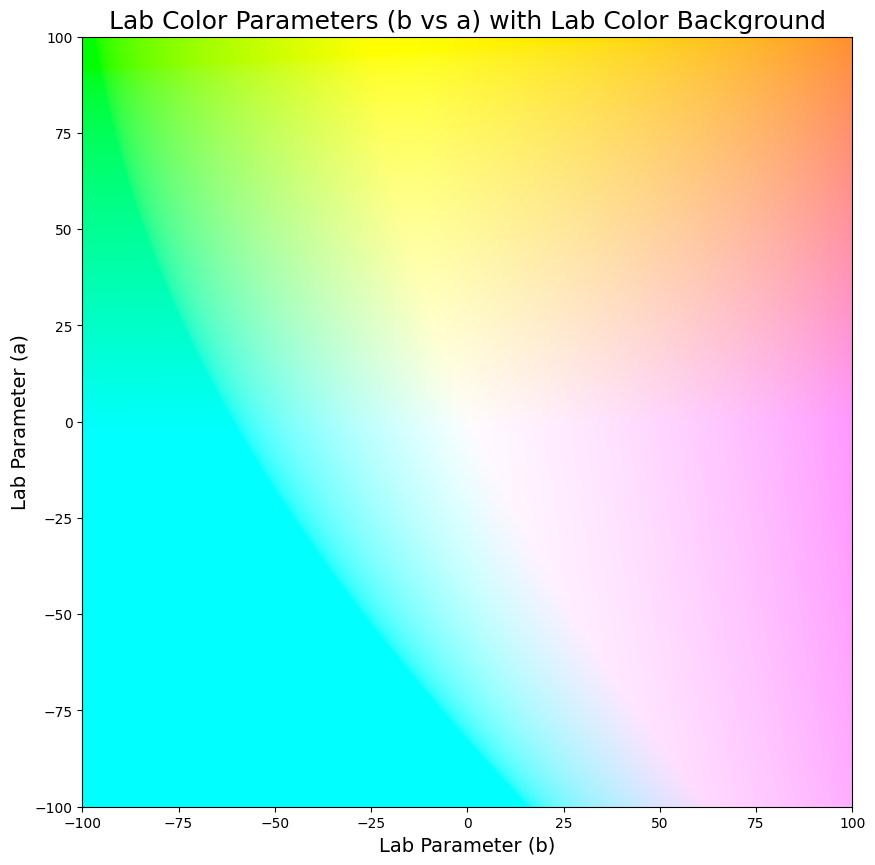

In [137]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgb
from skimage.color import lab2rgb

# Updated label_keys dictionary
label_keys = {
    '240801_ISABEL_IF1_170C_45_0LAS': '170 °C, 45 min, 0% LAS',
    '240801_ISABEL_IF2_150C_45_2LAS': '150 °C, 45 min, 2% LAS',
    '240801_ISABEL_IF2_150C_45_4LAS': '150 °C, 45 min, 4% LAS',
    '240801_ISABEL_IF2_170C_45_2LAS': '170 °C, 45 min, 2% LAS',
    '240801_ISABEL_IF2_170C_45_4LAS': '170 °C, 45 min, 4% LAS',
    '240801_ISABEL_IF3_170C_45_0LAS': '170 °C, 45 min, 0% LAS',
    '240801_ISABEL_IF4_150C_45_10LAS': '150 °C, 45 min, 10% LAS',
    '240912_ISABEL_IF1_150C_45_0LAS': '150 °C, 45 min, 0% LAS',
    '240912_ISABEL_IF3_150C_45_6LAS': '150 °C, 45 min, 6% LAS',
    '240912_ISABEL_IF3_170C_45_6LAS': '170 °C, 45 min, 6% LAS'
}

# Prepare lists to store the Lab color parameters a and b
a_values, b_values, rgb_colors, keys = [], [], [], []
Ac_a_values, Ac_b_values, Ac_rgb_colors, Ac_keys = [], [], [], []
Et_a_values, Et_b_values, Et_rgb_colors, Et_keys = [], [], [], []
Me_a_values, Me_b_values, Me_rgb_colors, Me_keys = [], [], [], []

# Prepare lists to store Lightness, White Distance, and sRGB color values
lightness_values = []
white_distance_values = []
rgb_colors = []
key_values = []
Ac_lightness_values = []
Ac_white_distance_values = []
Ac_rgb_colors = []
Ac_key_values = []
Et_lightness_values = []
Et_white_distance_values = []
Et_rgb_colors = []
Et_key_values = []
Me_lightness_values = []
Me_white_distance_values = []
Me_rgb_colors = []
Me_key_values = []
x_min_a,y_min_a = colourimetry_dict['240514_biomass_baseline']["Lab Color"][1:3]
x_max_a,y_max_a = colourimetry_dict['240514_biomass_baseline']["Lab Color"][1:3]
x_min,y_min = colourimetry_dict['240514_biomass_baseline']["Lab Color"][1:3]
x_max,y_max = colourimetry_dict['240514_biomass_baseline']["Lab Color"][1:3]

# Extract data from colourimetry_dict
for key, sample in colourimetry_dict.items():
    # Apply exclusions
    if not ('240801_ISABEL_IF1_170C_45_0LAS' == key or 
            '240712_EtOH.Ac_5x2h_1400' == key or 
            '240417_EtOH_macerate' == key or 
            '240417_MeOH_macerate' == key or 
            'macerate' in key or 
            '5x' in key or 
            'ChMeSO3' in key or 
            'ChCl' in key):
        
        rgb_colors_normalized = tuple(sample["sRGB Color"])
        a, b = sample["Lab Color"][1:3]  # Extract Lab parameters a and b

        # Categorize data
        if '150' in key:
            Ac_a_values.append(a)
            Ac_b_values.append(b)
            Ac_rgb_colors.append(rgb_colors_normalized)
            Ac_keys.append(key)
        elif '170' in key:
            Et_a_values.append(a)
            Et_b_values.append(b)
            Et_rgb_colors.append(rgb_colors_normalized)
            Et_keys.append(key)
        elif 'MeOH' in key:
            Me_a_values.append(a)
            Me_b_values.append(b)
            Me_rgb_colors.append(rgb_colors_normalized)
            Me_keys.append(key)
        else:
            a_values.append(a)
            b_values.append(b)
            rgb_colors.append(rgb_colors_normalized)
            keys.append(key)
            
        x_min = min(a, x_min)
        x_max = max(a, x_max)
        y_min = min(b, y_min)
        y_max = max(b, y_max)
        



# Create the background of Lab colors
def create_lab_background(a_range, b_range, L_value=70, resolution=500):
    """
    Generate an RGB image representing the Lab color space background for given ranges of a and b.
    
    Parameters:
        a_range (tuple): Min and max values for Lab a*.
        b_range (tuple): Min and max values for Lab b*.
        L_value (float): Fixed lightness (L*) value to visualize the Lab color plane.
        resolution (int): Resolution of the grid for the color representation.
    
    Returns:
        np.ndarray: RGB image corresponding to the Lab plane.
    """
    a_values = np.linspace(a_range[0], a_range[1], resolution)
    b_values = np.linspace(b_range[0], b_range[1], resolution)
    a_grid, b_grid = np.meshgrid(a_values, b_values)
    lab_plane = np.dstack((np.full_like(a_grid, L_value), a_grid, b_grid))
    rgb_plane = lab2rgb(lab_plane)
    return rgb_plane

# Define ranges and resolution
a_range = (-100, 100)
b_range = (-100, 100)
resolution = 500  # Higher values for smoother background
L_value = 99  # Example lightness value


# Generate the Lab background
lab_background = create_lab_background(a_range, b_range, L_value, resolution)

# Plot with the background
plt.figure(figsize=(10, 10))

# Show Lab color plane
plt.imshow(
    lab_background,
    extent=(a_range[0], a_range[1], b_range[0], b_range[1]),
    origin="lower"
)


# Overlay scatter points
plt.scatter(Et_a_values, Et_b_values, marker='o', s=100, color=Et_rgb_colors, edgecolors='black', label='150 °C, 45 min')
plt.scatter(Ac_a_values, Ac_b_values, marker='D', s=100, color=Ac_rgb_colors, edgecolors='black', label='170 °C, 45 min')
#plt.scatter(a_values, b_values, marker='*', s=100, color=rgb_colors, edgecolors='black', label='Other')

# Add labels and grid
plt.title('Lab Color Parameters (b vs a) with Lab Color Background', fontsize=18)
plt.xlabel('Lab Parameter (b)', fontsize=14)
plt.ylabel('Lab Parameter (a)', fontsize=14)
plt.grid(False)

# Optionally, add sample labels
for i, key in enumerate(Et_keys):
    plt.text(Et_a_values[i] + 1.5, Et_b_values[i], label_keys[key], fontsize=10)
for i, key in enumerate(Ac_keys):
    plt.text(Ac_a_values[i] + 1.5, Ac_b_values[i], label_keys[key], fontsize=10)
for i, key in enumerate(Me_keys):
    plt.text(Me_a_values[i] + 1.5, Me_b_values[i], label_keys[key], fontsize=10)
for i, key in enumerate(keys):
    plt.text(a_values[i] + 1.5, b_values[i], label_keys[key], fontsize=10)

# Final touches
plt.legend(loc='best', fontsize=12)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ylim(x_min-1 , x_max+1 )  # Add some padding around the data
plt.xlim(y_min-1 , y_max+1 )  # Add some padding around the data
plt.tight_layout()
plt.show()


{'Whiteness Index': -72.413097693355368, 'Tint': 43.707666841092625, 'sRGB Color': array([ 0.22992962,  0.31237605,  0.24975939]), 'RGB Color': [58, 79, 63], 'XYZ Color': array([ 0.05541815,  0.06971997,  0.05857701]), 'Lab Color': array([ 31.74307492, -11.90450177,   6.81996786]), 'Lightness': 31.743074920807601, 'Chroma': 13.719661949341676, 'White Distance': 70.628775100456224, 'Chroma Distance': 18.958240700309663, 'Decolouring Percentage': 0}
{'Whiteness Index': -54.786654338065425, 'Tint': 2.6935442491897863, 'sRGB Color': array([ 0.46732656,  0.47198876,  0.41610913]), 'RGB Color': [119, 120, 106], 'XYZ Color': array([ 0.16997001,  0.18494908,  0.16338856]), 'Lab Color': array([ 50.09095795,  -3.17702862,   7.67758899]), 'Lightness': 50.090957949823647, 'Chroma': 8.3089640463804599, 'White Distance': 52.173937257890927, 'Chroma Distance': 15.910034388694418, 'Decolouring Percentage': 25}
{'Whiteness Index': -139.50632491631802, 'Tint': -12.937819925293304, 'sRGB Color': array([ 

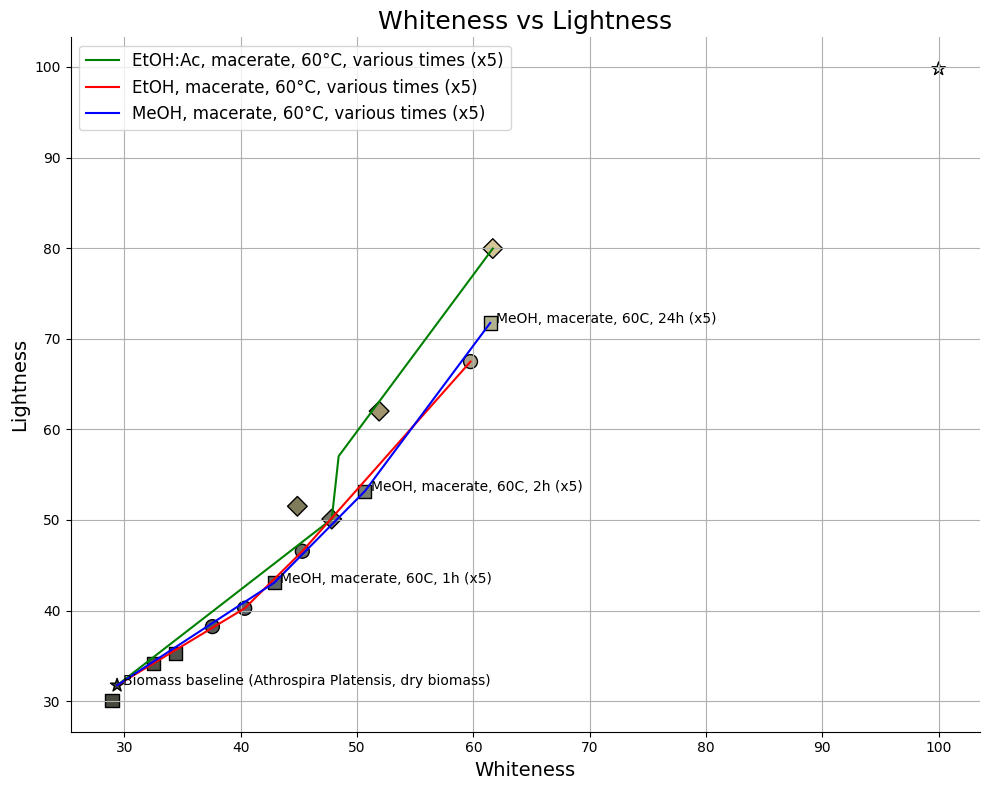

In [96]:
# Create the plot
plt.figure(figsize=(10, 8))


label_keys = {
'240514_biomass_baseline': 'Biomass baseline (Athrospira Platensis, dry biomass)',
'240417_EtOH_Ac_soxhlet': 'EtOH:Ac, soxhlet, 24h',
'240417_EtOH_soxhlet': 'EtOH, soxhlet, 24h',
'240417_MeOH_soxhlet': 'MeOH, soxhlet, 24h',
'240514_powderised_MeOH_soxhlet': 'MeOH, powderised biomass, soxhlet, 24h',
'240701_MeOH_48h_soxhlet': 'MeOH, soxhlet, 48h',
'240417_EtOH_macerate': 'EtOH, macerate, RT, weeks',
'240417_MeOH_macerate': 'MeOH, macerate, RT, weeks',
'240514_EtOH-NaOH_10.1_MeOH_clean': 'EtOH, NaOH, macerate, 24h (x5)',
'240701_EtOH.Ac_5x1h_1400': 'EtOH:Ac, macerate, 60C, 1h (x5)',
'240712_EtOH.Ac_5x2h_1400': 'EtOH:Ac, macerate, 60C, 2h (x5)',
'240712_EtOH.Ac_5x2h_1400_2': 'EtOH:Ac, macerate, 60C, 2h (x5)',
'240701_EtOH.Ac_5x24h_1400': 'EtOH:Ac, macerate, 60C, 24h (x5)',
'240701_EtOH_5x1h_1400': 'EtOH, macerate, 60C, 1h (x5)',
'240712_EtOH_5x2h_1400': 'EtOH, macerate, 60C, 2h (x5)',
'240701_EtOH_5x24h_1400': 'EtOH, macerate, 60C, 24h (x5)',
'240701_MeOH_5x1h_1400': 'MeOH, macerate, 60C, 1h (x5)',
'240712_MeOH_5x2h_1400': 'MeOH, macerate, 60C, 2h (x5)',
'240701_MeOH_5x24h_1400': 'MeOH, macerate, 60C, 24h (x5)',
'240701_MeOH_5x24_MeOH_12.5%_ChMeSO3': 'MeOH, ChMeSO3(12.5%), macerate, 60C, 24h (x5)',
'240712_BaSO4_direct': 'White standard (Barium Sulphate)',
'240730_ChCl1M_1x20m_EtOH_5x24h_1400_RT': None,
'240701_EtOH_5x24_EtOH_10%_ChMeSO3': 'EtOH, ChMeSO3(10%), macerate, 60C, 24h (x5)',
'240701_EtOH_5x24_EtOH_12..5%_ChMeSO3': 'EtOH, ChMeSO3(12.5%), macerate, 60C, 24h (x5)',
'240701_EtOH_5x24_EtOH_15%_ChMeSO3': 'EtOH, ChMeSO3(15%), macerate, 60C, 24h (x5)',
'240701_EtOH_5x24_EtOH_5%_ChMeSO3': 'EtOH, ChMeSO3(5%), macerate, 60C, 24h (x5)',
'240701_EtOH_5x24_EtOH_7.5%_ChMeSO3': 'EtOH, ChMeSO3(7.5%), macerate, 60C, 24h (x5)',
'240701_EtOH_5x24_MeOH_12.5%_ChMeSO3': 'MeOH, ChMeSO3(12.5%), macerate, 60C, 24h (x5)',
'240701_EtOH_5x24_MeOH_50%_ChMeSO3': 'MeOH, ChMeSO3(50%), macerate, 60C, 24h (x5)',
'240701_EtOH_5x24_MeOH_6.25%_ChMeSO3': 'MeOH, ChMeSO3(6.25%), macerate, 60C, 24h (x5)'
}


# Extract data for the specific samples
line_samples = [
    '240514_biomass_baseline',
    "240701_EtOH.Ac_5x1h_1400",  # EtOH:Ac, macerate, 60C, 1h (x5)
    "240712_EtOH.Ac_5x2h_1400",  # EtOH:Ac, macerate, 60C, 2h (x5)
    "240701_EtOH.Ac_5x24h_1400",  # EtOH:Ac, macerate, 60C, 24h (x5)
]

# Collect data for these specific samples
line_white_distance = []
line_lightness = []
line_labels = []

for key in line_samples:
    if key in colourimetry_dict:
        sample = colourimetry_dict[key]
        print(sample)
        line_white_distance.append(100 - sample["White Distance"])
        line_lightness.append(sample["Lightness"])
        line_labels.append(label_keys[key])

# Add the lines for the specific samples
plt.plot(
    line_white_distance,
    line_lightness,
    label="EtOH:Ac, macerate, 60°C, various times (x5)",
    linestyle="-",
    color="green",
)


# Extract data for the specific samples
line_samples = [
    '240514_biomass_baseline',
    "240701_EtOH_5x1h_1400",  # EtOH:Ac, macerate, 60C, 1h (x5)
    "240712_EtOH_5x2h_1400",  # EtOH:Ac, macerate, 60C, 2h (x5)
    "240701_EtOH_5x24h_1400",  # EtOH:Ac, macerate, 60C, 24h (x5)
]

# Collect data for these specific samples
line_white_distance = []
line_lightness = []
line_labels = []

for key in line_samples:
    if key in colourimetry_dict:
        sample = colourimetry_dict[key]
        line_white_distance.append(100 - sample["White Distance"])
        line_lightness.append(sample["Lightness"])
        line_labels.append(label_keys[key])

# Add the lines for the specific samples
plt.plot(
    line_white_distance,
    line_lightness,
    label="EtOH, macerate, 60°C, various times (x5)",
    linestyle="-",
    color="red",
)

# Extract data for the specific samples
line_samples = [
    '240514_biomass_baseline',
    "240701_MeOH_5x1h_1400",  # EtOH:Ac, macerate, 60C, 1h (x5)
    "240712_MeOH_5x2h_1400",  # EtOH:Ac, macerate, 60C, 2h (x5)
    "240701_MeOH_5x24h_1400",  # EtOH:Ac, macerate, 60C, 24h (x5)
]

# Collect data for these specific samples
line_white_distance = []
line_lightness = []
line_labels = []

for key in line_samples:
    if key in colourimetry_dict:
        sample = colourimetry_dict[key]
        line_white_distance.append(100 - sample["White Distance"])
        line_lightness.append(sample["Lightness"])
        line_labels.append(label_keys[key])

# Prepare lists to store Lightness, White Distance, and sRGB color values
lightness_values = []
white_distance_values = []
rgb_colors = []
key_values = []
Ac_lightness_values = []
Ac_white_distance_values = []
Ac_rgb_colors = []
Ac_key_values = []
Et_lightness_values = []
Et_white_distance_values = []
Et_rgb_colors = []
Et_key_values = []
Me_lightness_values = []
Me_white_distance_values = []
Me_rgb_colors = []
Me_key_values = []
x_min = colourimetry_dict['240514_biomass_baseline']["Lab Color"][1]
x_max = colourimetry_dict['240514_biomass_baseline']["Lab Color"][1]
y_min = colourimetry_dict['240514_biomass_baseline']["Lab Color"][2]
y_max = colourimetry_dict['240514_biomass_baseline']["Lab Color"][2]

# Extract Lightness, White Distance, and sRGB from eachsample in the dictionary
for key, sample in colourimetry_dict.items():
    if not('240514_EtOH-NaOH_10.1_MeOH_clean' == key) and not('240712_EtOH.Ac_5x2h_1400' == key) and not('240417_EtOH_macerate' == key) and not('240417_MeOH_macerate' == key) and 'ChMeSO3' not in key and '240417_MeOH_macerate' not in key and '240417_EtOH_macerate' not in key and 'ChCl' not in key:
        rgb_colors_normalized = tuple(sample["sRGB Color"])
        if 'Ac' in key:
            Ac_key_values.append(key)
            Ac_lightness_values.append(sample["Lightness"])
            Ac_white_distance_values.append(100-sample["White Distance"])
            Ac_rgb_colors.append(rgb_colors_normalized)
        elif 'EtOH' in key:
            Et_key_values.append(key)
            Et_lightness_values.append(sample["Lightness"])
            Et_white_distance_values.append(100-sample["White Distance"])
            Et_rgb_colors.append(rgb_colors_normalized)
        elif 'MeOH' in key:
            Me_key_values.append(key)
            Me_lightness_values.append(sample["Lightness"])
            Me_white_distance_values.append(100-sample["White Distance"])
            Me_rgb_colors.append(rgb_colors_normalized)
        else:
            key_values.append(key)
            lightness_values.append(sample["Lightness"])
            white_distance_values.append(100-sample["White Distance"])
            rgb_colors.append(rgb_colors_normalized)
        
        x_min = min(sample["White Distance"], x_min)
        x_max = max(sample["White Distance"], x_max)
        y_min = min(sample["Lightness"], y_min)
        y_max = max(sample["Lightness"], y_max)
        
# Add the lines for the specific samples
plt.plot(
    line_white_distance,
    line_lightness,
    label="MeOH, macerate, 60°C, various times (x5)",
    linestyle="-",
    color="blue",
)

# Scatter plots
scatter = plt.scatter(
    Et_white_distance_values, Et_lightness_values, marker="o", s=100, color=Et_rgb_colors, edgecolors="black"
)
scatter = plt.scatter(
    Me_white_distance_values, Me_lightness_values, marker="s", s=90, color=Me_rgb_colors, edgecolors="black"
)
scatter = plt.scatter(
    Ac_white_distance_values, Ac_lightness_values, marker="D", s=100, color=Ac_rgb_colors, edgecolors="black"
)
scatter = plt.scatter(
    white_distance_values, lightness_values, marker="*", s=100, color=rgb_colors, edgecolors="black"
)

# Annotate each point on the line
for i, label in enumerate(line_labels):
    plt.text(line_white_distance[i] + 0.5, line_lightness[i], label, fontsize=10)

# Add labels and formatting
plt.title("Whiteness vs Lightness", fontsize=18)
plt.ylabel("Lightness", fontsize=14)
plt.xlabel("Whiteness", fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)

# Hide specific spines
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Show the plot
plt.tight_layout()
plt.show()


([40.343861542748719, 59.755709311418599, 45.296296467312501], [40.246018556540683, 67.473816513367296, 46.540816212793935], 'o', [(0.3503353316869775, 0.37520303618718637, 0.39875504936644446), (0.67450000166844015, 0.64507632024222217, 0.53172846655716555), (0.4232118625941883, 0.43778898712605541, 0.40428049956517309)])
([29.371224899543776, 99.999999980806081], [31.743074920807601, 99.779895680914521], '*', [(0.22992961842796134, 0.31237604724364021, 0.24975939109959822), (0.96772374843035214, 0.99989603090470836, 1.0)])


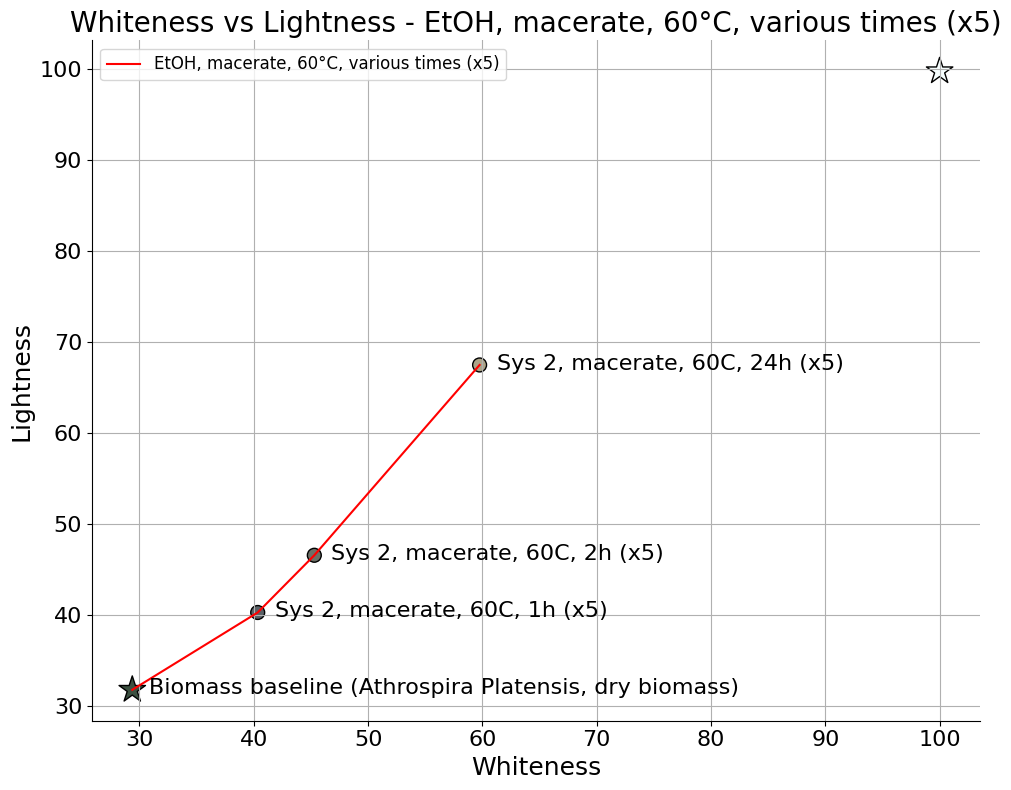

([42.888642854715485, 61.447982827535618, 50.67466810360974], [43.074652810138133, 71.740673727160413, 53.173989015857117], 's', [(0.3766839949647412, 0.40420177906314669, 0.40868857632659861), (0.70170004517677664, 0.69683800252241601, 0.56054220335223992), (0.48198317543223773, 0.50708581490310767, 0.44814486218380239)])
([29.371224899543776, 99.999999980806081], [31.743074920807601, 99.779895680914521], '*', [(0.22992961842796134, 0.31237604724364021, 0.24975939109959822), (0.96772374843035214, 0.99989603090470836, 1.0)])


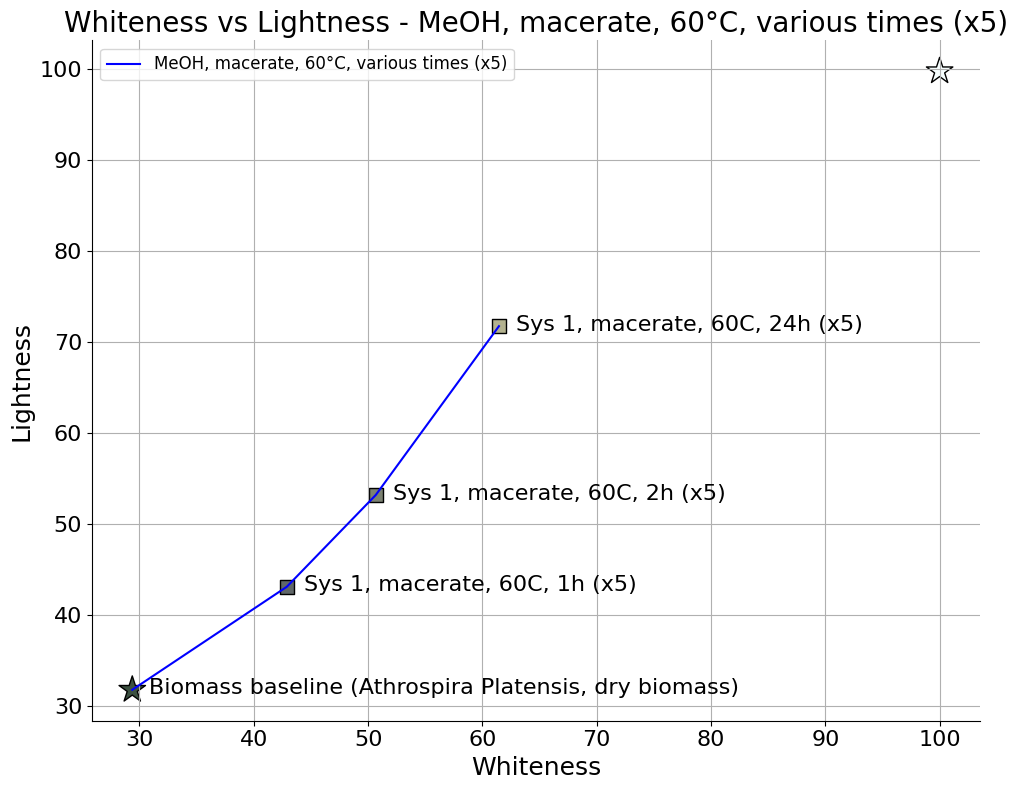

([47.826062742109073, 61.667581778372139, 51.90278918480066], [50.090957949823647, 79.948196315485347, 62.00587042606351], 'D', [(0.46732656038175963, 0.47198875638890975, 0.41610912655033944), (0.83514597727437656, 0.77473191679892162, 0.59594605699813552), (0.63291017275975725, 0.58611200654899687, 0.43617143294355998)])
([29.371224899543776, 99.999999980806081], [31.743074920807601, 99.779895680914521], '*', [(0.22992961842796134, 0.31237604724364021, 0.24975939109959822), (0.96772374843035214, 0.99989603090470836, 1.0)])


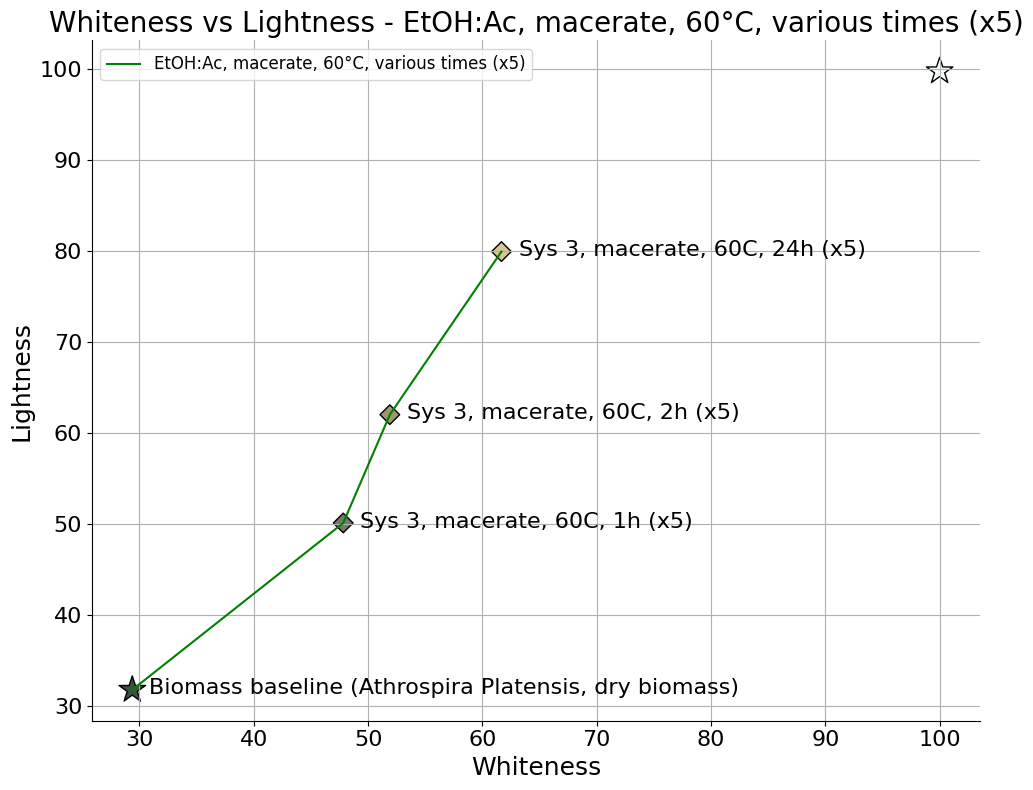

{'Whiteness Index': -72.413097693355368, 'Tint': 43.707666841092625, 'sRGB Color': array([ 0.22992962,  0.31237605,  0.24975939]), 'RGB Color': [58, 79, 63], 'XYZ Color': array([ 0.05541815,  0.06971997,  0.05857701]), 'Lab Color': array([ 31.74307492, -11.90450177,   6.81996786]), 'Lightness': 31.743074920807601, 'Chroma': 13.719661949341676, 'White Distance': 70.628775100456224, 'Chroma Distance': 18.958240700309663, 'Decolouring Percentage': 0}
{'Whiteness Index': -54.786654338065425, 'Tint': 2.6935442491897863, 'sRGB Color': array([ 0.46732656,  0.47198876,  0.41610913]), 'RGB Color': [119, 120, 106], 'XYZ Color': array([ 0.16997001,  0.18494908,  0.16338856]), 'Lab Color': array([ 50.09095795,  -3.17702862,   7.67758899]), 'Lightness': 50.090957949823647, 'Chroma': 8.3089640463804599, 'White Distance': 52.173937257890927, 'Chroma Distance': 15.910034388694418, 'Decolouring Percentage': 25}
{'Whiteness Index': -136.17945325064903, 'Tint': -12.494239990277059, 'sRGB Color': array([ 

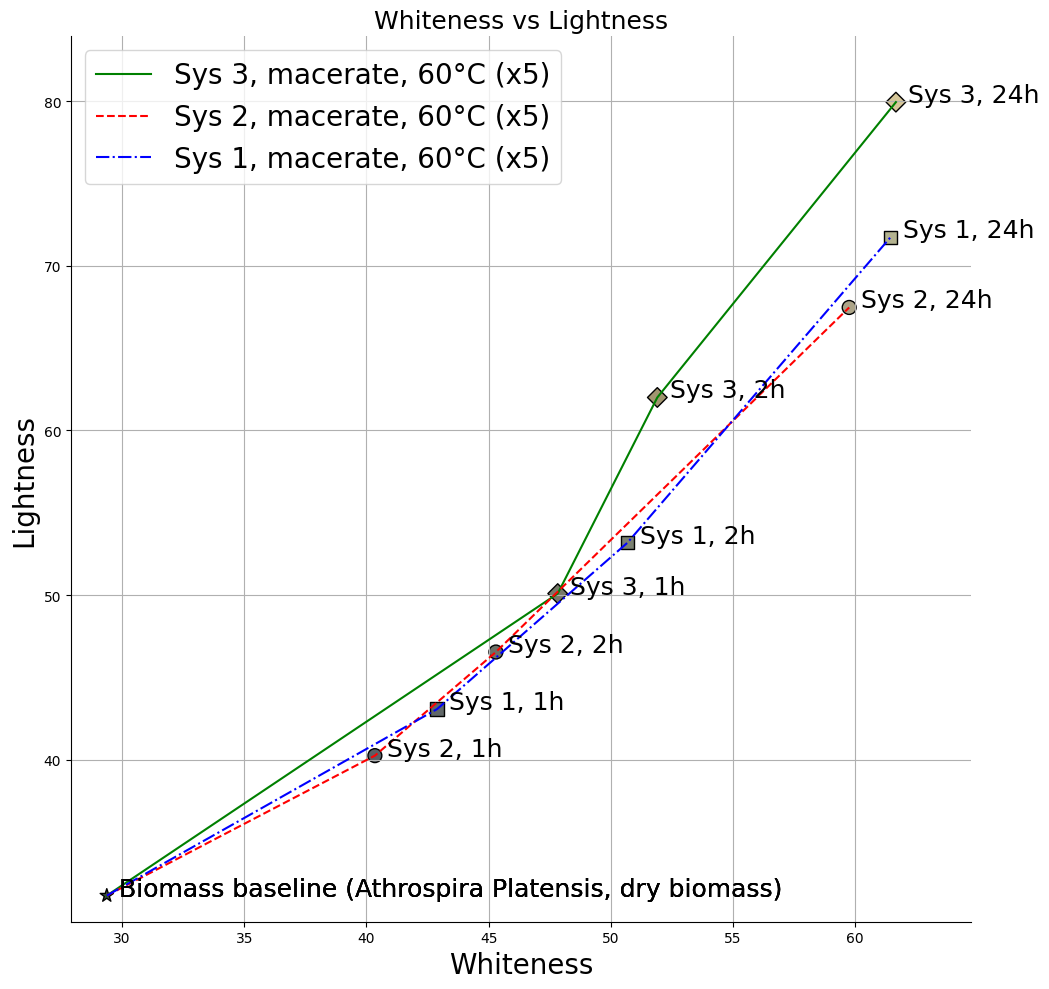

In [133]:
import matplotlib.pyplot as plt

# Data for the solvent systems
systems = [
    {
        "title": "EtOH, macerate, 60°C, various times (x5)",
        "line_samples": [
            '240514_biomass_baseline',
            "240701_EtOH_5x1h_1400",
            "240712_EtOH_5x2h_1400",
            "240701_EtOH_5x24h_1400",
        ],
        "color": "red",
    },
    {
        "title": "MeOH, macerate, 60°C, various times (x5)",
        "line_samples": [
            '240514_biomass_baseline',
            "240701_MeOH_5x1h_1400",
            "240712_MeOH_5x2h_1400",
            "240701_MeOH_5x24h_1400",
        ],
        "color": "blue",
    },
    {
        "title": "EtOH:Ac, macerate, 60°C, various times (x5)",
        "line_samples": [
            '240514_biomass_baseline',
            "240701_EtOH.Ac_5x1h_1400",
            "240712_EtOH.Ac_5x2h_1400_2",
            "240701_EtOH.Ac_5x24h_1400",
        ],
        "color": "green",
    },
]

label_keys = {
'240514_biomass_baseline': 'Biomass baseline (Athrospira Platensis, dry biomass)',
'240417_EtOH_Ac_soxhlet': 'EtOH:Ac, soxhlet, 24h',
'240417_EtOH_soxhlet': 'EtOH, soxhlet, 24h',
'240417_MeOH_soxhlet': 'MeOH, soxhlet, 24h',
'240514_powderised_MeOH_soxhlet': 'MeOH, powderised biomass, soxhlet, 24h',
'240701_MeOH_48h_soxhlet': 'MeOH, soxhlet, 48h',
'240417_EtOH_macerate': 'EtOH, macerate, RT, weeks',
'240417_MeOH_macerate': 'MeOH, macerate, RT, weeks',
'240514_EtOH-NaOH_10.1_MeOH_clean': 'EtOH, NaOH, macerate, 24h (x5)',
'240701_EtOH.Ac_5x1h_1400': 'EtOH:Ac, macerate, 60C, 1h (x5)',
'240712_EtOH.Ac_5x2h_1400': 'EtOH:Ac, macerate, 60C, 2h (x5)',
'240712_EtOH.Ac_5x2h_1400_2': 'EtOH:Ac, macerate, 60C, 2h (x5)',
'240701_EtOH.Ac_5x24h_1400': 'EtOH:Ac, macerate, 60C, 24h (x5)',
'240701_EtOH_5x1h_1400': 'EtOH, macerate, 60C, 1h (x5)',
'240712_EtOH_5x2h_1400': 'EtOH, macerate, 60C, 2h (x5)',
'240701_EtOH_5x24h_1400': 'EtOH, macerate, 60C, 24h (x5)',
'240701_MeOH_5x1h_1400': 'MeOH, macerate, 60C, 1h (x5)',
'240712_MeOH_5x2h_1400': 'MeOH, macerate, 60C, 2h (x5)',
'240701_MeOH_5x24h_1400': 'MeOH, macerate, 60C, 24h (x5)',
'240701_MeOH_5x24_MeOH_12.5%_ChMeSO3': 'MeOH, ChMeSO3(12.5%), macerate, 60C, 24h (x5)',
'240712_BaSO4_direct': 'White standard (Barium Sulphate)',
'240730_ChCl1M_1x20m_EtOH_5x24h_1400_RT': None,
'240701_EtOH_5x24_EtOH_10%_ChMeSO3': 'EtOH, ChMeSO3(10%), macerate, 60C, 24h (x5)',
'240701_EtOH_5x24_EtOH_12..5%_ChMeSO3': 'EtOH, ChMeSO3(12.5%), macerate, 60C, 24h (x5)',
'240701_EtOH_5x24_EtOH_15%_ChMeSO3': 'EtOH, ChMeSO3(15%), macerate, 60C, 24h (x5)',
'240701_EtOH_5x24_EtOH_5%_ChMeSO3': 'EtOH, ChMeSO3(5%), macerate, 60C, 24h (x5)',
'240701_EtOH_5x24_EtOH_7.5%_ChMeSO3': 'EtOH, ChMeSO3(7.5%), macerate, 60C, 24h (x5)',
'240701_EtOH_5x24_MeOH_12.5%_ChMeSO3': 'MeOH, ChMeSO3(12.5%), macerate, 60C, 24h (x5)',
'240701_EtOH_5x24_MeOH_50%_ChMeSO3': 'MeOH, ChMeSO3(50%), macerate, 60C, 24h (x5)',
'240701_EtOH_5x24_MeOH_6.25%_ChMeSO3': 'MeOH, ChMeSO3(6.25%), macerate, 60C, 24h (x5)'
}


# Prepare lists to store Lightness, White Distance, and sRGB color values
lightness_values = []
white_distance_values = []
rgb_colors = []
key_values = []
Ac_lightness_values = []
Ac_white_distance_values = []
Ac_rgb_colors = []
Ac_key_values = []
Et_lightness_values = []
Et_white_distance_values = []
Et_rgb_colors = []
Et_key_values = []
Me_lightness_values = []
Me_white_distance_values = []
Me_rgb_colors = []
Me_key_values = []
x_min = 50
x_max = 50
y_min = 50
y_max = 50
x_min_a = 100-colourimetry_dict['240514_biomass_baseline']["White Distance"]
x_max_a = 100-colourimetry_dict['240514_biomass_baseline']["White Distance"]
y_min_a = colourimetry_dict['240514_biomass_baseline']["Lightness"]
y_max_a = colourimetry_dict['240514_biomass_baseline']["Lightness"]
x_min_b = 100-colourimetry_dict['240514_biomass_baseline']["White Distance"]
x_max_b = 100-colourimetry_dict['240514_biomass_baseline']["White Distance"]
y_min_b = colourimetry_dict['240514_biomass_baseline']["Lightness"]
y_max_b = colourimetry_dict['240514_biomass_baseline']["Lightness"]
x_min_c = 100-colourimetry_dict['240514_biomass_baseline']["White Distance"]
x_max_c = 100-colourimetry_dict['240514_biomass_baseline']["White Distance"]
y_min_c = colourimetry_dict['240514_biomass_baseline']["Lightness"]
y_max_c = colourimetry_dict['240514_biomass_baseline']["Lightness"]



# Extract Lightness, White Distance, and sRGB from eachsample in the dictionary
for key, sample in colourimetry_dict.items():
    if not('240514_EtOH-NaOH_10.1_MeOH_clean' == key) and not('240712_EtOH.Ac_5x2h_1400' == key) and not('240417_EtOH_macerate' == key) and not('240417_MeOH_macerate' == key) and 'ChMeSO3' not in key and 'soxhlet' not in key and '240417_MeOH_macerate' not in key and '240417_EtOH_macerate' not in key and 'ChCl' not in key:
        rgb_colors_normalized = tuple(sample["sRGB Color"])
        if 'Ac' in key:
            Ac_key_values.append(key)
            Ac_lightness_values.append(sample["Lightness"])
            Ac_white_distance_values.append(100-sample["White Distance"])
            Ac_rgb_colors.append(rgb_colors_normalized)
            x_min_a = min(100-sample["White Distance"], x_min_a)
            x_max_a = max(100-sample["White Distance"], x_max_a)
            y_min_a = min(sample["Lightness"], y_min_a)
            y_max_a = max(sample["Lightness"], y_max_a)
        elif 'EtOH' in key:
            Et_key_values.append(key)
            Et_lightness_values.append(sample["Lightness"])
            Et_white_distance_values.append(100-sample["White Distance"])
            Et_rgb_colors.append(rgb_colors_normalized)
            x_min_b = min(100-sample["White Distance"], x_min_b)
            x_max_b = max(100-sample["White Distance"], x_max_b)
            y_min_b = min(sample["Lightness"], y_min_b)
            y_max_b = max(sample["Lightness"], y_max_b)
        elif 'MeOH' in key:
            Me_key_values.append(key)
            Me_lightness_values.append(sample["Lightness"])
            Me_white_distance_values.append(100-sample["White Distance"])
            Me_rgb_colors.append(rgb_colors_normalized)
            x_min_c = min(100-sample["White Distance"], x_min_c)
            x_max_c = max(100-sample["White Distance"], x_max_c)
            y_min_c = min(sample["Lightness"], y_min_c)
            y_max_c = max(sample["Lightness"], y_max_c)
        else:
            key_values.append(key)
            lightness_values.append(sample["Lightness"])
            white_distance_values.append(100-sample["White Distance"])
            rgb_colors.append(rgb_colors_normalized)
        
        x_min = min(sample["White Distance"], x_min)
        x_max = max(sample["White Distance"], x_max)
        y_min = min(sample["Lightness"], y_min)
        y_max = max(sample["Lightness"], y_max)

# Scatter data (common for all plots)
scatter_data = [
    (Et_white_distance_values, Et_lightness_values, "o", Et_rgb_colors),
    (Me_white_distance_values, Me_lightness_values, "s", Me_rgb_colors),
    (Ac_white_distance_values, Ac_lightness_values, "D", Ac_rgb_colors),
    (white_distance_values, lightness_values, "*", rgb_colors),
]

# Generate separate plots for each system
for j,system in enumerate(systems):
    plt.figure(figsize=(10, 8))

    # Extract data for specific samples
    line_white_distance = []
    line_lightness = []
    line_labels = []

    for key in system["line_samples"]:
        if key in colourimetry_dict:
            sample = colourimetry_dict[key]
            line_white_distance.append(100 - sample["White Distance"])
            line_lightness.append(sample["Lightness"])
            line_labels.append(label_keys[key])

    # Plot line transitions
    plt.plot(
        line_white_distance,
        line_lightness,
        label=system["title"],
        linestyle="-",
        color=system["color"],
    )

    # Annotate points on the line
    for i, label in enumerate(line_labels):
        plt.text(line_white_distance[i] + 1.5, line_lightness[i] - 0.5, label.replace('MeOH', 'Sys 1').replace('EtOH:Ac', 'Sys 3').replace('EtOH', 'Sys 2'), fontsize=16)

    # Add scatter plots (common to all graphs)
    white_dist, lightness, marker, colors = scatter_data[j]
    print(scatter_data[j])
    plt.scatter(
        white_dist, lightness, s=100, color=colors, marker=marker, edgecolors="black"
    )
    white_dist, lightness, marker, colors = scatter_data[-1]
    print(scatter_data[-1])
    plt.scatter(
        white_dist, lightness, s=400, color=colors, marker=marker, edgecolors="black"
    )

    # Add labels, title, legend, and grid
    plt.title(f"Whiteness vs Lightness - {system['title']}", fontsize=20)
    plt.ylabel("Lightness", fontsize=18)
    plt.xlabel("Whiteness", fontsize=18)
    plt.grid(True)
    plt.legend(fontsize=12)
    
    plt.tick_params(axis='both', labelsize=16)

    # Hide specific spines
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Show the plot
    plt.tight_layout()
    plt.show()

    
# Create the plot
plt.figure(figsize=(10, 10))

# Extract data for the specific samples
line_samples = [
    '240514_biomass_baseline',
    "240701_EtOH.Ac_5x1h_1400",  # EtOH:Ac, macerate, 60C, 1h (x5)
    "240712_EtOH.Ac_5x2h_1400_2",  # EtOH:Ac, macerate, 60C, 2h (x5)
    "240701_EtOH.Ac_5x24h_1400",  # EtOH:Ac, macerate, 60C, 24h (x5)
]

# Collect data for these specific samples
line_white_distance = []
line_lightness = []
line_labels = []

for key in line_samples:
    if key in colourimetry_dict:
        sample = colourimetry_dict[key]
        print(sample)
        line_white_distance.append(100 - sample["White Distance"])
        line_lightness.append(sample["Lightness"])
        line_labels.append(label_keys[key])

# Add the lines for the specific samples
plt.plot(
    line_white_distance,
    line_lightness,
    label="EtOH:Ac, macerate, 60°C (x5)".replace('MeOH', 'Sys 1').replace('EtOH:Ac', 'Sys 3').replace('EtOH', 'Sys 2'),
    linestyle="-",
    color="green",
)

# Annotate each point on the line
for i, label in enumerate(line_labels):
    plt.text(line_white_distance[i] + 0.5, line_lightness[i], label.replace(' (x5)', '').replace(', macerate, 60C,', ',').replace('MeOH', 'Sys 1').replace('EtOH:Ac', 'Sys 3').replace('EtOH', 'Sys 2'), fontsize=18)


# Extract data for the specific samples
line_samples = [
    '240514_biomass_baseline',
    "240701_EtOH_5x1h_1400",  # EtOH:Ac, macerate, 60C, 1h (x5)
    "240712_EtOH_5x2h_1400",  # EtOH:Ac, macerate, 60C, 2h (x5)
    "240701_EtOH_5x24h_1400",  # EtOH:Ac, macerate, 60C, 24h (x5)
]

# Collect data for these specific samples
line_white_distance = []
line_lightness = []
line_labels = []

for key in line_samples:
    if key in colourimetry_dict:
        sample = colourimetry_dict[key]
        line_white_distance.append(100 - sample["White Distance"])
        line_lightness.append(sample["Lightness"])
        line_labels.append(label_keys[key])

# Add the lines for the specific samples
plt.plot(
    line_white_distance,
    line_lightness,
    label="EtOH, macerate, 60°C (x5)".replace('MeOH', 'Sys 1').replace('EtOH:Ac', 'Sys 3').replace('EtOH', 'Sys 2'),
    linestyle="--",
    color="red",
)

# Annotate each point on the line
for i, label in enumerate(line_labels):
    plt.text(line_white_distance[i] + 0.5, line_lightness[i], label.replace(' (x5)', '').replace(', macerate, 60C,', ',').replace('MeOH', 'Sys 1').replace('EtOH:Ac', 'Sys 3').replace('EtOH', 'Sys 2'), fontsize=18)


# Extract data for the specific samples
line_samples = [
    '240514_biomass_baseline',
    "240701_MeOH_5x1h_1400",  # EtOH:Ac, macerate, 60C, 1h (x5)
    "240712_MeOH_5x2h_1400",  # EtOH:Ac, macerate, 60C, 2h (x5)
    "240701_MeOH_5x24h_1400",  # EtOH:Ac, macerate, 60C, 24h (x5)
]

# Collect data for these specific samples
line_white_distance = []
line_lightness = []
line_labels = []

for key in line_samples:
    if key in colourimetry_dict:
        sample = colourimetry_dict[key]
        line_white_distance.append(100 - sample["White Distance"])
        line_lightness.append(sample["Lightness"])
        line_labels.append(label_keys[key])

# Add the lines for the specific samples
plt.plot(
    line_white_distance,
    line_lightness,
    label="MeOH, macerate, 60°C (x5)".replace('MeOH', 'Sys 1').replace('EtOH:Ac', 'Sys 3').replace('EtOH', 'Sys 2'),
    linestyle="-.",
    color="blue",
)


# Annotate each point on the line
for i, label in enumerate(line_labels):
    plt.text(line_white_distance[i] + 0.5, line_lightness[i], label.replace(' (x5)', '').replace(', macerate, 60C,', ',').replace('MeOH', 'Sys 1').replace('EtOH:Ac', 'Sys 3').replace('EtOH', 'Sys 2'), fontsize=18)
    
# Scatter plots
scatter = plt.scatter(
    Et_white_distance_values, Et_lightness_values, marker="o", s=100, color=Et_rgb_colors, edgecolors="black"
)
scatter = plt.scatter(
    Me_white_distance_values, Me_lightness_values, marker="s", s=90, color=Me_rgb_colors, edgecolors="black"
)
scatter = plt.scatter(
    Ac_white_distance_values, Ac_lightness_values, marker="D", s=100, color=Ac_rgb_colors, edgecolors="black"
)
scatter = plt.scatter(
    white_distance_values, lightness_values, marker="*", s=100, color=rgb_colors, edgecolors="black"
)


# Add labels and formatting
plt.title("Whiteness vs Lightness", fontsize=18)
plt.ylabel("Lightness", fontsize=20)
plt.xlabel("Whiteness", fontsize=20)
plt.grid(True)
plt.legend(fontsize=20)

# Hide specific spines
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Show the plot
plt.tight_layout()
print(min(x_min_a,x_min_b,x_min_c),max(x_max_a,x_max_b,x_max_c))
plt.xlim(min(x_min_a,x_min_b,x_min_c)*.95,max(x_max_a,x_max_b,x_max_c)*1.05)  # Add some padding around the data
plt.ylim(min(y_min_a,y_min_b,y_min_c)*.95,max(y_max_a,y_max_b,y_max_c)*1.05)  # Add some padding around the datay
plt.show()

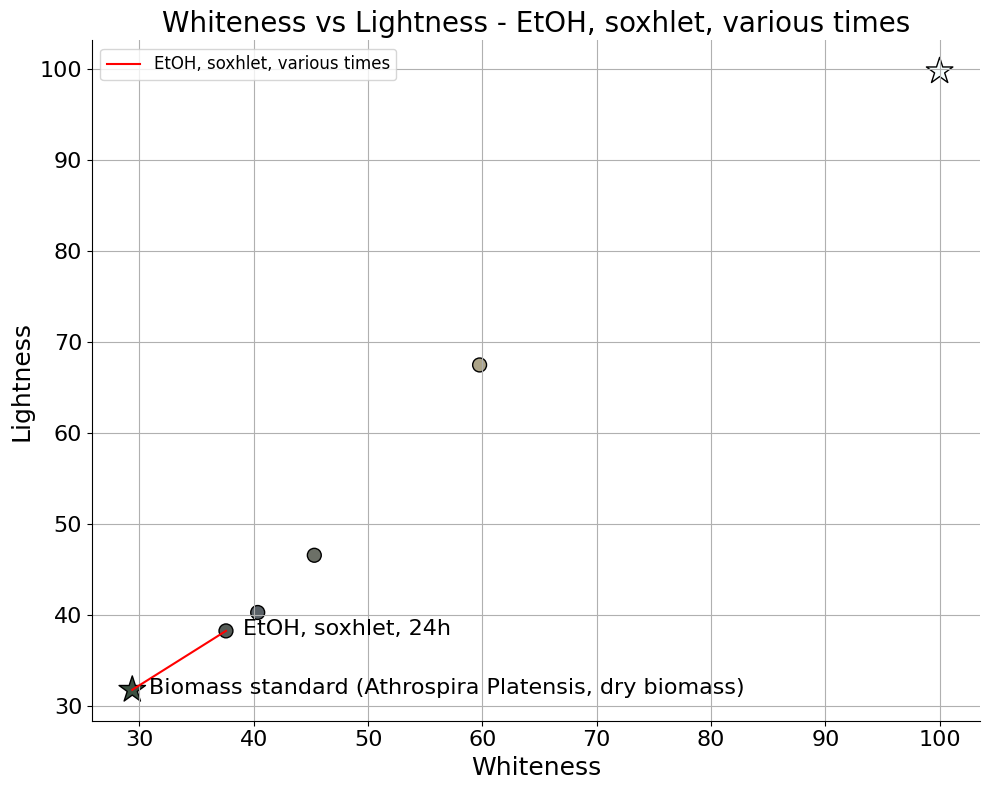

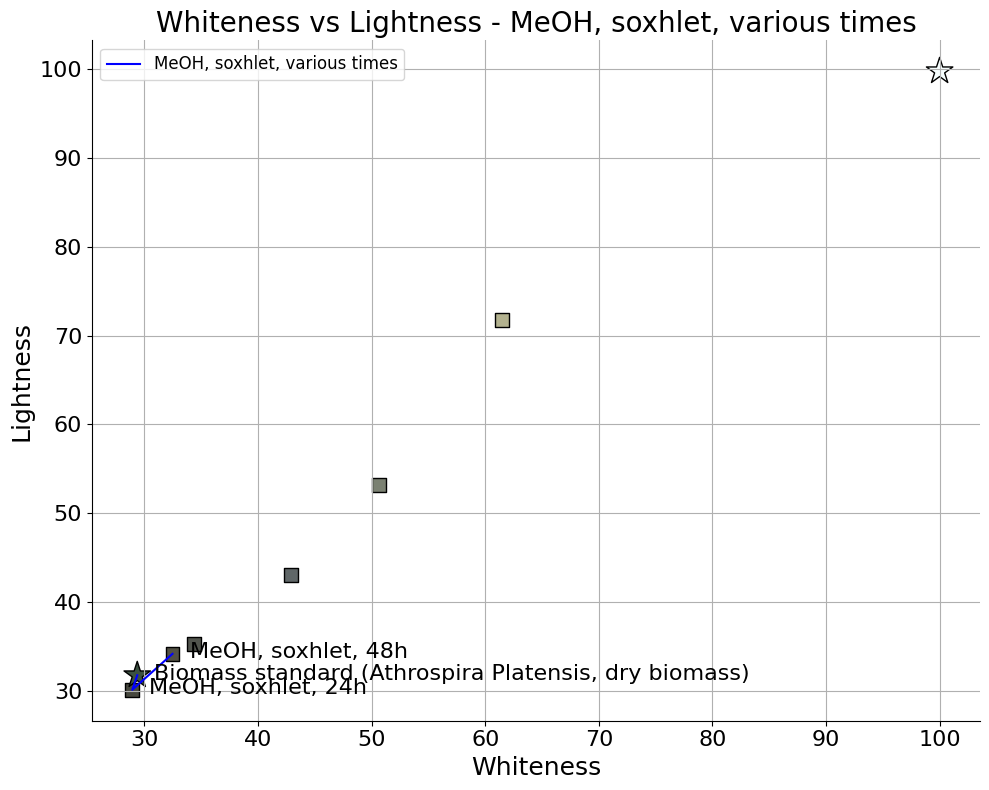

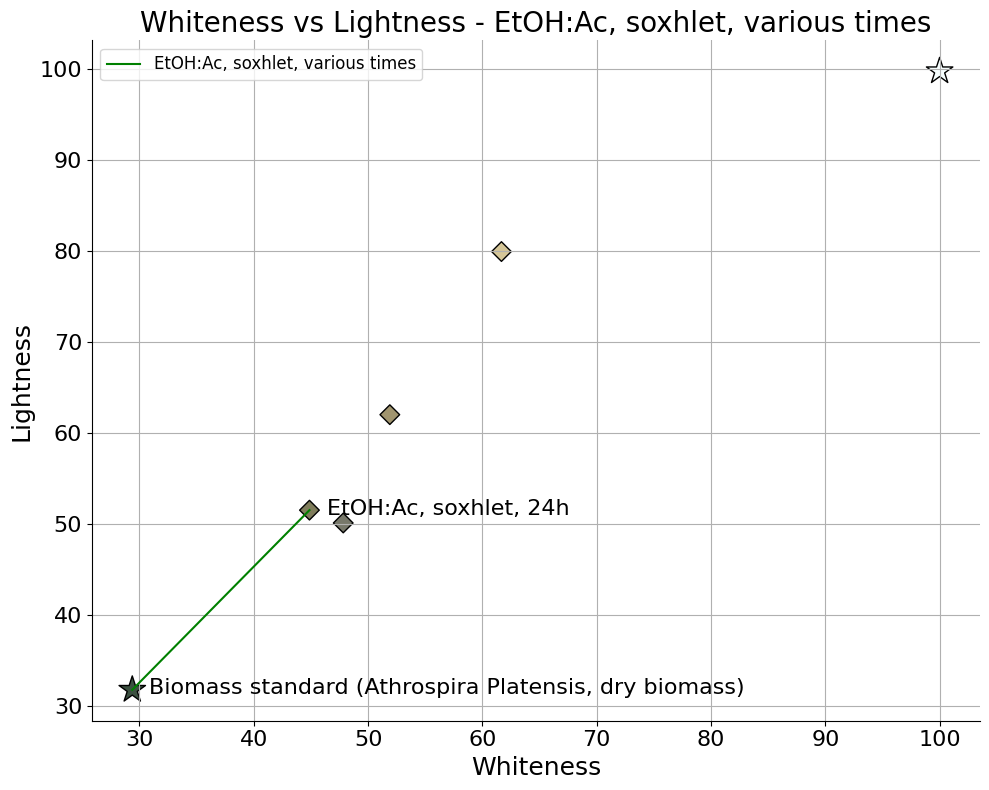

In [193]:
import matplotlib.pyplot as plt

# Data for the solvent systems
systems = [
    {
        "title": "EtOH, soxhlet, various times",
        "line_samples": [
            '240514_biomass_baseline',
            '240417_EtOH_soxhlet',
        ],
        "color": "red",
    },
    {
        "title": "MeOH, soxhlet, various times",
        "line_samples": [
            '240514_biomass_baseline',
            '240417_MeOH_soxhlet',
            '240701_MeOH_48h_soxhlet',
        ],
        "color": "blue",
    },
    {
        "title": "EtOH:Ac, soxhlet, various times",
        "line_samples": [
            '240514_biomass_baseline',
            '240417_EtOH_Ac_soxhlet',
        ],
        "color": "green",
    },
]

# Scatter data (common for all plots)
scatter_data = [
    (Et_white_distance_values, Et_lightness_values, "o", Et_rgb_colors),
    (Me_white_distance_values, Me_lightness_values, "s", Me_rgb_colors),
    (Ac_white_distance_values, Ac_lightness_values, "D", Ac_rgb_colors),
    (white_distance_values, lightness_values, "*", rgb_colors),
]

# Generate separate plots for each system
for j,system in enumerate(systems):
    plt.figure(figsize=(10, 8))

    # Extract data for specific samples
    line_white_distance = []
    line_lightness = []
    line_labels = []

    for key in system["line_samples"]:
        if key in colourimetry_dict:
            sample = colourimetry_dict[key]
            line_white_distance.append(100 - sample["White Distance"])
            line_lightness.append(sample["Lightness"])
            line_labels.append(label_keys[key])

    # Plot line transitions
    plt.plot(
        line_white_distance,
        line_lightness,
        label=system["title"],
        linestyle="-",
        color=system["color"],
    )

    # Annotate points on the line
    for i, label in enumerate(line_labels):
        plt.text(line_white_distance[i] + 1.5, line_lightness[i] - 0.5, label, fontsize=16)

    # Add scatter plots (common to all graphs)
    white_dist, lightness, marker, colors = scatter_data[j]
    plt.scatter(
        white_dist, lightness, marker=marker, s=100, color=colors, edgecolors="black"
    )
    white_dist, lightness, marker, colors = scatter_data[-1]
    plt.scatter(
        white_dist, lightness, marker=marker, s=400, color=colors, edgecolors="black"
    )

    # Add labels, title, legend, and grid
    plt.title(f"Whiteness vs Lightness - {system['title']}", fontsize=20)
    plt.ylabel("Lightness", fontsize=18)
    plt.xlabel("Whiteness", fontsize=18)
    plt.grid(True)
    plt.legend(fontsize=12)
    
    plt.tick_params(axis='both', labelsize=16)

    # Hide specific spines
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Show the plot
    plt.tight_layout()
    plt.show()


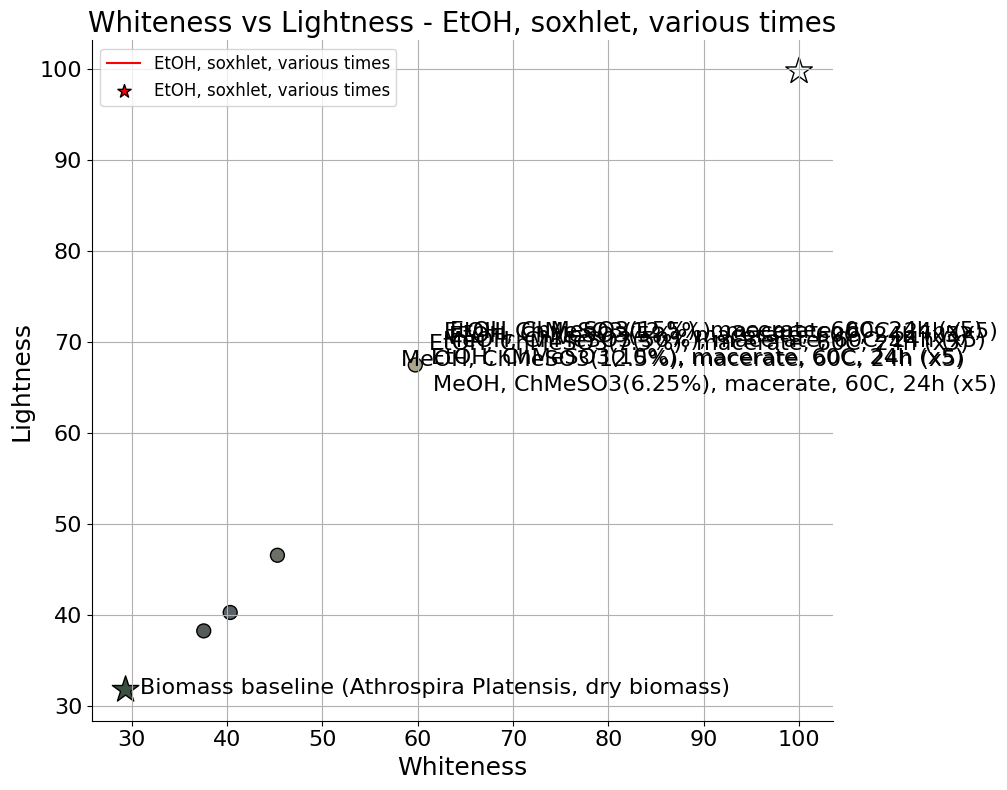

In [200]:
import matplotlib.pyplot as plt

# Data for the solvent systems
systems = [
    {
        "title": "EtOH, soxhlet, various times",
        "scatter_samples": [
            '240514_biomass_baseline',
            '240701_EtOH_5x24_EtOH_10%_ChMeSO3',
            '240701_EtOH_5x24_EtOH_12..5%_ChMeSO3',
            '240701_EtOH_5x24_EtOH_15%_ChMeSO3',
            '240701_EtOH_5x24_EtOH_5%_ChMeSO3',
            '240701_EtOH_5x24_EtOH_7.5%_ChMeSO3',
            '240701_EtOH_5x24_MeOH_12.5%_ChMeSO3',
            '240701_EtOH_5x24_MeOH_50%_ChMeSO3',
            '240701_EtOH_5x24_MeOH_6.25%_ChMeSO3',
        ],
        "color": "red",
    },
]

# Scatter data (common for all plots)
scatter_data = [
    (Et_white_distance_values, Et_lightness_values, "o", Et_rgb_colors),
    (Me_white_distance_values, Me_lightness_values, "s", Me_rgb_colors),
    (Ac_white_distance_values, Ac_lightness_values, "D", Ac_rgb_colors),
    (white_distance_values, lightness_values, "*", rgb_colors),
]

# Generate separate plots for each system
for j,system in enumerate(systems):
    plt.figure(figsize=(10, 8))

    # Extract data for specific samples
    scatter_white_distance = []
    scatter_lightness = []
    scatter_labels = []

    for key in system["scatter_samples"]:
        if key in colourimetry_dict:
            sample = colourimetry_dict[key]
            scatter_white_distance.append(100 - sample["White Distance"])
            scatter_lightness.append(sample["Lightness"])
            scatter_labels.append(label_keys[key])

    # Plot line transitions
    plt.plot(
        line_white_distance,
        line_lightness,
        label=system["title"],
        linestyle="-",
        color=system["color"],
     )
    plt.scatter(
        line_white_distance,
        line_lightness,
        label=system["title"],
        marker=marker,
        s=100,
        color=system["color"],
        edgecolors="black"
    )

    # Annotate points on the line
    for i, label in enumerate(scatter_labels):
        plt.text(scatter_white_distance[i] + 1.5, scatter_lightness[i] - 0.5, label, fontsize=16)

    # Add scatter plots (common to all graphs)
    white_dist, lightness, marker, colors = scatter_data[j]
    plt.scatter(
        white_dist, lightness, marker=marker, s=100, color=colors, edgecolors="black"
    )
    white_dist, lightness, marker, colors = scatter_data[-1]
    plt.scatter(
        white_dist, lightness, marker=marker, s=400, color=colors, edgecolors="black"
    )

    # Add labels, title, legend, and grid
    plt.title(f"Whiteness vs Lightness - {system['title']}", fontsize=20)
    plt.ylabel("Lightness", fontsize=18)
    plt.xlabel("Whiteness", fontsize=18)
    plt.grid(True)
    plt.legend(fontsize=12)
    
    plt.tick_params(axis='both', labelsize=16)

    # Hide specific spines
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Show the plot
    plt.tight_layout()
    plt.show()


In [177]:
import numpy as np
data = np.array([[200, 0.001], [200.5, 0.001], [201, 0.001], [201.5, 0.001], [202, 0.001], [202.5, 0.001], [203, 0.001], [203.5, 0.001], [204, 0.001], [204.5, 0.001], [205, 0.001], [205.5, 0.001], [206, 0.001], [206.5, 0.001], [207, 0.001], [207.5, 0.001], [208, 0.001], [208.5, 0.001], [209, 0.001], [209.5, 0.001], [210, 0.001], [210.5, 0.001], [211, 0.001], [211.5, 0.001], [212, 0.001], [212.5, 0.001], [213, 0.001], [213.5, 0.001], [214, 0.001], [214.5, 0.001], [215, 0.001], [215.5, 0.001], [216, 0.001], [216.5, 0.001], [217, 0.001], [217.5, 0.001], [218, 0.001], [218.5, 0.001], [219, 0.001], [219.5, 0.001], [220, 0.001], [220.5, 0.001], [221, 0.001], [221.5, 0.001], [222, 0.001], [222.5, 0.001], [223, 0.001], [223.5, 0.001], [224, 0.001], [224.5, 0.001], [225, 0.001], [225.5, 0.001], [226, 0.001], [226.5, 0.001], [227, 0.001], [227.5, 0.001], [228, 0.001], [228.5, 0.001], [229, 0.001], [229.5, 0.001], [230, 0.001], [230.5, 0.001], [231, 0.001], [231.5, 0.001], [232, 0.001], [232.5, 0.001], [233, 0.001], [233.5, 0.001], [234, 0.002], [234.5, 0.002], [235, 0.002], [235.5, 0.002], [236, 0.002], [236.5, 0.002], [237, 0.002], [237.5, 0.002], [238, 0.002], [238.5, 0.002], [239, 0.002], [239.5, 0.002], [240, 0.002], [240.5, 0.002], [241, 0.003], [241.5, 0.003], [242, 0.003], [242.5, 0.003], [243, 0.003], [243.5, 0.003], [244, 0.003], [244.5, 0.003], [245, 0.004], [245.5, 0.004], [246, 0.004], [246.5, 0.004], [247, 0.004], [247.5, 0.005], [248, 0.005], [248.5, 0.005], [249, 0.005], [249.5, 0.005], [250, 0.005], [250.5, 0.006], [251, 0.006], [251.5, 0.006], [252, 0.006], [252.5, 0.007], [253, 0.007], [253.5, 0.007], [254, 0.007], [254.5, 0.008], [255, 0.008], [255.5, 0.008], [256, 0.009], [256.5, 0.009], [257, 0.009], [257.5, 0.009], [258, 0.01], [258.5, 0.01], [259, 0.011], [259.5, 0.011], [260, 0.011], [260.5, 0.011], [261, 0.012], [261.5, 0.012], [262, 0.013], [262.5, 0.013], [263, 0.014], [263.5, 0.014], [264, 0.015], [264.5, 0.015], [265, 0.016], [265.5, 0.016], [266, 0.016], [266.5, 0.017], [267, 0.018], [267.5, 0.018], [268, 0.019], [268.5, 0.019], [269, 0.02], [269.5, 0.021], [270, 0.021], [270.5, 0.022], [271, 0.023], [271.5, 0.023], [272, 0.024], [272.5, 0.025], [273, 0.026], [273.5, 0.026], [274, 0.027], [274.5, 0.028], [275, 0.029], [275.5, 0.03], [276, 0.031], [276.5, 0.032], [277, 0.033], [277.5, 0.034], [278, 0.035], [278.5, 0.037], [279, 0.038], [279.5, 0.039], [280, 0.04], [280.5, 0.041], [281, 0.043], [281.5, 0.044], [282, 0.045], [282.5, 0.047], [283, 0.049], [283.5, 0.051], [284, 0.052], [284.5, 0.055], [285, 0.057], [285.5, 0.058], [286, 0.06], [286.5, 0.062], [287, 0.064], [287.5, 0.067], [288, 0.069], [288.5, 0.071], [289, 0.073], [289.5, 0.076], [290, 0.079], [290.5, 0.081], [291, 0.085], [291.5, 0.088], [292, 0.09], [292.5, 0.093], [293, 0.096], [293.5, 0.099], [294, 0.103], [294.5, 0.106], [295, 0.11], [295.5, 0.113], [296, 0.116], [296.5, 0.12], [297, 0.123], [297.5, 0.128], [298, 0.132], [298.5, 0.136], [299, 0.14], [299.5, 0.145], [300, 0.149], [300.5, 0.152], [301, 0.157], [301.5, 0.162], [302, 0.168], [302.5, 0.173], [303, 0.178], [303.5, 0.183], [304, 0.188], [304.5, 0.194], [305, 0.178], [305.5, 0.162], [306, 0.145], [306.5, 0.15], [307, 0.154], [307.5, 0.159], [308, 0.165], [308.5, 0.171], [309, 0.176], [309.5, 0.182], [310, 0.188], [310.5, 0.194], [311, 0.201], [311.5, 0.207], [312, 0.212], [312.5, 0.218], [313, 0.225], [313.5, 0.232], [314, 0.24], [314.5, 0.247], [315, 0.253], [315.5, 0.26], [316, 0.267], [316.5, 0.275], [317, 0.282], [317.5, 0.29], [318, 0.299], [318.5, 0.307], [319, 0.314], [319.5, 0.322], [320, 0.331], [320.5, 0.341], [321, 0.349], [321.5, 0.358], [322, 0.367], [322.5, 0.378], [323, 0.388], [323.5, 0.397], [324, 0.407], [324.5, 0.417], [325, 0.427], [325.5, 0.436], [326, 0.446], [326.5, 0.457], [327, 0.468], [327.5, 0.478], [328, 0.489], [328.5, 0.5], [329, 0.51], [329.5, 0.522], [330, 0.533], [330.5, 0.547], [331, 0.559], [331.5, 0.572], [332, 0.584], [332.5, 0.596], [333, 0.608], [333.5, 0.62], [334, 0.632], [334.5, 0.644], [335, 0.655], [335.5, 0.669], [336, 0.683], [336.5, 0.697], [337, 0.71], [337.5, 0.722], [338, 0.735], [338.5, 0.748], [339, 0.761], [339.5, 0.774], [340, 0.787], [340.5, 0.8], [341, 0.813], [341.5, 0.825], [342, 0.84], [342.5, 0.854], [343, 0.869], [343.5, 0.882], [344, 0.896], [344.5, 0.911], [345, 0.928], [345.5, 0.943], [346, 0.959], [346.5, 0.971], [347, 0.987], [347.5, 1.004], [348, 1.018], [348.5, 1.034], [349, 1.047], [349.5, 1.064], [350, 1.079], [350.5, 1.093], [351, 1.108], [351.5, 1.122], [352, 1.138], [352.5, 1.153], [353, 1.17], [353.5, 1.186], [354, 1.201], [354.5, 1.214], [355, 1.227], [355.5, 1.24], [356, 1.253], [356.5, 1.264], [357, 1.275], [357.5, 1.284], [358, 1.292], [358.5, 1.3], [359, 1.308], [359.5, 1.316], [360, 1.326], [360.5, 1.334], [361, 1.337], [361.5, 1.34], [362, 1.34], [362.5, 1.341], [363, 1.338], [363.5, 1.334], [364, 1.329], [364.5, 1.322], [365, 1.313], [365.5, 1.303], [366, 1.289], [366.5, 1.275], [367, 1.256], [367.5, 1.238], [368, 1.215], [368.5, 1.19], [369, 1.161], [369.5, 1.132], [370, 1.101], [370.5, 1.067], [371, 1.031], [371.5, 0.993], [372, 1.376], [372.5, 1.779], [373, 2.209], [373.5, 2.244], [374, 2.283], [374.5, 2.323], [375, 2.364], [375.5, 2.406], [376, 2.447], [376.5, 2.488], [377, 2.527], [377.5, 2.566], [378, 2.603], [378.5, 2.642], [379, 2.685], [379.5, 2.727], [380, 2.77], [380.5, 2.813], [381, 2.853], [381.5, 2.894], [382, 2.933], [382.5, 2.977], [383, 3.02], [383.5, 3.066], [384, 3.111], [384.5, 3.15], [385, 3.192], [385.5, 3.234], [386, 3.281], [386.5, 3.322], [387, 3.364], [387.5, 3.405], [388, 3.45], [388.5, 3.492], [389, 3.538], [389.5, 3.585], [390, 3.629], [390.5, 3.671], [391, 3.711], [391.5, 3.753], [392, 3.794], [392.5, 3.83], [393, 3.873], [393.5, 3.912], [394, 3.954], [394.5, 3.99], [395, 4.031], [395.5, 4.071], [396, 4.112], [396.5, 4.15], [397, 4.189], [397.5, 4.225], [398, 4.265], [398.5, 4.303], [399, 4.34], [399.5, 4.37], [400, 4.405], [400.5, 4.441], [401, 4.481], [401.5, 4.517], [402, 4.557], [402.5, 4.593], [403, 4.624], [403.5, 4.648], [404, 4.678], [404.5, 4.717], [405, 4.761], [405.5, 4.796], [406, 4.827], [406.5, 4.854], [407, 4.886], [407.5, 4.917], [408, 4.953], [408.5, 4.984], [409, 5.016], [409.5, 5.045], [410, 5.075], [410.5, 5.103], [411, 5.134], [411.5, 5.159], [412, 5.193], [412.5, 5.219], [413, 5.25], [413.5, 5.273], [414, 5.3], [414.5, 5.327], [415, 5.352], [415.5, 5.373], [416, 5.51], [416.5, 5.653], [417, 5.807], [417.5, 5.849], [418, 5.898], [418.5, 5.947], [419, 5.994], [419.5, 6.031], [420, 6.072], [420.5, 6.115], [421, 6.16], [421.5, 6.195], [422, 6.229], [422.5, 6.265], [423, 6.308], [423.5, 6.354], [424, 6.403], [424.5, 6.445], [425, 6.486], [425.5, 6.523], [426, 6.562], [426.5, 6.602], [427, 6.643], [427.5, 6.682], [428, 6.72], [428.5, 6.757], [429, 6.798], [429.5, 6.844], [430, 6.89], [430.5, 6.934], [431, 6.971], [431.5, 7.007], [432, 7.044], [432.5, 7.081], [433, 7.115], [433.5, 7.15], [434, 7.187], [434.5, 7.224], [435, 7.265], [435.5, 7.306], [436, 7.349], [436.5, 7.383], [437, 7.418], [437.5, 7.456], [438, 7.496], [438.5, 7.537], [439, 7.568], [439.5, 7.604], [440, 7.635], [440.5, 7.67], [441, 7.708], [441.5, 7.747], [442, 7.785], [442.5, 7.818], [443, 7.848], [443.5, 7.881], [444, 7.913], [444.5, 7.948], [445, 7.977], [445.5, 8.005], [446, 8.036], [446.5, 8.07], [447, 8.106], [447.5, 8.139], [448, 8.171], [448.5, 8.206], [449, 8.235], [449.5, 8.268], [450, 8.296], [450.5, 8.33], [451, 8.357], [451.5, 8.394], [452, 8.418], [452.5, 8.451], [453, 8.472], [453.5, 8.505], [454, 8.536], [454.5, 8.569], [455, 8.602], [455.5, 8.626], [456, 8.645], [456.5, 8.661], [457, 8.678], [457.5, 8.696], [458, 8.719], [458.5, 8.741], [459, 8.771], [459.5, 8.786], [460, 8.789], [460.5, 8.773], [461, 8.762], [461.5, 8.767], [462, 8.792], [462.5, 8.837], [463, 8.89], [463.5, 8.953], [464, 9.017], [464.5, 9.08], [465, 9.144], [465.5, 9.216], [466, 9.288], [466.5, 9.365], [467, 9.435], [467.5, 9.511], [468, 9.591], [468.5, 9.668], [469, 9.746], [469.5, 9.826], [470, 9.915], [470.5, 10.009], [471, 10.104], [471.5, 10.202], [472, 10.298], [472.5, 10.385], [473, 10.476], [473.5, 10.566], [474, 10.671], [474.5, 10.771], [475, 10.87], [475.5, 10.967], [476, 11.062], [476.5, 11.169], [477, 11.269], [477.5, 11.374], [478, 11.462], [478.5, 11.549], [479, 11.627], [479.5, 11.708], [480, 11.795], [480.5, 11.876], [481, 11.96], [481.5, 12.025], [482, 12.091], [482.5, 12.151], [483, 12.206], [483.5, 12.255], [484, 12.304], [484.5, 12.351], [485, 12.387], [485.5, 12.406], [486, 12.425], [486.5, 12.459], [487, 12.499], [487.5, 12.527], [488, 12.542], [488.5, 12.543], [489, 12.545], [489.5, 12.549], [490, 12.552], [490.5, 12.548], [491, 12.537], [491.5, 12.533], [492, 12.533], [492.5, 12.522], [493, 12.503], [493.5, 12.474], [494, 12.45], [494.5, 12.428], [495, 12.414], [495.5, 12.4], [496, 12.385], [496.5, 12.355], [497, 12.322], [497.5, 12.288], [498, 12.26], [498.5, 12.234], [499, 12.203], [499.5, 12.176], [500, 12.148], [500.5, 12.114], [501, 12.075], [501.5, 12.048], [502, 12.021], [502.5, 11.993], [503, 11.953], [503.5, 11.913], [504, 11.87], [504.5, 11.825], [505, 11.792], [505.5, 11.759], [506, 11.731], [506.5, 11.685], [507, 11.642], [507.5, 11.608], [508, 11.578], [508.5, 11.546], [509, 11.506], [509.5, 11.479], [510, 11.439], [510.5, 11.404], [511, 11.358], [511.5, 11.321], [512, 11.275], [512.5, 11.225], [513, 11.182], [513.5, 11.142], [514, 11.106], [514.5, 11.072], [515, 11.039], [515.5, 11.002], [516, 10.958], [516.5, 10.916], [517, 10.877], [517.5, 10.838], [518, 10.793], [518.5, 10.748], [519, 10.706], [519.5, 10.658], [520, 10.602], [520.5, 10.542], [521, 10.489], [521.5, 10.443], [522, 10.395], [522.5, 10.349], [523, 10.301], [523.5, 10.256], [524, 10.213], [524.5, 10.171], [525, 10.122], [525.5, 10.067], [526, 10.015], [526.5, 9.969], [527, 9.92], [527.5, 9.864], [528, 9.807], [528.5, 9.757], [529, 9.718], [529.5, 9.679], [530, 9.633], [530.5, 9.576], [531, 9.52], [531.5, 9.468], [532, 9.414], [532.5, 9.358], [533, 9.304], [533.5, 9.262], [534, 9.209], [534.5, 9.154], [535, 9.095], [535.5, 9.037], [536, 10.579], [536.5, 12.131], [537, 13.698], [537.5, 13.669], [538, 13.62], [538.5, 13.565], [539, 13.506], [539.5, 13.446], [540, 13.38], [540.5, 13.293], [541, 13.221], [541.5, 13.156], [542, 13.12], [542.5, 13.083], [543, 13.055], [543.5, 13.036], [544, 13.038], [544.5, 13.044], [545, 13.055], [545.5, 13.08], [546, 13.109], [546.5, 13.143], [547, 13.165], [547.5, 13.2], [548, 13.23], [548.5, 13.261], [549, 13.277], [549.5, 13.279], [550, 13.272], [550.5, 13.247], [551, 13.212], [551.5, 13.169], [552, 13.114], [552.5, 13.04], [553, 12.949], [553.5, 12.853], [554, 12.753], [554.5, 12.637], [555, 12.524], [555.5, 12.416], [556, 12.317], [556.5, 12.208], [557, 12.101], [557.5, 11.988], [558, 11.891], [558.5, 11.79], [559, 11.702], [559.5, 11.613], [560, 11.533], [560.5, 11.449], [561, 11.362], [561.5, 11.269], [562, 11.196], [562.5, 11.162], [563, 11.173], [563.5, 11.225], [564, 11.309], [564.5, 11.439], [565, 11.597], [565.5, 11.774], [566, 11.944], [566.5, 12.128], [567, 12.317], [567.5, 12.532], [568, 12.745], [568.5, 12.956], [569, 13.166], [569.5, 13.386], [570, 13.614], [570.5, 13.84], [571, 14.065], [571.5, 14.287], [572, 14.514], [572.5, 14.723], [573, 14.918], [573.5, 15.104], [574, 15.284], [574.5, 15.453], [575, 15.614], [575.5, 15.756], [576, 15.897], [576.5, 16.027], [577, 16.141], [577.5, 16.242], [578, 16.32], [578.5, 16.392], [579, 16.449], [579.5, 16.494], [580, 16.526], [580.5, 16.539], [581, 16.543], [581.5, 16.544], [582, 16.535], [582.5, 16.524], [583, 16.503], [583.5, 16.485], [584, 16.46], [584.5, 16.426], [585, 16.395], [585.5, 16.363], [586, 16.33], [586.5, 16.295], [587, 16.253], [587.5, 16.212], [588, 16.166], [588.5, 16.12], [589, 16.069], [589.5, 16.022], [590, 15.969], [590.5, 15.924], [591, 15.862], [591.5, 15.798], [592, 15.72], [592.5, 15.657], [593, 15.586], [593.5, 15.519], [594, 15.435], [594.5, 15.348], [595, 15.25], [595.5, 15.146], [596, 15.058], [596.5, 14.97], [597, 14.879], [597.5, 14.764], [598, 14.655], [598.5, 14.543], [599, 14.434], [599.5, 14.311], [600, 14.185], [600.5, 14.071], [601, 13.965], [601.5, 13.859], [602, 13.737], [602.5, 13.615], [603, 13.498], [603.5, 13.385], [604, 13.272], [604.5, 13.159], [605, 13.055], [605.5, 12.957], [606, 12.854], [606.5, 12.756], [607, 12.654], [607.5, 12.569], [608, 12.477], [608.5, 12.397], [609, 12.318], [609.5, 12.236], [610, 12.153], [610.5, 12.074], [611, 12.009], [611.5, 11.951], [612, 11.899], [612.5, 11.834], [613, 11.763], [613.5, 11.693], [614, 11.635], [614.5, 11.576], [615, 11.517], [615.5, 11.463], [616, 11.417], [616.5, 11.368], [617, 11.309], [617.5, 11.25], [618, 11.194], [618.5, 11.138], [619, 11.083], [619.5, 11.023], [620, 10.972], [620.5, 10.922], [621, 10.866], [621.5, 10.802], [622, 10.731], [622.5, 10.67], [623, 10.602], [623.5, 10.532], [624, 10.458], [624.5, 10.393], [625, 10.328], [625.5, 10.262], [626, 10.195], [626.5, 10.124], [627, 10.053], [627.5, 9.972], [628, 9.901], [628.5, 9.826], [629, 9.757], [629.5, 9.685], [630, 9.617], [630.5, 9.546], [631, 9.469], [631.5, 9.394], [632, 9.334], [632.5, 9.281], [633, 9.225], [633.5, 9.159], [634, 9.098], [634.5, 9.035], [635, 8.973], [635.5, 8.911], [636, 8.856], [636.5, 8.802], [637, 8.744], [637.5, 8.689], [638, 8.64], [638.5, 8.592], [639, 8.539], [639.5, 8.485], [640, 8.442], [640.5, 8.402], [641, 8.362], [641.5, 8.315], [642, 8.265], [642.5, 8.22], [643, 8.181], [643.5, 8.139], [644, 8.098], [644.5, 8.055], [645, 8.016], [645.5, 7.973], [646, 7.931], [646.5, 7.885], [647, 7.842], [647.5, 7.805], [648, 7.767], [648.5, 7.718], [649, 7.661], [649.5, 7.61], [650, 7.562], [650.5, 7.517], [651, 7.471], [651.5, 7.428], [652, 7.379], [652.5, 7.325], [653, 7.268], [653.5, 7.214], [654, 7.164], [654.5, 7.114], [655, 7.064], [655.5, 7.004], [656, 6.949], [656.5, 6.889], [657, 6.843], [657.5, 6.792], [658, 6.738], [658.5, 6.68], [659, 6.622], [659.5, 6.568], [660, 6.511], [660.5, 6.458], [661, 6.41], [661.5, 6.361], [662, 6.304], [662.5, 6.245], [663, 6.185], [663.5, 6.133], [664, 6.083], [664.5, 6.033], [665, 5.979], [665.5, 5.928], [666, 5.884], [666.5, 5.837], [667, 5.795], [667.5, 5.743], [668, 5.7], [668.5, 5.652], [669, 5.611], [669.5, 5.566], [670, 5.523], [670.5, 5.477], [671, 5.428], [671.5, 5.386], [672, 5.349], [672.5, 5.313], [673, 5.276], [673.5, 5.24], [674, 5.198], [674.5, 5.16], [675, 5.118], [675.5, 5.087], [676, 5.047], [676.5, 5.013], [677, 4.976], [677.5, 4.94], [678, 4.905], [678.5, 4.869], [679, 4.839], [679.5, 4.807], [680, 4.771], [680.5, 4.735], [681, 4.702], [681.5, 4.676], [682, 4.648], [682.5, 4.611], [683, 4.575], [683.5, 4.541], [684, 4.513], [684.5, 4.48], [685, 4.447], [685.5, 4.412], [686, 4.374], [686.5, 4.341], [687, 4.305], [687.5, 4.28], [688, 4.244], [688.5, 4.212], [689, 4.171], [689.5, 4.136], [690, 4.105], [690.5, 4.075], [691, 4.047], [691.5, 4.014], [692, 3.981], [692.5, 3.945], [693, 3.908], [693.5, 3.871], [694, 3.84], [694.5, 3.806], [695, 3.769], [695.5, 3.733], [696, 3.698], [696.5, 3.67], [697, 3.638], [697.5, 3.608], [698, 3.579], [698.5, 3.547], [699, 3.514], [699.5, 3.477], [700, 3.445], [700.5, 3.418], [701, 3.387], [701.5, 3.354], [702, 3.322], [702.5, 3.293], [703, 3.264], [703.5, 3.234], [704, 3.205], [704.5, 3.178], [705, 3.153], [705.5, 3.127], [706, 3.098], [706.5, 3.07], [707, 3.042], [707.5, 3.015], [708, 2.984], [708.5, 2.956], [709, 2.927], [709.5, 2.899], [710, 2.875], [710.5, 2.85], [711, 2.825], [711.5, 2.796], [712, 2.773], [712.5, 2.75], [713, 2.73], [713.5, 2.705], [714, 2.683], [714.5, 2.657], [715, 2.634], [715.5, 2.612], [716, 2.591], [716.5, 2.568], [717, 2.543], [717.5, 2.518], [718, 2.495], [718.5, 2.477], [719, 2.458], [719.5, 2.435], [720, 2.41], [720.5, 2.388], [721, 2.367], [721.5, 2.351], [722, 2.33], [722.5, 2.309], [723, 2.283], [723.5, 2.262], [724, 2.242], [724.5, 2.226], [725, 2.208], [725.5, 2.189], [726, 2.17], [726.5, 2.149], [727, 2.13], [727.5, 2.111], [728, 2.093], [728.5, 2.072], [729, 2.05], [729.5, 2.025], [730, 2.006], [730.5, 1.985], [731, 1.968], [731.5, 1.947], [732, 1.931], [732.5, 1.912], [733, 1.894], [733.5, 1.873], [734, 1.857], [734.5, 1.839], [735, 1.822], [735.5, 1.803], [736, 1.784], [736.5, 1.765], [737, 1.745], [737.5, 1.729], [738, 1.712], [738.5, 1.695], [739, 1.675], [739.5, 1.658], [740, 1.643], [740.5, 1.626], [741, 1.61], [741.5, 1.593], [742, 1.58], [742.5, 1.565], [743, 1.55], [743.5, 1.534], [744, 1.517], [744.5, 1.501], [745, 1.485], [745.5, 1.471], [746, 1.455], [746.5, 1.441], [747, 1.426], [747.5, 1.414], [748, 1.401], [748.5, 1.389], [749, 1.375], [749.5, 1.359], [750, 1.345], [750.5, 1.331], [751, 1.323], [751.5, 1.312], [752, 1.301], [752.5, 1.287], [753, 1.275], [753.5, 1.264], [754, 1.254], [754.5, 1.243], [755, 1.23], [755.5, 1.219], [756, 1.209], [756.5, 1.201], [757, 1.189], [757.5, 1.179], [758, 1.169], [758.5, 1.16], [759, 1.15], [759.5, 1.138], [760, 1.119], [760.5, 1.099], [761, 1.078], [761.5, 1.066], [762, 1.052], [762.5, 1.039], [763, 1.024], [763.5, 1.011], [764, 0.997], [764.5, 0.985], [765, 0.974], [765.5, 0.965], [766, 0.956], [766.5, 0.946], [767, 0.937], [767.5, 0.93], [768, 0.925], [768.5, 0.921], [769, 0.916], [769.5, 0.911], [770, 0.907], [770.5, 0.904], [771, 0.901], [771.5, 0.899], [772, 0.897], [772.5, 0.895], [773, 0.892], [773.5, 0.892], [774, 0.891], [774.5, 0.888], [775, 0.883], [775.5, 0.879], [776, 0.877], [776.5, 0.873], [777, 0.868], [777.5, 0.862], [778, 0.856], [778.5, 0.848], [779, 0.841], [779.5, 0.834], [780, 0.827], [780.5, 0.818], [781, 0.808], [781.5, 0.801], [782, 0.793], [782.5, 0.785], [783, 0.776], [783.5, 0.769], [784, 0.762], [784.5, 0.753], [785, 0.746], [785.5, 0.737], [786, 0.732], [786.5, 0.727], [787, 0.722], [787.5, 0.716], [788, 0.709], [788.5, 0.703], [789, 0.7], [789.5, 0.697], [790, 0.695], [790.5, 0.691], [791, 0.688], [791.5, 0.684], [792, 0.682], [792.5, 0.679], [793, 0.679], [793.5, 0.677], [794, 0.675], [794.5, 0.672], [795, 0.668], [795.5, 0.666], [796, 0.662], [796.5, 0.66], [797, 0.658], [797.5, 0.655], [798, 0.651], [798.5, 0.646], [799, 0.642], [799.5, 0.638], [800, 0.635]])

filtered_data = data[data[:, 0] % 5 == 0]

filtered_data = filtered_data[np.isin(filtered_data[:, 0], wavelengths)]

def colour_analysis(key):
    data = calibration_data[key]
    # Initialize empty lists to hold the limited data
    data1_limited = []
    data2_limited = []

    # Loop through each tuple in data and limit to 10 values
    for i in range(len(data[0])):
        data1_limited.append(data[0][i])
        data2_limited.append(data[1][i])

    # UV-Vis spectrum data (example)
    wavelengths = data1_limited
    absorbances = data2_limited

    # Filter and sort data for valid wavelengths
    sorted_data = sorted(
        [
            [wavelength, absorbance]
            for wavelength, absorbance in zip(wavelengths, absorbances)
            if wavelength % 1 == 0 and 360 <= wavelength <= 800
        ],
        key=lambda x: x[0]  # Sort by wavelength
    )

    # Separate sorted data into wavelengths and absorbances
    sorted_wavelengths = [data[0] for data in sorted_data]
    sorted_absorbances = [data[1] for data in sorted_data]
    spectrum = sorted_data
    rgb_color, Lab_color, xyz_color = uv_to_srgb(spectrum, absorbance=True, illuminant = set_illuminant)
    whiteness_index, tint = tristimulus_to_whiteness_tint(xyz_color)


    #print(f"{key},\n sRGB Color: {[int(colour) for colour in rgb_color*255]}")
    print(f"{key}")
    print(f"XYZ Color: {xyz_color},\nLab Color: {Lab_color}")
    print(f"Whiteness Index: {whiteness_index}")
    print(f"Tint: {tint}")

    # Display the resulting sRGB color
    import matplotlib.pyplot as plt

    plt.figure(figsize=(2, 2))
    plt.title(f"sRGB : {[int(colour) for colour in rgb_color*255]}")
    plt.imshow([[rgb_color]], aspect='auto')
    plt.axis('off')
    plt.savefig(f"{key}.jpg")
    plt.show()
    decolouring_percent = (rgb_color[0] + rgb_color[1] + rgb_color[2]-68/255-77/255-55/255)/(3-68/255-77/255-55/255)
    white_distance = 1-(rgb_color[0] + rgb_color[1] + rgb_color[2])/3
    decolouring_percent = int(decolouring_percent * 100)
    white_distance = int(white_distance * 100)
print(filtered_data)

[[  2.00000000e+02   1.00000000e-03]
 [  2.05000000e+02   1.00000000e-03]
 [  2.10000000e+02   1.00000000e-03]
 [  2.15000000e+02   1.00000000e-03]
 [  2.20000000e+02   1.00000000e-03]
 [  2.25000000e+02   1.00000000e-03]
 [  2.30000000e+02   1.00000000e-03]
 [  2.35000000e+02   2.00000000e-03]
 [  2.40000000e+02   2.00000000e-03]
 [  2.45000000e+02   4.00000000e-03]
 [  2.50000000e+02   5.00000000e-03]
 [  2.55000000e+02   8.00000000e-03]
 [  2.60000000e+02   1.10000000e-02]
 [  2.65000000e+02   1.60000000e-02]
 [  2.70000000e+02   2.10000000e-02]
 [  2.75000000e+02   2.90000000e-02]
 [  2.80000000e+02   4.00000000e-02]
 [  2.85000000e+02   5.70000000e-02]
 [  2.90000000e+02   7.90000000e-02]
 [  2.95000000e+02   1.10000000e-01]
 [  3.00000000e+02   1.49000000e-01]
 [  3.05000000e+02   1.78000000e-01]
 [  3.10000000e+02   1.88000000e-01]
 [  3.15000000e+02   2.53000000e-01]
 [  3.20000000e+02   3.31000000e-01]
 [  3.25000000e+02   4.27000000e-01]
 [  3.30000000e+02   5.33000000e-01]
 

In [13]:
def colour_analysis(key, dataset):
    for i in ['A','B','C','D50','D55','D60','D65','D75','E','FL1','FL2','FL3','FL4','FL5','FL6','FL7','FL8','FL9','FL10','FL11','FL12','HP1','HP2','HP3','HP4','HP5','ID65','ID50','ISO 7589 Photographic Daylight','ISO 7589 Sensitometric Daylight','ISO 7589 Studio Tungsten','ISO 7589 Sensitometric Studio Tungsten','ISO 7589 Photoflood','ISO 7589 Sensitometric Photoflood','ISO 7589 Sensitometric Printer']:
        set_illuminant = np.array(colour.SDS_ILLUMINANTS[i])
        set_illuminant = colour.SpectralDistribution(set_illuminant[:, 1],set_illuminant[:, 0],name=f'{i}')
        print(i)
        data = calibration_data[key]
        # Initialize empty lists to hold the limited data
        data1_limited = []
        data2_limited = []

        # Loop through each tuple in data and limit to 10 values
        for i in range(len(data[0])):
            data1_limited.append(data[0][i])
            data2_limited.append(data[1][i])

        # UV-Vis spectrum data (example)
        wavelengths = data1_limited
        absorbances = data2_limited

        # Filter and sort data for valid wavelengths
        sorted_data = sorted(
            [
                [wavelength, absorbance]
                for wavelength, absorbance in zip(wavelengths, absorbances)
                if wavelength % 1 == 0 and 360 <= wavelength <= 800
            ],
            key=lambda x: x[0]  # Sort by wavelength
        )

        # Separate sorted data into wavelengths and absorbances
        sorted_wavelengths = [data[0] for data in sorted_data]
        sorted_absorbances = [data[1] for data in sorted_data]
        spectrum = sorted_data
        rgb_color, Lab_color, xyz_color = uv_to_srgb(spectrum, absorbance=True, illuminant = set_illuminant)
        whiteness_index, tint = tristimulus_to_whiteness_tint(xyz_color)


        #print(f"{key},\n sRGB Color: {[int(colour) for colour in rgb_color*255]}")
        print(f"{key}")
        print(f"XYZ Color: {xyz_color},\nLab Color: {Lab_color}")
        print(f"Whiteness Index: {whiteness_index}")
        print(f"Tint: {tint}")

        # Display the resulting sRGB color
        import matplotlib.pyplot as plt

        plt.figure(figsize=(2, 2))
        plt.title(f"sRGB : {[int(colour) for colour in rgb_color*255]}")
        plt.imshow([[rgb_color]], aspect='auto')
        plt.axis('off')
        plt.savefig(f"{key}.jpg")
        plt.show()
        decolouring_percent = (rgb_color[0] + rgb_color[1] + rgb_color[2]-68/255-77/255-55/255)/(3-68/255-77/255-55/255)
        white_distance = 1-(rgb_color[0] + rgb_color[1] + rgb_color[2])/3
        decolouring_percent = int(decolouring_percent * 100)
        white_distance = int(white_distance * 100)
        
def ideal_colour_analysis(key):       
        wl = np.arange(300, 830, 5)
        set_illuminant = colour.SpectralDistribution(np.ones(len(wl)),wl,name='ideal')
        print('ideal')
        data = calibration_data[key]
        # Initialize empty lists to hold the limited data
        data1_limited = []
        data2_limited = []

        # Loop through each tuple in data and limit to 10 values
        for i in range(len(data[0])):
            data1_limited.append(data[0][i])
            data2_limited.append(data[1][i])

        # UV-Vis spectrum data (example)
        wavelengths = data1_limited
        absorbances = data2_limited

        # Filter and sort data for valid wavelengths
        sorted_data = sorted(
            [
                [wavelength, absorbance]
                for wavelength, absorbance in zip(wavelengths, absorbances)
                if wavelength % 1 == 0 and 360 <= wavelength <= 800
            ],
            key=lambda x: x[0]  # Sort by wavelength
        )

        # Separate sorted data into wavelengths and absorbances
        sorted_wavelengths = [data[0] for data in sorted_data]
        sorted_absorbances = [data[1] for data in sorted_data]
        spectrum = sorted_data
        rgb_color, Lab_color, xyz_color = uv_to_srgb(spectrum, absorbance=True, illuminant = set_illuminant)
        whiteness_index, tint = tristimulus_to_whiteness_tint(xyz_color)


        #print(f"{key},\n sRGB Color: {[int(colour) for colour in rgb_color*255]}")
        print(f"{key}")
        print(f"XYZ Color: {xyz_color},\nLab Color: {Lab_color}")
        print(f"Whiteness Index: {whiteness_index}")
        print(f"Tint: {tint}")

        # Display the resulting sRGB color
        import matplotlib.pyplot as plt

        plt.figure(figsize=(2, 2))
        plt.title(f"sRGB : {[int(colour) for colour in rgb_color*255]}")
        plt.imshow([[rgb_color]], aspect='auto')
        plt.axis('off')
        plt.savefig(f"{key}.jpg")
        plt.show()
        decolouring_percent = (rgb_color[0] + rgb_color[1] + rgb_color[2]-68/255-77/255-55/255)/(3-68/255-77/255-55/255)
        white_distance = 1-(rgb_color[0] + rgb_color[1] + rgb_color[2])/3
        decolouring_percent = int(decolouring_percent * 100)
        white_distance = int(white_distance * 100)

def blackbody_colour_analysis(key, K = 6504):       
        wl = np.arange(300, 830, 5)
        # Generate the blackbody spectrum for the given temperature
        blackbody_spectrum = colour.sd_blackbody(K, shape=SpectralShape(300, 850, 1))
        # Create a SpectralDistribution object for the blackbody spectrum
        set_illuminant = colour.SpectralDistribution(blackbody_spectrum,name=f'Illuminant ({K}K)')
        print(f'blackbody {K}K')
        data = calibration_data[key]
        # Initialize empty lists to hold the limited data
        data1_limited = []
        data2_limited = []

        # Loop through each tuple in data and limit to 10 values
        for i in range(len(data[0])):
            data1_limited.append(data[0][i])
            data2_limited.append(data[1][i])

        # UV-Vis spectrum data (example)
        wavelengths = data1_limited
        absorbances = data2_limited

        # Filter and sort data for valid wavelengths
        sorted_data = sorted(
            [
                [wavelength, absorbance]
                for wavelength, absorbance in zip(wavelengths, absorbances)
                if wavelength % 1 == 0 and 360 <= wavelength <= 800
            ],
            key=lambda x: x[0]  # Sort by wavelength
        )

        # Separate sorted data into wavelengths and absorbances
        sorted_wavelengths = [data[0] for data in sorted_data]
        sorted_absorbances = [data[1] for data in sorted_data]
        spectrum = sorted_data
        rgb_color, Lab_color, xyz_color = uv_to_srgb(spectrum, absorbance=True, illuminant = set_illuminant)
        whiteness_index, tint = tristimulus_to_whiteness_tint(xyz_color)


        #print(f"{key},\n sRGB Color: {[int(colour) for colour in rgb_color*255]}")
        print(f"{key}")
        print(f"XYZ Color: {xyz_color},\nLab Color: {Lab_color}")
        print(f"Whiteness Index: {whiteness_index}")
        print(f"Tint: {tint}")

        # Display the resulting sRGB color
        import matplotlib.pyplot as plt

        plt.figure(figsize=(2, 2))
        plt.title(f"sRGB : {[int(colour) for colour in rgb_color*255]}")
        plt.imshow([[rgb_color]], aspect='auto')
        plt.axis('off')
        plt.savefig(f"{key}.jpg")
        plt.show()
        decolouring_percent = (rgb_color[0] + rgb_color[1] + rgb_color[2]-68/255-77/255-55/255)/(3-68/255-77/255-55/255)
        white_distance = 1-(rgb_color[0] + rgb_color[1] + rgb_color[2])/3
        decolouring_percent = int(decolouring_percent * 100)
        white_distance = int(white_distance * 100)
def custom_colour_analysis(key, set_illuminant):
        print(f'custom illuminant')
        data = calibration_data[key]
        # Initialize empty lists to hold the limited data
        data1_limited = []
        data2_limited = []

        # Loop through each tuple in data and limit to 10 values
        for i in range(len(data[0])):
            data1_limited.append(data[0][i])
            data2_limited.append(data[1][i])

        # UV-Vis spectrum data (example)
        wavelengths = data1_limited
        absorbances = data2_limited

        # Filter and sort data for valid wavelengths
        sorted_data = sorted(
            [
                [wavelength, absorbance]
                for wavelength, absorbance in zip(wavelengths, absorbances)
                if wavelength % 1 == 0 and 360 <= wavelength <= 800
            ],
            key=lambda x: x[0]  # Sort by wavelength
        )

        # Separate sorted data into wavelengths and absorbances
        sorted_wavelengths = [data[0] for data in sorted_data]
        sorted_absorbances = [data[1] for data in sorted_data]
        spectrum = sorted_data
        rgb_color, Lab_color, xyz_color = uv_to_srgb(spectrum, absorbance=True, illuminant = set_illuminant)
        whiteness_index, tint = tristimulus_to_whiteness_tint(xyz_color)


        #print(f"{key},\n sRGB Color: {[int(colour) for colour in rgb_color*255]}")
        print(f"{key}")
        print(f"XYZ Color: {xyz_color},\nLab Color: {Lab_color}")
        print(f"Whiteness Index: {whiteness_index}")
        print(f"Tint: {tint}")

        # Display the resulting sRGB color
        import matplotlib.pyplot as plt

        plt.figure(figsize=(2, 2))
        plt.title(f"sRGB : {[int(colour) for colour in rgb_color*255]}")
        plt.imshow([[rgb_color]], aspect='auto')
        plt.axis('off')
        plt.savefig(f"{key}.jpg")
        plt.show()
        decolouring_percent = (rgb_color[0] + rgb_color[1] + rgb_color[2]-68/255-77/255-55/255)/(3-68/255-77/255-55/255)
        white_distance = 1-(rgb_color[0] + rgb_color[1] + rgb_color[2])/3
        decolouring_percent = int(decolouring_percent * 100)
        white_distance = int(white_distance * 100)
        
key = '240712_BaSO4_direct'
colour_analysis(key)
ideal_colour_analysis(key)
blackbody_colour_analysis(key)
print('halogen')
custom_colour_analysis(key, Halo_Globe_BR25)
key = '240730_ChCl1M_1x20m_EtOH_5x24h_1400_RT'
colour_analysis(key)
ideal_colour_analysis(key)
blackbody_colour_analysis(key)
print('halogen')
custom_colour_analysis(key, Halo_Globe_BR25)
    

    #print(f"Decolouring: {decolouring_percent}%")
    #print(f"White distance: {white_distance}%")
#A
#B
#C
#D50
#D55
#D60
#D65
#D75
#E
#FL1
#FL2
#FL3
#FL4
#FL5
#FL6
#FL7
#FL8
#FL9
#FL10
#FL11
#FL12
#HP1
#HP2
#HP3
#HP4
#HP5
#ID65
#ID50
#ISO 7589 Photographic Daylight
#ISO 7589 Sensitometric Daylight
#ISO 7589 Studio Tungsten
#ISO 7589 Sensitometric Studio Tungsten
#ISO 7589 Photoflood
#ISO 7589 Sensitometric Photoflood
#ISO 7589 Sensitometric Printer

A


NameError: name 'calibration_data' is not defined

sRGB color: [169 172 170]


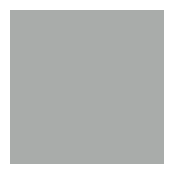

In [12]:
import colour
import numpy as np
import matplotlib.pyplot as plt

# Define the Lab color
Lab_color = np.array([70.12, -1.28, 0.71])

# Convert Lab to XYZ
XYZ_color = colour.Lab_to_XYZ(Lab_color)

# Convert XYZ to sRGB
sRGB_color = colour.XYZ_to_sRGB(XYZ_color)

# Ensure values are within the valid range [0, 1]
sRGB_color = np.clip(sRGB_color, 0, 1)

# Convert to 8-bit values (0-255) for display
sRGB_color_8bit = (sRGB_color * 255).astype(int)

# Print the sRGB color
print(f"sRGB color: {sRGB_color_8bit}")

# Create a square plot with the sRGB color
plt.figure(figsize=(2, 2))
plt.imshow([[sRGB_color]])
plt.axis('off')  # Hide axes
plt.show()

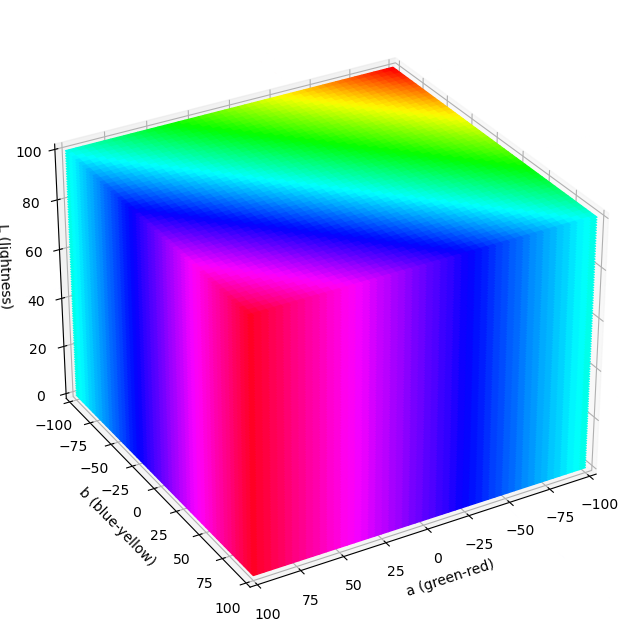

C:\Users\giaco\AppData\Local\Temp\ipykernel_11436\1578337153.py:46: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  rgb_color = lab2rgb(lab_color)


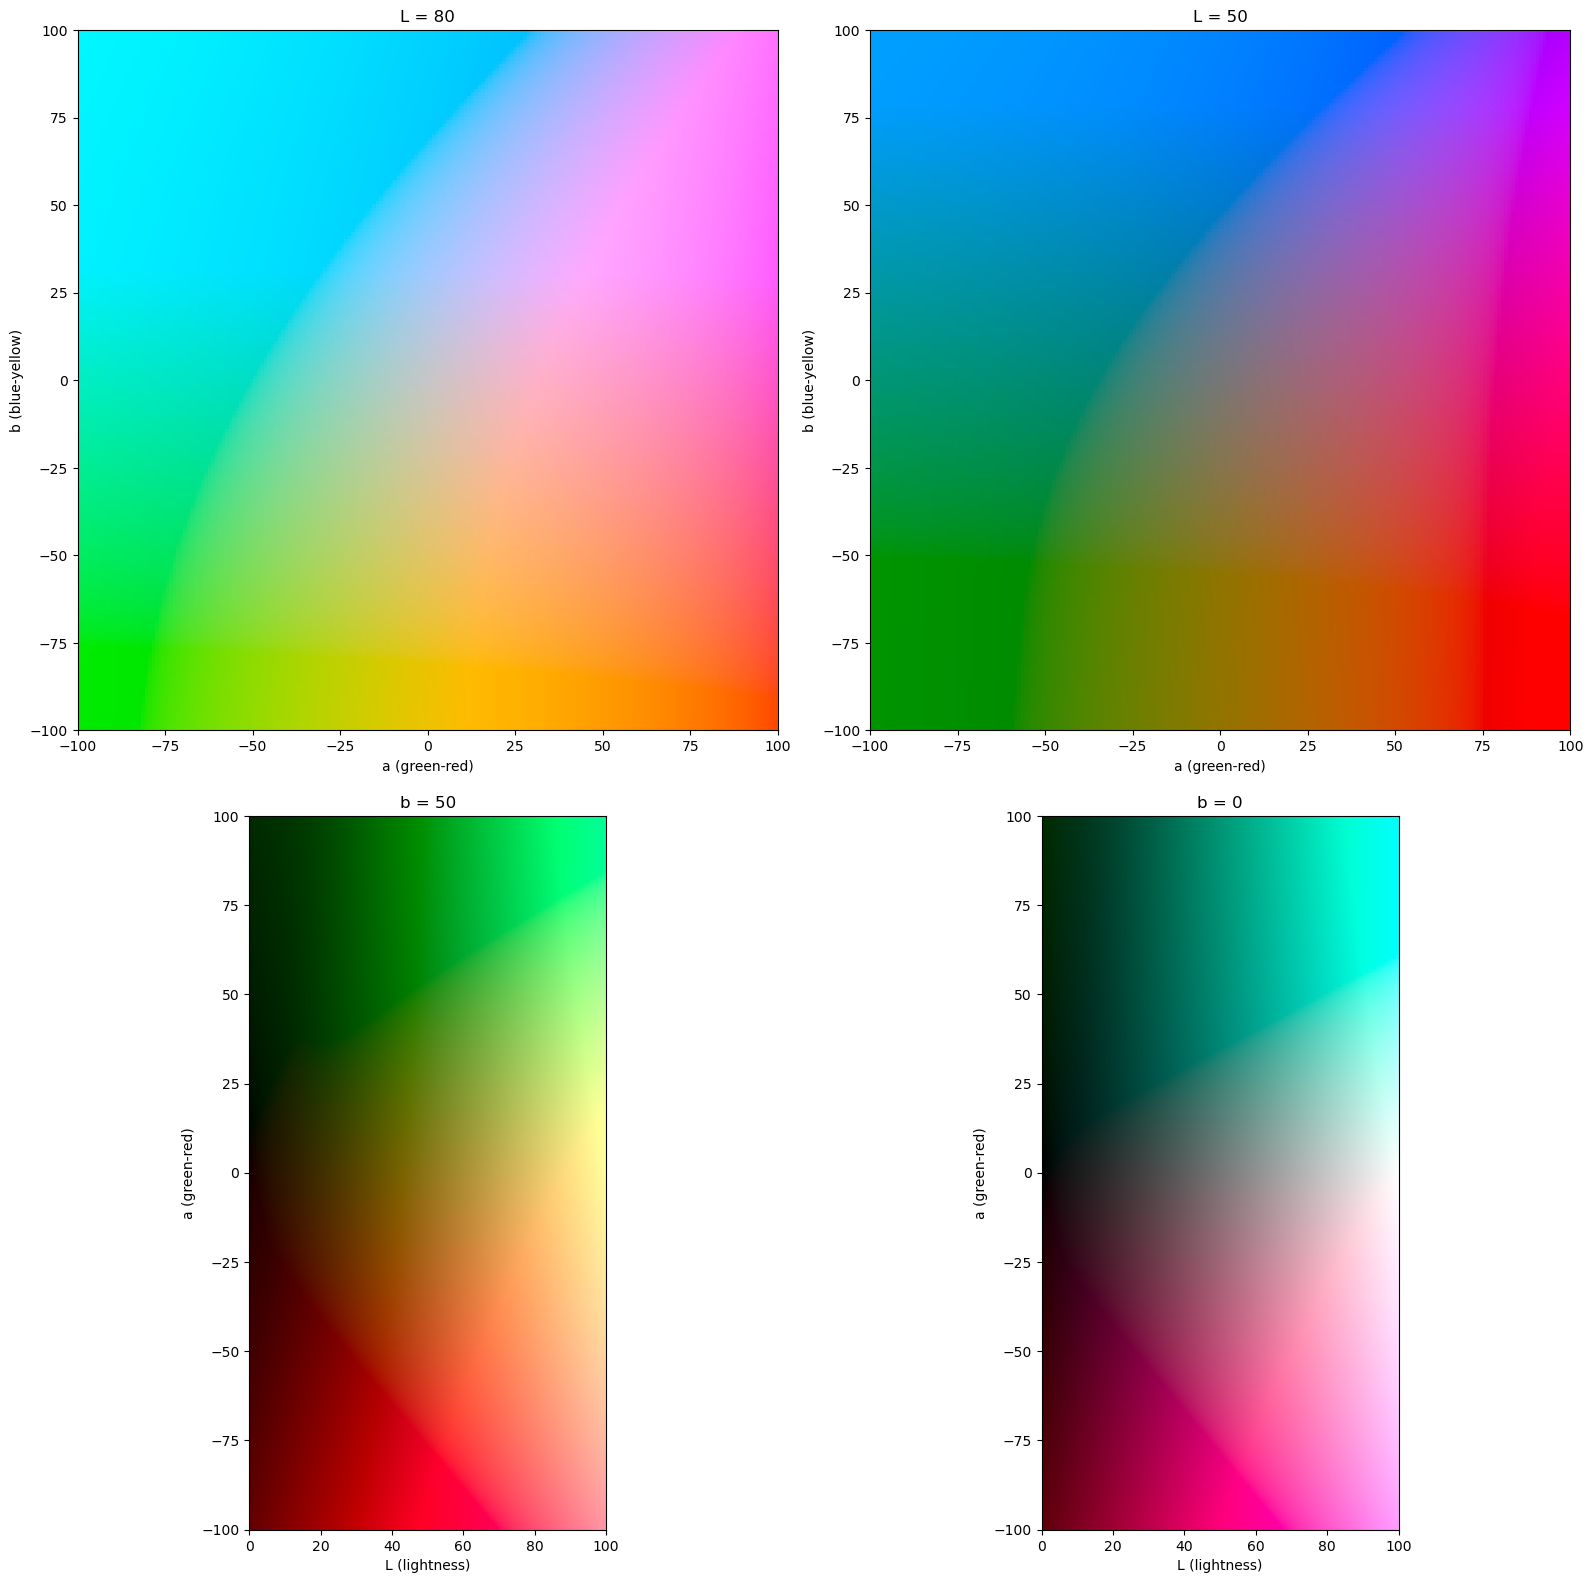

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage.color import lab2rgb

# Define the L, a, b ranges
L = np.linspace(0, 100, 100)
a = np.linspace(-100, 100, 100)
b = np.linspace(-100, 100, 100)

# Create the meshgrid for a and b
a, b = np.meshgrid(a, b)

# Normalize a and b for the color mapping
a_norm = (a + 100) / 200
b_norm = (b + 100) / 200

# Create figure and 3D axis
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create the slanted plane for a and b at each L level
for l in L:
    l_plane = np.full_like(a, l)
    ax.plot_surface(a, b, l_plane, facecolors=plt.cm.hsv((a_norm + b_norm) / 2), shade=False)

# Set axis labels
ax.set_xlabel('a (green-red)')
ax.set_ylabel('b (blue-yellow)')
ax.set_zlabel('L (lightness)')

# Set axis limits
ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)
ax.set_zlim(0, 100)

# Set view angle
ax.view_init(elev=30, azim=60)

# Show plot
plt.show()

# Function to normalize and get color
def lab_to_rgb(l, a, b):
    lab_color = np.array([[[l, a, b]]], dtype=np.float32)
    rgb_color = lab2rgb(lab_color)
    return rgb_color[0, 0]

# Create figure for 2D slices
fig, axs = plt.subplots(2, 2, figsize=(16, 16))

# Slice along the L axis (a-b plane)
L_values = [20, 50, 80]
for i, L in enumerate(L_values):
    a = np.linspace(-100, 100, 200)
    b = np.linspace(-100, 100, 200)
    a, b = np.meshgrid(a, b)
    colors = np.array([[lab_to_rgb(L, ai, bi) for ai, bi in zip(row_a, row_b)] for row_a, row_b in zip(a, b)])
    ax = axs[0, i % 2]
    ax.imshow(colors, extent=(-100, 100, -100, 100))
    ax.set_title(f'L = {L}')
    ax.set_xlabel('a (green-red)')
    ax.set_ylabel('b (blue-yellow)')

# Slice along the a axis (L-b plane)
a_values = [-50, 0, 50]
for i, a in enumerate(a_values):
    L = np.linspace(0, 100, 200)
    b = np.linspace(-100, 100, 200)
    L, b = np.meshgrid(L, b)
    colors = np.array([[lab_to_rgb(li, a, bi) for li, bi in zip(row_L, row_b)] for row_L, row_b in zip(L, b)])
    ax = axs[1, i % 2]
    ax.imshow(colors, extent=(0, 100, -100, 100))
    ax.set_title(f'a = {a}')
    ax.set_xlabel('L (lightness)')
    ax.set_ylabel('b (blue-yellow)')

# Slice along the b axis (L-a plane)
b_values = [-50, 0, 50]
for i, b in enumerate(b_values):
    L = np.linspace(0, 100, 200)
    a = np.linspace(-100, 100, 200)
    L, a = np.meshgrid(L, a)
    colors = np.array([[lab_to_rgb(li, ai, b) for li, ai in zip(row_L, row_a)] for row_L, row_a in zip(L, a)])
    ax = axs[1, i % 2]
    ax.imshow(colors, extent=(0, 100, -100, 100))
    ax.set_title(f'b = {b}')
    ax.set_xlabel('L (lightness)')
    ax.set_ylabel('a (green-red)')

# Adjust layout
plt.tight_layout()
plt.show()


C:\Users\giaco\AppData\Local\Temp\ipykernel_11436\763191903.py:8: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  rgb_color = lab2rgb(lab_color)


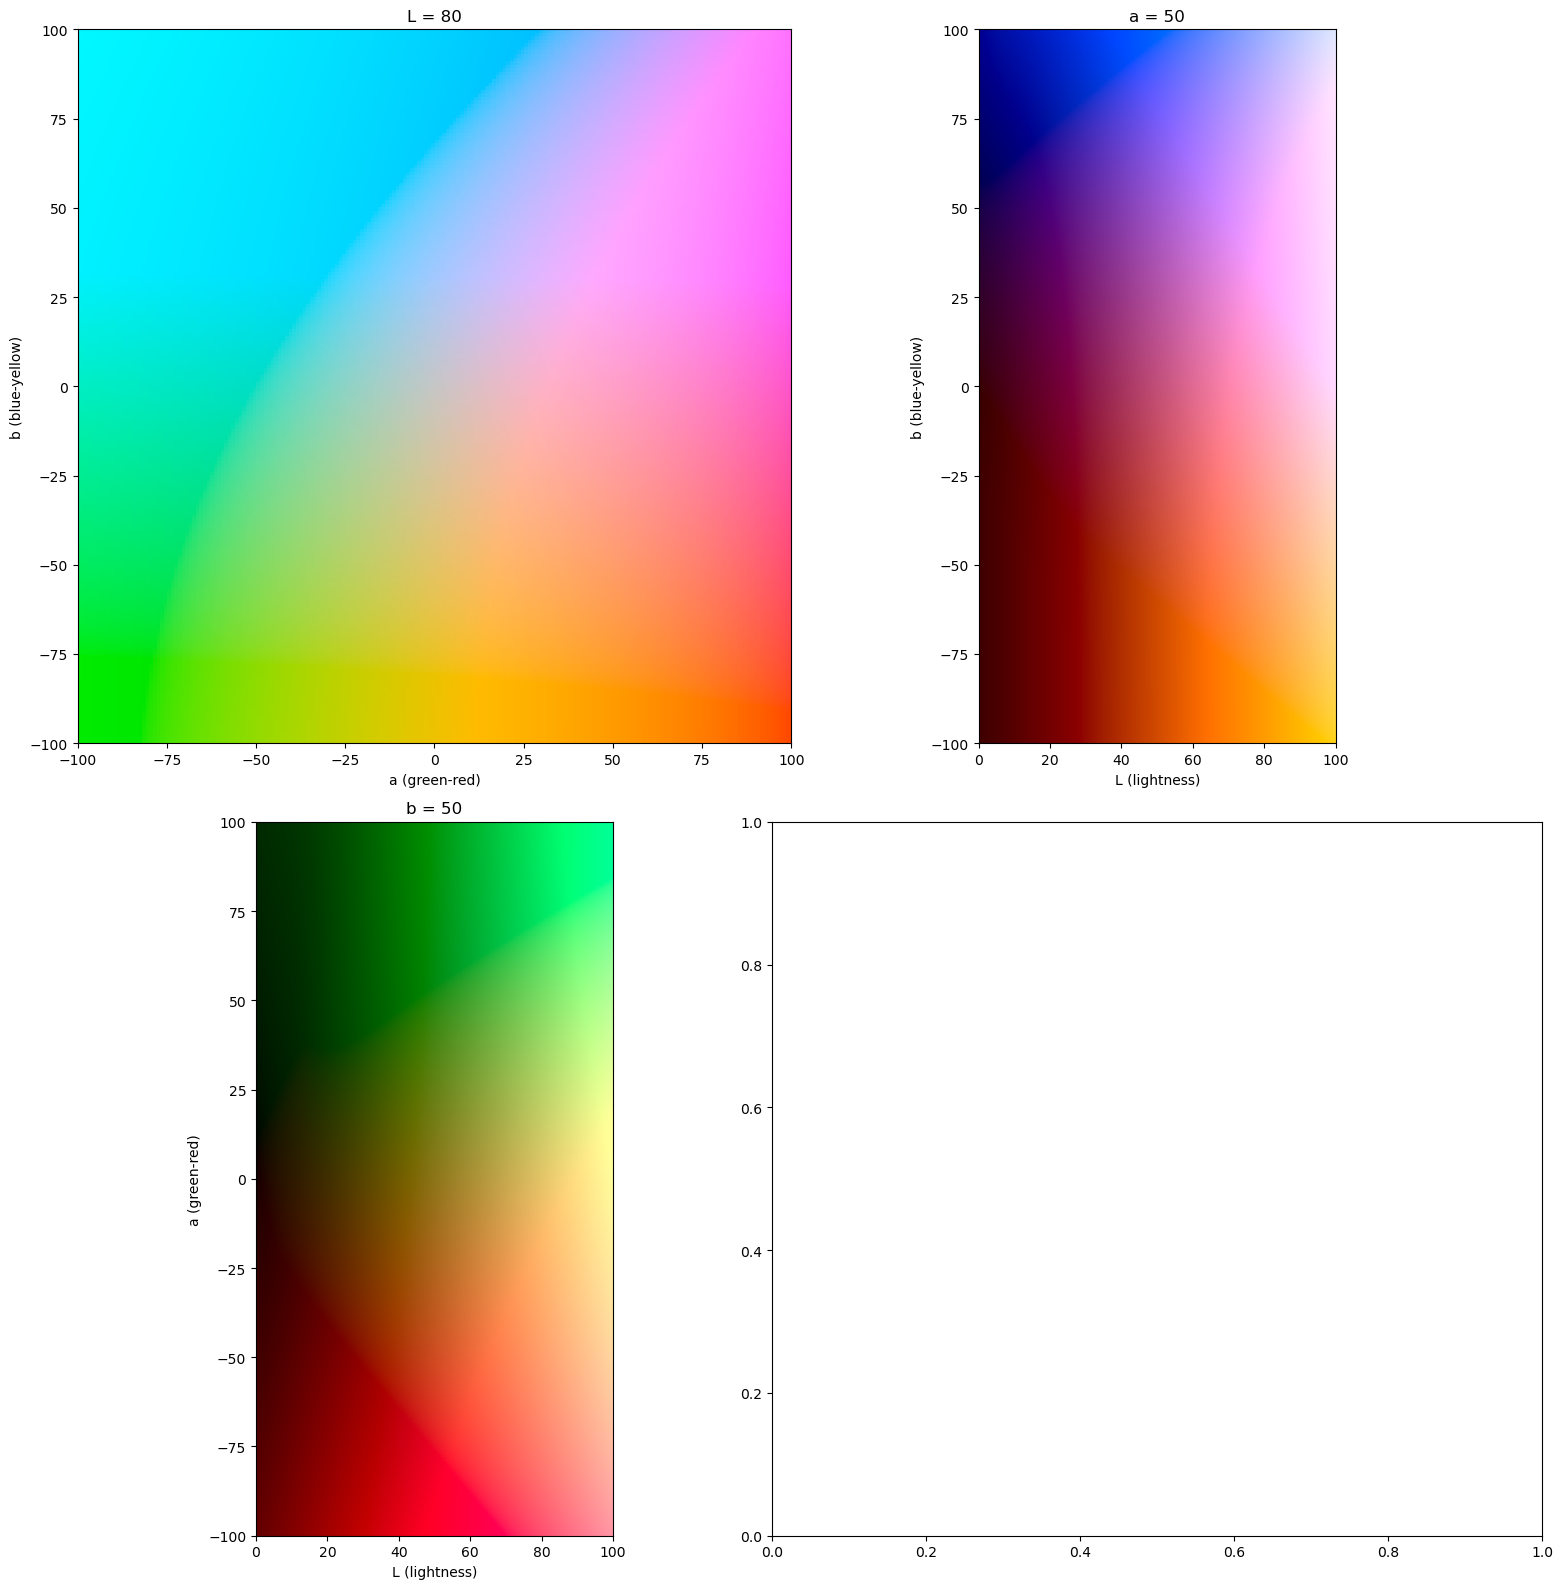

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Function to normalize and get color
def lab_to_rgb(l, a, b):
    from skimage.color import lab2rgb
    lab_color = np.array([[[l, a, b]]], dtype=np.float32)
    rgb_color = lab2rgb(lab_color)
    return rgb_color[0, 0]

# Create figure
fig, axs = plt.subplots(2, 2, figsize=(16, 16))

# Slice along the L axis (a-b plane)
L_values = [20, 50, 80]
for i, L in enumerate(L_values):
    a = np.linspace(-100, 100, 200)
    b = np.linspace(-100, 100, 200)
    a, b = np.meshgrid(a, b)
    colors = np.array([[lab_to_rgb(L, ai, bi) for ai, bi in zip(row_a, row_b)] for row_a, row_b in zip(a, b)])
    axs[0, 0].imshow(colors, extent=(-100, 100, -100, 100))
    axs[0, 0].set_title(f'L = {L}')
    axs[0, 0].set_xlabel('a (green-red)')
    axs[0, 0].set_ylabel('b (blue-yellow)')

# Slice along the a axis (L-b plane)
a_values = [-50, 0, 50]
for i, a in enumerate(a_values):
    L = np.linspace(0, 100, 200)
    b = np.linspace(-100, 100, 200)
    L, b = np.meshgrid(L, b)
    colors = np.array([[lab_to_rgb(li, a, bi) for li, bi in zip(row_L, row_b)] for row_L, row_b in zip(L, b)])
    axs[0, 1].imshow(colors, extent=(0, 100, -100, 100))
    axs[0, 1].set_title(f'a = {a}')
    axs[0, 1].set_xlabel('L (lightness)')
    axs[0, 1].set_ylabel('b (blue-yellow)')

# Slice along the b axis (L-a plane)
b_values = [-50, 0, 50]
for i, b in enumerate(b_values):
    L = np.linspace(0, 100, 200)
    a = np.linspace(-100, 100, 200)
    L, a = np.meshgrid(L, a)
    colors = np.array([[lab_to_rgb(li, ai, b) for li, ai in zip(row_L, row_a)] for row_L, row_a in zip(L, a)])
    axs[1, 0].imshow(colors, extent=(0, 100, -100, 100))
    axs[1, 0].set_title(f'b = {b}')
    axs[1, 0].set_xlabel('L (lightness)')
    axs[1, 0].set_ylabel('a (green-red)')

# Adjust layout
plt.tight_layout()
plt.show()


In [15]:
## LOAD OF DATAFILED FROM SPECIFIC FOLDER ##


# # Example usage:
# filename = "./UV_spectra/240417_EtOH_Ac_sohxlet_#1.spc"
# parser = SpcParser(filename)
# parser.extract_data()
# x_array, y_array = parser.get_data()
# print(x_array)
# print(y_array)

# Current date only
today = date.today()

# Formatting current date
formatted_today = today.strftime("%y%m%d")

# Define the folder path
folder_path = r'''C:\Users\giaco\OneDrive - Imperial College London\Collaborations\Agi\ISABEL_article\data'''

# Create a dictionary to store data from .spc files
data_dict = {}

# Iterate over files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".spc"):
        # Remove the file extension to use as dictionary key
        key = os.path.splitext(filename)[0]
        
        # Create parser instance for the current file
        parser = SpcParser(os.path.join(folder_path, filename))
        
        # Extract data from the file
        parser.extract_data()
        x_array, y_array = parser.get_data()
        
        # Store data in the dictionary
        data_dict[key] = [x_array, y_array]

# Now data_dict_ave contains the averaged datasets    

all_data = data_dict        
del(data_dict)

# Create a new dictionary with only the specified keys
data_dict = {key[7:].replace('SDS','LAS').replace('IF1_','IF_').replace('IF2_','IF_').replace('IF3_','IF_').replace('IF4_','IF_').replace('IF4_','IF_').replace('45_','45_0').replace('010','10'): all_data[key] for key in all_data.keys()}

# Print keys of the data_dict
print("Keys in data_dict:")
for key in sorted(data_dict):
    print(key)

# LGBT rainbow colors
rainbow_colors = ['#FF0000', '#FF7F00', '#00FF00', '#0000FF', '#8B00FF']

Keys in data_dict:
ISABEL_IF_150C_45_00LAS
ISABEL_IF_150C_45_02LAS
ISABEL_IF_150C_45_04LAS
ISABEL_IF_150C_45_06LAS
ISABEL_IF_150C_45_10LAS
ISABEL_IF_170C_45_00LAS
ISABEL_IF_170C_45_02LAS
ISABEL_IF_170C_45_04LAS
ISABEL_IF_170C_45_06LAS


In [66]:
def colour_analysis(key, dataset):
    for i in ['A','B','C','D50','D55','D60','D65','D75','E','FL1','FL2','FL3','FL4','FL5','FL6','FL7','FL8','FL9','FL10','FL11','FL12','HP1','HP2','HP3','HP4','HP5','ID65','ID50','ISO 7589 Photographic Daylight','ISO 7589 Sensitometric Daylight','ISO 7589 Studio Tungsten','ISO 7589 Sensitometric Studio Tungsten','ISO 7589 Photoflood','ISO 7589 Sensitometric Photoflood','ISO 7589 Sensitometric Printer']:
        set_illuminant = np.array(colour.SDS_ILLUMINANTS[i])
        set_illuminant = colour.SpectralDistribution(set_illuminant[:, 1],set_illuminant[:, 0],name=f'{i}')
        print(i)
        data = dataset[key]
        # Initialize empty lists to hold the limited data
        data1_limited = []
        data2_limited = []

        # Loop through each tuple in data and limit to 10 values
        for i in range(len(data[0])):
            data1_limited.append(data[0][i])
            data2_limited.append(data[1][i])

        # UV-Vis spectrum data (example)
        wavelengths = data1_limited
        absorbances = data2_limited

        # Filter and sort data for valid wavelengths
        sorted_data = sorted(
            [
                [wavelength, absorbance]
                for wavelength, absorbance in zip(wavelengths, absorbances)
                if wavelength % 1 == 0 and 360 <= wavelength <= 800
            ],
            key=lambda x: x[0]  # Sort by wavelength
        )

        # Separate sorted data into wavelengths and absorbances
        sorted_wavelengths = [data[0] for data in sorted_data]
        sorted_absorbances = [data[1] for data in sorted_data]
        spectrum = sorted_data
        rgb_color, Lab_color, xyz_color = uv_to_srgb(spectrum, absorbance=True, illuminant = set_illuminant)
        whiteness_index, tint = tristimulus_to_whiteness_tint(xyz_color)


        #print(f"{key},\n sRGB Color: {[int(colour) for colour in rgb_color*255]}")
        print(f"{key}")
        print(f"XYZ Color: {xyz_color},\nLab Color: {Lab_color},\nRGB Color: {[int(colour) for colour in rgb_color*255]}")
        print(f"Whiteness Index: {whiteness_index}")
        print(f"Tint: {tint}")

        # Display the resulting sRGB color
        import matplotlib.pyplot as plt

        plt.figure(figsize=(2, 2))
        plt.title(f"sRGB : {[int(colour) for colour in rgb_color*255]}")
        plt.imshow([[rgb_color]], aspect='auto')
        plt.axis('off')
        plt.savefig(f"{key}.jpg")
        plt.show()
        decolouring_percent = (rgb_color[0] + rgb_color[1] + rgb_color[2]-68/255-77/255-55/255)/(3-68/255-77/255-55/255)
        white_distance = 1-(rgb_color[0] + rgb_color[1] + rgb_color[2])/3
        decolouring_percent = int(decolouring_percent * 100)
        white_distance = int(white_distance * 100)
        
def ideal_colour_analysis(key,dataset):       
        wl = np.arange(300, 830, 5)
        set_illuminant = colour.SpectralDistribution(np.ones(len(wl)),wl,name='ideal')
        print('ideal')
        data = dataset[key]
        # Initialize empty lists to hold the limited data
        data1_limited = []
        data2_limited = []

        # Loop through each tuple in data and limit to 10 values
        for i in range(len(data[0])):
            data1_limited.append(data[0][i])
            data2_limited.append(data[1][i])

        # UV-Vis spectrum data (example)
        wavelengths = data1_limited
        absorbances = data2_limited

        # Filter and sort data for valid wavelengths
        sorted_data = sorted(
            [
                [wavelength, absorbance]
                for wavelength, absorbance in zip(wavelengths, absorbances)
                if wavelength % 1 == 0 and 360 <= wavelength <= 800
            ],
            key=lambda x: x[0]  # Sort by wavelength
        )

        # Separate sorted data into wavelengths and absorbances
        sorted_wavelengths = [data[0] for data in sorted_data]
        sorted_absorbances = [data[1] for data in sorted_data]
        spectrum = sorted_data
        rgb_color, Lab_color, xyz_color = uv_to_srgb(spectrum, absorbance=True, illuminant = set_illuminant)
        whiteness_index, tint = tristimulus_to_whiteness_tint(xyz_color)


        #print(f"{key},\n sRGB Color: {[int(colour) for colour in rgb_color*255]}")
        print(f"{key}")
        print(f"XYZ Color: {xyz_color},\nLab Color: {Lab_color}")
        print(f"Whiteness Index: {whiteness_index}")
        print(f"Tint: {tint}")

        # Display the resulting sRGB color
        import matplotlib.pyplot as plt

        plt.figure(figsize=(2, 2))
        plt.title(f"sRGB : {[int(colour) for colour in rgb_color*255]}")
        plt.imshow([[rgb_color]], aspect='auto')
        plt.axis('off')
        plt.savefig(f"{key}.jpg")
        plt.show()
        decolouring_percent = (rgb_color[0] + rgb_color[1] + rgb_color[2]-68/255-77/255-55/255)/(3-68/255-77/255-55/255)
        white_distance = 1-(rgb_color[0] + rgb_color[1] + rgb_color[2])/3
        decolouring_percent = int(decolouring_percent * 100)
        white_distance = int(white_distance * 100)

def blackbody_colour_analysis(key, dataset, K = 6504):       
        wl = np.arange(300, 830, 5)
        # Generate the blackbody spectrum for the given temperature
        blackbody_spectrum = colour.sd_blackbody(K, shape=SpectralShape(300, 850, 1))
        # Create a SpectralDistribution object for the blackbody spectrum
        set_illuminant = colour.SpectralDistribution(blackbody_spectrum,name=f'Illuminant ({K}K)')
        print(f'blackbody {K}K')
        data = dataset[key]
        # Initialize empty lists to hold the limited data
        data1_limited = []
        data2_limited = []

        # Loop through each tuple in data and limit to 10 values
        for i in range(len(data[0])):
            data1_limited.append(data[0][i])
            data2_limited.append(data[1][i])

        # UV-Vis spectrum data (example)
        wavelengths = data1_limited
        absorbances = data2_limited

        # Filter and sort data for valid wavelengths
        sorted_data = sorted(
            [
                [wavelength, absorbance]
                for wavelength, absorbance in zip(wavelengths, absorbances)
                if wavelength % 1 == 0 and 360 <= wavelength <= 800
            ],
            key=lambda x: x[0]  # Sort by wavelength
        )

        # Separate sorted data into wavelengths and absorbances
        sorted_wavelengths = [data[0] for data in sorted_data]
        sorted_absorbances = [data[1] for data in sorted_data]
        spectrum = sorted_data
        rgb_color, Lab_color, xyz_color = uv_to_srgb(spectrum, absorbance=True, illuminant = set_illuminant)
        whiteness_index, tint = tristimulus_to_whiteness_tint(xyz_color)


        #print(f"{key},\n sRGB Color: {[int(colour) for colour in rgb_color*255]}")
        print(f"{key}")
        print(f"XYZ Color: {xyz_color},\nLab Color: {Lab_color}")
        print(f"Whiteness Index: {whiteness_index}")
        print(f"Tint: {tint}")

        # Display the resulting sRGB color
        import matplotlib.pyplot as plt

        plt.figure(figsize=(2, 2))
        plt.title(f"sRGB : {[int(colour) for colour in rgb_color*255]}")
        plt.imshow([[rgb_color]], aspect='auto')
        plt.axis('off')
        plt.savefig(f"{key}.jpg")
        plt.show()
        decolouring_percent = (rgb_color[0] + rgb_color[1] + rgb_color[2]-68/255-77/255-55/255)/(3-68/255-77/255-55/255)
        white_distance = 1-(rgb_color[0] + rgb_color[1] + rgb_color[2])/3
        decolouring_percent = int(decolouring_percent * 100)
        white_distance = int(white_distance * 100)
def custom_colour_analysis(key, dataset, set_illuminant):
        print(f'custom illuminant')
        data = dataset[key]
        # Initialize empty lists to hold the limited data
        data1_limited = []
        data2_limited = []

        # Loop through each tuple in data and limit to 10 values
        for i in range(len(data[0])):
            data1_limited.append(data[0][i])
            data2_limited.append(data[1][i])

        # UV-Vis spectrum data (example)
        wavelengths = data1_limited
        absorbances = data2_limited

        # Filter and sort data for valid wavelengths
        sorted_data = sorted(
            [
                [wavelength, absorbance]
                for wavelength, absorbance in zip(wavelengths, absorbances)
                if wavelength % 1 == 0 and 360 <= wavelength <= 800
            ],
            key=lambda x: x[0]  # Sort by wavelength
        )

        # Separate sorted data into wavelengths and absorbances
        sorted_wavelengths = [data[0] for data in sorted_data]
        sorted_absorbances = [data[1] for data in sorted_data]
        spectrum = sorted_data
        rgb_color, Lab_color, xyz_color = uv_to_srgb(spectrum, absorbance=True, illuminant = set_illuminant)
        whiteness_index, tint = tristimulus_to_whiteness_tint(xyz_color)


        #print(f"{key},\n sRGB Color: {[int(colour) for colour in rgb_color*255]}")
        print(f"{key}")
        print(f"XYZ Color: {xyz_color},\nLab Color: {Lab_color}")
        print(f"Whiteness Index: {whiteness_index}")
        print(f"Tint: {tint}")

        # Display the resulting sRGB color
        import matplotlib.pyplot as plt

        plt.figure(figsize=(2, 2))
        plt.title(f"sRGB : {[int(colour) for colour in rgb_color*255]}")
        plt.imshow([[rgb_color]], aspect='auto')
        plt.axis('off')
        plt.savefig(f"{key}.jpg")
        plt.show()
        decolouring_percent = (rgb_color[0] + rgb_color[1] + rgb_color[2]-68/255-77/255-55/255)/(3-68/255-77/255-55/255)
        white_distance = 1-(rgb_color[0] + rgb_color[1] + rgb_color[2])/3
        decolouring_percent = int(decolouring_percent * 100)
        white_distance = int(white_distance * 100)

def colour_data(dataset):
    colour_dataset = dict()
    for key in sorted(dataset):
        data = dataset[key]
        colour_dataset[key] = {}
        for il in ['A','B','C','D50','D55','D60','D65','D75','E','FL1','FL2','FL3','FL4','FL5','FL6','FL7','FL8','FL9','FL10','FL11','FL12','HP1','HP2','HP3','HP4','HP5','ID65','ID50','ISO 7589 Photographic Daylight','ISO 7589 Sensitometric Daylight','ISO 7589 Studio Tungsten','ISO 7589 Sensitometric Studio Tungsten','ISO 7589 Photoflood','ISO 7589 Sensitometric Photoflood','ISO 7589 Sensitometric Printer']:
            set_illuminant = np.array(colour.SDS_ILLUMINANTS[il])
            set_illuminant = colour.SpectralDistribution(set_illuminant[:, 1],set_illuminant[:, 0],name=f'{il}')
            print(il)
            # Initialize empty lists to hold the limited data
            data1_limited = []
            data2_limited = []

            # Loop through each tuple in data and limit to 10 values
            for i in range(len(data[0])):
                data1_limited.append(data[0][i])
                data2_limited.append(data[1][i])

            # UV-Vis spectrum data (example)
            wavelengths = data1_limited
            absorbances = data2_limited

            # Filter and sort data for valid wavelengths
            sorted_data = sorted(
                [
                    [wavelength, absorbance]
                    for wavelength, absorbance in zip(wavelengths, absorbances)
                    if wavelength % 1 == 0 and 360 <= wavelength <= 800
                ],
                key=lambda x: x[0]  # Sort by wavelength
            )

            # Separate sorted data into wavelengths and absorbances
            sorted_wavelengths = [data[0] for data in sorted_data]
            sorted_absorbances = [data[1] for data in sorted_data]
            spectrum = sorted_data
            rgb_color, Lab_color, xyz_color = uv_to_srgb(spectrum, absorbance=True, illuminant = set_illuminant)
            whiteness_index, tint = tristimulus_to_whiteness_tint(xyz_color)


            #print(f"{key},\n sRGB Color: {[int(colour) for colour in rgb_color*255]}")
            print(f"{key}")
            print(f"XYZ Color: {xyz_color},\nLab Color: {Lab_color},\nRGB Color: {[int(colour) for colour in rgb_color*255]}")
            print(f"Whiteness Index: {whiteness_index}")
            print(f"Tint: {tint}")

            colour_dataset[key][il] = [xyz_color, Lab_color,[int(colour) for colour in rgb_color*255], whiteness_index, tint]
    return colour_dataset

    
colour_dataset = colour_data(data_dict)

for il in ['A','B','C','D50','D55','D60','D65','D75','E','FL1','FL2','FL3','FL4','FL5','FL6','FL7','FL8','FL9','FL10','FL11','FL12','HP1','HP2','HP3','HP4','HP5','ID65','ID50','ISO 7589 Photographic Daylight','ISO 7589 Sensitometric Daylight','ISO 7589 Studio Tungsten','ISO 7589 Sensitometric Studio Tungsten','ISO 7589 Photoflood','ISO 7589 Sensitometric Photoflood','ISO 7589 Sensitometric Printer']:
    print(il)
    for key in sorted(colour_dataset):
        print(f'{key}: {int(colour_dataset[key][il][3])}, {int(colour_dataset[key][il][4])}')


#A
#B
#C
#D50
#D55
#D60
#D65
#D75
#E
#FL1
#FL2
#FL3
#FL4
#FL5
#FL6
#FL7
#FL8
#FL9
#FL10
#FL11
#FL12
#HP1
#HP2
#HP3
#HP4
#HP5
#ID65
#ID50
#ISO 7589 Photographic Daylight
#ISO 7589 Sensitometric Daylight
#ISO 7589 Studio Tungsten
#ISO 7589 Sensitometric Studio Tungsten
#ISO 7589 Photoflood
#ISO 7589 Sensitometric Photoflood
#ISO 7589 Sensitometric Printer

A
ISABEL_IF_150C_45_00LAS
XYZ Color: [ 28.50856301  22.57793078   4.00114737],
Lab Color: [ 54.63490547  30.23566052  55.29663535],
RGB Color: [196, 107, 28]
Whiteness Index: -274.19541737951977
Tint: -152.42228497421792
B
ISABEL_IF_150C_45_00LAS
XYZ Color: [ 23.48667459  21.20881185   9.25327211],
Lab Color: [ 53.17727264  15.58374584  31.34634332],
RGB Color: [167, 115, 73]
Whiteness Index: -181.4014082208556
Tint: -81.1327965941492
C
ISABEL_IF_150C_45_00LAS
XYZ Color: [ 22.04365489  20.69540354  12.66251227],
Lab Color: [ 52.61450832  11.44733711  20.68518111],
RGB Color: [156, 117, 90]
Whiteness Index: -118.66500254888118
Tint: -56.39440439088847
D50
ISABEL_IF_150C_45_00LAS
XYZ Color: [ 22.8317462   21.06204667   9.00372004],
Lab Color: [ 53.01733402  13.32917472  31.86821771],
RGB Color: [163, 116, 72]
Whiteness Index: -187.12977868078622
Tint: -74.12871764284847
D55
ISABEL_IF_150C_45_00LAS
XYZ Color: [ 22.2664138   20.88232852   9.99766688],
Lab Color: [ 52.8204694   11.59089421 

ISABEL_IF_150C_45_10LAS
XYZ Color: [ 41.67859497  41.01865198  19.85603634],
Lab Color: [ 70.18898848   8.36168936  35.19365543],
RGB Color: [206, 164, 107]
Whiteness Index: -150.07456952316625
Tint: -47.7410401604891
FL11
ISABEL_IF_150C_45_10LAS
XYZ Color: [ 44.97406173  41.72483249  15.4473738 ],
Lab Color: [ 70.68078914  16.00081781  45.14636965],
RGB Color: [223, 160, 90]
Whiteness Index: -190.93588406306978
Tint: -76.09300178894543
FL12
ISABEL_IF_150C_45_10LAS
XYZ Color: [ 49.98194843  42.78809158   9.3736907 ],
Lab Color: [ 71.4109073   26.80956146  62.40388032],
RGB Color: [245, 153, 56]
Whiteness Index: -246.816947004356
Tint: -118.35904909280671
HP1
ISABEL_IF_150C_45_10LAS
XYZ Color: [ 60.27446081  45.63063968   3.16247011],
Lab Color: [ 73.30521936  44.63685255  92.50093666],
RGB Color: [255, 142, 0]
Whiteness Index: -293.7162817853471
Tint: -182.00837984073416
HP2
ISABEL_IF_150C_45_10LAS
XYZ Color: [ 55.57410285  44.02201606   6.40746644],
Lab Color: [ 72.24321012  37.744540

ISABEL_IF_170C_45_06LAS
XYZ Color: [ 30.99158884  26.04801771   5.15686567],
Lab Color: [ 58.08259991  24.82278272  55.37255139],
RGB Color: [200, 120, 37]
Whiteness Index: -270.5539293273622
Tint: -127.37890400035207
ISO 7589 Photoflood
ISABEL_IF_170C_45_06LAS
XYZ Color: [ 30.12136878  25.80152894   6.34409784],
Lab Color: [ 57.84818114  22.58147742  49.79447421],
RGB Color: [195, 122, 49]
Whiteness Index: -251.6324848067461
Tint: -115.72031772185474
ISO 7589 Sensitometric Photoflood
ISABEL_IF_170C_45_06LAS
XYZ Color: [ 29.85591047  25.76836049   6.14053603],
Lab Color: [ 57.81652307  21.71355441  50.57815166],
RGB Color: [194, 122, 47]
Whiteness Index: -256.18841740174634
Tint: -113.51474263280033
ISO 7589 Sensitometric Printer
ISABEL_IF_170C_45_06LAS
XYZ Color: [ 28.11303159  25.554736     5.20882163],
Lab Color: [ 57.61197255  15.84838697  54.31893813],
RGB Color: [186, 126, 37]
Whiteness Index: -280.31423255916457
Tint: -96.68048125657725
A
ISABEL_IF_150C_45_00LAS: -274, -152
ISAB

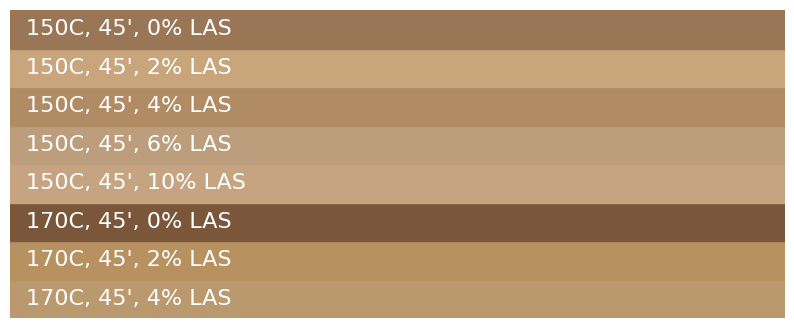

In [26]:
import matplotlib.pyplot as plt
from data_visualisation import ColourCodes

# Example data
data = [
    {'label': """150C, 45', 0% LAS""", 'RGB': (153, 118, 86)},
    {'label': """150C, 45', 2% LAS""", 'RGB': (201, 165, 124)},
    {'label': """150C, 45', 4% LAS""", 'RGB': (176, 139, 100)},
    {'label': """150C, 45', 6% LAS""", 'RGB': (188, 157, 124)},
    {'label': """150C, 45', 10% LAS""", 'RGB': (198, 164, 129)},
    {'label': """170C, 45', 0% LAS""", 'RGB': (122, 87, 58)},
    {'label': """170C, 45', 2% LAS""", 'RGB': (184, 145, 96)},
    {'label': """170C, 45', 4% LAS""", 'RGB': (187, 153, 110)},
]

color_codes = ColourCodes()
color_codes.plot_colored_rectangles(data, True, out_file=None)


In [4]:
print(all_data['240514_biomass_baseline'])

[(800.0, 799.5, 799.0, 798.5, 798.0, 797.5, 797.0, 796.5, 796.0, 795.5, 795.0, 794.5, 794.0, 793.5, 793.0, 792.5, 792.0, 791.5, 791.0, 790.5, 790.0, 789.5, 789.0, 788.5, 788.0, 787.5, 787.0, 786.5, 786.0, 785.5, 785.0, 784.5, 784.0, 783.5, 783.0, 782.5, 782.0, 781.5, 781.0, 780.5, 780.0, 779.5, 779.0, 778.5, 778.0, 777.5, 777.0, 776.5, 776.0, 775.5, 775.0, 774.5, 774.0, 773.5, 773.0, 772.5, 772.0, 771.5, 771.0, 770.5, 770.0, 769.5, 769.0, 768.5, 768.0, 767.5, 767.0, 766.5, 766.0, 765.5, 765.0, 764.5, 764.0, 763.5, 763.0, 762.5, 762.0, 761.5, 761.0, 760.5, 760.0, 759.5, 759.0, 758.5, 758.0, 757.5, 757.0, 756.5, 756.0, 755.5, 755.0, 754.5, 754.0, 753.5, 753.0, 752.5, 752.0, 751.5, 751.0, 750.5, 750.0, 749.5, 749.0, 748.5, 748.0, 747.5, 747.0, 746.5, 746.0, 745.5, 745.0, 744.5, 744.0, 743.5, 743.0, 742.5, 742.0, 741.5, 741.0, 740.5, 740.0, 739.5, 739.0, 738.5, 738.0, 737.5, 737.0, 736.5, 736.0, 735.5, 735.0, 734.5, 734.0, 733.5, 733.0, 732.5, 732.0, 731.5, 731.0, 730.5, 730.0, 729.5, 729.